In [1]:
import sys,os
import random
import numpy as np
import json
from collections import OrderedDict
from gnn import GNNNet
from utils import *
from emetrics import *
from data_process import create_dataset_for_5folds
import torch
import torch.nn as nn
from torch_geometric.data import DataLoader
import rdkit as rd
from torch_sparse import SparseTensor,transpose
import deepchem
import tensorflow as tf
import pandas as pd
import pickle

/rds/user/co-gora1/hpc-work/DGraphDTA/emetrics.py:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if pair is not 0:
RDKit WARNING: [13:17:13] Enabling RDKit 2019.09.3 jupyter extensions
[13:17:13] Enabling RDKit 2019.09.3 jupyter extensions


### Training

In [2]:
datasets = [['davis', 'kiba'][1]]
datasets 

['kiba']

In [3]:
method=['pconsc4', 'esm_cmaps', 'alpha_fold_cmaps'][0]
method

'pconsc4'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.device('cuda:0')
cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][0]
print('cuda_name:', cuda_name)

cuda_name: cuda:0


In [5]:
fold = [0, 1, 2, 3, 4][2]
cross_validation_flag = True
# print(int(sys.argv[3]))

TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
LR = 0.001
NUM_EPOCHS = 2000

print('Learning rate: ', LR)
print('Epochs: ', NUM_EPOCHS)

Learning rate:  0.001
Epochs:  2000


In [6]:

# models_dir = 'models_sample'
# results_dir = 'results'

# if not os.path.exists(models_dir):
#     os.makedirs(models_dir)

# if not os.path.exists(results_dir):
#     os.makedirs(results_dir)

# # Main program: iterate over different datasets
# result_str = ''
# USE_CUDA = torch.cuda.is_available()
# device = torch.device(cuda_name)
# model_file_name = 'models_sample/model_kiba_pconsc4__188_500_GNNNet_kiba_1.model'
# model = GNNNet()
# model.to(device)
# model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
# # model = GNNNet()
# # model=model_kiba_esm__188_500_GNNNet_kiba_1.model
# #model.to(device)
# model_st = GNNNet.__name__
# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)

GNNNet Loaded


In [6]:
models_dir = 'models_sample'
results_dir = 'results'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Main program: iterate over different datasets
result_str = ''
USE_CUDA = torch.cuda.is_available()
device = torch.device(cuda_name)
model = GNNNet()
model.to(device)
model_st = GNNNet.__name__
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

GNNNet Loaded


In [7]:
for dataset in datasets:
    train_data, valid_data = create_dataset_for_5folds(dataset, fold, method)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
                                               collate_fn=collate)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                               collate_fn=collate)

    best_mse = 1000
    best_test_mse = 1000
    best_epoch = -1
    model_file_name = 'models_sample/model_kiba_pconcs4_3_188_2000_' + model_st + '_' + dataset + '_' + str(fold) + '.model'
    mse_list1=[]
    for epoch in range(NUM_EPOCHS):
        train(model, device, train_loader, optimizer, epoch + 1)
        print('predicting for valid data')
        G, P = predicting(model, device, valid_loader)
        val = get_mse(G, P)
        mse_list1.append(val)
        print('valid result:', val, best_mse)
        if val < best_mse:
            best_mse = val
            best_epoch = epoch + 1
            torch.save(model.state_dict(), model_file_name)
            print('rmse improved at epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)
        else:
            print('No improvement since epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)


dataset: kiba
fold: 2
train entries: 63716 effective train entries 63603
valid entries: 15929 effective valid entries 15895
effective drugs,effective prot: 2068 187


/rds/user/co-gora1/hpc-work/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


Training on 63603 samples...
Train epoch: 1 [0/63603 (0%)]	Loss: 12.674482
Train epoch: 1 [5120/63603 (2%)]	Loss: 1.421562
Train epoch: 1 [10240/63603 (4%)]	Loss: 1.068000
Train epoch: 1 [15360/63603 (6%)]	Loss: 1.081281
Train epoch: 1 [20480/63603 (8%)]	Loss: 0.817221
Train epoch: 1 [25600/63603 (10%)]	Loss: 0.969657
Train epoch: 1 [30720/63603 (12%)]	Loss: 0.687472
Train epoch: 1 [35840/63603 (14%)]	Loss: 0.683780
Train epoch: 1 [40960/63603 (16%)]	Loss: 0.847452
Train epoch: 1 [46080/63603 (18%)]	Loss: 0.799057
Train epoch: 1 [51200/63603 (20%)]	Loss: 0.664569
Train epoch: 1 [56320/63603 (22%)]	Loss: 0.755929
Train epoch: 1 [61440/63603 (24%)]	Loss: 0.614344
Train epoch: 1 [66560/63603 (26%)]	Loss: 0.655610
Train epoch: 1 [71680/63603 (28%)]	Loss: 0.749583
Train epoch: 1 [76800/63603 (30%)]	Loss: 0.818671
Train epoch: 1 [81920/63603 (32%)]	Loss: 0.890788
Train epoch: 1 [87040/63603 (34%)]	Loss: 0.481835
Train epoch: 1 [92160/63603 (36%)]	Loss: 0.538331
Train epoch: 1 [97280/63603 (3

Train epoch: 4 [5120/63603 (2%)]	Loss: 0.597252
Train epoch: 4 [10240/63603 (4%)]	Loss: 0.619008
Train epoch: 4 [15360/63603 (6%)]	Loss: 0.814288
Train epoch: 4 [20480/63603 (8%)]	Loss: 0.672162
Train epoch: 4 [25600/63603 (10%)]	Loss: 0.511023
Train epoch: 4 [30720/63603 (12%)]	Loss: 0.735062
Train epoch: 4 [35840/63603 (14%)]	Loss: 0.567695
Train epoch: 4 [40960/63603 (16%)]	Loss: 0.670369
Train epoch: 4 [46080/63603 (18%)]	Loss: 0.599248
Train epoch: 4 [51200/63603 (20%)]	Loss: 0.617124
Train epoch: 4 [56320/63603 (22%)]	Loss: 0.608735
Train epoch: 4 [61440/63603 (24%)]	Loss: 0.577840
Train epoch: 4 [66560/63603 (26%)]	Loss: 0.794798
Train epoch: 4 [71680/63603 (28%)]	Loss: 0.928803
Train epoch: 4 [76800/63603 (30%)]	Loss: 0.359725
Train epoch: 4 [81920/63603 (32%)]	Loss: 0.833147
Train epoch: 4 [87040/63603 (34%)]	Loss: 0.724022
Train epoch: 4 [92160/63603 (36%)]	Loss: 1.046288
Train epoch: 4 [97280/63603 (38%)]	Loss: 0.599232
Train epoch: 4 [102400/63603 (40%)]	Loss: 0.671661
Trai

Train epoch: 7 [15360/63603 (6%)]	Loss: 0.421201
Train epoch: 7 [20480/63603 (8%)]	Loss: 1.622904
Train epoch: 7 [25600/63603 (10%)]	Loss: 0.471598
Train epoch: 7 [30720/63603 (12%)]	Loss: 0.608702
Train epoch: 7 [35840/63603 (14%)]	Loss: 0.374882
Train epoch: 7 [40960/63603 (16%)]	Loss: 0.832846
Train epoch: 7 [46080/63603 (18%)]	Loss: 0.874775
Train epoch: 7 [51200/63603 (20%)]	Loss: 0.667977
Train epoch: 7 [56320/63603 (22%)]	Loss: 0.731908
Train epoch: 7 [61440/63603 (24%)]	Loss: 0.515988
Train epoch: 7 [66560/63603 (26%)]	Loss: 0.625741
Train epoch: 7 [71680/63603 (28%)]	Loss: 0.538269
Train epoch: 7 [76800/63603 (30%)]	Loss: 0.369479
Train epoch: 7 [81920/63603 (32%)]	Loss: 0.798089
Train epoch: 7 [87040/63603 (34%)]	Loss: 0.503188
Train epoch: 7 [92160/63603 (36%)]	Loss: 0.638343
Train epoch: 7 [97280/63603 (38%)]	Loss: 0.430847
Train epoch: 7 [102400/63603 (40%)]	Loss: 0.505048
Train epoch: 7 [107520/63603 (42%)]	Loss: 0.433985
Train epoch: 7 [112640/63603 (44%)]	Loss: 0.501838

Train epoch: 10 [20480/63603 (8%)]	Loss: 0.478734
Train epoch: 10 [25600/63603 (10%)]	Loss: 0.569497
Train epoch: 10 [30720/63603 (12%)]	Loss: 0.410485
Train epoch: 10 [35840/63603 (14%)]	Loss: 0.481391
Train epoch: 10 [40960/63603 (16%)]	Loss: 0.395703
Train epoch: 10 [46080/63603 (18%)]	Loss: 0.489924
Train epoch: 10 [51200/63603 (20%)]	Loss: 0.828939
Train epoch: 10 [56320/63603 (22%)]	Loss: 0.535330
Train epoch: 10 [61440/63603 (24%)]	Loss: 0.576014
Train epoch: 10 [66560/63603 (26%)]	Loss: 0.789239
Train epoch: 10 [71680/63603 (28%)]	Loss: 0.535986
Train epoch: 10 [76800/63603 (30%)]	Loss: 0.688992
Train epoch: 10 [81920/63603 (32%)]	Loss: 0.650989
Train epoch: 10 [87040/63603 (34%)]	Loss: 0.655158
Train epoch: 10 [92160/63603 (36%)]	Loss: 0.530723
Train epoch: 10 [97280/63603 (38%)]	Loss: 1.017090
Train epoch: 10 [102400/63603 (40%)]	Loss: 0.628556
Train epoch: 10 [107520/63603 (42%)]	Loss: 0.552576
Train epoch: 10 [112640/63603 (44%)]	Loss: 0.606712
Train epoch: 10 [117760/63603

Train epoch: 13 [10240/63603 (4%)]	Loss: 0.586560
Train epoch: 13 [15360/63603 (6%)]	Loss: 0.505011
Train epoch: 13 [20480/63603 (8%)]	Loss: 0.409299
Train epoch: 13 [25600/63603 (10%)]	Loss: 0.544528
Train epoch: 13 [30720/63603 (12%)]	Loss: 0.456253
Train epoch: 13 [35840/63603 (14%)]	Loss: 0.391202
Train epoch: 13 [40960/63603 (16%)]	Loss: 0.418154
Train epoch: 13 [46080/63603 (18%)]	Loss: 0.422581
Train epoch: 13 [51200/63603 (20%)]	Loss: 0.577248
Train epoch: 13 [56320/63603 (22%)]	Loss: 0.670244
Train epoch: 13 [61440/63603 (24%)]	Loss: 0.546444
Train epoch: 13 [66560/63603 (26%)]	Loss: 0.521390
Train epoch: 13 [71680/63603 (28%)]	Loss: 0.552676
Train epoch: 13 [76800/63603 (30%)]	Loss: 0.491475
Train epoch: 13 [81920/63603 (32%)]	Loss: 0.783159
Train epoch: 13 [87040/63603 (34%)]	Loss: 0.501346
Train epoch: 13 [92160/63603 (36%)]	Loss: 0.663144
Train epoch: 13 [97280/63603 (38%)]	Loss: 0.451085
Train epoch: 13 [102400/63603 (40%)]	Loss: 0.472581
Train epoch: 13 [107520/63603 (42

Train epoch: 16 [5120/63603 (2%)]	Loss: 0.684308
Train epoch: 16 [10240/63603 (4%)]	Loss: 0.728650
Train epoch: 16 [15360/63603 (6%)]	Loss: 0.685301
Train epoch: 16 [20480/63603 (8%)]	Loss: 0.759211
Train epoch: 16 [25600/63603 (10%)]	Loss: 0.666298
Train epoch: 16 [30720/63603 (12%)]	Loss: 0.483055
Train epoch: 16 [35840/63603 (14%)]	Loss: 0.494719
Train epoch: 16 [40960/63603 (16%)]	Loss: 0.460078
Train epoch: 16 [46080/63603 (18%)]	Loss: 0.740016
Train epoch: 16 [51200/63603 (20%)]	Loss: 1.038832
Train epoch: 16 [56320/63603 (22%)]	Loss: 0.491463
Train epoch: 16 [61440/63603 (24%)]	Loss: 0.587464
Train epoch: 16 [66560/63603 (26%)]	Loss: 0.428535
Train epoch: 16 [71680/63603 (28%)]	Loss: 0.593076
Train epoch: 16 [76800/63603 (30%)]	Loss: 0.521477
Train epoch: 16 [81920/63603 (32%)]	Loss: 0.450053
Train epoch: 16 [87040/63603 (34%)]	Loss: 0.563532
Train epoch: 16 [92160/63603 (36%)]	Loss: 0.644925
Train epoch: 16 [97280/63603 (38%)]	Loss: 0.498457
Train epoch: 16 [102400/63603 (40%)]

Train epoch: 19 [5120/63603 (2%)]	Loss: 0.485149
Train epoch: 19 [10240/63603 (4%)]	Loss: 0.352781
Train epoch: 19 [15360/63603 (6%)]	Loss: 0.373941
Train epoch: 19 [20480/63603 (8%)]	Loss: 0.579149
Train epoch: 19 [25600/63603 (10%)]	Loss: 0.407134
Train epoch: 19 [30720/63603 (12%)]	Loss: 0.441780
Train epoch: 19 [35840/63603 (14%)]	Loss: 0.695533
Train epoch: 19 [40960/63603 (16%)]	Loss: 0.718367
Train epoch: 19 [46080/63603 (18%)]	Loss: 0.394455
Train epoch: 19 [51200/63603 (20%)]	Loss: 0.419197
Train epoch: 19 [56320/63603 (22%)]	Loss: 0.319564
Train epoch: 19 [61440/63603 (24%)]	Loss: 0.610692
Train epoch: 19 [66560/63603 (26%)]	Loss: 0.672060
Train epoch: 19 [71680/63603 (28%)]	Loss: 0.456075
Train epoch: 19 [76800/63603 (30%)]	Loss: 0.624618
Train epoch: 19 [81920/63603 (32%)]	Loss: 0.402429
Train epoch: 19 [87040/63603 (34%)]	Loss: 0.630706
Train epoch: 19 [92160/63603 (36%)]	Loss: 0.437574
Train epoch: 19 [97280/63603 (38%)]	Loss: 0.513562
Train epoch: 19 [102400/63603 (40%)]

Train epoch: 22 [5120/63603 (2%)]	Loss: 0.549720
Train epoch: 22 [10240/63603 (4%)]	Loss: 0.433037
Train epoch: 22 [15360/63603 (6%)]	Loss: 0.718651
Train epoch: 22 [20480/63603 (8%)]	Loss: 0.761996
Train epoch: 22 [25600/63603 (10%)]	Loss: 0.623738
Train epoch: 22 [30720/63603 (12%)]	Loss: 0.615486
Train epoch: 22 [35840/63603 (14%)]	Loss: 0.525840
Train epoch: 22 [40960/63603 (16%)]	Loss: 0.754596
Train epoch: 22 [46080/63603 (18%)]	Loss: 0.453939
Train epoch: 22 [51200/63603 (20%)]	Loss: 0.534091
Train epoch: 22 [56320/63603 (22%)]	Loss: 0.893137
Train epoch: 22 [61440/63603 (24%)]	Loss: 0.484834
Train epoch: 22 [66560/63603 (26%)]	Loss: 0.368828
Train epoch: 22 [71680/63603 (28%)]	Loss: 0.622554
Train epoch: 22 [76800/63603 (30%)]	Loss: 0.405640
Train epoch: 22 [81920/63603 (32%)]	Loss: 0.510656
Train epoch: 22 [87040/63603 (34%)]	Loss: 0.461747
Train epoch: 22 [92160/63603 (36%)]	Loss: 0.477744
Train epoch: 22 [97280/63603 (38%)]	Loss: 0.702908
Train epoch: 22 [102400/63603 (40%)]

Train epoch: 25 [5120/63603 (2%)]	Loss: 0.309902
Train epoch: 25 [10240/63603 (4%)]	Loss: 0.506443
Train epoch: 25 [15360/63603 (6%)]	Loss: 0.585778
Train epoch: 25 [20480/63603 (8%)]	Loss: 0.508600
Train epoch: 25 [25600/63603 (10%)]	Loss: 0.564422
Train epoch: 25 [30720/63603 (12%)]	Loss: 0.869745
Train epoch: 25 [35840/63603 (14%)]	Loss: 0.410952
Train epoch: 25 [40960/63603 (16%)]	Loss: 0.403266
Train epoch: 25 [46080/63603 (18%)]	Loss: 0.345427
Train epoch: 25 [51200/63603 (20%)]	Loss: 0.553886
Train epoch: 25 [56320/63603 (22%)]	Loss: 0.539345
Train epoch: 25 [61440/63603 (24%)]	Loss: 0.571567
Train epoch: 25 [66560/63603 (26%)]	Loss: 0.693264
Train epoch: 25 [71680/63603 (28%)]	Loss: 0.572033
Train epoch: 25 [76800/63603 (30%)]	Loss: 0.434569
Train epoch: 25 [81920/63603 (32%)]	Loss: 0.389701
Train epoch: 25 [87040/63603 (34%)]	Loss: 0.421690
Train epoch: 25 [92160/63603 (36%)]	Loss: 0.573711
Train epoch: 25 [97280/63603 (38%)]	Loss: 0.611242
Train epoch: 25 [102400/63603 (40%)]

Train epoch: 28 [5120/63603 (2%)]	Loss: 0.689324
Train epoch: 28 [10240/63603 (4%)]	Loss: 0.679880
Train epoch: 28 [15360/63603 (6%)]	Loss: 0.362912
Train epoch: 28 [20480/63603 (8%)]	Loss: 0.696792
Train epoch: 28 [25600/63603 (10%)]	Loss: 0.472247
Train epoch: 28 [30720/63603 (12%)]	Loss: 0.383813
Train epoch: 28 [35840/63603 (14%)]	Loss: 0.564794
Train epoch: 28 [40960/63603 (16%)]	Loss: 0.629309
Train epoch: 28 [46080/63603 (18%)]	Loss: 0.524541
Train epoch: 28 [51200/63603 (20%)]	Loss: 0.745677
Train epoch: 28 [56320/63603 (22%)]	Loss: 0.449133
Train epoch: 28 [61440/63603 (24%)]	Loss: 0.406243
Train epoch: 28 [66560/63603 (26%)]	Loss: 0.626042
Train epoch: 28 [71680/63603 (28%)]	Loss: 0.464090
Train epoch: 28 [76800/63603 (30%)]	Loss: 0.468934
Train epoch: 28 [81920/63603 (32%)]	Loss: 0.463010
Train epoch: 28 [87040/63603 (34%)]	Loss: 0.618598
Train epoch: 28 [92160/63603 (36%)]	Loss: 0.242637
Train epoch: 28 [97280/63603 (38%)]	Loss: 0.437237
Train epoch: 28 [102400/63603 (40%)]

Train epoch: 31 [5120/63603 (2%)]	Loss: 0.389955
Train epoch: 31 [10240/63603 (4%)]	Loss: 0.488704
Train epoch: 31 [15360/63603 (6%)]	Loss: 0.571402
Train epoch: 31 [20480/63603 (8%)]	Loss: 0.551434
Train epoch: 31 [25600/63603 (10%)]	Loss: 0.453736
Train epoch: 31 [30720/63603 (12%)]	Loss: 0.592248
Train epoch: 31 [35840/63603 (14%)]	Loss: 0.495514
Train epoch: 31 [40960/63603 (16%)]	Loss: 0.516549
Train epoch: 31 [46080/63603 (18%)]	Loss: 0.367096
Train epoch: 31 [51200/63603 (20%)]	Loss: 0.514885
Train epoch: 31 [56320/63603 (22%)]	Loss: 0.638242
Train epoch: 31 [61440/63603 (24%)]	Loss: 0.346635
Train epoch: 31 [66560/63603 (26%)]	Loss: 0.385518
Train epoch: 31 [71680/63603 (28%)]	Loss: 0.439609
Train epoch: 31 [76800/63603 (30%)]	Loss: 0.529773
Train epoch: 31 [81920/63603 (32%)]	Loss: 0.467385
Train epoch: 31 [87040/63603 (34%)]	Loss: 0.473484
Train epoch: 31 [92160/63603 (36%)]	Loss: 0.322298
Train epoch: 31 [97280/63603 (38%)]	Loss: 0.527722
Train epoch: 31 [102400/63603 (40%)]

Train epoch: 34 [5120/63603 (2%)]	Loss: 0.597652
Train epoch: 34 [10240/63603 (4%)]	Loss: 0.372177
Train epoch: 34 [15360/63603 (6%)]	Loss: 0.497474
Train epoch: 34 [20480/63603 (8%)]	Loss: 0.480452
Train epoch: 34 [25600/63603 (10%)]	Loss: 0.482922
Train epoch: 34 [30720/63603 (12%)]	Loss: 0.373511
Train epoch: 34 [35840/63603 (14%)]	Loss: 0.416592
Train epoch: 34 [40960/63603 (16%)]	Loss: 0.428598
Train epoch: 34 [46080/63603 (18%)]	Loss: 0.572509
Train epoch: 34 [51200/63603 (20%)]	Loss: 0.315890
Train epoch: 34 [56320/63603 (22%)]	Loss: 0.486440
Train epoch: 34 [61440/63603 (24%)]	Loss: 0.402984
Train epoch: 34 [66560/63603 (26%)]	Loss: 0.295289
Train epoch: 34 [71680/63603 (28%)]	Loss: 0.420738
Train epoch: 34 [76800/63603 (30%)]	Loss: 0.521720
Train epoch: 34 [81920/63603 (32%)]	Loss: 0.386298
Train epoch: 34 [87040/63603 (34%)]	Loss: 0.478007
Train epoch: 34 [92160/63603 (36%)]	Loss: 0.391206
Train epoch: 34 [97280/63603 (38%)]	Loss: 0.422090
Train epoch: 34 [102400/63603 (40%)]

Train epoch: 37 [5120/63603 (2%)]	Loss: 0.468438
Train epoch: 37 [10240/63603 (4%)]	Loss: 0.357557
Train epoch: 37 [15360/63603 (6%)]	Loss: 0.317316
Train epoch: 37 [20480/63603 (8%)]	Loss: 0.399395
Train epoch: 37 [25600/63603 (10%)]	Loss: 0.584026
Train epoch: 37 [30720/63603 (12%)]	Loss: 0.311775
Train epoch: 37 [35840/63603 (14%)]	Loss: 0.451781
Train epoch: 37 [40960/63603 (16%)]	Loss: 0.375071
Train epoch: 37 [46080/63603 (18%)]	Loss: 0.577769
Train epoch: 37 [51200/63603 (20%)]	Loss: 0.390705
Train epoch: 37 [56320/63603 (22%)]	Loss: 0.326329
Train epoch: 37 [61440/63603 (24%)]	Loss: 0.608011
Train epoch: 37 [66560/63603 (26%)]	Loss: 0.478813
Train epoch: 37 [71680/63603 (28%)]	Loss: 0.317242
Train epoch: 37 [76800/63603 (30%)]	Loss: 0.318176
Train epoch: 37 [81920/63603 (32%)]	Loss: 0.456282
Train epoch: 37 [87040/63603 (34%)]	Loss: 0.390841
Train epoch: 37 [92160/63603 (36%)]	Loss: 0.395853
Train epoch: 37 [97280/63603 (38%)]	Loss: 0.451443
Train epoch: 37 [102400/63603 (40%)]

Train epoch: 40 [5120/63603 (2%)]	Loss: 0.782275
Train epoch: 40 [10240/63603 (4%)]	Loss: 0.357667
Train epoch: 40 [15360/63603 (6%)]	Loss: 0.441631
Train epoch: 40 [20480/63603 (8%)]	Loss: 0.353914
Train epoch: 40 [25600/63603 (10%)]	Loss: 0.302846
Train epoch: 40 [30720/63603 (12%)]	Loss: 0.398047
Train epoch: 40 [35840/63603 (14%)]	Loss: 0.595832
Train epoch: 40 [40960/63603 (16%)]	Loss: 0.437714
Train epoch: 40 [46080/63603 (18%)]	Loss: 0.415501
Train epoch: 40 [51200/63603 (20%)]	Loss: 0.419766
Train epoch: 40 [56320/63603 (22%)]	Loss: 0.578019
Train epoch: 40 [61440/63603 (24%)]	Loss: 0.448159
Train epoch: 40 [66560/63603 (26%)]	Loss: 0.418144
Train epoch: 40 [71680/63603 (28%)]	Loss: 0.375543
Train epoch: 40 [76800/63603 (30%)]	Loss: 0.389992
Train epoch: 40 [81920/63603 (32%)]	Loss: 0.411752
Train epoch: 40 [87040/63603 (34%)]	Loss: 0.549233
Train epoch: 40 [92160/63603 (36%)]	Loss: 0.445628
Train epoch: 40 [97280/63603 (38%)]	Loss: 0.424123
Train epoch: 40 [102400/63603 (40%)]

Train epoch: 43 [5120/63603 (2%)]	Loss: 0.533342
Train epoch: 43 [10240/63603 (4%)]	Loss: 0.392644
Train epoch: 43 [15360/63603 (6%)]	Loss: 0.409251
Train epoch: 43 [20480/63603 (8%)]	Loss: 0.630382
Train epoch: 43 [25600/63603 (10%)]	Loss: 0.371907
Train epoch: 43 [30720/63603 (12%)]	Loss: 0.406575
Train epoch: 43 [35840/63603 (14%)]	Loss: 0.440568
Train epoch: 43 [40960/63603 (16%)]	Loss: 0.398012
Train epoch: 43 [46080/63603 (18%)]	Loss: 0.447899
Train epoch: 43 [51200/63603 (20%)]	Loss: 0.420986
Train epoch: 43 [56320/63603 (22%)]	Loss: 0.399048
Train epoch: 43 [61440/63603 (24%)]	Loss: 0.307596
Train epoch: 43 [66560/63603 (26%)]	Loss: 0.499956
Train epoch: 43 [71680/63603 (28%)]	Loss: 0.603190
Train epoch: 43 [76800/63603 (30%)]	Loss: 0.269465
Train epoch: 43 [81920/63603 (32%)]	Loss: 0.379787
Train epoch: 43 [87040/63603 (34%)]	Loss: 0.642585
Train epoch: 43 [92160/63603 (36%)]	Loss: 0.408347
Train epoch: 43 [97280/63603 (38%)]	Loss: 0.405946
Train epoch: 43 [102400/63603 (40%)]

Train epoch: 46 [5120/63603 (2%)]	Loss: 0.370083
Train epoch: 46 [10240/63603 (4%)]	Loss: 0.427280
Train epoch: 46 [15360/63603 (6%)]	Loss: 0.361207
Train epoch: 46 [20480/63603 (8%)]	Loss: 0.410111
Train epoch: 46 [25600/63603 (10%)]	Loss: 0.496227
Train epoch: 46 [30720/63603 (12%)]	Loss: 0.328983
Train epoch: 46 [35840/63603 (14%)]	Loss: 1.495908
Train epoch: 46 [40960/63603 (16%)]	Loss: 0.424953
Train epoch: 46 [46080/63603 (18%)]	Loss: 0.384352
Train epoch: 46 [51200/63603 (20%)]	Loss: 0.339440
Train epoch: 46 [56320/63603 (22%)]	Loss: 0.426246
Train epoch: 46 [61440/63603 (24%)]	Loss: 0.397411
Train epoch: 46 [66560/63603 (26%)]	Loss: 0.463850
Train epoch: 46 [71680/63603 (28%)]	Loss: 0.350697
Train epoch: 46 [76800/63603 (30%)]	Loss: 0.424342
Train epoch: 46 [81920/63603 (32%)]	Loss: 0.424603
Train epoch: 46 [87040/63603 (34%)]	Loss: 0.370432
Train epoch: 46 [92160/63603 (36%)]	Loss: 0.422753
Train epoch: 46 [97280/63603 (38%)]	Loss: 0.517069
Train epoch: 46 [102400/63603 (40%)]

Train epoch: 49 [5120/63603 (2%)]	Loss: 0.450440
Train epoch: 49 [10240/63603 (4%)]	Loss: 0.593736
Train epoch: 49 [15360/63603 (6%)]	Loss: 0.382712
Train epoch: 49 [20480/63603 (8%)]	Loss: 0.347269
Train epoch: 49 [25600/63603 (10%)]	Loss: 0.334065
Train epoch: 49 [30720/63603 (12%)]	Loss: 0.582965
Train epoch: 49 [35840/63603 (14%)]	Loss: 0.353521
Train epoch: 49 [40960/63603 (16%)]	Loss: 0.289169
Train epoch: 49 [46080/63603 (18%)]	Loss: 0.472778
Train epoch: 49 [51200/63603 (20%)]	Loss: 0.283841
Train epoch: 49 [56320/63603 (22%)]	Loss: 0.564692
Train epoch: 49 [61440/63603 (24%)]	Loss: 0.302243
Train epoch: 49 [66560/63603 (26%)]	Loss: 0.449547
Train epoch: 49 [71680/63603 (28%)]	Loss: 0.348542
Train epoch: 49 [76800/63603 (30%)]	Loss: 0.409222
Train epoch: 49 [81920/63603 (32%)]	Loss: 0.259877
Train epoch: 49 [87040/63603 (34%)]	Loss: 0.333476
Train epoch: 49 [92160/63603 (36%)]	Loss: 0.312807
Train epoch: 49 [97280/63603 (38%)]	Loss: 0.360191
Train epoch: 49 [102400/63603 (40%)]

Train epoch: 52 [5120/63603 (2%)]	Loss: 0.367461
Train epoch: 52 [10240/63603 (4%)]	Loss: 0.407256
Train epoch: 52 [15360/63603 (6%)]	Loss: 0.458576
Train epoch: 52 [20480/63603 (8%)]	Loss: 0.402260
Train epoch: 52 [25600/63603 (10%)]	Loss: 0.371672
Train epoch: 52 [30720/63603 (12%)]	Loss: 0.315184
Train epoch: 52 [35840/63603 (14%)]	Loss: 0.335025
Train epoch: 52 [40960/63603 (16%)]	Loss: 0.339942
Train epoch: 52 [46080/63603 (18%)]	Loss: 0.484566
Train epoch: 52 [51200/63603 (20%)]	Loss: 0.357869
Train epoch: 52 [56320/63603 (22%)]	Loss: 0.455979
Train epoch: 52 [61440/63603 (24%)]	Loss: 0.459169
Train epoch: 52 [66560/63603 (26%)]	Loss: 0.449928
Train epoch: 52 [71680/63603 (28%)]	Loss: 0.266689
Train epoch: 52 [76800/63603 (30%)]	Loss: 0.356753
Train epoch: 52 [81920/63603 (32%)]	Loss: 0.367671
Train epoch: 52 [87040/63603 (34%)]	Loss: 0.479616
Train epoch: 52 [92160/63603 (36%)]	Loss: 0.382175
Train epoch: 52 [97280/63603 (38%)]	Loss: 0.355459
Train epoch: 52 [102400/63603 (40%)]

Train epoch: 55 [5120/63603 (2%)]	Loss: 0.379920
Train epoch: 55 [10240/63603 (4%)]	Loss: 0.337415
Train epoch: 55 [15360/63603 (6%)]	Loss: 0.302315
Train epoch: 55 [20480/63603 (8%)]	Loss: 0.388324
Train epoch: 55 [25600/63603 (10%)]	Loss: 0.423022
Train epoch: 55 [30720/63603 (12%)]	Loss: 0.345418
Train epoch: 55 [35840/63603 (14%)]	Loss: 0.359970
Train epoch: 55 [40960/63603 (16%)]	Loss: 0.214306
Train epoch: 55 [46080/63603 (18%)]	Loss: 0.531998
Train epoch: 55 [51200/63603 (20%)]	Loss: 0.318856
Train epoch: 55 [56320/63603 (22%)]	Loss: 0.517485
Train epoch: 55 [61440/63603 (24%)]	Loss: 0.351815
Train epoch: 55 [66560/63603 (26%)]	Loss: 0.378193
Train epoch: 55 [71680/63603 (28%)]	Loss: 0.390427
Train epoch: 55 [76800/63603 (30%)]	Loss: 0.368593
Train epoch: 55 [81920/63603 (32%)]	Loss: 0.431482
Train epoch: 55 [87040/63603 (34%)]	Loss: 0.264682
Train epoch: 55 [92160/63603 (36%)]	Loss: 0.357814
Train epoch: 55 [97280/63603 (38%)]	Loss: 0.470808
Train epoch: 55 [102400/63603 (40%)]

Train epoch: 58 [5120/63603 (2%)]	Loss: 0.419783
Train epoch: 58 [10240/63603 (4%)]	Loss: 0.334639
Train epoch: 58 [15360/63603 (6%)]	Loss: 0.389058
Train epoch: 58 [20480/63603 (8%)]	Loss: 0.403582
Train epoch: 58 [25600/63603 (10%)]	Loss: 0.397094
Train epoch: 58 [30720/63603 (12%)]	Loss: 0.519331
Train epoch: 58 [35840/63603 (14%)]	Loss: 0.364387
Train epoch: 58 [40960/63603 (16%)]	Loss: 0.389177
Train epoch: 58 [46080/63603 (18%)]	Loss: 0.254914
Train epoch: 58 [51200/63603 (20%)]	Loss: 0.333920
Train epoch: 58 [56320/63603 (22%)]	Loss: 0.482683
Train epoch: 58 [61440/63603 (24%)]	Loss: 0.346064
Train epoch: 58 [66560/63603 (26%)]	Loss: 0.421021
Train epoch: 58 [71680/63603 (28%)]	Loss: 0.327574
Train epoch: 58 [76800/63603 (30%)]	Loss: 0.456297
Train epoch: 58 [81920/63603 (32%)]	Loss: 0.333393
Train epoch: 58 [87040/63603 (34%)]	Loss: 0.510563
Train epoch: 58 [92160/63603 (36%)]	Loss: 0.512239
Train epoch: 58 [97280/63603 (38%)]	Loss: 0.370853
Train epoch: 58 [102400/63603 (40%)]

Train epoch: 61 [5120/63603 (2%)]	Loss: 0.292069
Train epoch: 61 [10240/63603 (4%)]	Loss: 0.253959
Train epoch: 61 [15360/63603 (6%)]	Loss: 0.324110
Train epoch: 61 [20480/63603 (8%)]	Loss: 0.383539
Train epoch: 61 [25600/63603 (10%)]	Loss: 0.440105
Train epoch: 61 [30720/63603 (12%)]	Loss: 0.427650
Train epoch: 61 [35840/63603 (14%)]	Loss: 0.366723
Train epoch: 61 [40960/63603 (16%)]	Loss: 0.381149
Train epoch: 61 [46080/63603 (18%)]	Loss: 0.472129
Train epoch: 61 [51200/63603 (20%)]	Loss: 0.366078
Train epoch: 61 [56320/63603 (22%)]	Loss: 0.467049
Train epoch: 61 [61440/63603 (24%)]	Loss: 0.547336
Train epoch: 61 [66560/63603 (26%)]	Loss: 0.447198
Train epoch: 61 [71680/63603 (28%)]	Loss: 0.414174
Train epoch: 61 [76800/63603 (30%)]	Loss: 0.294146
Train epoch: 61 [81920/63603 (32%)]	Loss: 0.530915
Train epoch: 61 [87040/63603 (34%)]	Loss: 0.293465
Train epoch: 61 [92160/63603 (36%)]	Loss: 0.334511
Train epoch: 61 [97280/63603 (38%)]	Loss: 0.387501
Train epoch: 61 [102400/63603 (40%)]

Train epoch: 64 [5120/63603 (2%)]	Loss: 0.340939
Train epoch: 64 [10240/63603 (4%)]	Loss: 0.328807
Train epoch: 64 [15360/63603 (6%)]	Loss: 0.450964
Train epoch: 64 [20480/63603 (8%)]	Loss: 0.517026
Train epoch: 64 [25600/63603 (10%)]	Loss: 0.386029
Train epoch: 64 [30720/63603 (12%)]	Loss: 0.332325
Train epoch: 64 [35840/63603 (14%)]	Loss: 0.307862
Train epoch: 64 [40960/63603 (16%)]	Loss: 0.175186
Train epoch: 64 [46080/63603 (18%)]	Loss: 0.266006
Train epoch: 64 [51200/63603 (20%)]	Loss: 0.291589
Train epoch: 64 [56320/63603 (22%)]	Loss: 0.452753
Train epoch: 64 [61440/63603 (24%)]	Loss: 0.412697
Train epoch: 64 [66560/63603 (26%)]	Loss: 0.386367
Train epoch: 64 [71680/63603 (28%)]	Loss: 0.397062
Train epoch: 64 [76800/63603 (30%)]	Loss: 0.221299
Train epoch: 64 [81920/63603 (32%)]	Loss: 0.266188
Train epoch: 64 [87040/63603 (34%)]	Loss: 0.343371
Train epoch: 64 [92160/63603 (36%)]	Loss: 0.364718
Train epoch: 64 [97280/63603 (38%)]	Loss: 0.213159
Train epoch: 64 [102400/63603 (40%)]

Train epoch: 67 [5120/63603 (2%)]	Loss: 0.417977
Train epoch: 67 [10240/63603 (4%)]	Loss: 0.317914
Train epoch: 67 [15360/63603 (6%)]	Loss: 0.387771
Train epoch: 67 [20480/63603 (8%)]	Loss: 0.326562
Train epoch: 67 [25600/63603 (10%)]	Loss: 0.483292
Train epoch: 67 [30720/63603 (12%)]	Loss: 0.325767
Train epoch: 67 [35840/63603 (14%)]	Loss: 0.291618
Train epoch: 67 [40960/63603 (16%)]	Loss: 0.342294
Train epoch: 67 [46080/63603 (18%)]	Loss: 0.517567
Train epoch: 67 [51200/63603 (20%)]	Loss: 0.421951
Train epoch: 67 [56320/63603 (22%)]	Loss: 0.221114
Train epoch: 67 [61440/63603 (24%)]	Loss: 0.482861
Train epoch: 67 [66560/63603 (26%)]	Loss: 0.244065
Train epoch: 67 [71680/63603 (28%)]	Loss: 0.360550
Train epoch: 67 [76800/63603 (30%)]	Loss: 0.419750
Train epoch: 67 [81920/63603 (32%)]	Loss: 0.401743
Train epoch: 67 [87040/63603 (34%)]	Loss: 0.339955
Train epoch: 67 [92160/63603 (36%)]	Loss: 0.312285
Train epoch: 67 [97280/63603 (38%)]	Loss: 0.530433
Train epoch: 67 [102400/63603 (40%)]

Train epoch: 70 [5120/63603 (2%)]	Loss: 0.261332
Train epoch: 70 [10240/63603 (4%)]	Loss: 0.305903
Train epoch: 70 [15360/63603 (6%)]	Loss: 0.317609
Train epoch: 70 [20480/63603 (8%)]	Loss: 0.383827
Train epoch: 70 [25600/63603 (10%)]	Loss: 0.250104
Train epoch: 70 [30720/63603 (12%)]	Loss: 0.352367
Train epoch: 70 [35840/63603 (14%)]	Loss: 0.349842
Train epoch: 70 [40960/63603 (16%)]	Loss: 0.188114
Train epoch: 70 [46080/63603 (18%)]	Loss: 0.411171
Train epoch: 70 [51200/63603 (20%)]	Loss: 0.418329
Train epoch: 70 [56320/63603 (22%)]	Loss: 0.305261
Train epoch: 70 [61440/63603 (24%)]	Loss: 0.275369
Train epoch: 70 [66560/63603 (26%)]	Loss: 0.268534
Train epoch: 70 [71680/63603 (28%)]	Loss: 0.245373
Train epoch: 70 [76800/63603 (30%)]	Loss: 0.238205
Train epoch: 70 [81920/63603 (32%)]	Loss: 0.364961
Train epoch: 70 [87040/63603 (34%)]	Loss: 0.402804
Train epoch: 70 [92160/63603 (36%)]	Loss: 0.273973
Train epoch: 70 [97280/63603 (38%)]	Loss: 0.515869
Train epoch: 70 [102400/63603 (40%)]

Train epoch: 73 [5120/63603 (2%)]	Loss: 0.310400
Train epoch: 73 [10240/63603 (4%)]	Loss: 0.393022
Train epoch: 73 [15360/63603 (6%)]	Loss: 0.449097
Train epoch: 73 [20480/63603 (8%)]	Loss: 0.297931
Train epoch: 73 [25600/63603 (10%)]	Loss: 0.423113
Train epoch: 73 [30720/63603 (12%)]	Loss: 0.221127
Train epoch: 73 [35840/63603 (14%)]	Loss: 0.477501
Train epoch: 73 [40960/63603 (16%)]	Loss: 0.398252
Train epoch: 73 [46080/63603 (18%)]	Loss: 0.393510
Train epoch: 73 [51200/63603 (20%)]	Loss: 0.262348
Train epoch: 73 [56320/63603 (22%)]	Loss: 0.390794
Train epoch: 73 [61440/63603 (24%)]	Loss: 0.276646
Train epoch: 73 [66560/63603 (26%)]	Loss: 0.485117
Train epoch: 73 [71680/63603 (28%)]	Loss: 0.380770
Train epoch: 73 [76800/63603 (30%)]	Loss: 0.463792
Train epoch: 73 [81920/63603 (32%)]	Loss: 0.274115
Train epoch: 73 [87040/63603 (34%)]	Loss: 0.365360
Train epoch: 73 [92160/63603 (36%)]	Loss: 0.284941
Train epoch: 73 [97280/63603 (38%)]	Loss: 0.422643
Train epoch: 73 [102400/63603 (40%)]

Train epoch: 76 [5120/63603 (2%)]	Loss: 0.328313
Train epoch: 76 [10240/63603 (4%)]	Loss: 0.421084
Train epoch: 76 [15360/63603 (6%)]	Loss: 0.362752
Train epoch: 76 [20480/63603 (8%)]	Loss: 0.187452
Train epoch: 76 [25600/63603 (10%)]	Loss: 0.392117
Train epoch: 76 [30720/63603 (12%)]	Loss: 0.294831
Train epoch: 76 [35840/63603 (14%)]	Loss: 0.388011
Train epoch: 76 [40960/63603 (16%)]	Loss: 0.343755
Train epoch: 76 [46080/63603 (18%)]	Loss: 0.254283
Train epoch: 76 [51200/63603 (20%)]	Loss: 0.292253
Train epoch: 76 [56320/63603 (22%)]	Loss: 0.374496
Train epoch: 76 [61440/63603 (24%)]	Loss: 0.335272
Train epoch: 76 [66560/63603 (26%)]	Loss: 0.275983
Train epoch: 76 [71680/63603 (28%)]	Loss: 0.320319
Train epoch: 76 [76800/63603 (30%)]	Loss: 0.306008
Train epoch: 76 [81920/63603 (32%)]	Loss: 0.319352
Train epoch: 76 [87040/63603 (34%)]	Loss: 0.348479
Train epoch: 76 [92160/63603 (36%)]	Loss: 0.285582
Train epoch: 76 [97280/63603 (38%)]	Loss: 0.342242
Train epoch: 76 [102400/63603 (40%)]

Train epoch: 79 [5120/63603 (2%)]	Loss: 0.399156
Train epoch: 79 [10240/63603 (4%)]	Loss: 0.302810
Train epoch: 79 [15360/63603 (6%)]	Loss: 0.399835
Train epoch: 79 [20480/63603 (8%)]	Loss: 0.207536
Train epoch: 79 [25600/63603 (10%)]	Loss: 0.328413
Train epoch: 79 [30720/63603 (12%)]	Loss: 0.356860
Train epoch: 79 [35840/63603 (14%)]	Loss: 0.358184
Train epoch: 79 [40960/63603 (16%)]	Loss: 0.407173
Train epoch: 79 [46080/63603 (18%)]	Loss: 0.268772
Train epoch: 79 [51200/63603 (20%)]	Loss: 0.321736
Train epoch: 79 [56320/63603 (22%)]	Loss: 0.308809
Train epoch: 79 [61440/63603 (24%)]	Loss: 0.488115
Train epoch: 79 [66560/63603 (26%)]	Loss: 0.437521
Train epoch: 79 [71680/63603 (28%)]	Loss: 0.230121
Train epoch: 79 [76800/63603 (30%)]	Loss: 0.376784
Train epoch: 79 [81920/63603 (32%)]	Loss: 0.264174
Train epoch: 79 [87040/63603 (34%)]	Loss: 0.389006
Train epoch: 79 [92160/63603 (36%)]	Loss: 0.289931
Train epoch: 79 [97280/63603 (38%)]	Loss: 0.410287
Train epoch: 79 [102400/63603 (40%)]

Train epoch: 82 [5120/63603 (2%)]	Loss: 0.338500
Train epoch: 82 [10240/63603 (4%)]	Loss: 0.364618
Train epoch: 82 [15360/63603 (6%)]	Loss: 0.333501
Train epoch: 82 [20480/63603 (8%)]	Loss: 0.260213
Train epoch: 82 [25600/63603 (10%)]	Loss: 0.335383
Train epoch: 82 [30720/63603 (12%)]	Loss: 0.465211
Train epoch: 82 [35840/63603 (14%)]	Loss: 0.273170
Train epoch: 82 [40960/63603 (16%)]	Loss: 0.370032
Train epoch: 82 [46080/63603 (18%)]	Loss: 0.302806
Train epoch: 82 [51200/63603 (20%)]	Loss: 0.247128
Train epoch: 82 [56320/63603 (22%)]	Loss: 0.237216
Train epoch: 82 [61440/63603 (24%)]	Loss: 0.339487
Train epoch: 82 [66560/63603 (26%)]	Loss: 0.309282
Train epoch: 82 [71680/63603 (28%)]	Loss: 0.318608
Train epoch: 82 [76800/63603 (30%)]	Loss: 0.368449
Train epoch: 82 [81920/63603 (32%)]	Loss: 0.465944
Train epoch: 82 [87040/63603 (34%)]	Loss: 0.357567
Train epoch: 82 [92160/63603 (36%)]	Loss: 0.275915
Train epoch: 82 [97280/63603 (38%)]	Loss: 0.290177
Train epoch: 82 [102400/63603 (40%)]

Train epoch: 85 [5120/63603 (2%)]	Loss: 0.245757
Train epoch: 85 [10240/63603 (4%)]	Loss: 0.417201
Train epoch: 85 [15360/63603 (6%)]	Loss: 0.347119
Train epoch: 85 [20480/63603 (8%)]	Loss: 0.339313
Train epoch: 85 [25600/63603 (10%)]	Loss: 0.348700
Train epoch: 85 [30720/63603 (12%)]	Loss: 0.264450
Train epoch: 85 [35840/63603 (14%)]	Loss: 0.367221
Train epoch: 85 [40960/63603 (16%)]	Loss: 0.389608
Train epoch: 85 [46080/63603 (18%)]	Loss: 0.324252
Train epoch: 85 [51200/63603 (20%)]	Loss: 0.235466
Train epoch: 85 [56320/63603 (22%)]	Loss: 0.242436
Train epoch: 85 [61440/63603 (24%)]	Loss: 0.382585
Train epoch: 85 [66560/63603 (26%)]	Loss: 0.318197
Train epoch: 85 [71680/63603 (28%)]	Loss: 0.225555
Train epoch: 85 [76800/63603 (30%)]	Loss: 0.409126
Train epoch: 85 [81920/63603 (32%)]	Loss: 0.422146
Train epoch: 85 [87040/63603 (34%)]	Loss: 0.254992
Train epoch: 85 [92160/63603 (36%)]	Loss: 0.365185
Train epoch: 85 [97280/63603 (38%)]	Loss: 0.472555
Train epoch: 85 [102400/63603 (40%)]

Train epoch: 88 [5120/63603 (2%)]	Loss: 0.349525
Train epoch: 88 [10240/63603 (4%)]	Loss: 0.385527
Train epoch: 88 [15360/63603 (6%)]	Loss: 0.277643
Train epoch: 88 [20480/63603 (8%)]	Loss: 0.296859
Train epoch: 88 [25600/63603 (10%)]	Loss: 0.372781
Train epoch: 88 [30720/63603 (12%)]	Loss: 0.308567
Train epoch: 88 [35840/63603 (14%)]	Loss: 0.480380
Train epoch: 88 [40960/63603 (16%)]	Loss: 0.301060
Train epoch: 88 [46080/63603 (18%)]	Loss: 0.407129
Train epoch: 88 [51200/63603 (20%)]	Loss: 0.276264
Train epoch: 88 [56320/63603 (22%)]	Loss: 0.201849
Train epoch: 88 [61440/63603 (24%)]	Loss: 0.287231
Train epoch: 88 [66560/63603 (26%)]	Loss: 0.231150
Train epoch: 88 [71680/63603 (28%)]	Loss: 0.301059
Train epoch: 88 [76800/63603 (30%)]	Loss: 0.237788
Train epoch: 88 [81920/63603 (32%)]	Loss: 0.436514
Train epoch: 88 [87040/63603 (34%)]	Loss: 0.595935
Train epoch: 88 [92160/63603 (36%)]	Loss: 0.230745
Train epoch: 88 [97280/63603 (38%)]	Loss: 0.207658
Train epoch: 88 [102400/63603 (40%)]

Train epoch: 91 [5120/63603 (2%)]	Loss: 0.400283
Train epoch: 91 [10240/63603 (4%)]	Loss: 0.196189
Train epoch: 91 [15360/63603 (6%)]	Loss: 0.455212
Train epoch: 91 [20480/63603 (8%)]	Loss: 0.248911
Train epoch: 91 [25600/63603 (10%)]	Loss: 0.441597
Train epoch: 91 [30720/63603 (12%)]	Loss: 0.371516
Train epoch: 91 [35840/63603 (14%)]	Loss: 0.255589
Train epoch: 91 [40960/63603 (16%)]	Loss: 0.333299
Train epoch: 91 [46080/63603 (18%)]	Loss: 0.226882
Train epoch: 91 [51200/63603 (20%)]	Loss: 0.290710
Train epoch: 91 [56320/63603 (22%)]	Loss: 0.301943
Train epoch: 91 [61440/63603 (24%)]	Loss: 0.255517
Train epoch: 91 [66560/63603 (26%)]	Loss: 0.221332
Train epoch: 91 [71680/63603 (28%)]	Loss: 0.445726
Train epoch: 91 [76800/63603 (30%)]	Loss: 0.210942
Train epoch: 91 [81920/63603 (32%)]	Loss: 0.317139
Train epoch: 91 [87040/63603 (34%)]	Loss: 0.293263
Train epoch: 91 [92160/63603 (36%)]	Loss: 0.424461
Train epoch: 91 [97280/63603 (38%)]	Loss: 0.364577
Train epoch: 91 [102400/63603 (40%)]

Train epoch: 94 [5120/63603 (2%)]	Loss: 0.301890
Train epoch: 94 [10240/63603 (4%)]	Loss: 0.422734
Train epoch: 94 [15360/63603 (6%)]	Loss: 0.317413
Train epoch: 94 [20480/63603 (8%)]	Loss: 0.504723
Train epoch: 94 [25600/63603 (10%)]	Loss: 0.271039
Train epoch: 94 [30720/63603 (12%)]	Loss: 0.270488
Train epoch: 94 [35840/63603 (14%)]	Loss: 0.374802
Train epoch: 94 [40960/63603 (16%)]	Loss: 0.438970
Train epoch: 94 [46080/63603 (18%)]	Loss: 0.241831
Train epoch: 94 [51200/63603 (20%)]	Loss: 0.313097
Train epoch: 94 [56320/63603 (22%)]	Loss: 0.277563
Train epoch: 94 [61440/63603 (24%)]	Loss: 0.403042
Train epoch: 94 [66560/63603 (26%)]	Loss: 0.239119
Train epoch: 94 [71680/63603 (28%)]	Loss: 0.299064
Train epoch: 94 [76800/63603 (30%)]	Loss: 0.267918
Train epoch: 94 [81920/63603 (32%)]	Loss: 0.395646
Train epoch: 94 [87040/63603 (34%)]	Loss: 0.350305
Train epoch: 94 [92160/63603 (36%)]	Loss: 0.356176
Train epoch: 94 [97280/63603 (38%)]	Loss: 0.318539
Train epoch: 94 [102400/63603 (40%)]

Train epoch: 97 [5120/63603 (2%)]	Loss: 0.250354
Train epoch: 97 [10240/63603 (4%)]	Loss: 0.296218
Train epoch: 97 [15360/63603 (6%)]	Loss: 0.167827
Train epoch: 97 [20480/63603 (8%)]	Loss: 0.232824
Train epoch: 97 [25600/63603 (10%)]	Loss: 0.290384
Train epoch: 97 [30720/63603 (12%)]	Loss: 0.285888
Train epoch: 97 [35840/63603 (14%)]	Loss: 0.494194
Train epoch: 97 [40960/63603 (16%)]	Loss: 0.215192
Train epoch: 97 [46080/63603 (18%)]	Loss: 0.179498
Train epoch: 97 [51200/63603 (20%)]	Loss: 0.201037
Train epoch: 97 [56320/63603 (22%)]	Loss: 0.278156
Train epoch: 97 [61440/63603 (24%)]	Loss: 0.276517
Train epoch: 97 [66560/63603 (26%)]	Loss: 0.282389
Train epoch: 97 [71680/63603 (28%)]	Loss: 0.233849
Train epoch: 97 [76800/63603 (30%)]	Loss: 0.286680
Train epoch: 97 [81920/63603 (32%)]	Loss: 0.279093
Train epoch: 97 [87040/63603 (34%)]	Loss: 0.275407
Train epoch: 97 [92160/63603 (36%)]	Loss: 0.245840
Train epoch: 97 [97280/63603 (38%)]	Loss: 0.200918
Train epoch: 97 [102400/63603 (40%)]

Train epoch: 100 [5120/63603 (2%)]	Loss: 0.231084
Train epoch: 100 [10240/63603 (4%)]	Loss: 0.212835
Train epoch: 100 [15360/63603 (6%)]	Loss: 0.261238
Train epoch: 100 [20480/63603 (8%)]	Loss: 1.151222
Train epoch: 100 [25600/63603 (10%)]	Loss: 0.318676
Train epoch: 100 [30720/63603 (12%)]	Loss: 0.328416
Train epoch: 100 [35840/63603 (14%)]	Loss: 0.308559
Train epoch: 100 [40960/63603 (16%)]	Loss: 0.266599
Train epoch: 100 [46080/63603 (18%)]	Loss: 0.309920
Train epoch: 100 [51200/63603 (20%)]	Loss: 0.338378
Train epoch: 100 [56320/63603 (22%)]	Loss: 0.271680
Train epoch: 100 [61440/63603 (24%)]	Loss: 0.217722
Train epoch: 100 [66560/63603 (26%)]	Loss: 0.264711
Train epoch: 100 [71680/63603 (28%)]	Loss: 0.229230
Train epoch: 100 [76800/63603 (30%)]	Loss: 0.209352
Train epoch: 100 [81920/63603 (32%)]	Loss: 0.376157
Train epoch: 100 [87040/63603 (34%)]	Loss: 0.283214
Train epoch: 100 [92160/63603 (36%)]	Loss: 0.430283
Train epoch: 100 [97280/63603 (38%)]	Loss: 0.316611
Train epoch: 100 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.31500757 0.3210079
rmse improved at epoch  102 ; best_test_mse 0.31500757 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 103 [0/63603 (0%)]	Loss: 0.444381
Train epoch: 103 [5120/63603 (2%)]	Loss: 0.266355
Train epoch: 103 [10240/63603 (4%)]	Loss: 0.451266
Train epoch: 103 [15360/63603 (6%)]	Loss: 0.435812
Train epoch: 103 [20480/63603 (8%)]	Loss: 0.222620
Train epoch: 103 [25600/63603 (10%)]	Loss: 0.308884
Train epoch: 103 [30720/63603 (12%)]	Loss: 0.256984
Train epoch: 103 [35840/63603 (14%)]	Loss: 0.165676
Train epoch: 103 [40960/63603 (16%)]	Loss: 0.363305
Train epoch: 103 [46080/63603 (18%)]	Loss: 0.227589
Train epoch: 103 [51200/63603 (20%)]	Loss: 0.267657
Train epoch: 103 [56320/63603 (22%)]	Loss: 0.293787
Train epoch: 103 [61440/63603 (24%)]	Loss: 0.265889
Train epoch: 103 [66560/63603 (26%)]	Loss: 0.358753
Train epoch: 103 [71680/63603 (28%)]	Loss: 0.256510
Train epoch: 103 [76800/63603 (30%

Train epoch: 105 [230400/63603 (91%)]	Loss: 1.497768
Train epoch: 105 [235520/63603 (93%)]	Loss: 0.250510
Train epoch: 105 [240640/63603 (95%)]	Loss: 0.260949
Train epoch: 105 [245760/63603 (97%)]	Loss: 0.354384
Train epoch: 105 [250880/63603 (99%)]	Loss: 0.215434
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.32568654 0.31500757
No improvement since epoch  102 ; best_test_mse 0.31500757 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 106 [0/63603 (0%)]	Loss: 0.390127
Train epoch: 106 [5120/63603 (2%)]	Loss: 0.285798
Train epoch: 106 [10240/63603 (4%)]	Loss: 0.303577
Train epoch: 106 [15360/63603 (6%)]	Loss: 0.223632
Train epoch: 106 [20480/63603 (8%)]	Loss: 0.307233
Train epoch: 106 [25600/63603 (10%)]	Loss: 0.346409
Train epoch: 106 [30720/63603 (12%)]	Loss: 0.212336
Train epoch: 106 [35840/63603 (14%)]	Loss: 0.246251
Train epoch: 106 [40960/63603 (16%)]	Loss: 0.370188
Train epoch: 106 [46080/63603 (18%)]	Loss: 0.305412
Train epoch: 106 [51200/

Train epoch: 108 [209920/63603 (82%)]	Loss: 0.174473
Train epoch: 108 [215040/63603 (85%)]	Loss: 0.285319
Train epoch: 108 [220160/63603 (87%)]	Loss: 0.247151
Train epoch: 108 [225280/63603 (89%)]	Loss: 0.281734
Train epoch: 108 [230400/63603 (91%)]	Loss: 0.348092
Train epoch: 108 [235520/63603 (93%)]	Loss: 0.358043
Train epoch: 108 [240640/63603 (95%)]	Loss: 0.269287
Train epoch: 108 [245760/63603 (97%)]	Loss: 0.428201
Train epoch: 108 [250880/63603 (99%)]	Loss: 0.314379
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.3198927 0.31282
No improvement since epoch  106 ; best_test_mse 0.31282 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 109 [0/63603 (0%)]	Loss: 0.239090
Train epoch: 109 [5120/63603 (2%)]	Loss: 0.376750
Train epoch: 109 [10240/63603 (4%)]	Loss: 0.278975
Train epoch: 109 [15360/63603 (6%)]	Loss: 0.287778
Train epoch: 109 [20480/63603 (8%)]	Loss: 0.229874
Train epoch: 109 [25600/63603 (10%)]	Loss: 0.164671
Train epoch: 109 [30720/636

Train epoch: 111 [189440/63603 (74%)]	Loss: 0.286965
Train epoch: 111 [194560/63603 (76%)]	Loss: 0.239786
Train epoch: 111 [199680/63603 (78%)]	Loss: 0.228385
Train epoch: 111 [204800/63603 (80%)]	Loss: 0.247316
Train epoch: 111 [209920/63603 (82%)]	Loss: 0.222043
Train epoch: 111 [215040/63603 (85%)]	Loss: 0.334195
Train epoch: 111 [220160/63603 (87%)]	Loss: 0.241010
Train epoch: 111 [225280/63603 (89%)]	Loss: 0.274048
Train epoch: 111 [230400/63603 (91%)]	Loss: 0.191787
Train epoch: 111 [235520/63603 (93%)]	Loss: 0.305274
Train epoch: 111 [240640/63603 (95%)]	Loss: 0.349127
Train epoch: 111 [245760/63603 (97%)]	Loss: 0.493744
Train epoch: 111 [250880/63603 (99%)]	Loss: 0.319343
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.32345688 0.31282
No improvement since epoch  106 ; best_test_mse 0.31282 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 112 [0/63603 (0%)]	Loss: 0.291039
Train epoch: 112 [5120/63603 (2%)]	Loss: 0.235054
Train epoch: 112 [1

Train epoch: 114 [168960/63603 (66%)]	Loss: 0.473706
Train epoch: 114 [174080/63603 (68%)]	Loss: 0.364950
Train epoch: 114 [179200/63603 (70%)]	Loss: 0.298361
Train epoch: 114 [184320/63603 (72%)]	Loss: 0.268267
Train epoch: 114 [189440/63603 (74%)]	Loss: 0.344655
Train epoch: 114 [194560/63603 (76%)]	Loss: 0.321828
Train epoch: 114 [199680/63603 (78%)]	Loss: 0.347753
Train epoch: 114 [204800/63603 (80%)]	Loss: 0.217897
Train epoch: 114 [209920/63603 (82%)]	Loss: 0.161445
Train epoch: 114 [215040/63603 (85%)]	Loss: 0.323250
Train epoch: 114 [220160/63603 (87%)]	Loss: 0.413796
Train epoch: 114 [225280/63603 (89%)]	Loss: 0.260881
Train epoch: 114 [230400/63603 (91%)]	Loss: 0.275284
Train epoch: 114 [235520/63603 (93%)]	Loss: 0.227264
Train epoch: 114 [240640/63603 (95%)]	Loss: 0.263658
Train epoch: 114 [245760/63603 (97%)]	Loss: 0.304525
Train epoch: 114 [250880/63603 (99%)]	Loss: 0.373248
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.30741468 0.31102955


Train epoch: 117 [143360/63603 (56%)]	Loss: 0.185966
Train epoch: 117 [148480/63603 (58%)]	Loss: 0.308694
Train epoch: 117 [153600/63603 (60%)]	Loss: 0.201433
Train epoch: 117 [158720/63603 (62%)]	Loss: 0.298842
Train epoch: 117 [163840/63603 (64%)]	Loss: 0.289540
Train epoch: 117 [168960/63603 (66%)]	Loss: 0.284197
Train epoch: 117 [174080/63603 (68%)]	Loss: 0.360040
Train epoch: 117 [179200/63603 (70%)]	Loss: 0.381839
Train epoch: 117 [184320/63603 (72%)]	Loss: 0.342493
Train epoch: 117 [189440/63603 (74%)]	Loss: 0.262300
Train epoch: 117 [194560/63603 (76%)]	Loss: 0.234232
Train epoch: 117 [199680/63603 (78%)]	Loss: 0.311656
Train epoch: 117 [204800/63603 (80%)]	Loss: 0.206442
Train epoch: 117 [209920/63603 (82%)]	Loss: 0.206876
Train epoch: 117 [215040/63603 (85%)]	Loss: 0.242388
Train epoch: 117 [220160/63603 (87%)]	Loss: 0.236548
Train epoch: 117 [225280/63603 (89%)]	Loss: 0.399284
Train epoch: 117 [230400/63603 (91%)]	Loss: 0.396508
Train epoch: 117 [235520/63603 (93%)]	Loss: 0.

Train epoch: 120 [117760/63603 (46%)]	Loss: 0.253896
Train epoch: 120 [122880/63603 (48%)]	Loss: 0.400460
Train epoch: 120 [128000/63603 (50%)]	Loss: 0.315120
Train epoch: 120 [133120/63603 (52%)]	Loss: 0.254368
Train epoch: 120 [138240/63603 (54%)]	Loss: 0.215130
Train epoch: 120 [143360/63603 (56%)]	Loss: 0.263446
Train epoch: 120 [148480/63603 (58%)]	Loss: 0.328293
Train epoch: 120 [153600/63603 (60%)]	Loss: 0.300554
Train epoch: 120 [158720/63603 (62%)]	Loss: 0.316099
Train epoch: 120 [163840/63603 (64%)]	Loss: 0.254166
Train epoch: 120 [168960/63603 (66%)]	Loss: 0.233268
Train epoch: 120 [174080/63603 (68%)]	Loss: 0.500450
Train epoch: 120 [179200/63603 (70%)]	Loss: 0.236122
Train epoch: 120 [184320/63603 (72%)]	Loss: 0.205910
Train epoch: 120 [189440/63603 (74%)]	Loss: 0.316026
Train epoch: 120 [194560/63603 (76%)]	Loss: 0.370685
Train epoch: 120 [199680/63603 (78%)]	Loss: 0.262810
Train epoch: 120 [204800/63603 (80%)]	Loss: 0.312585
Train epoch: 120 [209920/63603 (82%)]	Loss: 0.

Train epoch: 123 [92160/63603 (36%)]	Loss: 0.241718
Train epoch: 123 [97280/63603 (38%)]	Loss: 0.363492
Train epoch: 123 [102400/63603 (40%)]	Loss: 0.252844
Train epoch: 123 [107520/63603 (42%)]	Loss: 0.324737
Train epoch: 123 [112640/63603 (44%)]	Loss: 0.263726
Train epoch: 123 [117760/63603 (46%)]	Loss: 0.251244
Train epoch: 123 [122880/63603 (48%)]	Loss: 0.248671
Train epoch: 123 [128000/63603 (50%)]	Loss: 0.217259
Train epoch: 123 [133120/63603 (52%)]	Loss: 0.262848
Train epoch: 123 [138240/63603 (54%)]	Loss: 0.205077
Train epoch: 123 [143360/63603 (56%)]	Loss: 0.239626
Train epoch: 123 [148480/63603 (58%)]	Loss: 0.328720
Train epoch: 123 [153600/63603 (60%)]	Loss: 0.328787
Train epoch: 123 [158720/63603 (62%)]	Loss: 0.373092
Train epoch: 123 [163840/63603 (64%)]	Loss: 0.225001
Train epoch: 123 [168960/63603 (66%)]	Loss: 0.284701
Train epoch: 123 [174080/63603 (68%)]	Loss: 0.224900
Train epoch: 123 [179200/63603 (70%)]	Loss: 0.209036
Train epoch: 123 [184320/63603 (72%)]	Loss: 0.30

Train epoch: 126 [66560/63603 (26%)]	Loss: 0.278591
Train epoch: 126 [71680/63603 (28%)]	Loss: 0.252617
Train epoch: 126 [76800/63603 (30%)]	Loss: 0.336991
Train epoch: 126 [81920/63603 (32%)]	Loss: 0.243008
Train epoch: 126 [87040/63603 (34%)]	Loss: 0.296766
Train epoch: 126 [92160/63603 (36%)]	Loss: 0.381069
Train epoch: 126 [97280/63603 (38%)]	Loss: 0.193216
Train epoch: 126 [102400/63603 (40%)]	Loss: 0.267668
Train epoch: 126 [107520/63603 (42%)]	Loss: 0.304826
Train epoch: 126 [112640/63603 (44%)]	Loss: 0.338258
Train epoch: 126 [117760/63603 (46%)]	Loss: 0.326439
Train epoch: 126 [122880/63603 (48%)]	Loss: 0.253565
Train epoch: 126 [128000/63603 (50%)]	Loss: 0.207433
Train epoch: 126 [133120/63603 (52%)]	Loss: 0.453782
Train epoch: 126 [138240/63603 (54%)]	Loss: 0.209559
Train epoch: 126 [143360/63603 (56%)]	Loss: 0.226959
Train epoch: 126 [148480/63603 (58%)]	Loss: 0.290810
Train epoch: 126 [153600/63603 (60%)]	Loss: 0.292133
Train epoch: 126 [158720/63603 (62%)]	Loss: 0.319824


Train epoch: 129 [40960/63603 (16%)]	Loss: 0.360650
Train epoch: 129 [46080/63603 (18%)]	Loss: 0.304579
Train epoch: 129 [51200/63603 (20%)]	Loss: 0.245854
Train epoch: 129 [56320/63603 (22%)]	Loss: 0.397609
Train epoch: 129 [61440/63603 (24%)]	Loss: 0.243085
Train epoch: 129 [66560/63603 (26%)]	Loss: 0.325275
Train epoch: 129 [71680/63603 (28%)]	Loss: 0.318232
Train epoch: 129 [76800/63603 (30%)]	Loss: 0.333642
Train epoch: 129 [81920/63603 (32%)]	Loss: 0.333315
Train epoch: 129 [87040/63603 (34%)]	Loss: 0.347730
Train epoch: 129 [92160/63603 (36%)]	Loss: 0.373964
Train epoch: 129 [97280/63603 (38%)]	Loss: 0.311176
Train epoch: 129 [102400/63603 (40%)]	Loss: 0.309624
Train epoch: 129 [107520/63603 (42%)]	Loss: 0.354884
Train epoch: 129 [112640/63603 (44%)]	Loss: 0.287801
Train epoch: 129 [117760/63603 (46%)]	Loss: 0.259768
Train epoch: 129 [122880/63603 (48%)]	Loss: 0.231675
Train epoch: 129 [128000/63603 (50%)]	Loss: 0.217983
Train epoch: 129 [133120/63603 (52%)]	Loss: 0.265402
Train

Train epoch: 132 [15360/63603 (6%)]	Loss: 0.309429
Train epoch: 132 [20480/63603 (8%)]	Loss: 0.356602
Train epoch: 132 [25600/63603 (10%)]	Loss: 0.171614
Train epoch: 132 [30720/63603 (12%)]	Loss: 0.241197
Train epoch: 132 [35840/63603 (14%)]	Loss: 0.204063
Train epoch: 132 [40960/63603 (16%)]	Loss: 0.408423
Train epoch: 132 [46080/63603 (18%)]	Loss: 0.417071
Train epoch: 132 [51200/63603 (20%)]	Loss: 0.307101
Train epoch: 132 [56320/63603 (22%)]	Loss: 0.284754
Train epoch: 132 [61440/63603 (24%)]	Loss: 0.243827
Train epoch: 132 [66560/63603 (26%)]	Loss: 0.344918
Train epoch: 132 [71680/63603 (28%)]	Loss: 0.283916
Train epoch: 132 [76800/63603 (30%)]	Loss: 0.374747
Train epoch: 132 [81920/63603 (32%)]	Loss: 0.285490
Train epoch: 132 [87040/63603 (34%)]	Loss: 0.227931
Train epoch: 132 [92160/63603 (36%)]	Loss: 0.381172
Train epoch: 132 [97280/63603 (38%)]	Loss: 0.251686
Train epoch: 132 [102400/63603 (40%)]	Loss: 0.285687
Train epoch: 132 [107520/63603 (42%)]	Loss: 1.236583
Train epoch:

Train epoch: 135 [5120/63603 (2%)]	Loss: 0.244420
Train epoch: 135 [10240/63603 (4%)]	Loss: 0.220273
Train epoch: 135 [15360/63603 (6%)]	Loss: 0.334716
Train epoch: 135 [20480/63603 (8%)]	Loss: 0.342502
Train epoch: 135 [25600/63603 (10%)]	Loss: 0.522821
Train epoch: 135 [30720/63603 (12%)]	Loss: 0.310053
Train epoch: 135 [35840/63603 (14%)]	Loss: 0.312221
Train epoch: 135 [40960/63603 (16%)]	Loss: 0.268449
Train epoch: 135 [46080/63603 (18%)]	Loss: 0.254284
Train epoch: 135 [51200/63603 (20%)]	Loss: 0.199204
Train epoch: 135 [56320/63603 (22%)]	Loss: 0.192712
Train epoch: 135 [61440/63603 (24%)]	Loss: 0.200099
Train epoch: 135 [66560/63603 (26%)]	Loss: 0.250380
Train epoch: 135 [71680/63603 (28%)]	Loss: 0.326690
Train epoch: 135 [76800/63603 (30%)]	Loss: 0.199929
Train epoch: 135 [81920/63603 (32%)]	Loss: 0.289712
Train epoch: 135 [87040/63603 (34%)]	Loss: 0.247956
Train epoch: 135 [92160/63603 (36%)]	Loss: 0.339255
Train epoch: 135 [97280/63603 (38%)]	Loss: 0.410874
Train epoch: 135 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.29908475 0.30030102
rmse improved at epoch  137 ; best_test_mse 0.29908475 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 138 [0/63603 (0%)]	Loss: 0.222330
Train epoch: 138 [5120/63603 (2%)]	Loss: 0.342881
Train epoch: 138 [10240/63603 (4%)]	Loss: 0.265997
Train epoch: 138 [15360/63603 (6%)]	Loss: 0.272350
Train epoch: 138 [20480/63603 (8%)]	Loss: 0.427410
Train epoch: 138 [25600/63603 (10%)]	Loss: 0.237252
Train epoch: 138 [30720/63603 (12%)]	Loss: 0.217255
Train epoch: 138 [35840/63603 (14%)]	Loss: 0.243563
Train epoch: 138 [40960/63603 (16%)]	Loss: 0.308564
Train epoch: 138 [46080/63603 (18%)]	Loss: 0.243661
Train epoch: 138 [51200/63603 (20%)]	Loss: 0.251387
Train epoch: 138 [56320/63603 (22%)]	Loss: 0.280753
Train epoch: 138 [61440/63603 (24%)]	Loss: 0.407013
Train epoch: 138 [66560/63603 (26%)]	Loss: 0.282563
Train epoch: 138 [71680/63603 (28%)]	Loss: 0.252599
Train epoch: 138 [76800/63603 (30

Train epoch: 140 [235520/63603 (93%)]	Loss: 0.242162
Train epoch: 140 [240640/63603 (95%)]	Loss: 0.235003
Train epoch: 140 [245760/63603 (97%)]	Loss: 0.327745
Train epoch: 140 [250880/63603 (99%)]	Loss: 0.314911
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.29958946 0.2990418
No improvement since epoch  139 ; best_test_mse 0.2990418 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 141 [0/63603 (0%)]	Loss: 0.279698
Train epoch: 141 [5120/63603 (2%)]	Loss: 0.403827
Train epoch: 141 [10240/63603 (4%)]	Loss: 0.319392
Train epoch: 141 [15360/63603 (6%)]	Loss: 0.220147
Train epoch: 141 [20480/63603 (8%)]	Loss: 0.425731
Train epoch: 141 [25600/63603 (10%)]	Loss: 0.243380
Train epoch: 141 [30720/63603 (12%)]	Loss: 0.165051
Train epoch: 141 [35840/63603 (14%)]	Loss: 0.242014
Train epoch: 141 [40960/63603 (16%)]	Loss: 0.248491
Train epoch: 141 [46080/63603 (18%)]	Loss: 0.334634
Train epoch: 141 [51200/63603 (20%)]	Loss: 0.267472
Train epoch: 141 [56320/636

Train epoch: 143 [215040/63603 (85%)]	Loss: 0.330555
Train epoch: 143 [220160/63603 (87%)]	Loss: 0.253395
Train epoch: 143 [225280/63603 (89%)]	Loss: 0.266136
Train epoch: 143 [230400/63603 (91%)]	Loss: 0.289046
Train epoch: 143 [235520/63603 (93%)]	Loss: 0.205871
Train epoch: 143 [240640/63603 (95%)]	Loss: 0.236494
Train epoch: 143 [245760/63603 (97%)]	Loss: 0.258061
Train epoch: 143 [250880/63603 (99%)]	Loss: 0.224507
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2961035 0.29297394
No improvement since epoch  142 ; best_test_mse 0.29297394 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 144 [0/63603 (0%)]	Loss: 0.187344
Train epoch: 144 [5120/63603 (2%)]	Loss: 0.381417
Train epoch: 144 [10240/63603 (4%)]	Loss: 0.256907
Train epoch: 144 [15360/63603 (6%)]	Loss: 0.255244
Train epoch: 144 [20480/63603 (8%)]	Loss: 0.333878
Train epoch: 144 [25600/63603 (10%)]	Loss: 0.247960
Train epoch: 144 [30720/63603 (12%)]	Loss: 0.257957
Train epoch: 144 [3584

Train epoch: 146 [189440/63603 (74%)]	Loss: 0.267434
Train epoch: 146 [194560/63603 (76%)]	Loss: 0.287866
Train epoch: 146 [199680/63603 (78%)]	Loss: 0.265598
Train epoch: 146 [204800/63603 (80%)]	Loss: 0.363525
Train epoch: 146 [209920/63603 (82%)]	Loss: 0.237237
Train epoch: 146 [215040/63603 (85%)]	Loss: 0.231427
Train epoch: 146 [220160/63603 (87%)]	Loss: 0.304051
Train epoch: 146 [225280/63603 (89%)]	Loss: 0.306000
Train epoch: 146 [230400/63603 (91%)]	Loss: 0.421777
Train epoch: 146 [235520/63603 (93%)]	Loss: 0.143812
Train epoch: 146 [240640/63603 (95%)]	Loss: 0.228353
Train epoch: 146 [245760/63603 (97%)]	Loss: 0.242961
Train epoch: 146 [250880/63603 (99%)]	Loss: 0.155722
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.29502475 0.29297394
No improvement since epoch  142 ; best_test_mse 0.29297394 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 147 [0/63603 (0%)]	Loss: 0.291774
Train epoch: 147 [5120/63603 (2%)]	Loss: 0.418199
Train epoch: 

Train epoch: 149 [163840/63603 (64%)]	Loss: 0.354617
Train epoch: 149 [168960/63603 (66%)]	Loss: 0.364677
Train epoch: 149 [174080/63603 (68%)]	Loss: 0.318435
Train epoch: 149 [179200/63603 (70%)]	Loss: 0.289971
Train epoch: 149 [184320/63603 (72%)]	Loss: 0.391097
Train epoch: 149 [189440/63603 (74%)]	Loss: 0.192126
Train epoch: 149 [194560/63603 (76%)]	Loss: 0.233540
Train epoch: 149 [199680/63603 (78%)]	Loss: 0.300227
Train epoch: 149 [204800/63603 (80%)]	Loss: 0.516818
Train epoch: 149 [209920/63603 (82%)]	Loss: 0.215258
Train epoch: 149 [215040/63603 (85%)]	Loss: 0.279697
Train epoch: 149 [220160/63603 (87%)]	Loss: 0.172815
Train epoch: 149 [225280/63603 (89%)]	Loss: 0.406810
Train epoch: 149 [230400/63603 (91%)]	Loss: 0.302613
Train epoch: 149 [235520/63603 (93%)]	Loss: 0.291612
Train epoch: 149 [240640/63603 (95%)]	Loss: 0.242336
Train epoch: 149 [245760/63603 (97%)]	Loss: 0.336102
Train epoch: 149 [250880/63603 (99%)]	Loss: 0.278509
predicting for valid data
Make prediction for 

Train epoch: 152 [138240/63603 (54%)]	Loss: 0.272934
Train epoch: 152 [143360/63603 (56%)]	Loss: 0.297175
Train epoch: 152 [148480/63603 (58%)]	Loss: 0.332045
Train epoch: 152 [153600/63603 (60%)]	Loss: 0.321317
Train epoch: 152 [158720/63603 (62%)]	Loss: 0.195903
Train epoch: 152 [163840/63603 (64%)]	Loss: 0.280887
Train epoch: 152 [168960/63603 (66%)]	Loss: 0.233239
Train epoch: 152 [174080/63603 (68%)]	Loss: 0.246063
Train epoch: 152 [179200/63603 (70%)]	Loss: 0.362852
Train epoch: 152 [184320/63603 (72%)]	Loss: 0.195472
Train epoch: 152 [189440/63603 (74%)]	Loss: 0.219642
Train epoch: 152 [194560/63603 (76%)]	Loss: 0.240875
Train epoch: 152 [199680/63603 (78%)]	Loss: 0.267734
Train epoch: 152 [204800/63603 (80%)]	Loss: 0.254537
Train epoch: 152 [209920/63603 (82%)]	Loss: 0.270338
Train epoch: 152 [215040/63603 (85%)]	Loss: 0.305848
Train epoch: 152 [220160/63603 (87%)]	Loss: 0.264475
Train epoch: 152 [225280/63603 (89%)]	Loss: 0.268406
Train epoch: 152 [230400/63603 (91%)]	Loss: 0.

Train epoch: 155 [117760/63603 (46%)]	Loss: 0.356653
Train epoch: 155 [122880/63603 (48%)]	Loss: 0.235465
Train epoch: 155 [128000/63603 (50%)]	Loss: 0.201000
Train epoch: 155 [133120/63603 (52%)]	Loss: 0.305978
Train epoch: 155 [138240/63603 (54%)]	Loss: 0.301186
Train epoch: 155 [143360/63603 (56%)]	Loss: 0.168222
Train epoch: 155 [148480/63603 (58%)]	Loss: 0.233991
Train epoch: 155 [153600/63603 (60%)]	Loss: 0.323351
Train epoch: 155 [158720/63603 (62%)]	Loss: 0.296367
Train epoch: 155 [163840/63603 (64%)]	Loss: 0.213648
Train epoch: 155 [168960/63603 (66%)]	Loss: 0.223912
Train epoch: 155 [174080/63603 (68%)]	Loss: 0.302350
Train epoch: 155 [179200/63603 (70%)]	Loss: 0.297535
Train epoch: 155 [184320/63603 (72%)]	Loss: 0.257062
Train epoch: 155 [189440/63603 (74%)]	Loss: 0.252316
Train epoch: 155 [194560/63603 (76%)]	Loss: 0.317505
Train epoch: 155 [199680/63603 (78%)]	Loss: 0.339015
Train epoch: 155 [204800/63603 (80%)]	Loss: 0.198266
Train epoch: 155 [209920/63603 (82%)]	Loss: 0.

Train epoch: 158 [92160/63603 (36%)]	Loss: 0.364709
Train epoch: 158 [97280/63603 (38%)]	Loss: 0.292928
Train epoch: 158 [102400/63603 (40%)]	Loss: 0.291418
Train epoch: 158 [107520/63603 (42%)]	Loss: 0.233413
Train epoch: 158 [112640/63603 (44%)]	Loss: 0.292125
Train epoch: 158 [117760/63603 (46%)]	Loss: 0.166991
Train epoch: 158 [122880/63603 (48%)]	Loss: 0.263857
Train epoch: 158 [128000/63603 (50%)]	Loss: 0.258914
Train epoch: 158 [133120/63603 (52%)]	Loss: 0.229396
Train epoch: 158 [138240/63603 (54%)]	Loss: 0.214132
Train epoch: 158 [143360/63603 (56%)]	Loss: 0.276638
Train epoch: 158 [148480/63603 (58%)]	Loss: 0.232595
Train epoch: 158 [153600/63603 (60%)]	Loss: 0.373670
Train epoch: 158 [158720/63603 (62%)]	Loss: 0.248535
Train epoch: 158 [163840/63603 (64%)]	Loss: 0.274572
Train epoch: 158 [168960/63603 (66%)]	Loss: 0.429803
Train epoch: 158 [174080/63603 (68%)]	Loss: 0.191869
Train epoch: 158 [179200/63603 (70%)]	Loss: 0.192796
Train epoch: 158 [184320/63603 (72%)]	Loss: 0.30

Train epoch: 161 [66560/63603 (26%)]	Loss: 0.315048
Train epoch: 161 [71680/63603 (28%)]	Loss: 0.389243
Train epoch: 161 [76800/63603 (30%)]	Loss: 0.266204
Train epoch: 161 [81920/63603 (32%)]	Loss: 0.241200
Train epoch: 161 [87040/63603 (34%)]	Loss: 0.340992
Train epoch: 161 [92160/63603 (36%)]	Loss: 0.141596
Train epoch: 161 [97280/63603 (38%)]	Loss: 0.273406
Train epoch: 161 [102400/63603 (40%)]	Loss: 0.170253
Train epoch: 161 [107520/63603 (42%)]	Loss: 0.240647
Train epoch: 161 [112640/63603 (44%)]	Loss: 0.146834
Train epoch: 161 [117760/63603 (46%)]	Loss: 0.356937
Train epoch: 161 [122880/63603 (48%)]	Loss: 0.283104
Train epoch: 161 [128000/63603 (50%)]	Loss: 0.264022
Train epoch: 161 [133120/63603 (52%)]	Loss: 0.263851
Train epoch: 161 [138240/63603 (54%)]	Loss: 0.161350
Train epoch: 161 [143360/63603 (56%)]	Loss: 0.329189
Train epoch: 161 [148480/63603 (58%)]	Loss: 0.345289
Train epoch: 161 [153600/63603 (60%)]	Loss: 0.279119
Train epoch: 161 [158720/63603 (62%)]	Loss: 0.240302


Train epoch: 164 [40960/63603 (16%)]	Loss: 0.277198
Train epoch: 164 [46080/63603 (18%)]	Loss: 0.215800
Train epoch: 164 [51200/63603 (20%)]	Loss: 0.262143
Train epoch: 164 [56320/63603 (22%)]	Loss: 0.241922
Train epoch: 164 [61440/63603 (24%)]	Loss: 0.270324
Train epoch: 164 [66560/63603 (26%)]	Loss: 0.220386
Train epoch: 164 [71680/63603 (28%)]	Loss: 0.268515
Train epoch: 164 [76800/63603 (30%)]	Loss: 0.226704
Train epoch: 164 [81920/63603 (32%)]	Loss: 0.260131
Train epoch: 164 [87040/63603 (34%)]	Loss: 0.267080
Train epoch: 164 [92160/63603 (36%)]	Loss: 0.258151
Train epoch: 164 [97280/63603 (38%)]	Loss: 0.312238
Train epoch: 164 [102400/63603 (40%)]	Loss: 0.221805
Train epoch: 164 [107520/63603 (42%)]	Loss: 0.222383
Train epoch: 164 [112640/63603 (44%)]	Loss: 0.249748
Train epoch: 164 [117760/63603 (46%)]	Loss: 0.279606
Train epoch: 164 [122880/63603 (48%)]	Loss: 0.215018
Train epoch: 164 [128000/63603 (50%)]	Loss: 0.236486
Train epoch: 164 [133120/63603 (52%)]	Loss: 0.246662
Train

Train epoch: 167 [15360/63603 (6%)]	Loss: 0.236503
Train epoch: 167 [20480/63603 (8%)]	Loss: 0.190565
Train epoch: 167 [25600/63603 (10%)]	Loss: 0.337922
Train epoch: 167 [30720/63603 (12%)]	Loss: 0.271475
Train epoch: 167 [35840/63603 (14%)]	Loss: 0.277157
Train epoch: 167 [40960/63603 (16%)]	Loss: 0.245260
Train epoch: 167 [46080/63603 (18%)]	Loss: 0.342912
Train epoch: 167 [51200/63603 (20%)]	Loss: 0.325153
Train epoch: 167 [56320/63603 (22%)]	Loss: 0.321616
Train epoch: 167 [61440/63603 (24%)]	Loss: 0.363229
Train epoch: 167 [66560/63603 (26%)]	Loss: 0.218515
Train epoch: 167 [71680/63603 (28%)]	Loss: 0.322082
Train epoch: 167 [76800/63603 (30%)]	Loss: 0.328645
Train epoch: 167 [81920/63603 (32%)]	Loss: 0.233784
Train epoch: 167 [87040/63603 (34%)]	Loss: 0.293127
Train epoch: 167 [92160/63603 (36%)]	Loss: 0.355280
Train epoch: 167 [97280/63603 (38%)]	Loss: 0.192969
Train epoch: 167 [102400/63603 (40%)]	Loss: 0.220339
Train epoch: 167 [107520/63603 (42%)]	Loss: 0.258357
Train epoch:

Train epoch: 170 [5120/63603 (2%)]	Loss: 0.213586
Train epoch: 170 [10240/63603 (4%)]	Loss: 1.127140
Train epoch: 170 [15360/63603 (6%)]	Loss: 0.168309
Train epoch: 170 [20480/63603 (8%)]	Loss: 0.222661
Train epoch: 170 [25600/63603 (10%)]	Loss: 0.312505
Train epoch: 170 [30720/63603 (12%)]	Loss: 0.186797
Train epoch: 170 [35840/63603 (14%)]	Loss: 0.321712
Train epoch: 170 [40960/63603 (16%)]	Loss: 0.260956
Train epoch: 170 [46080/63603 (18%)]	Loss: 0.195301
Train epoch: 170 [51200/63603 (20%)]	Loss: 0.285299
Train epoch: 170 [56320/63603 (22%)]	Loss: 0.334328
Train epoch: 170 [61440/63603 (24%)]	Loss: 0.232737
Train epoch: 170 [66560/63603 (26%)]	Loss: 0.189797
Train epoch: 170 [71680/63603 (28%)]	Loss: 0.206442
Train epoch: 170 [76800/63603 (30%)]	Loss: 0.208813
Train epoch: 170 [81920/63603 (32%)]	Loss: 0.255142
Train epoch: 170 [87040/63603 (34%)]	Loss: 0.246390
Train epoch: 170 [92160/63603 (36%)]	Loss: 0.201943
Train epoch: 170 [97280/63603 (38%)]	Loss: 0.263559
Train epoch: 170 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2896645 0.28951147
No improvement since epoch  162 ; best_test_mse 0.28951147 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 173 [0/63603 (0%)]	Loss: 0.289637
Train epoch: 173 [5120/63603 (2%)]	Loss: 0.181379
Train epoch: 173 [10240/63603 (4%)]	Loss: 0.296053
Train epoch: 173 [15360/63603 (6%)]	Loss: 0.310625
Train epoch: 173 [20480/63603 (8%)]	Loss: 0.280643
Train epoch: 173 [25600/63603 (10%)]	Loss: 0.401014
Train epoch: 173 [30720/63603 (12%)]	Loss: 0.249975
Train epoch: 173 [35840/63603 (14%)]	Loss: 0.195135
Train epoch: 173 [40960/63603 (16%)]	Loss: 0.408514
Train epoch: 173 [46080/63603 (18%)]	Loss: 0.322745
Train epoch: 173 [51200/63603 (20%)]	Loss: 1.013610
Train epoch: 173 [56320/63603 (22%)]	Loss: 0.166491
Train epoch: 173 [61440/63603 (24%)]	Loss: 0.226890
Train epoch: 173 [66560/63603 (26%)]	Loss: 0.257736
Train epoch: 173 [71680/63603 (28%)]	Loss: 0.225586
Train epoch: 173 [76800/63603 

Train epoch: 175 [230400/63603 (91%)]	Loss: 0.227181
Train epoch: 175 [235520/63603 (93%)]	Loss: 0.208303
Train epoch: 175 [240640/63603 (95%)]	Loss: 0.294256
Train epoch: 175 [245760/63603 (97%)]	Loss: 0.234234
Train epoch: 175 [250880/63603 (99%)]	Loss: 0.183195
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.29646856 0.28813034
No improvement since epoch  173 ; best_test_mse 0.28813034 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 176 [0/63603 (0%)]	Loss: 0.348522
Train epoch: 176 [5120/63603 (2%)]	Loss: 0.416684
Train epoch: 176 [10240/63603 (4%)]	Loss: 0.286643
Train epoch: 176 [15360/63603 (6%)]	Loss: 0.239263
Train epoch: 176 [20480/63603 (8%)]	Loss: 0.398632
Train epoch: 176 [25600/63603 (10%)]	Loss: 0.270553
Train epoch: 176 [30720/63603 (12%)]	Loss: 0.167805
Train epoch: 176 [35840/63603 (14%)]	Loss: 0.193375
Train epoch: 176 [40960/63603 (16%)]	Loss: 0.236570
Train epoch: 176 [46080/63603 (18%)]	Loss: 0.257563
Train epoch: 176 [51200/

Train epoch: 178 [209920/63603 (82%)]	Loss: 0.196391
Train epoch: 178 [215040/63603 (85%)]	Loss: 0.200293
Train epoch: 178 [220160/63603 (87%)]	Loss: 0.246856
Train epoch: 178 [225280/63603 (89%)]	Loss: 0.219148
Train epoch: 178 [230400/63603 (91%)]	Loss: 0.264110
Train epoch: 178 [235520/63603 (93%)]	Loss: 0.322509
Train epoch: 178 [240640/63603 (95%)]	Loss: 0.250647
Train epoch: 178 [245760/63603 (97%)]	Loss: 0.295644
Train epoch: 178 [250880/63603 (99%)]	Loss: 0.235766
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.30822948 0.2870132
No improvement since epoch  176 ; best_test_mse 0.2870132 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 179 [0/63603 (0%)]	Loss: 0.219725
Train epoch: 179 [5120/63603 (2%)]	Loss: 0.264872
Train epoch: 179 [10240/63603 (4%)]	Loss: 0.206635
Train epoch: 179 [15360/63603 (6%)]	Loss: 0.346486
Train epoch: 179 [20480/63603 (8%)]	Loss: 0.197121
Train epoch: 179 [25600/63603 (10%)]	Loss: 0.280979
Train epoch: 179 [3072

Train epoch: 181 [189440/63603 (74%)]	Loss: 0.277657
Train epoch: 181 [194560/63603 (76%)]	Loss: 0.250017
Train epoch: 181 [199680/63603 (78%)]	Loss: 0.349037
Train epoch: 181 [204800/63603 (80%)]	Loss: 0.295603
Train epoch: 181 [209920/63603 (82%)]	Loss: 0.206064
Train epoch: 181 [215040/63603 (85%)]	Loss: 0.183115
Train epoch: 181 [220160/63603 (87%)]	Loss: 0.253899
Train epoch: 181 [225280/63603 (89%)]	Loss: 0.306854
Train epoch: 181 [230400/63603 (91%)]	Loss: 0.269959
Train epoch: 181 [235520/63603 (93%)]	Loss: 0.252674
Train epoch: 181 [240640/63603 (95%)]	Loss: 0.397627
Train epoch: 181 [245760/63603 (97%)]	Loss: 0.263275
Train epoch: 181 [250880/63603 (99%)]	Loss: 0.271380
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2900758 0.2870132
No improvement since epoch  176 ; best_test_mse 0.2870132 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 182 [0/63603 (0%)]	Loss: 0.320183
Train epoch: 182 [5120/63603 (2%)]	Loss: 0.223066
Train epoch: 182

Train epoch: 184 [168960/63603 (66%)]	Loss: 0.238848
Train epoch: 184 [174080/63603 (68%)]	Loss: 0.212255
Train epoch: 184 [179200/63603 (70%)]	Loss: 0.200727
Train epoch: 184 [184320/63603 (72%)]	Loss: 0.217507
Train epoch: 184 [189440/63603 (74%)]	Loss: 0.319024
Train epoch: 184 [194560/63603 (76%)]	Loss: 0.177239
Train epoch: 184 [199680/63603 (78%)]	Loss: 0.233682
Train epoch: 184 [204800/63603 (80%)]	Loss: 0.230096
Train epoch: 184 [209920/63603 (82%)]	Loss: 0.341404
Train epoch: 184 [215040/63603 (85%)]	Loss: 0.273647
Train epoch: 184 [220160/63603 (87%)]	Loss: 0.250483
Train epoch: 184 [225280/63603 (89%)]	Loss: 0.262365
Train epoch: 184 [230400/63603 (91%)]	Loss: 0.302904
Train epoch: 184 [235520/63603 (93%)]	Loss: 0.218317
Train epoch: 184 [240640/63603 (95%)]	Loss: 0.265414
Train epoch: 184 [245760/63603 (97%)]	Loss: 0.252967
Train epoch: 184 [250880/63603 (99%)]	Loss: 0.410535
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.28644177 0.2870132
r

Train epoch: 187 [148480/63603 (58%)]	Loss: 0.224301
Train epoch: 187 [153600/63603 (60%)]	Loss: 0.151684
Train epoch: 187 [158720/63603 (62%)]	Loss: 0.379442
Train epoch: 187 [163840/63603 (64%)]	Loss: 0.201109
Train epoch: 187 [168960/63603 (66%)]	Loss: 0.277804
Train epoch: 187 [174080/63603 (68%)]	Loss: 0.237530
Train epoch: 187 [179200/63603 (70%)]	Loss: 0.336717
Train epoch: 187 [184320/63603 (72%)]	Loss: 0.271755
Train epoch: 187 [189440/63603 (74%)]	Loss: 0.175326
Train epoch: 187 [194560/63603 (76%)]	Loss: 0.218706
Train epoch: 187 [199680/63603 (78%)]	Loss: 0.245716
Train epoch: 187 [204800/63603 (80%)]	Loss: 0.408906
Train epoch: 187 [209920/63603 (82%)]	Loss: 0.309060
Train epoch: 187 [215040/63603 (85%)]	Loss: 0.194488
Train epoch: 187 [220160/63603 (87%)]	Loss: 0.306236
Train epoch: 187 [225280/63603 (89%)]	Loss: 0.217180
Train epoch: 187 [230400/63603 (91%)]	Loss: 0.316205
Train epoch: 187 [235520/63603 (93%)]	Loss: 0.318442
Train epoch: 187 [240640/63603 (95%)]	Loss: 0.

Train epoch: 190 [122880/63603 (48%)]	Loss: 0.366554
Train epoch: 190 [128000/63603 (50%)]	Loss: 0.277513
Train epoch: 190 [133120/63603 (52%)]	Loss: 0.295100
Train epoch: 190 [138240/63603 (54%)]	Loss: 0.235932
Train epoch: 190 [143360/63603 (56%)]	Loss: 0.267760
Train epoch: 190 [148480/63603 (58%)]	Loss: 0.163497
Train epoch: 190 [153600/63603 (60%)]	Loss: 0.213161
Train epoch: 190 [158720/63603 (62%)]	Loss: 0.264928
Train epoch: 190 [163840/63603 (64%)]	Loss: 0.246323
Train epoch: 190 [168960/63603 (66%)]	Loss: 0.225792
Train epoch: 190 [174080/63603 (68%)]	Loss: 0.440167
Train epoch: 190 [179200/63603 (70%)]	Loss: 0.436581
Train epoch: 190 [184320/63603 (72%)]	Loss: 0.196082
Train epoch: 190 [189440/63603 (74%)]	Loss: 0.315708
Train epoch: 190 [194560/63603 (76%)]	Loss: 0.366229
Train epoch: 190 [199680/63603 (78%)]	Loss: 0.277173
Train epoch: 190 [204800/63603 (80%)]	Loss: 0.250089
Train epoch: 190 [209920/63603 (82%)]	Loss: 0.213181
Train epoch: 190 [215040/63603 (85%)]	Loss: 0.

Train epoch: 193 [97280/63603 (38%)]	Loss: 0.281206
Train epoch: 193 [102400/63603 (40%)]	Loss: 0.190379
Train epoch: 193 [107520/63603 (42%)]	Loss: 0.253676
Train epoch: 193 [112640/63603 (44%)]	Loss: 0.303095
Train epoch: 193 [117760/63603 (46%)]	Loss: 0.199636
Train epoch: 193 [122880/63603 (48%)]	Loss: 0.291983
Train epoch: 193 [128000/63603 (50%)]	Loss: 0.244368
Train epoch: 193 [133120/63603 (52%)]	Loss: 0.407660
Train epoch: 193 [138240/63603 (54%)]	Loss: 0.254984
Train epoch: 193 [143360/63603 (56%)]	Loss: 0.304832
Train epoch: 193 [148480/63603 (58%)]	Loss: 0.259785
Train epoch: 193 [153600/63603 (60%)]	Loss: 0.179217
Train epoch: 193 [158720/63603 (62%)]	Loss: 0.197619
Train epoch: 193 [163840/63603 (64%)]	Loss: 0.381685
Train epoch: 193 [168960/63603 (66%)]	Loss: 0.295955
Train epoch: 193 [174080/63603 (68%)]	Loss: 0.263482
Train epoch: 193 [179200/63603 (70%)]	Loss: 0.196451
Train epoch: 193 [184320/63603 (72%)]	Loss: 0.261550
Train epoch: 193 [189440/63603 (74%)]	Loss: 0.2

Train epoch: 196 [71680/63603 (28%)]	Loss: 0.526620
Train epoch: 196 [76800/63603 (30%)]	Loss: 0.412199
Train epoch: 196 [81920/63603 (32%)]	Loss: 0.195715
Train epoch: 196 [87040/63603 (34%)]	Loss: 0.215959
Train epoch: 196 [92160/63603 (36%)]	Loss: 0.298942
Train epoch: 196 [97280/63603 (38%)]	Loss: 0.188479
Train epoch: 196 [102400/63603 (40%)]	Loss: 0.285927
Train epoch: 196 [107520/63603 (42%)]	Loss: 0.220307
Train epoch: 196 [112640/63603 (44%)]	Loss: 0.273085
Train epoch: 196 [117760/63603 (46%)]	Loss: 0.258338
Train epoch: 196 [122880/63603 (48%)]	Loss: 0.148683
Train epoch: 196 [128000/63603 (50%)]	Loss: 0.214763
Train epoch: 196 [133120/63603 (52%)]	Loss: 0.313939
Train epoch: 196 [138240/63603 (54%)]	Loss: 0.231923
Train epoch: 196 [143360/63603 (56%)]	Loss: 0.227319
Train epoch: 196 [148480/63603 (58%)]	Loss: 0.338484
Train epoch: 196 [153600/63603 (60%)]	Loss: 0.229238
Train epoch: 196 [158720/63603 (62%)]	Loss: 0.378944
Train epoch: 196 [163840/63603 (64%)]	Loss: 0.190770

Train epoch: 199 [51200/63603 (20%)]	Loss: 0.126567
Train epoch: 199 [56320/63603 (22%)]	Loss: 0.232748
Train epoch: 199 [61440/63603 (24%)]	Loss: 0.229669
Train epoch: 199 [66560/63603 (26%)]	Loss: 0.272603
Train epoch: 199 [71680/63603 (28%)]	Loss: 0.286019
Train epoch: 199 [76800/63603 (30%)]	Loss: 0.241056
Train epoch: 199 [81920/63603 (32%)]	Loss: 0.190797
Train epoch: 199 [87040/63603 (34%)]	Loss: 0.212397
Train epoch: 199 [92160/63603 (36%)]	Loss: 0.307362
Train epoch: 199 [97280/63603 (38%)]	Loss: 0.153190
Train epoch: 199 [102400/63603 (40%)]	Loss: 0.188096
Train epoch: 199 [107520/63603 (42%)]	Loss: 0.233623
Train epoch: 199 [112640/63603 (44%)]	Loss: 0.342684
Train epoch: 199 [117760/63603 (46%)]	Loss: 0.336709
Train epoch: 199 [122880/63603 (48%)]	Loss: 0.152530
Train epoch: 199 [128000/63603 (50%)]	Loss: 0.191823
Train epoch: 199 [133120/63603 (52%)]	Loss: 0.183704
Train epoch: 199 [138240/63603 (54%)]	Loss: 0.216413
Train epoch: 199 [143360/63603 (56%)]	Loss: 0.277356
Tra

Train epoch: 202 [25600/63603 (10%)]	Loss: 0.180999
Train epoch: 202 [30720/63603 (12%)]	Loss: 0.240388
Train epoch: 202 [35840/63603 (14%)]	Loss: 0.336319
Train epoch: 202 [40960/63603 (16%)]	Loss: 0.251002
Train epoch: 202 [46080/63603 (18%)]	Loss: 0.271766
Train epoch: 202 [51200/63603 (20%)]	Loss: 0.189259
Train epoch: 202 [56320/63603 (22%)]	Loss: 0.263335
Train epoch: 202 [61440/63603 (24%)]	Loss: 0.233030
Train epoch: 202 [66560/63603 (26%)]	Loss: 0.253017
Train epoch: 202 [71680/63603 (28%)]	Loss: 0.152315
Train epoch: 202 [76800/63603 (30%)]	Loss: 0.143956
Train epoch: 202 [81920/63603 (32%)]	Loss: 0.220601
Train epoch: 202 [87040/63603 (34%)]	Loss: 0.235589
Train epoch: 202 [92160/63603 (36%)]	Loss: 0.302767
Train epoch: 202 [97280/63603 (38%)]	Loss: 0.247885
Train epoch: 202 [102400/63603 (40%)]	Loss: 0.154014
Train epoch: 202 [107520/63603 (42%)]	Loss: 0.248342
Train epoch: 202 [112640/63603 (44%)]	Loss: 0.359426
Train epoch: 202 [117760/63603 (46%)]	Loss: 0.334562
Train ep

Train epoch: 205 [5120/63603 (2%)]	Loss: 0.235544
Train epoch: 205 [10240/63603 (4%)]	Loss: 0.232565
Train epoch: 205 [15360/63603 (6%)]	Loss: 0.203235
Train epoch: 205 [20480/63603 (8%)]	Loss: 0.371393
Train epoch: 205 [25600/63603 (10%)]	Loss: 0.262685
Train epoch: 205 [30720/63603 (12%)]	Loss: 0.294720
Train epoch: 205 [35840/63603 (14%)]	Loss: 0.276228
Train epoch: 205 [40960/63603 (16%)]	Loss: 0.360237
Train epoch: 205 [46080/63603 (18%)]	Loss: 0.230879
Train epoch: 205 [51200/63603 (20%)]	Loss: 0.206221
Train epoch: 205 [56320/63603 (22%)]	Loss: 0.249649
Train epoch: 205 [61440/63603 (24%)]	Loss: 0.239423
Train epoch: 205 [66560/63603 (26%)]	Loss: 0.253877
Train epoch: 205 [71680/63603 (28%)]	Loss: 0.253305
Train epoch: 205 [76800/63603 (30%)]	Loss: 0.321569
Train epoch: 205 [81920/63603 (32%)]	Loss: 0.220298
Train epoch: 205 [87040/63603 (34%)]	Loss: 1.122891
Train epoch: 205 [92160/63603 (36%)]	Loss: 0.233904
Train epoch: 205 [97280/63603 (38%)]	Loss: 0.238885
Train epoch: 205 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.28667858 0.2795032
No improvement since epoch  197 ; best_test_mse 0.2795032 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 208 [0/63603 (0%)]	Loss: 0.171639
Train epoch: 208 [5120/63603 (2%)]	Loss: 0.263722
Train epoch: 208 [10240/63603 (4%)]	Loss: 0.135448
Train epoch: 208 [15360/63603 (6%)]	Loss: 0.231123
Train epoch: 208 [20480/63603 (8%)]	Loss: 0.274714
Train epoch: 208 [25600/63603 (10%)]	Loss: 0.167274
Train epoch: 208 [30720/63603 (12%)]	Loss: 0.280144
Train epoch: 208 [35840/63603 (14%)]	Loss: 0.168923
Train epoch: 208 [40960/63603 (16%)]	Loss: 0.147944
Train epoch: 208 [46080/63603 (18%)]	Loss: 0.257132
Train epoch: 208 [51200/63603 (20%)]	Loss: 0.350788
Train epoch: 208 [56320/63603 (22%)]	Loss: 0.210653
Train epoch: 208 [61440/63603 (24%)]	Loss: 0.264028
Train epoch: 208 [66560/63603 (26%)]	Loss: 0.272822
Train epoch: 208 [71680/63603 (28%)]	Loss: 0.208863
Train epoch: 208 [76800/63603 (

Train epoch: 210 [235520/63603 (93%)]	Loss: 0.200997
Train epoch: 210 [240640/63603 (95%)]	Loss: 0.134462
Train epoch: 210 [245760/63603 (97%)]	Loss: 0.163218
Train epoch: 210 [250880/63603 (99%)]	Loss: 0.280378
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2911323 0.2795032
No improvement since epoch  197 ; best_test_mse 0.2795032 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 211 [0/63603 (0%)]	Loss: 0.183330
Train epoch: 211 [5120/63603 (2%)]	Loss: 0.292345
Train epoch: 211 [10240/63603 (4%)]	Loss: 0.249281
Train epoch: 211 [15360/63603 (6%)]	Loss: 0.267887
Train epoch: 211 [20480/63603 (8%)]	Loss: 0.247479
Train epoch: 211 [25600/63603 (10%)]	Loss: 0.210087
Train epoch: 211 [30720/63603 (12%)]	Loss: 0.369782
Train epoch: 211 [35840/63603 (14%)]	Loss: 0.185310
Train epoch: 211 [40960/63603 (16%)]	Loss: 0.221795
Train epoch: 211 [46080/63603 (18%)]	Loss: 0.308111
Train epoch: 211 [51200/63603 (20%)]	Loss: 0.271232
Train epoch: 211 [56320/6360

Train epoch: 213 [215040/63603 (85%)]	Loss: 0.333451
Train epoch: 213 [220160/63603 (87%)]	Loss: 0.405798
Train epoch: 213 [225280/63603 (89%)]	Loss: 0.311917
Train epoch: 213 [230400/63603 (91%)]	Loss: 0.234010
Train epoch: 213 [235520/63603 (93%)]	Loss: 0.264553
Train epoch: 213 [240640/63603 (95%)]	Loss: 0.219674
Train epoch: 213 [245760/63603 (97%)]	Loss: 0.232720
Train epoch: 213 [250880/63603 (99%)]	Loss: 0.260342
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.28724197 0.2795032
No improvement since epoch  197 ; best_test_mse 0.2795032 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 214 [0/63603 (0%)]	Loss: 0.307502
Train epoch: 214 [5120/63603 (2%)]	Loss: 0.364283
Train epoch: 214 [10240/63603 (4%)]	Loss: 0.196660
Train epoch: 214 [15360/63603 (6%)]	Loss: 0.230573
Train epoch: 214 [20480/63603 (8%)]	Loss: 0.171985
Train epoch: 214 [25600/63603 (10%)]	Loss: 0.212101
Train epoch: 214 [30720/63603 (12%)]	Loss: 0.274831
Train epoch: 214 [35840

Train epoch: 216 [194560/63603 (76%)]	Loss: 0.235166
Train epoch: 216 [199680/63603 (78%)]	Loss: 0.171211
Train epoch: 216 [204800/63603 (80%)]	Loss: 0.210447
Train epoch: 216 [209920/63603 (82%)]	Loss: 0.185804
Train epoch: 216 [215040/63603 (85%)]	Loss: 0.157780
Train epoch: 216 [220160/63603 (87%)]	Loss: 0.330622
Train epoch: 216 [225280/63603 (89%)]	Loss: 0.283949
Train epoch: 216 [230400/63603 (91%)]	Loss: 0.248684
Train epoch: 216 [235520/63603 (93%)]	Loss: 0.225573
Train epoch: 216 [240640/63603 (95%)]	Loss: 0.162838
Train epoch: 216 [245760/63603 (97%)]	Loss: 0.293557
Train epoch: 216 [250880/63603 (99%)]	Loss: 0.230630
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.28497896 0.2795032
No improvement since epoch  197 ; best_test_mse 0.2795032 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 217 [0/63603 (0%)]	Loss: 0.218292
Train epoch: 217 [5120/63603 (2%)]	Loss: 0.180478
Train epoch: 217 [10240/63603 (4%)]	Loss: 0.169243
Train epoch: 217 

Train epoch: 219 [174080/63603 (68%)]	Loss: 0.281432
Train epoch: 219 [179200/63603 (70%)]	Loss: 0.212893
Train epoch: 219 [184320/63603 (72%)]	Loss: 0.123071
Train epoch: 219 [189440/63603 (74%)]	Loss: 0.293824
Train epoch: 219 [194560/63603 (76%)]	Loss: 0.274676
Train epoch: 219 [199680/63603 (78%)]	Loss: 0.234828
Train epoch: 219 [204800/63603 (80%)]	Loss: 0.267387
Train epoch: 219 [209920/63603 (82%)]	Loss: 0.258222
Train epoch: 219 [215040/63603 (85%)]	Loss: 0.280565
Train epoch: 219 [220160/63603 (87%)]	Loss: 0.277269
Train epoch: 219 [225280/63603 (89%)]	Loss: 0.199927
Train epoch: 219 [230400/63603 (91%)]	Loss: 0.162790
Train epoch: 219 [235520/63603 (93%)]	Loss: 0.388653
Train epoch: 219 [240640/63603 (95%)]	Loss: 0.341547
Train epoch: 219 [245760/63603 (97%)]	Loss: 0.222523
Train epoch: 219 [250880/63603 (99%)]	Loss: 0.287736
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.28658056 0.2795032
No improvement since epoch  197 ; best_test_mse 0.2795

Train epoch: 222 [153600/63603 (60%)]	Loss: 0.262047
Train epoch: 222 [158720/63603 (62%)]	Loss: 0.233793
Train epoch: 222 [163840/63603 (64%)]	Loss: 0.247392
Train epoch: 222 [168960/63603 (66%)]	Loss: 0.202316
Train epoch: 222 [174080/63603 (68%)]	Loss: 0.162796
Train epoch: 222 [179200/63603 (70%)]	Loss: 0.416046
Train epoch: 222 [184320/63603 (72%)]	Loss: 0.302174
Train epoch: 222 [189440/63603 (74%)]	Loss: 0.248203
Train epoch: 222 [194560/63603 (76%)]	Loss: 0.168131
Train epoch: 222 [199680/63603 (78%)]	Loss: 0.381079
Train epoch: 222 [204800/63603 (80%)]	Loss: 0.205724
Train epoch: 222 [209920/63603 (82%)]	Loss: 0.166826
Train epoch: 222 [215040/63603 (85%)]	Loss: 0.282724
Train epoch: 222 [220160/63603 (87%)]	Loss: 0.158831
Train epoch: 222 [225280/63603 (89%)]	Loss: 0.336389
Train epoch: 222 [230400/63603 (91%)]	Loss: 0.222683
Train epoch: 222 [235520/63603 (93%)]	Loss: 0.174726
Train epoch: 222 [240640/63603 (95%)]	Loss: 0.255027
Train epoch: 222 [245760/63603 (97%)]	Loss: 0.

Train epoch: 225 [133120/63603 (52%)]	Loss: 0.235979
Train epoch: 225 [138240/63603 (54%)]	Loss: 0.207540
Train epoch: 225 [143360/63603 (56%)]	Loss: 0.178931
Train epoch: 225 [148480/63603 (58%)]	Loss: 0.174270
Train epoch: 225 [153600/63603 (60%)]	Loss: 0.290338
Train epoch: 225 [158720/63603 (62%)]	Loss: 0.164680
Train epoch: 225 [163840/63603 (64%)]	Loss: 0.172898
Train epoch: 225 [168960/63603 (66%)]	Loss: 0.304490
Train epoch: 225 [174080/63603 (68%)]	Loss: 0.186869
Train epoch: 225 [179200/63603 (70%)]	Loss: 0.274690
Train epoch: 225 [184320/63603 (72%)]	Loss: 0.119890
Train epoch: 225 [189440/63603 (74%)]	Loss: 0.228439
Train epoch: 225 [194560/63603 (76%)]	Loss: 0.201623
Train epoch: 225 [199680/63603 (78%)]	Loss: 0.261088
Train epoch: 225 [204800/63603 (80%)]	Loss: 0.209562
Train epoch: 225 [209920/63603 (82%)]	Loss: 0.216237
Train epoch: 225 [215040/63603 (85%)]	Loss: 0.291830
Train epoch: 225 [220160/63603 (87%)]	Loss: 0.184067
Train epoch: 225 [225280/63603 (89%)]	Loss: 0.

Train epoch: 228 [112640/63603 (44%)]	Loss: 0.246345
Train epoch: 228 [117760/63603 (46%)]	Loss: 0.268434
Train epoch: 228 [122880/63603 (48%)]	Loss: 0.157664
Train epoch: 228 [128000/63603 (50%)]	Loss: 0.238337
Train epoch: 228 [133120/63603 (52%)]	Loss: 0.152713
Train epoch: 228 [138240/63603 (54%)]	Loss: 0.160650
Train epoch: 228 [143360/63603 (56%)]	Loss: 0.259391
Train epoch: 228 [148480/63603 (58%)]	Loss: 0.227190
Train epoch: 228 [153600/63603 (60%)]	Loss: 0.286020
Train epoch: 228 [158720/63603 (62%)]	Loss: 0.330107
Train epoch: 228 [163840/63603 (64%)]	Loss: 0.243568
Train epoch: 228 [168960/63603 (66%)]	Loss: 0.263709
Train epoch: 228 [174080/63603 (68%)]	Loss: 0.207743
Train epoch: 228 [179200/63603 (70%)]	Loss: 0.248639
Train epoch: 228 [184320/63603 (72%)]	Loss: 0.227370
Train epoch: 228 [189440/63603 (74%)]	Loss: 0.176645
Train epoch: 228 [194560/63603 (76%)]	Loss: 0.205336
Train epoch: 228 [199680/63603 (78%)]	Loss: 0.190452
Train epoch: 228 [204800/63603 (80%)]	Loss: 0.

Train epoch: 231 [87040/63603 (34%)]	Loss: 0.279513
Train epoch: 231 [92160/63603 (36%)]	Loss: 0.335006
Train epoch: 231 [97280/63603 (38%)]	Loss: 0.274389
Train epoch: 231 [102400/63603 (40%)]	Loss: 0.186998
Train epoch: 231 [107520/63603 (42%)]	Loss: 0.243515
Train epoch: 231 [112640/63603 (44%)]	Loss: 0.269316
Train epoch: 231 [117760/63603 (46%)]	Loss: 0.235393
Train epoch: 231 [122880/63603 (48%)]	Loss: 0.193674
Train epoch: 231 [128000/63603 (50%)]	Loss: 0.204532
Train epoch: 231 [133120/63603 (52%)]	Loss: 0.122410
Train epoch: 231 [138240/63603 (54%)]	Loss: 0.217764
Train epoch: 231 [143360/63603 (56%)]	Loss: 0.210795
Train epoch: 231 [148480/63603 (58%)]	Loss: 0.202685
Train epoch: 231 [153600/63603 (60%)]	Loss: 0.363823
Train epoch: 231 [158720/63603 (62%)]	Loss: 0.292030
Train epoch: 231 [163840/63603 (64%)]	Loss: 0.235210
Train epoch: 231 [168960/63603 (66%)]	Loss: 0.208212
Train epoch: 231 [174080/63603 (68%)]	Loss: 0.174930
Train epoch: 231 [179200/63603 (70%)]	Loss: 0.154

Train epoch: 234 [61440/63603 (24%)]	Loss: 0.281588
Train epoch: 234 [66560/63603 (26%)]	Loss: 0.150502
Train epoch: 234 [71680/63603 (28%)]	Loss: 0.179648
Train epoch: 234 [76800/63603 (30%)]	Loss: 0.363436
Train epoch: 234 [81920/63603 (32%)]	Loss: 0.281729
Train epoch: 234 [87040/63603 (34%)]	Loss: 0.157638
Train epoch: 234 [92160/63603 (36%)]	Loss: 0.191043
Train epoch: 234 [97280/63603 (38%)]	Loss: 0.259294
Train epoch: 234 [102400/63603 (40%)]	Loss: 0.361826
Train epoch: 234 [107520/63603 (42%)]	Loss: 0.238329
Train epoch: 234 [112640/63603 (44%)]	Loss: 0.161861
Train epoch: 234 [117760/63603 (46%)]	Loss: 0.262352
Train epoch: 234 [122880/63603 (48%)]	Loss: 0.406728
Train epoch: 234 [128000/63603 (50%)]	Loss: 0.232556
Train epoch: 234 [133120/63603 (52%)]	Loss: 0.280207
Train epoch: 234 [138240/63603 (54%)]	Loss: 0.182626
Train epoch: 234 [143360/63603 (56%)]	Loss: 0.251429
Train epoch: 234 [148480/63603 (58%)]	Loss: 0.219730
Train epoch: 234 [153600/63603 (60%)]	Loss: 0.297462
T

Train epoch: 237 [35840/63603 (14%)]	Loss: 0.192159
Train epoch: 237 [40960/63603 (16%)]	Loss: 0.213757
Train epoch: 237 [46080/63603 (18%)]	Loss: 0.216208
Train epoch: 237 [51200/63603 (20%)]	Loss: 0.208900
Train epoch: 237 [56320/63603 (22%)]	Loss: 0.306176
Train epoch: 237 [61440/63603 (24%)]	Loss: 0.280648
Train epoch: 237 [66560/63603 (26%)]	Loss: 0.199517
Train epoch: 237 [71680/63603 (28%)]	Loss: 0.193100
Train epoch: 237 [76800/63603 (30%)]	Loss: 0.200161
Train epoch: 237 [81920/63603 (32%)]	Loss: 0.292754
Train epoch: 237 [87040/63603 (34%)]	Loss: 0.201610
Train epoch: 237 [92160/63603 (36%)]	Loss: 0.250548
Train epoch: 237 [97280/63603 (38%)]	Loss: 0.197189
Train epoch: 237 [102400/63603 (40%)]	Loss: 0.185738
Train epoch: 237 [107520/63603 (42%)]	Loss: 0.267859
Train epoch: 237 [112640/63603 (44%)]	Loss: 0.234216
Train epoch: 237 [117760/63603 (46%)]	Loss: 0.233065
Train epoch: 237 [122880/63603 (48%)]	Loss: 0.142260
Train epoch: 237 [128000/63603 (50%)]	Loss: 0.185619
Train 

Train epoch: 240 [10240/63603 (4%)]	Loss: 0.324350
Train epoch: 240 [15360/63603 (6%)]	Loss: 0.173927
Train epoch: 240 [20480/63603 (8%)]	Loss: 0.298646
Train epoch: 240 [25600/63603 (10%)]	Loss: 0.261508
Train epoch: 240 [30720/63603 (12%)]	Loss: 0.199357
Train epoch: 240 [35840/63603 (14%)]	Loss: 0.284956
Train epoch: 240 [40960/63603 (16%)]	Loss: 0.205533
Train epoch: 240 [46080/63603 (18%)]	Loss: 0.125481
Train epoch: 240 [51200/63603 (20%)]	Loss: 0.245638
Train epoch: 240 [56320/63603 (22%)]	Loss: 0.240924
Train epoch: 240 [61440/63603 (24%)]	Loss: 0.172665
Train epoch: 240 [66560/63603 (26%)]	Loss: 0.177080
Train epoch: 240 [71680/63603 (28%)]	Loss: 0.229342
Train epoch: 240 [76800/63603 (30%)]	Loss: 0.305021
Train epoch: 240 [81920/63603 (32%)]	Loss: 0.330140
Train epoch: 240 [87040/63603 (34%)]	Loss: 0.307025
Train epoch: 240 [92160/63603 (36%)]	Loss: 0.110765
Train epoch: 240 [97280/63603 (38%)]	Loss: 0.264107
Train epoch: 240 [102400/63603 (40%)]	Loss: 0.234921
Train epoch: 2

valid result: 0.28609985 0.2772078
No improvement since epoch  240 ; best_test_mse 0.2772078 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 243 [0/63603 (0%)]	Loss: 0.332845
Train epoch: 243 [5120/63603 (2%)]	Loss: 0.231921
Train epoch: 243 [10240/63603 (4%)]	Loss: 0.333751
Train epoch: 243 [15360/63603 (6%)]	Loss: 0.269460
Train epoch: 243 [20480/63603 (8%)]	Loss: 0.238594
Train epoch: 243 [25600/63603 (10%)]	Loss: 0.158920
Train epoch: 243 [30720/63603 (12%)]	Loss: 0.237314
Train epoch: 243 [35840/63603 (14%)]	Loss: 0.176088
Train epoch: 243 [40960/63603 (16%)]	Loss: 0.317734
Train epoch: 243 [46080/63603 (18%)]	Loss: 0.200913
Train epoch: 243 [51200/63603 (20%)]	Loss: 0.141403
Train epoch: 243 [56320/63603 (22%)]	Loss: 0.159944
Train epoch: 243 [61440/63603 (24%)]	Loss: 0.305985
Train epoch: 243 [66560/63603 (26%)]	Loss: 0.148498
Train epoch: 243 [71680/63603 (28%)]	Loss: 0.306449
Train epoch: 243 [76800/63603 (30%)]	Loss: 0.107335
Train epoch: 243 [81920/63603 (32%)]	Loss:

Train epoch: 245 [240640/63603 (95%)]	Loss: 0.135201
Train epoch: 245 [245760/63603 (97%)]	Loss: 0.225865
Train epoch: 245 [250880/63603 (99%)]	Loss: 0.158993
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.28735322 0.2772078
No improvement since epoch  240 ; best_test_mse 0.2772078 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 246 [0/63603 (0%)]	Loss: 0.147590
Train epoch: 246 [5120/63603 (2%)]	Loss: 0.256896
Train epoch: 246 [10240/63603 (4%)]	Loss: 0.345876
Train epoch: 246 [15360/63603 (6%)]	Loss: 0.183359
Train epoch: 246 [20480/63603 (8%)]	Loss: 0.274671
Train epoch: 246 [25600/63603 (10%)]	Loss: 0.253156
Train epoch: 246 [30720/63603 (12%)]	Loss: 0.153926
Train epoch: 246 [35840/63603 (14%)]	Loss: 0.305095
Train epoch: 246 [40960/63603 (16%)]	Loss: 0.195066
Train epoch: 246 [46080/63603 (18%)]	Loss: 0.171898
Train epoch: 246 [51200/63603 (20%)]	Loss: 0.230250
Train epoch: 246 [56320/63603 (22%)]	Loss: 0.195664
Train epoch: 246 [61440/6360

Train epoch: 248 [220160/63603 (87%)]	Loss: 0.215342
Train epoch: 248 [225280/63603 (89%)]	Loss: 0.208347
Train epoch: 248 [230400/63603 (91%)]	Loss: 0.285262
Train epoch: 248 [235520/63603 (93%)]	Loss: 0.297967
Train epoch: 248 [240640/63603 (95%)]	Loss: 0.309137
Train epoch: 248 [245760/63603 (97%)]	Loss: 0.186514
Train epoch: 248 [250880/63603 (99%)]	Loss: 0.269586
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2820073 0.2772078
No improvement since epoch  240 ; best_test_mse 0.2772078 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 249 [0/63603 (0%)]	Loss: 0.202109
Train epoch: 249 [5120/63603 (2%)]	Loss: 0.173182
Train epoch: 249 [10240/63603 (4%)]	Loss: 0.148325
Train epoch: 249 [15360/63603 (6%)]	Loss: 0.175948
Train epoch: 249 [20480/63603 (8%)]	Loss: 0.198997
Train epoch: 249 [25600/63603 (10%)]	Loss: 0.214006
Train epoch: 249 [30720/63603 (12%)]	Loss: 0.278422
Train epoch: 249 [35840/63603 (14%)]	Loss: 0.191013
Train epoch: 249 [40960/6

Train epoch: 251 [199680/63603 (78%)]	Loss: 0.146400
Train epoch: 251 [204800/63603 (80%)]	Loss: 0.272076
Train epoch: 251 [209920/63603 (82%)]	Loss: 0.248000
Train epoch: 251 [215040/63603 (85%)]	Loss: 0.249263
Train epoch: 251 [220160/63603 (87%)]	Loss: 0.231359
Train epoch: 251 [225280/63603 (89%)]	Loss: 0.277685
Train epoch: 251 [230400/63603 (91%)]	Loss: 0.244077
Train epoch: 251 [235520/63603 (93%)]	Loss: 0.332709
Train epoch: 251 [240640/63603 (95%)]	Loss: 0.194491
Train epoch: 251 [245760/63603 (97%)]	Loss: 0.179631
Train epoch: 251 [250880/63603 (99%)]	Loss: 0.213486
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.28180093 0.27495465
No improvement since epoch  250 ; best_test_mse 0.27495465 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 252 [0/63603 (0%)]	Loss: 0.192115
Train epoch: 252 [5120/63603 (2%)]	Loss: 0.271534
Train epoch: 252 [10240/63603 (4%)]	Loss: 0.126619
Train epoch: 252 [15360/63603 (6%)]	Loss: 0.289428
Train epoch: 252 

Train epoch: 254 [174080/63603 (68%)]	Loss: 0.209741
Train epoch: 254 [179200/63603 (70%)]	Loss: 0.303756
Train epoch: 254 [184320/63603 (72%)]	Loss: 0.249368
Train epoch: 254 [189440/63603 (74%)]	Loss: 0.232306
Train epoch: 254 [194560/63603 (76%)]	Loss: 0.137589
Train epoch: 254 [199680/63603 (78%)]	Loss: 0.276665
Train epoch: 254 [204800/63603 (80%)]	Loss: 0.160305
Train epoch: 254 [209920/63603 (82%)]	Loss: 0.383940
Train epoch: 254 [215040/63603 (85%)]	Loss: 0.182153
Train epoch: 254 [220160/63603 (87%)]	Loss: 0.216933
Train epoch: 254 [225280/63603 (89%)]	Loss: 0.255763
Train epoch: 254 [230400/63603 (91%)]	Loss: 0.199811
Train epoch: 254 [235520/63603 (93%)]	Loss: 0.328572
Train epoch: 254 [240640/63603 (95%)]	Loss: 0.758549
Train epoch: 254 [245760/63603 (97%)]	Loss: 0.239124
Train epoch: 254 [250880/63603 (99%)]	Loss: 0.265132
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.29056165 0.27495465
No improvement since epoch  250 ; best_test_mse 0.274

Train epoch: 257 [148480/63603 (58%)]	Loss: 0.139820
Train epoch: 257 [153600/63603 (60%)]	Loss: 0.145430
Train epoch: 257 [158720/63603 (62%)]	Loss: 0.223225
Train epoch: 257 [163840/63603 (64%)]	Loss: 0.272861
Train epoch: 257 [168960/63603 (66%)]	Loss: 0.167457
Train epoch: 257 [174080/63603 (68%)]	Loss: 0.142398
Train epoch: 257 [179200/63603 (70%)]	Loss: 0.244640
Train epoch: 257 [184320/63603 (72%)]	Loss: 0.259889
Train epoch: 257 [189440/63603 (74%)]	Loss: 0.207346
Train epoch: 257 [194560/63603 (76%)]	Loss: 0.604010
Train epoch: 257 [199680/63603 (78%)]	Loss: 0.252859
Train epoch: 257 [204800/63603 (80%)]	Loss: 0.288996
Train epoch: 257 [209920/63603 (82%)]	Loss: 0.151976
Train epoch: 257 [215040/63603 (85%)]	Loss: 0.203001
Train epoch: 257 [220160/63603 (87%)]	Loss: 0.231524
Train epoch: 257 [225280/63603 (89%)]	Loss: 0.294297
Train epoch: 257 [230400/63603 (91%)]	Loss: 0.278074
Train epoch: 257 [235520/63603 (93%)]	Loss: 0.164623
Train epoch: 257 [240640/63603 (95%)]	Loss: 0.

Train epoch: 260 [122880/63603 (48%)]	Loss: 0.174787
Train epoch: 260 [128000/63603 (50%)]	Loss: 0.223491
Train epoch: 260 [133120/63603 (52%)]	Loss: 0.198226
Train epoch: 260 [138240/63603 (54%)]	Loss: 0.148487
Train epoch: 260 [143360/63603 (56%)]	Loss: 0.164858
Train epoch: 260 [148480/63603 (58%)]	Loss: 0.196702
Train epoch: 260 [153600/63603 (60%)]	Loss: 0.171338
Train epoch: 260 [158720/63603 (62%)]	Loss: 0.173988
Train epoch: 260 [163840/63603 (64%)]	Loss: 0.269955
Train epoch: 260 [168960/63603 (66%)]	Loss: 0.216889
Train epoch: 260 [174080/63603 (68%)]	Loss: 0.317216
Train epoch: 260 [179200/63603 (70%)]	Loss: 0.272440
Train epoch: 260 [184320/63603 (72%)]	Loss: 0.256851
Train epoch: 260 [189440/63603 (74%)]	Loss: 0.269997
Train epoch: 260 [194560/63603 (76%)]	Loss: 0.196783
Train epoch: 260 [199680/63603 (78%)]	Loss: 0.153567
Train epoch: 260 [204800/63603 (80%)]	Loss: 0.157882
Train epoch: 260 [209920/63603 (82%)]	Loss: 0.163641
Train epoch: 260 [215040/63603 (85%)]	Loss: 0.

Train epoch: 263 [97280/63603 (38%)]	Loss: 0.317730
Train epoch: 263 [102400/63603 (40%)]	Loss: 0.242398
Train epoch: 263 [107520/63603 (42%)]	Loss: 0.224338
Train epoch: 263 [112640/63603 (44%)]	Loss: 0.199379
Train epoch: 263 [117760/63603 (46%)]	Loss: 0.168357
Train epoch: 263 [122880/63603 (48%)]	Loss: 0.315225
Train epoch: 263 [128000/63603 (50%)]	Loss: 0.184086
Train epoch: 263 [133120/63603 (52%)]	Loss: 0.271859
Train epoch: 263 [138240/63603 (54%)]	Loss: 0.234530
Train epoch: 263 [143360/63603 (56%)]	Loss: 0.243400
Train epoch: 263 [148480/63603 (58%)]	Loss: 0.166791
Train epoch: 263 [153600/63603 (60%)]	Loss: 0.267982
Train epoch: 263 [158720/63603 (62%)]	Loss: 0.220335
Train epoch: 263 [163840/63603 (64%)]	Loss: 0.256462
Train epoch: 263 [168960/63603 (66%)]	Loss: 0.186767
Train epoch: 263 [174080/63603 (68%)]	Loss: 0.275634
Train epoch: 263 [179200/63603 (70%)]	Loss: 0.226837
Train epoch: 263 [184320/63603 (72%)]	Loss: 0.277121
Train epoch: 263 [189440/63603 (74%)]	Loss: 0.1

Train epoch: 266 [71680/63603 (28%)]	Loss: 0.294105
Train epoch: 266 [76800/63603 (30%)]	Loss: 0.215821
Train epoch: 266 [81920/63603 (32%)]	Loss: 0.321914
Train epoch: 266 [87040/63603 (34%)]	Loss: 0.194169
Train epoch: 266 [92160/63603 (36%)]	Loss: 0.133768
Train epoch: 266 [97280/63603 (38%)]	Loss: 0.176164
Train epoch: 266 [102400/63603 (40%)]	Loss: 0.250440
Train epoch: 266 [107520/63603 (42%)]	Loss: 0.218524
Train epoch: 266 [112640/63603 (44%)]	Loss: 0.205522
Train epoch: 266 [117760/63603 (46%)]	Loss: 0.224140
Train epoch: 266 [122880/63603 (48%)]	Loss: 0.208545
Train epoch: 266 [128000/63603 (50%)]	Loss: 0.248746
Train epoch: 266 [133120/63603 (52%)]	Loss: 0.271030
Train epoch: 266 [138240/63603 (54%)]	Loss: 0.315368
Train epoch: 266 [143360/63603 (56%)]	Loss: 0.188887
Train epoch: 266 [148480/63603 (58%)]	Loss: 0.270952
Train epoch: 266 [153600/63603 (60%)]	Loss: 0.186200
Train epoch: 266 [158720/63603 (62%)]	Loss: 0.228160
Train epoch: 266 [163840/63603 (64%)]	Loss: 0.270920

Train epoch: 269 [46080/63603 (18%)]	Loss: 0.159963
Train epoch: 269 [51200/63603 (20%)]	Loss: 0.245698
Train epoch: 269 [56320/63603 (22%)]	Loss: 0.170461
Train epoch: 269 [61440/63603 (24%)]	Loss: 0.168110
Train epoch: 269 [66560/63603 (26%)]	Loss: 0.213424
Train epoch: 269 [71680/63603 (28%)]	Loss: 0.205912
Train epoch: 269 [76800/63603 (30%)]	Loss: 0.191915
Train epoch: 269 [81920/63603 (32%)]	Loss: 0.113431
Train epoch: 269 [87040/63603 (34%)]	Loss: 0.283692
Train epoch: 269 [92160/63603 (36%)]	Loss: 0.235469
Train epoch: 269 [97280/63603 (38%)]	Loss: 0.184202
Train epoch: 269 [102400/63603 (40%)]	Loss: 0.158088
Train epoch: 269 [107520/63603 (42%)]	Loss: 0.187567
Train epoch: 269 [112640/63603 (44%)]	Loss: 0.276142
Train epoch: 269 [117760/63603 (46%)]	Loss: 0.197683
Train epoch: 269 [122880/63603 (48%)]	Loss: 0.193989
Train epoch: 269 [128000/63603 (50%)]	Loss: 0.265470
Train epoch: 269 [133120/63603 (52%)]	Loss: 0.194495
Train epoch: 269 [138240/63603 (54%)]	Loss: 0.134547
Trai

Train epoch: 272 [20480/63603 (8%)]	Loss: 0.215319
Train epoch: 272 [25600/63603 (10%)]	Loss: 0.228340
Train epoch: 272 [30720/63603 (12%)]	Loss: 0.211718
Train epoch: 272 [35840/63603 (14%)]	Loss: 0.228645
Train epoch: 272 [40960/63603 (16%)]	Loss: 0.201277
Train epoch: 272 [46080/63603 (18%)]	Loss: 0.198945
Train epoch: 272 [51200/63603 (20%)]	Loss: 0.110299
Train epoch: 272 [56320/63603 (22%)]	Loss: 0.320632
Train epoch: 272 [61440/63603 (24%)]	Loss: 0.238211
Train epoch: 272 [66560/63603 (26%)]	Loss: 0.235651
Train epoch: 272 [71680/63603 (28%)]	Loss: 0.152950
Train epoch: 272 [76800/63603 (30%)]	Loss: 0.201443
Train epoch: 272 [81920/63603 (32%)]	Loss: 0.172369
Train epoch: 272 [87040/63603 (34%)]	Loss: 0.135721
Train epoch: 272 [92160/63603 (36%)]	Loss: 0.173401
Train epoch: 272 [97280/63603 (38%)]	Loss: 0.285663
Train epoch: 272 [102400/63603 (40%)]	Loss: 0.175300
Train epoch: 272 [107520/63603 (42%)]	Loss: 0.269987
Train epoch: 272 [112640/63603 (44%)]	Loss: 0.187496
Train epoc

Train epoch: 275 [5120/63603 (2%)]	Loss: 0.356435
Train epoch: 275 [10240/63603 (4%)]	Loss: 0.187469
Train epoch: 275 [15360/63603 (6%)]	Loss: 0.186893
Train epoch: 275 [20480/63603 (8%)]	Loss: 0.142872
Train epoch: 275 [25600/63603 (10%)]	Loss: 0.198584
Train epoch: 275 [30720/63603 (12%)]	Loss: 0.199168
Train epoch: 275 [35840/63603 (14%)]	Loss: 0.358066
Train epoch: 275 [40960/63603 (16%)]	Loss: 0.269868
Train epoch: 275 [46080/63603 (18%)]	Loss: 0.143514
Train epoch: 275 [51200/63603 (20%)]	Loss: 0.204029
Train epoch: 275 [56320/63603 (22%)]	Loss: 0.163061
Train epoch: 275 [61440/63603 (24%)]	Loss: 0.187293
Train epoch: 275 [66560/63603 (26%)]	Loss: 0.151048
Train epoch: 275 [71680/63603 (28%)]	Loss: 0.155630
Train epoch: 275 [76800/63603 (30%)]	Loss: 0.239431
Train epoch: 275 [81920/63603 (32%)]	Loss: 0.156819
Train epoch: 275 [87040/63603 (34%)]	Loss: 0.195279
Train epoch: 275 [92160/63603 (36%)]	Loss: 0.242326
Train epoch: 275 [97280/63603 (38%)]	Loss: 0.181942
Train epoch: 275 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.27474517 0.27166295
No improvement since epoch  263 ; best_test_mse 0.27166295 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 278 [0/63603 (0%)]	Loss: 0.173720
Train epoch: 278 [5120/63603 (2%)]	Loss: 0.167818
Train epoch: 278 [10240/63603 (4%)]	Loss: 0.220063
Train epoch: 278 [15360/63603 (6%)]	Loss: 0.241235
Train epoch: 278 [20480/63603 (8%)]	Loss: 0.209884
Train epoch: 278 [25600/63603 (10%)]	Loss: 0.145801
Train epoch: 278 [30720/63603 (12%)]	Loss: 0.200461
Train epoch: 278 [35840/63603 (14%)]	Loss: 0.245141
Train epoch: 278 [40960/63603 (16%)]	Loss: 0.171462
Train epoch: 278 [46080/63603 (18%)]	Loss: 0.720046
Train epoch: 278 [51200/63603 (20%)]	Loss: 0.289636
Train epoch: 278 [56320/63603 (22%)]	Loss: 0.172828
Train epoch: 278 [61440/63603 (24%)]	Loss: 0.244997
Train epoch: 278 [66560/63603 (26%)]	Loss: 0.203661
Train epoch: 278 [71680/63603 (28%)]	Loss: 0.225666
Train epoch: 278 [76800/63603

Train epoch: 280 [230400/63603 (91%)]	Loss: 0.285581
Train epoch: 280 [235520/63603 (93%)]	Loss: 0.153698
Train epoch: 280 [240640/63603 (95%)]	Loss: 0.273257
Train epoch: 280 [245760/63603 (97%)]	Loss: 0.174428
Train epoch: 280 [250880/63603 (99%)]	Loss: 0.349871
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.27870303 0.27166295
No improvement since epoch  263 ; best_test_mse 0.27166295 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 281 [0/63603 (0%)]	Loss: 0.212108
Train epoch: 281 [5120/63603 (2%)]	Loss: 0.282972
Train epoch: 281 [10240/63603 (4%)]	Loss: 0.186259
Train epoch: 281 [15360/63603 (6%)]	Loss: 0.210093
Train epoch: 281 [20480/63603 (8%)]	Loss: 0.192667
Train epoch: 281 [25600/63603 (10%)]	Loss: 0.179905
Train epoch: 281 [30720/63603 (12%)]	Loss: 0.189846
Train epoch: 281 [35840/63603 (14%)]	Loss: 0.332723
Train epoch: 281 [40960/63603 (16%)]	Loss: 0.183386
Train epoch: 281 [46080/63603 (18%)]	Loss: 0.198601
Train epoch: 281 [51200/

Train epoch: 283 [204800/63603 (80%)]	Loss: 0.213253
Train epoch: 283 [209920/63603 (82%)]	Loss: 0.169679
Train epoch: 283 [215040/63603 (85%)]	Loss: 0.252381
Train epoch: 283 [220160/63603 (87%)]	Loss: 0.278731
Train epoch: 283 [225280/63603 (89%)]	Loss: 0.235740
Train epoch: 283 [230400/63603 (91%)]	Loss: 0.203387
Train epoch: 283 [235520/63603 (93%)]	Loss: 0.229200
Train epoch: 283 [240640/63603 (95%)]	Loss: 0.198847
Train epoch: 283 [245760/63603 (97%)]	Loss: 0.261494
Train epoch: 283 [250880/63603 (99%)]	Loss: 0.193584
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2749222 0.27166295
No improvement since epoch  263 ; best_test_mse 0.27166295 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 284 [0/63603 (0%)]	Loss: 0.201954
Train epoch: 284 [5120/63603 (2%)]	Loss: 0.220669
Train epoch: 284 [10240/63603 (4%)]	Loss: 0.151775
Train epoch: 284 [15360/63603 (6%)]	Loss: 0.185691
Train epoch: 284 [20480/63603 (8%)]	Loss: 0.206498
Train epoch: 284 [25

Train epoch: 286 [179200/63603 (70%)]	Loss: 0.187597
Train epoch: 286 [184320/63603 (72%)]	Loss: 0.209705
Train epoch: 286 [189440/63603 (74%)]	Loss: 0.134322
Train epoch: 286 [194560/63603 (76%)]	Loss: 0.228910
Train epoch: 286 [199680/63603 (78%)]	Loss: 0.260530
Train epoch: 286 [204800/63603 (80%)]	Loss: 0.208543
Train epoch: 286 [209920/63603 (82%)]	Loss: 0.150641
Train epoch: 286 [215040/63603 (85%)]	Loss: 0.156616
Train epoch: 286 [220160/63603 (87%)]	Loss: 0.217795
Train epoch: 286 [225280/63603 (89%)]	Loss: 0.189703
Train epoch: 286 [230400/63603 (91%)]	Loss: 0.146759
Train epoch: 286 [235520/63603 (93%)]	Loss: 0.193782
Train epoch: 286 [240640/63603 (95%)]	Loss: 0.296444
Train epoch: 286 [245760/63603 (97%)]	Loss: 0.253122
Train epoch: 286 [250880/63603 (99%)]	Loss: 0.234016
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2753107 0.27166295
No improvement since epoch  263 ; best_test_mse 0.27166295 GNNNet kiba 2
Training on 63603 samples...
Train

Train epoch: 289 [153600/63603 (60%)]	Loss: 0.164474
Train epoch: 289 [158720/63603 (62%)]	Loss: 0.216938
Train epoch: 289 [163840/63603 (64%)]	Loss: 0.114356
Train epoch: 289 [168960/63603 (66%)]	Loss: 0.206311
Train epoch: 289 [174080/63603 (68%)]	Loss: 0.158340
Train epoch: 289 [179200/63603 (70%)]	Loss: 0.195951
Train epoch: 289 [184320/63603 (72%)]	Loss: 0.194709
Train epoch: 289 [189440/63603 (74%)]	Loss: 0.219034
Train epoch: 289 [194560/63603 (76%)]	Loss: 0.245726
Train epoch: 289 [199680/63603 (78%)]	Loss: 0.289245
Train epoch: 289 [204800/63603 (80%)]	Loss: 0.213699
Train epoch: 289 [209920/63603 (82%)]	Loss: 0.204196
Train epoch: 289 [215040/63603 (85%)]	Loss: 0.355611
Train epoch: 289 [220160/63603 (87%)]	Loss: 0.200919
Train epoch: 289 [225280/63603 (89%)]	Loss: 0.250362
Train epoch: 289 [230400/63603 (91%)]	Loss: 0.184729
Train epoch: 289 [235520/63603 (93%)]	Loss: 0.219859
Train epoch: 289 [240640/63603 (95%)]	Loss: 0.164915
Train epoch: 289 [245760/63603 (97%)]	Loss: 0.

Train epoch: 292 [128000/63603 (50%)]	Loss: 0.205234
Train epoch: 292 [133120/63603 (52%)]	Loss: 0.208257
Train epoch: 292 [138240/63603 (54%)]	Loss: 0.228774
Train epoch: 292 [143360/63603 (56%)]	Loss: 0.261659
Train epoch: 292 [148480/63603 (58%)]	Loss: 0.200526
Train epoch: 292 [153600/63603 (60%)]	Loss: 0.226419
Train epoch: 292 [158720/63603 (62%)]	Loss: 0.188278
Train epoch: 292 [163840/63603 (64%)]	Loss: 0.208124
Train epoch: 292 [168960/63603 (66%)]	Loss: 0.144190
Train epoch: 292 [174080/63603 (68%)]	Loss: 0.190153
Train epoch: 292 [179200/63603 (70%)]	Loss: 0.216585
Train epoch: 292 [184320/63603 (72%)]	Loss: 0.206998
Train epoch: 292 [189440/63603 (74%)]	Loss: 0.163752
Train epoch: 292 [194560/63603 (76%)]	Loss: 0.186050
Train epoch: 292 [199680/63603 (78%)]	Loss: 0.197818
Train epoch: 292 [204800/63603 (80%)]	Loss: 0.185525
Train epoch: 292 [209920/63603 (82%)]	Loss: 0.264099
Train epoch: 292 [215040/63603 (85%)]	Loss: 0.145364
Train epoch: 292 [220160/63603 (87%)]	Loss: 0.

Train epoch: 295 [107520/63603 (42%)]	Loss: 0.152336
Train epoch: 295 [112640/63603 (44%)]	Loss: 0.291257
Train epoch: 295 [117760/63603 (46%)]	Loss: 0.202477
Train epoch: 295 [122880/63603 (48%)]	Loss: 0.182622
Train epoch: 295 [128000/63603 (50%)]	Loss: 0.314016
Train epoch: 295 [133120/63603 (52%)]	Loss: 0.189051
Train epoch: 295 [138240/63603 (54%)]	Loss: 0.225286
Train epoch: 295 [143360/63603 (56%)]	Loss: 0.250975
Train epoch: 295 [148480/63603 (58%)]	Loss: 0.168516
Train epoch: 295 [153600/63603 (60%)]	Loss: 0.204473
Train epoch: 295 [158720/63603 (62%)]	Loss: 0.144518
Train epoch: 295 [163840/63603 (64%)]	Loss: 0.218131
Train epoch: 295 [168960/63603 (66%)]	Loss: 0.203533
Train epoch: 295 [174080/63603 (68%)]	Loss: 0.159289
Train epoch: 295 [179200/63603 (70%)]	Loss: 0.201831
Train epoch: 295 [184320/63603 (72%)]	Loss: 0.189688
Train epoch: 295 [189440/63603 (74%)]	Loss: 0.163670
Train epoch: 295 [194560/63603 (76%)]	Loss: 0.190572
Train epoch: 295 [199680/63603 (78%)]	Loss: 0.

Train epoch: 298 [81920/63603 (32%)]	Loss: 0.179938
Train epoch: 298 [87040/63603 (34%)]	Loss: 0.119264
Train epoch: 298 [92160/63603 (36%)]	Loss: 0.209362
Train epoch: 298 [97280/63603 (38%)]	Loss: 0.132855
Train epoch: 298 [102400/63603 (40%)]	Loss: 0.227875
Train epoch: 298 [107520/63603 (42%)]	Loss: 0.195051
Train epoch: 298 [112640/63603 (44%)]	Loss: 0.270388
Train epoch: 298 [117760/63603 (46%)]	Loss: 0.110972
Train epoch: 298 [122880/63603 (48%)]	Loss: 0.247833
Train epoch: 298 [128000/63603 (50%)]	Loss: 0.332447
Train epoch: 298 [133120/63603 (52%)]	Loss: 0.122829
Train epoch: 298 [138240/63603 (54%)]	Loss: 0.207044
Train epoch: 298 [143360/63603 (56%)]	Loss: 0.124592
Train epoch: 298 [148480/63603 (58%)]	Loss: 0.272616
Train epoch: 298 [153600/63603 (60%)]	Loss: 0.213965
Train epoch: 298 [158720/63603 (62%)]	Loss: 0.218073
Train epoch: 298 [163840/63603 (64%)]	Loss: 0.280530
Train epoch: 298 [168960/63603 (66%)]	Loss: 0.172919
Train epoch: 298 [174080/63603 (68%)]	Loss: 0.1806

Train epoch: 301 [56320/63603 (22%)]	Loss: 0.185805
Train epoch: 301 [61440/63603 (24%)]	Loss: 0.188441
Train epoch: 301 [66560/63603 (26%)]	Loss: 0.314718
Train epoch: 301 [71680/63603 (28%)]	Loss: 0.224629
Train epoch: 301 [76800/63603 (30%)]	Loss: 0.186095
Train epoch: 301 [81920/63603 (32%)]	Loss: 0.196679
Train epoch: 301 [87040/63603 (34%)]	Loss: 0.344045
Train epoch: 301 [92160/63603 (36%)]	Loss: 0.175375
Train epoch: 301 [97280/63603 (38%)]	Loss: 0.188743
Train epoch: 301 [102400/63603 (40%)]	Loss: 0.290626
Train epoch: 301 [107520/63603 (42%)]	Loss: 0.245308
Train epoch: 301 [112640/63603 (44%)]	Loss: 0.118635
Train epoch: 301 [117760/63603 (46%)]	Loss: 0.157549
Train epoch: 301 [122880/63603 (48%)]	Loss: 0.335776
Train epoch: 301 [128000/63603 (50%)]	Loss: 0.283117
Train epoch: 301 [133120/63603 (52%)]	Loss: 0.138014
Train epoch: 301 [138240/63603 (54%)]	Loss: 0.211939
Train epoch: 301 [143360/63603 (56%)]	Loss: 0.229610
Train epoch: 301 [148480/63603 (58%)]	Loss: 0.318991
Tr

Train epoch: 304 [30720/63603 (12%)]	Loss: 0.133230
Train epoch: 304 [35840/63603 (14%)]	Loss: 0.161666
Train epoch: 304 [40960/63603 (16%)]	Loss: 0.187555
Train epoch: 304 [46080/63603 (18%)]	Loss: 0.143424
Train epoch: 304 [51200/63603 (20%)]	Loss: 0.321017
Train epoch: 304 [56320/63603 (22%)]	Loss: 0.167139
Train epoch: 304 [61440/63603 (24%)]	Loss: 0.197877
Train epoch: 304 [66560/63603 (26%)]	Loss: 0.161319
Train epoch: 304 [71680/63603 (28%)]	Loss: 0.348037
Train epoch: 304 [76800/63603 (30%)]	Loss: 0.229776
Train epoch: 304 [81920/63603 (32%)]	Loss: 0.169307
Train epoch: 304 [87040/63603 (34%)]	Loss: 0.205693
Train epoch: 304 [92160/63603 (36%)]	Loss: 0.141562
Train epoch: 304 [97280/63603 (38%)]	Loss: 0.186969
Train epoch: 304 [102400/63603 (40%)]	Loss: 0.132678
Train epoch: 304 [107520/63603 (42%)]	Loss: 0.158580
Train epoch: 304 [112640/63603 (44%)]	Loss: 0.275143
Train epoch: 304 [117760/63603 (46%)]	Loss: 0.142671
Train epoch: 304 [122880/63603 (48%)]	Loss: 0.183175
Train e

Train epoch: 307 [5120/63603 (2%)]	Loss: 0.211998
Train epoch: 307 [10240/63603 (4%)]	Loss: 0.189679
Train epoch: 307 [15360/63603 (6%)]	Loss: 0.158173
Train epoch: 307 [20480/63603 (8%)]	Loss: 0.207170
Train epoch: 307 [25600/63603 (10%)]	Loss: 0.163716
Train epoch: 307 [30720/63603 (12%)]	Loss: 0.177068
Train epoch: 307 [35840/63603 (14%)]	Loss: 0.152250
Train epoch: 307 [40960/63603 (16%)]	Loss: 0.206292
Train epoch: 307 [46080/63603 (18%)]	Loss: 0.147954
Train epoch: 307 [51200/63603 (20%)]	Loss: 0.223982
Train epoch: 307 [56320/63603 (22%)]	Loss: 0.163579
Train epoch: 307 [61440/63603 (24%)]	Loss: 0.271791
Train epoch: 307 [66560/63603 (26%)]	Loss: 0.170999
Train epoch: 307 [71680/63603 (28%)]	Loss: 0.199751
Train epoch: 307 [76800/63603 (30%)]	Loss: 0.194052
Train epoch: 307 [81920/63603 (32%)]	Loss: 0.207702
Train epoch: 307 [87040/63603 (34%)]	Loss: 0.238697
Train epoch: 307 [92160/63603 (36%)]	Loss: 0.260254
Train epoch: 307 [97280/63603 (38%)]	Loss: 0.235831
Train epoch: 307 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.27285963 0.26598337
No improvement since epoch  300 ; best_test_mse 0.26598337 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 310 [0/63603 (0%)]	Loss: 0.166428
Train epoch: 310 [5120/63603 (2%)]	Loss: 0.191082
Train epoch: 310 [10240/63603 (4%)]	Loss: 0.183028
Train epoch: 310 [15360/63603 (6%)]	Loss: 0.245424
Train epoch: 310 [20480/63603 (8%)]	Loss: 0.143549
Train epoch: 310 [25600/63603 (10%)]	Loss: 0.221057
Train epoch: 310 [30720/63603 (12%)]	Loss: 0.218884
Train epoch: 310 [35840/63603 (14%)]	Loss: 0.332528
Train epoch: 310 [40960/63603 (16%)]	Loss: 0.173779
Train epoch: 310 [46080/63603 (18%)]	Loss: 0.237922
Train epoch: 310 [51200/63603 (20%)]	Loss: 0.160708
Train epoch: 310 [56320/63603 (22%)]	Loss: 0.273113
Train epoch: 310 [61440/63603 (24%)]	Loss: 0.209631
Train epoch: 310 [66560/63603 (26%)]	Loss: 0.142449
Train epoch: 310 [71680/63603 (28%)]	Loss: 0.203589
Train epoch: 310 [76800/63603

Train epoch: 312 [230400/63603 (91%)]	Loss: 0.170085
Train epoch: 312 [235520/63603 (93%)]	Loss: 0.156528
Train epoch: 312 [240640/63603 (95%)]	Loss: 0.276013
Train epoch: 312 [245760/63603 (97%)]	Loss: 0.272721
Train epoch: 312 [250880/63603 (99%)]	Loss: 0.151803
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.26305565 0.26407516
rmse improved at epoch  312 ; best_test_mse 0.26305565 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 313 [0/63603 (0%)]	Loss: 0.181809
Train epoch: 313 [5120/63603 (2%)]	Loss: 0.113838
Train epoch: 313 [10240/63603 (4%)]	Loss: 0.320745
Train epoch: 313 [15360/63603 (6%)]	Loss: 0.195482
Train epoch: 313 [20480/63603 (8%)]	Loss: 0.179223
Train epoch: 313 [25600/63603 (10%)]	Loss: 0.207625
Train epoch: 313 [30720/63603 (12%)]	Loss: 0.222463
Train epoch: 313 [35840/63603 (14%)]	Loss: 0.201667
Train epoch: 313 [40960/63603 (16%)]	Loss: 0.158588
Train epoch: 313 [46080/63603 (18%)]	Loss: 0.186651
Train epoch: 313 [51200/6360

Train epoch: 315 [204800/63603 (80%)]	Loss: 0.220472
Train epoch: 315 [209920/63603 (82%)]	Loss: 0.200081
Train epoch: 315 [215040/63603 (85%)]	Loss: 0.292115
Train epoch: 315 [220160/63603 (87%)]	Loss: 0.184848
Train epoch: 315 [225280/63603 (89%)]	Loss: 0.211041
Train epoch: 315 [230400/63603 (91%)]	Loss: 0.212166
Train epoch: 315 [235520/63603 (93%)]	Loss: 0.208279
Train epoch: 315 [240640/63603 (95%)]	Loss: 0.207558
Train epoch: 315 [245760/63603 (97%)]	Loss: 0.211699
Train epoch: 315 [250880/63603 (99%)]	Loss: 0.130353
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.26906163 0.26305565
No improvement since epoch  312 ; best_test_mse 0.26305565 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 316 [0/63603 (0%)]	Loss: 0.223256
Train epoch: 316 [5120/63603 (2%)]	Loss: 0.227255
Train epoch: 316 [10240/63603 (4%)]	Loss: 0.147076
Train epoch: 316 [15360/63603 (6%)]	Loss: 0.176816
Train epoch: 316 [20480/63603 (8%)]	Loss: 0.216420
Train epoch: 316 [2

Train epoch: 318 [179200/63603 (70%)]	Loss: 0.273004
Train epoch: 318 [184320/63603 (72%)]	Loss: 0.249010
Train epoch: 318 [189440/63603 (74%)]	Loss: 0.228948
Train epoch: 318 [194560/63603 (76%)]	Loss: 0.222858
Train epoch: 318 [199680/63603 (78%)]	Loss: 0.166831
Train epoch: 318 [204800/63603 (80%)]	Loss: 0.177642
Train epoch: 318 [209920/63603 (82%)]	Loss: 0.325782
Train epoch: 318 [215040/63603 (85%)]	Loss: 0.272431
Train epoch: 318 [220160/63603 (87%)]	Loss: 0.251101
Train epoch: 318 [225280/63603 (89%)]	Loss: 0.268938
Train epoch: 318 [230400/63603 (91%)]	Loss: 0.339636
Train epoch: 318 [235520/63603 (93%)]	Loss: 0.249479
Train epoch: 318 [240640/63603 (95%)]	Loss: 0.166083
Train epoch: 318 [245760/63603 (97%)]	Loss: 0.217895
Train epoch: 318 [250880/63603 (99%)]	Loss: 0.177751
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.27389118 0.26305565
No improvement since epoch  312 ; best_test_mse 0.26305565 GNNNet kiba 2
Training on 63603 samples...
Trai

Train epoch: 321 [153600/63603 (60%)]	Loss: 0.183740
Train epoch: 321 [158720/63603 (62%)]	Loss: 0.162588
Train epoch: 321 [163840/63603 (64%)]	Loss: 0.151689
Train epoch: 321 [168960/63603 (66%)]	Loss: 0.099598
Train epoch: 321 [174080/63603 (68%)]	Loss: 0.147898
Train epoch: 321 [179200/63603 (70%)]	Loss: 0.193087
Train epoch: 321 [184320/63603 (72%)]	Loss: 0.211836
Train epoch: 321 [189440/63603 (74%)]	Loss: 0.179017
Train epoch: 321 [194560/63603 (76%)]	Loss: 0.132524
Train epoch: 321 [199680/63603 (78%)]	Loss: 0.186721
Train epoch: 321 [204800/63603 (80%)]	Loss: 0.156993
Train epoch: 321 [209920/63603 (82%)]	Loss: 0.140334
Train epoch: 321 [215040/63603 (85%)]	Loss: 0.236650
Train epoch: 321 [220160/63603 (87%)]	Loss: 0.197547
Train epoch: 321 [225280/63603 (89%)]	Loss: 0.178660
Train epoch: 321 [230400/63603 (91%)]	Loss: 0.236676
Train epoch: 321 [235520/63603 (93%)]	Loss: 0.197192
Train epoch: 321 [240640/63603 (95%)]	Loss: 0.210550
Train epoch: 321 [245760/63603 (97%)]	Loss: 0.

Train epoch: 324 [128000/63603 (50%)]	Loss: 0.224935
Train epoch: 324 [133120/63603 (52%)]	Loss: 0.145174
Train epoch: 324 [138240/63603 (54%)]	Loss: 0.150124
Train epoch: 324 [143360/63603 (56%)]	Loss: 0.191741
Train epoch: 324 [148480/63603 (58%)]	Loss: 0.190899
Train epoch: 324 [153600/63603 (60%)]	Loss: 0.286385
Train epoch: 324 [158720/63603 (62%)]	Loss: 0.157104
Train epoch: 324 [163840/63603 (64%)]	Loss: 0.226871
Train epoch: 324 [168960/63603 (66%)]	Loss: 0.178586
Train epoch: 324 [174080/63603 (68%)]	Loss: 0.189507
Train epoch: 324 [179200/63603 (70%)]	Loss: 0.124548
Train epoch: 324 [184320/63603 (72%)]	Loss: 0.215237
Train epoch: 324 [189440/63603 (74%)]	Loss: 0.171750
Train epoch: 324 [194560/63603 (76%)]	Loss: 0.138832
Train epoch: 324 [199680/63603 (78%)]	Loss: 0.161029
Train epoch: 324 [204800/63603 (80%)]	Loss: 0.144586
Train epoch: 324 [209920/63603 (82%)]	Loss: 0.228150
Train epoch: 324 [215040/63603 (85%)]	Loss: 0.212153
Train epoch: 324 [220160/63603 (87%)]	Loss: 0.

Train epoch: 327 [102400/63603 (40%)]	Loss: 0.218149
Train epoch: 327 [107520/63603 (42%)]	Loss: 0.122223
Train epoch: 327 [112640/63603 (44%)]	Loss: 0.215692
Train epoch: 327 [117760/63603 (46%)]	Loss: 0.143623
Train epoch: 327 [122880/63603 (48%)]	Loss: 0.361942
Train epoch: 327 [128000/63603 (50%)]	Loss: 0.229234
Train epoch: 327 [133120/63603 (52%)]	Loss: 0.185210
Train epoch: 327 [138240/63603 (54%)]	Loss: 0.181974
Train epoch: 327 [143360/63603 (56%)]	Loss: 0.187756
Train epoch: 327 [148480/63603 (58%)]	Loss: 0.138943
Train epoch: 327 [153600/63603 (60%)]	Loss: 0.142526
Train epoch: 327 [158720/63603 (62%)]	Loss: 0.219515
Train epoch: 327 [163840/63603 (64%)]	Loss: 0.158856
Train epoch: 327 [168960/63603 (66%)]	Loss: 0.257971
Train epoch: 327 [174080/63603 (68%)]	Loss: 0.267559
Train epoch: 327 [179200/63603 (70%)]	Loss: 0.277475
Train epoch: 327 [184320/63603 (72%)]	Loss: 0.196418
Train epoch: 327 [189440/63603 (74%)]	Loss: 0.269507
Train epoch: 327 [194560/63603 (76%)]	Loss: 0.

Train epoch: 330 [76800/63603 (30%)]	Loss: 0.200010
Train epoch: 330 [81920/63603 (32%)]	Loss: 0.180887
Train epoch: 330 [87040/63603 (34%)]	Loss: 0.222806
Train epoch: 330 [92160/63603 (36%)]	Loss: 0.141086
Train epoch: 330 [97280/63603 (38%)]	Loss: 0.328001
Train epoch: 330 [102400/63603 (40%)]	Loss: 0.170544
Train epoch: 330 [107520/63603 (42%)]	Loss: 0.167693
Train epoch: 330 [112640/63603 (44%)]	Loss: 0.202739
Train epoch: 330 [117760/63603 (46%)]	Loss: 0.213665
Train epoch: 330 [122880/63603 (48%)]	Loss: 0.340350
Train epoch: 330 [128000/63603 (50%)]	Loss: 0.248171
Train epoch: 330 [133120/63603 (52%)]	Loss: 0.320585
Train epoch: 330 [138240/63603 (54%)]	Loss: 0.274081
Train epoch: 330 [143360/63603 (56%)]	Loss: 0.282530
Train epoch: 330 [148480/63603 (58%)]	Loss: 0.167046
Train epoch: 330 [153600/63603 (60%)]	Loss: 0.310874
Train epoch: 330 [158720/63603 (62%)]	Loss: 0.227359
Train epoch: 330 [163840/63603 (64%)]	Loss: 0.134755
Train epoch: 330 [168960/63603 (66%)]	Loss: 0.32423

Train epoch: 333 [51200/63603 (20%)]	Loss: 0.170700
Train epoch: 333 [56320/63603 (22%)]	Loss: 0.199642
Train epoch: 333 [61440/63603 (24%)]	Loss: 0.187798
Train epoch: 333 [66560/63603 (26%)]	Loss: 0.128131
Train epoch: 333 [71680/63603 (28%)]	Loss: 0.189388
Train epoch: 333 [76800/63603 (30%)]	Loss: 0.216022
Train epoch: 333 [81920/63603 (32%)]	Loss: 0.166793
Train epoch: 333 [87040/63603 (34%)]	Loss: 0.235336
Train epoch: 333 [92160/63603 (36%)]	Loss: 0.202360
Train epoch: 333 [97280/63603 (38%)]	Loss: 0.202680
Train epoch: 333 [102400/63603 (40%)]	Loss: 0.147940
Train epoch: 333 [107520/63603 (42%)]	Loss: 0.161654
Train epoch: 333 [112640/63603 (44%)]	Loss: 0.221311
Train epoch: 333 [117760/63603 (46%)]	Loss: 0.169845
Train epoch: 333 [122880/63603 (48%)]	Loss: 0.174765
Train epoch: 333 [128000/63603 (50%)]	Loss: 0.156136
Train epoch: 333 [133120/63603 (52%)]	Loss: 0.190423
Train epoch: 333 [138240/63603 (54%)]	Loss: 0.208441
Train epoch: 333 [143360/63603 (56%)]	Loss: 0.163120
Tra

Train epoch: 336 [25600/63603 (10%)]	Loss: 0.193533
Train epoch: 336 [30720/63603 (12%)]	Loss: 0.251259
Train epoch: 336 [35840/63603 (14%)]	Loss: 0.158625
Train epoch: 336 [40960/63603 (16%)]	Loss: 0.185574
Train epoch: 336 [46080/63603 (18%)]	Loss: 0.198613
Train epoch: 336 [51200/63603 (20%)]	Loss: 0.143477
Train epoch: 336 [56320/63603 (22%)]	Loss: 0.171995
Train epoch: 336 [61440/63603 (24%)]	Loss: 0.237657
Train epoch: 336 [66560/63603 (26%)]	Loss: 0.249737
Train epoch: 336 [71680/63603 (28%)]	Loss: 0.279155
Train epoch: 336 [76800/63603 (30%)]	Loss: 0.179935
Train epoch: 336 [81920/63603 (32%)]	Loss: 0.205113
Train epoch: 336 [87040/63603 (34%)]	Loss: 0.221568
Train epoch: 336 [92160/63603 (36%)]	Loss: 0.186531
Train epoch: 336 [97280/63603 (38%)]	Loss: 0.204053
Train epoch: 336 [102400/63603 (40%)]	Loss: 0.209643
Train epoch: 336 [107520/63603 (42%)]	Loss: 0.287949
Train epoch: 336 [112640/63603 (44%)]	Loss: 0.188929
Train epoch: 336 [117760/63603 (46%)]	Loss: 0.202719
Train ep

Train epoch: 339 [5120/63603 (2%)]	Loss: 0.199084
Train epoch: 339 [10240/63603 (4%)]	Loss: 0.268837
Train epoch: 339 [15360/63603 (6%)]	Loss: 0.192858
Train epoch: 339 [20480/63603 (8%)]	Loss: 0.220506
Train epoch: 339 [25600/63603 (10%)]	Loss: 0.166137
Train epoch: 339 [30720/63603 (12%)]	Loss: 0.240290
Train epoch: 339 [35840/63603 (14%)]	Loss: 0.152287
Train epoch: 339 [40960/63603 (16%)]	Loss: 0.255943
Train epoch: 339 [46080/63603 (18%)]	Loss: 0.161000
Train epoch: 339 [51200/63603 (20%)]	Loss: 0.143028
Train epoch: 339 [56320/63603 (22%)]	Loss: 0.275832
Train epoch: 339 [61440/63603 (24%)]	Loss: 0.249496
Train epoch: 339 [66560/63603 (26%)]	Loss: 0.180620
Train epoch: 339 [71680/63603 (28%)]	Loss: 0.178456
Train epoch: 339 [76800/63603 (30%)]	Loss: 0.120614
Train epoch: 339 [81920/63603 (32%)]	Loss: 0.255836
Train epoch: 339 [87040/63603 (34%)]	Loss: 0.282620
Train epoch: 339 [92160/63603 (36%)]	Loss: 0.239494
Train epoch: 339 [97280/63603 (38%)]	Loss: 0.201563
Train epoch: 339 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.26315388 0.2594296
No improvement since epoch  335 ; best_test_mse 0.2594296 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 342 [0/63603 (0%)]	Loss: 0.210150
Train epoch: 342 [5120/63603 (2%)]	Loss: 0.165741
Train epoch: 342 [10240/63603 (4%)]	Loss: 0.124550
Train epoch: 342 [15360/63603 (6%)]	Loss: 0.219857
Train epoch: 342 [20480/63603 (8%)]	Loss: 0.183381
Train epoch: 342 [25600/63603 (10%)]	Loss: 0.166437
Train epoch: 342 [30720/63603 (12%)]	Loss: 0.260748
Train epoch: 342 [35840/63603 (14%)]	Loss: 0.155988
Train epoch: 342 [40960/63603 (16%)]	Loss: 0.115502
Train epoch: 342 [46080/63603 (18%)]	Loss: 0.187159
Train epoch: 342 [51200/63603 (20%)]	Loss: 0.227439
Train epoch: 342 [56320/63603 (22%)]	Loss: 0.212361
Train epoch: 342 [61440/63603 (24%)]	Loss: 0.288402
Train epoch: 342 [66560/63603 (26%)]	Loss: 0.145011
Train epoch: 342 [71680/63603 (28%)]	Loss: 0.231644
Train epoch: 342 [76800/63603 (

Train epoch: 344 [235520/63603 (93%)]	Loss: 0.194800
Train epoch: 344 [240640/63603 (95%)]	Loss: 0.177983
Train epoch: 344 [245760/63603 (97%)]	Loss: 0.201350
Train epoch: 344 [250880/63603 (99%)]	Loss: 0.264666
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2642837 0.2594296
No improvement since epoch  335 ; best_test_mse 0.2594296 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 345 [0/63603 (0%)]	Loss: 0.133485
Train epoch: 345 [5120/63603 (2%)]	Loss: 0.224332
Train epoch: 345 [10240/63603 (4%)]	Loss: 0.226145
Train epoch: 345 [15360/63603 (6%)]	Loss: 0.197208
Train epoch: 345 [20480/63603 (8%)]	Loss: 0.177056
Train epoch: 345 [25600/63603 (10%)]	Loss: 0.263298
Train epoch: 345 [30720/63603 (12%)]	Loss: 0.224969
Train epoch: 345 [35840/63603 (14%)]	Loss: 0.163164
Train epoch: 345 [40960/63603 (16%)]	Loss: 0.148674
Train epoch: 345 [46080/63603 (18%)]	Loss: 0.169814
Train epoch: 345 [51200/63603 (20%)]	Loss: 0.281526
Train epoch: 345 [56320/6360

Train epoch: 347 [215040/63603 (85%)]	Loss: 0.165465
Train epoch: 347 [220160/63603 (87%)]	Loss: 0.173993
Train epoch: 347 [225280/63603 (89%)]	Loss: 0.175836
Train epoch: 347 [230400/63603 (91%)]	Loss: 0.179992
Train epoch: 347 [235520/63603 (93%)]	Loss: 0.168727
Train epoch: 347 [240640/63603 (95%)]	Loss: 0.179203
Train epoch: 347 [245760/63603 (97%)]	Loss: 0.161399
Train epoch: 347 [250880/63603 (99%)]	Loss: 0.182090
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2650573 0.2594296
No improvement since epoch  335 ; best_test_mse 0.2594296 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 348 [0/63603 (0%)]	Loss: 0.230614
Train epoch: 348 [5120/63603 (2%)]	Loss: 0.233986
Train epoch: 348 [10240/63603 (4%)]	Loss: 0.143820
Train epoch: 348 [15360/63603 (6%)]	Loss: 0.219046
Train epoch: 348 [20480/63603 (8%)]	Loss: 0.212296
Train epoch: 348 [25600/63603 (10%)]	Loss: 0.202412
Train epoch: 348 [30720/63603 (12%)]	Loss: 0.170914
Train epoch: 348 [35840/

Train epoch: 350 [194560/63603 (76%)]	Loss: 0.162423
Train epoch: 350 [199680/63603 (78%)]	Loss: 0.155038
Train epoch: 350 [204800/63603 (80%)]	Loss: 0.187716
Train epoch: 350 [209920/63603 (82%)]	Loss: 0.161789
Train epoch: 350 [215040/63603 (85%)]	Loss: 0.164514
Train epoch: 350 [220160/63603 (87%)]	Loss: 0.203101
Train epoch: 350 [225280/63603 (89%)]	Loss: 0.279085
Train epoch: 350 [230400/63603 (91%)]	Loss: 0.161702
Train epoch: 350 [235520/63603 (93%)]	Loss: 0.185320
Train epoch: 350 [240640/63603 (95%)]	Loss: 0.179475
Train epoch: 350 [245760/63603 (97%)]	Loss: 0.257571
Train epoch: 350 [250880/63603 (99%)]	Loss: 0.232665
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.26216105 0.2594296
No improvement since epoch  335 ; best_test_mse 0.2594296 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 351 [0/63603 (0%)]	Loss: 0.208214
Train epoch: 351 [5120/63603 (2%)]	Loss: 0.152782
Train epoch: 351 [10240/63603 (4%)]	Loss: 0.204487
Train epoch: 351 

Train epoch: 353 [174080/63603 (68%)]	Loss: 0.110112
Train epoch: 353 [179200/63603 (70%)]	Loss: 0.160800
Train epoch: 353 [184320/63603 (72%)]	Loss: 0.269085
Train epoch: 353 [189440/63603 (74%)]	Loss: 0.171796
Train epoch: 353 [194560/63603 (76%)]	Loss: 0.182286
Train epoch: 353 [199680/63603 (78%)]	Loss: 0.256052
Train epoch: 353 [204800/63603 (80%)]	Loss: 0.196421
Train epoch: 353 [209920/63603 (82%)]	Loss: 0.207984
Train epoch: 353 [215040/63603 (85%)]	Loss: 0.130914
Train epoch: 353 [220160/63603 (87%)]	Loss: 0.254424
Train epoch: 353 [225280/63603 (89%)]	Loss: 0.167858
Train epoch: 353 [230400/63603 (91%)]	Loss: 0.205393
Train epoch: 353 [235520/63603 (93%)]	Loss: 0.307572
Train epoch: 353 [240640/63603 (95%)]	Loss: 0.206106
Train epoch: 353 [245760/63603 (97%)]	Loss: 0.217374
Train epoch: 353 [250880/63603 (99%)]	Loss: 0.198483
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.26494423 0.2594296
No improvement since epoch  335 ; best_test_mse 0.2594

Train epoch: 356 [153600/63603 (60%)]	Loss: 0.178097
Train epoch: 356 [158720/63603 (62%)]	Loss: 0.182759
Train epoch: 356 [163840/63603 (64%)]	Loss: 0.143588
Train epoch: 356 [168960/63603 (66%)]	Loss: 0.177308
Train epoch: 356 [174080/63603 (68%)]	Loss: 0.227365
Train epoch: 356 [179200/63603 (70%)]	Loss: 0.229055
Train epoch: 356 [184320/63603 (72%)]	Loss: 0.152448
Train epoch: 356 [189440/63603 (74%)]	Loss: 0.148831
Train epoch: 356 [194560/63603 (76%)]	Loss: 0.189109
Train epoch: 356 [199680/63603 (78%)]	Loss: 0.170598
Train epoch: 356 [204800/63603 (80%)]	Loss: 0.270683
Train epoch: 356 [209920/63603 (82%)]	Loss: 0.184448
Train epoch: 356 [215040/63603 (85%)]	Loss: 0.147895
Train epoch: 356 [220160/63603 (87%)]	Loss: 0.095111
Train epoch: 356 [225280/63603 (89%)]	Loss: 0.200766
Train epoch: 356 [230400/63603 (91%)]	Loss: 0.152657
Train epoch: 356 [235520/63603 (93%)]	Loss: 0.237497
Train epoch: 356 [240640/63603 (95%)]	Loss: 0.173428
Train epoch: 356 [245760/63603 (97%)]	Loss: 0.

Train epoch: 359 [133120/63603 (52%)]	Loss: 0.236898
Train epoch: 359 [138240/63603 (54%)]	Loss: 0.279311
Train epoch: 359 [143360/63603 (56%)]	Loss: 0.119290
Train epoch: 359 [148480/63603 (58%)]	Loss: 0.178706
Train epoch: 359 [153600/63603 (60%)]	Loss: 0.190820
Train epoch: 359 [158720/63603 (62%)]	Loss: 0.218881
Train epoch: 359 [163840/63603 (64%)]	Loss: 0.138779
Train epoch: 359 [168960/63603 (66%)]	Loss: 0.185533
Train epoch: 359 [174080/63603 (68%)]	Loss: 0.205905
Train epoch: 359 [179200/63603 (70%)]	Loss: 0.235132
Train epoch: 359 [184320/63603 (72%)]	Loss: 0.144335
Train epoch: 359 [189440/63603 (74%)]	Loss: 0.186490
Train epoch: 359 [194560/63603 (76%)]	Loss: 0.166739
Train epoch: 359 [199680/63603 (78%)]	Loss: 0.332698
Train epoch: 359 [204800/63603 (80%)]	Loss: 0.154710
Train epoch: 359 [209920/63603 (82%)]	Loss: 0.148592
Train epoch: 359 [215040/63603 (85%)]	Loss: 0.140136
Train epoch: 359 [220160/63603 (87%)]	Loss: 0.167152
Train epoch: 359 [225280/63603 (89%)]	Loss: 0.

Train epoch: 362 [112640/63603 (44%)]	Loss: 0.210769
Train epoch: 362 [117760/63603 (46%)]	Loss: 0.211714
Train epoch: 362 [122880/63603 (48%)]	Loss: 0.180322
Train epoch: 362 [128000/63603 (50%)]	Loss: 0.214155
Train epoch: 362 [133120/63603 (52%)]	Loss: 0.141176
Train epoch: 362 [138240/63603 (54%)]	Loss: 0.316098
Train epoch: 362 [143360/63603 (56%)]	Loss: 0.149001
Train epoch: 362 [148480/63603 (58%)]	Loss: 0.114696
Train epoch: 362 [153600/63603 (60%)]	Loss: 0.164811
Train epoch: 362 [158720/63603 (62%)]	Loss: 0.207100
Train epoch: 362 [163840/63603 (64%)]	Loss: 0.162365
Train epoch: 362 [168960/63603 (66%)]	Loss: 0.154422
Train epoch: 362 [174080/63603 (68%)]	Loss: 0.214743
Train epoch: 362 [179200/63603 (70%)]	Loss: 0.138228
Train epoch: 362 [184320/63603 (72%)]	Loss: 0.214120
Train epoch: 362 [189440/63603 (74%)]	Loss: 0.157858
Train epoch: 362 [194560/63603 (76%)]	Loss: 0.163903
Train epoch: 362 [199680/63603 (78%)]	Loss: 0.201087
Train epoch: 362 [204800/63603 (80%)]	Loss: 0.

Train epoch: 365 [87040/63603 (34%)]	Loss: 0.286644
Train epoch: 365 [92160/63603 (36%)]	Loss: 0.242003
Train epoch: 365 [97280/63603 (38%)]	Loss: 0.234629
Train epoch: 365 [102400/63603 (40%)]	Loss: 0.205161
Train epoch: 365 [107520/63603 (42%)]	Loss: 0.248020
Train epoch: 365 [112640/63603 (44%)]	Loss: 0.186961
Train epoch: 365 [117760/63603 (46%)]	Loss: 0.164374
Train epoch: 365 [122880/63603 (48%)]	Loss: 0.322486
Train epoch: 365 [128000/63603 (50%)]	Loss: 0.208120
Train epoch: 365 [133120/63603 (52%)]	Loss: 0.123274
Train epoch: 365 [138240/63603 (54%)]	Loss: 0.190536
Train epoch: 365 [143360/63603 (56%)]	Loss: 0.299974
Train epoch: 365 [148480/63603 (58%)]	Loss: 0.273280
Train epoch: 365 [153600/63603 (60%)]	Loss: 0.209887
Train epoch: 365 [158720/63603 (62%)]	Loss: 0.255332
Train epoch: 365 [163840/63603 (64%)]	Loss: 0.156608
Train epoch: 365 [168960/63603 (66%)]	Loss: 0.149032
Train epoch: 365 [174080/63603 (68%)]	Loss: 0.194149
Train epoch: 365 [179200/63603 (70%)]	Loss: 0.142

Train epoch: 368 [61440/63603 (24%)]	Loss: 0.204083
Train epoch: 368 [66560/63603 (26%)]	Loss: 0.187662
Train epoch: 368 [71680/63603 (28%)]	Loss: 0.168596
Train epoch: 368 [76800/63603 (30%)]	Loss: 0.153962
Train epoch: 368 [81920/63603 (32%)]	Loss: 0.200005
Train epoch: 368 [87040/63603 (34%)]	Loss: 0.206897
Train epoch: 368 [92160/63603 (36%)]	Loss: 0.172690
Train epoch: 368 [97280/63603 (38%)]	Loss: 0.169485
Train epoch: 368 [102400/63603 (40%)]	Loss: 0.164086
Train epoch: 368 [107520/63603 (42%)]	Loss: 0.248747
Train epoch: 368 [112640/63603 (44%)]	Loss: 0.175408
Train epoch: 368 [117760/63603 (46%)]	Loss: 0.161302
Train epoch: 368 [122880/63603 (48%)]	Loss: 0.172725
Train epoch: 368 [128000/63603 (50%)]	Loss: 0.184356
Train epoch: 368 [133120/63603 (52%)]	Loss: 0.131027
Train epoch: 368 [138240/63603 (54%)]	Loss: 0.166188
Train epoch: 368 [143360/63603 (56%)]	Loss: 0.124213
Train epoch: 368 [148480/63603 (58%)]	Loss: 0.155336
Train epoch: 368 [153600/63603 (60%)]	Loss: 0.307111
T

Train epoch: 371 [35840/63603 (14%)]	Loss: 0.231867
Train epoch: 371 [40960/63603 (16%)]	Loss: 0.174360
Train epoch: 371 [46080/63603 (18%)]	Loss: 0.157050
Train epoch: 371 [51200/63603 (20%)]	Loss: 0.208197
Train epoch: 371 [56320/63603 (22%)]	Loss: 0.177042
Train epoch: 371 [61440/63603 (24%)]	Loss: 0.174612
Train epoch: 371 [66560/63603 (26%)]	Loss: 0.207200
Train epoch: 371 [71680/63603 (28%)]	Loss: 0.271614
Train epoch: 371 [76800/63603 (30%)]	Loss: 0.209768
Train epoch: 371 [81920/63603 (32%)]	Loss: 0.180944
Train epoch: 371 [87040/63603 (34%)]	Loss: 0.124560
Train epoch: 371 [92160/63603 (36%)]	Loss: 0.229106
Train epoch: 371 [97280/63603 (38%)]	Loss: 0.191003
Train epoch: 371 [102400/63603 (40%)]	Loss: 0.178250
Train epoch: 371 [107520/63603 (42%)]	Loss: 0.197040
Train epoch: 371 [112640/63603 (44%)]	Loss: 0.100502
Train epoch: 371 [117760/63603 (46%)]	Loss: 0.183208
Train epoch: 371 [122880/63603 (48%)]	Loss: 0.226513
Train epoch: 371 [128000/63603 (50%)]	Loss: 0.161931
Train 

Train epoch: 374 [10240/63603 (4%)]	Loss: 0.143235
Train epoch: 374 [15360/63603 (6%)]	Loss: 0.214895
Train epoch: 374 [20480/63603 (8%)]	Loss: 0.113781
Train epoch: 374 [25600/63603 (10%)]	Loss: 0.127270
Train epoch: 374 [30720/63603 (12%)]	Loss: 0.147793
Train epoch: 374 [35840/63603 (14%)]	Loss: 0.208514
Train epoch: 374 [40960/63603 (16%)]	Loss: 0.289735
Train epoch: 374 [46080/63603 (18%)]	Loss: 0.203424
Train epoch: 374 [51200/63603 (20%)]	Loss: 0.164784
Train epoch: 374 [56320/63603 (22%)]	Loss: 0.185123
Train epoch: 374 [61440/63603 (24%)]	Loss: 0.172026
Train epoch: 374 [66560/63603 (26%)]	Loss: 0.243785
Train epoch: 374 [71680/63603 (28%)]	Loss: 0.181671
Train epoch: 374 [76800/63603 (30%)]	Loss: 0.126236
Train epoch: 374 [81920/63603 (32%)]	Loss: 0.205420
Train epoch: 374 [87040/63603 (34%)]	Loss: 0.204924
Train epoch: 374 [92160/63603 (36%)]	Loss: 0.184137
Train epoch: 374 [97280/63603 (38%)]	Loss: 0.151665
Train epoch: 374 [102400/63603 (40%)]	Loss: 0.221647
Train epoch: 3

valid result: 0.26528135 0.2584668
No improvement since epoch  373 ; best_test_mse 0.2584668 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 377 [0/63603 (0%)]	Loss: 0.105076
Train epoch: 377 [5120/63603 (2%)]	Loss: 0.125414
Train epoch: 377 [10240/63603 (4%)]	Loss: 0.184068
Train epoch: 377 [15360/63603 (6%)]	Loss: 0.153559
Train epoch: 377 [20480/63603 (8%)]	Loss: 0.239856
Train epoch: 377 [25600/63603 (10%)]	Loss: 0.172538
Train epoch: 377 [30720/63603 (12%)]	Loss: 0.199102
Train epoch: 377 [35840/63603 (14%)]	Loss: 0.219964
Train epoch: 377 [40960/63603 (16%)]	Loss: 0.192512
Train epoch: 377 [46080/63603 (18%)]	Loss: 0.149522
Train epoch: 377 [51200/63603 (20%)]	Loss: 0.153344
Train epoch: 377 [56320/63603 (22%)]	Loss: 0.208751
Train epoch: 377 [61440/63603 (24%)]	Loss: 0.199899
Train epoch: 377 [66560/63603 (26%)]	Loss: 0.174290
Train epoch: 377 [71680/63603 (28%)]	Loss: 0.183399
Train epoch: 377 [76800/63603 (30%)]	Loss: 0.178454
Train epoch: 377 [81920/63603 (32%)]	Loss:

Train epoch: 379 [240640/63603 (95%)]	Loss: 0.180328
Train epoch: 379 [245760/63603 (97%)]	Loss: 0.216659
Train epoch: 379 [250880/63603 (99%)]	Loss: 0.147099
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2611395 0.2584668
No improvement since epoch  373 ; best_test_mse 0.2584668 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 380 [0/63603 (0%)]	Loss: 0.202369
Train epoch: 380 [5120/63603 (2%)]	Loss: 0.205660
Train epoch: 380 [10240/63603 (4%)]	Loss: 0.237407
Train epoch: 380 [15360/63603 (6%)]	Loss: 0.134035
Train epoch: 380 [20480/63603 (8%)]	Loss: 0.164575
Train epoch: 380 [25600/63603 (10%)]	Loss: 0.301870
Train epoch: 380 [30720/63603 (12%)]	Loss: 0.157297
Train epoch: 380 [35840/63603 (14%)]	Loss: 0.219506
Train epoch: 380 [40960/63603 (16%)]	Loss: 0.143509
Train epoch: 380 [46080/63603 (18%)]	Loss: 0.188420
Train epoch: 380 [51200/63603 (20%)]	Loss: 0.154831
Train epoch: 380 [56320/63603 (22%)]	Loss: 0.237021
Train epoch: 380 [61440/63603

Train epoch: 382 [220160/63603 (87%)]	Loss: 0.191277
Train epoch: 382 [225280/63603 (89%)]	Loss: 0.154051
Train epoch: 382 [230400/63603 (91%)]	Loss: 0.151076
Train epoch: 382 [235520/63603 (93%)]	Loss: 0.152363
Train epoch: 382 [240640/63603 (95%)]	Loss: 0.161809
Train epoch: 382 [245760/63603 (97%)]	Loss: 0.152626
Train epoch: 382 [250880/63603 (99%)]	Loss: 0.168242
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.26307476 0.2584668
No improvement since epoch  373 ; best_test_mse 0.2584668 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 383 [0/63603 (0%)]	Loss: 0.239987
Train epoch: 383 [5120/63603 (2%)]	Loss: 0.130957
Train epoch: 383 [10240/63603 (4%)]	Loss: 0.128945
Train epoch: 383 [15360/63603 (6%)]	Loss: 0.339034
Train epoch: 383 [20480/63603 (8%)]	Loss: 0.180285
Train epoch: 383 [25600/63603 (10%)]	Loss: 0.112134
Train epoch: 383 [30720/63603 (12%)]	Loss: 0.171748
Train epoch: 383 [35840/63603 (14%)]	Loss: 0.196763
Train epoch: 383 [40960/

Train epoch: 385 [199680/63603 (78%)]	Loss: 0.176013
Train epoch: 385 [204800/63603 (80%)]	Loss: 0.122613
Train epoch: 385 [209920/63603 (82%)]	Loss: 0.251010
Train epoch: 385 [215040/63603 (85%)]	Loss: 0.232158
Train epoch: 385 [220160/63603 (87%)]	Loss: 0.306522
Train epoch: 385 [225280/63603 (89%)]	Loss: 0.189359
Train epoch: 385 [230400/63603 (91%)]	Loss: 0.153585
Train epoch: 385 [235520/63603 (93%)]	Loss: 0.179626
Train epoch: 385 [240640/63603 (95%)]	Loss: 0.206546
Train epoch: 385 [245760/63603 (97%)]	Loss: 0.190084
Train epoch: 385 [250880/63603 (99%)]	Loss: 0.207089
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25827485 0.25801483
No improvement since epoch  384 ; best_test_mse 0.25801483 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 386 [0/63603 (0%)]	Loss: 0.161285
Train epoch: 386 [5120/63603 (2%)]	Loss: 0.173304
Train epoch: 386 [10240/63603 (4%)]	Loss: 0.210800
Train epoch: 386 [15360/63603 (6%)]	Loss: 0.159090
Train epoch: 386 

Train epoch: 388 [174080/63603 (68%)]	Loss: 0.125245
Train epoch: 388 [179200/63603 (70%)]	Loss: 0.213636
Train epoch: 388 [184320/63603 (72%)]	Loss: 0.201904
Train epoch: 388 [189440/63603 (74%)]	Loss: 0.177385
Train epoch: 388 [194560/63603 (76%)]	Loss: 0.176507
Train epoch: 388 [199680/63603 (78%)]	Loss: 0.180751
Train epoch: 388 [204800/63603 (80%)]	Loss: 0.200078
Train epoch: 388 [209920/63603 (82%)]	Loss: 0.162979
Train epoch: 388 [215040/63603 (85%)]	Loss: 0.127278
Train epoch: 388 [220160/63603 (87%)]	Loss: 0.166436
Train epoch: 388 [225280/63603 (89%)]	Loss: 0.143993
Train epoch: 388 [230400/63603 (91%)]	Loss: 0.184381
Train epoch: 388 [235520/63603 (93%)]	Loss: 0.132482
Train epoch: 388 [240640/63603 (95%)]	Loss: 0.251774
Train epoch: 388 [245760/63603 (97%)]	Loss: 0.227831
Train epoch: 388 [250880/63603 (99%)]	Loss: 0.157677
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.26029626 0.25701723
No improvement since epoch  386 ; best_test_mse 0.257

Train epoch: 391 [148480/63603 (58%)]	Loss: 0.161483
Train epoch: 391 [153600/63603 (60%)]	Loss: 0.196827
Train epoch: 391 [158720/63603 (62%)]	Loss: 0.171744
Train epoch: 391 [163840/63603 (64%)]	Loss: 0.135661
Train epoch: 391 [168960/63603 (66%)]	Loss: 0.194862
Train epoch: 391 [174080/63603 (68%)]	Loss: 0.139049
Train epoch: 391 [179200/63603 (70%)]	Loss: 0.133327
Train epoch: 391 [184320/63603 (72%)]	Loss: 0.137441
Train epoch: 391 [189440/63603 (74%)]	Loss: 0.144365
Train epoch: 391 [194560/63603 (76%)]	Loss: 0.228848
Train epoch: 391 [199680/63603 (78%)]	Loss: 0.133090
Train epoch: 391 [204800/63603 (80%)]	Loss: 0.211931
Train epoch: 391 [209920/63603 (82%)]	Loss: 0.204986
Train epoch: 391 [215040/63603 (85%)]	Loss: 0.165425
Train epoch: 391 [220160/63603 (87%)]	Loss: 0.164043
Train epoch: 391 [225280/63603 (89%)]	Loss: 0.186333
Train epoch: 391 [230400/63603 (91%)]	Loss: 0.244039
Train epoch: 391 [235520/63603 (93%)]	Loss: 0.185207
Train epoch: 391 [240640/63603 (95%)]	Loss: 0.

Train epoch: 394 [122880/63603 (48%)]	Loss: 0.168507
Train epoch: 394 [128000/63603 (50%)]	Loss: 0.177576
Train epoch: 394 [133120/63603 (52%)]	Loss: 0.121591
Train epoch: 394 [138240/63603 (54%)]	Loss: 0.228201
Train epoch: 394 [143360/63603 (56%)]	Loss: 0.259268
Train epoch: 394 [148480/63603 (58%)]	Loss: 0.190819
Train epoch: 394 [153600/63603 (60%)]	Loss: 0.172931
Train epoch: 394 [158720/63603 (62%)]	Loss: 0.193257
Train epoch: 394 [163840/63603 (64%)]	Loss: 0.230342
Train epoch: 394 [168960/63603 (66%)]	Loss: 0.348576
Train epoch: 394 [174080/63603 (68%)]	Loss: 0.220475
Train epoch: 394 [179200/63603 (70%)]	Loss: 0.219428
Train epoch: 394 [184320/63603 (72%)]	Loss: 0.209498
Train epoch: 394 [189440/63603 (74%)]	Loss: 0.240141
Train epoch: 394 [194560/63603 (76%)]	Loss: 0.156807
Train epoch: 394 [199680/63603 (78%)]	Loss: 0.223005
Train epoch: 394 [204800/63603 (80%)]	Loss: 0.165214
Train epoch: 394 [209920/63603 (82%)]	Loss: 0.258441
Train epoch: 394 [215040/63603 (85%)]	Loss: 0.

Train epoch: 397 [97280/63603 (38%)]	Loss: 0.194034
Train epoch: 397 [102400/63603 (40%)]	Loss: 0.162367
Train epoch: 397 [107520/63603 (42%)]	Loss: 0.228543
Train epoch: 397 [112640/63603 (44%)]	Loss: 0.263715
Train epoch: 397 [117760/63603 (46%)]	Loss: 0.275524
Train epoch: 397 [122880/63603 (48%)]	Loss: 0.188184
Train epoch: 397 [128000/63603 (50%)]	Loss: 0.194680
Train epoch: 397 [133120/63603 (52%)]	Loss: 0.207457
Train epoch: 397 [138240/63603 (54%)]	Loss: 0.183872
Train epoch: 397 [143360/63603 (56%)]	Loss: 0.204881
Train epoch: 397 [148480/63603 (58%)]	Loss: 0.160940
Train epoch: 397 [153600/63603 (60%)]	Loss: 0.139519
Train epoch: 397 [158720/63603 (62%)]	Loss: 0.206191
Train epoch: 397 [163840/63603 (64%)]	Loss: 0.159206
Train epoch: 397 [168960/63603 (66%)]	Loss: 0.312818
Train epoch: 397 [174080/63603 (68%)]	Loss: 0.228228
Train epoch: 397 [179200/63603 (70%)]	Loss: 0.221210
Train epoch: 397 [184320/63603 (72%)]	Loss: 0.192234
Train epoch: 397 [189440/63603 (74%)]	Loss: 0.1

Train epoch: 400 [71680/63603 (28%)]	Loss: 0.205618
Train epoch: 400 [76800/63603 (30%)]	Loss: 0.227911
Train epoch: 400 [81920/63603 (32%)]	Loss: 0.133409
Train epoch: 400 [87040/63603 (34%)]	Loss: 0.240672
Train epoch: 400 [92160/63603 (36%)]	Loss: 0.179368
Train epoch: 400 [97280/63603 (38%)]	Loss: 0.180966
Train epoch: 400 [102400/63603 (40%)]	Loss: 0.176566
Train epoch: 400 [107520/63603 (42%)]	Loss: 0.174084
Train epoch: 400 [112640/63603 (44%)]	Loss: 0.205471
Train epoch: 400 [117760/63603 (46%)]	Loss: 0.108892
Train epoch: 400 [122880/63603 (48%)]	Loss: 0.203424
Train epoch: 400 [128000/63603 (50%)]	Loss: 0.313008
Train epoch: 400 [133120/63603 (52%)]	Loss: 0.135738
Train epoch: 400 [138240/63603 (54%)]	Loss: 0.197506
Train epoch: 400 [143360/63603 (56%)]	Loss: 0.238926
Train epoch: 400 [148480/63603 (58%)]	Loss: 0.138685
Train epoch: 400 [153600/63603 (60%)]	Loss: 0.155505
Train epoch: 400 [158720/63603 (62%)]	Loss: 0.194231
Train epoch: 400 [163840/63603 (64%)]	Loss: 0.198633

Train epoch: 403 [46080/63603 (18%)]	Loss: 0.225739
Train epoch: 403 [51200/63603 (20%)]	Loss: 0.192376
Train epoch: 403 [56320/63603 (22%)]	Loss: 0.197384
Train epoch: 403 [61440/63603 (24%)]	Loss: 0.251940
Train epoch: 403 [66560/63603 (26%)]	Loss: 0.130179
Train epoch: 403 [71680/63603 (28%)]	Loss: 0.147830
Train epoch: 403 [76800/63603 (30%)]	Loss: 0.185079
Train epoch: 403 [81920/63603 (32%)]	Loss: 0.258487
Train epoch: 403 [87040/63603 (34%)]	Loss: 0.175187
Train epoch: 403 [92160/63603 (36%)]	Loss: 0.202174
Train epoch: 403 [97280/63603 (38%)]	Loss: 0.192170
Train epoch: 403 [102400/63603 (40%)]	Loss: 0.180943
Train epoch: 403 [107520/63603 (42%)]	Loss: 0.174944
Train epoch: 403 [112640/63603 (44%)]	Loss: 0.212464
Train epoch: 403 [117760/63603 (46%)]	Loss: 0.163976
Train epoch: 403 [122880/63603 (48%)]	Loss: 0.166535
Train epoch: 403 [128000/63603 (50%)]	Loss: 0.149290
Train epoch: 403 [133120/63603 (52%)]	Loss: 0.191128
Train epoch: 403 [138240/63603 (54%)]	Loss: 0.232857
Trai

Train epoch: 406 [20480/63603 (8%)]	Loss: 0.171617
Train epoch: 406 [25600/63603 (10%)]	Loss: 0.156690
Train epoch: 406 [30720/63603 (12%)]	Loss: 0.170548
Train epoch: 406 [35840/63603 (14%)]	Loss: 0.166325
Train epoch: 406 [40960/63603 (16%)]	Loss: 0.206388
Train epoch: 406 [46080/63603 (18%)]	Loss: 0.143016
Train epoch: 406 [51200/63603 (20%)]	Loss: 0.133826
Train epoch: 406 [56320/63603 (22%)]	Loss: 0.127639
Train epoch: 406 [61440/63603 (24%)]	Loss: 0.195580
Train epoch: 406 [66560/63603 (26%)]	Loss: 0.127393
Train epoch: 406 [71680/63603 (28%)]	Loss: 0.215967
Train epoch: 406 [76800/63603 (30%)]	Loss: 0.130727
Train epoch: 406 [81920/63603 (32%)]	Loss: 0.595926
Train epoch: 406 [87040/63603 (34%)]	Loss: 0.199253
Train epoch: 406 [92160/63603 (36%)]	Loss: 0.176981
Train epoch: 406 [97280/63603 (38%)]	Loss: 0.253578
Train epoch: 406 [102400/63603 (40%)]	Loss: 0.310911
Train epoch: 406 [107520/63603 (42%)]	Loss: 0.247188
Train epoch: 406 [112640/63603 (44%)]	Loss: 0.164821
Train epoc

Train epoch: 409 [5120/63603 (2%)]	Loss: 0.219612
Train epoch: 409 [10240/63603 (4%)]	Loss: 0.180842
Train epoch: 409 [15360/63603 (6%)]	Loss: 0.178337
Train epoch: 409 [20480/63603 (8%)]	Loss: 0.236754
Train epoch: 409 [25600/63603 (10%)]	Loss: 0.181828
Train epoch: 409 [30720/63603 (12%)]	Loss: 0.137056
Train epoch: 409 [35840/63603 (14%)]	Loss: 0.098430
Train epoch: 409 [40960/63603 (16%)]	Loss: 0.193947
Train epoch: 409 [46080/63603 (18%)]	Loss: 0.216499
Train epoch: 409 [51200/63603 (20%)]	Loss: 0.228805
Train epoch: 409 [56320/63603 (22%)]	Loss: 0.145908
Train epoch: 409 [61440/63603 (24%)]	Loss: 0.127640
Train epoch: 409 [66560/63603 (26%)]	Loss: 0.273284
Train epoch: 409 [71680/63603 (28%)]	Loss: 0.148472
Train epoch: 409 [76800/63603 (30%)]	Loss: 0.134193
Train epoch: 409 [81920/63603 (32%)]	Loss: 0.142808
Train epoch: 409 [87040/63603 (34%)]	Loss: 0.145339
Train epoch: 409 [92160/63603 (36%)]	Loss: 0.154355
Train epoch: 409 [97280/63603 (38%)]	Loss: 0.177180
Train epoch: 409 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2621011 0.25611308
No improvement since epoch  394 ; best_test_mse 0.25611308 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 412 [0/63603 (0%)]	Loss: 0.089022
Train epoch: 412 [5120/63603 (2%)]	Loss: 0.144704
Train epoch: 412 [10240/63603 (4%)]	Loss: 0.193329
Train epoch: 412 [15360/63603 (6%)]	Loss: 0.180654
Train epoch: 412 [20480/63603 (8%)]	Loss: 0.186399
Train epoch: 412 [25600/63603 (10%)]	Loss: 0.138987
Train epoch: 412 [30720/63603 (12%)]	Loss: 0.182129
Train epoch: 412 [35840/63603 (14%)]	Loss: 0.162454
Train epoch: 412 [40960/63603 (16%)]	Loss: 0.155073
Train epoch: 412 [46080/63603 (18%)]	Loss: 0.208288
Train epoch: 412 [51200/63603 (20%)]	Loss: 0.187647
Train epoch: 412 [56320/63603 (22%)]	Loss: 0.155544
Train epoch: 412 [61440/63603 (24%)]	Loss: 0.173562
Train epoch: 412 [66560/63603 (26%)]	Loss: 0.257434
Train epoch: 412 [71680/63603 (28%)]	Loss: 0.223888
Train epoch: 412 [76800/63603 

Train epoch: 414 [230400/63603 (91%)]	Loss: 0.205330
Train epoch: 414 [235520/63603 (93%)]	Loss: 0.188346
Train epoch: 414 [240640/63603 (95%)]	Loss: 0.183919
Train epoch: 414 [245760/63603 (97%)]	Loss: 0.172976
Train epoch: 414 [250880/63603 (99%)]	Loss: 0.197426
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2608293 0.25611308
No improvement since epoch  394 ; best_test_mse 0.25611308 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 415 [0/63603 (0%)]	Loss: 0.133449
Train epoch: 415 [5120/63603 (2%)]	Loss: 0.276191
Train epoch: 415 [10240/63603 (4%)]	Loss: 0.175356
Train epoch: 415 [15360/63603 (6%)]	Loss: 0.219204
Train epoch: 415 [20480/63603 (8%)]	Loss: 0.212187
Train epoch: 415 [25600/63603 (10%)]	Loss: 0.174077
Train epoch: 415 [30720/63603 (12%)]	Loss: 0.168321
Train epoch: 415 [35840/63603 (14%)]	Loss: 0.198443
Train epoch: 415 [40960/63603 (16%)]	Loss: 0.157421
Train epoch: 415 [46080/63603 (18%)]	Loss: 0.143310
Train epoch: 415 [51200/6

Train epoch: 417 [204800/63603 (80%)]	Loss: 0.181171
Train epoch: 417 [209920/63603 (82%)]	Loss: 0.159085
Train epoch: 417 [215040/63603 (85%)]	Loss: 0.141155
Train epoch: 417 [220160/63603 (87%)]	Loss: 0.081448
Train epoch: 417 [225280/63603 (89%)]	Loss: 0.122515
Train epoch: 417 [230400/63603 (91%)]	Loss: 0.160717
Train epoch: 417 [235520/63603 (93%)]	Loss: 0.151951
Train epoch: 417 [240640/63603 (95%)]	Loss: 0.200470
Train epoch: 417 [245760/63603 (97%)]	Loss: 0.126870
Train epoch: 417 [250880/63603 (99%)]	Loss: 0.169890
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25988185 0.25611308
No improvement since epoch  394 ; best_test_mse 0.25611308 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 418 [0/63603 (0%)]	Loss: 0.201526
Train epoch: 418 [5120/63603 (2%)]	Loss: 0.113135
Train epoch: 418 [10240/63603 (4%)]	Loss: 0.247877
Train epoch: 418 [15360/63603 (6%)]	Loss: 0.140375
Train epoch: 418 [20480/63603 (8%)]	Loss: 0.156837
Train epoch: 418 [2

Train epoch: 420 [179200/63603 (70%)]	Loss: 0.154042
Train epoch: 420 [184320/63603 (72%)]	Loss: 0.145319
Train epoch: 420 [189440/63603 (74%)]	Loss: 0.172002
Train epoch: 420 [194560/63603 (76%)]	Loss: 0.199324
Train epoch: 420 [199680/63603 (78%)]	Loss: 0.209493
Train epoch: 420 [204800/63603 (80%)]	Loss: 0.359416
Train epoch: 420 [209920/63603 (82%)]	Loss: 0.239910
Train epoch: 420 [215040/63603 (85%)]	Loss: 0.269443
Train epoch: 420 [220160/63603 (87%)]	Loss: 0.156021
Train epoch: 420 [225280/63603 (89%)]	Loss: 0.133973
Train epoch: 420 [230400/63603 (91%)]	Loss: 0.161865
Train epoch: 420 [235520/63603 (93%)]	Loss: 0.112366
Train epoch: 420 [240640/63603 (95%)]	Loss: 0.159344
Train epoch: 420 [245760/63603 (97%)]	Loss: 0.107297
Train epoch: 420 [250880/63603 (99%)]	Loss: 0.126590
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2590411 0.25611308
No improvement since epoch  394 ; best_test_mse 0.25611308 GNNNet kiba 2
Training on 63603 samples...
Train

Train epoch: 423 [153600/63603 (60%)]	Loss: 0.153179
Train epoch: 423 [158720/63603 (62%)]	Loss: 0.247334
Train epoch: 423 [163840/63603 (64%)]	Loss: 0.176215
Train epoch: 423 [168960/63603 (66%)]	Loss: 0.284730
Train epoch: 423 [174080/63603 (68%)]	Loss: 0.138497
Train epoch: 423 [179200/63603 (70%)]	Loss: 0.220848
Train epoch: 423 [184320/63603 (72%)]	Loss: 0.201042
Train epoch: 423 [189440/63603 (74%)]	Loss: 0.128884
Train epoch: 423 [194560/63603 (76%)]	Loss: 0.128373
Train epoch: 423 [199680/63603 (78%)]	Loss: 0.137664
Train epoch: 423 [204800/63603 (80%)]	Loss: 0.181271
Train epoch: 423 [209920/63603 (82%)]	Loss: 0.149831
Train epoch: 423 [215040/63603 (85%)]	Loss: 0.188614
Train epoch: 423 [220160/63603 (87%)]	Loss: 0.163825
Train epoch: 423 [225280/63603 (89%)]	Loss: 0.131144
Train epoch: 423 [230400/63603 (91%)]	Loss: 0.195165
Train epoch: 423 [235520/63603 (93%)]	Loss: 0.089051
Train epoch: 423 [240640/63603 (95%)]	Loss: 0.125111
Train epoch: 423 [245760/63603 (97%)]	Loss: 0.

Train epoch: 426 [128000/63603 (50%)]	Loss: 0.148965
Train epoch: 426 [133120/63603 (52%)]	Loss: 0.141967
Train epoch: 426 [138240/63603 (54%)]	Loss: 0.250899
Train epoch: 426 [143360/63603 (56%)]	Loss: 0.196809
Train epoch: 426 [148480/63603 (58%)]	Loss: 0.180483
Train epoch: 426 [153600/63603 (60%)]	Loss: 0.190291
Train epoch: 426 [158720/63603 (62%)]	Loss: 0.180739
Train epoch: 426 [163840/63603 (64%)]	Loss: 0.167998
Train epoch: 426 [168960/63603 (66%)]	Loss: 0.158449
Train epoch: 426 [174080/63603 (68%)]	Loss: 0.156343
Train epoch: 426 [179200/63603 (70%)]	Loss: 0.181858
Train epoch: 426 [184320/63603 (72%)]	Loss: 0.193157
Train epoch: 426 [189440/63603 (74%)]	Loss: 0.203236
Train epoch: 426 [194560/63603 (76%)]	Loss: 0.131625
Train epoch: 426 [199680/63603 (78%)]	Loss: 0.186442
Train epoch: 426 [204800/63603 (80%)]	Loss: 0.248537
Train epoch: 426 [209920/63603 (82%)]	Loss: 0.189058
Train epoch: 426 [215040/63603 (85%)]	Loss: 0.147715
Train epoch: 426 [220160/63603 (87%)]	Loss: 0.

Train epoch: 429 [102400/63603 (40%)]	Loss: 0.458456
Train epoch: 429 [107520/63603 (42%)]	Loss: 0.178589
Train epoch: 429 [112640/63603 (44%)]	Loss: 0.135702
Train epoch: 429 [117760/63603 (46%)]	Loss: 0.141978
Train epoch: 429 [122880/63603 (48%)]	Loss: 0.203128
Train epoch: 429 [128000/63603 (50%)]	Loss: 0.184137
Train epoch: 429 [133120/63603 (52%)]	Loss: 0.192333
Train epoch: 429 [138240/63603 (54%)]	Loss: 0.230147
Train epoch: 429 [143360/63603 (56%)]	Loss: 0.206935
Train epoch: 429 [148480/63603 (58%)]	Loss: 0.165608
Train epoch: 429 [153600/63603 (60%)]	Loss: 0.218511
Train epoch: 429 [158720/63603 (62%)]	Loss: 0.117327
Train epoch: 429 [163840/63603 (64%)]	Loss: 0.181881
Train epoch: 429 [168960/63603 (66%)]	Loss: 0.141560
Train epoch: 429 [174080/63603 (68%)]	Loss: 0.195729
Train epoch: 429 [179200/63603 (70%)]	Loss: 0.173738
Train epoch: 429 [184320/63603 (72%)]	Loss: 0.171538
Train epoch: 429 [189440/63603 (74%)]	Loss: 0.189894
Train epoch: 429 [194560/63603 (76%)]	Loss: 0.

Train epoch: 432 [76800/63603 (30%)]	Loss: 0.171479
Train epoch: 432 [81920/63603 (32%)]	Loss: 0.158357
Train epoch: 432 [87040/63603 (34%)]	Loss: 0.180340
Train epoch: 432 [92160/63603 (36%)]	Loss: 0.238390
Train epoch: 432 [97280/63603 (38%)]	Loss: 0.150258
Train epoch: 432 [102400/63603 (40%)]	Loss: 0.205197
Train epoch: 432 [107520/63603 (42%)]	Loss: 0.295928
Train epoch: 432 [112640/63603 (44%)]	Loss: 0.185432
Train epoch: 432 [117760/63603 (46%)]	Loss: 0.231513
Train epoch: 432 [122880/63603 (48%)]	Loss: 0.159048
Train epoch: 432 [128000/63603 (50%)]	Loss: 0.191996
Train epoch: 432 [133120/63603 (52%)]	Loss: 0.169974
Train epoch: 432 [138240/63603 (54%)]	Loss: 0.308935
Train epoch: 432 [143360/63603 (56%)]	Loss: 0.204207
Train epoch: 432 [148480/63603 (58%)]	Loss: 0.149779
Train epoch: 432 [153600/63603 (60%)]	Loss: 0.167122
Train epoch: 432 [158720/63603 (62%)]	Loss: 0.177410
Train epoch: 432 [163840/63603 (64%)]	Loss: 0.165720
Train epoch: 432 [168960/63603 (66%)]	Loss: 0.30625

Train epoch: 435 [51200/63603 (20%)]	Loss: 0.200964
Train epoch: 435 [56320/63603 (22%)]	Loss: 0.212139
Train epoch: 435 [61440/63603 (24%)]	Loss: 0.214665
Train epoch: 435 [66560/63603 (26%)]	Loss: 0.197282
Train epoch: 435 [71680/63603 (28%)]	Loss: 0.128543
Train epoch: 435 [76800/63603 (30%)]	Loss: 0.185706
Train epoch: 435 [81920/63603 (32%)]	Loss: 0.157924
Train epoch: 435 [87040/63603 (34%)]	Loss: 0.098762
Train epoch: 435 [92160/63603 (36%)]	Loss: 0.164924
Train epoch: 435 [97280/63603 (38%)]	Loss: 0.206145
Train epoch: 435 [102400/63603 (40%)]	Loss: 0.189133
Train epoch: 435 [107520/63603 (42%)]	Loss: 0.230044
Train epoch: 435 [112640/63603 (44%)]	Loss: 0.193748
Train epoch: 435 [117760/63603 (46%)]	Loss: 0.192819
Train epoch: 435 [122880/63603 (48%)]	Loss: 0.207321
Train epoch: 435 [128000/63603 (50%)]	Loss: 0.312092
Train epoch: 435 [133120/63603 (52%)]	Loss: 0.100569
Train epoch: 435 [138240/63603 (54%)]	Loss: 0.181065
Train epoch: 435 [143360/63603 (56%)]	Loss: 0.173567
Tra

Train epoch: 438 [25600/63603 (10%)]	Loss: 0.180225
Train epoch: 438 [30720/63603 (12%)]	Loss: 0.172665
Train epoch: 438 [35840/63603 (14%)]	Loss: 0.133179
Train epoch: 438 [40960/63603 (16%)]	Loss: 0.203965
Train epoch: 438 [46080/63603 (18%)]	Loss: 0.236246
Train epoch: 438 [51200/63603 (20%)]	Loss: 0.156107
Train epoch: 438 [56320/63603 (22%)]	Loss: 0.176258
Train epoch: 438 [61440/63603 (24%)]	Loss: 0.193693
Train epoch: 438 [66560/63603 (26%)]	Loss: 0.181779
Train epoch: 438 [71680/63603 (28%)]	Loss: 0.183952
Train epoch: 438 [76800/63603 (30%)]	Loss: 0.465830
Train epoch: 438 [81920/63603 (32%)]	Loss: 0.246037
Train epoch: 438 [87040/63603 (34%)]	Loss: 0.110123
Train epoch: 438 [92160/63603 (36%)]	Loss: 0.092323
Train epoch: 438 [97280/63603 (38%)]	Loss: 0.215312
Train epoch: 438 [102400/63603 (40%)]	Loss: 0.112357
Train epoch: 438 [107520/63603 (42%)]	Loss: 0.237178
Train epoch: 438 [112640/63603 (44%)]	Loss: 0.160684
Train epoch: 438 [117760/63603 (46%)]	Loss: 0.138177
Train ep

Train epoch: 441 [5120/63603 (2%)]	Loss: 0.166901
Train epoch: 441 [10240/63603 (4%)]	Loss: 0.123460
Train epoch: 441 [15360/63603 (6%)]	Loss: 0.095165
Train epoch: 441 [20480/63603 (8%)]	Loss: 0.183908
Train epoch: 441 [25600/63603 (10%)]	Loss: 0.152963
Train epoch: 441 [30720/63603 (12%)]	Loss: 0.169842
Train epoch: 441 [35840/63603 (14%)]	Loss: 0.169855
Train epoch: 441 [40960/63603 (16%)]	Loss: 0.150417
Train epoch: 441 [46080/63603 (18%)]	Loss: 0.133197
Train epoch: 441 [51200/63603 (20%)]	Loss: 0.228597
Train epoch: 441 [56320/63603 (22%)]	Loss: 0.120395
Train epoch: 441 [61440/63603 (24%)]	Loss: 0.152997
Train epoch: 441 [66560/63603 (26%)]	Loss: 0.285267
Train epoch: 441 [71680/63603 (28%)]	Loss: 0.138321
Train epoch: 441 [76800/63603 (30%)]	Loss: 0.221762
Train epoch: 441 [81920/63603 (32%)]	Loss: 0.215655
Train epoch: 441 [87040/63603 (34%)]	Loss: 0.185011
Train epoch: 441 [92160/63603 (36%)]	Loss: 0.152936
Train epoch: 441 [97280/63603 (38%)]	Loss: 0.197510
Train epoch: 441 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.258324 0.25322512
No improvement since epoch  441 ; best_test_mse 0.25322512 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 444 [0/63603 (0%)]	Loss: 0.175438
Train epoch: 444 [5120/63603 (2%)]	Loss: 0.234068
Train epoch: 444 [10240/63603 (4%)]	Loss: 0.166630
Train epoch: 444 [15360/63603 (6%)]	Loss: 0.167931
Train epoch: 444 [20480/63603 (8%)]	Loss: 0.215084
Train epoch: 444 [25600/63603 (10%)]	Loss: 0.289356
Train epoch: 444 [30720/63603 (12%)]	Loss: 0.162948
Train epoch: 444 [35840/63603 (14%)]	Loss: 0.138335
Train epoch: 444 [40960/63603 (16%)]	Loss: 0.429910
Train epoch: 444 [46080/63603 (18%)]	Loss: 0.221666
Train epoch: 444 [51200/63603 (20%)]	Loss: 0.171668
Train epoch: 444 [56320/63603 (22%)]	Loss: 0.154789
Train epoch: 444 [61440/63603 (24%)]	Loss: 0.202603
Train epoch: 444 [66560/63603 (26%)]	Loss: 0.220808
Train epoch: 444 [71680/63603 (28%)]	Loss: 0.217091
Train epoch: 444 [76800/63603 (

Train epoch: 446 [230400/63603 (91%)]	Loss: 0.144597
Train epoch: 446 [235520/63603 (93%)]	Loss: 0.202132
Train epoch: 446 [240640/63603 (95%)]	Loss: 0.181807
Train epoch: 446 [245760/63603 (97%)]	Loss: 0.144277
Train epoch: 446 [250880/63603 (99%)]	Loss: 0.241141
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2558573 0.25322512
No improvement since epoch  441 ; best_test_mse 0.25322512 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 447 [0/63603 (0%)]	Loss: 0.170534
Train epoch: 447 [5120/63603 (2%)]	Loss: 0.202594
Train epoch: 447 [10240/63603 (4%)]	Loss: 0.141951
Train epoch: 447 [15360/63603 (6%)]	Loss: 0.117666
Train epoch: 447 [20480/63603 (8%)]	Loss: 0.188234
Train epoch: 447 [25600/63603 (10%)]	Loss: 0.225192
Train epoch: 447 [30720/63603 (12%)]	Loss: 0.178045
Train epoch: 447 [35840/63603 (14%)]	Loss: 0.164831
Train epoch: 447 [40960/63603 (16%)]	Loss: 0.210936
Train epoch: 447 [46080/63603 (18%)]	Loss: 0.179681
Train epoch: 447 [51200/6

Train epoch: 449 [204800/63603 (80%)]	Loss: 0.227478
Train epoch: 449 [209920/63603 (82%)]	Loss: 0.196105
Train epoch: 449 [215040/63603 (85%)]	Loss: 0.166845
Train epoch: 449 [220160/63603 (87%)]	Loss: 0.203267
Train epoch: 449 [225280/63603 (89%)]	Loss: 0.204245
Train epoch: 449 [230400/63603 (91%)]	Loss: 0.269234
Train epoch: 449 [235520/63603 (93%)]	Loss: 0.223819
Train epoch: 449 [240640/63603 (95%)]	Loss: 0.133612
Train epoch: 449 [245760/63603 (97%)]	Loss: 0.257735
Train epoch: 449 [250880/63603 (99%)]	Loss: 0.121521
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2579704 0.25322512
No improvement since epoch  441 ; best_test_mse 0.25322512 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 450 [0/63603 (0%)]	Loss: 0.145209
Train epoch: 450 [5120/63603 (2%)]	Loss: 0.113313
Train epoch: 450 [10240/63603 (4%)]	Loss: 0.211954
Train epoch: 450 [15360/63603 (6%)]	Loss: 0.157439
Train epoch: 450 [20480/63603 (8%)]	Loss: 0.144228
Train epoch: 450 [25

Train epoch: 452 [179200/63603 (70%)]	Loss: 0.174256
Train epoch: 452 [184320/63603 (72%)]	Loss: 0.145526
Train epoch: 452 [189440/63603 (74%)]	Loss: 0.215744
Train epoch: 452 [194560/63603 (76%)]	Loss: 0.138090
Train epoch: 452 [199680/63603 (78%)]	Loss: 0.117894
Train epoch: 452 [204800/63603 (80%)]	Loss: 0.196850
Train epoch: 452 [209920/63603 (82%)]	Loss: 0.251130
Train epoch: 452 [215040/63603 (85%)]	Loss: 0.169299
Train epoch: 452 [220160/63603 (87%)]	Loss: 0.167299
Train epoch: 452 [225280/63603 (89%)]	Loss: 0.118070
Train epoch: 452 [230400/63603 (91%)]	Loss: 0.174371
Train epoch: 452 [235520/63603 (93%)]	Loss: 0.197848
Train epoch: 452 [240640/63603 (95%)]	Loss: 0.183307
Train epoch: 452 [245760/63603 (97%)]	Loss: 0.185131
Train epoch: 452 [250880/63603 (99%)]	Loss: 0.119544
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25464818 0.25322512
No improvement since epoch  441 ; best_test_mse 0.25322512 GNNNet kiba 2
Training on 63603 samples...
Trai

Train epoch: 455 [153600/63603 (60%)]	Loss: 0.110236
Train epoch: 455 [158720/63603 (62%)]	Loss: 0.151261
Train epoch: 455 [163840/63603 (64%)]	Loss: 0.183466
Train epoch: 455 [168960/63603 (66%)]	Loss: 0.208205
Train epoch: 455 [174080/63603 (68%)]	Loss: 0.215616
Train epoch: 455 [179200/63603 (70%)]	Loss: 0.133799
Train epoch: 455 [184320/63603 (72%)]	Loss: 0.139336
Train epoch: 455 [189440/63603 (74%)]	Loss: 0.128295
Train epoch: 455 [194560/63603 (76%)]	Loss: 0.147190
Train epoch: 455 [199680/63603 (78%)]	Loss: 0.198953
Train epoch: 455 [204800/63603 (80%)]	Loss: 0.224726
Train epoch: 455 [209920/63603 (82%)]	Loss: 0.248861
Train epoch: 455 [215040/63603 (85%)]	Loss: 0.181865
Train epoch: 455 [220160/63603 (87%)]	Loss: 0.138313
Train epoch: 455 [225280/63603 (89%)]	Loss: 0.177276
Train epoch: 455 [230400/63603 (91%)]	Loss: 0.191335
Train epoch: 455 [235520/63603 (93%)]	Loss: 0.163139
Train epoch: 455 [240640/63603 (95%)]	Loss: 0.226729
Train epoch: 455 [245760/63603 (97%)]	Loss: 0.

Train epoch: 458 [128000/63603 (50%)]	Loss: 0.153042
Train epoch: 458 [133120/63603 (52%)]	Loss: 0.214377
Train epoch: 458 [138240/63603 (54%)]	Loss: 0.162513
Train epoch: 458 [143360/63603 (56%)]	Loss: 0.187982
Train epoch: 458 [148480/63603 (58%)]	Loss: 0.176435
Train epoch: 458 [153600/63603 (60%)]	Loss: 0.155557
Train epoch: 458 [158720/63603 (62%)]	Loss: 0.275235
Train epoch: 458 [163840/63603 (64%)]	Loss: 0.169777
Train epoch: 458 [168960/63603 (66%)]	Loss: 0.179613
Train epoch: 458 [174080/63603 (68%)]	Loss: 0.111995
Train epoch: 458 [179200/63603 (70%)]	Loss: 0.153528
Train epoch: 458 [184320/63603 (72%)]	Loss: 0.120329
Train epoch: 458 [189440/63603 (74%)]	Loss: 0.164509
Train epoch: 458 [194560/63603 (76%)]	Loss: 0.165515
Train epoch: 458 [199680/63603 (78%)]	Loss: 0.166317
Train epoch: 458 [204800/63603 (80%)]	Loss: 0.220414
Train epoch: 458 [209920/63603 (82%)]	Loss: 0.219444
Train epoch: 458 [215040/63603 (85%)]	Loss: 0.123018
Train epoch: 458 [220160/63603 (87%)]	Loss: 0.

Train epoch: 461 [102400/63603 (40%)]	Loss: 0.174403
Train epoch: 461 [107520/63603 (42%)]	Loss: 0.180028
Train epoch: 461 [112640/63603 (44%)]	Loss: 0.277985
Train epoch: 461 [117760/63603 (46%)]	Loss: 0.129734
Train epoch: 461 [122880/63603 (48%)]	Loss: 0.152843
Train epoch: 461 [128000/63603 (50%)]	Loss: 0.105488
Train epoch: 461 [133120/63603 (52%)]	Loss: 0.167697
Train epoch: 461 [138240/63603 (54%)]	Loss: 0.155199
Train epoch: 461 [143360/63603 (56%)]	Loss: 0.155519
Train epoch: 461 [148480/63603 (58%)]	Loss: 0.155344
Train epoch: 461 [153600/63603 (60%)]	Loss: 0.180101
Train epoch: 461 [158720/63603 (62%)]	Loss: 0.141684
Train epoch: 461 [163840/63603 (64%)]	Loss: 0.168135
Train epoch: 461 [168960/63603 (66%)]	Loss: 0.317924
Train epoch: 461 [174080/63603 (68%)]	Loss: 0.179577
Train epoch: 461 [179200/63603 (70%)]	Loss: 0.123294
Train epoch: 461 [184320/63603 (72%)]	Loss: 0.266494
Train epoch: 461 [189440/63603 (74%)]	Loss: 0.156647
Train epoch: 461 [194560/63603 (76%)]	Loss: 0.

Train epoch: 464 [76800/63603 (30%)]	Loss: 0.219547
Train epoch: 464 [81920/63603 (32%)]	Loss: 0.124775
Train epoch: 464 [87040/63603 (34%)]	Loss: 0.142051
Train epoch: 464 [92160/63603 (36%)]	Loss: 0.144183
Train epoch: 464 [97280/63603 (38%)]	Loss: 0.161134
Train epoch: 464 [102400/63603 (40%)]	Loss: 0.182686
Train epoch: 464 [107520/63603 (42%)]	Loss: 0.146271
Train epoch: 464 [112640/63603 (44%)]	Loss: 0.136775
Train epoch: 464 [117760/63603 (46%)]	Loss: 0.171222
Train epoch: 464 [122880/63603 (48%)]	Loss: 0.196710
Train epoch: 464 [128000/63603 (50%)]	Loss: 0.194936
Train epoch: 464 [133120/63603 (52%)]	Loss: 0.203755
Train epoch: 464 [138240/63603 (54%)]	Loss: 0.173672
Train epoch: 464 [143360/63603 (56%)]	Loss: 0.144294
Train epoch: 464 [148480/63603 (58%)]	Loss: 0.202441
Train epoch: 464 [153600/63603 (60%)]	Loss: 0.387129
Train epoch: 464 [158720/63603 (62%)]	Loss: 0.168668
Train epoch: 464 [163840/63603 (64%)]	Loss: 0.193500
Train epoch: 464 [168960/63603 (66%)]	Loss: 0.21982

Train epoch: 467 [51200/63603 (20%)]	Loss: 0.168333
Train epoch: 467 [56320/63603 (22%)]	Loss: 0.270854
Train epoch: 467 [61440/63603 (24%)]	Loss: 0.165624
Train epoch: 467 [66560/63603 (26%)]	Loss: 0.192460
Train epoch: 467 [71680/63603 (28%)]	Loss: 0.153097
Train epoch: 467 [76800/63603 (30%)]	Loss: 0.175538
Train epoch: 467 [81920/63603 (32%)]	Loss: 0.118707
Train epoch: 467 [87040/63603 (34%)]	Loss: 0.161543
Train epoch: 467 [92160/63603 (36%)]	Loss: 0.085414
Train epoch: 467 [97280/63603 (38%)]	Loss: 0.154065
Train epoch: 467 [102400/63603 (40%)]	Loss: 0.174416
Train epoch: 467 [107520/63603 (42%)]	Loss: 0.252247
Train epoch: 467 [112640/63603 (44%)]	Loss: 0.144742
Train epoch: 467 [117760/63603 (46%)]	Loss: 0.125470
Train epoch: 467 [122880/63603 (48%)]	Loss: 0.137973
Train epoch: 467 [128000/63603 (50%)]	Loss: 0.161395
Train epoch: 467 [133120/63603 (52%)]	Loss: 0.117945
Train epoch: 467 [138240/63603 (54%)]	Loss: 0.174500
Train epoch: 467 [143360/63603 (56%)]	Loss: 0.123190
Tra

Train epoch: 470 [25600/63603 (10%)]	Loss: 0.150512
Train epoch: 470 [30720/63603 (12%)]	Loss: 0.201963
Train epoch: 470 [35840/63603 (14%)]	Loss: 0.168536
Train epoch: 470 [40960/63603 (16%)]	Loss: 0.157230
Train epoch: 470 [46080/63603 (18%)]	Loss: 0.152195
Train epoch: 470 [51200/63603 (20%)]	Loss: 0.160374
Train epoch: 470 [56320/63603 (22%)]	Loss: 0.177761
Train epoch: 470 [61440/63603 (24%)]	Loss: 0.176358
Train epoch: 470 [66560/63603 (26%)]	Loss: 0.164083
Train epoch: 470 [71680/63603 (28%)]	Loss: 0.192464
Train epoch: 470 [76800/63603 (30%)]	Loss: 0.109240
Train epoch: 470 [81920/63603 (32%)]	Loss: 0.180001
Train epoch: 470 [87040/63603 (34%)]	Loss: 0.152359
Train epoch: 470 [92160/63603 (36%)]	Loss: 0.243865
Train epoch: 470 [97280/63603 (38%)]	Loss: 0.105566
Train epoch: 470 [102400/63603 (40%)]	Loss: 0.126346
Train epoch: 470 [107520/63603 (42%)]	Loss: 0.339466
Train epoch: 470 [112640/63603 (44%)]	Loss: 0.119873
Train epoch: 470 [117760/63603 (46%)]	Loss: 0.160187
Train ep

Train epoch: 473 [5120/63603 (2%)]	Loss: 0.165053
Train epoch: 473 [10240/63603 (4%)]	Loss: 0.227601
Train epoch: 473 [15360/63603 (6%)]	Loss: 0.126195
Train epoch: 473 [20480/63603 (8%)]	Loss: 0.112446
Train epoch: 473 [25600/63603 (10%)]	Loss: 0.153864
Train epoch: 473 [30720/63603 (12%)]	Loss: 0.177238
Train epoch: 473 [35840/63603 (14%)]	Loss: 0.199801
Train epoch: 473 [40960/63603 (16%)]	Loss: 0.246926
Train epoch: 473 [46080/63603 (18%)]	Loss: 0.193001
Train epoch: 473 [51200/63603 (20%)]	Loss: 0.192554
Train epoch: 473 [56320/63603 (22%)]	Loss: 0.220660
Train epoch: 473 [61440/63603 (24%)]	Loss: 0.248507
Train epoch: 473 [66560/63603 (26%)]	Loss: 0.165259
Train epoch: 473 [71680/63603 (28%)]	Loss: 0.188354
Train epoch: 473 [76800/63603 (30%)]	Loss: 0.154716
Train epoch: 473 [81920/63603 (32%)]	Loss: 0.273077
Train epoch: 473 [87040/63603 (34%)]	Loss: 0.151941
Train epoch: 473 [92160/63603 (36%)]	Loss: 0.228842
Train epoch: 473 [97280/63603 (38%)]	Loss: 0.215278
Train epoch: 473 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25544474 0.25322512
No improvement since epoch  441 ; best_test_mse 0.25322512 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 476 [0/63603 (0%)]	Loss: 0.113780
Train epoch: 476 [5120/63603 (2%)]	Loss: 0.163442
Train epoch: 476 [10240/63603 (4%)]	Loss: 0.184698
Train epoch: 476 [15360/63603 (6%)]	Loss: 0.171283
Train epoch: 476 [20480/63603 (8%)]	Loss: 0.123794
Train epoch: 476 [25600/63603 (10%)]	Loss: 0.167150
Train epoch: 476 [30720/63603 (12%)]	Loss: 0.270020
Train epoch: 476 [35840/63603 (14%)]	Loss: 0.181122
Train epoch: 476 [40960/63603 (16%)]	Loss: 0.215436
Train epoch: 476 [46080/63603 (18%)]	Loss: 0.180501
Train epoch: 476 [51200/63603 (20%)]	Loss: 0.276381
Train epoch: 476 [56320/63603 (22%)]	Loss: 0.182207
Train epoch: 476 [61440/63603 (24%)]	Loss: 0.156913
Train epoch: 476 [66560/63603 (26%)]	Loss: 0.116653
Train epoch: 476 [71680/63603 (28%)]	Loss: 0.241873
Train epoch: 476 [76800/63603

Train epoch: 478 [230400/63603 (91%)]	Loss: 0.157507
Train epoch: 478 [235520/63603 (93%)]	Loss: 0.180727
Train epoch: 478 [240640/63603 (95%)]	Loss: 0.288444
Train epoch: 478 [245760/63603 (97%)]	Loss: 0.187026
Train epoch: 478 [250880/63603 (99%)]	Loss: 0.154313
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25208762 0.25322512
rmse improved at epoch  478 ; best_test_mse 0.25208762 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 479 [0/63603 (0%)]	Loss: 0.158924
Train epoch: 479 [5120/63603 (2%)]	Loss: 0.144073
Train epoch: 479 [10240/63603 (4%)]	Loss: 0.192689
Train epoch: 479 [15360/63603 (6%)]	Loss: 0.133258
Train epoch: 479 [20480/63603 (8%)]	Loss: 0.174025
Train epoch: 479 [25600/63603 (10%)]	Loss: 0.143138
Train epoch: 479 [30720/63603 (12%)]	Loss: 0.140277
Train epoch: 479 [35840/63603 (14%)]	Loss: 0.117676
Train epoch: 479 [40960/63603 (16%)]	Loss: 0.146832
Train epoch: 479 [46080/63603 (18%)]	Loss: 0.188258
Train epoch: 479 [51200/6360

Train epoch: 481 [204800/63603 (80%)]	Loss: 0.139044
Train epoch: 481 [209920/63603 (82%)]	Loss: 0.121734
Train epoch: 481 [215040/63603 (85%)]	Loss: 0.224968
Train epoch: 481 [220160/63603 (87%)]	Loss: 0.141632
Train epoch: 481 [225280/63603 (89%)]	Loss: 0.186717
Train epoch: 481 [230400/63603 (91%)]	Loss: 0.190257
Train epoch: 481 [235520/63603 (93%)]	Loss: 0.162103
Train epoch: 481 [240640/63603 (95%)]	Loss: 0.204444
Train epoch: 481 [245760/63603 (97%)]	Loss: 0.150084
Train epoch: 481 [250880/63603 (99%)]	Loss: 0.138496
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25438458 0.25208762
No improvement since epoch  478 ; best_test_mse 0.25208762 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 482 [0/63603 (0%)]	Loss: 0.161117
Train epoch: 482 [5120/63603 (2%)]	Loss: 0.258343
Train epoch: 482 [10240/63603 (4%)]	Loss: 0.198255
Train epoch: 482 [15360/63603 (6%)]	Loss: 0.117507
Train epoch: 482 [20480/63603 (8%)]	Loss: 0.166401
Train epoch: 482 [2

Train epoch: 484 [179200/63603 (70%)]	Loss: 0.202126
Train epoch: 484 [184320/63603 (72%)]	Loss: 0.191539
Train epoch: 484 [189440/63603 (74%)]	Loss: 0.185578
Train epoch: 484 [194560/63603 (76%)]	Loss: 0.180694
Train epoch: 484 [199680/63603 (78%)]	Loss: 0.153892
Train epoch: 484 [204800/63603 (80%)]	Loss: 0.152356
Train epoch: 484 [209920/63603 (82%)]	Loss: 0.155906
Train epoch: 484 [215040/63603 (85%)]	Loss: 0.198966
Train epoch: 484 [220160/63603 (87%)]	Loss: 0.234391
Train epoch: 484 [225280/63603 (89%)]	Loss: 0.156190
Train epoch: 484 [230400/63603 (91%)]	Loss: 0.171405
Train epoch: 484 [235520/63603 (93%)]	Loss: 0.245742
Train epoch: 484 [240640/63603 (95%)]	Loss: 0.133712
Train epoch: 484 [245760/63603 (97%)]	Loss: 0.147736
Train epoch: 484 [250880/63603 (99%)]	Loss: 0.150290
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25869325 0.25208762
No improvement since epoch  478 ; best_test_mse 0.25208762 GNNNet kiba 2
Training on 63603 samples...
Trai

Train epoch: 487 [153600/63603 (60%)]	Loss: 0.136789
Train epoch: 487 [158720/63603 (62%)]	Loss: 0.219097
Train epoch: 487 [163840/63603 (64%)]	Loss: 0.193207
Train epoch: 487 [168960/63603 (66%)]	Loss: 0.215048
Train epoch: 487 [174080/63603 (68%)]	Loss: 0.181372
Train epoch: 487 [179200/63603 (70%)]	Loss: 0.251095
Train epoch: 487 [184320/63603 (72%)]	Loss: 0.159433
Train epoch: 487 [189440/63603 (74%)]	Loss: 0.181656
Train epoch: 487 [194560/63603 (76%)]	Loss: 0.175422
Train epoch: 487 [199680/63603 (78%)]	Loss: 0.113888
Train epoch: 487 [204800/63603 (80%)]	Loss: 0.214913
Train epoch: 487 [209920/63603 (82%)]	Loss: 0.163175
Train epoch: 487 [215040/63603 (85%)]	Loss: 0.180935
Train epoch: 487 [220160/63603 (87%)]	Loss: 0.188252
Train epoch: 487 [225280/63603 (89%)]	Loss: 0.143694
Train epoch: 487 [230400/63603 (91%)]	Loss: 0.147235
Train epoch: 487 [235520/63603 (93%)]	Loss: 0.147850
Train epoch: 487 [240640/63603 (95%)]	Loss: 0.161473
Train epoch: 487 [245760/63603 (97%)]	Loss: 0.

Train epoch: 490 [128000/63603 (50%)]	Loss: 0.146426
Train epoch: 490 [133120/63603 (52%)]	Loss: 0.101158
Train epoch: 490 [138240/63603 (54%)]	Loss: 0.109089
Train epoch: 490 [143360/63603 (56%)]	Loss: 0.162662
Train epoch: 490 [148480/63603 (58%)]	Loss: 0.151461
Train epoch: 490 [153600/63603 (60%)]	Loss: 0.183278
Train epoch: 490 [158720/63603 (62%)]	Loss: 0.223161
Train epoch: 490 [163840/63603 (64%)]	Loss: 0.197440
Train epoch: 490 [168960/63603 (66%)]	Loss: 0.156277
Train epoch: 490 [174080/63603 (68%)]	Loss: 0.177567
Train epoch: 490 [179200/63603 (70%)]	Loss: 0.131313
Train epoch: 490 [184320/63603 (72%)]	Loss: 0.132100
Train epoch: 490 [189440/63603 (74%)]	Loss: 0.134952
Train epoch: 490 [194560/63603 (76%)]	Loss: 0.179466
Train epoch: 490 [199680/63603 (78%)]	Loss: 0.188231
Train epoch: 490 [204800/63603 (80%)]	Loss: 0.148513
Train epoch: 490 [209920/63603 (82%)]	Loss: 0.231388
Train epoch: 490 [215040/63603 (85%)]	Loss: 0.164410
Train epoch: 490 [220160/63603 (87%)]	Loss: 0.

Train epoch: 493 [102400/63603 (40%)]	Loss: 0.189285
Train epoch: 493 [107520/63603 (42%)]	Loss: 0.168874
Train epoch: 493 [112640/63603 (44%)]	Loss: 0.175496
Train epoch: 493 [117760/63603 (46%)]	Loss: 0.159845
Train epoch: 493 [122880/63603 (48%)]	Loss: 0.225568
Train epoch: 493 [128000/63603 (50%)]	Loss: 0.115291
Train epoch: 493 [133120/63603 (52%)]	Loss: 0.111601
Train epoch: 493 [138240/63603 (54%)]	Loss: 0.203825
Train epoch: 493 [143360/63603 (56%)]	Loss: 0.175159
Train epoch: 493 [148480/63603 (58%)]	Loss: 0.250397
Train epoch: 493 [153600/63603 (60%)]	Loss: 0.219222
Train epoch: 493 [158720/63603 (62%)]	Loss: 0.131744
Train epoch: 493 [163840/63603 (64%)]	Loss: 0.101451
Train epoch: 493 [168960/63603 (66%)]	Loss: 0.205995
Train epoch: 493 [174080/63603 (68%)]	Loss: 0.163146
Train epoch: 493 [179200/63603 (70%)]	Loss: 0.228811
Train epoch: 493 [184320/63603 (72%)]	Loss: 0.151076
Train epoch: 493 [189440/63603 (74%)]	Loss: 0.156471
Train epoch: 493 [194560/63603 (76%)]	Loss: 0.

Train epoch: 496 [76800/63603 (30%)]	Loss: 0.220099
Train epoch: 496 [81920/63603 (32%)]	Loss: 0.172593
Train epoch: 496 [87040/63603 (34%)]	Loss: 0.239748
Train epoch: 496 [92160/63603 (36%)]	Loss: 0.205066
Train epoch: 496 [97280/63603 (38%)]	Loss: 0.223400
Train epoch: 496 [102400/63603 (40%)]	Loss: 0.197978
Train epoch: 496 [107520/63603 (42%)]	Loss: 0.164081
Train epoch: 496 [112640/63603 (44%)]	Loss: 0.133693
Train epoch: 496 [117760/63603 (46%)]	Loss: 0.153719
Train epoch: 496 [122880/63603 (48%)]	Loss: 0.223739
Train epoch: 496 [128000/63603 (50%)]	Loss: 0.109036
Train epoch: 496 [133120/63603 (52%)]	Loss: 0.131534
Train epoch: 496 [138240/63603 (54%)]	Loss: 0.242491
Train epoch: 496 [143360/63603 (56%)]	Loss: 0.178909
Train epoch: 496 [148480/63603 (58%)]	Loss: 0.244619
Train epoch: 496 [153600/63603 (60%)]	Loss: 0.227229
Train epoch: 496 [158720/63603 (62%)]	Loss: 0.143604
Train epoch: 496 [163840/63603 (64%)]	Loss: 0.155781
Train epoch: 496 [168960/63603 (66%)]	Loss: 0.16414

Train epoch: 499 [51200/63603 (20%)]	Loss: 0.242199
Train epoch: 499 [56320/63603 (22%)]	Loss: 0.191857
Train epoch: 499 [61440/63603 (24%)]	Loss: 0.143873
Train epoch: 499 [66560/63603 (26%)]	Loss: 0.171652
Train epoch: 499 [71680/63603 (28%)]	Loss: 0.159377
Train epoch: 499 [76800/63603 (30%)]	Loss: 0.248398
Train epoch: 499 [81920/63603 (32%)]	Loss: 0.152325
Train epoch: 499 [87040/63603 (34%)]	Loss: 0.141399
Train epoch: 499 [92160/63603 (36%)]	Loss: 0.257068
Train epoch: 499 [97280/63603 (38%)]	Loss: 0.157930
Train epoch: 499 [102400/63603 (40%)]	Loss: 0.114905
Train epoch: 499 [107520/63603 (42%)]	Loss: 0.201109
Train epoch: 499 [112640/63603 (44%)]	Loss: 0.211030
Train epoch: 499 [117760/63603 (46%)]	Loss: 0.188828
Train epoch: 499 [122880/63603 (48%)]	Loss: 0.243999
Train epoch: 499 [128000/63603 (50%)]	Loss: 0.234200
Train epoch: 499 [133120/63603 (52%)]	Loss: 0.161283
Train epoch: 499 [138240/63603 (54%)]	Loss: 0.100944
Train epoch: 499 [143360/63603 (56%)]	Loss: 0.176378
Tra

Train epoch: 502 [25600/63603 (10%)]	Loss: 0.206573
Train epoch: 502 [30720/63603 (12%)]	Loss: 0.163684
Train epoch: 502 [35840/63603 (14%)]	Loss: 0.203891
Train epoch: 502 [40960/63603 (16%)]	Loss: 0.160508
Train epoch: 502 [46080/63603 (18%)]	Loss: 0.138787
Train epoch: 502 [51200/63603 (20%)]	Loss: 0.182255
Train epoch: 502 [56320/63603 (22%)]	Loss: 0.151848
Train epoch: 502 [61440/63603 (24%)]	Loss: 0.133538
Train epoch: 502 [66560/63603 (26%)]	Loss: 0.190736
Train epoch: 502 [71680/63603 (28%)]	Loss: 0.181323
Train epoch: 502 [76800/63603 (30%)]	Loss: 0.171302
Train epoch: 502 [81920/63603 (32%)]	Loss: 0.098311
Train epoch: 502 [87040/63603 (34%)]	Loss: 0.203196
Train epoch: 502 [92160/63603 (36%)]	Loss: 0.126112
Train epoch: 502 [97280/63603 (38%)]	Loss: 0.148719
Train epoch: 502 [102400/63603 (40%)]	Loss: 0.157547
Train epoch: 502 [107520/63603 (42%)]	Loss: 0.162909
Train epoch: 502 [112640/63603 (44%)]	Loss: 0.165740
Train epoch: 502 [117760/63603 (46%)]	Loss: 0.185245
Train ep

Train epoch: 505 [5120/63603 (2%)]	Loss: 0.505659
Train epoch: 505 [10240/63603 (4%)]	Loss: 0.172205
Train epoch: 505 [15360/63603 (6%)]	Loss: 0.187644
Train epoch: 505 [20480/63603 (8%)]	Loss: 0.159600
Train epoch: 505 [25600/63603 (10%)]	Loss: 0.233057
Train epoch: 505 [30720/63603 (12%)]	Loss: 0.173509
Train epoch: 505 [35840/63603 (14%)]	Loss: 0.227756
Train epoch: 505 [40960/63603 (16%)]	Loss: 0.223011
Train epoch: 505 [46080/63603 (18%)]	Loss: 0.170366
Train epoch: 505 [51200/63603 (20%)]	Loss: 0.098602
Train epoch: 505 [56320/63603 (22%)]	Loss: 0.140276
Train epoch: 505 [61440/63603 (24%)]	Loss: 0.132820
Train epoch: 505 [66560/63603 (26%)]	Loss: 0.129308
Train epoch: 505 [71680/63603 (28%)]	Loss: 0.246194
Train epoch: 505 [76800/63603 (30%)]	Loss: 0.129199
Train epoch: 505 [81920/63603 (32%)]	Loss: 0.170265
Train epoch: 505 [87040/63603 (34%)]	Loss: 0.157455
Train epoch: 505 [92160/63603 (36%)]	Loss: 0.169630
Train epoch: 505 [97280/63603 (38%)]	Loss: 0.142838
Train epoch: 505 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25126445 0.2518913
rmse improved at epoch  507 ; best_test_mse 0.25126445 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 508 [0/63603 (0%)]	Loss: 0.130180
Train epoch: 508 [5120/63603 (2%)]	Loss: 0.130562
Train epoch: 508 [10240/63603 (4%)]	Loss: 0.214147
Train epoch: 508 [15360/63603 (6%)]	Loss: 0.142457
Train epoch: 508 [20480/63603 (8%)]	Loss: 0.186816
Train epoch: 508 [25600/63603 (10%)]	Loss: 0.131489
Train epoch: 508 [30720/63603 (12%)]	Loss: 0.120437
Train epoch: 508 [35840/63603 (14%)]	Loss: 0.178676
Train epoch: 508 [40960/63603 (16%)]	Loss: 0.149769
Train epoch: 508 [46080/63603 (18%)]	Loss: 0.141414
Train epoch: 508 [51200/63603 (20%)]	Loss: 0.252398
Train epoch: 508 [56320/63603 (22%)]	Loss: 0.242949
Train epoch: 508 [61440/63603 (24%)]	Loss: 0.128894
Train epoch: 508 [66560/63603 (26%)]	Loss: 0.153887
Train epoch: 508 [71680/63603 (28%)]	Loss: 0.146717
Train epoch: 508 [76800/63603 (30%

Train epoch: 510 [235520/63603 (93%)]	Loss: 0.194887
Train epoch: 510 [240640/63603 (95%)]	Loss: 0.243339
Train epoch: 510 [245760/63603 (97%)]	Loss: 0.193167
Train epoch: 510 [250880/63603 (99%)]	Loss: 0.179535
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25211465 0.25126445
No improvement since epoch  507 ; best_test_mse 0.25126445 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 511 [0/63603 (0%)]	Loss: 0.150614
Train epoch: 511 [5120/63603 (2%)]	Loss: 0.345420
Train epoch: 511 [10240/63603 (4%)]	Loss: 0.102232
Train epoch: 511 [15360/63603 (6%)]	Loss: 0.242273
Train epoch: 511 [20480/63603 (8%)]	Loss: 0.106802
Train epoch: 511 [25600/63603 (10%)]	Loss: 0.130455
Train epoch: 511 [30720/63603 (12%)]	Loss: 0.137231
Train epoch: 511 [35840/63603 (14%)]	Loss: 0.187902
Train epoch: 511 [40960/63603 (16%)]	Loss: 0.118200
Train epoch: 511 [46080/63603 (18%)]	Loss: 0.147358
Train epoch: 511 [51200/63603 (20%)]	Loss: 0.207684
Train epoch: 511 [56320/6

Train epoch: 513 [209920/63603 (82%)]	Loss: 0.189904
Train epoch: 513 [215040/63603 (85%)]	Loss: 0.184907
Train epoch: 513 [220160/63603 (87%)]	Loss: 0.197749
Train epoch: 513 [225280/63603 (89%)]	Loss: 0.224934
Train epoch: 513 [230400/63603 (91%)]	Loss: 0.218718
Train epoch: 513 [235520/63603 (93%)]	Loss: 0.160551
Train epoch: 513 [240640/63603 (95%)]	Loss: 0.156077
Train epoch: 513 [245760/63603 (97%)]	Loss: 0.167394
Train epoch: 513 [250880/63603 (99%)]	Loss: 0.141855
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25644505 0.25126445
No improvement since epoch  507 ; best_test_mse 0.25126445 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 514 [0/63603 (0%)]	Loss: 0.163046
Train epoch: 514 [5120/63603 (2%)]	Loss: 0.174316
Train epoch: 514 [10240/63603 (4%)]	Loss: 0.162893
Train epoch: 514 [15360/63603 (6%)]	Loss: 0.235296
Train epoch: 514 [20480/63603 (8%)]	Loss: 0.088212
Train epoch: 514 [25600/63603 (10%)]	Loss: 0.179348
Train epoch: 514 [30

Train epoch: 516 [184320/63603 (72%)]	Loss: 0.188928
Train epoch: 516 [189440/63603 (74%)]	Loss: 0.160268
Train epoch: 516 [194560/63603 (76%)]	Loss: 0.173194
Train epoch: 516 [199680/63603 (78%)]	Loss: 0.154076
Train epoch: 516 [204800/63603 (80%)]	Loss: 0.092352
Train epoch: 516 [209920/63603 (82%)]	Loss: 0.181016
Train epoch: 516 [215040/63603 (85%)]	Loss: 0.146982
Train epoch: 516 [220160/63603 (87%)]	Loss: 0.123033
Train epoch: 516 [225280/63603 (89%)]	Loss: 0.193584
Train epoch: 516 [230400/63603 (91%)]	Loss: 0.214712
Train epoch: 516 [235520/63603 (93%)]	Loss: 0.120717
Train epoch: 516 [240640/63603 (95%)]	Loss: 0.096239
Train epoch: 516 [245760/63603 (97%)]	Loss: 0.217589
Train epoch: 516 [250880/63603 (99%)]	Loss: 0.144280
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24874124 0.25126445
rmse improved at epoch  516 ; best_test_mse 0.24874124 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 517 [0/63603 (0%)]	Loss: 0.184209
Train epoch: 5

Train epoch: 519 [158720/63603 (62%)]	Loss: 0.154720
Train epoch: 519 [163840/63603 (64%)]	Loss: 0.149311
Train epoch: 519 [168960/63603 (66%)]	Loss: 0.144095
Train epoch: 519 [174080/63603 (68%)]	Loss: 0.097340
Train epoch: 519 [179200/63603 (70%)]	Loss: 0.178091
Train epoch: 519 [184320/63603 (72%)]	Loss: 0.201007
Train epoch: 519 [189440/63603 (74%)]	Loss: 0.217946
Train epoch: 519 [194560/63603 (76%)]	Loss: 0.136837
Train epoch: 519 [199680/63603 (78%)]	Loss: 0.191510
Train epoch: 519 [204800/63603 (80%)]	Loss: 0.094061
Train epoch: 519 [209920/63603 (82%)]	Loss: 0.119396
Train epoch: 519 [215040/63603 (85%)]	Loss: 0.144066
Train epoch: 519 [220160/63603 (87%)]	Loss: 0.208788
Train epoch: 519 [225280/63603 (89%)]	Loss: 0.188162
Train epoch: 519 [230400/63603 (91%)]	Loss: 0.136078
Train epoch: 519 [235520/63603 (93%)]	Loss: 0.133130
Train epoch: 519 [240640/63603 (95%)]	Loss: 0.180147
Train epoch: 519 [245760/63603 (97%)]	Loss: 0.200463
Train epoch: 519 [250880/63603 (99%)]	Loss: 0.

Train epoch: 522 [133120/63603 (52%)]	Loss: 0.203745
Train epoch: 522 [138240/63603 (54%)]	Loss: 0.232392
Train epoch: 522 [143360/63603 (56%)]	Loss: 0.218465
Train epoch: 522 [148480/63603 (58%)]	Loss: 0.248537
Train epoch: 522 [153600/63603 (60%)]	Loss: 0.147304
Train epoch: 522 [158720/63603 (62%)]	Loss: 0.183097
Train epoch: 522 [163840/63603 (64%)]	Loss: 0.121724
Train epoch: 522 [168960/63603 (66%)]	Loss: 0.118319
Train epoch: 522 [174080/63603 (68%)]	Loss: 0.159263
Train epoch: 522 [179200/63603 (70%)]	Loss: 0.218157
Train epoch: 522 [184320/63603 (72%)]	Loss: 0.163405
Train epoch: 522 [189440/63603 (74%)]	Loss: 0.210331
Train epoch: 522 [194560/63603 (76%)]	Loss: 0.203130
Train epoch: 522 [199680/63603 (78%)]	Loss: 0.167855
Train epoch: 522 [204800/63603 (80%)]	Loss: 0.102381
Train epoch: 522 [209920/63603 (82%)]	Loss: 0.159698
Train epoch: 522 [215040/63603 (85%)]	Loss: 0.139883
Train epoch: 522 [220160/63603 (87%)]	Loss: 0.206728
Train epoch: 522 [225280/63603 (89%)]	Loss: 0.

Train epoch: 525 [107520/63603 (42%)]	Loss: 0.202272
Train epoch: 525 [112640/63603 (44%)]	Loss: 0.139471
Train epoch: 525 [117760/63603 (46%)]	Loss: 0.230183
Train epoch: 525 [122880/63603 (48%)]	Loss: 0.222456
Train epoch: 525 [128000/63603 (50%)]	Loss: 0.121140
Train epoch: 525 [133120/63603 (52%)]	Loss: 0.131489
Train epoch: 525 [138240/63603 (54%)]	Loss: 0.220748
Train epoch: 525 [143360/63603 (56%)]	Loss: 0.139781
Train epoch: 525 [148480/63603 (58%)]	Loss: 0.188334
Train epoch: 525 [153600/63603 (60%)]	Loss: 0.110603
Train epoch: 525 [158720/63603 (62%)]	Loss: 0.156677
Train epoch: 525 [163840/63603 (64%)]	Loss: 0.169087
Train epoch: 525 [168960/63603 (66%)]	Loss: 0.157045
Train epoch: 525 [174080/63603 (68%)]	Loss: 0.201808
Train epoch: 525 [179200/63603 (70%)]	Loss: 0.148048
Train epoch: 525 [184320/63603 (72%)]	Loss: 0.176307
Train epoch: 525 [189440/63603 (74%)]	Loss: 0.180212
Train epoch: 525 [194560/63603 (76%)]	Loss: 0.122510
Train epoch: 525 [199680/63603 (78%)]	Loss: 0.

Train epoch: 528 [81920/63603 (32%)]	Loss: 0.199807
Train epoch: 528 [87040/63603 (34%)]	Loss: 0.168524
Train epoch: 528 [92160/63603 (36%)]	Loss: 0.119576
Train epoch: 528 [97280/63603 (38%)]	Loss: 0.188516
Train epoch: 528 [102400/63603 (40%)]	Loss: 0.155937
Train epoch: 528 [107520/63603 (42%)]	Loss: 0.119010
Train epoch: 528 [112640/63603 (44%)]	Loss: 0.154232
Train epoch: 528 [117760/63603 (46%)]	Loss: 0.121711
Train epoch: 528 [122880/63603 (48%)]	Loss: 0.157642
Train epoch: 528 [128000/63603 (50%)]	Loss: 0.104218
Train epoch: 528 [133120/63603 (52%)]	Loss: 0.167738
Train epoch: 528 [138240/63603 (54%)]	Loss: 0.191069
Train epoch: 528 [143360/63603 (56%)]	Loss: 0.152981
Train epoch: 528 [148480/63603 (58%)]	Loss: 0.185437
Train epoch: 528 [153600/63603 (60%)]	Loss: 0.129371
Train epoch: 528 [158720/63603 (62%)]	Loss: 0.206845
Train epoch: 528 [163840/63603 (64%)]	Loss: 0.118043
Train epoch: 528 [168960/63603 (66%)]	Loss: 0.081475
Train epoch: 528 [174080/63603 (68%)]	Loss: 0.2397

Train epoch: 531 [56320/63603 (22%)]	Loss: 0.133950
Train epoch: 531 [61440/63603 (24%)]	Loss: 0.161632
Train epoch: 531 [66560/63603 (26%)]	Loss: 0.228366
Train epoch: 531 [71680/63603 (28%)]	Loss: 0.183103
Train epoch: 531 [76800/63603 (30%)]	Loss: 0.163636
Train epoch: 531 [81920/63603 (32%)]	Loss: 0.161081
Train epoch: 531 [87040/63603 (34%)]	Loss: 0.155195
Train epoch: 531 [92160/63603 (36%)]	Loss: 0.130345
Train epoch: 531 [97280/63603 (38%)]	Loss: 0.106957
Train epoch: 531 [102400/63603 (40%)]	Loss: 0.215882
Train epoch: 531 [107520/63603 (42%)]	Loss: 0.167327
Train epoch: 531 [112640/63603 (44%)]	Loss: 0.128870
Train epoch: 531 [117760/63603 (46%)]	Loss: 0.164989
Train epoch: 531 [122880/63603 (48%)]	Loss: 0.121675
Train epoch: 531 [128000/63603 (50%)]	Loss: 0.148272
Train epoch: 531 [133120/63603 (52%)]	Loss: 0.211829
Train epoch: 531 [138240/63603 (54%)]	Loss: 0.157644
Train epoch: 531 [143360/63603 (56%)]	Loss: 0.228684
Train epoch: 531 [148480/63603 (58%)]	Loss: 0.211659
Tr

Train epoch: 534 [30720/63603 (12%)]	Loss: 0.114347
Train epoch: 534 [35840/63603 (14%)]	Loss: 0.217067
Train epoch: 534 [40960/63603 (16%)]	Loss: 0.169939
Train epoch: 534 [46080/63603 (18%)]	Loss: 0.200486
Train epoch: 534 [51200/63603 (20%)]	Loss: 0.168349
Train epoch: 534 [56320/63603 (22%)]	Loss: 0.166542
Train epoch: 534 [61440/63603 (24%)]	Loss: 0.232253
Train epoch: 534 [66560/63603 (26%)]	Loss: 0.106974
Train epoch: 534 [71680/63603 (28%)]	Loss: 0.200992
Train epoch: 534 [76800/63603 (30%)]	Loss: 0.170360
Train epoch: 534 [81920/63603 (32%)]	Loss: 0.128084
Train epoch: 534 [87040/63603 (34%)]	Loss: 0.163315
Train epoch: 534 [92160/63603 (36%)]	Loss: 0.230554
Train epoch: 534 [97280/63603 (38%)]	Loss: 0.124469
Train epoch: 534 [102400/63603 (40%)]	Loss: 0.116484
Train epoch: 534 [107520/63603 (42%)]	Loss: 0.168821
Train epoch: 534 [112640/63603 (44%)]	Loss: 0.158469
Train epoch: 534 [117760/63603 (46%)]	Loss: 0.165105
Train epoch: 534 [122880/63603 (48%)]	Loss: 0.166128
Train e

Train epoch: 537 [5120/63603 (2%)]	Loss: 0.158013
Train epoch: 537 [10240/63603 (4%)]	Loss: 0.146595
Train epoch: 537 [15360/63603 (6%)]	Loss: 0.145172
Train epoch: 537 [20480/63603 (8%)]	Loss: 0.241486
Train epoch: 537 [25600/63603 (10%)]	Loss: 0.236820
Train epoch: 537 [30720/63603 (12%)]	Loss: 0.220900
Train epoch: 537 [35840/63603 (14%)]	Loss: 0.138203
Train epoch: 537 [40960/63603 (16%)]	Loss: 0.097835
Train epoch: 537 [46080/63603 (18%)]	Loss: 0.098009
Train epoch: 537 [51200/63603 (20%)]	Loss: 0.168073
Train epoch: 537 [56320/63603 (22%)]	Loss: 0.219769
Train epoch: 537 [61440/63603 (24%)]	Loss: 0.223508
Train epoch: 537 [66560/63603 (26%)]	Loss: 0.117066
Train epoch: 537 [71680/63603 (28%)]	Loss: 0.131585
Train epoch: 537 [76800/63603 (30%)]	Loss: 0.173380
Train epoch: 537 [81920/63603 (32%)]	Loss: 0.235152
Train epoch: 537 [87040/63603 (34%)]	Loss: 0.179252
Train epoch: 537 [92160/63603 (36%)]	Loss: 0.128644
Train epoch: 537 [97280/63603 (38%)]	Loss: 0.145274
Train epoch: 537 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25976226 0.24874124
No improvement since epoch  516 ; best_test_mse 0.24874124 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 540 [0/63603 (0%)]	Loss: 0.191801
Train epoch: 540 [5120/63603 (2%)]	Loss: 0.175097
Train epoch: 540 [10240/63603 (4%)]	Loss: 0.116224
Train epoch: 540 [15360/63603 (6%)]	Loss: 0.133004
Train epoch: 540 [20480/63603 (8%)]	Loss: 0.123052
Train epoch: 540 [25600/63603 (10%)]	Loss: 0.117285
Train epoch: 540 [30720/63603 (12%)]	Loss: 0.078935
Train epoch: 540 [35840/63603 (14%)]	Loss: 0.163496
Train epoch: 540 [40960/63603 (16%)]	Loss: 0.130608
Train epoch: 540 [46080/63603 (18%)]	Loss: 0.083031
Train epoch: 540 [51200/63603 (20%)]	Loss: 0.147476
Train epoch: 540 [56320/63603 (22%)]	Loss: 0.142644
Train epoch: 540 [61440/63603 (24%)]	Loss: 0.129807
Train epoch: 540 [66560/63603 (26%)]	Loss: 0.149366
Train epoch: 540 [71680/63603 (28%)]	Loss: 0.125364
Train epoch: 540 [76800/63603

Train epoch: 542 [230400/63603 (91%)]	Loss: 0.172462
Train epoch: 542 [235520/63603 (93%)]	Loss: 0.231749
Train epoch: 542 [240640/63603 (95%)]	Loss: 0.111091
Train epoch: 542 [245760/63603 (97%)]	Loss: 0.201934
Train epoch: 542 [250880/63603 (99%)]	Loss: 0.147090
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25370395 0.24874124
No improvement since epoch  516 ; best_test_mse 0.24874124 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 543 [0/63603 (0%)]	Loss: 0.163628
Train epoch: 543 [5120/63603 (2%)]	Loss: 0.113614
Train epoch: 543 [10240/63603 (4%)]	Loss: 0.137573
Train epoch: 543 [15360/63603 (6%)]	Loss: 0.213461
Train epoch: 543 [20480/63603 (8%)]	Loss: 0.152494
Train epoch: 543 [25600/63603 (10%)]	Loss: 0.138191
Train epoch: 543 [30720/63603 (12%)]	Loss: 0.164656
Train epoch: 543 [35840/63603 (14%)]	Loss: 0.225377
Train epoch: 543 [40960/63603 (16%)]	Loss: 0.180380
Train epoch: 543 [46080/63603 (18%)]	Loss: 0.146947
Train epoch: 543 [51200/

Train epoch: 545 [204800/63603 (80%)]	Loss: 0.108095
Train epoch: 545 [209920/63603 (82%)]	Loss: 0.126287
Train epoch: 545 [215040/63603 (85%)]	Loss: 0.208043
Train epoch: 545 [220160/63603 (87%)]	Loss: 0.241434
Train epoch: 545 [225280/63603 (89%)]	Loss: 0.180602
Train epoch: 545 [230400/63603 (91%)]	Loss: 0.312863
Train epoch: 545 [235520/63603 (93%)]	Loss: 0.143518
Train epoch: 545 [240640/63603 (95%)]	Loss: 0.194640
Train epoch: 545 [245760/63603 (97%)]	Loss: 0.192934
Train epoch: 545 [250880/63603 (99%)]	Loss: 0.181681
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25635615 0.24874124
No improvement since epoch  516 ; best_test_mse 0.24874124 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 546 [0/63603 (0%)]	Loss: 0.162863
Train epoch: 546 [5120/63603 (2%)]	Loss: 0.143434
Train epoch: 546 [10240/63603 (4%)]	Loss: 0.169360
Train epoch: 546 [15360/63603 (6%)]	Loss: 0.219807
Train epoch: 546 [20480/63603 (8%)]	Loss: 0.174764
Train epoch: 546 [2

Train epoch: 548 [179200/63603 (70%)]	Loss: 0.112232
Train epoch: 548 [184320/63603 (72%)]	Loss: 0.180469
Train epoch: 548 [189440/63603 (74%)]	Loss: 0.123406
Train epoch: 548 [194560/63603 (76%)]	Loss: 0.169849
Train epoch: 548 [199680/63603 (78%)]	Loss: 0.190242
Train epoch: 548 [204800/63603 (80%)]	Loss: 0.206545
Train epoch: 548 [209920/63603 (82%)]	Loss: 0.155861
Train epoch: 548 [215040/63603 (85%)]	Loss: 0.136151
Train epoch: 548 [220160/63603 (87%)]	Loss: 0.179136
Train epoch: 548 [225280/63603 (89%)]	Loss: 0.136908
Train epoch: 548 [230400/63603 (91%)]	Loss: 0.217566
Train epoch: 548 [235520/63603 (93%)]	Loss: 0.161876
Train epoch: 548 [240640/63603 (95%)]	Loss: 0.123481
Train epoch: 548 [245760/63603 (97%)]	Loss: 0.194657
Train epoch: 548 [250880/63603 (99%)]	Loss: 0.168022
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25144008 0.24874124
No improvement since epoch  516 ; best_test_mse 0.24874124 GNNNet kiba 2
Training on 63603 samples...
Trai

Train epoch: 551 [153600/63603 (60%)]	Loss: 0.148366
Train epoch: 551 [158720/63603 (62%)]	Loss: 0.096588
Train epoch: 551 [163840/63603 (64%)]	Loss: 0.134120
Train epoch: 551 [168960/63603 (66%)]	Loss: 0.148542
Train epoch: 551 [174080/63603 (68%)]	Loss: 0.123191
Train epoch: 551 [179200/63603 (70%)]	Loss: 0.127559
Train epoch: 551 [184320/63603 (72%)]	Loss: 0.171929
Train epoch: 551 [189440/63603 (74%)]	Loss: 0.167414
Train epoch: 551 [194560/63603 (76%)]	Loss: 0.138327
Train epoch: 551 [199680/63603 (78%)]	Loss: 0.116196
Train epoch: 551 [204800/63603 (80%)]	Loss: 0.170749
Train epoch: 551 [209920/63603 (82%)]	Loss: 0.154897
Train epoch: 551 [215040/63603 (85%)]	Loss: 0.124020
Train epoch: 551 [220160/63603 (87%)]	Loss: 0.149862
Train epoch: 551 [225280/63603 (89%)]	Loss: 0.166711
Train epoch: 551 [230400/63603 (91%)]	Loss: 0.175534
Train epoch: 551 [235520/63603 (93%)]	Loss: 0.118090
Train epoch: 551 [240640/63603 (95%)]	Loss: 0.278287
Train epoch: 551 [245760/63603 (97%)]	Loss: 0.

Train epoch: 554 [133120/63603 (52%)]	Loss: 0.108901
Train epoch: 554 [138240/63603 (54%)]	Loss: 0.167293
Train epoch: 554 [143360/63603 (56%)]	Loss: 0.164500
Train epoch: 554 [148480/63603 (58%)]	Loss: 0.109742
Train epoch: 554 [153600/63603 (60%)]	Loss: 0.082712
Train epoch: 554 [158720/63603 (62%)]	Loss: 0.177671
Train epoch: 554 [163840/63603 (64%)]	Loss: 0.229106
Train epoch: 554 [168960/63603 (66%)]	Loss: 0.159768
Train epoch: 554 [174080/63603 (68%)]	Loss: 0.235467
Train epoch: 554 [179200/63603 (70%)]	Loss: 0.147345
Train epoch: 554 [184320/63603 (72%)]	Loss: 0.200684
Train epoch: 554 [189440/63603 (74%)]	Loss: 0.261777
Train epoch: 554 [194560/63603 (76%)]	Loss: 0.132098
Train epoch: 554 [199680/63603 (78%)]	Loss: 0.106260
Train epoch: 554 [204800/63603 (80%)]	Loss: 0.141125
Train epoch: 554 [209920/63603 (82%)]	Loss: 0.172207
Train epoch: 554 [215040/63603 (85%)]	Loss: 0.128243
Train epoch: 554 [220160/63603 (87%)]	Loss: 0.116605
Train epoch: 554 [225280/63603 (89%)]	Loss: 0.

Train epoch: 557 [107520/63603 (42%)]	Loss: 0.173375
Train epoch: 557 [112640/63603 (44%)]	Loss: 0.164693
Train epoch: 557 [117760/63603 (46%)]	Loss: 0.186953
Train epoch: 557 [122880/63603 (48%)]	Loss: 0.178772
Train epoch: 557 [128000/63603 (50%)]	Loss: 0.115638
Train epoch: 557 [133120/63603 (52%)]	Loss: 0.146291
Train epoch: 557 [138240/63603 (54%)]	Loss: 0.140072
Train epoch: 557 [143360/63603 (56%)]	Loss: 0.197102
Train epoch: 557 [148480/63603 (58%)]	Loss: 0.155081
Train epoch: 557 [153600/63603 (60%)]	Loss: 0.183923
Train epoch: 557 [158720/63603 (62%)]	Loss: 0.136780
Train epoch: 557 [163840/63603 (64%)]	Loss: 0.167820
Train epoch: 557 [168960/63603 (66%)]	Loss: 0.135171
Train epoch: 557 [174080/63603 (68%)]	Loss: 0.145105
Train epoch: 557 [179200/63603 (70%)]	Loss: 0.149231
Train epoch: 557 [184320/63603 (72%)]	Loss: 0.118129
Train epoch: 557 [189440/63603 (74%)]	Loss: 0.192103
Train epoch: 557 [194560/63603 (76%)]	Loss: 0.215020
Train epoch: 557 [199680/63603 (78%)]	Loss: 0.

Train epoch: 560 [81920/63603 (32%)]	Loss: 0.165273
Train epoch: 560 [87040/63603 (34%)]	Loss: 0.108045
Train epoch: 560 [92160/63603 (36%)]	Loss: 0.183471
Train epoch: 560 [97280/63603 (38%)]	Loss: 0.191813
Train epoch: 560 [102400/63603 (40%)]	Loss: 0.204444
Train epoch: 560 [107520/63603 (42%)]	Loss: 0.208802
Train epoch: 560 [112640/63603 (44%)]	Loss: 0.163416
Train epoch: 560 [117760/63603 (46%)]	Loss: 0.124625
Train epoch: 560 [122880/63603 (48%)]	Loss: 0.103731
Train epoch: 560 [128000/63603 (50%)]	Loss: 0.133236
Train epoch: 560 [133120/63603 (52%)]	Loss: 0.200814
Train epoch: 560 [138240/63603 (54%)]	Loss: 0.101878
Train epoch: 560 [143360/63603 (56%)]	Loss: 0.183586
Train epoch: 560 [148480/63603 (58%)]	Loss: 0.224840
Train epoch: 560 [153600/63603 (60%)]	Loss: 0.183419
Train epoch: 560 [158720/63603 (62%)]	Loss: 0.150670
Train epoch: 560 [163840/63603 (64%)]	Loss: 0.167448
Train epoch: 560 [168960/63603 (66%)]	Loss: 0.080606
Train epoch: 560 [174080/63603 (68%)]	Loss: 0.1282

Train epoch: 563 [56320/63603 (22%)]	Loss: 0.225530
Train epoch: 563 [61440/63603 (24%)]	Loss: 0.177720
Train epoch: 563 [66560/63603 (26%)]	Loss: 0.132177
Train epoch: 563 [71680/63603 (28%)]	Loss: 0.153330
Train epoch: 563 [76800/63603 (30%)]	Loss: 0.128890
Train epoch: 563 [81920/63603 (32%)]	Loss: 0.184505
Train epoch: 563 [87040/63603 (34%)]	Loss: 0.144234
Train epoch: 563 [92160/63603 (36%)]	Loss: 0.159002
Train epoch: 563 [97280/63603 (38%)]	Loss: 0.176568
Train epoch: 563 [102400/63603 (40%)]	Loss: 0.158376
Train epoch: 563 [107520/63603 (42%)]	Loss: 0.252827
Train epoch: 563 [112640/63603 (44%)]	Loss: 0.195179
Train epoch: 563 [117760/63603 (46%)]	Loss: 0.132358
Train epoch: 563 [122880/63603 (48%)]	Loss: 0.110487
Train epoch: 563 [128000/63603 (50%)]	Loss: 0.132907
Train epoch: 563 [133120/63603 (52%)]	Loss: 0.168450
Train epoch: 563 [138240/63603 (54%)]	Loss: 0.227827
Train epoch: 563 [143360/63603 (56%)]	Loss: 0.155221
Train epoch: 563 [148480/63603 (58%)]	Loss: 0.123819
Tr

Train epoch: 566 [30720/63603 (12%)]	Loss: 0.153467
Train epoch: 566 [35840/63603 (14%)]	Loss: 0.134486
Train epoch: 566 [40960/63603 (16%)]	Loss: 0.107593
Train epoch: 566 [46080/63603 (18%)]	Loss: 0.147728
Train epoch: 566 [51200/63603 (20%)]	Loss: 0.132720
Train epoch: 566 [56320/63603 (22%)]	Loss: 0.200491
Train epoch: 566 [61440/63603 (24%)]	Loss: 0.146892
Train epoch: 566 [66560/63603 (26%)]	Loss: 0.139377
Train epoch: 566 [71680/63603 (28%)]	Loss: 0.147579
Train epoch: 566 [76800/63603 (30%)]	Loss: 0.120200
Train epoch: 566 [81920/63603 (32%)]	Loss: 0.211957
Train epoch: 566 [87040/63603 (34%)]	Loss: 0.207219
Train epoch: 566 [92160/63603 (36%)]	Loss: 0.214282
Train epoch: 566 [97280/63603 (38%)]	Loss: 0.101179
Train epoch: 566 [102400/63603 (40%)]	Loss: 0.208877
Train epoch: 566 [107520/63603 (42%)]	Loss: 0.147063
Train epoch: 566 [112640/63603 (44%)]	Loss: 0.136193
Train epoch: 566 [117760/63603 (46%)]	Loss: 0.159910
Train epoch: 566 [122880/63603 (48%)]	Loss: 0.165535
Train e

Train epoch: 569 [5120/63603 (2%)]	Loss: 0.135739
Train epoch: 569 [10240/63603 (4%)]	Loss: 0.177395
Train epoch: 569 [15360/63603 (6%)]	Loss: 0.169314
Train epoch: 569 [20480/63603 (8%)]	Loss: 0.138784
Train epoch: 569 [25600/63603 (10%)]	Loss: 0.180539
Train epoch: 569 [30720/63603 (12%)]	Loss: 0.180155
Train epoch: 569 [35840/63603 (14%)]	Loss: 0.140158
Train epoch: 569 [40960/63603 (16%)]	Loss: 0.213426
Train epoch: 569 [46080/63603 (18%)]	Loss: 0.130824
Train epoch: 569 [51200/63603 (20%)]	Loss: 0.755727
Train epoch: 569 [56320/63603 (22%)]	Loss: 0.163901
Train epoch: 569 [61440/63603 (24%)]	Loss: 0.149683
Train epoch: 569 [66560/63603 (26%)]	Loss: 0.154199
Train epoch: 569 [71680/63603 (28%)]	Loss: 0.167873
Train epoch: 569 [76800/63603 (30%)]	Loss: 0.104909
Train epoch: 569 [81920/63603 (32%)]	Loss: 0.161615
Train epoch: 569 [87040/63603 (34%)]	Loss: 0.113235
Train epoch: 569 [92160/63603 (36%)]	Loss: 0.212827
Train epoch: 569 [97280/63603 (38%)]	Loss: 0.136762
Train epoch: 569 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2501741 0.24614094
No improvement since epoch  552 ; best_test_mse 0.24614094 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 572 [0/63603 (0%)]	Loss: 0.113155
Train epoch: 572 [5120/63603 (2%)]	Loss: 0.139282
Train epoch: 572 [10240/63603 (4%)]	Loss: 0.251956
Train epoch: 572 [15360/63603 (6%)]	Loss: 0.148066
Train epoch: 572 [20480/63603 (8%)]	Loss: 0.159422
Train epoch: 572 [25600/63603 (10%)]	Loss: 0.147280
Train epoch: 572 [30720/63603 (12%)]	Loss: 0.161253
Train epoch: 572 [35840/63603 (14%)]	Loss: 0.189907
Train epoch: 572 [40960/63603 (16%)]	Loss: 0.181039
Train epoch: 572 [46080/63603 (18%)]	Loss: 0.199715
Train epoch: 572 [51200/63603 (20%)]	Loss: 0.137901
Train epoch: 572 [56320/63603 (22%)]	Loss: 0.141234
Train epoch: 572 [61440/63603 (24%)]	Loss: 0.147758
Train epoch: 572 [66560/63603 (26%)]	Loss: 0.159674
Train epoch: 572 [71680/63603 (28%)]	Loss: 0.139950
Train epoch: 572 [76800/63603 

Train epoch: 574 [230400/63603 (91%)]	Loss: 0.276696
Train epoch: 574 [235520/63603 (93%)]	Loss: 0.079744
Train epoch: 574 [240640/63603 (95%)]	Loss: 0.109052
Train epoch: 574 [245760/63603 (97%)]	Loss: 0.273598
Train epoch: 574 [250880/63603 (99%)]	Loss: 0.240047
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24549855 0.24614094
rmse improved at epoch  574 ; best_test_mse 0.24549855 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 575 [0/63603 (0%)]	Loss: 0.120685
Train epoch: 575 [5120/63603 (2%)]	Loss: 0.161919
Train epoch: 575 [10240/63603 (4%)]	Loss: 0.144642
Train epoch: 575 [15360/63603 (6%)]	Loss: 0.157301
Train epoch: 575 [20480/63603 (8%)]	Loss: 0.152335
Train epoch: 575 [25600/63603 (10%)]	Loss: 0.184338
Train epoch: 575 [30720/63603 (12%)]	Loss: 0.173434
Train epoch: 575 [35840/63603 (14%)]	Loss: 0.111518
Train epoch: 575 [40960/63603 (16%)]	Loss: 0.157459
Train epoch: 575 [46080/63603 (18%)]	Loss: 0.176451
Train epoch: 575 [51200/6360

Train epoch: 577 [204800/63603 (80%)]	Loss: 0.223422
Train epoch: 577 [209920/63603 (82%)]	Loss: 0.230842
Train epoch: 577 [215040/63603 (85%)]	Loss: 0.155807
Train epoch: 577 [220160/63603 (87%)]	Loss: 0.167757
Train epoch: 577 [225280/63603 (89%)]	Loss: 0.154495
Train epoch: 577 [230400/63603 (91%)]	Loss: 0.166770
Train epoch: 577 [235520/63603 (93%)]	Loss: 0.144444
Train epoch: 577 [240640/63603 (95%)]	Loss: 0.206689
Train epoch: 577 [245760/63603 (97%)]	Loss: 0.160168
Train epoch: 577 [250880/63603 (99%)]	Loss: 0.163929
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24755937 0.24549855
No improvement since epoch  574 ; best_test_mse 0.24549855 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 578 [0/63603 (0%)]	Loss: 0.182029
Train epoch: 578 [5120/63603 (2%)]	Loss: 0.121440
Train epoch: 578 [10240/63603 (4%)]	Loss: 0.147246
Train epoch: 578 [15360/63603 (6%)]	Loss: 0.109061
Train epoch: 578 [20480/63603 (8%)]	Loss: 0.120628
Train epoch: 578 [2

Train epoch: 580 [179200/63603 (70%)]	Loss: 0.221664
Train epoch: 580 [184320/63603 (72%)]	Loss: 0.114645
Train epoch: 580 [189440/63603 (74%)]	Loss: 0.148101
Train epoch: 580 [194560/63603 (76%)]	Loss: 0.183210
Train epoch: 580 [199680/63603 (78%)]	Loss: 0.231064
Train epoch: 580 [204800/63603 (80%)]	Loss: 0.196070
Train epoch: 580 [209920/63603 (82%)]	Loss: 0.118884
Train epoch: 580 [215040/63603 (85%)]	Loss: 0.152827
Train epoch: 580 [220160/63603 (87%)]	Loss: 0.141067
Train epoch: 580 [225280/63603 (89%)]	Loss: 0.193442
Train epoch: 580 [230400/63603 (91%)]	Loss: 0.176316
Train epoch: 580 [235520/63603 (93%)]	Loss: 0.144392
Train epoch: 580 [240640/63603 (95%)]	Loss: 0.172390
Train epoch: 580 [245760/63603 (97%)]	Loss: 0.141956
Train epoch: 580 [250880/63603 (99%)]	Loss: 0.180732
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25569028 0.24549855
No improvement since epoch  574 ; best_test_mse 0.24549855 GNNNet kiba 2
Training on 63603 samples...
Trai

Train epoch: 583 [153600/63603 (60%)]	Loss: 0.196371
Train epoch: 583 [158720/63603 (62%)]	Loss: 0.128911
Train epoch: 583 [163840/63603 (64%)]	Loss: 0.097287
Train epoch: 583 [168960/63603 (66%)]	Loss: 0.114016
Train epoch: 583 [174080/63603 (68%)]	Loss: 0.145811
Train epoch: 583 [179200/63603 (70%)]	Loss: 0.132177
Train epoch: 583 [184320/63603 (72%)]	Loss: 0.137347
Train epoch: 583 [189440/63603 (74%)]	Loss: 0.127031
Train epoch: 583 [194560/63603 (76%)]	Loss: 0.171883
Train epoch: 583 [199680/63603 (78%)]	Loss: 0.216931
Train epoch: 583 [204800/63603 (80%)]	Loss: 0.132189
Train epoch: 583 [209920/63603 (82%)]	Loss: 0.238002
Train epoch: 583 [215040/63603 (85%)]	Loss: 0.233808
Train epoch: 583 [220160/63603 (87%)]	Loss: 0.133472
Train epoch: 583 [225280/63603 (89%)]	Loss: 0.141084
Train epoch: 583 [230400/63603 (91%)]	Loss: 0.211216
Train epoch: 583 [235520/63603 (93%)]	Loss: 0.124247
Train epoch: 583 [240640/63603 (95%)]	Loss: 0.190017
Train epoch: 583 [245760/63603 (97%)]	Loss: 0.

Train epoch: 586 [128000/63603 (50%)]	Loss: 0.167173
Train epoch: 586 [133120/63603 (52%)]	Loss: 0.142408
Train epoch: 586 [138240/63603 (54%)]	Loss: 0.237745
Train epoch: 586 [143360/63603 (56%)]	Loss: 0.240637
Train epoch: 586 [148480/63603 (58%)]	Loss: 0.138748
Train epoch: 586 [153600/63603 (60%)]	Loss: 0.191625
Train epoch: 586 [158720/63603 (62%)]	Loss: 0.184273
Train epoch: 586 [163840/63603 (64%)]	Loss: 0.140275
Train epoch: 586 [168960/63603 (66%)]	Loss: 0.187308
Train epoch: 586 [174080/63603 (68%)]	Loss: 0.192886
Train epoch: 586 [179200/63603 (70%)]	Loss: 0.144577
Train epoch: 586 [184320/63603 (72%)]	Loss: 0.183535
Train epoch: 586 [189440/63603 (74%)]	Loss: 0.180658
Train epoch: 586 [194560/63603 (76%)]	Loss: 0.103437
Train epoch: 586 [199680/63603 (78%)]	Loss: 0.163544
Train epoch: 586 [204800/63603 (80%)]	Loss: 0.197382
Train epoch: 586 [209920/63603 (82%)]	Loss: 0.144388
Train epoch: 586 [215040/63603 (85%)]	Loss: 0.194426
Train epoch: 586 [220160/63603 (87%)]	Loss: 0.

Train epoch: 589 [102400/63603 (40%)]	Loss: 0.169554
Train epoch: 589 [107520/63603 (42%)]	Loss: 0.095897
Train epoch: 589 [112640/63603 (44%)]	Loss: 0.241943
Train epoch: 589 [117760/63603 (46%)]	Loss: 0.251289
Train epoch: 589 [122880/63603 (48%)]	Loss: 0.126144
Train epoch: 589 [128000/63603 (50%)]	Loss: 0.182437
Train epoch: 589 [133120/63603 (52%)]	Loss: 0.187689
Train epoch: 589 [138240/63603 (54%)]	Loss: 0.214238
Train epoch: 589 [143360/63603 (56%)]	Loss: 0.157382
Train epoch: 589 [148480/63603 (58%)]	Loss: 0.143290
Train epoch: 589 [153600/63603 (60%)]	Loss: 0.154845
Train epoch: 589 [158720/63603 (62%)]	Loss: 0.149747
Train epoch: 589 [163840/63603 (64%)]	Loss: 0.161396
Train epoch: 589 [168960/63603 (66%)]	Loss: 0.144516
Train epoch: 589 [174080/63603 (68%)]	Loss: 0.155816
Train epoch: 589 [179200/63603 (70%)]	Loss: 0.189769
Train epoch: 589 [184320/63603 (72%)]	Loss: 0.239316
Train epoch: 589 [189440/63603 (74%)]	Loss: 0.171880
Train epoch: 589 [194560/63603 (76%)]	Loss: 0.

Train epoch: 592 [76800/63603 (30%)]	Loss: 0.173072
Train epoch: 592 [81920/63603 (32%)]	Loss: 0.223849
Train epoch: 592 [87040/63603 (34%)]	Loss: 0.143557
Train epoch: 592 [92160/63603 (36%)]	Loss: 0.156338
Train epoch: 592 [97280/63603 (38%)]	Loss: 0.140226
Train epoch: 592 [102400/63603 (40%)]	Loss: 0.139033
Train epoch: 592 [107520/63603 (42%)]	Loss: 0.139920
Train epoch: 592 [112640/63603 (44%)]	Loss: 0.196622
Train epoch: 592 [117760/63603 (46%)]	Loss: 0.135177
Train epoch: 592 [122880/63603 (48%)]	Loss: 0.147623
Train epoch: 592 [128000/63603 (50%)]	Loss: 0.163222
Train epoch: 592 [133120/63603 (52%)]	Loss: 0.210324
Train epoch: 592 [138240/63603 (54%)]	Loss: 0.168116
Train epoch: 592 [143360/63603 (56%)]	Loss: 0.155282
Train epoch: 592 [148480/63603 (58%)]	Loss: 0.158825
Train epoch: 592 [153600/63603 (60%)]	Loss: 0.170977
Train epoch: 592 [158720/63603 (62%)]	Loss: 0.083720
Train epoch: 592 [163840/63603 (64%)]	Loss: 0.155775
Train epoch: 592 [168960/63603 (66%)]	Loss: 0.11704

Train epoch: 595 [51200/63603 (20%)]	Loss: 0.151107
Train epoch: 595 [56320/63603 (22%)]	Loss: 0.157800
Train epoch: 595 [61440/63603 (24%)]	Loss: 0.151411
Train epoch: 595 [66560/63603 (26%)]	Loss: 0.092581
Train epoch: 595 [71680/63603 (28%)]	Loss: 0.205013
Train epoch: 595 [76800/63603 (30%)]	Loss: 0.127945
Train epoch: 595 [81920/63603 (32%)]	Loss: 0.118423
Train epoch: 595 [87040/63603 (34%)]	Loss: 0.182797
Train epoch: 595 [92160/63603 (36%)]	Loss: 0.157964
Train epoch: 595 [97280/63603 (38%)]	Loss: 0.120335
Train epoch: 595 [102400/63603 (40%)]	Loss: 0.116025
Train epoch: 595 [107520/63603 (42%)]	Loss: 0.116688
Train epoch: 595 [112640/63603 (44%)]	Loss: 0.151079
Train epoch: 595 [117760/63603 (46%)]	Loss: 0.120835
Train epoch: 595 [122880/63603 (48%)]	Loss: 0.245018
Train epoch: 595 [128000/63603 (50%)]	Loss: 0.266021
Train epoch: 595 [133120/63603 (52%)]	Loss: 0.187015
Train epoch: 595 [138240/63603 (54%)]	Loss: 0.165486
Train epoch: 595 [143360/63603 (56%)]	Loss: 0.134484
Tra

Train epoch: 598 [25600/63603 (10%)]	Loss: 0.209721
Train epoch: 598 [30720/63603 (12%)]	Loss: 0.136674
Train epoch: 598 [35840/63603 (14%)]	Loss: 0.122699
Train epoch: 598 [40960/63603 (16%)]	Loss: 0.153043
Train epoch: 598 [46080/63603 (18%)]	Loss: 0.217089
Train epoch: 598 [51200/63603 (20%)]	Loss: 0.214792
Train epoch: 598 [56320/63603 (22%)]	Loss: 0.185669
Train epoch: 598 [61440/63603 (24%)]	Loss: 0.108755
Train epoch: 598 [66560/63603 (26%)]	Loss: 0.175976
Train epoch: 598 [71680/63603 (28%)]	Loss: 0.098004
Train epoch: 598 [76800/63603 (30%)]	Loss: 0.117793
Train epoch: 598 [81920/63603 (32%)]	Loss: 0.142629
Train epoch: 598 [87040/63603 (34%)]	Loss: 0.144279
Train epoch: 598 [92160/63603 (36%)]	Loss: 0.194141
Train epoch: 598 [97280/63603 (38%)]	Loss: 0.232196
Train epoch: 598 [102400/63603 (40%)]	Loss: 0.202132
Train epoch: 598 [107520/63603 (42%)]	Loss: 0.110173
Train epoch: 598 [112640/63603 (44%)]	Loss: 0.166088
Train epoch: 598 [117760/63603 (46%)]	Loss: 0.277476
Train ep

Train epoch: 601 [5120/63603 (2%)]	Loss: 0.145105
Train epoch: 601 [10240/63603 (4%)]	Loss: 0.115454
Train epoch: 601 [15360/63603 (6%)]	Loss: 0.182993
Train epoch: 601 [20480/63603 (8%)]	Loss: 0.159142
Train epoch: 601 [25600/63603 (10%)]	Loss: 0.204828
Train epoch: 601 [30720/63603 (12%)]	Loss: 0.137978
Train epoch: 601 [35840/63603 (14%)]	Loss: 0.196182
Train epoch: 601 [40960/63603 (16%)]	Loss: 0.118970
Train epoch: 601 [46080/63603 (18%)]	Loss: 0.133196
Train epoch: 601 [51200/63603 (20%)]	Loss: 0.127371
Train epoch: 601 [56320/63603 (22%)]	Loss: 0.220303
Train epoch: 601 [61440/63603 (24%)]	Loss: 0.242781
Train epoch: 601 [66560/63603 (26%)]	Loss: 0.139039
Train epoch: 601 [71680/63603 (28%)]	Loss: 0.191473
Train epoch: 601 [76800/63603 (30%)]	Loss: 0.133064
Train epoch: 601 [81920/63603 (32%)]	Loss: 0.248718
Train epoch: 601 [87040/63603 (34%)]	Loss: 0.115643
Train epoch: 601 [92160/63603 (36%)]	Loss: 0.101637
Train epoch: 601 [97280/63603 (38%)]	Loss: 0.224427
Train epoch: 601 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.251286 0.24397781
No improvement since epoch  585 ; best_test_mse 0.24397781 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 604 [0/63603 (0%)]	Loss: 0.103588
Train epoch: 604 [5120/63603 (2%)]	Loss: 0.103515
Train epoch: 604 [10240/63603 (4%)]	Loss: 0.168343
Train epoch: 604 [15360/63603 (6%)]	Loss: 0.115921
Train epoch: 604 [20480/63603 (8%)]	Loss: 0.194309
Train epoch: 604 [25600/63603 (10%)]	Loss: 0.145202
Train epoch: 604 [30720/63603 (12%)]	Loss: 0.146714
Train epoch: 604 [35840/63603 (14%)]	Loss: 0.140420
Train epoch: 604 [40960/63603 (16%)]	Loss: 0.128780
Train epoch: 604 [46080/63603 (18%)]	Loss: 0.132964
Train epoch: 604 [51200/63603 (20%)]	Loss: 0.159866
Train epoch: 604 [56320/63603 (22%)]	Loss: 0.146007
Train epoch: 604 [61440/63603 (24%)]	Loss: 0.123421
Train epoch: 604 [66560/63603 (26%)]	Loss: 0.155757
Train epoch: 604 [71680/63603 (28%)]	Loss: 0.173446
Train epoch: 604 [76800/63603 (

Train epoch: 606 [230400/63603 (91%)]	Loss: 0.171387
Train epoch: 606 [235520/63603 (93%)]	Loss: 0.120456
Train epoch: 606 [240640/63603 (95%)]	Loss: 0.119948
Train epoch: 606 [245760/63603 (97%)]	Loss: 0.132530
Train epoch: 606 [250880/63603 (99%)]	Loss: 0.143167
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25127503 0.24397781
No improvement since epoch  585 ; best_test_mse 0.24397781 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 607 [0/63603 (0%)]	Loss: 0.144733
Train epoch: 607 [5120/63603 (2%)]	Loss: 0.061831
Train epoch: 607 [10240/63603 (4%)]	Loss: 0.185319
Train epoch: 607 [15360/63603 (6%)]	Loss: 0.124487
Train epoch: 607 [20480/63603 (8%)]	Loss: 0.138397
Train epoch: 607 [25600/63603 (10%)]	Loss: 0.114565
Train epoch: 607 [30720/63603 (12%)]	Loss: 0.201842
Train epoch: 607 [35840/63603 (14%)]	Loss: 0.128369
Train epoch: 607 [40960/63603 (16%)]	Loss: 0.093015
Train epoch: 607 [46080/63603 (18%)]	Loss: 0.168082
Train epoch: 607 [51200/

Train epoch: 609 [204800/63603 (80%)]	Loss: 0.232422
Train epoch: 609 [209920/63603 (82%)]	Loss: 0.165477
Train epoch: 609 [215040/63603 (85%)]	Loss: 0.066554
Train epoch: 609 [220160/63603 (87%)]	Loss: 0.125498
Train epoch: 609 [225280/63603 (89%)]	Loss: 0.105429
Train epoch: 609 [230400/63603 (91%)]	Loss: 0.189134
Train epoch: 609 [235520/63603 (93%)]	Loss: 0.108680
Train epoch: 609 [240640/63603 (95%)]	Loss: 0.189785
Train epoch: 609 [245760/63603 (97%)]	Loss: 0.179584
Train epoch: 609 [250880/63603 (99%)]	Loss: 0.214620
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24851531 0.24397781
No improvement since epoch  585 ; best_test_mse 0.24397781 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 610 [0/63603 (0%)]	Loss: 0.188084
Train epoch: 610 [5120/63603 (2%)]	Loss: 0.102435
Train epoch: 610 [10240/63603 (4%)]	Loss: 0.120393
Train epoch: 610 [15360/63603 (6%)]	Loss: 0.111369
Train epoch: 610 [20480/63603 (8%)]	Loss: 0.162669
Train epoch: 610 [2

Train epoch: 612 [179200/63603 (70%)]	Loss: 0.135553
Train epoch: 612 [184320/63603 (72%)]	Loss: 0.153074
Train epoch: 612 [189440/63603 (74%)]	Loss: 0.136437
Train epoch: 612 [194560/63603 (76%)]	Loss: 0.146179
Train epoch: 612 [199680/63603 (78%)]	Loss: 0.171936
Train epoch: 612 [204800/63603 (80%)]	Loss: 0.098437
Train epoch: 612 [209920/63603 (82%)]	Loss: 0.175865
Train epoch: 612 [215040/63603 (85%)]	Loss: 0.123159
Train epoch: 612 [220160/63603 (87%)]	Loss: 0.145012
Train epoch: 612 [225280/63603 (89%)]	Loss: 0.220923
Train epoch: 612 [230400/63603 (91%)]	Loss: 0.168899
Train epoch: 612 [235520/63603 (93%)]	Loss: 0.158897
Train epoch: 612 [240640/63603 (95%)]	Loss: 0.143983
Train epoch: 612 [245760/63603 (97%)]	Loss: 0.186670
Train epoch: 612 [250880/63603 (99%)]	Loss: 0.166283
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2549276 0.24397781
No improvement since epoch  585 ; best_test_mse 0.24397781 GNNNet kiba 2
Training on 63603 samples...
Train

Train epoch: 615 [153600/63603 (60%)]	Loss: 0.161633
Train epoch: 615 [158720/63603 (62%)]	Loss: 0.101740
Train epoch: 615 [163840/63603 (64%)]	Loss: 0.159250
Train epoch: 615 [168960/63603 (66%)]	Loss: 0.078190
Train epoch: 615 [174080/63603 (68%)]	Loss: 0.127323
Train epoch: 615 [179200/63603 (70%)]	Loss: 0.135026
Train epoch: 615 [184320/63603 (72%)]	Loss: 0.167003
Train epoch: 615 [189440/63603 (74%)]	Loss: 0.156764
Train epoch: 615 [194560/63603 (76%)]	Loss: 0.249501
Train epoch: 615 [199680/63603 (78%)]	Loss: 0.152676
Train epoch: 615 [204800/63603 (80%)]	Loss: 0.062855
Train epoch: 615 [209920/63603 (82%)]	Loss: 0.127850
Train epoch: 615 [215040/63603 (85%)]	Loss: 0.148721
Train epoch: 615 [220160/63603 (87%)]	Loss: 0.179630
Train epoch: 615 [225280/63603 (89%)]	Loss: 0.151435
Train epoch: 615 [230400/63603 (91%)]	Loss: 0.108097
Train epoch: 615 [235520/63603 (93%)]	Loss: 0.206700
Train epoch: 615 [240640/63603 (95%)]	Loss: 0.220796
Train epoch: 615 [245760/63603 (97%)]	Loss: 0.

Train epoch: 618 [128000/63603 (50%)]	Loss: 0.137101
Train epoch: 618 [133120/63603 (52%)]	Loss: 0.196063
Train epoch: 618 [138240/63603 (54%)]	Loss: 0.150943
Train epoch: 618 [143360/63603 (56%)]	Loss: 0.250880
Train epoch: 618 [148480/63603 (58%)]	Loss: 0.154595
Train epoch: 618 [153600/63603 (60%)]	Loss: 0.152668
Train epoch: 618 [158720/63603 (62%)]	Loss: 0.142636
Train epoch: 618 [163840/63603 (64%)]	Loss: 0.098361
Train epoch: 618 [168960/63603 (66%)]	Loss: 0.210348
Train epoch: 618 [174080/63603 (68%)]	Loss: 0.110062
Train epoch: 618 [179200/63603 (70%)]	Loss: 0.079421
Train epoch: 618 [184320/63603 (72%)]	Loss: 0.145266
Train epoch: 618 [189440/63603 (74%)]	Loss: 0.105987
Train epoch: 618 [194560/63603 (76%)]	Loss: 0.095231
Train epoch: 618 [199680/63603 (78%)]	Loss: 0.130704
Train epoch: 618 [204800/63603 (80%)]	Loss: 0.153703
Train epoch: 618 [209920/63603 (82%)]	Loss: 0.150019
Train epoch: 618 [215040/63603 (85%)]	Loss: 0.120534
Train epoch: 618 [220160/63603 (87%)]	Loss: 0.

Train epoch: 621 [102400/63603 (40%)]	Loss: 0.133142
Train epoch: 621 [107520/63603 (42%)]	Loss: 0.133721
Train epoch: 621 [112640/63603 (44%)]	Loss: 0.152109
Train epoch: 621 [117760/63603 (46%)]	Loss: 0.206820
Train epoch: 621 [122880/63603 (48%)]	Loss: 0.142466
Train epoch: 621 [128000/63603 (50%)]	Loss: 0.148375
Train epoch: 621 [133120/63603 (52%)]	Loss: 0.219970
Train epoch: 621 [138240/63603 (54%)]	Loss: 0.170570
Train epoch: 621 [143360/63603 (56%)]	Loss: 0.123776
Train epoch: 621 [148480/63603 (58%)]	Loss: 0.140694
Train epoch: 621 [153600/63603 (60%)]	Loss: 0.167161
Train epoch: 621 [158720/63603 (62%)]	Loss: 0.167623
Train epoch: 621 [163840/63603 (64%)]	Loss: 0.168838
Train epoch: 621 [168960/63603 (66%)]	Loss: 0.097459
Train epoch: 621 [174080/63603 (68%)]	Loss: 0.142975
Train epoch: 621 [179200/63603 (70%)]	Loss: 0.183390
Train epoch: 621 [184320/63603 (72%)]	Loss: 0.149570
Train epoch: 621 [189440/63603 (74%)]	Loss: 0.194393
Train epoch: 621 [194560/63603 (76%)]	Loss: 0.

Train epoch: 624 [76800/63603 (30%)]	Loss: 0.129531
Train epoch: 624 [81920/63603 (32%)]	Loss: 0.140004
Train epoch: 624 [87040/63603 (34%)]	Loss: 0.111218
Train epoch: 624 [92160/63603 (36%)]	Loss: 0.199892
Train epoch: 624 [97280/63603 (38%)]	Loss: 0.153919
Train epoch: 624 [102400/63603 (40%)]	Loss: 0.087247
Train epoch: 624 [107520/63603 (42%)]	Loss: 0.096589
Train epoch: 624 [112640/63603 (44%)]	Loss: 0.230914
Train epoch: 624 [117760/63603 (46%)]	Loss: 0.226485
Train epoch: 624 [122880/63603 (48%)]	Loss: 0.167054
Train epoch: 624 [128000/63603 (50%)]	Loss: 0.143295
Train epoch: 624 [133120/63603 (52%)]	Loss: 0.158948
Train epoch: 624 [138240/63603 (54%)]	Loss: 0.121945
Train epoch: 624 [143360/63603 (56%)]	Loss: 0.165332
Train epoch: 624 [148480/63603 (58%)]	Loss: 0.115078
Train epoch: 624 [153600/63603 (60%)]	Loss: 0.139020
Train epoch: 624 [158720/63603 (62%)]	Loss: 0.182400
Train epoch: 624 [163840/63603 (64%)]	Loss: 0.133566
Train epoch: 624 [168960/63603 (66%)]	Loss: 0.17439

Train epoch: 627 [51200/63603 (20%)]	Loss: 0.125762
Train epoch: 627 [56320/63603 (22%)]	Loss: 0.096664
Train epoch: 627 [61440/63603 (24%)]	Loss: 0.130899
Train epoch: 627 [66560/63603 (26%)]	Loss: 0.110403
Train epoch: 627 [71680/63603 (28%)]	Loss: 0.145400
Train epoch: 627 [76800/63603 (30%)]	Loss: 0.162395
Train epoch: 627 [81920/63603 (32%)]	Loss: 0.143054
Train epoch: 627 [87040/63603 (34%)]	Loss: 0.093103
Train epoch: 627 [92160/63603 (36%)]	Loss: 0.120209
Train epoch: 627 [97280/63603 (38%)]	Loss: 0.158933
Train epoch: 627 [102400/63603 (40%)]	Loss: 0.083665
Train epoch: 627 [107520/63603 (42%)]	Loss: 0.126273
Train epoch: 627 [112640/63603 (44%)]	Loss: 0.149596
Train epoch: 627 [117760/63603 (46%)]	Loss: 0.110570
Train epoch: 627 [122880/63603 (48%)]	Loss: 0.179493
Train epoch: 627 [128000/63603 (50%)]	Loss: 0.228812
Train epoch: 627 [133120/63603 (52%)]	Loss: 0.138212
Train epoch: 627 [138240/63603 (54%)]	Loss: 0.106764
Train epoch: 627 [143360/63603 (56%)]	Loss: 0.223229
Tra

Train epoch: 630 [25600/63603 (10%)]	Loss: 0.196237
Train epoch: 630 [30720/63603 (12%)]	Loss: 0.108534
Train epoch: 630 [35840/63603 (14%)]	Loss: 0.197886
Train epoch: 630 [40960/63603 (16%)]	Loss: 0.070318
Train epoch: 630 [46080/63603 (18%)]	Loss: 0.169336
Train epoch: 630 [51200/63603 (20%)]	Loss: 0.161483
Train epoch: 630 [56320/63603 (22%)]	Loss: 0.134260
Train epoch: 630 [61440/63603 (24%)]	Loss: 0.100228
Train epoch: 630 [66560/63603 (26%)]	Loss: 0.121038
Train epoch: 630 [71680/63603 (28%)]	Loss: 0.112611
Train epoch: 630 [76800/63603 (30%)]	Loss: 0.139474
Train epoch: 630 [81920/63603 (32%)]	Loss: 0.153601
Train epoch: 630 [87040/63603 (34%)]	Loss: 0.124782
Train epoch: 630 [92160/63603 (36%)]	Loss: 0.169793
Train epoch: 630 [97280/63603 (38%)]	Loss: 0.180523
Train epoch: 630 [102400/63603 (40%)]	Loss: 0.208428
Train epoch: 630 [107520/63603 (42%)]	Loss: 0.147509
Train epoch: 630 [112640/63603 (44%)]	Loss: 0.139288
Train epoch: 630 [117760/63603 (46%)]	Loss: 0.183244
Train ep

Train epoch: 633 [5120/63603 (2%)]	Loss: 0.105980
Train epoch: 633 [10240/63603 (4%)]	Loss: 0.122946
Train epoch: 633 [15360/63603 (6%)]	Loss: 0.121833
Train epoch: 633 [20480/63603 (8%)]	Loss: 0.179003
Train epoch: 633 [25600/63603 (10%)]	Loss: 0.151951
Train epoch: 633 [30720/63603 (12%)]	Loss: 0.186794
Train epoch: 633 [35840/63603 (14%)]	Loss: 0.104719
Train epoch: 633 [40960/63603 (16%)]	Loss: 0.283388
Train epoch: 633 [46080/63603 (18%)]	Loss: 0.141202
Train epoch: 633 [51200/63603 (20%)]	Loss: 0.213973
Train epoch: 633 [56320/63603 (22%)]	Loss: 0.149756
Train epoch: 633 [61440/63603 (24%)]	Loss: 0.154516
Train epoch: 633 [66560/63603 (26%)]	Loss: 0.127110
Train epoch: 633 [71680/63603 (28%)]	Loss: 0.200533
Train epoch: 633 [76800/63603 (30%)]	Loss: 0.140091
Train epoch: 633 [81920/63603 (32%)]	Loss: 0.170599
Train epoch: 633 [87040/63603 (34%)]	Loss: 0.220069
Train epoch: 633 [92160/63603 (36%)]	Loss: 0.184136
Train epoch: 633 [97280/63603 (38%)]	Loss: 0.135966
Train epoch: 633 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25170252 0.24397781
No improvement since epoch  585 ; best_test_mse 0.24397781 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 636 [0/63603 (0%)]	Loss: 0.171020
Train epoch: 636 [5120/63603 (2%)]	Loss: 0.141433
Train epoch: 636 [10240/63603 (4%)]	Loss: 0.116566
Train epoch: 636 [15360/63603 (6%)]	Loss: 0.099174
Train epoch: 636 [20480/63603 (8%)]	Loss: 0.133127
Train epoch: 636 [25600/63603 (10%)]	Loss: 0.152491
Train epoch: 636 [30720/63603 (12%)]	Loss: 0.124276
Train epoch: 636 [35840/63603 (14%)]	Loss: 0.114304
Train epoch: 636 [40960/63603 (16%)]	Loss: 0.143952
Train epoch: 636 [46080/63603 (18%)]	Loss: 0.125163
Train epoch: 636 [51200/63603 (20%)]	Loss: 0.133206
Train epoch: 636 [56320/63603 (22%)]	Loss: 0.210882
Train epoch: 636 [61440/63603 (24%)]	Loss: 0.133618
Train epoch: 636 [66560/63603 (26%)]	Loss: 0.157108
Train epoch: 636 [71680/63603 (28%)]	Loss: 0.190522
Train epoch: 636 [76800/63603

Train epoch: 638 [230400/63603 (91%)]	Loss: 0.158737
Train epoch: 638 [235520/63603 (93%)]	Loss: 0.105728
Train epoch: 638 [240640/63603 (95%)]	Loss: 0.190880
Train epoch: 638 [245760/63603 (97%)]	Loss: 0.148350
Train epoch: 638 [250880/63603 (99%)]	Loss: 0.149228
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24630034 0.24397781
No improvement since epoch  585 ; best_test_mse 0.24397781 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 639 [0/63603 (0%)]	Loss: 0.195426
Train epoch: 639 [5120/63603 (2%)]	Loss: 0.182288
Train epoch: 639 [10240/63603 (4%)]	Loss: 0.172673
Train epoch: 639 [15360/63603 (6%)]	Loss: 0.237408
Train epoch: 639 [20480/63603 (8%)]	Loss: 0.143287
Train epoch: 639 [25600/63603 (10%)]	Loss: 0.162738
Train epoch: 639 [30720/63603 (12%)]	Loss: 0.129364
Train epoch: 639 [35840/63603 (14%)]	Loss: 0.156437
Train epoch: 639 [40960/63603 (16%)]	Loss: 0.141735
Train epoch: 639 [46080/63603 (18%)]	Loss: 0.135815
Train epoch: 639 [51200/

Train epoch: 641 [204800/63603 (80%)]	Loss: 0.165815
Train epoch: 641 [209920/63603 (82%)]	Loss: 0.176992
Train epoch: 641 [215040/63603 (85%)]	Loss: 0.180513
Train epoch: 641 [220160/63603 (87%)]	Loss: 0.119197
Train epoch: 641 [225280/63603 (89%)]	Loss: 0.100141
Train epoch: 641 [230400/63603 (91%)]	Loss: 0.111574
Train epoch: 641 [235520/63603 (93%)]	Loss: 0.134062
Train epoch: 641 [240640/63603 (95%)]	Loss: 0.171092
Train epoch: 641 [245760/63603 (97%)]	Loss: 0.135990
Train epoch: 641 [250880/63603 (99%)]	Loss: 0.143099
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25271228 0.24397781
No improvement since epoch  585 ; best_test_mse 0.24397781 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 642 [0/63603 (0%)]	Loss: 0.126279
Train epoch: 642 [5120/63603 (2%)]	Loss: 0.118935
Train epoch: 642 [10240/63603 (4%)]	Loss: 0.284452
Train epoch: 642 [15360/63603 (6%)]	Loss: 0.182084
Train epoch: 642 [20480/63603 (8%)]	Loss: 0.134910
Train epoch: 642 [2

Train epoch: 644 [179200/63603 (70%)]	Loss: 0.114161
Train epoch: 644 [184320/63603 (72%)]	Loss: 0.125112
Train epoch: 644 [189440/63603 (74%)]	Loss: 0.168549
Train epoch: 644 [194560/63603 (76%)]	Loss: 0.197478
Train epoch: 644 [199680/63603 (78%)]	Loss: 0.184987
Train epoch: 644 [204800/63603 (80%)]	Loss: 0.074796
Train epoch: 644 [209920/63603 (82%)]	Loss: 0.179819
Train epoch: 644 [215040/63603 (85%)]	Loss: 0.102806
Train epoch: 644 [220160/63603 (87%)]	Loss: 0.323543
Train epoch: 644 [225280/63603 (89%)]	Loss: 0.200388
Train epoch: 644 [230400/63603 (91%)]	Loss: 0.160949
Train epoch: 644 [235520/63603 (93%)]	Loss: 0.137520
Train epoch: 644 [240640/63603 (95%)]	Loss: 0.162728
Train epoch: 644 [245760/63603 (97%)]	Loss: 0.154796
Train epoch: 644 [250880/63603 (99%)]	Loss: 0.149879
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25070122 0.24397781
No improvement since epoch  585 ; best_test_mse 0.24397781 GNNNet kiba 2
Training on 63603 samples...
Trai

Train epoch: 647 [153600/63603 (60%)]	Loss: 0.148804
Train epoch: 647 [158720/63603 (62%)]	Loss: 0.122161
Train epoch: 647 [163840/63603 (64%)]	Loss: 0.148425
Train epoch: 647 [168960/63603 (66%)]	Loss: 0.204891
Train epoch: 647 [174080/63603 (68%)]	Loss: 0.165461
Train epoch: 647 [179200/63603 (70%)]	Loss: 0.167808
Train epoch: 647 [184320/63603 (72%)]	Loss: 0.101438
Train epoch: 647 [189440/63603 (74%)]	Loss: 0.119537
Train epoch: 647 [194560/63603 (76%)]	Loss: 0.172733
Train epoch: 647 [199680/63603 (78%)]	Loss: 0.170723
Train epoch: 647 [204800/63603 (80%)]	Loss: 0.105214
Train epoch: 647 [209920/63603 (82%)]	Loss: 0.185818
Train epoch: 647 [215040/63603 (85%)]	Loss: 0.141846
Train epoch: 647 [220160/63603 (87%)]	Loss: 0.193530
Train epoch: 647 [225280/63603 (89%)]	Loss: 0.222308
Train epoch: 647 [230400/63603 (91%)]	Loss: 0.234668
Train epoch: 647 [235520/63603 (93%)]	Loss: 0.121730
Train epoch: 647 [240640/63603 (95%)]	Loss: 0.164037
Train epoch: 647 [245760/63603 (97%)]	Loss: 0.

Train epoch: 650 [128000/63603 (50%)]	Loss: 0.196788
Train epoch: 650 [133120/63603 (52%)]	Loss: 0.169890
Train epoch: 650 [138240/63603 (54%)]	Loss: 0.176578
Train epoch: 650 [143360/63603 (56%)]	Loss: 0.169748
Train epoch: 650 [148480/63603 (58%)]	Loss: 0.171268
Train epoch: 650 [153600/63603 (60%)]	Loss: 0.188210
Train epoch: 650 [158720/63603 (62%)]	Loss: 0.142230
Train epoch: 650 [163840/63603 (64%)]	Loss: 0.144470
Train epoch: 650 [168960/63603 (66%)]	Loss: 0.185244
Train epoch: 650 [174080/63603 (68%)]	Loss: 0.152661
Train epoch: 650 [179200/63603 (70%)]	Loss: 0.109440
Train epoch: 650 [184320/63603 (72%)]	Loss: 0.137823
Train epoch: 650 [189440/63603 (74%)]	Loss: 0.106824
Train epoch: 650 [194560/63603 (76%)]	Loss: 0.184847
Train epoch: 650 [199680/63603 (78%)]	Loss: 0.167359
Train epoch: 650 [204800/63603 (80%)]	Loss: 0.145540
Train epoch: 650 [209920/63603 (82%)]	Loss: 0.148931
Train epoch: 650 [215040/63603 (85%)]	Loss: 0.158217
Train epoch: 650 [220160/63603 (87%)]	Loss: 0.

Train epoch: 653 [102400/63603 (40%)]	Loss: 0.250995
Train epoch: 653 [107520/63603 (42%)]	Loss: 0.133034
Train epoch: 653 [112640/63603 (44%)]	Loss: 0.151800
Train epoch: 653 [117760/63603 (46%)]	Loss: 0.185340
Train epoch: 653 [122880/63603 (48%)]	Loss: 0.170629
Train epoch: 653 [128000/63603 (50%)]	Loss: 0.097548
Train epoch: 653 [133120/63603 (52%)]	Loss: 0.151404
Train epoch: 653 [138240/63603 (54%)]	Loss: 0.162851
Train epoch: 653 [143360/63603 (56%)]	Loss: 0.160612
Train epoch: 653 [148480/63603 (58%)]	Loss: 0.107902
Train epoch: 653 [153600/63603 (60%)]	Loss: 0.106715
Train epoch: 653 [158720/63603 (62%)]	Loss: 0.134432
Train epoch: 653 [163840/63603 (64%)]	Loss: 0.099870
Train epoch: 653 [168960/63603 (66%)]	Loss: 0.222172
Train epoch: 653 [174080/63603 (68%)]	Loss: 0.142370
Train epoch: 653 [179200/63603 (70%)]	Loss: 0.177266
Train epoch: 653 [184320/63603 (72%)]	Loss: 0.208186
Train epoch: 653 [189440/63603 (74%)]	Loss: 0.129605
Train epoch: 653 [194560/63603 (76%)]	Loss: 0.

Train epoch: 656 [76800/63603 (30%)]	Loss: 0.172345
Train epoch: 656 [81920/63603 (32%)]	Loss: 0.161768
Train epoch: 656 [87040/63603 (34%)]	Loss: 0.160229
Train epoch: 656 [92160/63603 (36%)]	Loss: 0.218556
Train epoch: 656 [97280/63603 (38%)]	Loss: 0.177358
Train epoch: 656 [102400/63603 (40%)]	Loss: 0.188591
Train epoch: 656 [107520/63603 (42%)]	Loss: 0.093306
Train epoch: 656 [112640/63603 (44%)]	Loss: 0.206692
Train epoch: 656 [117760/63603 (46%)]	Loss: 0.122371
Train epoch: 656 [122880/63603 (48%)]	Loss: 0.133019
Train epoch: 656 [128000/63603 (50%)]	Loss: 0.119379
Train epoch: 656 [133120/63603 (52%)]	Loss: 0.218231
Train epoch: 656 [138240/63603 (54%)]	Loss: 0.133526
Train epoch: 656 [143360/63603 (56%)]	Loss: 0.097636
Train epoch: 656 [148480/63603 (58%)]	Loss: 0.164330
Train epoch: 656 [153600/63603 (60%)]	Loss: 0.193581
Train epoch: 656 [158720/63603 (62%)]	Loss: 0.171110
Train epoch: 656 [163840/63603 (64%)]	Loss: 0.123326
Train epoch: 656 [168960/63603 (66%)]	Loss: 0.15821

Train epoch: 659 [51200/63603 (20%)]	Loss: 0.165180
Train epoch: 659 [56320/63603 (22%)]	Loss: 0.191846
Train epoch: 659 [61440/63603 (24%)]	Loss: 0.185135
Train epoch: 659 [66560/63603 (26%)]	Loss: 0.177197
Train epoch: 659 [71680/63603 (28%)]	Loss: 0.154154
Train epoch: 659 [76800/63603 (30%)]	Loss: 0.142533
Train epoch: 659 [81920/63603 (32%)]	Loss: 0.174816
Train epoch: 659 [87040/63603 (34%)]	Loss: 0.118110
Train epoch: 659 [92160/63603 (36%)]	Loss: 0.266522
Train epoch: 659 [97280/63603 (38%)]	Loss: 0.097191
Train epoch: 659 [102400/63603 (40%)]	Loss: 0.136587
Train epoch: 659 [107520/63603 (42%)]	Loss: 0.166015
Train epoch: 659 [112640/63603 (44%)]	Loss: 0.102084
Train epoch: 659 [117760/63603 (46%)]	Loss: 0.177023
Train epoch: 659 [122880/63603 (48%)]	Loss: 0.265065
Train epoch: 659 [128000/63603 (50%)]	Loss: 0.161461
Train epoch: 659 [133120/63603 (52%)]	Loss: 0.209962
Train epoch: 659 [138240/63603 (54%)]	Loss: 0.138500
Train epoch: 659 [143360/63603 (56%)]	Loss: 0.207276
Tra

Train epoch: 662 [25600/63603 (10%)]	Loss: 0.181402
Train epoch: 662 [30720/63603 (12%)]	Loss: 0.214564
Train epoch: 662 [35840/63603 (14%)]	Loss: 0.134953
Train epoch: 662 [40960/63603 (16%)]	Loss: 0.135333
Train epoch: 662 [46080/63603 (18%)]	Loss: 0.248690
Train epoch: 662 [51200/63603 (20%)]	Loss: 0.179543
Train epoch: 662 [56320/63603 (22%)]	Loss: 0.189249
Train epoch: 662 [61440/63603 (24%)]	Loss: 0.150760
Train epoch: 662 [66560/63603 (26%)]	Loss: 0.125380
Train epoch: 662 [71680/63603 (28%)]	Loss: 0.152673
Train epoch: 662 [76800/63603 (30%)]	Loss: 0.165866
Train epoch: 662 [81920/63603 (32%)]	Loss: 0.153533
Train epoch: 662 [87040/63603 (34%)]	Loss: 0.098046
Train epoch: 662 [92160/63603 (36%)]	Loss: 0.166487
Train epoch: 662 [97280/63603 (38%)]	Loss: 0.252033
Train epoch: 662 [102400/63603 (40%)]	Loss: 0.113943
Train epoch: 662 [107520/63603 (42%)]	Loss: 0.128472
Train epoch: 662 [112640/63603 (44%)]	Loss: 0.130405
Train epoch: 662 [117760/63603 (46%)]	Loss: 0.085825
Train ep

Train epoch: 665 [5120/63603 (2%)]	Loss: 0.208741
Train epoch: 665 [10240/63603 (4%)]	Loss: 0.118316
Train epoch: 665 [15360/63603 (6%)]	Loss: 0.136776
Train epoch: 665 [20480/63603 (8%)]	Loss: 0.157676
Train epoch: 665 [25600/63603 (10%)]	Loss: 0.101510
Train epoch: 665 [30720/63603 (12%)]	Loss: 0.115229
Train epoch: 665 [35840/63603 (14%)]	Loss: 0.141475
Train epoch: 665 [40960/63603 (16%)]	Loss: 0.115095
Train epoch: 665 [46080/63603 (18%)]	Loss: 0.082893
Train epoch: 665 [51200/63603 (20%)]	Loss: 0.119437
Train epoch: 665 [56320/63603 (22%)]	Loss: 0.117787
Train epoch: 665 [61440/63603 (24%)]	Loss: 0.115630
Train epoch: 665 [66560/63603 (26%)]	Loss: 0.110716
Train epoch: 665 [71680/63603 (28%)]	Loss: 0.271183
Train epoch: 665 [76800/63603 (30%)]	Loss: 0.212678
Train epoch: 665 [81920/63603 (32%)]	Loss: 0.261634
Train epoch: 665 [87040/63603 (34%)]	Loss: 0.222009
Train epoch: 665 [92160/63603 (36%)]	Loss: 0.135308
Train epoch: 665 [97280/63603 (38%)]	Loss: 0.179559
Train epoch: 665 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2583753 0.24397781
No improvement since epoch  585 ; best_test_mse 0.24397781 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 668 [0/63603 (0%)]	Loss: 0.158808
Train epoch: 668 [5120/63603 (2%)]	Loss: 0.183320
Train epoch: 668 [10240/63603 (4%)]	Loss: 0.196410
Train epoch: 668 [15360/63603 (6%)]	Loss: 0.129905
Train epoch: 668 [20480/63603 (8%)]	Loss: 0.125602
Train epoch: 668 [25600/63603 (10%)]	Loss: 0.284244
Train epoch: 668 [30720/63603 (12%)]	Loss: 0.197441
Train epoch: 668 [35840/63603 (14%)]	Loss: 0.131524
Train epoch: 668 [40960/63603 (16%)]	Loss: 0.225485
Train epoch: 668 [46080/63603 (18%)]	Loss: 0.285214
Train epoch: 668 [51200/63603 (20%)]	Loss: 0.149045
Train epoch: 668 [56320/63603 (22%)]	Loss: 0.173253
Train epoch: 668 [61440/63603 (24%)]	Loss: 0.112949
Train epoch: 668 [66560/63603 (26%)]	Loss: 0.186486
Train epoch: 668 [71680/63603 (28%)]	Loss: 0.147117
Train epoch: 668 [76800/63603 

Train epoch: 670 [230400/63603 (91%)]	Loss: 0.132996
Train epoch: 670 [235520/63603 (93%)]	Loss: 0.091819
Train epoch: 670 [240640/63603 (95%)]	Loss: 0.084711
Train epoch: 670 [245760/63603 (97%)]	Loss: 0.135646
Train epoch: 670 [250880/63603 (99%)]	Loss: 0.249570
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24500868 0.24397781
No improvement since epoch  585 ; best_test_mse 0.24397781 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 671 [0/63603 (0%)]	Loss: 0.108731
Train epoch: 671 [5120/63603 (2%)]	Loss: 0.116017
Train epoch: 671 [10240/63603 (4%)]	Loss: 0.096542
Train epoch: 671 [15360/63603 (6%)]	Loss: 0.077289
Train epoch: 671 [20480/63603 (8%)]	Loss: 0.132431
Train epoch: 671 [25600/63603 (10%)]	Loss: 0.163627
Train epoch: 671 [30720/63603 (12%)]	Loss: 0.092346
Train epoch: 671 [35840/63603 (14%)]	Loss: 0.167712
Train epoch: 671 [40960/63603 (16%)]	Loss: 0.200833
Train epoch: 671 [46080/63603 (18%)]	Loss: 0.180972
Train epoch: 671 [51200/

Train epoch: 673 [204800/63603 (80%)]	Loss: 0.161413
Train epoch: 673 [209920/63603 (82%)]	Loss: 0.217728
Train epoch: 673 [215040/63603 (85%)]	Loss: 0.151414
Train epoch: 673 [220160/63603 (87%)]	Loss: 0.109145
Train epoch: 673 [225280/63603 (89%)]	Loss: 0.211682
Train epoch: 673 [230400/63603 (91%)]	Loss: 0.121653
Train epoch: 673 [235520/63603 (93%)]	Loss: 0.119263
Train epoch: 673 [240640/63603 (95%)]	Loss: 0.186383
Train epoch: 673 [245760/63603 (97%)]	Loss: 0.099077
Train epoch: 673 [250880/63603 (99%)]	Loss: 0.193473
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24788898 0.24397781
No improvement since epoch  585 ; best_test_mse 0.24397781 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 674 [0/63603 (0%)]	Loss: 0.115974
Train epoch: 674 [5120/63603 (2%)]	Loss: 0.217149
Train epoch: 674 [10240/63603 (4%)]	Loss: 0.119661
Train epoch: 674 [15360/63603 (6%)]	Loss: 0.162448
Train epoch: 674 [20480/63603 (8%)]	Loss: 0.169486
Train epoch: 674 [2

Train epoch: 676 [179200/63603 (70%)]	Loss: 0.107722
Train epoch: 676 [184320/63603 (72%)]	Loss: 0.122690
Train epoch: 676 [189440/63603 (74%)]	Loss: 0.115450
Train epoch: 676 [194560/63603 (76%)]	Loss: 0.124999
Train epoch: 676 [199680/63603 (78%)]	Loss: 0.117477
Train epoch: 676 [204800/63603 (80%)]	Loss: 0.136912
Train epoch: 676 [209920/63603 (82%)]	Loss: 0.324167
Train epoch: 676 [215040/63603 (85%)]	Loss: 0.104850
Train epoch: 676 [220160/63603 (87%)]	Loss: 0.148366
Train epoch: 676 [225280/63603 (89%)]	Loss: 0.172155
Train epoch: 676 [230400/63603 (91%)]	Loss: 0.156161
Train epoch: 676 [235520/63603 (93%)]	Loss: 0.155670
Train epoch: 676 [240640/63603 (95%)]	Loss: 0.151313
Train epoch: 676 [245760/63603 (97%)]	Loss: 0.183228
Train epoch: 676 [250880/63603 (99%)]	Loss: 0.190478
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.247629 0.24397781
No improvement since epoch  585 ; best_test_mse 0.24397781 GNNNet kiba 2
Training on 63603 samples...
Train 

Train epoch: 679 [153600/63603 (60%)]	Loss: 0.135112
Train epoch: 679 [158720/63603 (62%)]	Loss: 0.193681
Train epoch: 679 [163840/63603 (64%)]	Loss: 0.172592
Train epoch: 679 [168960/63603 (66%)]	Loss: 0.115151
Train epoch: 679 [174080/63603 (68%)]	Loss: 0.127030
Train epoch: 679 [179200/63603 (70%)]	Loss: 0.181322
Train epoch: 679 [184320/63603 (72%)]	Loss: 0.155962
Train epoch: 679 [189440/63603 (74%)]	Loss: 0.127103
Train epoch: 679 [194560/63603 (76%)]	Loss: 0.123592
Train epoch: 679 [199680/63603 (78%)]	Loss: 0.123764
Train epoch: 679 [204800/63603 (80%)]	Loss: 0.218716
Train epoch: 679 [209920/63603 (82%)]	Loss: 0.139325
Train epoch: 679 [215040/63603 (85%)]	Loss: 0.142155
Train epoch: 679 [220160/63603 (87%)]	Loss: 0.143227
Train epoch: 679 [225280/63603 (89%)]	Loss: 0.088774
Train epoch: 679 [230400/63603 (91%)]	Loss: 0.204222
Train epoch: 679 [235520/63603 (93%)]	Loss: 0.212881
Train epoch: 679 [240640/63603 (95%)]	Loss: 0.152478
Train epoch: 679 [245760/63603 (97%)]	Loss: 0.

Train epoch: 682 [128000/63603 (50%)]	Loss: 0.170981
Train epoch: 682 [133120/63603 (52%)]	Loss: 0.102133
Train epoch: 682 [138240/63603 (54%)]	Loss: 0.133711
Train epoch: 682 [143360/63603 (56%)]	Loss: 0.105866
Train epoch: 682 [148480/63603 (58%)]	Loss: 0.121265
Train epoch: 682 [153600/63603 (60%)]	Loss: 0.200260
Train epoch: 682 [158720/63603 (62%)]	Loss: 0.223856
Train epoch: 682 [163840/63603 (64%)]	Loss: 0.159607
Train epoch: 682 [168960/63603 (66%)]	Loss: 0.137444
Train epoch: 682 [174080/63603 (68%)]	Loss: 0.157860
Train epoch: 682 [179200/63603 (70%)]	Loss: 0.144122
Train epoch: 682 [184320/63603 (72%)]	Loss: 0.103397
Train epoch: 682 [189440/63603 (74%)]	Loss: 0.187963
Train epoch: 682 [194560/63603 (76%)]	Loss: 0.139811
Train epoch: 682 [199680/63603 (78%)]	Loss: 0.120500
Train epoch: 682 [204800/63603 (80%)]	Loss: 0.131912
Train epoch: 682 [209920/63603 (82%)]	Loss: 0.118575
Train epoch: 682 [215040/63603 (85%)]	Loss: 0.139978
Train epoch: 682 [220160/63603 (87%)]	Loss: 0.

Train epoch: 685 [102400/63603 (40%)]	Loss: 0.112581
Train epoch: 685 [107520/63603 (42%)]	Loss: 0.107477
Train epoch: 685 [112640/63603 (44%)]	Loss: 0.168447
Train epoch: 685 [117760/63603 (46%)]	Loss: 0.170303
Train epoch: 685 [122880/63603 (48%)]	Loss: 0.152615
Train epoch: 685 [128000/63603 (50%)]	Loss: 0.149935
Train epoch: 685 [133120/63603 (52%)]	Loss: 0.117063
Train epoch: 685 [138240/63603 (54%)]	Loss: 0.276857
Train epoch: 685 [143360/63603 (56%)]	Loss: 0.131816
Train epoch: 685 [148480/63603 (58%)]	Loss: 0.114483
Train epoch: 685 [153600/63603 (60%)]	Loss: 0.144990
Train epoch: 685 [158720/63603 (62%)]	Loss: 0.145710
Train epoch: 685 [163840/63603 (64%)]	Loss: 0.157531
Train epoch: 685 [168960/63603 (66%)]	Loss: 0.161290
Train epoch: 685 [174080/63603 (68%)]	Loss: 0.165549
Train epoch: 685 [179200/63603 (70%)]	Loss: 0.119407
Train epoch: 685 [184320/63603 (72%)]	Loss: 0.146887
Train epoch: 685 [189440/63603 (74%)]	Loss: 0.141600
Train epoch: 685 [194560/63603 (76%)]	Loss: 0.

Train epoch: 688 [76800/63603 (30%)]	Loss: 0.141361
Train epoch: 688 [81920/63603 (32%)]	Loss: 0.201646
Train epoch: 688 [87040/63603 (34%)]	Loss: 0.156280
Train epoch: 688 [92160/63603 (36%)]	Loss: 0.134587
Train epoch: 688 [97280/63603 (38%)]	Loss: 0.156077
Train epoch: 688 [102400/63603 (40%)]	Loss: 0.119216
Train epoch: 688 [107520/63603 (42%)]	Loss: 0.144250
Train epoch: 688 [112640/63603 (44%)]	Loss: 0.112541
Train epoch: 688 [117760/63603 (46%)]	Loss: 0.160486
Train epoch: 688 [122880/63603 (48%)]	Loss: 0.170098
Train epoch: 688 [128000/63603 (50%)]	Loss: 0.177504
Train epoch: 688 [133120/63603 (52%)]	Loss: 0.152650
Train epoch: 688 [138240/63603 (54%)]	Loss: 0.102326
Train epoch: 688 [143360/63603 (56%)]	Loss: 0.179306
Train epoch: 688 [148480/63603 (58%)]	Loss: 0.141176
Train epoch: 688 [153600/63603 (60%)]	Loss: 0.127820
Train epoch: 688 [158720/63603 (62%)]	Loss: 0.130160
Train epoch: 688 [163840/63603 (64%)]	Loss: 0.139712
Train epoch: 688 [168960/63603 (66%)]	Loss: 0.13540

Train epoch: 691 [51200/63603 (20%)]	Loss: 0.239015
Train epoch: 691 [56320/63603 (22%)]	Loss: 0.118807
Train epoch: 691 [61440/63603 (24%)]	Loss: 0.149237
Train epoch: 691 [66560/63603 (26%)]	Loss: 0.199823
Train epoch: 691 [71680/63603 (28%)]	Loss: 0.131901
Train epoch: 691 [76800/63603 (30%)]	Loss: 0.205879
Train epoch: 691 [81920/63603 (32%)]	Loss: 0.163176
Train epoch: 691 [87040/63603 (34%)]	Loss: 0.151477
Train epoch: 691 [92160/63603 (36%)]	Loss: 0.189348
Train epoch: 691 [97280/63603 (38%)]	Loss: 0.120909
Train epoch: 691 [102400/63603 (40%)]	Loss: 0.125979
Train epoch: 691 [107520/63603 (42%)]	Loss: 0.179186
Train epoch: 691 [112640/63603 (44%)]	Loss: 0.201586
Train epoch: 691 [117760/63603 (46%)]	Loss: 0.239537
Train epoch: 691 [122880/63603 (48%)]	Loss: 0.122929
Train epoch: 691 [128000/63603 (50%)]	Loss: 0.155889
Train epoch: 691 [133120/63603 (52%)]	Loss: 0.194856
Train epoch: 691 [138240/63603 (54%)]	Loss: 0.162328
Train epoch: 691 [143360/63603 (56%)]	Loss: 0.133620
Tra

Train epoch: 694 [25600/63603 (10%)]	Loss: 0.206302
Train epoch: 694 [30720/63603 (12%)]	Loss: 0.147528
Train epoch: 694 [35840/63603 (14%)]	Loss: 0.098586
Train epoch: 694 [40960/63603 (16%)]	Loss: 0.089760
Train epoch: 694 [46080/63603 (18%)]	Loss: 0.161438
Train epoch: 694 [51200/63603 (20%)]	Loss: 0.194676
Train epoch: 694 [56320/63603 (22%)]	Loss: 0.119510
Train epoch: 694 [61440/63603 (24%)]	Loss: 0.092251
Train epoch: 694 [66560/63603 (26%)]	Loss: 0.200946
Train epoch: 694 [71680/63603 (28%)]	Loss: 0.149560
Train epoch: 694 [76800/63603 (30%)]	Loss: 0.201630
Train epoch: 694 [81920/63603 (32%)]	Loss: 0.127293
Train epoch: 694 [87040/63603 (34%)]	Loss: 0.130134
Train epoch: 694 [92160/63603 (36%)]	Loss: 0.129565
Train epoch: 694 [97280/63603 (38%)]	Loss: 0.141788
Train epoch: 694 [102400/63603 (40%)]	Loss: 0.116825
Train epoch: 694 [107520/63603 (42%)]	Loss: 0.191108
Train epoch: 694 [112640/63603 (44%)]	Loss: 0.125232
Train epoch: 694 [117760/63603 (46%)]	Loss: 0.161322
Train ep

Train epoch: 697 [5120/63603 (2%)]	Loss: 0.088006
Train epoch: 697 [10240/63603 (4%)]	Loss: 0.115288
Train epoch: 697 [15360/63603 (6%)]	Loss: 0.201533
Train epoch: 697 [20480/63603 (8%)]	Loss: 0.115644
Train epoch: 697 [25600/63603 (10%)]	Loss: 0.178013
Train epoch: 697 [30720/63603 (12%)]	Loss: 0.171333
Train epoch: 697 [35840/63603 (14%)]	Loss: 0.183735
Train epoch: 697 [40960/63603 (16%)]	Loss: 0.101330
Train epoch: 697 [46080/63603 (18%)]	Loss: 0.190947
Train epoch: 697 [51200/63603 (20%)]	Loss: 0.124836
Train epoch: 697 [56320/63603 (22%)]	Loss: 0.132388
Train epoch: 697 [61440/63603 (24%)]	Loss: 0.137585
Train epoch: 697 [66560/63603 (26%)]	Loss: 0.143425
Train epoch: 697 [71680/63603 (28%)]	Loss: 0.121464
Train epoch: 697 [76800/63603 (30%)]	Loss: 0.203666
Train epoch: 697 [81920/63603 (32%)]	Loss: 0.167644
Train epoch: 697 [87040/63603 (34%)]	Loss: 0.196721
Train epoch: 697 [92160/63603 (36%)]	Loss: 0.100833
Train epoch: 697 [97280/63603 (38%)]	Loss: 0.164263
Train epoch: 697 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24752244 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 700 [0/63603 (0%)]	Loss: 0.173775
Train epoch: 700 [5120/63603 (2%)]	Loss: 0.177209
Train epoch: 700 [10240/63603 (4%)]	Loss: 0.115887
Train epoch: 700 [15360/63603 (6%)]	Loss: 0.136337
Train epoch: 700 [20480/63603 (8%)]	Loss: 0.156314
Train epoch: 700 [25600/63603 (10%)]	Loss: 0.151515
Train epoch: 700 [30720/63603 (12%)]	Loss: 0.162914
Train epoch: 700 [35840/63603 (14%)]	Loss: 0.198670
Train epoch: 700 [40960/63603 (16%)]	Loss: 0.222241
Train epoch: 700 [46080/63603 (18%)]	Loss: 0.178813
Train epoch: 700 [51200/63603 (20%)]	Loss: 0.166654
Train epoch: 700 [56320/63603 (22%)]	Loss: 0.171275
Train epoch: 700 [61440/63603 (24%)]	Loss: 0.164727
Train epoch: 700 [66560/63603 (26%)]	Loss: 0.283309
Train epoch: 700 [71680/63603 (28%)]	Loss: 0.152481
Train epoch: 700 [76800/63603

Train epoch: 702 [230400/63603 (91%)]	Loss: 0.140272
Train epoch: 702 [235520/63603 (93%)]	Loss: 0.127145
Train epoch: 702 [240640/63603 (95%)]	Loss: 0.164261
Train epoch: 702 [245760/63603 (97%)]	Loss: 0.163578
Train epoch: 702 [250880/63603 (99%)]	Loss: 0.127231
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.26391804 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 703 [0/63603 (0%)]	Loss: 0.213562
Train epoch: 703 [5120/63603 (2%)]	Loss: 0.184333
Train epoch: 703 [10240/63603 (4%)]	Loss: 0.157247
Train epoch: 703 [15360/63603 (6%)]	Loss: 0.182120
Train epoch: 703 [20480/63603 (8%)]	Loss: 0.190196
Train epoch: 703 [25600/63603 (10%)]	Loss: 0.120929
Train epoch: 703 [30720/63603 (12%)]	Loss: 0.211884
Train epoch: 703 [35840/63603 (14%)]	Loss: 0.154688
Train epoch: 703 [40960/63603 (16%)]	Loss: 0.189568
Train epoch: 703 [46080/63603 (18%)]	Loss: 0.158104
Train epoch: 703 [51200/

Train epoch: 705 [204800/63603 (80%)]	Loss: 0.185598
Train epoch: 705 [209920/63603 (82%)]	Loss: 0.113671
Train epoch: 705 [215040/63603 (85%)]	Loss: 0.126983
Train epoch: 705 [220160/63603 (87%)]	Loss: 0.132151
Train epoch: 705 [225280/63603 (89%)]	Loss: 0.106042
Train epoch: 705 [230400/63603 (91%)]	Loss: 0.099850
Train epoch: 705 [235520/63603 (93%)]	Loss: 0.184225
Train epoch: 705 [240640/63603 (95%)]	Loss: 0.196298
Train epoch: 705 [245760/63603 (97%)]	Loss: 0.125066
Train epoch: 705 [250880/63603 (99%)]	Loss: 0.122911
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24126574 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 706 [0/63603 (0%)]	Loss: 0.119510
Train epoch: 706 [5120/63603 (2%)]	Loss: 0.155320
Train epoch: 706 [10240/63603 (4%)]	Loss: 0.119408
Train epoch: 706 [15360/63603 (6%)]	Loss: 0.205221
Train epoch: 706 [20480/63603 (8%)]	Loss: 0.130836
Train epoch: 706 [2

Train epoch: 708 [179200/63603 (70%)]	Loss: 0.157885
Train epoch: 708 [184320/63603 (72%)]	Loss: 0.186214
Train epoch: 708 [189440/63603 (74%)]	Loss: 0.108480
Train epoch: 708 [194560/63603 (76%)]	Loss: 0.193855
Train epoch: 708 [199680/63603 (78%)]	Loss: 0.143859
Train epoch: 708 [204800/63603 (80%)]	Loss: 0.116102
Train epoch: 708 [209920/63603 (82%)]	Loss: 0.179304
Train epoch: 708 [215040/63603 (85%)]	Loss: 0.164845
Train epoch: 708 [220160/63603 (87%)]	Loss: 0.208913
Train epoch: 708 [225280/63603 (89%)]	Loss: 0.109897
Train epoch: 708 [230400/63603 (91%)]	Loss: 0.149989
Train epoch: 708 [235520/63603 (93%)]	Loss: 0.193428
Train epoch: 708 [240640/63603 (95%)]	Loss: 0.122973
Train epoch: 708 [245760/63603 (97%)]	Loss: 0.167332
Train epoch: 708 [250880/63603 (99%)]	Loss: 0.174663
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24813145 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Trai

Train epoch: 711 [153600/63603 (60%)]	Loss: 0.165471
Train epoch: 711 [158720/63603 (62%)]	Loss: 0.121766
Train epoch: 711 [163840/63603 (64%)]	Loss: 0.157825
Train epoch: 711 [168960/63603 (66%)]	Loss: 0.231320
Train epoch: 711 [174080/63603 (68%)]	Loss: 0.193570
Train epoch: 711 [179200/63603 (70%)]	Loss: 0.136835
Train epoch: 711 [184320/63603 (72%)]	Loss: 0.148059
Train epoch: 711 [189440/63603 (74%)]	Loss: 0.280242
Train epoch: 711 [194560/63603 (76%)]	Loss: 0.117775
Train epoch: 711 [199680/63603 (78%)]	Loss: 0.114420
Train epoch: 711 [204800/63603 (80%)]	Loss: 0.183426
Train epoch: 711 [209920/63603 (82%)]	Loss: 0.146553
Train epoch: 711 [215040/63603 (85%)]	Loss: 0.175116
Train epoch: 711 [220160/63603 (87%)]	Loss: 0.135147
Train epoch: 711 [225280/63603 (89%)]	Loss: 0.145507
Train epoch: 711 [230400/63603 (91%)]	Loss: 0.225452
Train epoch: 711 [235520/63603 (93%)]	Loss: 0.204843
Train epoch: 711 [240640/63603 (95%)]	Loss: 0.185525
Train epoch: 711 [245760/63603 (97%)]	Loss: 0.

Train epoch: 714 [128000/63603 (50%)]	Loss: 0.187567
Train epoch: 714 [133120/63603 (52%)]	Loss: 0.197120
Train epoch: 714 [138240/63603 (54%)]	Loss: 0.103977
Train epoch: 714 [143360/63603 (56%)]	Loss: 0.134516
Train epoch: 714 [148480/63603 (58%)]	Loss: 0.163225
Train epoch: 714 [153600/63603 (60%)]	Loss: 0.178494
Train epoch: 714 [158720/63603 (62%)]	Loss: 0.144489
Train epoch: 714 [163840/63603 (64%)]	Loss: 0.134396
Train epoch: 714 [168960/63603 (66%)]	Loss: 0.158948
Train epoch: 714 [174080/63603 (68%)]	Loss: 0.149845
Train epoch: 714 [179200/63603 (70%)]	Loss: 0.130029
Train epoch: 714 [184320/63603 (72%)]	Loss: 0.108005
Train epoch: 714 [189440/63603 (74%)]	Loss: 0.216951
Train epoch: 714 [194560/63603 (76%)]	Loss: 0.225515
Train epoch: 714 [199680/63603 (78%)]	Loss: 0.222271
Train epoch: 714 [204800/63603 (80%)]	Loss: 0.158939
Train epoch: 714 [209920/63603 (82%)]	Loss: 0.146608
Train epoch: 714 [215040/63603 (85%)]	Loss: 0.145796
Train epoch: 714 [220160/63603 (87%)]	Loss: 0.

Train epoch: 717 [102400/63603 (40%)]	Loss: 0.233043
Train epoch: 717 [107520/63603 (42%)]	Loss: 0.174138
Train epoch: 717 [112640/63603 (44%)]	Loss: 0.130489
Train epoch: 717 [117760/63603 (46%)]	Loss: 0.158930
Train epoch: 717 [122880/63603 (48%)]	Loss: 0.179739
Train epoch: 717 [128000/63603 (50%)]	Loss: 0.110170
Train epoch: 717 [133120/63603 (52%)]	Loss: 0.206321
Train epoch: 717 [138240/63603 (54%)]	Loss: 0.123063
Train epoch: 717 [143360/63603 (56%)]	Loss: 0.158025
Train epoch: 717 [148480/63603 (58%)]	Loss: 0.125800
Train epoch: 717 [153600/63603 (60%)]	Loss: 0.172356
Train epoch: 717 [158720/63603 (62%)]	Loss: 0.167840
Train epoch: 717 [163840/63603 (64%)]	Loss: 0.123645
Train epoch: 717 [168960/63603 (66%)]	Loss: 0.177462
Train epoch: 717 [174080/63603 (68%)]	Loss: 0.093932
Train epoch: 717 [179200/63603 (70%)]	Loss: 0.132594
Train epoch: 717 [184320/63603 (72%)]	Loss: 0.085983
Train epoch: 717 [189440/63603 (74%)]	Loss: 0.120764
Train epoch: 717 [194560/63603 (76%)]	Loss: 0.

Train epoch: 720 [76800/63603 (30%)]	Loss: 0.105448
Train epoch: 720 [81920/63603 (32%)]	Loss: 0.128776
Train epoch: 720 [87040/63603 (34%)]	Loss: 0.133209
Train epoch: 720 [92160/63603 (36%)]	Loss: 0.246351
Train epoch: 720 [97280/63603 (38%)]	Loss: 0.130007
Train epoch: 720 [102400/63603 (40%)]	Loss: 0.167356
Train epoch: 720 [107520/63603 (42%)]	Loss: 0.113931
Train epoch: 720 [112640/63603 (44%)]	Loss: 0.122334
Train epoch: 720 [117760/63603 (46%)]	Loss: 0.107489
Train epoch: 720 [122880/63603 (48%)]	Loss: 0.201641
Train epoch: 720 [128000/63603 (50%)]	Loss: 0.145687
Train epoch: 720 [133120/63603 (52%)]	Loss: 0.131882
Train epoch: 720 [138240/63603 (54%)]	Loss: 0.203384
Train epoch: 720 [143360/63603 (56%)]	Loss: 0.138453
Train epoch: 720 [148480/63603 (58%)]	Loss: 0.144509
Train epoch: 720 [153600/63603 (60%)]	Loss: 0.163878
Train epoch: 720 [158720/63603 (62%)]	Loss: 0.157729
Train epoch: 720 [163840/63603 (64%)]	Loss: 0.100562
Train epoch: 720 [168960/63603 (66%)]	Loss: 0.08366

Train epoch: 723 [51200/63603 (20%)]	Loss: 0.188844
Train epoch: 723 [56320/63603 (22%)]	Loss: 0.174795
Train epoch: 723 [61440/63603 (24%)]	Loss: 0.200338
Train epoch: 723 [66560/63603 (26%)]	Loss: 0.185374
Train epoch: 723 [71680/63603 (28%)]	Loss: 0.112158
Train epoch: 723 [76800/63603 (30%)]	Loss: 0.151130
Train epoch: 723 [81920/63603 (32%)]	Loss: 0.101286
Train epoch: 723 [87040/63603 (34%)]	Loss: 0.272636
Train epoch: 723 [92160/63603 (36%)]	Loss: 0.214548
Train epoch: 723 [97280/63603 (38%)]	Loss: 0.122321
Train epoch: 723 [102400/63603 (40%)]	Loss: 0.106835
Train epoch: 723 [107520/63603 (42%)]	Loss: 0.156623
Train epoch: 723 [112640/63603 (44%)]	Loss: 0.102050
Train epoch: 723 [117760/63603 (46%)]	Loss: 0.150279
Train epoch: 723 [122880/63603 (48%)]	Loss: 0.166189
Train epoch: 723 [128000/63603 (50%)]	Loss: 0.175009
Train epoch: 723 [133120/63603 (52%)]	Loss: 0.182416
Train epoch: 723 [138240/63603 (54%)]	Loss: 0.131429
Train epoch: 723 [143360/63603 (56%)]	Loss: 0.132584
Tra

Train epoch: 726 [25600/63603 (10%)]	Loss: 0.129686
Train epoch: 726 [30720/63603 (12%)]	Loss: 0.097650
Train epoch: 726 [35840/63603 (14%)]	Loss: 0.242835
Train epoch: 726 [40960/63603 (16%)]	Loss: 0.189611
Train epoch: 726 [46080/63603 (18%)]	Loss: 0.146894
Train epoch: 726 [51200/63603 (20%)]	Loss: 0.149069
Train epoch: 726 [56320/63603 (22%)]	Loss: 0.119790
Train epoch: 726 [61440/63603 (24%)]	Loss: 0.102260
Train epoch: 726 [66560/63603 (26%)]	Loss: 0.157960
Train epoch: 726 [71680/63603 (28%)]	Loss: 0.088616
Train epoch: 726 [76800/63603 (30%)]	Loss: 0.227014
Train epoch: 726 [81920/63603 (32%)]	Loss: 0.227614
Train epoch: 726 [87040/63603 (34%)]	Loss: 0.113477
Train epoch: 726 [92160/63603 (36%)]	Loss: 0.190163
Train epoch: 726 [97280/63603 (38%)]	Loss: 0.096379
Train epoch: 726 [102400/63603 (40%)]	Loss: 0.133580
Train epoch: 726 [107520/63603 (42%)]	Loss: 0.070282
Train epoch: 726 [112640/63603 (44%)]	Loss: 0.132406
Train epoch: 726 [117760/63603 (46%)]	Loss: 0.164659
Train ep

Train epoch: 729 [5120/63603 (2%)]	Loss: 0.132302
Train epoch: 729 [10240/63603 (4%)]	Loss: 0.108098
Train epoch: 729 [15360/63603 (6%)]	Loss: 0.172156
Train epoch: 729 [20480/63603 (8%)]	Loss: 0.233339
Train epoch: 729 [25600/63603 (10%)]	Loss: 0.175803
Train epoch: 729 [30720/63603 (12%)]	Loss: 0.122063
Train epoch: 729 [35840/63603 (14%)]	Loss: 0.199546
Train epoch: 729 [40960/63603 (16%)]	Loss: 0.130122
Train epoch: 729 [46080/63603 (18%)]	Loss: 0.177249
Train epoch: 729 [51200/63603 (20%)]	Loss: 0.141958
Train epoch: 729 [56320/63603 (22%)]	Loss: 0.149260
Train epoch: 729 [61440/63603 (24%)]	Loss: 0.141443
Train epoch: 729 [66560/63603 (26%)]	Loss: 0.089086
Train epoch: 729 [71680/63603 (28%)]	Loss: 0.146726
Train epoch: 729 [76800/63603 (30%)]	Loss: 0.099224
Train epoch: 729 [81920/63603 (32%)]	Loss: 0.171678
Train epoch: 729 [87040/63603 (34%)]	Loss: 0.163744
Train epoch: 729 [92160/63603 (36%)]	Loss: 0.162221
Train epoch: 729 [97280/63603 (38%)]	Loss: 0.102920
Train epoch: 729 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2518527 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 732 [0/63603 (0%)]	Loss: 0.135189
Train epoch: 732 [5120/63603 (2%)]	Loss: 0.138599
Train epoch: 732 [10240/63603 (4%)]	Loss: 0.130141
Train epoch: 732 [15360/63603 (6%)]	Loss: 0.194749
Train epoch: 732 [20480/63603 (8%)]	Loss: 0.175934
Train epoch: 732 [25600/63603 (10%)]	Loss: 0.210719
Train epoch: 732 [30720/63603 (12%)]	Loss: 0.128423
Train epoch: 732 [35840/63603 (14%)]	Loss: 0.142302
Train epoch: 732 [40960/63603 (16%)]	Loss: 0.098837
Train epoch: 732 [46080/63603 (18%)]	Loss: 0.144238
Train epoch: 732 [51200/63603 (20%)]	Loss: 0.147939
Train epoch: 732 [56320/63603 (22%)]	Loss: 0.095138
Train epoch: 732 [61440/63603 (24%)]	Loss: 0.157549
Train epoch: 732 [66560/63603 (26%)]	Loss: 0.155630
Train epoch: 732 [71680/63603 (28%)]	Loss: 0.159018
Train epoch: 732 [76800/63603 

Train epoch: 734 [230400/63603 (91%)]	Loss: 0.149952
Train epoch: 734 [235520/63603 (93%)]	Loss: 0.204198
Train epoch: 734 [240640/63603 (95%)]	Loss: 0.084697
Train epoch: 734 [245760/63603 (97%)]	Loss: 0.184971
Train epoch: 734 [250880/63603 (99%)]	Loss: 0.259156
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24939577 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 735 [0/63603 (0%)]	Loss: 0.131694
Train epoch: 735 [5120/63603 (2%)]	Loss: 0.187889
Train epoch: 735 [10240/63603 (4%)]	Loss: 0.155343
Train epoch: 735 [15360/63603 (6%)]	Loss: 0.154808
Train epoch: 735 [20480/63603 (8%)]	Loss: 0.199795
Train epoch: 735 [25600/63603 (10%)]	Loss: 0.171867
Train epoch: 735 [30720/63603 (12%)]	Loss: 0.148933
Train epoch: 735 [35840/63603 (14%)]	Loss: 0.076893
Train epoch: 735 [40960/63603 (16%)]	Loss: 0.119861
Train epoch: 735 [46080/63603 (18%)]	Loss: 0.170432
Train epoch: 735 [51200/

Train epoch: 737 [204800/63603 (80%)]	Loss: 0.159076
Train epoch: 737 [209920/63603 (82%)]	Loss: 0.108493
Train epoch: 737 [215040/63603 (85%)]	Loss: 0.152213
Train epoch: 737 [220160/63603 (87%)]	Loss: 0.157049
Train epoch: 737 [225280/63603 (89%)]	Loss: 0.156952
Train epoch: 737 [230400/63603 (91%)]	Loss: 0.136683
Train epoch: 737 [235520/63603 (93%)]	Loss: 0.138513
Train epoch: 737 [240640/63603 (95%)]	Loss: 0.096201
Train epoch: 737 [245760/63603 (97%)]	Loss: 0.106512
Train epoch: 737 [250880/63603 (99%)]	Loss: 0.149844
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24935643 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 738 [0/63603 (0%)]	Loss: 0.122122
Train epoch: 738 [5120/63603 (2%)]	Loss: 0.194046
Train epoch: 738 [10240/63603 (4%)]	Loss: 0.164516
Train epoch: 738 [15360/63603 (6%)]	Loss: 0.114047
Train epoch: 738 [20480/63603 (8%)]	Loss: 0.182630
Train epoch: 738 [2

Train epoch: 740 [179200/63603 (70%)]	Loss: 0.120001
Train epoch: 740 [184320/63603 (72%)]	Loss: 0.133524
Train epoch: 740 [189440/63603 (74%)]	Loss: 0.123576
Train epoch: 740 [194560/63603 (76%)]	Loss: 0.087132
Train epoch: 740 [199680/63603 (78%)]	Loss: 0.244725
Train epoch: 740 [204800/63603 (80%)]	Loss: 0.189402
Train epoch: 740 [209920/63603 (82%)]	Loss: 0.118367
Train epoch: 740 [215040/63603 (85%)]	Loss: 0.171828
Train epoch: 740 [220160/63603 (87%)]	Loss: 0.149385
Train epoch: 740 [225280/63603 (89%)]	Loss: 0.192665
Train epoch: 740 [230400/63603 (91%)]	Loss: 0.164337
Train epoch: 740 [235520/63603 (93%)]	Loss: 0.153723
Train epoch: 740 [240640/63603 (95%)]	Loss: 0.149792
Train epoch: 740 [245760/63603 (97%)]	Loss: 0.076874
Train epoch: 740 [250880/63603 (99%)]	Loss: 0.113721
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24765065 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Trai

Train epoch: 743 [153600/63603 (60%)]	Loss: 0.079000
Train epoch: 743 [158720/63603 (62%)]	Loss: 0.156801
Train epoch: 743 [163840/63603 (64%)]	Loss: 0.200631
Train epoch: 743 [168960/63603 (66%)]	Loss: 0.100625
Train epoch: 743 [174080/63603 (68%)]	Loss: 0.188208
Train epoch: 743 [179200/63603 (70%)]	Loss: 0.138713
Train epoch: 743 [184320/63603 (72%)]	Loss: 0.166366
Train epoch: 743 [189440/63603 (74%)]	Loss: 0.133881
Train epoch: 743 [194560/63603 (76%)]	Loss: 0.150520
Train epoch: 743 [199680/63603 (78%)]	Loss: 0.191204
Train epoch: 743 [204800/63603 (80%)]	Loss: 0.159193
Train epoch: 743 [209920/63603 (82%)]	Loss: 0.091664
Train epoch: 743 [215040/63603 (85%)]	Loss: 0.189343
Train epoch: 743 [220160/63603 (87%)]	Loss: 0.161611
Train epoch: 743 [225280/63603 (89%)]	Loss: 0.099488
Train epoch: 743 [230400/63603 (91%)]	Loss: 0.141403
Train epoch: 743 [235520/63603 (93%)]	Loss: 0.187570
Train epoch: 743 [240640/63603 (95%)]	Loss: 0.213582
Train epoch: 743 [245760/63603 (97%)]	Loss: 0.

Train epoch: 746 [128000/63603 (50%)]	Loss: 0.140268
Train epoch: 746 [133120/63603 (52%)]	Loss: 0.121548
Train epoch: 746 [138240/63603 (54%)]	Loss: 0.125396
Train epoch: 746 [143360/63603 (56%)]	Loss: 0.171717
Train epoch: 746 [148480/63603 (58%)]	Loss: 0.201633
Train epoch: 746 [153600/63603 (60%)]	Loss: 0.140611
Train epoch: 746 [158720/63603 (62%)]	Loss: 0.189671
Train epoch: 746 [163840/63603 (64%)]	Loss: 0.225517
Train epoch: 746 [168960/63603 (66%)]	Loss: 0.180324
Train epoch: 746 [174080/63603 (68%)]	Loss: 0.159973
Train epoch: 746 [179200/63603 (70%)]	Loss: 0.068653
Train epoch: 746 [184320/63603 (72%)]	Loss: 0.119007
Train epoch: 746 [189440/63603 (74%)]	Loss: 0.156125
Train epoch: 746 [194560/63603 (76%)]	Loss: 0.183971
Train epoch: 746 [199680/63603 (78%)]	Loss: 0.116090
Train epoch: 746 [204800/63603 (80%)]	Loss: 0.144536
Train epoch: 746 [209920/63603 (82%)]	Loss: 0.111660
Train epoch: 746 [215040/63603 (85%)]	Loss: 0.191603
Train epoch: 746 [220160/63603 (87%)]	Loss: 0.

Train epoch: 749 [102400/63603 (40%)]	Loss: 0.107582
Train epoch: 749 [107520/63603 (42%)]	Loss: 0.190124
Train epoch: 749 [112640/63603 (44%)]	Loss: 0.124590
Train epoch: 749 [117760/63603 (46%)]	Loss: 0.150065
Train epoch: 749 [122880/63603 (48%)]	Loss: 0.119524
Train epoch: 749 [128000/63603 (50%)]	Loss: 0.204537
Train epoch: 749 [133120/63603 (52%)]	Loss: 0.161529
Train epoch: 749 [138240/63603 (54%)]	Loss: 0.163455
Train epoch: 749 [143360/63603 (56%)]	Loss: 0.166643
Train epoch: 749 [148480/63603 (58%)]	Loss: 0.176133
Train epoch: 749 [153600/63603 (60%)]	Loss: 0.142575
Train epoch: 749 [158720/63603 (62%)]	Loss: 0.075642
Train epoch: 749 [163840/63603 (64%)]	Loss: 0.182636
Train epoch: 749 [168960/63603 (66%)]	Loss: 0.168562
Train epoch: 749 [174080/63603 (68%)]	Loss: 0.109085
Train epoch: 749 [179200/63603 (70%)]	Loss: 0.175057
Train epoch: 749 [184320/63603 (72%)]	Loss: 0.184239
Train epoch: 749 [189440/63603 (74%)]	Loss: 0.144569
Train epoch: 749 [194560/63603 (76%)]	Loss: 0.

Train epoch: 752 [76800/63603 (30%)]	Loss: 0.118123
Train epoch: 752 [81920/63603 (32%)]	Loss: 0.157827
Train epoch: 752 [87040/63603 (34%)]	Loss: 0.142920
Train epoch: 752 [92160/63603 (36%)]	Loss: 0.114392
Train epoch: 752 [97280/63603 (38%)]	Loss: 0.171434
Train epoch: 752 [102400/63603 (40%)]	Loss: 0.176092
Train epoch: 752 [107520/63603 (42%)]	Loss: 0.083563
Train epoch: 752 [112640/63603 (44%)]	Loss: 0.109581
Train epoch: 752 [117760/63603 (46%)]	Loss: 0.215394
Train epoch: 752 [122880/63603 (48%)]	Loss: 0.155326
Train epoch: 752 [128000/63603 (50%)]	Loss: 0.175919
Train epoch: 752 [133120/63603 (52%)]	Loss: 0.154332
Train epoch: 752 [138240/63603 (54%)]	Loss: 0.100302
Train epoch: 752 [143360/63603 (56%)]	Loss: 0.163612
Train epoch: 752 [148480/63603 (58%)]	Loss: 0.171378
Train epoch: 752 [153600/63603 (60%)]	Loss: 0.199682
Train epoch: 752 [158720/63603 (62%)]	Loss: 0.115237
Train epoch: 752 [163840/63603 (64%)]	Loss: 0.102004
Train epoch: 752 [168960/63603 (66%)]	Loss: 0.14773

Train epoch: 755 [51200/63603 (20%)]	Loss: 0.107688
Train epoch: 755 [56320/63603 (22%)]	Loss: 0.124176
Train epoch: 755 [61440/63603 (24%)]	Loss: 0.155263
Train epoch: 755 [66560/63603 (26%)]	Loss: 0.205055
Train epoch: 755 [71680/63603 (28%)]	Loss: 0.131210
Train epoch: 755 [76800/63603 (30%)]	Loss: 0.168741
Train epoch: 755 [81920/63603 (32%)]	Loss: 0.151837
Train epoch: 755 [87040/63603 (34%)]	Loss: 0.165742
Train epoch: 755 [92160/63603 (36%)]	Loss: 0.168145
Train epoch: 755 [97280/63603 (38%)]	Loss: 0.143315
Train epoch: 755 [102400/63603 (40%)]	Loss: 0.109602
Train epoch: 755 [107520/63603 (42%)]	Loss: 0.125160
Train epoch: 755 [112640/63603 (44%)]	Loss: 0.119552
Train epoch: 755 [117760/63603 (46%)]	Loss: 0.146012
Train epoch: 755 [122880/63603 (48%)]	Loss: 0.123901
Train epoch: 755 [128000/63603 (50%)]	Loss: 0.103383
Train epoch: 755 [133120/63603 (52%)]	Loss: 0.132441
Train epoch: 755 [138240/63603 (54%)]	Loss: 0.129950
Train epoch: 755 [143360/63603 (56%)]	Loss: 0.178054
Tra

Train epoch: 758 [25600/63603 (10%)]	Loss: 0.232341
Train epoch: 758 [30720/63603 (12%)]	Loss: 0.111395
Train epoch: 758 [35840/63603 (14%)]	Loss: 0.109311
Train epoch: 758 [40960/63603 (16%)]	Loss: 0.115220
Train epoch: 758 [46080/63603 (18%)]	Loss: 0.109043
Train epoch: 758 [51200/63603 (20%)]	Loss: 0.198856
Train epoch: 758 [56320/63603 (22%)]	Loss: 0.128653
Train epoch: 758 [61440/63603 (24%)]	Loss: 0.158091
Train epoch: 758 [66560/63603 (26%)]	Loss: 0.122351
Train epoch: 758 [71680/63603 (28%)]	Loss: 0.185093
Train epoch: 758 [76800/63603 (30%)]	Loss: 0.114048
Train epoch: 758 [81920/63603 (32%)]	Loss: 0.090093
Train epoch: 758 [87040/63603 (34%)]	Loss: 0.125338
Train epoch: 758 [92160/63603 (36%)]	Loss: 0.151280
Train epoch: 758 [97280/63603 (38%)]	Loss: 0.154447
Train epoch: 758 [102400/63603 (40%)]	Loss: 0.150000
Train epoch: 758 [107520/63603 (42%)]	Loss: 0.100836
Train epoch: 758 [112640/63603 (44%)]	Loss: 0.160928
Train epoch: 758 [117760/63603 (46%)]	Loss: 0.170111
Train ep

Train epoch: 761 [5120/63603 (2%)]	Loss: 0.094608
Train epoch: 761 [10240/63603 (4%)]	Loss: 0.153475
Train epoch: 761 [15360/63603 (6%)]	Loss: 0.151955
Train epoch: 761 [20480/63603 (8%)]	Loss: 0.170423
Train epoch: 761 [25600/63603 (10%)]	Loss: 0.101156
Train epoch: 761 [30720/63603 (12%)]	Loss: 0.149486
Train epoch: 761 [35840/63603 (14%)]	Loss: 0.207522
Train epoch: 761 [40960/63603 (16%)]	Loss: 0.158484
Train epoch: 761 [46080/63603 (18%)]	Loss: 0.204956
Train epoch: 761 [51200/63603 (20%)]	Loss: 0.117545
Train epoch: 761 [56320/63603 (22%)]	Loss: 0.144826
Train epoch: 761 [61440/63603 (24%)]	Loss: 0.132919
Train epoch: 761 [66560/63603 (26%)]	Loss: 0.170733
Train epoch: 761 [71680/63603 (28%)]	Loss: 0.097122
Train epoch: 761 [76800/63603 (30%)]	Loss: 0.193524
Train epoch: 761 [81920/63603 (32%)]	Loss: 0.192121
Train epoch: 761 [87040/63603 (34%)]	Loss: 0.173097
Train epoch: 761 [92160/63603 (36%)]	Loss: 0.128134
Train epoch: 761 [97280/63603 (38%)]	Loss: 0.142493
Train epoch: 761 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24431024 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 764 [0/63603 (0%)]	Loss: 0.214949
Train epoch: 764 [5120/63603 (2%)]	Loss: 0.126675
Train epoch: 764 [10240/63603 (4%)]	Loss: 0.143792
Train epoch: 764 [15360/63603 (6%)]	Loss: 0.115152
Train epoch: 764 [20480/63603 (8%)]	Loss: 0.143655
Train epoch: 764 [25600/63603 (10%)]	Loss: 0.138593
Train epoch: 764 [30720/63603 (12%)]	Loss: 0.164597
Train epoch: 764 [35840/63603 (14%)]	Loss: 0.172967
Train epoch: 764 [40960/63603 (16%)]	Loss: 0.166904
Train epoch: 764 [46080/63603 (18%)]	Loss: 0.124358
Train epoch: 764 [51200/63603 (20%)]	Loss: 0.139830
Train epoch: 764 [56320/63603 (22%)]	Loss: 0.118833
Train epoch: 764 [61440/63603 (24%)]	Loss: 0.144585
Train epoch: 764 [66560/63603 (26%)]	Loss: 0.116280
Train epoch: 764 [71680/63603 (28%)]	Loss: 0.161795
Train epoch: 764 [76800/63603

Train epoch: 766 [230400/63603 (91%)]	Loss: 0.132138
Train epoch: 766 [235520/63603 (93%)]	Loss: 0.169309
Train epoch: 766 [240640/63603 (95%)]	Loss: 0.153799
Train epoch: 766 [245760/63603 (97%)]	Loss: 0.123424
Train epoch: 766 [250880/63603 (99%)]	Loss: 0.167235
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24938372 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 767 [0/63603 (0%)]	Loss: 0.130520
Train epoch: 767 [5120/63603 (2%)]	Loss: 0.197624
Train epoch: 767 [10240/63603 (4%)]	Loss: 0.093546
Train epoch: 767 [15360/63603 (6%)]	Loss: 0.139408
Train epoch: 767 [20480/63603 (8%)]	Loss: 0.106889
Train epoch: 767 [25600/63603 (10%)]	Loss: 0.131533
Train epoch: 767 [30720/63603 (12%)]	Loss: 0.132866
Train epoch: 767 [35840/63603 (14%)]	Loss: 0.166986
Train epoch: 767 [40960/63603 (16%)]	Loss: 0.211059
Train epoch: 767 [46080/63603 (18%)]	Loss: 0.107884
Train epoch: 767 [51200/

Train epoch: 769 [204800/63603 (80%)]	Loss: 0.220195
Train epoch: 769 [209920/63603 (82%)]	Loss: 0.197535
Train epoch: 769 [215040/63603 (85%)]	Loss: 0.172154
Train epoch: 769 [220160/63603 (87%)]	Loss: 0.163550
Train epoch: 769 [225280/63603 (89%)]	Loss: 0.317227
Train epoch: 769 [230400/63603 (91%)]	Loss: 0.181903
Train epoch: 769 [235520/63603 (93%)]	Loss: 0.601001
Train epoch: 769 [240640/63603 (95%)]	Loss: 0.125080
Train epoch: 769 [245760/63603 (97%)]	Loss: 0.180411
Train epoch: 769 [250880/63603 (99%)]	Loss: 0.108336
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25110292 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 770 [0/63603 (0%)]	Loss: 0.218040
Train epoch: 770 [5120/63603 (2%)]	Loss: 0.161521
Train epoch: 770 [10240/63603 (4%)]	Loss: 0.129557
Train epoch: 770 [15360/63603 (6%)]	Loss: 0.149686
Train epoch: 770 [20480/63603 (8%)]	Loss: 0.144918
Train epoch: 770 [2

Train epoch: 772 [179200/63603 (70%)]	Loss: 0.109147
Train epoch: 772 [184320/63603 (72%)]	Loss: 0.117411
Train epoch: 772 [189440/63603 (74%)]	Loss: 0.145259
Train epoch: 772 [194560/63603 (76%)]	Loss: 0.151505
Train epoch: 772 [199680/63603 (78%)]	Loss: 0.139094
Train epoch: 772 [204800/63603 (80%)]	Loss: 0.128118
Train epoch: 772 [209920/63603 (82%)]	Loss: 0.160948
Train epoch: 772 [215040/63603 (85%)]	Loss: 0.127283
Train epoch: 772 [220160/63603 (87%)]	Loss: 0.110026
Train epoch: 772 [225280/63603 (89%)]	Loss: 0.122171
Train epoch: 772 [230400/63603 (91%)]	Loss: 0.130151
Train epoch: 772 [235520/63603 (93%)]	Loss: 0.195699
Train epoch: 772 [240640/63603 (95%)]	Loss: 0.173103
Train epoch: 772 [245760/63603 (97%)]	Loss: 0.111887
Train epoch: 772 [250880/63603 (99%)]	Loss: 0.151997
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25075203 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Trai

Train epoch: 775 [153600/63603 (60%)]	Loss: 0.095987
Train epoch: 775 [158720/63603 (62%)]	Loss: 0.169935
Train epoch: 775 [163840/63603 (64%)]	Loss: 0.126080
Train epoch: 775 [168960/63603 (66%)]	Loss: 0.183190
Train epoch: 775 [174080/63603 (68%)]	Loss: 0.139327
Train epoch: 775 [179200/63603 (70%)]	Loss: 0.165595
Train epoch: 775 [184320/63603 (72%)]	Loss: 0.252703
Train epoch: 775 [189440/63603 (74%)]	Loss: 0.172376
Train epoch: 775 [194560/63603 (76%)]	Loss: 0.195203
Train epoch: 775 [199680/63603 (78%)]	Loss: 0.188870
Train epoch: 775 [204800/63603 (80%)]	Loss: 0.184764
Train epoch: 775 [209920/63603 (82%)]	Loss: 0.117521
Train epoch: 775 [215040/63603 (85%)]	Loss: 0.119034
Train epoch: 775 [220160/63603 (87%)]	Loss: 0.123495
Train epoch: 775 [225280/63603 (89%)]	Loss: 0.171939
Train epoch: 775 [230400/63603 (91%)]	Loss: 0.156623
Train epoch: 775 [235520/63603 (93%)]	Loss: 0.118690
Train epoch: 775 [240640/63603 (95%)]	Loss: 0.090142
Train epoch: 775 [245760/63603 (97%)]	Loss: 0.

Train epoch: 778 [128000/63603 (50%)]	Loss: 0.112790
Train epoch: 778 [133120/63603 (52%)]	Loss: 0.109395
Train epoch: 778 [138240/63603 (54%)]	Loss: 0.115332
Train epoch: 778 [143360/63603 (56%)]	Loss: 0.161776
Train epoch: 778 [148480/63603 (58%)]	Loss: 0.140850
Train epoch: 778 [153600/63603 (60%)]	Loss: 0.142559
Train epoch: 778 [158720/63603 (62%)]	Loss: 0.145518
Train epoch: 778 [163840/63603 (64%)]	Loss: 0.213570
Train epoch: 778 [168960/63603 (66%)]	Loss: 0.207472
Train epoch: 778 [174080/63603 (68%)]	Loss: 0.182883
Train epoch: 778 [179200/63603 (70%)]	Loss: 0.101118
Train epoch: 778 [184320/63603 (72%)]	Loss: 0.104178
Train epoch: 778 [189440/63603 (74%)]	Loss: 0.190559
Train epoch: 778 [194560/63603 (76%)]	Loss: 0.122628
Train epoch: 778 [199680/63603 (78%)]	Loss: 0.292115
Train epoch: 778 [204800/63603 (80%)]	Loss: 0.183021
Train epoch: 778 [209920/63603 (82%)]	Loss: 0.105806
Train epoch: 778 [215040/63603 (85%)]	Loss: 0.171100
Train epoch: 778 [220160/63603 (87%)]	Loss: 0.

Train epoch: 781 [102400/63603 (40%)]	Loss: 0.199360
Train epoch: 781 [107520/63603 (42%)]	Loss: 0.074039
Train epoch: 781 [112640/63603 (44%)]	Loss: 0.237873
Train epoch: 781 [117760/63603 (46%)]	Loss: 0.108274
Train epoch: 781 [122880/63603 (48%)]	Loss: 0.140205
Train epoch: 781 [128000/63603 (50%)]	Loss: 0.247313
Train epoch: 781 [133120/63603 (52%)]	Loss: 0.113164
Train epoch: 781 [138240/63603 (54%)]	Loss: 0.108354
Train epoch: 781 [143360/63603 (56%)]	Loss: 0.190069
Train epoch: 781 [148480/63603 (58%)]	Loss: 0.150687
Train epoch: 781 [153600/63603 (60%)]	Loss: 0.144496
Train epoch: 781 [158720/63603 (62%)]	Loss: 0.153397
Train epoch: 781 [163840/63603 (64%)]	Loss: 0.135013
Train epoch: 781 [168960/63603 (66%)]	Loss: 0.197845
Train epoch: 781 [174080/63603 (68%)]	Loss: 0.111153
Train epoch: 781 [179200/63603 (70%)]	Loss: 0.132293
Train epoch: 781 [184320/63603 (72%)]	Loss: 0.115545
Train epoch: 781 [189440/63603 (74%)]	Loss: 0.138724
Train epoch: 781 [194560/63603 (76%)]	Loss: 0.

Train epoch: 784 [76800/63603 (30%)]	Loss: 0.159933
Train epoch: 784 [81920/63603 (32%)]	Loss: 0.191255
Train epoch: 784 [87040/63603 (34%)]	Loss: 0.188571
Train epoch: 784 [92160/63603 (36%)]	Loss: 0.133952
Train epoch: 784 [97280/63603 (38%)]	Loss: 0.149919
Train epoch: 784 [102400/63603 (40%)]	Loss: 0.140565
Train epoch: 784 [107520/63603 (42%)]	Loss: 0.170281
Train epoch: 784 [112640/63603 (44%)]	Loss: 0.148360
Train epoch: 784 [117760/63603 (46%)]	Loss: 0.152890
Train epoch: 784 [122880/63603 (48%)]	Loss: 0.147509
Train epoch: 784 [128000/63603 (50%)]	Loss: 0.130357
Train epoch: 784 [133120/63603 (52%)]	Loss: 0.069990
Train epoch: 784 [138240/63603 (54%)]	Loss: 0.117190
Train epoch: 784 [143360/63603 (56%)]	Loss: 0.183126
Train epoch: 784 [148480/63603 (58%)]	Loss: 0.144715
Train epoch: 784 [153600/63603 (60%)]	Loss: 0.149317
Train epoch: 784 [158720/63603 (62%)]	Loss: 0.176937
Train epoch: 784 [163840/63603 (64%)]	Loss: 0.155345
Train epoch: 784 [168960/63603 (66%)]	Loss: 0.14552

Train epoch: 787 [51200/63603 (20%)]	Loss: 0.158768
Train epoch: 787 [56320/63603 (22%)]	Loss: 0.114086
Train epoch: 787 [61440/63603 (24%)]	Loss: 0.116722
Train epoch: 787 [66560/63603 (26%)]	Loss: 0.136909
Train epoch: 787 [71680/63603 (28%)]	Loss: 0.176900
Train epoch: 787 [76800/63603 (30%)]	Loss: 0.271549
Train epoch: 787 [81920/63603 (32%)]	Loss: 0.119549
Train epoch: 787 [87040/63603 (34%)]	Loss: 0.161131
Train epoch: 787 [92160/63603 (36%)]	Loss: 0.097269
Train epoch: 787 [97280/63603 (38%)]	Loss: 0.157985
Train epoch: 787 [102400/63603 (40%)]	Loss: 0.140888
Train epoch: 787 [107520/63603 (42%)]	Loss: 0.198321
Train epoch: 787 [112640/63603 (44%)]	Loss: 0.102645
Train epoch: 787 [117760/63603 (46%)]	Loss: 0.195937
Train epoch: 787 [122880/63603 (48%)]	Loss: 0.131126
Train epoch: 787 [128000/63603 (50%)]	Loss: 0.178575
Train epoch: 787 [133120/63603 (52%)]	Loss: 0.149245
Train epoch: 787 [138240/63603 (54%)]	Loss: 0.122347
Train epoch: 787 [143360/63603 (56%)]	Loss: 0.129030
Tra

Train epoch: 790 [25600/63603 (10%)]	Loss: 0.123753
Train epoch: 790 [30720/63603 (12%)]	Loss: 0.197365
Train epoch: 790 [35840/63603 (14%)]	Loss: 0.168543
Train epoch: 790 [40960/63603 (16%)]	Loss: 0.111795
Train epoch: 790 [46080/63603 (18%)]	Loss: 0.121512
Train epoch: 790 [51200/63603 (20%)]	Loss: 0.143132
Train epoch: 790 [56320/63603 (22%)]	Loss: 0.187991
Train epoch: 790 [61440/63603 (24%)]	Loss: 0.112270
Train epoch: 790 [66560/63603 (26%)]	Loss: 0.099074
Train epoch: 790 [71680/63603 (28%)]	Loss: 0.380892
Train epoch: 790 [76800/63603 (30%)]	Loss: 0.090437
Train epoch: 790 [81920/63603 (32%)]	Loss: 0.187133
Train epoch: 790 [87040/63603 (34%)]	Loss: 0.125164
Train epoch: 790 [92160/63603 (36%)]	Loss: 0.135319
Train epoch: 790 [97280/63603 (38%)]	Loss: 0.134365
Train epoch: 790 [102400/63603 (40%)]	Loss: 0.161160
Train epoch: 790 [107520/63603 (42%)]	Loss: 0.145649
Train epoch: 790 [112640/63603 (44%)]	Loss: 0.084106
Train epoch: 790 [117760/63603 (46%)]	Loss: 0.158403
Train ep

Train epoch: 793 [5120/63603 (2%)]	Loss: 0.153195
Train epoch: 793 [10240/63603 (4%)]	Loss: 0.179288
Train epoch: 793 [15360/63603 (6%)]	Loss: 0.130069
Train epoch: 793 [20480/63603 (8%)]	Loss: 0.136994
Train epoch: 793 [25600/63603 (10%)]	Loss: 0.096263
Train epoch: 793 [30720/63603 (12%)]	Loss: 0.149869
Train epoch: 793 [35840/63603 (14%)]	Loss: 0.195950
Train epoch: 793 [40960/63603 (16%)]	Loss: 0.153785
Train epoch: 793 [46080/63603 (18%)]	Loss: 0.158289
Train epoch: 793 [51200/63603 (20%)]	Loss: 0.121538
Train epoch: 793 [56320/63603 (22%)]	Loss: 0.147525
Train epoch: 793 [61440/63603 (24%)]	Loss: 0.109527
Train epoch: 793 [66560/63603 (26%)]	Loss: 0.170683
Train epoch: 793 [71680/63603 (28%)]	Loss: 0.112256
Train epoch: 793 [76800/63603 (30%)]	Loss: 0.149861
Train epoch: 793 [81920/63603 (32%)]	Loss: 0.123809
Train epoch: 793 [87040/63603 (34%)]	Loss: 0.178819
Train epoch: 793 [92160/63603 (36%)]	Loss: 0.197137
Train epoch: 793 [97280/63603 (38%)]	Loss: 0.096412
Train epoch: 793 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24718882 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 796 [0/63603 (0%)]	Loss: 0.194117
Train epoch: 796 [5120/63603 (2%)]	Loss: 0.093661
Train epoch: 796 [10240/63603 (4%)]	Loss: 0.100300
Train epoch: 796 [15360/63603 (6%)]	Loss: 0.149586
Train epoch: 796 [20480/63603 (8%)]	Loss: 0.189990
Train epoch: 796 [25600/63603 (10%)]	Loss: 0.073213
Train epoch: 796 [30720/63603 (12%)]	Loss: 0.189282
Train epoch: 796 [35840/63603 (14%)]	Loss: 0.125452
Train epoch: 796 [40960/63603 (16%)]	Loss: 0.142806
Train epoch: 796 [46080/63603 (18%)]	Loss: 0.118383
Train epoch: 796 [51200/63603 (20%)]	Loss: 0.125270
Train epoch: 796 [56320/63603 (22%)]	Loss: 0.088349
Train epoch: 796 [61440/63603 (24%)]	Loss: 0.100264
Train epoch: 796 [66560/63603 (26%)]	Loss: 0.175197
Train epoch: 796 [71680/63603 (28%)]	Loss: 0.087422
Train epoch: 796 [76800/63603

Train epoch: 798 [230400/63603 (91%)]	Loss: 0.118045
Train epoch: 798 [235520/63603 (93%)]	Loss: 0.204234
Train epoch: 798 [240640/63603 (95%)]	Loss: 0.116673
Train epoch: 798 [245760/63603 (97%)]	Loss: 0.121275
Train epoch: 798 [250880/63603 (99%)]	Loss: 0.156175
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24479716 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 799 [0/63603 (0%)]	Loss: 0.118741
Train epoch: 799 [5120/63603 (2%)]	Loss: 0.139983
Train epoch: 799 [10240/63603 (4%)]	Loss: 0.165083
Train epoch: 799 [15360/63603 (6%)]	Loss: 0.109351
Train epoch: 799 [20480/63603 (8%)]	Loss: 0.173265
Train epoch: 799 [25600/63603 (10%)]	Loss: 0.133342
Train epoch: 799 [30720/63603 (12%)]	Loss: 0.119771
Train epoch: 799 [35840/63603 (14%)]	Loss: 0.166998
Train epoch: 799 [40960/63603 (16%)]	Loss: 0.131358
Train epoch: 799 [46080/63603 (18%)]	Loss: 0.122973
Train epoch: 799 [51200/

Train epoch: 801 [204800/63603 (80%)]	Loss: 0.142426
Train epoch: 801 [209920/63603 (82%)]	Loss: 0.089640
Train epoch: 801 [215040/63603 (85%)]	Loss: 0.105346
Train epoch: 801 [220160/63603 (87%)]	Loss: 0.127355
Train epoch: 801 [225280/63603 (89%)]	Loss: 0.157513
Train epoch: 801 [230400/63603 (91%)]	Loss: 0.136766
Train epoch: 801 [235520/63603 (93%)]	Loss: 0.134491
Train epoch: 801 [240640/63603 (95%)]	Loss: 0.137604
Train epoch: 801 [245760/63603 (97%)]	Loss: 0.217181
Train epoch: 801 [250880/63603 (99%)]	Loss: 0.215128
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24690218 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 802 [0/63603 (0%)]	Loss: 0.145673
Train epoch: 802 [5120/63603 (2%)]	Loss: 0.151959
Train epoch: 802 [10240/63603 (4%)]	Loss: 0.133183
Train epoch: 802 [15360/63603 (6%)]	Loss: 0.092326
Train epoch: 802 [20480/63603 (8%)]	Loss: 0.202707
Train epoch: 802 [2

Train epoch: 804 [179200/63603 (70%)]	Loss: 0.123750
Train epoch: 804 [184320/63603 (72%)]	Loss: 0.123548
Train epoch: 804 [189440/63603 (74%)]	Loss: 0.247172
Train epoch: 804 [194560/63603 (76%)]	Loss: 0.120410
Train epoch: 804 [199680/63603 (78%)]	Loss: 0.125791
Train epoch: 804 [204800/63603 (80%)]	Loss: 0.124656
Train epoch: 804 [209920/63603 (82%)]	Loss: 0.137754
Train epoch: 804 [215040/63603 (85%)]	Loss: 0.207967
Train epoch: 804 [220160/63603 (87%)]	Loss: 0.144647
Train epoch: 804 [225280/63603 (89%)]	Loss: 0.172107
Train epoch: 804 [230400/63603 (91%)]	Loss: 0.129762
Train epoch: 804 [235520/63603 (93%)]	Loss: 0.182441
Train epoch: 804 [240640/63603 (95%)]	Loss: 0.142952
Train epoch: 804 [245760/63603 (97%)]	Loss: 0.101083
Train epoch: 804 [250880/63603 (99%)]	Loss: 0.151434
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25151494 0.24079908
No improvement since epoch  681 ; best_test_mse 0.24079908 GNNNet kiba 2
Training on 63603 samples...
Trai

Train epoch: 807 [153600/63603 (60%)]	Loss: 0.113401
Train epoch: 807 [158720/63603 (62%)]	Loss: 0.120292
Train epoch: 807 [163840/63603 (64%)]	Loss: 0.195857
Train epoch: 807 [168960/63603 (66%)]	Loss: 0.131726
Train epoch: 807 [174080/63603 (68%)]	Loss: 0.085005
Train epoch: 807 [179200/63603 (70%)]	Loss: 0.133015
Train epoch: 807 [184320/63603 (72%)]	Loss: 0.146561
Train epoch: 807 [189440/63603 (74%)]	Loss: 0.131245
Train epoch: 807 [194560/63603 (76%)]	Loss: 0.154608
Train epoch: 807 [199680/63603 (78%)]	Loss: 0.122008
Train epoch: 807 [204800/63603 (80%)]	Loss: 0.169679
Train epoch: 807 [209920/63603 (82%)]	Loss: 0.133690
Train epoch: 807 [215040/63603 (85%)]	Loss: 0.156997
Train epoch: 807 [220160/63603 (87%)]	Loss: 0.124358
Train epoch: 807 [225280/63603 (89%)]	Loss: 0.104389
Train epoch: 807 [230400/63603 (91%)]	Loss: 0.113991
Train epoch: 807 [235520/63603 (93%)]	Loss: 0.128361
Train epoch: 807 [240640/63603 (95%)]	Loss: 0.125328
Train epoch: 807 [245760/63603 (97%)]	Loss: 0.

Train epoch: 810 [133120/63603 (52%)]	Loss: 0.168958
Train epoch: 810 [138240/63603 (54%)]	Loss: 0.163031
Train epoch: 810 [143360/63603 (56%)]	Loss: 0.193842
Train epoch: 810 [148480/63603 (58%)]	Loss: 0.134300
Train epoch: 810 [153600/63603 (60%)]	Loss: 0.126620
Train epoch: 810 [158720/63603 (62%)]	Loss: 0.132895
Train epoch: 810 [163840/63603 (64%)]	Loss: 0.158649
Train epoch: 810 [168960/63603 (66%)]	Loss: 0.167986
Train epoch: 810 [174080/63603 (68%)]	Loss: 0.170856
Train epoch: 810 [179200/63603 (70%)]	Loss: 0.222691
Train epoch: 810 [184320/63603 (72%)]	Loss: 0.170591
Train epoch: 810 [189440/63603 (74%)]	Loss: 0.150729
Train epoch: 810 [194560/63603 (76%)]	Loss: 0.109079
Train epoch: 810 [199680/63603 (78%)]	Loss: 0.089184
Train epoch: 810 [204800/63603 (80%)]	Loss: 0.203434
Train epoch: 810 [209920/63603 (82%)]	Loss: 0.117525
Train epoch: 810 [215040/63603 (85%)]	Loss: 0.124067
Train epoch: 810 [220160/63603 (87%)]	Loss: 0.150450
Train epoch: 810 [225280/63603 (89%)]	Loss: 0.

Train epoch: 813 [112640/63603 (44%)]	Loss: 0.110175
Train epoch: 813 [117760/63603 (46%)]	Loss: 0.194652
Train epoch: 813 [122880/63603 (48%)]	Loss: 0.082499
Train epoch: 813 [128000/63603 (50%)]	Loss: 0.124331
Train epoch: 813 [133120/63603 (52%)]	Loss: 0.151608
Train epoch: 813 [138240/63603 (54%)]	Loss: 0.149314
Train epoch: 813 [143360/63603 (56%)]	Loss: 0.144394
Train epoch: 813 [148480/63603 (58%)]	Loss: 0.079249
Train epoch: 813 [153600/63603 (60%)]	Loss: 0.139787
Train epoch: 813 [158720/63603 (62%)]	Loss: 0.177688
Train epoch: 813 [163840/63603 (64%)]	Loss: 0.093676
Train epoch: 813 [168960/63603 (66%)]	Loss: 0.099564
Train epoch: 813 [174080/63603 (68%)]	Loss: 0.080019
Train epoch: 813 [179200/63603 (70%)]	Loss: 0.179064
Train epoch: 813 [184320/63603 (72%)]	Loss: 0.140610
Train epoch: 813 [189440/63603 (74%)]	Loss: 0.149364
Train epoch: 813 [194560/63603 (76%)]	Loss: 0.201838
Train epoch: 813 [199680/63603 (78%)]	Loss: 0.167373
Train epoch: 813 [204800/63603 (80%)]	Loss: 0.

Train epoch: 816 [87040/63603 (34%)]	Loss: 0.181320
Train epoch: 816 [92160/63603 (36%)]	Loss: 0.110329
Train epoch: 816 [97280/63603 (38%)]	Loss: 0.100166
Train epoch: 816 [102400/63603 (40%)]	Loss: 0.161705
Train epoch: 816 [107520/63603 (42%)]	Loss: 0.204304
Train epoch: 816 [112640/63603 (44%)]	Loss: 0.164902
Train epoch: 816 [117760/63603 (46%)]	Loss: 0.078338
Train epoch: 816 [122880/63603 (48%)]	Loss: 0.108740
Train epoch: 816 [128000/63603 (50%)]	Loss: 0.182995
Train epoch: 816 [133120/63603 (52%)]	Loss: 0.283920
Train epoch: 816 [138240/63603 (54%)]	Loss: 0.216312
Train epoch: 816 [143360/63603 (56%)]	Loss: 0.117141
Train epoch: 816 [148480/63603 (58%)]	Loss: 0.178806
Train epoch: 816 [153600/63603 (60%)]	Loss: 0.161756
Train epoch: 816 [158720/63603 (62%)]	Loss: 0.169194
Train epoch: 816 [163840/63603 (64%)]	Loss: 0.114747
Train epoch: 816 [168960/63603 (66%)]	Loss: 0.132339
Train epoch: 816 [174080/63603 (68%)]	Loss: 0.155131
Train epoch: 816 [179200/63603 (70%)]	Loss: 0.162

Train epoch: 819 [61440/63603 (24%)]	Loss: 0.159973
Train epoch: 819 [66560/63603 (26%)]	Loss: 0.144892
Train epoch: 819 [71680/63603 (28%)]	Loss: 0.191677
Train epoch: 819 [76800/63603 (30%)]	Loss: 0.136761
Train epoch: 819 [81920/63603 (32%)]	Loss: 0.150671
Train epoch: 819 [87040/63603 (34%)]	Loss: 0.097648
Train epoch: 819 [92160/63603 (36%)]	Loss: 0.151299
Train epoch: 819 [97280/63603 (38%)]	Loss: 0.112702
Train epoch: 819 [102400/63603 (40%)]	Loss: 0.227605
Train epoch: 819 [107520/63603 (42%)]	Loss: 0.086571
Train epoch: 819 [112640/63603 (44%)]	Loss: 0.091158
Train epoch: 819 [117760/63603 (46%)]	Loss: 0.133972
Train epoch: 819 [122880/63603 (48%)]	Loss: 0.169598
Train epoch: 819 [128000/63603 (50%)]	Loss: 0.167727
Train epoch: 819 [133120/63603 (52%)]	Loss: 0.117826
Train epoch: 819 [138240/63603 (54%)]	Loss: 0.194530
Train epoch: 819 [143360/63603 (56%)]	Loss: 0.109727
Train epoch: 819 [148480/63603 (58%)]	Loss: 0.128203
Train epoch: 819 [153600/63603 (60%)]	Loss: 0.097922
T

Train epoch: 822 [35840/63603 (14%)]	Loss: 0.128267
Train epoch: 822 [40960/63603 (16%)]	Loss: 0.124792
Train epoch: 822 [46080/63603 (18%)]	Loss: 0.204692
Train epoch: 822 [51200/63603 (20%)]	Loss: 0.082077
Train epoch: 822 [56320/63603 (22%)]	Loss: 0.222845
Train epoch: 822 [61440/63603 (24%)]	Loss: 0.089028
Train epoch: 822 [66560/63603 (26%)]	Loss: 0.129790
Train epoch: 822 [71680/63603 (28%)]	Loss: 0.166423
Train epoch: 822 [76800/63603 (30%)]	Loss: 0.153675
Train epoch: 822 [81920/63603 (32%)]	Loss: 0.124343
Train epoch: 822 [87040/63603 (34%)]	Loss: 0.130502
Train epoch: 822 [92160/63603 (36%)]	Loss: 0.114446
Train epoch: 822 [97280/63603 (38%)]	Loss: 0.102044
Train epoch: 822 [102400/63603 (40%)]	Loss: 0.183549
Train epoch: 822 [107520/63603 (42%)]	Loss: 0.148034
Train epoch: 822 [112640/63603 (44%)]	Loss: 0.156187
Train epoch: 822 [117760/63603 (46%)]	Loss: 0.181511
Train epoch: 822 [122880/63603 (48%)]	Loss: 0.104803
Train epoch: 822 [128000/63603 (50%)]	Loss: 0.120835
Train 

Train epoch: 825 [10240/63603 (4%)]	Loss: 0.139762
Train epoch: 825 [15360/63603 (6%)]	Loss: 0.154027
Train epoch: 825 [20480/63603 (8%)]	Loss: 0.147638
Train epoch: 825 [25600/63603 (10%)]	Loss: 0.127620
Train epoch: 825 [30720/63603 (12%)]	Loss: 0.166366
Train epoch: 825 [35840/63603 (14%)]	Loss: 0.166540
Train epoch: 825 [40960/63603 (16%)]	Loss: 0.173927
Train epoch: 825 [46080/63603 (18%)]	Loss: 0.122154
Train epoch: 825 [51200/63603 (20%)]	Loss: 0.154266
Train epoch: 825 [56320/63603 (22%)]	Loss: 0.122200
Train epoch: 825 [61440/63603 (24%)]	Loss: 0.249445
Train epoch: 825 [66560/63603 (26%)]	Loss: 0.142855
Train epoch: 825 [71680/63603 (28%)]	Loss: 0.183376
Train epoch: 825 [76800/63603 (30%)]	Loss: 0.148004
Train epoch: 825 [81920/63603 (32%)]	Loss: 0.176861
Train epoch: 825 [87040/63603 (34%)]	Loss: 0.131445
Train epoch: 825 [92160/63603 (36%)]	Loss: 0.130088
Train epoch: 825 [97280/63603 (38%)]	Loss: 0.107111
Train epoch: 825 [102400/63603 (40%)]	Loss: 0.132639
Train epoch: 8

valid result: 0.24820471 0.2401422
No improvement since epoch  808 ; best_test_mse 0.2401422 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 828 [0/63603 (0%)]	Loss: 0.147524
Train epoch: 828 [5120/63603 (2%)]	Loss: 0.224040
Train epoch: 828 [10240/63603 (4%)]	Loss: 0.135757
Train epoch: 828 [15360/63603 (6%)]	Loss: 0.139908
Train epoch: 828 [20480/63603 (8%)]	Loss: 0.162886
Train epoch: 828 [25600/63603 (10%)]	Loss: 0.100199
Train epoch: 828 [30720/63603 (12%)]	Loss: 0.139259
Train epoch: 828 [35840/63603 (14%)]	Loss: 0.124587
Train epoch: 828 [40960/63603 (16%)]	Loss: 0.144084
Train epoch: 828 [46080/63603 (18%)]	Loss: 0.145156
Train epoch: 828 [51200/63603 (20%)]	Loss: 0.125412
Train epoch: 828 [56320/63603 (22%)]	Loss: 0.169492
Train epoch: 828 [61440/63603 (24%)]	Loss: 0.102878
Train epoch: 828 [66560/63603 (26%)]	Loss: 0.108470
Train epoch: 828 [71680/63603 (28%)]	Loss: 0.140493
Train epoch: 828 [76800/63603 (30%)]	Loss: 0.146394
Train epoch: 828 [81920/63603 (32%)]	Loss:

Train epoch: 830 [240640/63603 (95%)]	Loss: 0.088985
Train epoch: 830 [245760/63603 (97%)]	Loss: 0.131550
Train epoch: 830 [250880/63603 (99%)]	Loss: 0.097743
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24330795 0.2401422
No improvement since epoch  808 ; best_test_mse 0.2401422 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 831 [0/63603 (0%)]	Loss: 0.118898
Train epoch: 831 [5120/63603 (2%)]	Loss: 0.174942
Train epoch: 831 [10240/63603 (4%)]	Loss: 0.117515
Train epoch: 831 [15360/63603 (6%)]	Loss: 0.160604
Train epoch: 831 [20480/63603 (8%)]	Loss: 0.113420
Train epoch: 831 [25600/63603 (10%)]	Loss: 0.108351
Train epoch: 831 [30720/63603 (12%)]	Loss: 0.170252
Train epoch: 831 [35840/63603 (14%)]	Loss: 0.125514
Train epoch: 831 [40960/63603 (16%)]	Loss: 0.089984
Train epoch: 831 [46080/63603 (18%)]	Loss: 0.101283
Train epoch: 831 [51200/63603 (20%)]	Loss: 0.125995
Train epoch: 831 [56320/63603 (22%)]	Loss: 0.116398
Train epoch: 831 [61440/6360

Train epoch: 833 [220160/63603 (87%)]	Loss: 0.156733
Train epoch: 833 [225280/63603 (89%)]	Loss: 0.124533
Train epoch: 833 [230400/63603 (91%)]	Loss: 0.110724
Train epoch: 833 [235520/63603 (93%)]	Loss: 0.187434
Train epoch: 833 [240640/63603 (95%)]	Loss: 0.141961
Train epoch: 833 [245760/63603 (97%)]	Loss: 0.118259
Train epoch: 833 [250880/63603 (99%)]	Loss: 0.166314
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24684921 0.2401422
No improvement since epoch  808 ; best_test_mse 0.2401422 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 834 [0/63603 (0%)]	Loss: 0.207275
Train epoch: 834 [5120/63603 (2%)]	Loss: 0.099833
Train epoch: 834 [10240/63603 (4%)]	Loss: 0.098760
Train epoch: 834 [15360/63603 (6%)]	Loss: 0.163866
Train epoch: 834 [20480/63603 (8%)]	Loss: 0.099885
Train epoch: 834 [25600/63603 (10%)]	Loss: 0.181521
Train epoch: 834 [30720/63603 (12%)]	Loss: 0.132079
Train epoch: 834 [35840/63603 (14%)]	Loss: 0.104597
Train epoch: 834 [40960/

Train epoch: 836 [199680/63603 (78%)]	Loss: 0.100223
Train epoch: 836 [204800/63603 (80%)]	Loss: 0.164380
Train epoch: 836 [209920/63603 (82%)]	Loss: 0.100835
Train epoch: 836 [215040/63603 (85%)]	Loss: 0.158074
Train epoch: 836 [220160/63603 (87%)]	Loss: 0.137016
Train epoch: 836 [225280/63603 (89%)]	Loss: 0.148038
Train epoch: 836 [230400/63603 (91%)]	Loss: 0.181167
Train epoch: 836 [235520/63603 (93%)]	Loss: 0.165603
Train epoch: 836 [240640/63603 (95%)]	Loss: 0.231447
Train epoch: 836 [245760/63603 (97%)]	Loss: 0.179018
Train epoch: 836 [250880/63603 (99%)]	Loss: 0.258958
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24581458 0.2401422
No improvement since epoch  808 ; best_test_mse 0.2401422 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 837 [0/63603 (0%)]	Loss: 0.169865
Train epoch: 837 [5120/63603 (2%)]	Loss: 0.139011
Train epoch: 837 [10240/63603 (4%)]	Loss: 0.134869
Train epoch: 837 [15360/63603 (6%)]	Loss: 0.169011
Train epoch: 837 [2

Train epoch: 839 [179200/63603 (70%)]	Loss: 0.103439
Train epoch: 839 [184320/63603 (72%)]	Loss: 0.084555
Train epoch: 839 [189440/63603 (74%)]	Loss: 0.128939
Train epoch: 839 [194560/63603 (76%)]	Loss: 0.152006
Train epoch: 839 [199680/63603 (78%)]	Loss: 0.088837
Train epoch: 839 [204800/63603 (80%)]	Loss: 0.209963
Train epoch: 839 [209920/63603 (82%)]	Loss: 0.246777
Train epoch: 839 [215040/63603 (85%)]	Loss: 0.105766
Train epoch: 839 [220160/63603 (87%)]	Loss: 0.127432
Train epoch: 839 [225280/63603 (89%)]	Loss: 0.131753
Train epoch: 839 [230400/63603 (91%)]	Loss: 0.074873
Train epoch: 839 [235520/63603 (93%)]	Loss: 0.117741
Train epoch: 839 [240640/63603 (95%)]	Loss: 0.124291
Train epoch: 839 [245760/63603 (97%)]	Loss: 0.123849
Train epoch: 839 [250880/63603 (99%)]	Loss: 0.182473
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2463078 0.2401422
No improvement since epoch  808 ; best_test_mse 0.2401422 GNNNet kiba 2
Training on 63603 samples...
Train e

Train epoch: 842 [158720/63603 (62%)]	Loss: 0.128330
Train epoch: 842 [163840/63603 (64%)]	Loss: 0.183880
Train epoch: 842 [168960/63603 (66%)]	Loss: 0.179642
Train epoch: 842 [174080/63603 (68%)]	Loss: 0.167702
Train epoch: 842 [179200/63603 (70%)]	Loss: 0.130860
Train epoch: 842 [184320/63603 (72%)]	Loss: 0.123470
Train epoch: 842 [189440/63603 (74%)]	Loss: 0.100347
Train epoch: 842 [194560/63603 (76%)]	Loss: 0.074132
Train epoch: 842 [199680/63603 (78%)]	Loss: 0.161888
Train epoch: 842 [204800/63603 (80%)]	Loss: 0.167566
Train epoch: 842 [209920/63603 (82%)]	Loss: 0.136891
Train epoch: 842 [215040/63603 (85%)]	Loss: 0.103367
Train epoch: 842 [220160/63603 (87%)]	Loss: 0.144003
Train epoch: 842 [225280/63603 (89%)]	Loss: 0.115077
Train epoch: 842 [230400/63603 (91%)]	Loss: 0.153777
Train epoch: 842 [235520/63603 (93%)]	Loss: 0.121168
Train epoch: 842 [240640/63603 (95%)]	Loss: 0.121976
Train epoch: 842 [245760/63603 (97%)]	Loss: 0.088991
Train epoch: 842 [250880/63603 (99%)]	Loss: 0.

Train epoch: 845 [138240/63603 (54%)]	Loss: 0.159243
Train epoch: 845 [143360/63603 (56%)]	Loss: 0.182781
Train epoch: 845 [148480/63603 (58%)]	Loss: 0.152296
Train epoch: 845 [153600/63603 (60%)]	Loss: 0.139640
Train epoch: 845 [158720/63603 (62%)]	Loss: 0.108567
Train epoch: 845 [163840/63603 (64%)]	Loss: 0.146308
Train epoch: 845 [168960/63603 (66%)]	Loss: 0.112162
Train epoch: 845 [174080/63603 (68%)]	Loss: 0.105615
Train epoch: 845 [179200/63603 (70%)]	Loss: 0.103135
Train epoch: 845 [184320/63603 (72%)]	Loss: 0.149868
Train epoch: 845 [189440/63603 (74%)]	Loss: 0.079388
Train epoch: 845 [194560/63603 (76%)]	Loss: 0.123630
Train epoch: 845 [199680/63603 (78%)]	Loss: 0.202287
Train epoch: 845 [204800/63603 (80%)]	Loss: 0.139513
Train epoch: 845 [209920/63603 (82%)]	Loss: 0.128606
Train epoch: 845 [215040/63603 (85%)]	Loss: 0.088847
Train epoch: 845 [220160/63603 (87%)]	Loss: 0.224018
Train epoch: 845 [225280/63603 (89%)]	Loss: 0.145760
Train epoch: 845 [230400/63603 (91%)]	Loss: 0.

Train epoch: 848 [117760/63603 (46%)]	Loss: 0.122458
Train epoch: 848 [122880/63603 (48%)]	Loss: 0.135448
Train epoch: 848 [128000/63603 (50%)]	Loss: 0.200918
Train epoch: 848 [133120/63603 (52%)]	Loss: 0.148737
Train epoch: 848 [138240/63603 (54%)]	Loss: 0.215535
Train epoch: 848 [143360/63603 (56%)]	Loss: 0.137318
Train epoch: 848 [148480/63603 (58%)]	Loss: 0.118094
Train epoch: 848 [153600/63603 (60%)]	Loss: 0.196280
Train epoch: 848 [158720/63603 (62%)]	Loss: 0.136159
Train epoch: 848 [163840/63603 (64%)]	Loss: 0.169504
Train epoch: 848 [168960/63603 (66%)]	Loss: 0.140671
Train epoch: 848 [174080/63603 (68%)]	Loss: 0.111924
Train epoch: 848 [179200/63603 (70%)]	Loss: 0.102732
Train epoch: 848 [184320/63603 (72%)]	Loss: 0.181718
Train epoch: 848 [189440/63603 (74%)]	Loss: 0.199701
Train epoch: 848 [194560/63603 (76%)]	Loss: 0.111642
Train epoch: 848 [199680/63603 (78%)]	Loss: 0.126875
Train epoch: 848 [204800/63603 (80%)]	Loss: 0.121025
Train epoch: 848 [209920/63603 (82%)]	Loss: 0.

Train epoch: 851 [92160/63603 (36%)]	Loss: 0.115995
Train epoch: 851 [97280/63603 (38%)]	Loss: 0.145951
Train epoch: 851 [102400/63603 (40%)]	Loss: 0.150877
Train epoch: 851 [107520/63603 (42%)]	Loss: 0.198642
Train epoch: 851 [112640/63603 (44%)]	Loss: 0.155237
Train epoch: 851 [117760/63603 (46%)]	Loss: 0.183585
Train epoch: 851 [122880/63603 (48%)]	Loss: 0.158588
Train epoch: 851 [128000/63603 (50%)]	Loss: 0.086910
Train epoch: 851 [133120/63603 (52%)]	Loss: 0.125545
Train epoch: 851 [138240/63603 (54%)]	Loss: 0.146356
Train epoch: 851 [143360/63603 (56%)]	Loss: 0.140472
Train epoch: 851 [148480/63603 (58%)]	Loss: 0.101084
Train epoch: 851 [153600/63603 (60%)]	Loss: 0.123627
Train epoch: 851 [158720/63603 (62%)]	Loss: 0.175391
Train epoch: 851 [163840/63603 (64%)]	Loss: 0.086734
Train epoch: 851 [168960/63603 (66%)]	Loss: 0.160860
Train epoch: 851 [174080/63603 (68%)]	Loss: 0.112344
Train epoch: 851 [179200/63603 (70%)]	Loss: 0.137318
Train epoch: 851 [184320/63603 (72%)]	Loss: 0.22

Train epoch: 854 [66560/63603 (26%)]	Loss: 0.204639
Train epoch: 854 [71680/63603 (28%)]	Loss: 0.202909
Train epoch: 854 [76800/63603 (30%)]	Loss: 0.192555
Train epoch: 854 [81920/63603 (32%)]	Loss: 0.105679
Train epoch: 854 [87040/63603 (34%)]	Loss: 0.145998
Train epoch: 854 [92160/63603 (36%)]	Loss: 0.185437
Train epoch: 854 [97280/63603 (38%)]	Loss: 0.144339
Train epoch: 854 [102400/63603 (40%)]	Loss: 0.083397
Train epoch: 854 [107520/63603 (42%)]	Loss: 0.144751
Train epoch: 854 [112640/63603 (44%)]	Loss: 0.205438
Train epoch: 854 [117760/63603 (46%)]	Loss: 0.121672
Train epoch: 854 [122880/63603 (48%)]	Loss: 0.193801
Train epoch: 854 [128000/63603 (50%)]	Loss: 0.200992
Train epoch: 854 [133120/63603 (52%)]	Loss: 0.119034
Train epoch: 854 [138240/63603 (54%)]	Loss: 0.196693
Train epoch: 854 [143360/63603 (56%)]	Loss: 0.138128
Train epoch: 854 [148480/63603 (58%)]	Loss: 0.162912
Train epoch: 854 [153600/63603 (60%)]	Loss: 0.100538
Train epoch: 854 [158720/63603 (62%)]	Loss: 0.127542


Train epoch: 857 [40960/63603 (16%)]	Loss: 0.143844
Train epoch: 857 [46080/63603 (18%)]	Loss: 0.102752
Train epoch: 857 [51200/63603 (20%)]	Loss: 0.105891
Train epoch: 857 [56320/63603 (22%)]	Loss: 0.089594
Train epoch: 857 [61440/63603 (24%)]	Loss: 0.126590
Train epoch: 857 [66560/63603 (26%)]	Loss: 0.127342
Train epoch: 857 [71680/63603 (28%)]	Loss: 0.142725
Train epoch: 857 [76800/63603 (30%)]	Loss: 0.142904
Train epoch: 857 [81920/63603 (32%)]	Loss: 0.152236
Train epoch: 857 [87040/63603 (34%)]	Loss: 0.160563
Train epoch: 857 [92160/63603 (36%)]	Loss: 0.124269
Train epoch: 857 [97280/63603 (38%)]	Loss: 0.172718
Train epoch: 857 [102400/63603 (40%)]	Loss: 0.126895
Train epoch: 857 [107520/63603 (42%)]	Loss: 0.145620
Train epoch: 857 [112640/63603 (44%)]	Loss: 0.154900
Train epoch: 857 [117760/63603 (46%)]	Loss: 0.122093
Train epoch: 857 [122880/63603 (48%)]	Loss: 0.111288
Train epoch: 857 [128000/63603 (50%)]	Loss: 0.140219
Train epoch: 857 [133120/63603 (52%)]	Loss: 0.139279
Train

Train epoch: 860 [15360/63603 (6%)]	Loss: 0.122244
Train epoch: 860 [20480/63603 (8%)]	Loss: 0.138370
Train epoch: 860 [25600/63603 (10%)]	Loss: 0.170174
Train epoch: 860 [30720/63603 (12%)]	Loss: 0.128771
Train epoch: 860 [35840/63603 (14%)]	Loss: 0.139413
Train epoch: 860 [40960/63603 (16%)]	Loss: 0.109144
Train epoch: 860 [46080/63603 (18%)]	Loss: 0.186818
Train epoch: 860 [51200/63603 (20%)]	Loss: 0.133984
Train epoch: 860 [56320/63603 (22%)]	Loss: 0.234259
Train epoch: 860 [61440/63603 (24%)]	Loss: 0.192977
Train epoch: 860 [66560/63603 (26%)]	Loss: 0.137277
Train epoch: 860 [71680/63603 (28%)]	Loss: 0.118845
Train epoch: 860 [76800/63603 (30%)]	Loss: 0.189733
Train epoch: 860 [81920/63603 (32%)]	Loss: 0.132810
Train epoch: 860 [87040/63603 (34%)]	Loss: 0.083518
Train epoch: 860 [92160/63603 (36%)]	Loss: 0.098680
Train epoch: 860 [97280/63603 (38%)]	Loss: 0.100501
Train epoch: 860 [102400/63603 (40%)]	Loss: 0.098285
Train epoch: 860 [107520/63603 (42%)]	Loss: 0.125624
Train epoch:

Train epoch: 863 [5120/63603 (2%)]	Loss: 0.102334
Train epoch: 863 [10240/63603 (4%)]	Loss: 0.109319
Train epoch: 863 [15360/63603 (6%)]	Loss: 0.174411
Train epoch: 863 [20480/63603 (8%)]	Loss: 0.170343
Train epoch: 863 [25600/63603 (10%)]	Loss: 0.073501
Train epoch: 863 [30720/63603 (12%)]	Loss: 0.098181
Train epoch: 863 [35840/63603 (14%)]	Loss: 0.118131
Train epoch: 863 [40960/63603 (16%)]	Loss: 0.136067
Train epoch: 863 [46080/63603 (18%)]	Loss: 0.079986
Train epoch: 863 [51200/63603 (20%)]	Loss: 0.122349
Train epoch: 863 [56320/63603 (22%)]	Loss: 0.131564
Train epoch: 863 [61440/63603 (24%)]	Loss: 0.089920
Train epoch: 863 [66560/63603 (26%)]	Loss: 0.101021
Train epoch: 863 [71680/63603 (28%)]	Loss: 0.123399
Train epoch: 863 [76800/63603 (30%)]	Loss: 0.077315
Train epoch: 863 [81920/63603 (32%)]	Loss: 0.145715
Train epoch: 863 [87040/63603 (34%)]	Loss: 0.187315
Train epoch: 863 [92160/63603 (36%)]	Loss: 0.160381
Train epoch: 863 [97280/63603 (38%)]	Loss: 0.162789
Train epoch: 863 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.26233137 0.2400191
No improvement since epoch  842 ; best_test_mse 0.2400191 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 866 [0/63603 (0%)]	Loss: 0.143580
Train epoch: 866 [5120/63603 (2%)]	Loss: 0.126773
Train epoch: 866 [10240/63603 (4%)]	Loss: 0.127035
Train epoch: 866 [15360/63603 (6%)]	Loss: 0.213103
Train epoch: 866 [20480/63603 (8%)]	Loss: 0.186383
Train epoch: 866 [25600/63603 (10%)]	Loss: 0.220002
Train epoch: 866 [30720/63603 (12%)]	Loss: 0.124280
Train epoch: 866 [35840/63603 (14%)]	Loss: 0.141059
Train epoch: 866 [40960/63603 (16%)]	Loss: 0.180245
Train epoch: 866 [46080/63603 (18%)]	Loss: 0.143028
Train epoch: 866 [51200/63603 (20%)]	Loss: 0.096085
Train epoch: 866 [56320/63603 (22%)]	Loss: 0.127940
Train epoch: 866 [61440/63603 (24%)]	Loss: 0.096012
Train epoch: 866 [66560/63603 (26%)]	Loss: 0.138826
Train epoch: 866 [71680/63603 (28%)]	Loss: 0.102470
Train epoch: 866 [76800/63603 (

Train epoch: 868 [235520/63603 (93%)]	Loss: 0.184581
Train epoch: 868 [240640/63603 (95%)]	Loss: 0.107849
Train epoch: 868 [245760/63603 (97%)]	Loss: 0.103300
Train epoch: 868 [250880/63603 (99%)]	Loss: 0.083795
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24475846 0.2400191
No improvement since epoch  842 ; best_test_mse 0.2400191 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 869 [0/63603 (0%)]	Loss: 0.210152
Train epoch: 869 [5120/63603 (2%)]	Loss: 0.108936
Train epoch: 869 [10240/63603 (4%)]	Loss: 0.117583
Train epoch: 869 [15360/63603 (6%)]	Loss: 0.169548
Train epoch: 869 [20480/63603 (8%)]	Loss: 0.126042
Train epoch: 869 [25600/63603 (10%)]	Loss: 0.147068
Train epoch: 869 [30720/63603 (12%)]	Loss: 0.060060
Train epoch: 869 [35840/63603 (14%)]	Loss: 0.100473
Train epoch: 869 [40960/63603 (16%)]	Loss: 0.118605
Train epoch: 869 [46080/63603 (18%)]	Loss: 0.167712
Train epoch: 869 [51200/63603 (20%)]	Loss: 0.156160
Train epoch: 869 [56320/636

Train epoch: 871 [215040/63603 (85%)]	Loss: 0.107220
Train epoch: 871 [220160/63603 (87%)]	Loss: 0.086742
Train epoch: 871 [225280/63603 (89%)]	Loss: 0.157350
Train epoch: 871 [230400/63603 (91%)]	Loss: 0.122724
Train epoch: 871 [235520/63603 (93%)]	Loss: 0.167159
Train epoch: 871 [240640/63603 (95%)]	Loss: 0.104906
Train epoch: 871 [245760/63603 (97%)]	Loss: 0.120688
Train epoch: 871 [250880/63603 (99%)]	Loss: 0.092930
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2481425 0.2400191
No improvement since epoch  842 ; best_test_mse 0.2400191 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 872 [0/63603 (0%)]	Loss: 0.145019
Train epoch: 872 [5120/63603 (2%)]	Loss: 0.112254
Train epoch: 872 [10240/63603 (4%)]	Loss: 0.153821
Train epoch: 872 [15360/63603 (6%)]	Loss: 0.100317
Train epoch: 872 [20480/63603 (8%)]	Loss: 0.160153
Train epoch: 872 [25600/63603 (10%)]	Loss: 0.111037
Train epoch: 872 [30720/63603 (12%)]	Loss: 0.121593
Train epoch: 872 [35840/

Train epoch: 874 [194560/63603 (76%)]	Loss: 0.171802
Train epoch: 874 [199680/63603 (78%)]	Loss: 0.105662
Train epoch: 874 [204800/63603 (80%)]	Loss: 0.161797
Train epoch: 874 [209920/63603 (82%)]	Loss: 0.149916
Train epoch: 874 [215040/63603 (85%)]	Loss: 0.118267
Train epoch: 874 [220160/63603 (87%)]	Loss: 0.154524
Train epoch: 874 [225280/63603 (89%)]	Loss: 0.176426
Train epoch: 874 [230400/63603 (91%)]	Loss: 0.083691
Train epoch: 874 [235520/63603 (93%)]	Loss: 0.116392
Train epoch: 874 [240640/63603 (95%)]	Loss: 0.098091
Train epoch: 874 [245760/63603 (97%)]	Loss: 0.226528
Train epoch: 874 [250880/63603 (99%)]	Loss: 0.145850
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24349996 0.2400191
No improvement since epoch  842 ; best_test_mse 0.2400191 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 875 [0/63603 (0%)]	Loss: 0.117343
Train epoch: 875 [5120/63603 (2%)]	Loss: 0.149796
Train epoch: 875 [10240/63603 (4%)]	Loss: 0.111220
Train epoch: 875 

Train epoch: 877 [174080/63603 (68%)]	Loss: 0.148692
Train epoch: 877 [179200/63603 (70%)]	Loss: 0.112976
Train epoch: 877 [184320/63603 (72%)]	Loss: 0.126036
Train epoch: 877 [189440/63603 (74%)]	Loss: 0.094627
Train epoch: 877 [194560/63603 (76%)]	Loss: 0.105278
Train epoch: 877 [199680/63603 (78%)]	Loss: 0.139956
Train epoch: 877 [204800/63603 (80%)]	Loss: 0.136152
Train epoch: 877 [209920/63603 (82%)]	Loss: 0.133740
Train epoch: 877 [215040/63603 (85%)]	Loss: 0.094180
Train epoch: 877 [220160/63603 (87%)]	Loss: 0.178474
Train epoch: 877 [225280/63603 (89%)]	Loss: 0.120388
Train epoch: 877 [230400/63603 (91%)]	Loss: 0.230789
Train epoch: 877 [235520/63603 (93%)]	Loss: 0.158926
Train epoch: 877 [240640/63603 (95%)]	Loss: 0.125564
Train epoch: 877 [245760/63603 (97%)]	Loss: 0.189013
Train epoch: 877 [250880/63603 (99%)]	Loss: 0.137326
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24012883 0.2400191
No improvement since epoch  842 ; best_test_mse 0.2400

Train epoch: 880 [153600/63603 (60%)]	Loss: 0.097181
Train epoch: 880 [158720/63603 (62%)]	Loss: 0.088194
Train epoch: 880 [163840/63603 (64%)]	Loss: 0.124064
Train epoch: 880 [168960/63603 (66%)]	Loss: 0.172014
Train epoch: 880 [174080/63603 (68%)]	Loss: 0.133714
Train epoch: 880 [179200/63603 (70%)]	Loss: 0.157087
Train epoch: 880 [184320/63603 (72%)]	Loss: 0.157476
Train epoch: 880 [189440/63603 (74%)]	Loss: 0.151407
Train epoch: 880 [194560/63603 (76%)]	Loss: 0.192474
Train epoch: 880 [199680/63603 (78%)]	Loss: 0.171456
Train epoch: 880 [204800/63603 (80%)]	Loss: 0.079961
Train epoch: 880 [209920/63603 (82%)]	Loss: 0.109788
Train epoch: 880 [215040/63603 (85%)]	Loss: 0.148373
Train epoch: 880 [220160/63603 (87%)]	Loss: 0.189345
Train epoch: 880 [225280/63603 (89%)]	Loss: 0.122140
Train epoch: 880 [230400/63603 (91%)]	Loss: 0.202236
Train epoch: 880 [235520/63603 (93%)]	Loss: 0.163028
Train epoch: 880 [240640/63603 (95%)]	Loss: 0.139321
Train epoch: 880 [245760/63603 (97%)]	Loss: 0.

Train epoch: 883 [133120/63603 (52%)]	Loss: 0.096176
Train epoch: 883 [138240/63603 (54%)]	Loss: 0.134471
Train epoch: 883 [143360/63603 (56%)]	Loss: 0.168506
Train epoch: 883 [148480/63603 (58%)]	Loss: 0.093004
Train epoch: 883 [153600/63603 (60%)]	Loss: 0.128715
Train epoch: 883 [158720/63603 (62%)]	Loss: 0.149170
Train epoch: 883 [163840/63603 (64%)]	Loss: 0.141036
Train epoch: 883 [168960/63603 (66%)]	Loss: 0.163112
Train epoch: 883 [174080/63603 (68%)]	Loss: 0.156292
Train epoch: 883 [179200/63603 (70%)]	Loss: 0.140270
Train epoch: 883 [184320/63603 (72%)]	Loss: 0.104256
Train epoch: 883 [189440/63603 (74%)]	Loss: 0.166279
Train epoch: 883 [194560/63603 (76%)]	Loss: 0.093924
Train epoch: 883 [199680/63603 (78%)]	Loss: 0.151951
Train epoch: 883 [204800/63603 (80%)]	Loss: 0.159988
Train epoch: 883 [209920/63603 (82%)]	Loss: 0.132954
Train epoch: 883 [215040/63603 (85%)]	Loss: 0.113993
Train epoch: 883 [220160/63603 (87%)]	Loss: 0.138778
Train epoch: 883 [225280/63603 (89%)]	Loss: 0.

Train epoch: 886 [112640/63603 (44%)]	Loss: 0.106089
Train epoch: 886 [117760/63603 (46%)]	Loss: 0.116926
Train epoch: 886 [122880/63603 (48%)]	Loss: 0.177435
Train epoch: 886 [128000/63603 (50%)]	Loss: 0.187809
Train epoch: 886 [133120/63603 (52%)]	Loss: 0.060707
Train epoch: 886 [138240/63603 (54%)]	Loss: 0.101168
Train epoch: 886 [143360/63603 (56%)]	Loss: 0.143978
Train epoch: 886 [148480/63603 (58%)]	Loss: 0.105865
Train epoch: 886 [153600/63603 (60%)]	Loss: 0.114244
Train epoch: 886 [158720/63603 (62%)]	Loss: 0.118507
Train epoch: 886 [163840/63603 (64%)]	Loss: 0.202165
Train epoch: 886 [168960/63603 (66%)]	Loss: 0.116264
Train epoch: 886 [174080/63603 (68%)]	Loss: 0.145319
Train epoch: 886 [179200/63603 (70%)]	Loss: 0.234137
Train epoch: 886 [184320/63603 (72%)]	Loss: 0.076919
Train epoch: 886 [189440/63603 (74%)]	Loss: 0.164537
Train epoch: 886 [194560/63603 (76%)]	Loss: 0.115943
Train epoch: 886 [199680/63603 (78%)]	Loss: 0.192022
Train epoch: 886 [204800/63603 (80%)]	Loss: 0.

Train epoch: 889 [87040/63603 (34%)]	Loss: 0.097929
Train epoch: 889 [92160/63603 (36%)]	Loss: 0.118782
Train epoch: 889 [97280/63603 (38%)]	Loss: 0.265251
Train epoch: 889 [102400/63603 (40%)]	Loss: 0.117051
Train epoch: 889 [107520/63603 (42%)]	Loss: 0.103279
Train epoch: 889 [112640/63603 (44%)]	Loss: 0.135753
Train epoch: 889 [117760/63603 (46%)]	Loss: 0.103426
Train epoch: 889 [122880/63603 (48%)]	Loss: 0.094014
Train epoch: 889 [128000/63603 (50%)]	Loss: 0.134373
Train epoch: 889 [133120/63603 (52%)]	Loss: 0.188549
Train epoch: 889 [138240/63603 (54%)]	Loss: 0.196741
Train epoch: 889 [143360/63603 (56%)]	Loss: 0.148830
Train epoch: 889 [148480/63603 (58%)]	Loss: 0.131734
Train epoch: 889 [153600/63603 (60%)]	Loss: 0.119315
Train epoch: 889 [158720/63603 (62%)]	Loss: 0.132505
Train epoch: 889 [163840/63603 (64%)]	Loss: 0.177066
Train epoch: 889 [168960/63603 (66%)]	Loss: 0.194591
Train epoch: 889 [174080/63603 (68%)]	Loss: 0.087125
Train epoch: 889 [179200/63603 (70%)]	Loss: 0.120

Train epoch: 892 [61440/63603 (24%)]	Loss: 0.166008
Train epoch: 892 [66560/63603 (26%)]	Loss: 0.198510
Train epoch: 892 [71680/63603 (28%)]	Loss: 0.131044
Train epoch: 892 [76800/63603 (30%)]	Loss: 0.167941
Train epoch: 892 [81920/63603 (32%)]	Loss: 0.111772
Train epoch: 892 [87040/63603 (34%)]	Loss: 0.121876
Train epoch: 892 [92160/63603 (36%)]	Loss: 0.174374
Train epoch: 892 [97280/63603 (38%)]	Loss: 0.125119
Train epoch: 892 [102400/63603 (40%)]	Loss: 0.169690
Train epoch: 892 [107520/63603 (42%)]	Loss: 0.125044
Train epoch: 892 [112640/63603 (44%)]	Loss: 0.303161
Train epoch: 892 [117760/63603 (46%)]	Loss: 0.078826
Train epoch: 892 [122880/63603 (48%)]	Loss: 0.106550
Train epoch: 892 [128000/63603 (50%)]	Loss: 0.115298
Train epoch: 892 [133120/63603 (52%)]	Loss: 0.147880
Train epoch: 892 [138240/63603 (54%)]	Loss: 0.173253
Train epoch: 892 [143360/63603 (56%)]	Loss: 0.189329
Train epoch: 892 [148480/63603 (58%)]	Loss: 0.140593
Train epoch: 892 [153600/63603 (60%)]	Loss: 0.212663
T

Train epoch: 895 [35840/63603 (14%)]	Loss: 0.119686
Train epoch: 895 [40960/63603 (16%)]	Loss: 0.127785
Train epoch: 895 [46080/63603 (18%)]	Loss: 0.165284
Train epoch: 895 [51200/63603 (20%)]	Loss: 0.124307
Train epoch: 895 [56320/63603 (22%)]	Loss: 0.165158
Train epoch: 895 [61440/63603 (24%)]	Loss: 0.140797
Train epoch: 895 [66560/63603 (26%)]	Loss: 0.154804
Train epoch: 895 [71680/63603 (28%)]	Loss: 0.204512
Train epoch: 895 [76800/63603 (30%)]	Loss: 0.128143
Train epoch: 895 [81920/63603 (32%)]	Loss: 0.234264
Train epoch: 895 [87040/63603 (34%)]	Loss: 0.103088
Train epoch: 895 [92160/63603 (36%)]	Loss: 0.134439
Train epoch: 895 [97280/63603 (38%)]	Loss: 0.219717
Train epoch: 895 [102400/63603 (40%)]	Loss: 0.116669
Train epoch: 895 [107520/63603 (42%)]	Loss: 0.200887
Train epoch: 895 [112640/63603 (44%)]	Loss: 0.163400
Train epoch: 895 [117760/63603 (46%)]	Loss: 0.114902
Train epoch: 895 [122880/63603 (48%)]	Loss: 0.084373
Train epoch: 895 [128000/63603 (50%)]	Loss: 0.134499
Train 

Train epoch: 898 [10240/63603 (4%)]	Loss: 0.134413
Train epoch: 898 [15360/63603 (6%)]	Loss: 0.112471
Train epoch: 898 [20480/63603 (8%)]	Loss: 0.145646
Train epoch: 898 [25600/63603 (10%)]	Loss: 0.133836
Train epoch: 898 [30720/63603 (12%)]	Loss: 0.110494
Train epoch: 898 [35840/63603 (14%)]	Loss: 0.154255
Train epoch: 898 [40960/63603 (16%)]	Loss: 0.160613
Train epoch: 898 [46080/63603 (18%)]	Loss: 0.126000
Train epoch: 898 [51200/63603 (20%)]	Loss: 0.194251
Train epoch: 898 [56320/63603 (22%)]	Loss: 0.114188
Train epoch: 898 [61440/63603 (24%)]	Loss: 0.079215
Train epoch: 898 [66560/63603 (26%)]	Loss: 0.257995
Train epoch: 898 [71680/63603 (28%)]	Loss: 0.145935
Train epoch: 898 [76800/63603 (30%)]	Loss: 0.286226
Train epoch: 898 [81920/63603 (32%)]	Loss: 0.144039
Train epoch: 898 [87040/63603 (34%)]	Loss: 0.091938
Train epoch: 898 [92160/63603 (36%)]	Loss: 0.130550
Train epoch: 898 [97280/63603 (38%)]	Loss: 0.137623
Train epoch: 898 [102400/63603 (40%)]	Loss: 0.111601
Train epoch: 8

valid result: 0.24683498 0.23847328
No improvement since epoch  886 ; best_test_mse 0.23847328 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 901 [0/63603 (0%)]	Loss: 0.197988
Train epoch: 901 [5120/63603 (2%)]	Loss: 0.135449
Train epoch: 901 [10240/63603 (4%)]	Loss: 0.133163
Train epoch: 901 [15360/63603 (6%)]	Loss: 0.096412
Train epoch: 901 [20480/63603 (8%)]	Loss: 0.105557
Train epoch: 901 [25600/63603 (10%)]	Loss: 0.165605
Train epoch: 901 [30720/63603 (12%)]	Loss: 0.137305
Train epoch: 901 [35840/63603 (14%)]	Loss: 0.090382
Train epoch: 901 [40960/63603 (16%)]	Loss: 0.500844
Train epoch: 901 [46080/63603 (18%)]	Loss: 0.125665
Train epoch: 901 [51200/63603 (20%)]	Loss: 0.135677
Train epoch: 901 [56320/63603 (22%)]	Loss: 0.160111
Train epoch: 901 [61440/63603 (24%)]	Loss: 0.138899
Train epoch: 901 [66560/63603 (26%)]	Loss: 0.080964
Train epoch: 901 [71680/63603 (28%)]	Loss: 0.165405
Train epoch: 901 [76800/63603 (30%)]	Loss: 0.142329
Train epoch: 901 [81920/63603 (32%)]	Los

Train epoch: 903 [240640/63603 (95%)]	Loss: 0.080250
Train epoch: 903 [245760/63603 (97%)]	Loss: 0.156056
Train epoch: 903 [250880/63603 (99%)]	Loss: 0.123331
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2439729 0.23847328
No improvement since epoch  886 ; best_test_mse 0.23847328 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 904 [0/63603 (0%)]	Loss: 0.116557
Train epoch: 904 [5120/63603 (2%)]	Loss: 0.097577
Train epoch: 904 [10240/63603 (4%)]	Loss: 0.134870
Train epoch: 904 [15360/63603 (6%)]	Loss: 0.203263
Train epoch: 904 [20480/63603 (8%)]	Loss: 0.111684
Train epoch: 904 [25600/63603 (10%)]	Loss: 0.246303
Train epoch: 904 [30720/63603 (12%)]	Loss: 0.150081
Train epoch: 904 [35840/63603 (14%)]	Loss: 0.141870
Train epoch: 904 [40960/63603 (16%)]	Loss: 0.135711
Train epoch: 904 [46080/63603 (18%)]	Loss: 0.136601
Train epoch: 904 [51200/63603 (20%)]	Loss: 0.122433
Train epoch: 904 [56320/63603 (22%)]	Loss: 0.108990
Train epoch: 904 [61440/636

Train epoch: 906 [215040/63603 (85%)]	Loss: 0.163443
Train epoch: 906 [220160/63603 (87%)]	Loss: 0.108420
Train epoch: 906 [225280/63603 (89%)]	Loss: 0.210809
Train epoch: 906 [230400/63603 (91%)]	Loss: 0.177416
Train epoch: 906 [235520/63603 (93%)]	Loss: 0.079135
Train epoch: 906 [240640/63603 (95%)]	Loss: 0.086655
Train epoch: 906 [245760/63603 (97%)]	Loss: 0.196076
Train epoch: 906 [250880/63603 (99%)]	Loss: 0.098282
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24408226 0.23847328
No improvement since epoch  886 ; best_test_mse 0.23847328 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 907 [0/63603 (0%)]	Loss: 0.144954
Train epoch: 907 [5120/63603 (2%)]	Loss: 0.165868
Train epoch: 907 [10240/63603 (4%)]	Loss: 0.163958
Train epoch: 907 [15360/63603 (6%)]	Loss: 0.124800
Train epoch: 907 [20480/63603 (8%)]	Loss: 0.171227
Train epoch: 907 [25600/63603 (10%)]	Loss: 0.144115
Train epoch: 907 [30720/63603 (12%)]	Loss: 0.157503
Train epoch: 907 [358

Train epoch: 909 [189440/63603 (74%)]	Loss: 0.093153
Train epoch: 909 [194560/63603 (76%)]	Loss: 0.098196
Train epoch: 909 [199680/63603 (78%)]	Loss: 0.152853
Train epoch: 909 [204800/63603 (80%)]	Loss: 0.091188
Train epoch: 909 [209920/63603 (82%)]	Loss: 0.089699
Train epoch: 909 [215040/63603 (85%)]	Loss: 0.101941
Train epoch: 909 [220160/63603 (87%)]	Loss: 0.142206
Train epoch: 909 [225280/63603 (89%)]	Loss: 0.127603
Train epoch: 909 [230400/63603 (91%)]	Loss: 0.173611
Train epoch: 909 [235520/63603 (93%)]	Loss: 0.192505
Train epoch: 909 [240640/63603 (95%)]	Loss: 0.190666
Train epoch: 909 [245760/63603 (97%)]	Loss: 0.180226
Train epoch: 909 [250880/63603 (99%)]	Loss: 0.093385
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24682072 0.23847328
No improvement since epoch  886 ; best_test_mse 0.23847328 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 910 [0/63603 (0%)]	Loss: 0.142875
Train epoch: 910 [5120/63603 (2%)]	Loss: 0.090384
Train epoch: 

Train epoch: 912 [163840/63603 (64%)]	Loss: 0.199086
Train epoch: 912 [168960/63603 (66%)]	Loss: 0.185558
Train epoch: 912 [174080/63603 (68%)]	Loss: 0.159076
Train epoch: 912 [179200/63603 (70%)]	Loss: 0.157804
Train epoch: 912 [184320/63603 (72%)]	Loss: 0.116602
Train epoch: 912 [189440/63603 (74%)]	Loss: 0.161530
Train epoch: 912 [194560/63603 (76%)]	Loss: 0.160613
Train epoch: 912 [199680/63603 (78%)]	Loss: 0.280157
Train epoch: 912 [204800/63603 (80%)]	Loss: 0.148549
Train epoch: 912 [209920/63603 (82%)]	Loss: 0.149545
Train epoch: 912 [215040/63603 (85%)]	Loss: 0.131186
Train epoch: 912 [220160/63603 (87%)]	Loss: 0.151065
Train epoch: 912 [225280/63603 (89%)]	Loss: 0.103446
Train epoch: 912 [230400/63603 (91%)]	Loss: 0.114162
Train epoch: 912 [235520/63603 (93%)]	Loss: 0.132804
Train epoch: 912 [240640/63603 (95%)]	Loss: 0.098037
Train epoch: 912 [245760/63603 (97%)]	Loss: 0.219254
Train epoch: 912 [250880/63603 (99%)]	Loss: 0.232913
predicting for valid data
Make prediction for 

Train epoch: 915 [138240/63603 (54%)]	Loss: 0.165616
Train epoch: 915 [143360/63603 (56%)]	Loss: 0.138338
Train epoch: 915 [148480/63603 (58%)]	Loss: 0.152165
Train epoch: 915 [153600/63603 (60%)]	Loss: 0.121373
Train epoch: 915 [158720/63603 (62%)]	Loss: 0.108400
Train epoch: 915 [163840/63603 (64%)]	Loss: 0.112404
Train epoch: 915 [168960/63603 (66%)]	Loss: 0.197137
Train epoch: 915 [174080/63603 (68%)]	Loss: 0.082754
Train epoch: 915 [179200/63603 (70%)]	Loss: 0.149479
Train epoch: 915 [184320/63603 (72%)]	Loss: 0.083878
Train epoch: 915 [189440/63603 (74%)]	Loss: 0.127703
Train epoch: 915 [194560/63603 (76%)]	Loss: 0.134805
Train epoch: 915 [199680/63603 (78%)]	Loss: 0.179010
Train epoch: 915 [204800/63603 (80%)]	Loss: 0.169259
Train epoch: 915 [209920/63603 (82%)]	Loss: 0.191074
Train epoch: 915 [215040/63603 (85%)]	Loss: 0.093084
Train epoch: 915 [220160/63603 (87%)]	Loss: 0.146502
Train epoch: 915 [225280/63603 (89%)]	Loss: 0.118623
Train epoch: 915 [230400/63603 (91%)]	Loss: 0.

Train epoch: 918 [112640/63603 (44%)]	Loss: 0.235285
Train epoch: 918 [117760/63603 (46%)]	Loss: 0.216476
Train epoch: 918 [122880/63603 (48%)]	Loss: 0.142774
Train epoch: 918 [128000/63603 (50%)]	Loss: 0.139717
Train epoch: 918 [133120/63603 (52%)]	Loss: 0.118081
Train epoch: 918 [138240/63603 (54%)]	Loss: 0.113747
Train epoch: 918 [143360/63603 (56%)]	Loss: 0.187416
Train epoch: 918 [148480/63603 (58%)]	Loss: 0.128197
Train epoch: 918 [153600/63603 (60%)]	Loss: 0.152590
Train epoch: 918 [158720/63603 (62%)]	Loss: 0.133770
Train epoch: 918 [163840/63603 (64%)]	Loss: 0.181599
Train epoch: 918 [168960/63603 (66%)]	Loss: 0.155788
Train epoch: 918 [174080/63603 (68%)]	Loss: 0.182635
Train epoch: 918 [179200/63603 (70%)]	Loss: 0.138541
Train epoch: 918 [184320/63603 (72%)]	Loss: 0.116070
Train epoch: 918 [189440/63603 (74%)]	Loss: 0.205702
Train epoch: 918 [194560/63603 (76%)]	Loss: 0.100391
Train epoch: 918 [199680/63603 (78%)]	Loss: 0.155486
Train epoch: 918 [204800/63603 (80%)]	Loss: 0.

Train epoch: 921 [87040/63603 (34%)]	Loss: 0.115895
Train epoch: 921 [92160/63603 (36%)]	Loss: 0.148894
Train epoch: 921 [97280/63603 (38%)]	Loss: 0.090701
Train epoch: 921 [102400/63603 (40%)]	Loss: 0.093880
Train epoch: 921 [107520/63603 (42%)]	Loss: 0.140392
Train epoch: 921 [112640/63603 (44%)]	Loss: 0.146568
Train epoch: 921 [117760/63603 (46%)]	Loss: 0.148519
Train epoch: 921 [122880/63603 (48%)]	Loss: 0.161218
Train epoch: 921 [128000/63603 (50%)]	Loss: 0.144145
Train epoch: 921 [133120/63603 (52%)]	Loss: 0.147376
Train epoch: 921 [138240/63603 (54%)]	Loss: 0.202280
Train epoch: 921 [143360/63603 (56%)]	Loss: 0.166636
Train epoch: 921 [148480/63603 (58%)]	Loss: 0.160226
Train epoch: 921 [153600/63603 (60%)]	Loss: 0.132267
Train epoch: 921 [158720/63603 (62%)]	Loss: 0.172672
Train epoch: 921 [163840/63603 (64%)]	Loss: 0.081836
Train epoch: 921 [168960/63603 (66%)]	Loss: 0.192502
Train epoch: 921 [174080/63603 (68%)]	Loss: 0.129100
Train epoch: 921 [179200/63603 (70%)]	Loss: 0.110

Train epoch: 924 [61440/63603 (24%)]	Loss: 0.091159
Train epoch: 924 [66560/63603 (26%)]	Loss: 0.184978
Train epoch: 924 [71680/63603 (28%)]	Loss: 0.088682
Train epoch: 924 [76800/63603 (30%)]	Loss: 0.138091
Train epoch: 924 [81920/63603 (32%)]	Loss: 0.118918
Train epoch: 924 [87040/63603 (34%)]	Loss: 0.117873
Train epoch: 924 [92160/63603 (36%)]	Loss: 0.132039
Train epoch: 924 [97280/63603 (38%)]	Loss: 0.117941
Train epoch: 924 [102400/63603 (40%)]	Loss: 0.101200
Train epoch: 924 [107520/63603 (42%)]	Loss: 0.172580
Train epoch: 924 [112640/63603 (44%)]	Loss: 0.136147
Train epoch: 924 [117760/63603 (46%)]	Loss: 0.115586
Train epoch: 924 [122880/63603 (48%)]	Loss: 0.144528
Train epoch: 924 [128000/63603 (50%)]	Loss: 0.134690
Train epoch: 924 [133120/63603 (52%)]	Loss: 0.171206
Train epoch: 924 [138240/63603 (54%)]	Loss: 0.222345
Train epoch: 924 [143360/63603 (56%)]	Loss: 0.112206
Train epoch: 924 [148480/63603 (58%)]	Loss: 0.097157
Train epoch: 924 [153600/63603 (60%)]	Loss: 0.103634
T

Train epoch: 927 [35840/63603 (14%)]	Loss: 0.139138
Train epoch: 927 [40960/63603 (16%)]	Loss: 0.119880
Train epoch: 927 [46080/63603 (18%)]	Loss: 0.120101
Train epoch: 927 [51200/63603 (20%)]	Loss: 0.149337
Train epoch: 927 [56320/63603 (22%)]	Loss: 0.106721
Train epoch: 927 [61440/63603 (24%)]	Loss: 0.108805
Train epoch: 927 [66560/63603 (26%)]	Loss: 0.095468
Train epoch: 927 [71680/63603 (28%)]	Loss: 0.159231
Train epoch: 927 [76800/63603 (30%)]	Loss: 0.160180
Train epoch: 927 [81920/63603 (32%)]	Loss: 0.179397
Train epoch: 927 [87040/63603 (34%)]	Loss: 0.095514
Train epoch: 927 [92160/63603 (36%)]	Loss: 0.150919
Train epoch: 927 [97280/63603 (38%)]	Loss: 0.161383
Train epoch: 927 [102400/63603 (40%)]	Loss: 0.146960
Train epoch: 927 [107520/63603 (42%)]	Loss: 0.169805
Train epoch: 927 [112640/63603 (44%)]	Loss: 0.225845
Train epoch: 927 [117760/63603 (46%)]	Loss: 0.141375
Train epoch: 927 [122880/63603 (48%)]	Loss: 0.162946
Train epoch: 927 [128000/63603 (50%)]	Loss: 0.133233
Train 

Train epoch: 930 [10240/63603 (4%)]	Loss: 0.099524
Train epoch: 930 [15360/63603 (6%)]	Loss: 0.192983
Train epoch: 930 [20480/63603 (8%)]	Loss: 0.162087
Train epoch: 930 [25600/63603 (10%)]	Loss: 0.129027
Train epoch: 930 [30720/63603 (12%)]	Loss: 0.159907
Train epoch: 930 [35840/63603 (14%)]	Loss: 0.158155
Train epoch: 930 [40960/63603 (16%)]	Loss: 0.130349
Train epoch: 930 [46080/63603 (18%)]	Loss: 0.162456
Train epoch: 930 [51200/63603 (20%)]	Loss: 0.125691
Train epoch: 930 [56320/63603 (22%)]	Loss: 0.149693
Train epoch: 930 [61440/63603 (24%)]	Loss: 0.089037
Train epoch: 930 [66560/63603 (26%)]	Loss: 0.163442
Train epoch: 930 [71680/63603 (28%)]	Loss: 0.209792
Train epoch: 930 [76800/63603 (30%)]	Loss: 0.150209
Train epoch: 930 [81920/63603 (32%)]	Loss: 0.117246
Train epoch: 930 [87040/63603 (34%)]	Loss: 0.148785
Train epoch: 930 [92160/63603 (36%)]	Loss: 0.195974
Train epoch: 930 [97280/63603 (38%)]	Loss: 0.128421
Train epoch: 930 [102400/63603 (40%)]	Loss: 0.175621
Train epoch: 9

valid result: 0.2426947 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 933 [0/63603 (0%)]	Loss: 0.157380
Train epoch: 933 [5120/63603 (2%)]	Loss: 0.081601
Train epoch: 933 [10240/63603 (4%)]	Loss: 0.105095
Train epoch: 933 [15360/63603 (6%)]	Loss: 0.128949
Train epoch: 933 [20480/63603 (8%)]	Loss: 0.094897
Train epoch: 933 [25600/63603 (10%)]	Loss: 0.109678
Train epoch: 933 [30720/63603 (12%)]	Loss: 0.133119
Train epoch: 933 [35840/63603 (14%)]	Loss: 0.103784
Train epoch: 933 [40960/63603 (16%)]	Loss: 0.143429
Train epoch: 933 [46080/63603 (18%)]	Loss: 0.108852
Train epoch: 933 [51200/63603 (20%)]	Loss: 0.129013
Train epoch: 933 [56320/63603 (22%)]	Loss: 0.123217
Train epoch: 933 [61440/63603 (24%)]	Loss: 0.102758
Train epoch: 933 [66560/63603 (26%)]	Loss: 0.148930
Train epoch: 933 [71680/63603 (28%)]	Loss: 0.188406
Train epoch: 933 [76800/63603 (30%)]	Loss: 0.122530
Train epoch: 933 [81920/63603 (32%)]	Loss

Train epoch: 935 [240640/63603 (95%)]	Loss: 0.119479
Train epoch: 935 [245760/63603 (97%)]	Loss: 0.172885
Train epoch: 935 [250880/63603 (99%)]	Loss: 0.124925
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2429112 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 936 [0/63603 (0%)]	Loss: 0.152066
Train epoch: 936 [5120/63603 (2%)]	Loss: 0.087481
Train epoch: 936 [10240/63603 (4%)]	Loss: 0.152348
Train epoch: 936 [15360/63603 (6%)]	Loss: 0.119068
Train epoch: 936 [20480/63603 (8%)]	Loss: 0.109246
Train epoch: 936 [25600/63603 (10%)]	Loss: 0.157365
Train epoch: 936 [30720/63603 (12%)]	Loss: 0.099803
Train epoch: 936 [35840/63603 (14%)]	Loss: 0.119326
Train epoch: 936 [40960/63603 (16%)]	Loss: 0.169930
Train epoch: 936 [46080/63603 (18%)]	Loss: 0.093608
Train epoch: 936 [51200/63603 (20%)]	Loss: 0.138199
Train epoch: 936 [56320/63603 (22%)]	Loss: 0.066822
Train epoch: 936 [61440/636

Train epoch: 938 [215040/63603 (85%)]	Loss: 0.079316
Train epoch: 938 [220160/63603 (87%)]	Loss: 0.163642
Train epoch: 938 [225280/63603 (89%)]	Loss: 0.120075
Train epoch: 938 [230400/63603 (91%)]	Loss: 0.103963
Train epoch: 938 [235520/63603 (93%)]	Loss: 0.097324
Train epoch: 938 [240640/63603 (95%)]	Loss: 0.149403
Train epoch: 938 [245760/63603 (97%)]	Loss: 0.125541
Train epoch: 938 [250880/63603 (99%)]	Loss: 0.146633
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2429077 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 939 [0/63603 (0%)]	Loss: 0.117009
Train epoch: 939 [5120/63603 (2%)]	Loss: 0.133314
Train epoch: 939 [10240/63603 (4%)]	Loss: 0.181030
Train epoch: 939 [15360/63603 (6%)]	Loss: 0.113191
Train epoch: 939 [20480/63603 (8%)]	Loss: 0.147958
Train epoch: 939 [25600/63603 (10%)]	Loss: 0.092770
Train epoch: 939 [30720/63603 (12%)]	Loss: 0.132733
Train epoch: 939 [3584

Train epoch: 941 [189440/63603 (74%)]	Loss: 0.120264
Train epoch: 941 [194560/63603 (76%)]	Loss: 0.195013
Train epoch: 941 [199680/63603 (78%)]	Loss: 0.191250
Train epoch: 941 [204800/63603 (80%)]	Loss: 0.168045
Train epoch: 941 [209920/63603 (82%)]	Loss: 0.144833
Train epoch: 941 [215040/63603 (85%)]	Loss: 0.181148
Train epoch: 941 [220160/63603 (87%)]	Loss: 0.150459
Train epoch: 941 [225280/63603 (89%)]	Loss: 0.092326
Train epoch: 941 [230400/63603 (91%)]	Loss: 0.159803
Train epoch: 941 [235520/63603 (93%)]	Loss: 0.156233
Train epoch: 941 [240640/63603 (95%)]	Loss: 0.106962
Train epoch: 941 [245760/63603 (97%)]	Loss: 0.104900
Train epoch: 941 [250880/63603 (99%)]	Loss: 0.127820
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23920943 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 942 [0/63603 (0%)]	Loss: 0.089903
Train epoch: 942 [5120/63603 (2%)]	Loss: 0.158423
Train epoch: 

Train epoch: 944 [163840/63603 (64%)]	Loss: 0.159647
Train epoch: 944 [168960/63603 (66%)]	Loss: 0.166310
Train epoch: 944 [174080/63603 (68%)]	Loss: 0.149098
Train epoch: 944 [179200/63603 (70%)]	Loss: 0.151891
Train epoch: 944 [184320/63603 (72%)]	Loss: 0.220759
Train epoch: 944 [189440/63603 (74%)]	Loss: 0.126312
Train epoch: 944 [194560/63603 (76%)]	Loss: 0.125340
Train epoch: 944 [199680/63603 (78%)]	Loss: 0.162054
Train epoch: 944 [204800/63603 (80%)]	Loss: 0.100612
Train epoch: 944 [209920/63603 (82%)]	Loss: 0.173904
Train epoch: 944 [215040/63603 (85%)]	Loss: 0.108301
Train epoch: 944 [220160/63603 (87%)]	Loss: 0.126952
Train epoch: 944 [225280/63603 (89%)]	Loss: 0.144696
Train epoch: 944 [230400/63603 (91%)]	Loss: 0.196066
Train epoch: 944 [235520/63603 (93%)]	Loss: 0.095285
Train epoch: 944 [240640/63603 (95%)]	Loss: 0.078861
Train epoch: 944 [245760/63603 (97%)]	Loss: 0.163293
Train epoch: 944 [250880/63603 (99%)]	Loss: 0.212522
predicting for valid data
Make prediction for 

Train epoch: 947 [138240/63603 (54%)]	Loss: 0.202740
Train epoch: 947 [143360/63603 (56%)]	Loss: 0.161804
Train epoch: 947 [148480/63603 (58%)]	Loss: 0.131731
Train epoch: 947 [153600/63603 (60%)]	Loss: 0.110649
Train epoch: 947 [158720/63603 (62%)]	Loss: 0.116889
Train epoch: 947 [163840/63603 (64%)]	Loss: 0.124103
Train epoch: 947 [168960/63603 (66%)]	Loss: 0.134823
Train epoch: 947 [174080/63603 (68%)]	Loss: 0.152605
Train epoch: 947 [179200/63603 (70%)]	Loss: 0.136020
Train epoch: 947 [184320/63603 (72%)]	Loss: 0.190591
Train epoch: 947 [189440/63603 (74%)]	Loss: 0.135631
Train epoch: 947 [194560/63603 (76%)]	Loss: 0.159199
Train epoch: 947 [199680/63603 (78%)]	Loss: 0.123252
Train epoch: 947 [204800/63603 (80%)]	Loss: 0.149735
Train epoch: 947 [209920/63603 (82%)]	Loss: 0.125446
Train epoch: 947 [215040/63603 (85%)]	Loss: 0.108265
Train epoch: 947 [220160/63603 (87%)]	Loss: 0.128644
Train epoch: 947 [225280/63603 (89%)]	Loss: 0.109927
Train epoch: 947 [230400/63603 (91%)]	Loss: 0.

Train epoch: 950 [112640/63603 (44%)]	Loss: 0.093160
Train epoch: 950 [117760/63603 (46%)]	Loss: 0.191575
Train epoch: 950 [122880/63603 (48%)]	Loss: 0.098991
Train epoch: 950 [128000/63603 (50%)]	Loss: 0.155717
Train epoch: 950 [133120/63603 (52%)]	Loss: 0.143257
Train epoch: 950 [138240/63603 (54%)]	Loss: 0.191532
Train epoch: 950 [143360/63603 (56%)]	Loss: 0.141245
Train epoch: 950 [148480/63603 (58%)]	Loss: 0.095129
Train epoch: 950 [153600/63603 (60%)]	Loss: 0.125393
Train epoch: 950 [158720/63603 (62%)]	Loss: 0.098162
Train epoch: 950 [163840/63603 (64%)]	Loss: 0.158095
Train epoch: 950 [168960/63603 (66%)]	Loss: 0.103575
Train epoch: 950 [174080/63603 (68%)]	Loss: 0.165020
Train epoch: 950 [179200/63603 (70%)]	Loss: 0.138678
Train epoch: 950 [184320/63603 (72%)]	Loss: 0.149319
Train epoch: 950 [189440/63603 (74%)]	Loss: 0.144328
Train epoch: 950 [194560/63603 (76%)]	Loss: 0.158178
Train epoch: 950 [199680/63603 (78%)]	Loss: 0.134834
Train epoch: 950 [204800/63603 (80%)]	Loss: 0.

Train epoch: 953 [87040/63603 (34%)]	Loss: 0.181472
Train epoch: 953 [92160/63603 (36%)]	Loss: 0.134272
Train epoch: 953 [97280/63603 (38%)]	Loss: 0.157205
Train epoch: 953 [102400/63603 (40%)]	Loss: 0.160426
Train epoch: 953 [107520/63603 (42%)]	Loss: 0.119607
Train epoch: 953 [112640/63603 (44%)]	Loss: 0.130674
Train epoch: 953 [117760/63603 (46%)]	Loss: 0.145178
Train epoch: 953 [122880/63603 (48%)]	Loss: 0.160896
Train epoch: 953 [128000/63603 (50%)]	Loss: 0.176695
Train epoch: 953 [133120/63603 (52%)]	Loss: 0.126864
Train epoch: 953 [138240/63603 (54%)]	Loss: 0.170664
Train epoch: 953 [143360/63603 (56%)]	Loss: 0.158003
Train epoch: 953 [148480/63603 (58%)]	Loss: 0.144595
Train epoch: 953 [153600/63603 (60%)]	Loss: 0.172381
Train epoch: 953 [158720/63603 (62%)]	Loss: 0.136087
Train epoch: 953 [163840/63603 (64%)]	Loss: 0.094850
Train epoch: 953 [168960/63603 (66%)]	Loss: 0.141938
Train epoch: 953 [174080/63603 (68%)]	Loss: 0.140742
Train epoch: 953 [179200/63603 (70%)]	Loss: 0.114

Train epoch: 956 [61440/63603 (24%)]	Loss: 0.238847
Train epoch: 956 [66560/63603 (26%)]	Loss: 0.083890
Train epoch: 956 [71680/63603 (28%)]	Loss: 0.131076
Train epoch: 956 [76800/63603 (30%)]	Loss: 0.170565
Train epoch: 956 [81920/63603 (32%)]	Loss: 0.110490
Train epoch: 956 [87040/63603 (34%)]	Loss: 0.130873
Train epoch: 956 [92160/63603 (36%)]	Loss: 0.133462
Train epoch: 956 [97280/63603 (38%)]	Loss: 0.119856
Train epoch: 956 [102400/63603 (40%)]	Loss: 0.181129
Train epoch: 956 [107520/63603 (42%)]	Loss: 0.196609
Train epoch: 956 [112640/63603 (44%)]	Loss: 0.179525
Train epoch: 956 [117760/63603 (46%)]	Loss: 0.092315
Train epoch: 956 [122880/63603 (48%)]	Loss: 0.124020
Train epoch: 956 [128000/63603 (50%)]	Loss: 0.136736
Train epoch: 956 [133120/63603 (52%)]	Loss: 0.102289
Train epoch: 956 [138240/63603 (54%)]	Loss: 0.130886
Train epoch: 956 [143360/63603 (56%)]	Loss: 0.162529
Train epoch: 956 [148480/63603 (58%)]	Loss: 0.098773
Train epoch: 956 [153600/63603 (60%)]	Loss: 0.125896
T

Train epoch: 959 [35840/63603 (14%)]	Loss: 0.111751
Train epoch: 959 [40960/63603 (16%)]	Loss: 0.190965
Train epoch: 959 [46080/63603 (18%)]	Loss: 0.103870
Train epoch: 959 [51200/63603 (20%)]	Loss: 0.198406
Train epoch: 959 [56320/63603 (22%)]	Loss: 0.117301
Train epoch: 959 [61440/63603 (24%)]	Loss: 0.154737
Train epoch: 959 [66560/63603 (26%)]	Loss: 0.095103
Train epoch: 959 [71680/63603 (28%)]	Loss: 0.097546
Train epoch: 959 [76800/63603 (30%)]	Loss: 0.127969
Train epoch: 959 [81920/63603 (32%)]	Loss: 0.156311
Train epoch: 959 [87040/63603 (34%)]	Loss: 0.115253
Train epoch: 959 [92160/63603 (36%)]	Loss: 0.163083
Train epoch: 959 [97280/63603 (38%)]	Loss: 0.134944
Train epoch: 959 [102400/63603 (40%)]	Loss: 0.130197
Train epoch: 959 [107520/63603 (42%)]	Loss: 0.119824
Train epoch: 959 [112640/63603 (44%)]	Loss: 0.122511
Train epoch: 959 [117760/63603 (46%)]	Loss: 0.134761
Train epoch: 959 [122880/63603 (48%)]	Loss: 0.145100
Train epoch: 959 [128000/63603 (50%)]	Loss: 0.102809
Train 

Train epoch: 962 [10240/63603 (4%)]	Loss: 0.165069
Train epoch: 962 [15360/63603 (6%)]	Loss: 0.143614
Train epoch: 962 [20480/63603 (8%)]	Loss: 0.147120
Train epoch: 962 [25600/63603 (10%)]	Loss: 0.106519
Train epoch: 962 [30720/63603 (12%)]	Loss: 0.110071
Train epoch: 962 [35840/63603 (14%)]	Loss: 0.124288
Train epoch: 962 [40960/63603 (16%)]	Loss: 0.100408
Train epoch: 962 [46080/63603 (18%)]	Loss: 0.137841
Train epoch: 962 [51200/63603 (20%)]	Loss: 0.118092
Train epoch: 962 [56320/63603 (22%)]	Loss: 0.102032
Train epoch: 962 [61440/63603 (24%)]	Loss: 0.171476
Train epoch: 962 [66560/63603 (26%)]	Loss: 0.156937
Train epoch: 962 [71680/63603 (28%)]	Loss: 0.127994
Train epoch: 962 [76800/63603 (30%)]	Loss: 0.208837
Train epoch: 962 [81920/63603 (32%)]	Loss: 0.123533
Train epoch: 962 [87040/63603 (34%)]	Loss: 0.204356
Train epoch: 962 [92160/63603 (36%)]	Loss: 0.105171
Train epoch: 962 [97280/63603 (38%)]	Loss: 0.165839
Train epoch: 962 [102400/63603 (40%)]	Loss: 0.084231
Train epoch: 9

valid result: 0.29372805 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 965 [0/63603 (0%)]	Loss: 0.188090
Train epoch: 965 [5120/63603 (2%)]	Loss: 0.097434
Train epoch: 965 [10240/63603 (4%)]	Loss: 0.169399
Train epoch: 965 [15360/63603 (6%)]	Loss: 0.115548
Train epoch: 965 [20480/63603 (8%)]	Loss: 0.112797
Train epoch: 965 [25600/63603 (10%)]	Loss: 0.124498
Train epoch: 965 [30720/63603 (12%)]	Loss: 0.253153
Train epoch: 965 [35840/63603 (14%)]	Loss: 0.126122
Train epoch: 965 [40960/63603 (16%)]	Loss: 0.109879
Train epoch: 965 [46080/63603 (18%)]	Loss: 0.069947
Train epoch: 965 [51200/63603 (20%)]	Loss: 0.111413
Train epoch: 965 [56320/63603 (22%)]	Loss: 0.119087
Train epoch: 965 [61440/63603 (24%)]	Loss: 0.104588
Train epoch: 965 [66560/63603 (26%)]	Loss: 0.109548
Train epoch: 965 [71680/63603 (28%)]	Loss: 0.083255
Train epoch: 965 [76800/63603 (30%)]	Loss: 0.088860
Train epoch: 965 [81920/63603 (32%)]	Los

Train epoch: 967 [240640/63603 (95%)]	Loss: 0.149584
Train epoch: 967 [245760/63603 (97%)]	Loss: 0.102929
Train epoch: 967 [250880/63603 (99%)]	Loss: 0.143906
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24563873 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 968 [0/63603 (0%)]	Loss: 0.133141
Train epoch: 968 [5120/63603 (2%)]	Loss: 0.204771
Train epoch: 968 [10240/63603 (4%)]	Loss: 0.142145
Train epoch: 968 [15360/63603 (6%)]	Loss: 0.117799
Train epoch: 968 [20480/63603 (8%)]	Loss: 0.180308
Train epoch: 968 [25600/63603 (10%)]	Loss: 0.135597
Train epoch: 968 [30720/63603 (12%)]	Loss: 0.113870
Train epoch: 968 [35840/63603 (14%)]	Loss: 0.146950
Train epoch: 968 [40960/63603 (16%)]	Loss: 0.108436
Train epoch: 968 [46080/63603 (18%)]	Loss: 0.085806
Train epoch: 968 [51200/63603 (20%)]	Loss: 0.124399
Train epoch: 968 [56320/63603 (22%)]	Loss: 0.163343
Train epoch: 968 [61440/63

Train epoch: 970 [215040/63603 (85%)]	Loss: 0.116680
Train epoch: 970 [220160/63603 (87%)]	Loss: 0.112971
Train epoch: 970 [225280/63603 (89%)]	Loss: 0.161873
Train epoch: 970 [230400/63603 (91%)]	Loss: 0.109377
Train epoch: 970 [235520/63603 (93%)]	Loss: 0.102571
Train epoch: 970 [240640/63603 (95%)]	Loss: 0.154485
Train epoch: 970 [245760/63603 (97%)]	Loss: 0.140984
Train epoch: 970 [250880/63603 (99%)]	Loss: 0.167314
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24549702 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 971 [0/63603 (0%)]	Loss: 0.150491
Train epoch: 971 [5120/63603 (2%)]	Loss: 0.102061
Train epoch: 971 [10240/63603 (4%)]	Loss: 0.140457
Train epoch: 971 [15360/63603 (6%)]	Loss: 0.142960
Train epoch: 971 [20480/63603 (8%)]	Loss: 0.156359
Train epoch: 971 [25600/63603 (10%)]	Loss: 0.179905
Train epoch: 971 [30720/63603 (12%)]	Loss: 0.108955
Train epoch: 971 [358

Train epoch: 973 [189440/63603 (74%)]	Loss: 0.163412
Train epoch: 973 [194560/63603 (76%)]	Loss: 0.127183
Train epoch: 973 [199680/63603 (78%)]	Loss: 0.111300
Train epoch: 973 [204800/63603 (80%)]	Loss: 0.096555
Train epoch: 973 [209920/63603 (82%)]	Loss: 0.104822
Train epoch: 973 [215040/63603 (85%)]	Loss: 0.143491
Train epoch: 973 [220160/63603 (87%)]	Loss: 0.136896
Train epoch: 973 [225280/63603 (89%)]	Loss: 0.098188
Train epoch: 973 [230400/63603 (91%)]	Loss: 0.151888
Train epoch: 973 [235520/63603 (93%)]	Loss: 0.134486
Train epoch: 973 [240640/63603 (95%)]	Loss: 0.100293
Train epoch: 973 [245760/63603 (97%)]	Loss: 0.156253
Train epoch: 973 [250880/63603 (99%)]	Loss: 0.159463
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24899589 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 974 [0/63603 (0%)]	Loss: 0.130899
Train epoch: 974 [5120/63603 (2%)]	Loss: 0.168296
Train epoch: 

Train epoch: 976 [163840/63603 (64%)]	Loss: 0.158113
Train epoch: 976 [168960/63603 (66%)]	Loss: 0.122464
Train epoch: 976 [174080/63603 (68%)]	Loss: 0.087846
Train epoch: 976 [179200/63603 (70%)]	Loss: 0.121960
Train epoch: 976 [184320/63603 (72%)]	Loss: 0.111849
Train epoch: 976 [189440/63603 (74%)]	Loss: 0.088295
Train epoch: 976 [194560/63603 (76%)]	Loss: 0.143308
Train epoch: 976 [199680/63603 (78%)]	Loss: 0.076237
Train epoch: 976 [204800/63603 (80%)]	Loss: 0.113293
Train epoch: 976 [209920/63603 (82%)]	Loss: 0.278498
Train epoch: 976 [215040/63603 (85%)]	Loss: 0.167428
Train epoch: 976 [220160/63603 (87%)]	Loss: 0.148202
Train epoch: 976 [225280/63603 (89%)]	Loss: 0.168722
Train epoch: 976 [230400/63603 (91%)]	Loss: 0.104061
Train epoch: 976 [235520/63603 (93%)]	Loss: 0.188208
Train epoch: 976 [240640/63603 (95%)]	Loss: 0.094851
Train epoch: 976 [245760/63603 (97%)]	Loss: 0.109459
Train epoch: 976 [250880/63603 (99%)]	Loss: 0.198678
predicting for valid data
Make prediction for 

Train epoch: 979 [138240/63603 (54%)]	Loss: 0.189428
Train epoch: 979 [143360/63603 (56%)]	Loss: 0.084558
Train epoch: 979 [148480/63603 (58%)]	Loss: 0.092699
Train epoch: 979 [153600/63603 (60%)]	Loss: 0.102644
Train epoch: 979 [158720/63603 (62%)]	Loss: 0.095845
Train epoch: 979 [163840/63603 (64%)]	Loss: 0.076713
Train epoch: 979 [168960/63603 (66%)]	Loss: 0.157985
Train epoch: 979 [174080/63603 (68%)]	Loss: 0.272818
Train epoch: 979 [179200/63603 (70%)]	Loss: 0.166614
Train epoch: 979 [184320/63603 (72%)]	Loss: 0.159099
Train epoch: 979 [189440/63603 (74%)]	Loss: 0.121420
Train epoch: 979 [194560/63603 (76%)]	Loss: 0.157234
Train epoch: 979 [199680/63603 (78%)]	Loss: 0.178427
Train epoch: 979 [204800/63603 (80%)]	Loss: 0.160704
Train epoch: 979 [209920/63603 (82%)]	Loss: 0.223263
Train epoch: 979 [215040/63603 (85%)]	Loss: 0.088751
Train epoch: 979 [220160/63603 (87%)]	Loss: 0.133150
Train epoch: 979 [225280/63603 (89%)]	Loss: 0.153389
Train epoch: 979 [230400/63603 (91%)]	Loss: 0.

Train epoch: 982 [112640/63603 (44%)]	Loss: 0.110492
Train epoch: 982 [117760/63603 (46%)]	Loss: 0.153834
Train epoch: 982 [122880/63603 (48%)]	Loss: 0.144958
Train epoch: 982 [128000/63603 (50%)]	Loss: 0.214063
Train epoch: 982 [133120/63603 (52%)]	Loss: 0.139433
Train epoch: 982 [138240/63603 (54%)]	Loss: 0.116506
Train epoch: 982 [143360/63603 (56%)]	Loss: 0.131367
Train epoch: 982 [148480/63603 (58%)]	Loss: 0.128700
Train epoch: 982 [153600/63603 (60%)]	Loss: 0.109193
Train epoch: 982 [158720/63603 (62%)]	Loss: 0.111036
Train epoch: 982 [163840/63603 (64%)]	Loss: 0.129336
Train epoch: 982 [168960/63603 (66%)]	Loss: 0.127584
Train epoch: 982 [174080/63603 (68%)]	Loss: 0.073062
Train epoch: 982 [179200/63603 (70%)]	Loss: 0.077650
Train epoch: 982 [184320/63603 (72%)]	Loss: 0.072835
Train epoch: 982 [189440/63603 (74%)]	Loss: 0.178029
Train epoch: 982 [194560/63603 (76%)]	Loss: 0.100934
Train epoch: 982 [199680/63603 (78%)]	Loss: 0.112322
Train epoch: 982 [204800/63603 (80%)]	Loss: 0.

Train epoch: 985 [87040/63603 (34%)]	Loss: 0.130851
Train epoch: 985 [92160/63603 (36%)]	Loss: 0.111848
Train epoch: 985 [97280/63603 (38%)]	Loss: 0.229243
Train epoch: 985 [102400/63603 (40%)]	Loss: 0.142466
Train epoch: 985 [107520/63603 (42%)]	Loss: 0.131908
Train epoch: 985 [112640/63603 (44%)]	Loss: 0.130752
Train epoch: 985 [117760/63603 (46%)]	Loss: 0.175620
Train epoch: 985 [122880/63603 (48%)]	Loss: 0.125578
Train epoch: 985 [128000/63603 (50%)]	Loss: 0.133388
Train epoch: 985 [133120/63603 (52%)]	Loss: 0.164515
Train epoch: 985 [138240/63603 (54%)]	Loss: 0.160297
Train epoch: 985 [143360/63603 (56%)]	Loss: 0.186344
Train epoch: 985 [148480/63603 (58%)]	Loss: 0.092408
Train epoch: 985 [153600/63603 (60%)]	Loss: 0.163815
Train epoch: 985 [158720/63603 (62%)]	Loss: 0.091591
Train epoch: 985 [163840/63603 (64%)]	Loss: 0.202608
Train epoch: 985 [168960/63603 (66%)]	Loss: 0.116275
Train epoch: 985 [174080/63603 (68%)]	Loss: 0.099912
Train epoch: 985 [179200/63603 (70%)]	Loss: 0.103

Train epoch: 988 [61440/63603 (24%)]	Loss: 0.129521
Train epoch: 988 [66560/63603 (26%)]	Loss: 0.114756
Train epoch: 988 [71680/63603 (28%)]	Loss: 0.115035
Train epoch: 988 [76800/63603 (30%)]	Loss: 0.143278
Train epoch: 988 [81920/63603 (32%)]	Loss: 0.132078
Train epoch: 988 [87040/63603 (34%)]	Loss: 0.135189
Train epoch: 988 [92160/63603 (36%)]	Loss: 0.087731
Train epoch: 988 [97280/63603 (38%)]	Loss: 0.087114
Train epoch: 988 [102400/63603 (40%)]	Loss: 0.118541
Train epoch: 988 [107520/63603 (42%)]	Loss: 0.193550
Train epoch: 988 [112640/63603 (44%)]	Loss: 0.170665
Train epoch: 988 [117760/63603 (46%)]	Loss: 0.131391
Train epoch: 988 [122880/63603 (48%)]	Loss: 0.112772
Train epoch: 988 [128000/63603 (50%)]	Loss: 0.138108
Train epoch: 988 [133120/63603 (52%)]	Loss: 0.124478
Train epoch: 988 [138240/63603 (54%)]	Loss: 0.115218
Train epoch: 988 [143360/63603 (56%)]	Loss: 0.125412
Train epoch: 988 [148480/63603 (58%)]	Loss: 0.109725
Train epoch: 988 [153600/63603 (60%)]	Loss: 0.103235
T

Train epoch: 991 [35840/63603 (14%)]	Loss: 0.149062
Train epoch: 991 [40960/63603 (16%)]	Loss: 0.122603
Train epoch: 991 [46080/63603 (18%)]	Loss: 0.177698
Train epoch: 991 [51200/63603 (20%)]	Loss: 0.123249
Train epoch: 991 [56320/63603 (22%)]	Loss: 0.111250
Train epoch: 991 [61440/63603 (24%)]	Loss: 0.136719
Train epoch: 991 [66560/63603 (26%)]	Loss: 0.150478
Train epoch: 991 [71680/63603 (28%)]	Loss: 0.135836
Train epoch: 991 [76800/63603 (30%)]	Loss: 0.119625
Train epoch: 991 [81920/63603 (32%)]	Loss: 0.105155
Train epoch: 991 [87040/63603 (34%)]	Loss: 0.151219
Train epoch: 991 [92160/63603 (36%)]	Loss: 0.156432
Train epoch: 991 [97280/63603 (38%)]	Loss: 0.117703
Train epoch: 991 [102400/63603 (40%)]	Loss: 0.131650
Train epoch: 991 [107520/63603 (42%)]	Loss: 0.136686
Train epoch: 991 [112640/63603 (44%)]	Loss: 0.126052
Train epoch: 991 [117760/63603 (46%)]	Loss: 0.097023
Train epoch: 991 [122880/63603 (48%)]	Loss: 0.140210
Train epoch: 991 [128000/63603 (50%)]	Loss: 0.193289
Train 

Train epoch: 994 [10240/63603 (4%)]	Loss: 0.155612
Train epoch: 994 [15360/63603 (6%)]	Loss: 0.139962
Train epoch: 994 [20480/63603 (8%)]	Loss: 0.114162
Train epoch: 994 [25600/63603 (10%)]	Loss: 0.175718
Train epoch: 994 [30720/63603 (12%)]	Loss: 0.078516
Train epoch: 994 [35840/63603 (14%)]	Loss: 0.116472
Train epoch: 994 [40960/63603 (16%)]	Loss: 0.120339
Train epoch: 994 [46080/63603 (18%)]	Loss: 0.098737
Train epoch: 994 [51200/63603 (20%)]	Loss: 0.094102
Train epoch: 994 [56320/63603 (22%)]	Loss: 0.066962
Train epoch: 994 [61440/63603 (24%)]	Loss: 0.124858
Train epoch: 994 [66560/63603 (26%)]	Loss: 0.143528
Train epoch: 994 [71680/63603 (28%)]	Loss: 0.101369
Train epoch: 994 [76800/63603 (30%)]	Loss: 0.111468
Train epoch: 994 [81920/63603 (32%)]	Loss: 0.113498
Train epoch: 994 [87040/63603 (34%)]	Loss: 0.230727
Train epoch: 994 [92160/63603 (36%)]	Loss: 0.123412
Train epoch: 994 [97280/63603 (38%)]	Loss: 0.145301
Train epoch: 994 [102400/63603 (40%)]	Loss: 0.153093
Train epoch: 9

valid result: 0.24665111 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 997 [0/63603 (0%)]	Loss: 0.141166
Train epoch: 997 [5120/63603 (2%)]	Loss: 0.137673
Train epoch: 997 [10240/63603 (4%)]	Loss: 0.135751
Train epoch: 997 [15360/63603 (6%)]	Loss: 0.131177
Train epoch: 997 [20480/63603 (8%)]	Loss: 0.170524
Train epoch: 997 [25600/63603 (10%)]	Loss: 0.109097
Train epoch: 997 [30720/63603 (12%)]	Loss: 0.105106
Train epoch: 997 [35840/63603 (14%)]	Loss: 0.112010
Train epoch: 997 [40960/63603 (16%)]	Loss: 0.065935
Train epoch: 997 [46080/63603 (18%)]	Loss: 0.176167
Train epoch: 997 [51200/63603 (20%)]	Loss: 0.131940
Train epoch: 997 [56320/63603 (22%)]	Loss: 0.107216
Train epoch: 997 [61440/63603 (24%)]	Loss: 0.092712
Train epoch: 997 [66560/63603 (26%)]	Loss: 0.121192
Train epoch: 997 [71680/63603 (28%)]	Loss: 0.106952
Train epoch: 997 [76800/63603 (30%)]	Loss: 0.112982
Train epoch: 997 [81920/63603 (32%)]	Los

Train epoch: 999 [240640/63603 (95%)]	Loss: 0.224910
Train epoch: 999 [245760/63603 (97%)]	Loss: 0.087972
Train epoch: 999 [250880/63603 (99%)]	Loss: 0.128436
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25003535 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1000 [0/63603 (0%)]	Loss: 0.189445
Train epoch: 1000 [5120/63603 (2%)]	Loss: 0.150842
Train epoch: 1000 [10240/63603 (4%)]	Loss: 0.110274
Train epoch: 1000 [15360/63603 (6%)]	Loss: 0.160253
Train epoch: 1000 [20480/63603 (8%)]	Loss: 0.196371
Train epoch: 1000 [25600/63603 (10%)]	Loss: 0.135082
Train epoch: 1000 [30720/63603 (12%)]	Loss: 0.217423
Train epoch: 1000 [35840/63603 (14%)]	Loss: 0.118951
Train epoch: 1000 [40960/63603 (16%)]	Loss: 0.091118
Train epoch: 1000 [46080/63603 (18%)]	Loss: 0.168279
Train epoch: 1000 [51200/63603 (20%)]	Loss: 0.155786
Train epoch: 1000 [56320/63603 (22%)]	Loss: 0.193036
Train epoch: 1

Train epoch: 1002 [204800/63603 (80%)]	Loss: 0.123170
Train epoch: 1002 [209920/63603 (82%)]	Loss: 0.163780
Train epoch: 1002 [215040/63603 (85%)]	Loss: 0.129147
Train epoch: 1002 [220160/63603 (87%)]	Loss: 0.156859
Train epoch: 1002 [225280/63603 (89%)]	Loss: 0.129825
Train epoch: 1002 [230400/63603 (91%)]	Loss: 0.089628
Train epoch: 1002 [235520/63603 (93%)]	Loss: 0.101696
Train epoch: 1002 [240640/63603 (95%)]	Loss: 0.111901
Train epoch: 1002 [245760/63603 (97%)]	Loss: 0.095250
Train epoch: 1002 [250880/63603 (99%)]	Loss: 0.082978
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24301074 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1003 [0/63603 (0%)]	Loss: 0.094336
Train epoch: 1003 [5120/63603 (2%)]	Loss: 0.119110
Train epoch: 1003 [10240/63603 (4%)]	Loss: 0.144729
Train epoch: 1003 [15360/63603 (6%)]	Loss: 0.177245
Train epoch: 1003 [20480/63603 (8%)]	Loss: 0.095848
Trai

Train epoch: 1005 [168960/63603 (66%)]	Loss: 0.107924
Train epoch: 1005 [174080/63603 (68%)]	Loss: 0.137895
Train epoch: 1005 [179200/63603 (70%)]	Loss: 0.084707
Train epoch: 1005 [184320/63603 (72%)]	Loss: 0.113711
Train epoch: 1005 [189440/63603 (74%)]	Loss: 0.108257
Train epoch: 1005 [194560/63603 (76%)]	Loss: 0.085555
Train epoch: 1005 [199680/63603 (78%)]	Loss: 0.189266
Train epoch: 1005 [204800/63603 (80%)]	Loss: 0.102747
Train epoch: 1005 [209920/63603 (82%)]	Loss: 0.200953
Train epoch: 1005 [215040/63603 (85%)]	Loss: 0.140275
Train epoch: 1005 [220160/63603 (87%)]	Loss: 0.157601
Train epoch: 1005 [225280/63603 (89%)]	Loss: 0.128589
Train epoch: 1005 [230400/63603 (91%)]	Loss: 0.094506
Train epoch: 1005 [235520/63603 (93%)]	Loss: 0.143292
Train epoch: 1005 [240640/63603 (95%)]	Loss: 0.168832
Train epoch: 1005 [245760/63603 (97%)]	Loss: 0.112069
Train epoch: 1005 [250880/63603 (99%)]	Loss: 0.132740
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.243

Train epoch: 1008 [133120/63603 (52%)]	Loss: 0.080997
Train epoch: 1008 [138240/63603 (54%)]	Loss: 0.133383
Train epoch: 1008 [143360/63603 (56%)]	Loss: 0.138361
Train epoch: 1008 [148480/63603 (58%)]	Loss: 0.134426
Train epoch: 1008 [153600/63603 (60%)]	Loss: 0.184329
Train epoch: 1008 [158720/63603 (62%)]	Loss: 0.158930
Train epoch: 1008 [163840/63603 (64%)]	Loss: 0.120127
Train epoch: 1008 [168960/63603 (66%)]	Loss: 0.116245
Train epoch: 1008 [174080/63603 (68%)]	Loss: 0.108493
Train epoch: 1008 [179200/63603 (70%)]	Loss: 0.131702
Train epoch: 1008 [184320/63603 (72%)]	Loss: 0.113237
Train epoch: 1008 [189440/63603 (74%)]	Loss: 0.129594
Train epoch: 1008 [194560/63603 (76%)]	Loss: 0.139228
Train epoch: 1008 [199680/63603 (78%)]	Loss: 0.087940
Train epoch: 1008 [204800/63603 (80%)]	Loss: 0.098368
Train epoch: 1008 [209920/63603 (82%)]	Loss: 0.151822
Train epoch: 1008 [215040/63603 (85%)]	Loss: 0.124450
Train epoch: 1008 [220160/63603 (87%)]	Loss: 0.105710
Train epoch: 1008 [225280/63

Train epoch: 1011 [97280/63603 (38%)]	Loss: 0.116362
Train epoch: 1011 [102400/63603 (40%)]	Loss: 0.110676
Train epoch: 1011 [107520/63603 (42%)]	Loss: 0.130369
Train epoch: 1011 [112640/63603 (44%)]	Loss: 0.184169
Train epoch: 1011 [117760/63603 (46%)]	Loss: 0.120862
Train epoch: 1011 [122880/63603 (48%)]	Loss: 0.175580
Train epoch: 1011 [128000/63603 (50%)]	Loss: 0.139283
Train epoch: 1011 [133120/63603 (52%)]	Loss: 0.091281
Train epoch: 1011 [138240/63603 (54%)]	Loss: 0.116563
Train epoch: 1011 [143360/63603 (56%)]	Loss: 0.211408
Train epoch: 1011 [148480/63603 (58%)]	Loss: 0.147154
Train epoch: 1011 [153600/63603 (60%)]	Loss: 0.116352
Train epoch: 1011 [158720/63603 (62%)]	Loss: 0.160731
Train epoch: 1011 [163840/63603 (64%)]	Loss: 0.108380
Train epoch: 1011 [168960/63603 (66%)]	Loss: 0.151693
Train epoch: 1011 [174080/63603 (68%)]	Loss: 0.128186
Train epoch: 1011 [179200/63603 (70%)]	Loss: 0.129118
Train epoch: 1011 [184320/63603 (72%)]	Loss: 0.159867
Train epoch: 1011 [189440/636

Train epoch: 1014 [61440/63603 (24%)]	Loss: 0.130514
Train epoch: 1014 [66560/63603 (26%)]	Loss: 0.114476
Train epoch: 1014 [71680/63603 (28%)]	Loss: 0.119335
Train epoch: 1014 [76800/63603 (30%)]	Loss: 0.097260
Train epoch: 1014 [81920/63603 (32%)]	Loss: 0.123224
Train epoch: 1014 [87040/63603 (34%)]	Loss: 0.157513
Train epoch: 1014 [92160/63603 (36%)]	Loss: 0.106316
Train epoch: 1014 [97280/63603 (38%)]	Loss: 0.103743
Train epoch: 1014 [102400/63603 (40%)]	Loss: 0.138854
Train epoch: 1014 [107520/63603 (42%)]	Loss: 0.100647
Train epoch: 1014 [112640/63603 (44%)]	Loss: 0.207969
Train epoch: 1014 [117760/63603 (46%)]	Loss: 0.157974
Train epoch: 1014 [122880/63603 (48%)]	Loss: 0.092516
Train epoch: 1014 [128000/63603 (50%)]	Loss: 0.156692
Train epoch: 1014 [133120/63603 (52%)]	Loss: 0.182815
Train epoch: 1014 [138240/63603 (54%)]	Loss: 0.148505
Train epoch: 1014 [143360/63603 (56%)]	Loss: 0.122937
Train epoch: 1014 [148480/63603 (58%)]	Loss: 0.126553
Train epoch: 1014 [153600/63603 (60%

Train epoch: 1017 [25600/63603 (10%)]	Loss: 0.144738
Train epoch: 1017 [30720/63603 (12%)]	Loss: 0.123345
Train epoch: 1017 [35840/63603 (14%)]	Loss: 0.121029
Train epoch: 1017 [40960/63603 (16%)]	Loss: 0.227901
Train epoch: 1017 [46080/63603 (18%)]	Loss: 0.087367
Train epoch: 1017 [51200/63603 (20%)]	Loss: 0.164779
Train epoch: 1017 [56320/63603 (22%)]	Loss: 0.136095
Train epoch: 1017 [61440/63603 (24%)]	Loss: 0.187046
Train epoch: 1017 [66560/63603 (26%)]	Loss: 0.209610
Train epoch: 1017 [71680/63603 (28%)]	Loss: 0.134039
Train epoch: 1017 [76800/63603 (30%)]	Loss: 0.123899
Train epoch: 1017 [81920/63603 (32%)]	Loss: 0.170163
Train epoch: 1017 [87040/63603 (34%)]	Loss: 0.086791
Train epoch: 1017 [92160/63603 (36%)]	Loss: 0.142247
Train epoch: 1017 [97280/63603 (38%)]	Loss: 0.141585
Train epoch: 1017 [102400/63603 (40%)]	Loss: 0.097934
Train epoch: 1017 [107520/63603 (42%)]	Loss: 0.134273
Train epoch: 1017 [112640/63603 (44%)]	Loss: 0.106748
Train epoch: 1017 [117760/63603 (46%)]	Loss

valid result: 0.24004026 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1020 [0/63603 (0%)]	Loss: 0.120325
Train epoch: 1020 [5120/63603 (2%)]	Loss: 0.074484
Train epoch: 1020 [10240/63603 (4%)]	Loss: 0.120487
Train epoch: 1020 [15360/63603 (6%)]	Loss: 0.114622
Train epoch: 1020 [20480/63603 (8%)]	Loss: 0.140340
Train epoch: 1020 [25600/63603 (10%)]	Loss: 0.131331
Train epoch: 1020 [30720/63603 (12%)]	Loss: 0.118414
Train epoch: 1020 [35840/63603 (14%)]	Loss: 0.138753
Train epoch: 1020 [40960/63603 (16%)]	Loss: 0.111514
Train epoch: 1020 [46080/63603 (18%)]	Loss: 0.156102
Train epoch: 1020 [51200/63603 (20%)]	Loss: 0.103892
Train epoch: 1020 [56320/63603 (22%)]	Loss: 0.095266
Train epoch: 1020 [61440/63603 (24%)]	Loss: 0.118215
Train epoch: 1020 [66560/63603 (26%)]	Loss: 0.139632
Train epoch: 1020 [71680/63603 (28%)]	Loss: 0.165819
Train epoch: 1020 [76800/63603 (30%)]	Loss: 0.162077
Train epoch: 1020 [81920

Train epoch: 1022 [225280/63603 (89%)]	Loss: 0.112656
Train epoch: 1022 [230400/63603 (91%)]	Loss: 0.115943
Train epoch: 1022 [235520/63603 (93%)]	Loss: 0.242603
Train epoch: 1022 [240640/63603 (95%)]	Loss: 0.184532
Train epoch: 1022 [245760/63603 (97%)]	Loss: 0.237859
Train epoch: 1022 [250880/63603 (99%)]	Loss: 0.145288
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25106624 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1023 [0/63603 (0%)]	Loss: 0.123123
Train epoch: 1023 [5120/63603 (2%)]	Loss: 0.189595
Train epoch: 1023 [10240/63603 (4%)]	Loss: 0.133940
Train epoch: 1023 [15360/63603 (6%)]	Loss: 0.132863
Train epoch: 1023 [20480/63603 (8%)]	Loss: 0.102057
Train epoch: 1023 [25600/63603 (10%)]	Loss: 0.103724
Train epoch: 1023 [30720/63603 (12%)]	Loss: 0.190588
Train epoch: 1023 [35840/63603 (14%)]	Loss: 0.159611
Train epoch: 1023 [40960/63603 (16%)]	Loss: 0.151898
Train ep

Train epoch: 1025 [189440/63603 (74%)]	Loss: 0.172376
Train epoch: 1025 [194560/63603 (76%)]	Loss: 0.098753
Train epoch: 1025 [199680/63603 (78%)]	Loss: 0.091528
Train epoch: 1025 [204800/63603 (80%)]	Loss: 0.194967
Train epoch: 1025 [209920/63603 (82%)]	Loss: 0.146432
Train epoch: 1025 [215040/63603 (85%)]	Loss: 0.112514
Train epoch: 1025 [220160/63603 (87%)]	Loss: 0.110581
Train epoch: 1025 [225280/63603 (89%)]	Loss: 0.124932
Train epoch: 1025 [230400/63603 (91%)]	Loss: 0.167751
Train epoch: 1025 [235520/63603 (93%)]	Loss: 0.146129
Train epoch: 1025 [240640/63603 (95%)]	Loss: 0.201679
Train epoch: 1025 [245760/63603 (97%)]	Loss: 0.139879
Train epoch: 1025 [250880/63603 (99%)]	Loss: 0.158682
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24507321 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1026 [0/63603 (0%)]	Loss: 0.152212
Train epoch: 1026 [5120/63603 (2%)]	Loss: 0.11429

Train epoch: 1028 [153600/63603 (60%)]	Loss: 0.224017
Train epoch: 1028 [158720/63603 (62%)]	Loss: 0.124027
Train epoch: 1028 [163840/63603 (64%)]	Loss: 0.118200
Train epoch: 1028 [168960/63603 (66%)]	Loss: 0.115196
Train epoch: 1028 [174080/63603 (68%)]	Loss: 0.156188
Train epoch: 1028 [179200/63603 (70%)]	Loss: 0.198962
Train epoch: 1028 [184320/63603 (72%)]	Loss: 0.163696
Train epoch: 1028 [189440/63603 (74%)]	Loss: 0.222618
Train epoch: 1028 [194560/63603 (76%)]	Loss: 0.114013
Train epoch: 1028 [199680/63603 (78%)]	Loss: 0.129281
Train epoch: 1028 [204800/63603 (80%)]	Loss: 0.115345
Train epoch: 1028 [209920/63603 (82%)]	Loss: 0.107053
Train epoch: 1028 [215040/63603 (85%)]	Loss: 0.185248
Train epoch: 1028 [220160/63603 (87%)]	Loss: 0.203710
Train epoch: 1028 [225280/63603 (89%)]	Loss: 0.170187
Train epoch: 1028 [230400/63603 (91%)]	Loss: 0.137806
Train epoch: 1028 [235520/63603 (93%)]	Loss: 0.142977
Train epoch: 1028 [240640/63603 (95%)]	Loss: 0.155755
Train epoch: 1028 [245760/63

Train epoch: 1031 [117760/63603 (46%)]	Loss: 0.109118
Train epoch: 1031 [122880/63603 (48%)]	Loss: 0.111288
Train epoch: 1031 [128000/63603 (50%)]	Loss: 0.199924
Train epoch: 1031 [133120/63603 (52%)]	Loss: 0.134481
Train epoch: 1031 [138240/63603 (54%)]	Loss: 0.137673
Train epoch: 1031 [143360/63603 (56%)]	Loss: 0.094359
Train epoch: 1031 [148480/63603 (58%)]	Loss: 0.155577
Train epoch: 1031 [153600/63603 (60%)]	Loss: 0.118570
Train epoch: 1031 [158720/63603 (62%)]	Loss: 0.088680
Train epoch: 1031 [163840/63603 (64%)]	Loss: 0.180597
Train epoch: 1031 [168960/63603 (66%)]	Loss: 0.163832
Train epoch: 1031 [174080/63603 (68%)]	Loss: 0.107666
Train epoch: 1031 [179200/63603 (70%)]	Loss: 0.193865
Train epoch: 1031 [184320/63603 (72%)]	Loss: 0.165271
Train epoch: 1031 [189440/63603 (74%)]	Loss: 0.103199
Train epoch: 1031 [194560/63603 (76%)]	Loss: 0.136760
Train epoch: 1031 [199680/63603 (78%)]	Loss: 0.188823
Train epoch: 1031 [204800/63603 (80%)]	Loss: 0.115229
Train epoch: 1031 [209920/63

Train epoch: 1034 [81920/63603 (32%)]	Loss: 0.080939
Train epoch: 1034 [87040/63603 (34%)]	Loss: 0.124352
Train epoch: 1034 [92160/63603 (36%)]	Loss: 0.102162
Train epoch: 1034 [97280/63603 (38%)]	Loss: 0.132727
Train epoch: 1034 [102400/63603 (40%)]	Loss: 0.106208
Train epoch: 1034 [107520/63603 (42%)]	Loss: 0.086413
Train epoch: 1034 [112640/63603 (44%)]	Loss: 0.094149
Train epoch: 1034 [117760/63603 (46%)]	Loss: 0.184815
Train epoch: 1034 [122880/63603 (48%)]	Loss: 0.116789
Train epoch: 1034 [128000/63603 (50%)]	Loss: 0.116329
Train epoch: 1034 [133120/63603 (52%)]	Loss: 0.124225
Train epoch: 1034 [138240/63603 (54%)]	Loss: 0.122477
Train epoch: 1034 [143360/63603 (56%)]	Loss: 0.158600
Train epoch: 1034 [148480/63603 (58%)]	Loss: 0.126214
Train epoch: 1034 [153600/63603 (60%)]	Loss: 0.288369
Train epoch: 1034 [158720/63603 (62%)]	Loss: 0.101345
Train epoch: 1034 [163840/63603 (64%)]	Loss: 0.088019
Train epoch: 1034 [168960/63603 (66%)]	Loss: 0.131788
Train epoch: 1034 [174080/63603 

Train epoch: 1037 [46080/63603 (18%)]	Loss: 0.120088
Train epoch: 1037 [51200/63603 (20%)]	Loss: 0.135035
Train epoch: 1037 [56320/63603 (22%)]	Loss: 0.178853
Train epoch: 1037 [61440/63603 (24%)]	Loss: 0.123691
Train epoch: 1037 [66560/63603 (26%)]	Loss: 0.119876
Train epoch: 1037 [71680/63603 (28%)]	Loss: 0.138172
Train epoch: 1037 [76800/63603 (30%)]	Loss: 0.159281
Train epoch: 1037 [81920/63603 (32%)]	Loss: 0.151091
Train epoch: 1037 [87040/63603 (34%)]	Loss: 0.177086
Train epoch: 1037 [92160/63603 (36%)]	Loss: 0.112260
Train epoch: 1037 [97280/63603 (38%)]	Loss: 0.117716
Train epoch: 1037 [102400/63603 (40%)]	Loss: 0.142498
Train epoch: 1037 [107520/63603 (42%)]	Loss: 0.113476
Train epoch: 1037 [112640/63603 (44%)]	Loss: 0.180480
Train epoch: 1037 [117760/63603 (46%)]	Loss: 0.112580
Train epoch: 1037 [122880/63603 (48%)]	Loss: 0.146850
Train epoch: 1037 [128000/63603 (50%)]	Loss: 0.115287
Train epoch: 1037 [133120/63603 (52%)]	Loss: 0.176952
Train epoch: 1037 [138240/63603 (54%)]	

Train epoch: 1040 [5120/63603 (2%)]	Loss: 0.111794
Train epoch: 1040 [10240/63603 (4%)]	Loss: 0.172667
Train epoch: 1040 [15360/63603 (6%)]	Loss: 0.143783
Train epoch: 1040 [20480/63603 (8%)]	Loss: 0.127270
Train epoch: 1040 [25600/63603 (10%)]	Loss: 0.097242
Train epoch: 1040 [30720/63603 (12%)]	Loss: 0.065515
Train epoch: 1040 [35840/63603 (14%)]	Loss: 0.201022
Train epoch: 1040 [40960/63603 (16%)]	Loss: 0.112137
Train epoch: 1040 [46080/63603 (18%)]	Loss: 0.163588
Train epoch: 1040 [51200/63603 (20%)]	Loss: 0.141983
Train epoch: 1040 [56320/63603 (22%)]	Loss: 0.229342
Train epoch: 1040 [61440/63603 (24%)]	Loss: 0.137306
Train epoch: 1040 [66560/63603 (26%)]	Loss: 0.166766
Train epoch: 1040 [71680/63603 (28%)]	Loss: 0.115066
Train epoch: 1040 [76800/63603 (30%)]	Loss: 0.159306
Train epoch: 1040 [81920/63603 (32%)]	Loss: 0.125398
Train epoch: 1040 [87040/63603 (34%)]	Loss: 0.070854
Train epoch: 1040 [92160/63603 (36%)]	Loss: 0.192809
Train epoch: 1040 [97280/63603 (38%)]	Loss: 0.14844

Train epoch: 1042 [240640/63603 (95%)]	Loss: 0.124262
Train epoch: 1042 [245760/63603 (97%)]	Loss: 0.074158
Train epoch: 1042 [250880/63603 (99%)]	Loss: 0.118838
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24774547 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1043 [0/63603 (0%)]	Loss: 0.098783
Train epoch: 1043 [5120/63603 (2%)]	Loss: 0.160561
Train epoch: 1043 [10240/63603 (4%)]	Loss: 0.111269
Train epoch: 1043 [15360/63603 (6%)]	Loss: 0.101452
Train epoch: 1043 [20480/63603 (8%)]	Loss: 0.122174
Train epoch: 1043 [25600/63603 (10%)]	Loss: 0.122388
Train epoch: 1043 [30720/63603 (12%)]	Loss: 0.155167
Train epoch: 1043 [35840/63603 (14%)]	Loss: 0.123819
Train epoch: 1043 [40960/63603 (16%)]	Loss: 0.105010
Train epoch: 1043 [46080/63603 (18%)]	Loss: 0.127378
Train epoch: 1043 [51200/63603 (20%)]	Loss: 0.161061
Train epoch: 1043 [56320/63603 (22%)]	Loss: 0.116631
Train epoch

Train epoch: 1045 [204800/63603 (80%)]	Loss: 0.121888
Train epoch: 1045 [209920/63603 (82%)]	Loss: 0.138266
Train epoch: 1045 [215040/63603 (85%)]	Loss: 0.106753
Train epoch: 1045 [220160/63603 (87%)]	Loss: 0.131864
Train epoch: 1045 [225280/63603 (89%)]	Loss: 0.152655
Train epoch: 1045 [230400/63603 (91%)]	Loss: 0.131138
Train epoch: 1045 [235520/63603 (93%)]	Loss: 0.133306
Train epoch: 1045 [240640/63603 (95%)]	Loss: 0.147540
Train epoch: 1045 [245760/63603 (97%)]	Loss: 0.219132
Train epoch: 1045 [250880/63603 (99%)]	Loss: 0.106911
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24562396 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1046 [0/63603 (0%)]	Loss: 0.079190
Train epoch: 1046 [5120/63603 (2%)]	Loss: 0.131242
Train epoch: 1046 [10240/63603 (4%)]	Loss: 0.121045
Train epoch: 1046 [15360/63603 (6%)]	Loss: 0.093848
Train epoch: 1046 [20480/63603 (8%)]	Loss: 0.165286
Trai

Train epoch: 1048 [168960/63603 (66%)]	Loss: 0.070327
Train epoch: 1048 [174080/63603 (68%)]	Loss: 0.106335
Train epoch: 1048 [179200/63603 (70%)]	Loss: 0.113248
Train epoch: 1048 [184320/63603 (72%)]	Loss: 0.110043
Train epoch: 1048 [189440/63603 (74%)]	Loss: 0.096399
Train epoch: 1048 [194560/63603 (76%)]	Loss: 0.133783
Train epoch: 1048 [199680/63603 (78%)]	Loss: 0.120571
Train epoch: 1048 [204800/63603 (80%)]	Loss: 0.095965
Train epoch: 1048 [209920/63603 (82%)]	Loss: 0.100720
Train epoch: 1048 [215040/63603 (85%)]	Loss: 0.093262
Train epoch: 1048 [220160/63603 (87%)]	Loss: 0.131983
Train epoch: 1048 [225280/63603 (89%)]	Loss: 0.105894
Train epoch: 1048 [230400/63603 (91%)]	Loss: 0.168388
Train epoch: 1048 [235520/63603 (93%)]	Loss: 0.144417
Train epoch: 1048 [240640/63603 (95%)]	Loss: 0.159304
Train epoch: 1048 [245760/63603 (97%)]	Loss: 0.188688
Train epoch: 1048 [250880/63603 (99%)]	Loss: 0.126134
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.245

Train epoch: 1051 [133120/63603 (52%)]	Loss: 0.168867
Train epoch: 1051 [138240/63603 (54%)]	Loss: 0.182858
Train epoch: 1051 [143360/63603 (56%)]	Loss: 0.095890
Train epoch: 1051 [148480/63603 (58%)]	Loss: 0.081794
Train epoch: 1051 [153600/63603 (60%)]	Loss: 0.149338
Train epoch: 1051 [158720/63603 (62%)]	Loss: 0.117105
Train epoch: 1051 [163840/63603 (64%)]	Loss: 0.099984
Train epoch: 1051 [168960/63603 (66%)]	Loss: 0.150113
Train epoch: 1051 [174080/63603 (68%)]	Loss: 0.121751
Train epoch: 1051 [179200/63603 (70%)]	Loss: 0.133822
Train epoch: 1051 [184320/63603 (72%)]	Loss: 0.163289
Train epoch: 1051 [189440/63603 (74%)]	Loss: 0.134717
Train epoch: 1051 [194560/63603 (76%)]	Loss: 0.111751
Train epoch: 1051 [199680/63603 (78%)]	Loss: 0.109672
Train epoch: 1051 [204800/63603 (80%)]	Loss: 0.118792
Train epoch: 1051 [209920/63603 (82%)]	Loss: 0.130518
Train epoch: 1051 [215040/63603 (85%)]	Loss: 0.173478
Train epoch: 1051 [220160/63603 (87%)]	Loss: 0.169799
Train epoch: 1051 [225280/63

Train epoch: 1054 [97280/63603 (38%)]	Loss: 0.138204
Train epoch: 1054 [102400/63603 (40%)]	Loss: 0.089348
Train epoch: 1054 [107520/63603 (42%)]	Loss: 0.120097
Train epoch: 1054 [112640/63603 (44%)]	Loss: 0.204930
Train epoch: 1054 [117760/63603 (46%)]	Loss: 0.152656
Train epoch: 1054 [122880/63603 (48%)]	Loss: 0.095104
Train epoch: 1054 [128000/63603 (50%)]	Loss: 0.079246
Train epoch: 1054 [133120/63603 (52%)]	Loss: 0.155568
Train epoch: 1054 [138240/63603 (54%)]	Loss: 0.183660
Train epoch: 1054 [143360/63603 (56%)]	Loss: 0.130530
Train epoch: 1054 [148480/63603 (58%)]	Loss: 0.096198
Train epoch: 1054 [153600/63603 (60%)]	Loss: 0.128791
Train epoch: 1054 [158720/63603 (62%)]	Loss: 0.129622
Train epoch: 1054 [163840/63603 (64%)]	Loss: 0.159146
Train epoch: 1054 [168960/63603 (66%)]	Loss: 0.108820
Train epoch: 1054 [174080/63603 (68%)]	Loss: 0.116528
Train epoch: 1054 [179200/63603 (70%)]	Loss: 0.092613
Train epoch: 1054 [184320/63603 (72%)]	Loss: 0.087840
Train epoch: 1054 [189440/636

Train epoch: 1057 [61440/63603 (24%)]	Loss: 0.140245
Train epoch: 1057 [66560/63603 (26%)]	Loss: 0.136584
Train epoch: 1057 [71680/63603 (28%)]	Loss: 0.103381
Train epoch: 1057 [76800/63603 (30%)]	Loss: 0.131077
Train epoch: 1057 [81920/63603 (32%)]	Loss: 0.147567
Train epoch: 1057 [87040/63603 (34%)]	Loss: 0.119817
Train epoch: 1057 [92160/63603 (36%)]	Loss: 0.108445
Train epoch: 1057 [97280/63603 (38%)]	Loss: 0.212630
Train epoch: 1057 [102400/63603 (40%)]	Loss: 0.178710
Train epoch: 1057 [107520/63603 (42%)]	Loss: 0.158921
Train epoch: 1057 [112640/63603 (44%)]	Loss: 0.123179
Train epoch: 1057 [117760/63603 (46%)]	Loss: 0.112038
Train epoch: 1057 [122880/63603 (48%)]	Loss: 0.106959
Train epoch: 1057 [128000/63603 (50%)]	Loss: 0.123259
Train epoch: 1057 [133120/63603 (52%)]	Loss: 0.123186
Train epoch: 1057 [138240/63603 (54%)]	Loss: 0.125607
Train epoch: 1057 [143360/63603 (56%)]	Loss: 0.168553
Train epoch: 1057 [148480/63603 (58%)]	Loss: 0.125862
Train epoch: 1057 [153600/63603 (60%

Train epoch: 1060 [25600/63603 (10%)]	Loss: 0.146094
Train epoch: 1060 [30720/63603 (12%)]	Loss: 0.130235
Train epoch: 1060 [35840/63603 (14%)]	Loss: 0.131056
Train epoch: 1060 [40960/63603 (16%)]	Loss: 0.099393
Train epoch: 1060 [46080/63603 (18%)]	Loss: 0.210298
Train epoch: 1060 [51200/63603 (20%)]	Loss: 0.123728
Train epoch: 1060 [56320/63603 (22%)]	Loss: 0.228129
Train epoch: 1060 [61440/63603 (24%)]	Loss: 0.081978
Train epoch: 1060 [66560/63603 (26%)]	Loss: 0.135269
Train epoch: 1060 [71680/63603 (28%)]	Loss: 0.105166
Train epoch: 1060 [76800/63603 (30%)]	Loss: 0.094802
Train epoch: 1060 [81920/63603 (32%)]	Loss: 0.118693
Train epoch: 1060 [87040/63603 (34%)]	Loss: 0.137611
Train epoch: 1060 [92160/63603 (36%)]	Loss: 0.084295
Train epoch: 1060 [97280/63603 (38%)]	Loss: 0.180653
Train epoch: 1060 [102400/63603 (40%)]	Loss: 0.122239
Train epoch: 1060 [107520/63603 (42%)]	Loss: 0.087802
Train epoch: 1060 [112640/63603 (44%)]	Loss: 0.126751
Train epoch: 1060 [117760/63603 (46%)]	Loss

valid result: 0.2406579 0.23638313
No improvement since epoch  916 ; best_test_mse 0.23638313 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1063 [0/63603 (0%)]	Loss: 0.148919
Train epoch: 1063 [5120/63603 (2%)]	Loss: 0.103873
Train epoch: 1063 [10240/63603 (4%)]	Loss: 0.084853
Train epoch: 1063 [15360/63603 (6%)]	Loss: 0.133223
Train epoch: 1063 [20480/63603 (8%)]	Loss: 0.122974
Train epoch: 1063 [25600/63603 (10%)]	Loss: 0.197739
Train epoch: 1063 [30720/63603 (12%)]	Loss: 0.117964
Train epoch: 1063 [35840/63603 (14%)]	Loss: 0.074721
Train epoch: 1063 [40960/63603 (16%)]	Loss: 0.093016
Train epoch: 1063 [46080/63603 (18%)]	Loss: 0.155261
Train epoch: 1063 [51200/63603 (20%)]	Loss: 0.096070
Train epoch: 1063 [56320/63603 (22%)]	Loss: 0.105205
Train epoch: 1063 [61440/63603 (24%)]	Loss: 0.098014
Train epoch: 1063 [66560/63603 (26%)]	Loss: 0.128256
Train epoch: 1063 [71680/63603 (28%)]	Loss: 0.103853
Train epoch: 1063 [76800/63603 (30%)]	Loss: 0.198456
Train epoch: 1063 [81920/

Train epoch: 1065 [225280/63603 (89%)]	Loss: 0.132025
Train epoch: 1065 [230400/63603 (91%)]	Loss: 0.102051
Train epoch: 1065 [235520/63603 (93%)]	Loss: 0.174239
Train epoch: 1065 [240640/63603 (95%)]	Loss: 0.085228
Train epoch: 1065 [245760/63603 (97%)]	Loss: 0.182949
Train epoch: 1065 [250880/63603 (99%)]	Loss: 0.094453
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23962045 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1066 [0/63603 (0%)]	Loss: 0.165153
Train epoch: 1066 [5120/63603 (2%)]	Loss: 0.104019
Train epoch: 1066 [10240/63603 (4%)]	Loss: 0.111558
Train epoch: 1066 [15360/63603 (6%)]	Loss: 0.108353
Train epoch: 1066 [20480/63603 (8%)]	Loss: 0.109333
Train epoch: 1066 [25600/63603 (10%)]	Loss: 0.108426
Train epoch: 1066 [30720/63603 (12%)]	Loss: 0.116065
Train epoch: 1066 [35840/63603 (14%)]	Loss: 0.096095
Train epoch: 1066 [40960/63603 (16%)]	Loss: 0.154418
Train e

Train epoch: 1068 [189440/63603 (74%)]	Loss: 0.085184
Train epoch: 1068 [194560/63603 (76%)]	Loss: 0.127860
Train epoch: 1068 [199680/63603 (78%)]	Loss: 0.147353
Train epoch: 1068 [204800/63603 (80%)]	Loss: 0.089475
Train epoch: 1068 [209920/63603 (82%)]	Loss: 0.152580
Train epoch: 1068 [215040/63603 (85%)]	Loss: 0.145984
Train epoch: 1068 [220160/63603 (87%)]	Loss: 0.230719
Train epoch: 1068 [225280/63603 (89%)]	Loss: 0.174721
Train epoch: 1068 [230400/63603 (91%)]	Loss: 0.156712
Train epoch: 1068 [235520/63603 (93%)]	Loss: 0.080474
Train epoch: 1068 [240640/63603 (95%)]	Loss: 0.079697
Train epoch: 1068 [245760/63603 (97%)]	Loss: 0.139461
Train epoch: 1068 [250880/63603 (99%)]	Loss: 0.151655
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24271609 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1069 [0/63603 (0%)]	Loss: 0.098001
Train epoch: 1069 [5120/63603 (2%)]	Loss: 0.1274

Train epoch: 1071 [153600/63603 (60%)]	Loss: 0.125125
Train epoch: 1071 [158720/63603 (62%)]	Loss: 0.109551
Train epoch: 1071 [163840/63603 (64%)]	Loss: 0.150240
Train epoch: 1071 [168960/63603 (66%)]	Loss: 0.124179
Train epoch: 1071 [174080/63603 (68%)]	Loss: 0.098778
Train epoch: 1071 [179200/63603 (70%)]	Loss: 0.126109
Train epoch: 1071 [184320/63603 (72%)]	Loss: 0.099001
Train epoch: 1071 [189440/63603 (74%)]	Loss: 0.115595
Train epoch: 1071 [194560/63603 (76%)]	Loss: 0.108189
Train epoch: 1071 [199680/63603 (78%)]	Loss: 0.192206
Train epoch: 1071 [204800/63603 (80%)]	Loss: 0.195679
Train epoch: 1071 [209920/63603 (82%)]	Loss: 0.140963
Train epoch: 1071 [215040/63603 (85%)]	Loss: 0.180941
Train epoch: 1071 [220160/63603 (87%)]	Loss: 0.145037
Train epoch: 1071 [225280/63603 (89%)]	Loss: 0.099282
Train epoch: 1071 [230400/63603 (91%)]	Loss: 0.167177
Train epoch: 1071 [235520/63603 (93%)]	Loss: 0.132089
Train epoch: 1071 [240640/63603 (95%)]	Loss: 0.188544
Train epoch: 1071 [245760/63

Train epoch: 1074 [117760/63603 (46%)]	Loss: 0.106430
Train epoch: 1074 [122880/63603 (48%)]	Loss: 0.081587
Train epoch: 1074 [128000/63603 (50%)]	Loss: 0.093220
Train epoch: 1074 [133120/63603 (52%)]	Loss: 0.190110
Train epoch: 1074 [138240/63603 (54%)]	Loss: 0.127554
Train epoch: 1074 [143360/63603 (56%)]	Loss: 0.129128
Train epoch: 1074 [148480/63603 (58%)]	Loss: 0.203508
Train epoch: 1074 [153600/63603 (60%)]	Loss: 0.181755
Train epoch: 1074 [158720/63603 (62%)]	Loss: 0.135357
Train epoch: 1074 [163840/63603 (64%)]	Loss: 0.146840
Train epoch: 1074 [168960/63603 (66%)]	Loss: 0.130532
Train epoch: 1074 [174080/63603 (68%)]	Loss: 0.081047
Train epoch: 1074 [179200/63603 (70%)]	Loss: 0.133416
Train epoch: 1074 [184320/63603 (72%)]	Loss: 0.113720
Train epoch: 1074 [189440/63603 (74%)]	Loss: 0.205629
Train epoch: 1074 [194560/63603 (76%)]	Loss: 0.158793
Train epoch: 1074 [199680/63603 (78%)]	Loss: 0.108193
Train epoch: 1074 [204800/63603 (80%)]	Loss: 0.152362
Train epoch: 1074 [209920/63

Train epoch: 1077 [81920/63603 (32%)]	Loss: 0.116509
Train epoch: 1077 [87040/63603 (34%)]	Loss: 0.136408
Train epoch: 1077 [92160/63603 (36%)]	Loss: 0.131758
Train epoch: 1077 [97280/63603 (38%)]	Loss: 0.124973
Train epoch: 1077 [102400/63603 (40%)]	Loss: 0.092232
Train epoch: 1077 [107520/63603 (42%)]	Loss: 0.105450
Train epoch: 1077 [112640/63603 (44%)]	Loss: 0.125347
Train epoch: 1077 [117760/63603 (46%)]	Loss: 0.111656
Train epoch: 1077 [122880/63603 (48%)]	Loss: 0.114510
Train epoch: 1077 [128000/63603 (50%)]	Loss: 0.124913
Train epoch: 1077 [133120/63603 (52%)]	Loss: 0.123816
Train epoch: 1077 [138240/63603 (54%)]	Loss: 0.106763
Train epoch: 1077 [143360/63603 (56%)]	Loss: 0.174826
Train epoch: 1077 [148480/63603 (58%)]	Loss: 0.162696
Train epoch: 1077 [153600/63603 (60%)]	Loss: 0.092909
Train epoch: 1077 [158720/63603 (62%)]	Loss: 0.113293
Train epoch: 1077 [163840/63603 (64%)]	Loss: 0.190346
Train epoch: 1077 [168960/63603 (66%)]	Loss: 0.137410
Train epoch: 1077 [174080/63603 

Train epoch: 1080 [46080/63603 (18%)]	Loss: 0.146140
Train epoch: 1080 [51200/63603 (20%)]	Loss: 0.144248
Train epoch: 1080 [56320/63603 (22%)]	Loss: 0.131948
Train epoch: 1080 [61440/63603 (24%)]	Loss: 0.092201
Train epoch: 1080 [66560/63603 (26%)]	Loss: 0.191452
Train epoch: 1080 [71680/63603 (28%)]	Loss: 0.116913
Train epoch: 1080 [76800/63603 (30%)]	Loss: 0.251844
Train epoch: 1080 [81920/63603 (32%)]	Loss: 0.078903
Train epoch: 1080 [87040/63603 (34%)]	Loss: 0.117292
Train epoch: 1080 [92160/63603 (36%)]	Loss: 0.122344
Train epoch: 1080 [97280/63603 (38%)]	Loss: 0.088837
Train epoch: 1080 [102400/63603 (40%)]	Loss: 0.163011
Train epoch: 1080 [107520/63603 (42%)]	Loss: 0.081597
Train epoch: 1080 [112640/63603 (44%)]	Loss: 0.101799
Train epoch: 1080 [117760/63603 (46%)]	Loss: 0.154712
Train epoch: 1080 [122880/63603 (48%)]	Loss: 0.110212
Train epoch: 1080 [128000/63603 (50%)]	Loss: 0.106913
Train epoch: 1080 [133120/63603 (52%)]	Loss: 0.101898
Train epoch: 1080 [138240/63603 (54%)]	

Train epoch: 1083 [5120/63603 (2%)]	Loss: 0.057978
Train epoch: 1083 [10240/63603 (4%)]	Loss: 0.182399
Train epoch: 1083 [15360/63603 (6%)]	Loss: 0.160541
Train epoch: 1083 [20480/63603 (8%)]	Loss: 0.117406
Train epoch: 1083 [25600/63603 (10%)]	Loss: 0.105987
Train epoch: 1083 [30720/63603 (12%)]	Loss: 0.129551
Train epoch: 1083 [35840/63603 (14%)]	Loss: 0.141243
Train epoch: 1083 [40960/63603 (16%)]	Loss: 0.175916
Train epoch: 1083 [46080/63603 (18%)]	Loss: 0.080058
Train epoch: 1083 [51200/63603 (20%)]	Loss: 0.161835
Train epoch: 1083 [56320/63603 (22%)]	Loss: 0.134814
Train epoch: 1083 [61440/63603 (24%)]	Loss: 0.113642
Train epoch: 1083 [66560/63603 (26%)]	Loss: 0.123946
Train epoch: 1083 [71680/63603 (28%)]	Loss: 0.119703
Train epoch: 1083 [76800/63603 (30%)]	Loss: 0.118216
Train epoch: 1083 [81920/63603 (32%)]	Loss: 0.155229
Train epoch: 1083 [87040/63603 (34%)]	Loss: 0.137325
Train epoch: 1083 [92160/63603 (36%)]	Loss: 0.087715
Train epoch: 1083 [97280/63603 (38%)]	Loss: 0.12790

Train epoch: 1085 [240640/63603 (95%)]	Loss: 0.113179
Train epoch: 1085 [245760/63603 (97%)]	Loss: 0.123590
Train epoch: 1085 [250880/63603 (99%)]	Loss: 0.126268
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24405809 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1086 [0/63603 (0%)]	Loss: 0.132639
Train epoch: 1086 [5120/63603 (2%)]	Loss: 0.158048
Train epoch: 1086 [10240/63603 (4%)]	Loss: 0.093811
Train epoch: 1086 [15360/63603 (6%)]	Loss: 0.131352
Train epoch: 1086 [20480/63603 (8%)]	Loss: 0.273168
Train epoch: 1086 [25600/63603 (10%)]	Loss: 0.102025
Train epoch: 1086 [30720/63603 (12%)]	Loss: 0.084765
Train epoch: 1086 [35840/63603 (14%)]	Loss: 0.185395
Train epoch: 1086 [40960/63603 (16%)]	Loss: 0.095735
Train epoch: 1086 [46080/63603 (18%)]	Loss: 0.125211
Train epoch: 1086 [51200/63603 (20%)]	Loss: 0.111672
Train epoch: 1086 [56320/63603 (22%)]	Loss: 0.122081
Train epoc

Train epoch: 1088 [204800/63603 (80%)]	Loss: 0.170102
Train epoch: 1088 [209920/63603 (82%)]	Loss: 0.142572
Train epoch: 1088 [215040/63603 (85%)]	Loss: 0.113110
Train epoch: 1088 [220160/63603 (87%)]	Loss: 0.119672
Train epoch: 1088 [225280/63603 (89%)]	Loss: 0.148152
Train epoch: 1088 [230400/63603 (91%)]	Loss: 0.162373
Train epoch: 1088 [235520/63603 (93%)]	Loss: 0.122176
Train epoch: 1088 [240640/63603 (95%)]	Loss: 0.084402
Train epoch: 1088 [245760/63603 (97%)]	Loss: 0.167286
Train epoch: 1088 [250880/63603 (99%)]	Loss: 0.152376
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2428523 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1089 [0/63603 (0%)]	Loss: 0.091655
Train epoch: 1089 [5120/63603 (2%)]	Loss: 0.158066
Train epoch: 1089 [10240/63603 (4%)]	Loss: 0.087789
Train epoch: 1089 [15360/63603 (6%)]	Loss: 0.136893
Train epoch: 1089 [20480/63603 (8%)]	Loss: 0.175907
Trai

Train epoch: 1091 [168960/63603 (66%)]	Loss: 0.183854
Train epoch: 1091 [174080/63603 (68%)]	Loss: 0.127383
Train epoch: 1091 [179200/63603 (70%)]	Loss: 0.141423
Train epoch: 1091 [184320/63603 (72%)]	Loss: 0.154589
Train epoch: 1091 [189440/63603 (74%)]	Loss: 0.087794
Train epoch: 1091 [194560/63603 (76%)]	Loss: 0.136425
Train epoch: 1091 [199680/63603 (78%)]	Loss: 0.259346
Train epoch: 1091 [204800/63603 (80%)]	Loss: 0.131348
Train epoch: 1091 [209920/63603 (82%)]	Loss: 0.148169
Train epoch: 1091 [215040/63603 (85%)]	Loss: 0.119619
Train epoch: 1091 [220160/63603 (87%)]	Loss: 0.154609
Train epoch: 1091 [225280/63603 (89%)]	Loss: 0.131653
Train epoch: 1091 [230400/63603 (91%)]	Loss: 0.106181
Train epoch: 1091 [235520/63603 (93%)]	Loss: 0.130582
Train epoch: 1091 [240640/63603 (95%)]	Loss: 0.220530
Train epoch: 1091 [245760/63603 (97%)]	Loss: 0.082772
Train epoch: 1091 [250880/63603 (99%)]	Loss: 0.091133
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.242

Train epoch: 1094 [133120/63603 (52%)]	Loss: 0.107456
Train epoch: 1094 [138240/63603 (54%)]	Loss: 0.095838
Train epoch: 1094 [143360/63603 (56%)]	Loss: 0.111354
Train epoch: 1094 [148480/63603 (58%)]	Loss: 0.147038
Train epoch: 1094 [153600/63603 (60%)]	Loss: 0.125555
Train epoch: 1094 [158720/63603 (62%)]	Loss: 0.189432
Train epoch: 1094 [163840/63603 (64%)]	Loss: 0.238853
Train epoch: 1094 [168960/63603 (66%)]	Loss: 0.147847
Train epoch: 1094 [174080/63603 (68%)]	Loss: 0.108885
Train epoch: 1094 [179200/63603 (70%)]	Loss: 0.097625
Train epoch: 1094 [184320/63603 (72%)]	Loss: 0.130927
Train epoch: 1094 [189440/63603 (74%)]	Loss: 0.184268
Train epoch: 1094 [194560/63603 (76%)]	Loss: 0.141840
Train epoch: 1094 [199680/63603 (78%)]	Loss: 0.156788
Train epoch: 1094 [204800/63603 (80%)]	Loss: 0.144416
Train epoch: 1094 [209920/63603 (82%)]	Loss: 0.124304
Train epoch: 1094 [215040/63603 (85%)]	Loss: 0.142850
Train epoch: 1094 [220160/63603 (87%)]	Loss: 0.175693
Train epoch: 1094 [225280/63

Train epoch: 1097 [97280/63603 (38%)]	Loss: 0.117895
Train epoch: 1097 [102400/63603 (40%)]	Loss: 0.145261
Train epoch: 1097 [107520/63603 (42%)]	Loss: 0.124960
Train epoch: 1097 [112640/63603 (44%)]	Loss: 0.113605
Train epoch: 1097 [117760/63603 (46%)]	Loss: 0.114973
Train epoch: 1097 [122880/63603 (48%)]	Loss: 0.116463
Train epoch: 1097 [128000/63603 (50%)]	Loss: 0.118228
Train epoch: 1097 [133120/63603 (52%)]	Loss: 0.127587
Train epoch: 1097 [138240/63603 (54%)]	Loss: 0.123128
Train epoch: 1097 [143360/63603 (56%)]	Loss: 0.105717
Train epoch: 1097 [148480/63603 (58%)]	Loss: 0.097337
Train epoch: 1097 [153600/63603 (60%)]	Loss: 0.106608
Train epoch: 1097 [158720/63603 (62%)]	Loss: 0.182506
Train epoch: 1097 [163840/63603 (64%)]	Loss: 0.155566
Train epoch: 1097 [168960/63603 (66%)]	Loss: 0.126813
Train epoch: 1097 [174080/63603 (68%)]	Loss: 0.169140
Train epoch: 1097 [179200/63603 (70%)]	Loss: 0.088133
Train epoch: 1097 [184320/63603 (72%)]	Loss: 0.088516
Train epoch: 1097 [189440/636

Train epoch: 1100 [61440/63603 (24%)]	Loss: 0.136672
Train epoch: 1100 [66560/63603 (26%)]	Loss: 0.107346
Train epoch: 1100 [71680/63603 (28%)]	Loss: 0.133257
Train epoch: 1100 [76800/63603 (30%)]	Loss: 0.095238
Train epoch: 1100 [81920/63603 (32%)]	Loss: 0.117943
Train epoch: 1100 [87040/63603 (34%)]	Loss: 0.128941
Train epoch: 1100 [92160/63603 (36%)]	Loss: 0.174929
Train epoch: 1100 [97280/63603 (38%)]	Loss: 0.129026
Train epoch: 1100 [102400/63603 (40%)]	Loss: 0.147223
Train epoch: 1100 [107520/63603 (42%)]	Loss: 0.125574
Train epoch: 1100 [112640/63603 (44%)]	Loss: 0.151864
Train epoch: 1100 [117760/63603 (46%)]	Loss: 0.090709
Train epoch: 1100 [122880/63603 (48%)]	Loss: 0.126179
Train epoch: 1100 [128000/63603 (50%)]	Loss: 0.123480
Train epoch: 1100 [133120/63603 (52%)]	Loss: 0.095187
Train epoch: 1100 [138240/63603 (54%)]	Loss: 0.102922
Train epoch: 1100 [143360/63603 (56%)]	Loss: 0.206392
Train epoch: 1100 [148480/63603 (58%)]	Loss: 0.133819
Train epoch: 1100 [153600/63603 (60%

Train epoch: 1103 [20480/63603 (8%)]	Loss: 0.119476
Train epoch: 1103 [25600/63603 (10%)]	Loss: 0.099293
Train epoch: 1103 [30720/63603 (12%)]	Loss: 0.121667
Train epoch: 1103 [35840/63603 (14%)]	Loss: 0.119627
Train epoch: 1103 [40960/63603 (16%)]	Loss: 0.101526
Train epoch: 1103 [46080/63603 (18%)]	Loss: 0.155242
Train epoch: 1103 [51200/63603 (20%)]	Loss: 0.158242
Train epoch: 1103 [56320/63603 (22%)]	Loss: 0.108331
Train epoch: 1103 [61440/63603 (24%)]	Loss: 0.177658
Train epoch: 1103 [66560/63603 (26%)]	Loss: 0.119601
Train epoch: 1103 [71680/63603 (28%)]	Loss: 0.123582
Train epoch: 1103 [76800/63603 (30%)]	Loss: 0.145056
Train epoch: 1103 [81920/63603 (32%)]	Loss: 0.164865
Train epoch: 1103 [87040/63603 (34%)]	Loss: 0.138694
Train epoch: 1103 [92160/63603 (36%)]	Loss: 0.072552
Train epoch: 1103 [97280/63603 (38%)]	Loss: 0.086177
Train epoch: 1103 [102400/63603 (40%)]	Loss: 0.080388
Train epoch: 1103 [107520/63603 (42%)]	Loss: 0.116856
Train epoch: 1103 [112640/63603 (44%)]	Loss: 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24364457 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1106 [0/63603 (0%)]	Loss: 0.104459
Train epoch: 1106 [5120/63603 (2%)]	Loss: 0.101339
Train epoch: 1106 [10240/63603 (4%)]	Loss: 0.161293
Train epoch: 1106 [15360/63603 (6%)]	Loss: 0.192487
Train epoch: 1106 [20480/63603 (8%)]	Loss: 0.115522
Train epoch: 1106 [25600/63603 (10%)]	Loss: 0.085514
Train epoch: 1106 [30720/63603 (12%)]	Loss: 0.116626
Train epoch: 1106 [35840/63603 (14%)]	Loss: 0.091856
Train epoch: 1106 [40960/63603 (16%)]	Loss: 0.200443
Train epoch: 1106 [46080/63603 (18%)]	Loss: 0.109039
Train epoch: 1106 [51200/63603 (20%)]	Loss: 0.137569
Train epoch: 1106 [56320/63603 (22%)]	Loss: 0.122510
Train epoch: 1106 [61440/63603 (24%)]	Loss: 0.165940
Train epoch: 1106 [66560/63603 (26%)]	Loss: 0.103209
Train epoch: 1106 [71680/63603 (28%)]	Loss: 0.086301
Train epoch: 

Train epoch: 1108 [220160/63603 (87%)]	Loss: 0.112189
Train epoch: 1108 [225280/63603 (89%)]	Loss: 0.183302
Train epoch: 1108 [230400/63603 (91%)]	Loss: 0.161359
Train epoch: 1108 [235520/63603 (93%)]	Loss: 0.150588
Train epoch: 1108 [240640/63603 (95%)]	Loss: 0.095937
Train epoch: 1108 [245760/63603 (97%)]	Loss: 0.110496
Train epoch: 1108 [250880/63603 (99%)]	Loss: 0.118903
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24195088 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1109 [0/63603 (0%)]	Loss: 0.109000
Train epoch: 1109 [5120/63603 (2%)]	Loss: 0.151479
Train epoch: 1109 [10240/63603 (4%)]	Loss: 0.091071
Train epoch: 1109 [15360/63603 (6%)]	Loss: 0.116515
Train epoch: 1109 [20480/63603 (8%)]	Loss: 0.086935
Train epoch: 1109 [25600/63603 (10%)]	Loss: 0.125213
Train epoch: 1109 [30720/63603 (12%)]	Loss: 0.194513
Train epoch: 1109 [35840/63603 (14%)]	Loss: 0.145572
Train 

Train epoch: 1111 [184320/63603 (72%)]	Loss: 0.123439
Train epoch: 1111 [189440/63603 (74%)]	Loss: 0.178660
Train epoch: 1111 [194560/63603 (76%)]	Loss: 0.138848
Train epoch: 1111 [199680/63603 (78%)]	Loss: 0.128178
Train epoch: 1111 [204800/63603 (80%)]	Loss: 0.116384
Train epoch: 1111 [209920/63603 (82%)]	Loss: 0.140008
Train epoch: 1111 [215040/63603 (85%)]	Loss: 0.114748
Train epoch: 1111 [220160/63603 (87%)]	Loss: 0.100639
Train epoch: 1111 [225280/63603 (89%)]	Loss: 0.167727
Train epoch: 1111 [230400/63603 (91%)]	Loss: 0.121311
Train epoch: 1111 [235520/63603 (93%)]	Loss: 0.110217
Train epoch: 1111 [240640/63603 (95%)]	Loss: 0.079022
Train epoch: 1111 [245760/63603 (97%)]	Loss: 0.168856
Train epoch: 1111 [250880/63603 (99%)]	Loss: 0.136685
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23926844 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1112 [0/63603 (0%)]	Loss: 0.1

Train epoch: 1114 [148480/63603 (58%)]	Loss: 0.141745
Train epoch: 1114 [153600/63603 (60%)]	Loss: 0.137351
Train epoch: 1114 [158720/63603 (62%)]	Loss: 0.114251
Train epoch: 1114 [163840/63603 (64%)]	Loss: 0.091383
Train epoch: 1114 [168960/63603 (66%)]	Loss: 0.122768
Train epoch: 1114 [174080/63603 (68%)]	Loss: 0.141045
Train epoch: 1114 [179200/63603 (70%)]	Loss: 0.147669
Train epoch: 1114 [184320/63603 (72%)]	Loss: 0.188853
Train epoch: 1114 [189440/63603 (74%)]	Loss: 0.125173
Train epoch: 1114 [194560/63603 (76%)]	Loss: 0.139071
Train epoch: 1114 [199680/63603 (78%)]	Loss: 0.111893
Train epoch: 1114 [204800/63603 (80%)]	Loss: 0.147970
Train epoch: 1114 [209920/63603 (82%)]	Loss: 0.118440
Train epoch: 1114 [215040/63603 (85%)]	Loss: 0.117431
Train epoch: 1114 [220160/63603 (87%)]	Loss: 0.097107
Train epoch: 1114 [225280/63603 (89%)]	Loss: 0.192549
Train epoch: 1114 [230400/63603 (91%)]	Loss: 0.083305
Train epoch: 1114 [235520/63603 (93%)]	Loss: 0.094322
Train epoch: 1114 [240640/63

Train epoch: 1117 [112640/63603 (44%)]	Loss: 0.094673
Train epoch: 1117 [117760/63603 (46%)]	Loss: 0.144967
Train epoch: 1117 [122880/63603 (48%)]	Loss: 0.122345
Train epoch: 1117 [128000/63603 (50%)]	Loss: 0.147296
Train epoch: 1117 [133120/63603 (52%)]	Loss: 0.083599
Train epoch: 1117 [138240/63603 (54%)]	Loss: 0.173016
Train epoch: 1117 [143360/63603 (56%)]	Loss: 0.151344
Train epoch: 1117 [148480/63603 (58%)]	Loss: 0.149087
Train epoch: 1117 [153600/63603 (60%)]	Loss: 0.096773
Train epoch: 1117 [158720/63603 (62%)]	Loss: 0.170363
Train epoch: 1117 [163840/63603 (64%)]	Loss: 0.176298
Train epoch: 1117 [168960/63603 (66%)]	Loss: 0.141034
Train epoch: 1117 [174080/63603 (68%)]	Loss: 0.100130
Train epoch: 1117 [179200/63603 (70%)]	Loss: 0.131644
Train epoch: 1117 [184320/63603 (72%)]	Loss: 0.071384
Train epoch: 1117 [189440/63603 (74%)]	Loss: 0.117701
Train epoch: 1117 [194560/63603 (76%)]	Loss: 0.154779
Train epoch: 1117 [199680/63603 (78%)]	Loss: 0.159252
Train epoch: 1117 [204800/63

Train epoch: 1120 [76800/63603 (30%)]	Loss: 0.142553
Train epoch: 1120 [81920/63603 (32%)]	Loss: 0.098973
Train epoch: 1120 [87040/63603 (34%)]	Loss: 0.188318
Train epoch: 1120 [92160/63603 (36%)]	Loss: 0.150513
Train epoch: 1120 [97280/63603 (38%)]	Loss: 0.129819
Train epoch: 1120 [102400/63603 (40%)]	Loss: 0.114460
Train epoch: 1120 [107520/63603 (42%)]	Loss: 0.109275
Train epoch: 1120 [112640/63603 (44%)]	Loss: 0.135061
Train epoch: 1120 [117760/63603 (46%)]	Loss: 0.101653
Train epoch: 1120 [122880/63603 (48%)]	Loss: 0.135003
Train epoch: 1120 [128000/63603 (50%)]	Loss: 0.125976
Train epoch: 1120 [133120/63603 (52%)]	Loss: 0.220427
Train epoch: 1120 [138240/63603 (54%)]	Loss: 0.163564
Train epoch: 1120 [143360/63603 (56%)]	Loss: 0.099772
Train epoch: 1120 [148480/63603 (58%)]	Loss: 0.137455
Train epoch: 1120 [153600/63603 (60%)]	Loss: 0.200128
Train epoch: 1120 [158720/63603 (62%)]	Loss: 0.148060
Train epoch: 1120 [163840/63603 (64%)]	Loss: 0.158432
Train epoch: 1120 [168960/63603 (

Train epoch: 1123 [40960/63603 (16%)]	Loss: 0.093496
Train epoch: 1123 [46080/63603 (18%)]	Loss: 0.166372
Train epoch: 1123 [51200/63603 (20%)]	Loss: 0.114542
Train epoch: 1123 [56320/63603 (22%)]	Loss: 0.109980
Train epoch: 1123 [61440/63603 (24%)]	Loss: 0.195717
Train epoch: 1123 [66560/63603 (26%)]	Loss: 0.127891
Train epoch: 1123 [71680/63603 (28%)]	Loss: 0.129347
Train epoch: 1123 [76800/63603 (30%)]	Loss: 0.113800
Train epoch: 1123 [81920/63603 (32%)]	Loss: 0.133044
Train epoch: 1123 [87040/63603 (34%)]	Loss: 0.172500
Train epoch: 1123 [92160/63603 (36%)]	Loss: 0.134894
Train epoch: 1123 [97280/63603 (38%)]	Loss: 0.102259
Train epoch: 1123 [102400/63603 (40%)]	Loss: 0.110472
Train epoch: 1123 [107520/63603 (42%)]	Loss: 0.148350
Train epoch: 1123 [112640/63603 (44%)]	Loss: 0.171465
Train epoch: 1123 [117760/63603 (46%)]	Loss: 0.097974
Train epoch: 1123 [122880/63603 (48%)]	Loss: 0.153167
Train epoch: 1123 [128000/63603 (50%)]	Loss: 0.096295
Train epoch: 1123 [133120/63603 (52%)]	L

Train epoch: 1126 [5120/63603 (2%)]	Loss: 0.146221
Train epoch: 1126 [10240/63603 (4%)]	Loss: 0.106804
Train epoch: 1126 [15360/63603 (6%)]	Loss: 0.098690
Train epoch: 1126 [20480/63603 (8%)]	Loss: 0.118209
Train epoch: 1126 [25600/63603 (10%)]	Loss: 0.131291
Train epoch: 1126 [30720/63603 (12%)]	Loss: 0.097471
Train epoch: 1126 [35840/63603 (14%)]	Loss: 0.141204
Train epoch: 1126 [40960/63603 (16%)]	Loss: 0.080266
Train epoch: 1126 [46080/63603 (18%)]	Loss: 0.137792
Train epoch: 1126 [51200/63603 (20%)]	Loss: 0.169226
Train epoch: 1126 [56320/63603 (22%)]	Loss: 0.144323
Train epoch: 1126 [61440/63603 (24%)]	Loss: 0.109006
Train epoch: 1126 [66560/63603 (26%)]	Loss: 0.084331
Train epoch: 1126 [71680/63603 (28%)]	Loss: 0.113852
Train epoch: 1126 [76800/63603 (30%)]	Loss: 0.116379
Train epoch: 1126 [81920/63603 (32%)]	Loss: 0.105088
Train epoch: 1126 [87040/63603 (34%)]	Loss: 0.163749
Train epoch: 1126 [92160/63603 (36%)]	Loss: 0.134086
Train epoch: 1126 [97280/63603 (38%)]	Loss: 0.12018

Train epoch: 1128 [240640/63603 (95%)]	Loss: 0.228911
Train epoch: 1128 [245760/63603 (97%)]	Loss: 0.101605
Train epoch: 1128 [250880/63603 (99%)]	Loss: 0.184440
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2407171 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1129 [0/63603 (0%)]	Loss: 0.101190
Train epoch: 1129 [5120/63603 (2%)]	Loss: 0.138253
Train epoch: 1129 [10240/63603 (4%)]	Loss: 0.126339
Train epoch: 1129 [15360/63603 (6%)]	Loss: 0.162262
Train epoch: 1129 [20480/63603 (8%)]	Loss: 0.084779
Train epoch: 1129 [25600/63603 (10%)]	Loss: 0.150583
Train epoch: 1129 [30720/63603 (12%)]	Loss: 0.144567
Train epoch: 1129 [35840/63603 (14%)]	Loss: 0.224455
Train epoch: 1129 [40960/63603 (16%)]	Loss: 0.149136
Train epoch: 1129 [46080/63603 (18%)]	Loss: 0.072492
Train epoch: 1129 [51200/63603 (20%)]	Loss: 0.120394
Train epoch: 1129 [56320/63603 (22%)]	Loss: 0.122118
Train epoch

Train epoch: 1131 [204800/63603 (80%)]	Loss: 0.152941
Train epoch: 1131 [209920/63603 (82%)]	Loss: 0.091157
Train epoch: 1131 [215040/63603 (85%)]	Loss: 0.133129
Train epoch: 1131 [220160/63603 (87%)]	Loss: 0.116437
Train epoch: 1131 [225280/63603 (89%)]	Loss: 0.062508
Train epoch: 1131 [230400/63603 (91%)]	Loss: 0.104418
Train epoch: 1131 [235520/63603 (93%)]	Loss: 0.132729
Train epoch: 1131 [240640/63603 (95%)]	Loss: 0.134591
Train epoch: 1131 [245760/63603 (97%)]	Loss: 0.112306
Train epoch: 1131 [250880/63603 (99%)]	Loss: 0.149091
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24940954 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1132 [0/63603 (0%)]	Loss: 0.113295
Train epoch: 1132 [5120/63603 (2%)]	Loss: 0.162352
Train epoch: 1132 [10240/63603 (4%)]	Loss: 0.178645
Train epoch: 1132 [15360/63603 (6%)]	Loss: 0.280318
Train epoch: 1132 [20480/63603 (8%)]	Loss: 0.095060
Tra

Train epoch: 1134 [168960/63603 (66%)]	Loss: 0.119779
Train epoch: 1134 [174080/63603 (68%)]	Loss: 0.135876
Train epoch: 1134 [179200/63603 (70%)]	Loss: 0.109632
Train epoch: 1134 [184320/63603 (72%)]	Loss: 0.103827
Train epoch: 1134 [189440/63603 (74%)]	Loss: 0.119669
Train epoch: 1134 [194560/63603 (76%)]	Loss: 0.136632
Train epoch: 1134 [199680/63603 (78%)]	Loss: 0.091800
Train epoch: 1134 [204800/63603 (80%)]	Loss: 0.147426
Train epoch: 1134 [209920/63603 (82%)]	Loss: 0.086438
Train epoch: 1134 [215040/63603 (85%)]	Loss: 0.092247
Train epoch: 1134 [220160/63603 (87%)]	Loss: 0.153445
Train epoch: 1134 [225280/63603 (89%)]	Loss: 0.132034
Train epoch: 1134 [230400/63603 (91%)]	Loss: 0.151552
Train epoch: 1134 [235520/63603 (93%)]	Loss: 0.128121
Train epoch: 1134 [240640/63603 (95%)]	Loss: 0.134858
Train epoch: 1134 [245760/63603 (97%)]	Loss: 0.076547
Train epoch: 1134 [250880/63603 (99%)]	Loss: 0.150674
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.242

Train epoch: 1137 [133120/63603 (52%)]	Loss: 0.128665
Train epoch: 1137 [138240/63603 (54%)]	Loss: 0.139818
Train epoch: 1137 [143360/63603 (56%)]	Loss: 0.112309
Train epoch: 1137 [148480/63603 (58%)]	Loss: 0.122890
Train epoch: 1137 [153600/63603 (60%)]	Loss: 0.092763
Train epoch: 1137 [158720/63603 (62%)]	Loss: 0.106595
Train epoch: 1137 [163840/63603 (64%)]	Loss: 0.119838
Train epoch: 1137 [168960/63603 (66%)]	Loss: 0.087446
Train epoch: 1137 [174080/63603 (68%)]	Loss: 0.101801
Train epoch: 1137 [179200/63603 (70%)]	Loss: 0.106765
Train epoch: 1137 [184320/63603 (72%)]	Loss: 0.123144
Train epoch: 1137 [189440/63603 (74%)]	Loss: 0.137489
Train epoch: 1137 [194560/63603 (76%)]	Loss: 0.113542
Train epoch: 1137 [199680/63603 (78%)]	Loss: 0.106332
Train epoch: 1137 [204800/63603 (80%)]	Loss: 0.162009
Train epoch: 1137 [209920/63603 (82%)]	Loss: 0.127962
Train epoch: 1137 [215040/63603 (85%)]	Loss: 0.134089
Train epoch: 1137 [220160/63603 (87%)]	Loss: 0.132644
Train epoch: 1137 [225280/63

Train epoch: 1140 [97280/63603 (38%)]	Loss: 0.081760
Train epoch: 1140 [102400/63603 (40%)]	Loss: 0.147320
Train epoch: 1140 [107520/63603 (42%)]	Loss: 0.079494
Train epoch: 1140 [112640/63603 (44%)]	Loss: 0.175602
Train epoch: 1140 [117760/63603 (46%)]	Loss: 0.101787
Train epoch: 1140 [122880/63603 (48%)]	Loss: 0.105552
Train epoch: 1140 [128000/63603 (50%)]	Loss: 0.116440
Train epoch: 1140 [133120/63603 (52%)]	Loss: 0.112557
Train epoch: 1140 [138240/63603 (54%)]	Loss: 0.114751
Train epoch: 1140 [143360/63603 (56%)]	Loss: 0.125310
Train epoch: 1140 [148480/63603 (58%)]	Loss: 0.100515
Train epoch: 1140 [153600/63603 (60%)]	Loss: 0.107946
Train epoch: 1140 [158720/63603 (62%)]	Loss: 0.128682
Train epoch: 1140 [163840/63603 (64%)]	Loss: 0.094912
Train epoch: 1140 [168960/63603 (66%)]	Loss: 0.119953
Train epoch: 1140 [174080/63603 (68%)]	Loss: 0.148088
Train epoch: 1140 [179200/63603 (70%)]	Loss: 0.124525
Train epoch: 1140 [184320/63603 (72%)]	Loss: 0.115571
Train epoch: 1140 [189440/636

Train epoch: 1143 [61440/63603 (24%)]	Loss: 0.135617
Train epoch: 1143 [66560/63603 (26%)]	Loss: 0.136308
Train epoch: 1143 [71680/63603 (28%)]	Loss: 0.153733
Train epoch: 1143 [76800/63603 (30%)]	Loss: 0.086367
Train epoch: 1143 [81920/63603 (32%)]	Loss: 0.087766
Train epoch: 1143 [87040/63603 (34%)]	Loss: 0.156369
Train epoch: 1143 [92160/63603 (36%)]	Loss: 0.069873
Train epoch: 1143 [97280/63603 (38%)]	Loss: 0.120369
Train epoch: 1143 [102400/63603 (40%)]	Loss: 0.129410
Train epoch: 1143 [107520/63603 (42%)]	Loss: 0.099013
Train epoch: 1143 [112640/63603 (44%)]	Loss: 0.097334
Train epoch: 1143 [117760/63603 (46%)]	Loss: 0.174036
Train epoch: 1143 [122880/63603 (48%)]	Loss: 0.148021
Train epoch: 1143 [128000/63603 (50%)]	Loss: 0.161224
Train epoch: 1143 [133120/63603 (52%)]	Loss: 0.113249
Train epoch: 1143 [138240/63603 (54%)]	Loss: 0.108458
Train epoch: 1143 [143360/63603 (56%)]	Loss: 0.124655
Train epoch: 1143 [148480/63603 (58%)]	Loss: 0.114648
Train epoch: 1143 [153600/63603 (60%

Train epoch: 1146 [25600/63603 (10%)]	Loss: 0.089106
Train epoch: 1146 [30720/63603 (12%)]	Loss: 0.084581
Train epoch: 1146 [35840/63603 (14%)]	Loss: 0.079267
Train epoch: 1146 [40960/63603 (16%)]	Loss: 0.133895
Train epoch: 1146 [46080/63603 (18%)]	Loss: 0.110781
Train epoch: 1146 [51200/63603 (20%)]	Loss: 0.125890
Train epoch: 1146 [56320/63603 (22%)]	Loss: 0.096205
Train epoch: 1146 [61440/63603 (24%)]	Loss: 0.159286
Train epoch: 1146 [66560/63603 (26%)]	Loss: 0.139842
Train epoch: 1146 [71680/63603 (28%)]	Loss: 0.105808
Train epoch: 1146 [76800/63603 (30%)]	Loss: 0.156382
Train epoch: 1146 [81920/63603 (32%)]	Loss: 0.152406
Train epoch: 1146 [87040/63603 (34%)]	Loss: 0.103796
Train epoch: 1146 [92160/63603 (36%)]	Loss: 0.108814
Train epoch: 1146 [97280/63603 (38%)]	Loss: 0.079587
Train epoch: 1146 [102400/63603 (40%)]	Loss: 0.142557
Train epoch: 1146 [107520/63603 (42%)]	Loss: 0.160450
Train epoch: 1146 [112640/63603 (44%)]	Loss: 0.155313
Train epoch: 1146 [117760/63603 (46%)]	Loss

valid result: 0.24562457 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1149 [0/63603 (0%)]	Loss: 0.177026
Train epoch: 1149 [5120/63603 (2%)]	Loss: 0.091310
Train epoch: 1149 [10240/63603 (4%)]	Loss: 0.164429
Train epoch: 1149 [15360/63603 (6%)]	Loss: 0.069271
Train epoch: 1149 [20480/63603 (8%)]	Loss: 0.159466
Train epoch: 1149 [25600/63603 (10%)]	Loss: 0.155167
Train epoch: 1149 [30720/63603 (12%)]	Loss: 0.178109
Train epoch: 1149 [35840/63603 (14%)]	Loss: 0.134830
Train epoch: 1149 [40960/63603 (16%)]	Loss: 0.128752
Train epoch: 1149 [46080/63603 (18%)]	Loss: 0.164997
Train epoch: 1149 [51200/63603 (20%)]	Loss: 0.123135
Train epoch: 1149 [56320/63603 (22%)]	Loss: 0.124053
Train epoch: 1149 [61440/63603 (24%)]	Loss: 0.133017
Train epoch: 1149 [66560/63603 (26%)]	Loss: 0.106190
Train epoch: 1149 [71680/63603 (28%)]	Loss: 0.303150
Train epoch: 1149 [76800/63603 (30%)]	Loss: 0.130061
Train epoch: 1149 [8192

Train epoch: 1151 [225280/63603 (89%)]	Loss: 0.140711
Train epoch: 1151 [230400/63603 (91%)]	Loss: 0.094693
Train epoch: 1151 [235520/63603 (93%)]	Loss: 0.116962
Train epoch: 1151 [240640/63603 (95%)]	Loss: 0.113312
Train epoch: 1151 [245760/63603 (97%)]	Loss: 0.109340
Train epoch: 1151 [250880/63603 (99%)]	Loss: 0.146022
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24177174 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1152 [0/63603 (0%)]	Loss: 0.108323
Train epoch: 1152 [5120/63603 (2%)]	Loss: 0.129493
Train epoch: 1152 [10240/63603 (4%)]	Loss: 0.115974
Train epoch: 1152 [15360/63603 (6%)]	Loss: 0.110037
Train epoch: 1152 [20480/63603 (8%)]	Loss: 0.170598
Train epoch: 1152 [25600/63603 (10%)]	Loss: 0.086271
Train epoch: 1152 [30720/63603 (12%)]	Loss: 0.130805
Train epoch: 1152 [35840/63603 (14%)]	Loss: 0.157919
Train epoch: 1152 [40960/63603 (16%)]	Loss: 0.082342
Train e

Train epoch: 1154 [189440/63603 (74%)]	Loss: 0.087368
Train epoch: 1154 [194560/63603 (76%)]	Loss: 0.139401
Train epoch: 1154 [199680/63603 (78%)]	Loss: 0.172837
Train epoch: 1154 [204800/63603 (80%)]	Loss: 0.167350
Train epoch: 1154 [209920/63603 (82%)]	Loss: 0.097190
Train epoch: 1154 [215040/63603 (85%)]	Loss: 0.156738
Train epoch: 1154 [220160/63603 (87%)]	Loss: 0.132928
Train epoch: 1154 [225280/63603 (89%)]	Loss: 0.133728
Train epoch: 1154 [230400/63603 (91%)]	Loss: 0.127687
Train epoch: 1154 [235520/63603 (93%)]	Loss: 0.159928
Train epoch: 1154 [240640/63603 (95%)]	Loss: 0.097365
Train epoch: 1154 [245760/63603 (97%)]	Loss: 0.142343
Train epoch: 1154 [250880/63603 (99%)]	Loss: 0.116199
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2466338 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1155 [0/63603 (0%)]	Loss: 0.093678
Train epoch: 1155 [5120/63603 (2%)]	Loss: 0.17654

Train epoch: 1157 [153600/63603 (60%)]	Loss: 0.119614
Train epoch: 1157 [158720/63603 (62%)]	Loss: 0.213445
Train epoch: 1157 [163840/63603 (64%)]	Loss: 0.128467
Train epoch: 1157 [168960/63603 (66%)]	Loss: 0.163850
Train epoch: 1157 [174080/63603 (68%)]	Loss: 0.048462
Train epoch: 1157 [179200/63603 (70%)]	Loss: 0.114897
Train epoch: 1157 [184320/63603 (72%)]	Loss: 0.111240
Train epoch: 1157 [189440/63603 (74%)]	Loss: 0.171628
Train epoch: 1157 [194560/63603 (76%)]	Loss: 0.162417
Train epoch: 1157 [199680/63603 (78%)]	Loss: 0.130123
Train epoch: 1157 [204800/63603 (80%)]	Loss: 0.191841
Train epoch: 1157 [209920/63603 (82%)]	Loss: 0.095262
Train epoch: 1157 [215040/63603 (85%)]	Loss: 0.138827
Train epoch: 1157 [220160/63603 (87%)]	Loss: 0.146411
Train epoch: 1157 [225280/63603 (89%)]	Loss: 0.147584
Train epoch: 1157 [230400/63603 (91%)]	Loss: 0.139780
Train epoch: 1157 [235520/63603 (93%)]	Loss: 0.129235
Train epoch: 1157 [240640/63603 (95%)]	Loss: 0.132029
Train epoch: 1157 [245760/63

Train epoch: 1160 [117760/63603 (46%)]	Loss: 0.196424
Train epoch: 1160 [122880/63603 (48%)]	Loss: 0.179860
Train epoch: 1160 [128000/63603 (50%)]	Loss: 0.116575
Train epoch: 1160 [133120/63603 (52%)]	Loss: 0.086462
Train epoch: 1160 [138240/63603 (54%)]	Loss: 0.104787
Train epoch: 1160 [143360/63603 (56%)]	Loss: 0.141096
Train epoch: 1160 [148480/63603 (58%)]	Loss: 0.168913
Train epoch: 1160 [153600/63603 (60%)]	Loss: 0.084105
Train epoch: 1160 [158720/63603 (62%)]	Loss: 0.142748
Train epoch: 1160 [163840/63603 (64%)]	Loss: 0.154537
Train epoch: 1160 [168960/63603 (66%)]	Loss: 0.123859
Train epoch: 1160 [174080/63603 (68%)]	Loss: 0.125846
Train epoch: 1160 [179200/63603 (70%)]	Loss: 0.084102
Train epoch: 1160 [184320/63603 (72%)]	Loss: 0.098869
Train epoch: 1160 [189440/63603 (74%)]	Loss: 0.113896
Train epoch: 1160 [194560/63603 (76%)]	Loss: 0.144614
Train epoch: 1160 [199680/63603 (78%)]	Loss: 0.149702
Train epoch: 1160 [204800/63603 (80%)]	Loss: 0.100808
Train epoch: 1160 [209920/63

Train epoch: 1163 [81920/63603 (32%)]	Loss: 0.140349
Train epoch: 1163 [87040/63603 (34%)]	Loss: 0.148340
Train epoch: 1163 [92160/63603 (36%)]	Loss: 0.107530
Train epoch: 1163 [97280/63603 (38%)]	Loss: 0.078874
Train epoch: 1163 [102400/63603 (40%)]	Loss: 0.116299
Train epoch: 1163 [107520/63603 (42%)]	Loss: 0.083968
Train epoch: 1163 [112640/63603 (44%)]	Loss: 0.085731
Train epoch: 1163 [117760/63603 (46%)]	Loss: 0.103381
Train epoch: 1163 [122880/63603 (48%)]	Loss: 0.144038
Train epoch: 1163 [128000/63603 (50%)]	Loss: 0.163468
Train epoch: 1163 [133120/63603 (52%)]	Loss: 0.062109
Train epoch: 1163 [138240/63603 (54%)]	Loss: 0.082142
Train epoch: 1163 [143360/63603 (56%)]	Loss: 0.103747
Train epoch: 1163 [148480/63603 (58%)]	Loss: 0.077301
Train epoch: 1163 [153600/63603 (60%)]	Loss: 0.101591
Train epoch: 1163 [158720/63603 (62%)]	Loss: 0.094636
Train epoch: 1163 [163840/63603 (64%)]	Loss: 0.151751
Train epoch: 1163 [168960/63603 (66%)]	Loss: 0.201236
Train epoch: 1163 [174080/63603 

Train epoch: 1166 [46080/63603 (18%)]	Loss: 0.172775
Train epoch: 1166 [51200/63603 (20%)]	Loss: 0.115401
Train epoch: 1166 [56320/63603 (22%)]	Loss: 0.163924
Train epoch: 1166 [61440/63603 (24%)]	Loss: 0.095902
Train epoch: 1166 [66560/63603 (26%)]	Loss: 0.109588
Train epoch: 1166 [71680/63603 (28%)]	Loss: 0.122716
Train epoch: 1166 [76800/63603 (30%)]	Loss: 0.081196
Train epoch: 1166 [81920/63603 (32%)]	Loss: 0.119291
Train epoch: 1166 [87040/63603 (34%)]	Loss: 0.136918
Train epoch: 1166 [92160/63603 (36%)]	Loss: 0.076529
Train epoch: 1166 [97280/63603 (38%)]	Loss: 0.103311
Train epoch: 1166 [102400/63603 (40%)]	Loss: 0.134370
Train epoch: 1166 [107520/63603 (42%)]	Loss: 0.064923
Train epoch: 1166 [112640/63603 (44%)]	Loss: 0.177333
Train epoch: 1166 [117760/63603 (46%)]	Loss: 0.097378
Train epoch: 1166 [122880/63603 (48%)]	Loss: 0.070184
Train epoch: 1166 [128000/63603 (50%)]	Loss: 0.135102
Train epoch: 1166 [133120/63603 (52%)]	Loss: 0.147872
Train epoch: 1166 [138240/63603 (54%)]	

Train epoch: 1169 [5120/63603 (2%)]	Loss: 0.072807
Train epoch: 1169 [10240/63603 (4%)]	Loss: 0.101723
Train epoch: 1169 [15360/63603 (6%)]	Loss: 0.203881
Train epoch: 1169 [20480/63603 (8%)]	Loss: 0.124387
Train epoch: 1169 [25600/63603 (10%)]	Loss: 0.118504
Train epoch: 1169 [30720/63603 (12%)]	Loss: 0.128463
Train epoch: 1169 [35840/63603 (14%)]	Loss: 0.142756
Train epoch: 1169 [40960/63603 (16%)]	Loss: 0.099730
Train epoch: 1169 [46080/63603 (18%)]	Loss: 0.084228
Train epoch: 1169 [51200/63603 (20%)]	Loss: 0.168631
Train epoch: 1169 [56320/63603 (22%)]	Loss: 0.155272
Train epoch: 1169 [61440/63603 (24%)]	Loss: 0.130396
Train epoch: 1169 [66560/63603 (26%)]	Loss: 0.141036
Train epoch: 1169 [71680/63603 (28%)]	Loss: 0.120609
Train epoch: 1169 [76800/63603 (30%)]	Loss: 0.083217
Train epoch: 1169 [81920/63603 (32%)]	Loss: 0.112257
Train epoch: 1169 [87040/63603 (34%)]	Loss: 0.110327
Train epoch: 1169 [92160/63603 (36%)]	Loss: 0.168794
Train epoch: 1169 [97280/63603 (38%)]	Loss: 0.14370

Train epoch: 1171 [240640/63603 (95%)]	Loss: 0.115536
Train epoch: 1171 [245760/63603 (97%)]	Loss: 0.134760
Train epoch: 1171 [250880/63603 (99%)]	Loss: 0.079006
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24248765 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1172 [0/63603 (0%)]	Loss: 0.123765
Train epoch: 1172 [5120/63603 (2%)]	Loss: 0.114163
Train epoch: 1172 [10240/63603 (4%)]	Loss: 0.106486
Train epoch: 1172 [15360/63603 (6%)]	Loss: 0.132615
Train epoch: 1172 [20480/63603 (8%)]	Loss: 0.141954
Train epoch: 1172 [25600/63603 (10%)]	Loss: 0.135160
Train epoch: 1172 [30720/63603 (12%)]	Loss: 0.109131
Train epoch: 1172 [35840/63603 (14%)]	Loss: 0.110171
Train epoch: 1172 [40960/63603 (16%)]	Loss: 0.128219
Train epoch: 1172 [46080/63603 (18%)]	Loss: 0.179936
Train epoch: 1172 [51200/63603 (20%)]	Loss: 0.096912
Train epoch: 1172 [56320/63603 (22%)]	Loss: 0.074052
Train epoc

Train epoch: 1174 [204800/63603 (80%)]	Loss: 0.107037
Train epoch: 1174 [209920/63603 (82%)]	Loss: 0.114254
Train epoch: 1174 [215040/63603 (85%)]	Loss: 0.112656
Train epoch: 1174 [220160/63603 (87%)]	Loss: 0.130535
Train epoch: 1174 [225280/63603 (89%)]	Loss: 0.206704
Train epoch: 1174 [230400/63603 (91%)]	Loss: 0.094128
Train epoch: 1174 [235520/63603 (93%)]	Loss: 0.094672
Train epoch: 1174 [240640/63603 (95%)]	Loss: 0.109863
Train epoch: 1174 [245760/63603 (97%)]	Loss: 0.081032
Train epoch: 1174 [250880/63603 (99%)]	Loss: 0.128731
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23844808 0.23544382
No improvement since epoch  1064 ; best_test_mse 0.23544382 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1175 [0/63603 (0%)]	Loss: 0.205760
Train epoch: 1175 [5120/63603 (2%)]	Loss: 0.109437
Train epoch: 1175 [10240/63603 (4%)]	Loss: 0.114795
Train epoch: 1175 [15360/63603 (6%)]	Loss: 0.114447
Train epoch: 1175 [20480/63603 (8%)]	Loss: 0.101417
Tra

Train epoch: 1177 [168960/63603 (66%)]	Loss: 0.101086
Train epoch: 1177 [174080/63603 (68%)]	Loss: 0.120228
Train epoch: 1177 [179200/63603 (70%)]	Loss: 0.076298
Train epoch: 1177 [184320/63603 (72%)]	Loss: 0.121650
Train epoch: 1177 [189440/63603 (74%)]	Loss: 0.110647
Train epoch: 1177 [194560/63603 (76%)]	Loss: 0.129033
Train epoch: 1177 [199680/63603 (78%)]	Loss: 0.108228
Train epoch: 1177 [204800/63603 (80%)]	Loss: 0.099866
Train epoch: 1177 [209920/63603 (82%)]	Loss: 0.091083
Train epoch: 1177 [215040/63603 (85%)]	Loss: 0.087934
Train epoch: 1177 [220160/63603 (87%)]	Loss: 0.181245
Train epoch: 1177 [225280/63603 (89%)]	Loss: 0.091712
Train epoch: 1177 [230400/63603 (91%)]	Loss: 0.132129
Train epoch: 1177 [235520/63603 (93%)]	Loss: 0.157278
Train epoch: 1177 [240640/63603 (95%)]	Loss: 0.082897
Train epoch: 1177 [245760/63603 (97%)]	Loss: 0.153536
Train epoch: 1177 [250880/63603 (99%)]	Loss: 0.123812
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.239

Train epoch: 1180 [133120/63603 (52%)]	Loss: 0.140608
Train epoch: 1180 [138240/63603 (54%)]	Loss: 0.128925
Train epoch: 1180 [143360/63603 (56%)]	Loss: 0.163105
Train epoch: 1180 [148480/63603 (58%)]	Loss: 0.155484
Train epoch: 1180 [153600/63603 (60%)]	Loss: 0.110622
Train epoch: 1180 [158720/63603 (62%)]	Loss: 0.139606
Train epoch: 1180 [163840/63603 (64%)]	Loss: 0.126527
Train epoch: 1180 [168960/63603 (66%)]	Loss: 0.110172
Train epoch: 1180 [174080/63603 (68%)]	Loss: 0.078776
Train epoch: 1180 [179200/63603 (70%)]	Loss: 0.098307
Train epoch: 1180 [184320/63603 (72%)]	Loss: 0.107655
Train epoch: 1180 [189440/63603 (74%)]	Loss: 0.193181
Train epoch: 1180 [194560/63603 (76%)]	Loss: 0.152776
Train epoch: 1180 [199680/63603 (78%)]	Loss: 0.126468
Train epoch: 1180 [204800/63603 (80%)]	Loss: 0.117454
Train epoch: 1180 [209920/63603 (82%)]	Loss: 0.118155
Train epoch: 1180 [215040/63603 (85%)]	Loss: 0.107401
Train epoch: 1180 [220160/63603 (87%)]	Loss: 0.165069
Train epoch: 1180 [225280/63

Train epoch: 1183 [97280/63603 (38%)]	Loss: 0.157806
Train epoch: 1183 [102400/63603 (40%)]	Loss: 0.122051
Train epoch: 1183 [107520/63603 (42%)]	Loss: 0.143333
Train epoch: 1183 [112640/63603 (44%)]	Loss: 0.100014
Train epoch: 1183 [117760/63603 (46%)]	Loss: 0.123582
Train epoch: 1183 [122880/63603 (48%)]	Loss: 0.099480
Train epoch: 1183 [128000/63603 (50%)]	Loss: 0.112780
Train epoch: 1183 [133120/63603 (52%)]	Loss: 0.164915
Train epoch: 1183 [138240/63603 (54%)]	Loss: 0.146629
Train epoch: 1183 [143360/63603 (56%)]	Loss: 0.270039
Train epoch: 1183 [148480/63603 (58%)]	Loss: 0.174800
Train epoch: 1183 [153600/63603 (60%)]	Loss: 0.108983
Train epoch: 1183 [158720/63603 (62%)]	Loss: 0.099404
Train epoch: 1183 [163840/63603 (64%)]	Loss: 0.159603
Train epoch: 1183 [168960/63603 (66%)]	Loss: 0.120930
Train epoch: 1183 [174080/63603 (68%)]	Loss: 0.128462
Train epoch: 1183 [179200/63603 (70%)]	Loss: 0.062913
Train epoch: 1183 [184320/63603 (72%)]	Loss: 0.157348
Train epoch: 1183 [189440/636

Train epoch: 1186 [61440/63603 (24%)]	Loss: 0.148579
Train epoch: 1186 [66560/63603 (26%)]	Loss: 0.068394
Train epoch: 1186 [71680/63603 (28%)]	Loss: 0.097850
Train epoch: 1186 [76800/63603 (30%)]	Loss: 0.092028
Train epoch: 1186 [81920/63603 (32%)]	Loss: 0.112913
Train epoch: 1186 [87040/63603 (34%)]	Loss: 0.153315
Train epoch: 1186 [92160/63603 (36%)]	Loss: 0.173950
Train epoch: 1186 [97280/63603 (38%)]	Loss: 0.134383
Train epoch: 1186 [102400/63603 (40%)]	Loss: 0.113962
Train epoch: 1186 [107520/63603 (42%)]	Loss: 0.197359
Train epoch: 1186 [112640/63603 (44%)]	Loss: 0.148818
Train epoch: 1186 [117760/63603 (46%)]	Loss: 0.132187
Train epoch: 1186 [122880/63603 (48%)]	Loss: 0.153127
Train epoch: 1186 [128000/63603 (50%)]	Loss: 0.123529
Train epoch: 1186 [133120/63603 (52%)]	Loss: 0.113957
Train epoch: 1186 [138240/63603 (54%)]	Loss: 0.120378
Train epoch: 1186 [143360/63603 (56%)]	Loss: 0.125286
Train epoch: 1186 [148480/63603 (58%)]	Loss: 0.096305
Train epoch: 1186 [153600/63603 (60%

Train epoch: 1189 [20480/63603 (8%)]	Loss: 0.126417
Train epoch: 1189 [25600/63603 (10%)]	Loss: 0.136856
Train epoch: 1189 [30720/63603 (12%)]	Loss: 0.133500
Train epoch: 1189 [35840/63603 (14%)]	Loss: 0.112124
Train epoch: 1189 [40960/63603 (16%)]	Loss: 0.160908
Train epoch: 1189 [46080/63603 (18%)]	Loss: 0.150756
Train epoch: 1189 [51200/63603 (20%)]	Loss: 0.096364
Train epoch: 1189 [56320/63603 (22%)]	Loss: 0.097086
Train epoch: 1189 [61440/63603 (24%)]	Loss: 0.150401
Train epoch: 1189 [66560/63603 (26%)]	Loss: 0.084499
Train epoch: 1189 [71680/63603 (28%)]	Loss: 0.134058
Train epoch: 1189 [76800/63603 (30%)]	Loss: 0.131790
Train epoch: 1189 [81920/63603 (32%)]	Loss: 0.128648
Train epoch: 1189 [87040/63603 (34%)]	Loss: 0.172624
Train epoch: 1189 [92160/63603 (36%)]	Loss: 0.110724
Train epoch: 1189 [97280/63603 (38%)]	Loss: 0.108437
Train epoch: 1189 [102400/63603 (40%)]	Loss: 0.129637
Train epoch: 1189 [107520/63603 (42%)]	Loss: 0.134852
Train epoch: 1189 [112640/63603 (44%)]	Loss: 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23934981 0.23369963
No improvement since epoch  1182 ; best_test_mse 0.23369963 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1192 [0/63603 (0%)]	Loss: 0.088182
Train epoch: 1192 [5120/63603 (2%)]	Loss: 0.136654
Train epoch: 1192 [10240/63603 (4%)]	Loss: 0.150709
Train epoch: 1192 [15360/63603 (6%)]	Loss: 0.112986
Train epoch: 1192 [20480/63603 (8%)]	Loss: 0.137531
Train epoch: 1192 [25600/63603 (10%)]	Loss: 0.104109
Train epoch: 1192 [30720/63603 (12%)]	Loss: 0.157126
Train epoch: 1192 [35840/63603 (14%)]	Loss: 0.188996
Train epoch: 1192 [40960/63603 (16%)]	Loss: 0.128329
Train epoch: 1192 [46080/63603 (18%)]	Loss: 0.136358
Train epoch: 1192 [51200/63603 (20%)]	Loss: 0.179932
Train epoch: 1192 [56320/63603 (22%)]	Loss: 0.113587
Train epoch: 1192 [61440/63603 (24%)]	Loss: 0.097505
Train epoch: 1192 [66560/63603 (26%)]	Loss: 0.128192
Train epoch: 1192 [71680/63603 (28%)]	Loss: 0.140374
Train epoch: 

Train epoch: 1194 [220160/63603 (87%)]	Loss: 0.096518
Train epoch: 1194 [225280/63603 (89%)]	Loss: 0.095468
Train epoch: 1194 [230400/63603 (91%)]	Loss: 0.076617
Train epoch: 1194 [235520/63603 (93%)]	Loss: 0.116238
Train epoch: 1194 [240640/63603 (95%)]	Loss: 0.145108
Train epoch: 1194 [245760/63603 (97%)]	Loss: 0.085845
Train epoch: 1194 [250880/63603 (99%)]	Loss: 0.137352
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23493059 0.23369963
No improvement since epoch  1182 ; best_test_mse 0.23369963 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1195 [0/63603 (0%)]	Loss: 0.133251
Train epoch: 1195 [5120/63603 (2%)]	Loss: 0.107705
Train epoch: 1195 [10240/63603 (4%)]	Loss: 0.114899
Train epoch: 1195 [15360/63603 (6%)]	Loss: 0.120138
Train epoch: 1195 [20480/63603 (8%)]	Loss: 0.098427
Train epoch: 1195 [25600/63603 (10%)]	Loss: 0.128064
Train epoch: 1195 [30720/63603 (12%)]	Loss: 0.100295
Train epoch: 1195 [35840/63603 (14%)]	Loss: 0.110771
Train 

Train epoch: 1197 [184320/63603 (72%)]	Loss: 0.176174
Train epoch: 1197 [189440/63603 (74%)]	Loss: 0.119096
Train epoch: 1197 [194560/63603 (76%)]	Loss: 0.080008
Train epoch: 1197 [199680/63603 (78%)]	Loss: 0.132390
Train epoch: 1197 [204800/63603 (80%)]	Loss: 0.207192
Train epoch: 1197 [209920/63603 (82%)]	Loss: 0.135211
Train epoch: 1197 [215040/63603 (85%)]	Loss: 0.156128
Train epoch: 1197 [220160/63603 (87%)]	Loss: 0.081540
Train epoch: 1197 [225280/63603 (89%)]	Loss: 0.118347
Train epoch: 1197 [230400/63603 (91%)]	Loss: 0.111297
Train epoch: 1197 [235520/63603 (93%)]	Loss: 0.162295
Train epoch: 1197 [240640/63603 (95%)]	Loss: 0.087842
Train epoch: 1197 [245760/63603 (97%)]	Loss: 0.109604
Train epoch: 1197 [250880/63603 (99%)]	Loss: 0.154742
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24229328 0.23369963
No improvement since epoch  1182 ; best_test_mse 0.23369963 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1198 [0/63603 (0%)]	Loss: 0.1

Train epoch: 1200 [148480/63603 (58%)]	Loss: 0.117018
Train epoch: 1200 [153600/63603 (60%)]	Loss: 0.173551
Train epoch: 1200 [158720/63603 (62%)]	Loss: 0.095340
Train epoch: 1200 [163840/63603 (64%)]	Loss: 0.125264
Train epoch: 1200 [168960/63603 (66%)]	Loss: 0.139834
Train epoch: 1200 [174080/63603 (68%)]	Loss: 0.112086
Train epoch: 1200 [179200/63603 (70%)]	Loss: 0.125315
Train epoch: 1200 [184320/63603 (72%)]	Loss: 0.178361
Train epoch: 1200 [189440/63603 (74%)]	Loss: 0.196624
Train epoch: 1200 [194560/63603 (76%)]	Loss: 0.142972
Train epoch: 1200 [199680/63603 (78%)]	Loss: 0.229922
Train epoch: 1200 [204800/63603 (80%)]	Loss: 0.168854
Train epoch: 1200 [209920/63603 (82%)]	Loss: 0.111036
Train epoch: 1200 [215040/63603 (85%)]	Loss: 0.105902
Train epoch: 1200 [220160/63603 (87%)]	Loss: 0.092956
Train epoch: 1200 [225280/63603 (89%)]	Loss: 0.102607
Train epoch: 1200 [230400/63603 (91%)]	Loss: 0.090473
Train epoch: 1200 [235520/63603 (93%)]	Loss: 0.101947
Train epoch: 1200 [240640/63

Train epoch: 1203 [112640/63603 (44%)]	Loss: 0.116448
Train epoch: 1203 [117760/63603 (46%)]	Loss: 0.126352
Train epoch: 1203 [122880/63603 (48%)]	Loss: 0.092150
Train epoch: 1203 [128000/63603 (50%)]	Loss: 0.160395
Train epoch: 1203 [133120/63603 (52%)]	Loss: 0.097839
Train epoch: 1203 [138240/63603 (54%)]	Loss: 0.156933
Train epoch: 1203 [143360/63603 (56%)]	Loss: 0.103484
Train epoch: 1203 [148480/63603 (58%)]	Loss: 0.096258
Train epoch: 1203 [153600/63603 (60%)]	Loss: 0.082683
Train epoch: 1203 [158720/63603 (62%)]	Loss: 0.097455
Train epoch: 1203 [163840/63603 (64%)]	Loss: 0.119105
Train epoch: 1203 [168960/63603 (66%)]	Loss: 0.216239
Train epoch: 1203 [174080/63603 (68%)]	Loss: 0.124042
Train epoch: 1203 [179200/63603 (70%)]	Loss: 0.077829
Train epoch: 1203 [184320/63603 (72%)]	Loss: 0.172795
Train epoch: 1203 [189440/63603 (74%)]	Loss: 0.149352
Train epoch: 1203 [194560/63603 (76%)]	Loss: 0.179320
Train epoch: 1203 [199680/63603 (78%)]	Loss: 0.130799
Train epoch: 1203 [204800/63

Train epoch: 1206 [76800/63603 (30%)]	Loss: 0.090691
Train epoch: 1206 [81920/63603 (32%)]	Loss: 0.155369
Train epoch: 1206 [87040/63603 (34%)]	Loss: 0.087535
Train epoch: 1206 [92160/63603 (36%)]	Loss: 0.082334
Train epoch: 1206 [97280/63603 (38%)]	Loss: 0.127578
Train epoch: 1206 [102400/63603 (40%)]	Loss: 0.115785
Train epoch: 1206 [107520/63603 (42%)]	Loss: 0.100981
Train epoch: 1206 [112640/63603 (44%)]	Loss: 0.100081
Train epoch: 1206 [117760/63603 (46%)]	Loss: 0.080086
Train epoch: 1206 [122880/63603 (48%)]	Loss: 0.090054
Train epoch: 1206 [128000/63603 (50%)]	Loss: 0.090335
Train epoch: 1206 [133120/63603 (52%)]	Loss: 0.097409
Train epoch: 1206 [138240/63603 (54%)]	Loss: 0.135247
Train epoch: 1206 [143360/63603 (56%)]	Loss: 0.114349
Train epoch: 1206 [148480/63603 (58%)]	Loss: 0.093492
Train epoch: 1206 [153600/63603 (60%)]	Loss: 0.149054
Train epoch: 1206 [158720/63603 (62%)]	Loss: 0.062722
Train epoch: 1206 [163840/63603 (64%)]	Loss: 0.095124
Train epoch: 1206 [168960/63603 (

Train epoch: 1209 [40960/63603 (16%)]	Loss: 0.129197
Train epoch: 1209 [46080/63603 (18%)]	Loss: 0.101936
Train epoch: 1209 [51200/63603 (20%)]	Loss: 0.116798
Train epoch: 1209 [56320/63603 (22%)]	Loss: 0.109348
Train epoch: 1209 [61440/63603 (24%)]	Loss: 0.103103
Train epoch: 1209 [66560/63603 (26%)]	Loss: 0.082955
Train epoch: 1209 [71680/63603 (28%)]	Loss: 0.206513
Train epoch: 1209 [76800/63603 (30%)]	Loss: 0.090128
Train epoch: 1209 [81920/63603 (32%)]	Loss: 0.122810
Train epoch: 1209 [87040/63603 (34%)]	Loss: 0.106150
Train epoch: 1209 [92160/63603 (36%)]	Loss: 0.096155
Train epoch: 1209 [97280/63603 (38%)]	Loss: 0.172245
Train epoch: 1209 [102400/63603 (40%)]	Loss: 0.188667
Train epoch: 1209 [107520/63603 (42%)]	Loss: 0.127184
Train epoch: 1209 [112640/63603 (44%)]	Loss: 0.108719
Train epoch: 1209 [117760/63603 (46%)]	Loss: 0.101819
Train epoch: 1209 [122880/63603 (48%)]	Loss: 0.132849
Train epoch: 1209 [128000/63603 (50%)]	Loss: 0.110344
Train epoch: 1209 [133120/63603 (52%)]	L

Train epoch: 1212 [5120/63603 (2%)]	Loss: 0.199532
Train epoch: 1212 [10240/63603 (4%)]	Loss: 0.103703
Train epoch: 1212 [15360/63603 (6%)]	Loss: 0.126680
Train epoch: 1212 [20480/63603 (8%)]	Loss: 0.094573
Train epoch: 1212 [25600/63603 (10%)]	Loss: 0.125237
Train epoch: 1212 [30720/63603 (12%)]	Loss: 0.093962
Train epoch: 1212 [35840/63603 (14%)]	Loss: 0.084031
Train epoch: 1212 [40960/63603 (16%)]	Loss: 0.106372
Train epoch: 1212 [46080/63603 (18%)]	Loss: 0.144028
Train epoch: 1212 [51200/63603 (20%)]	Loss: 0.132378
Train epoch: 1212 [56320/63603 (22%)]	Loss: 0.113854
Train epoch: 1212 [61440/63603 (24%)]	Loss: 0.110499
Train epoch: 1212 [66560/63603 (26%)]	Loss: 0.174556
Train epoch: 1212 [71680/63603 (28%)]	Loss: 0.146250
Train epoch: 1212 [76800/63603 (30%)]	Loss: 0.112337
Train epoch: 1212 [81920/63603 (32%)]	Loss: 0.114031
Train epoch: 1212 [87040/63603 (34%)]	Loss: 0.184223
Train epoch: 1212 [92160/63603 (36%)]	Loss: 0.143762
Train epoch: 1212 [97280/63603 (38%)]	Loss: 0.10382

Train epoch: 1214 [240640/63603 (95%)]	Loss: 0.105532
Train epoch: 1214 [245760/63603 (97%)]	Loss: 0.114721
Train epoch: 1214 [250880/63603 (99%)]	Loss: 0.128634
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24032214 0.23369963
No improvement since epoch  1182 ; best_test_mse 0.23369963 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1215 [0/63603 (0%)]	Loss: 0.114430
Train epoch: 1215 [5120/63603 (2%)]	Loss: 0.108787
Train epoch: 1215 [10240/63603 (4%)]	Loss: 0.124508
Train epoch: 1215 [15360/63603 (6%)]	Loss: 0.105114
Train epoch: 1215 [20480/63603 (8%)]	Loss: 0.099099
Train epoch: 1215 [25600/63603 (10%)]	Loss: 0.143462
Train epoch: 1215 [30720/63603 (12%)]	Loss: 0.088889
Train epoch: 1215 [35840/63603 (14%)]	Loss: 0.105900
Train epoch: 1215 [40960/63603 (16%)]	Loss: 0.113046
Train epoch: 1215 [46080/63603 (18%)]	Loss: 0.095602
Train epoch: 1215 [51200/63603 (20%)]	Loss: 0.147104
Train epoch: 1215 [56320/63603 (22%)]	Loss: 0.103786
Train epoc

Train epoch: 1217 [204800/63603 (80%)]	Loss: 0.108547
Train epoch: 1217 [209920/63603 (82%)]	Loss: 0.135929
Train epoch: 1217 [215040/63603 (85%)]	Loss: 0.112376
Train epoch: 1217 [220160/63603 (87%)]	Loss: 0.128944
Train epoch: 1217 [225280/63603 (89%)]	Loss: 0.100020
Train epoch: 1217 [230400/63603 (91%)]	Loss: 0.087275
Train epoch: 1217 [235520/63603 (93%)]	Loss: 0.081769
Train epoch: 1217 [240640/63603 (95%)]	Loss: 0.133731
Train epoch: 1217 [245760/63603 (97%)]	Loss: 0.099125
Train epoch: 1217 [250880/63603 (99%)]	Loss: 0.164890
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24322954 0.23369963
No improvement since epoch  1182 ; best_test_mse 0.23369963 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1218 [0/63603 (0%)]	Loss: 0.087483
Train epoch: 1218 [5120/63603 (2%)]	Loss: 0.117170
Train epoch: 1218 [10240/63603 (4%)]	Loss: 0.100497
Train epoch: 1218 [15360/63603 (6%)]	Loss: 0.073580
Train epoch: 1218 [20480/63603 (8%)]	Loss: 0.139369
Tra

Train epoch: 1220 [168960/63603 (66%)]	Loss: 0.155270
Train epoch: 1220 [174080/63603 (68%)]	Loss: 0.191921
Train epoch: 1220 [179200/63603 (70%)]	Loss: 0.129026
Train epoch: 1220 [184320/63603 (72%)]	Loss: 0.126286
Train epoch: 1220 [189440/63603 (74%)]	Loss: 0.150991
Train epoch: 1220 [194560/63603 (76%)]	Loss: 0.128455
Train epoch: 1220 [199680/63603 (78%)]	Loss: 0.132076
Train epoch: 1220 [204800/63603 (80%)]	Loss: 0.105723
Train epoch: 1220 [209920/63603 (82%)]	Loss: 0.159154
Train epoch: 1220 [215040/63603 (85%)]	Loss: 0.078497
Train epoch: 1220 [220160/63603 (87%)]	Loss: 0.117480
Train epoch: 1220 [225280/63603 (89%)]	Loss: 0.131642
Train epoch: 1220 [230400/63603 (91%)]	Loss: 0.094104
Train epoch: 1220 [235520/63603 (93%)]	Loss: 0.086609
Train epoch: 1220 [240640/63603 (95%)]	Loss: 0.118112
Train epoch: 1220 [245760/63603 (97%)]	Loss: 0.123976
Train epoch: 1220 [250880/63603 (99%)]	Loss: 0.113379
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.240

Train epoch: 1223 [133120/63603 (52%)]	Loss: 0.197731
Train epoch: 1223 [138240/63603 (54%)]	Loss: 0.094327
Train epoch: 1223 [143360/63603 (56%)]	Loss: 0.080618
Train epoch: 1223 [148480/63603 (58%)]	Loss: 0.136386
Train epoch: 1223 [153600/63603 (60%)]	Loss: 0.132331
Train epoch: 1223 [158720/63603 (62%)]	Loss: 0.121024
Train epoch: 1223 [163840/63603 (64%)]	Loss: 0.160449
Train epoch: 1223 [168960/63603 (66%)]	Loss: 0.146811
Train epoch: 1223 [174080/63603 (68%)]	Loss: 0.144237
Train epoch: 1223 [179200/63603 (70%)]	Loss: 0.146386
Train epoch: 1223 [184320/63603 (72%)]	Loss: 0.114875
Train epoch: 1223 [189440/63603 (74%)]	Loss: 0.122990
Train epoch: 1223 [194560/63603 (76%)]	Loss: 0.141009
Train epoch: 1223 [199680/63603 (78%)]	Loss: 0.145946
Train epoch: 1223 [204800/63603 (80%)]	Loss: 0.134972
Train epoch: 1223 [209920/63603 (82%)]	Loss: 0.098262
Train epoch: 1223 [215040/63603 (85%)]	Loss: 0.117028
Train epoch: 1223 [220160/63603 (87%)]	Loss: 0.129421
Train epoch: 1223 [225280/63

Train epoch: 1226 [97280/63603 (38%)]	Loss: 0.094121
Train epoch: 1226 [102400/63603 (40%)]	Loss: 0.108790
Train epoch: 1226 [107520/63603 (42%)]	Loss: 0.135492
Train epoch: 1226 [112640/63603 (44%)]	Loss: 0.112251
Train epoch: 1226 [117760/63603 (46%)]	Loss: 0.133987
Train epoch: 1226 [122880/63603 (48%)]	Loss: 0.109495
Train epoch: 1226 [128000/63603 (50%)]	Loss: 0.101901
Train epoch: 1226 [133120/63603 (52%)]	Loss: 0.112691
Train epoch: 1226 [138240/63603 (54%)]	Loss: 0.108016
Train epoch: 1226 [143360/63603 (56%)]	Loss: 0.110041
Train epoch: 1226 [148480/63603 (58%)]	Loss: 0.087735
Train epoch: 1226 [153600/63603 (60%)]	Loss: 0.104315
Train epoch: 1226 [158720/63603 (62%)]	Loss: 0.102747
Train epoch: 1226 [163840/63603 (64%)]	Loss: 0.113475
Train epoch: 1226 [168960/63603 (66%)]	Loss: 0.098980
Train epoch: 1226 [174080/63603 (68%)]	Loss: 0.122060
Train epoch: 1226 [179200/63603 (70%)]	Loss: 0.115901
Train epoch: 1226 [184320/63603 (72%)]	Loss: 0.100974
Train epoch: 1226 [189440/636

Train epoch: 1229 [61440/63603 (24%)]	Loss: 0.104072
Train epoch: 1229 [66560/63603 (26%)]	Loss: 0.154803
Train epoch: 1229 [71680/63603 (28%)]	Loss: 0.090306
Train epoch: 1229 [76800/63603 (30%)]	Loss: 0.082045
Train epoch: 1229 [81920/63603 (32%)]	Loss: 0.120586
Train epoch: 1229 [87040/63603 (34%)]	Loss: 0.091708
Train epoch: 1229 [92160/63603 (36%)]	Loss: 0.093563
Train epoch: 1229 [97280/63603 (38%)]	Loss: 0.149768
Train epoch: 1229 [102400/63603 (40%)]	Loss: 0.096413
Train epoch: 1229 [107520/63603 (42%)]	Loss: 0.136909
Train epoch: 1229 [112640/63603 (44%)]	Loss: 0.152005
Train epoch: 1229 [117760/63603 (46%)]	Loss: 0.121111
Train epoch: 1229 [122880/63603 (48%)]	Loss: 0.082194
Train epoch: 1229 [128000/63603 (50%)]	Loss: 0.133293
Train epoch: 1229 [133120/63603 (52%)]	Loss: 0.111422
Train epoch: 1229 [138240/63603 (54%)]	Loss: 0.103522
Train epoch: 1229 [143360/63603 (56%)]	Loss: 0.108697
Train epoch: 1229 [148480/63603 (58%)]	Loss: 0.095414
Train epoch: 1229 [153600/63603 (60%

Train epoch: 1232 [20480/63603 (8%)]	Loss: 0.111980
Train epoch: 1232 [25600/63603 (10%)]	Loss: 0.144333
Train epoch: 1232 [30720/63603 (12%)]	Loss: 0.101762
Train epoch: 1232 [35840/63603 (14%)]	Loss: 0.201947
Train epoch: 1232 [40960/63603 (16%)]	Loss: 0.061290
Train epoch: 1232 [46080/63603 (18%)]	Loss: 0.115352
Train epoch: 1232 [51200/63603 (20%)]	Loss: 0.119812
Train epoch: 1232 [56320/63603 (22%)]	Loss: 0.129128
Train epoch: 1232 [61440/63603 (24%)]	Loss: 0.112457
Train epoch: 1232 [66560/63603 (26%)]	Loss: 0.155336
Train epoch: 1232 [71680/63603 (28%)]	Loss: 0.209599
Train epoch: 1232 [76800/63603 (30%)]	Loss: 0.078686
Train epoch: 1232 [81920/63603 (32%)]	Loss: 0.074990
Train epoch: 1232 [87040/63603 (34%)]	Loss: 0.081082
Train epoch: 1232 [92160/63603 (36%)]	Loss: 0.098054
Train epoch: 1232 [97280/63603 (38%)]	Loss: 0.110527
Train epoch: 1232 [102400/63603 (40%)]	Loss: 0.072364
Train epoch: 1232 [107520/63603 (42%)]	Loss: 0.094827
Train epoch: 1232 [112640/63603 (44%)]	Loss: 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24256068 0.23369963
No improvement since epoch  1182 ; best_test_mse 0.23369963 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1235 [0/63603 (0%)]	Loss: 0.110374
Train epoch: 1235 [5120/63603 (2%)]	Loss: 0.062716
Train epoch: 1235 [10240/63603 (4%)]	Loss: 0.127187
Train epoch: 1235 [15360/63603 (6%)]	Loss: 0.118804
Train epoch: 1235 [20480/63603 (8%)]	Loss: 0.070205
Train epoch: 1235 [25600/63603 (10%)]	Loss: 0.062251
Train epoch: 1235 [30720/63603 (12%)]	Loss: 0.111269
Train epoch: 1235 [35840/63603 (14%)]	Loss: 0.109793
Train epoch: 1235 [40960/63603 (16%)]	Loss: 0.098505
Train epoch: 1235 [46080/63603 (18%)]	Loss: 0.116475
Train epoch: 1235 [51200/63603 (20%)]	Loss: 0.103518
Train epoch: 1235 [56320/63603 (22%)]	Loss: 0.117638
Train epoch: 1235 [61440/63603 (24%)]	Loss: 0.183911
Train epoch: 1235 [66560/63603 (26%)]	Loss: 0.065021
Train epoch: 1235 [71680/63603 (28%)]	Loss: 0.146093
Train epoch: 

Train epoch: 1237 [220160/63603 (87%)]	Loss: 0.088894
Train epoch: 1237 [225280/63603 (89%)]	Loss: 0.159109
Train epoch: 1237 [230400/63603 (91%)]	Loss: 0.146190
Train epoch: 1237 [235520/63603 (93%)]	Loss: 0.118891
Train epoch: 1237 [240640/63603 (95%)]	Loss: 0.121423
Train epoch: 1237 [245760/63603 (97%)]	Loss: 0.143412
Train epoch: 1237 [250880/63603 (99%)]	Loss: 0.122714
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24314582 0.23369963
No improvement since epoch  1182 ; best_test_mse 0.23369963 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1238 [0/63603 (0%)]	Loss: 0.107193
Train epoch: 1238 [5120/63603 (2%)]	Loss: 0.198453
Train epoch: 1238 [10240/63603 (4%)]	Loss: 0.091506
Train epoch: 1238 [15360/63603 (6%)]	Loss: 0.129981
Train epoch: 1238 [20480/63603 (8%)]	Loss: 0.068327
Train epoch: 1238 [25600/63603 (10%)]	Loss: 0.128064
Train epoch: 1238 [30720/63603 (12%)]	Loss: 0.076136
Train epoch: 1238 [35840/63603 (14%)]	Loss: 0.095518
Train 

Train epoch: 1240 [184320/63603 (72%)]	Loss: 0.113231
Train epoch: 1240 [189440/63603 (74%)]	Loss: 0.111846
Train epoch: 1240 [194560/63603 (76%)]	Loss: 0.087546
Train epoch: 1240 [199680/63603 (78%)]	Loss: 0.084860
Train epoch: 1240 [204800/63603 (80%)]	Loss: 0.092943
Train epoch: 1240 [209920/63603 (82%)]	Loss: 0.121471
Train epoch: 1240 [215040/63603 (85%)]	Loss: 0.158153
Train epoch: 1240 [220160/63603 (87%)]	Loss: 0.106457
Train epoch: 1240 [225280/63603 (89%)]	Loss: 0.129476
Train epoch: 1240 [230400/63603 (91%)]	Loss: 0.100788
Train epoch: 1240 [235520/63603 (93%)]	Loss: 0.148059
Train epoch: 1240 [240640/63603 (95%)]	Loss: 0.148468
Train epoch: 1240 [245760/63603 (97%)]	Loss: 0.131522
Train epoch: 1240 [250880/63603 (99%)]	Loss: 0.128976
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.240882 0.23369963
No improvement since epoch  1182 ; best_test_mse 0.23369963 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1241 [0/63603 (0%)]	Loss: 0.089

Train epoch: 1243 [148480/63603 (58%)]	Loss: 0.132262
Train epoch: 1243 [153600/63603 (60%)]	Loss: 0.085857
Train epoch: 1243 [158720/63603 (62%)]	Loss: 0.178931
Train epoch: 1243 [163840/63603 (64%)]	Loss: 0.117732
Train epoch: 1243 [168960/63603 (66%)]	Loss: 0.120842
Train epoch: 1243 [174080/63603 (68%)]	Loss: 0.073657
Train epoch: 1243 [179200/63603 (70%)]	Loss: 0.120361
Train epoch: 1243 [184320/63603 (72%)]	Loss: 0.131979
Train epoch: 1243 [189440/63603 (74%)]	Loss: 0.111224
Train epoch: 1243 [194560/63603 (76%)]	Loss: 0.125036
Train epoch: 1243 [199680/63603 (78%)]	Loss: 0.075409
Train epoch: 1243 [204800/63603 (80%)]	Loss: 0.119417
Train epoch: 1243 [209920/63603 (82%)]	Loss: 0.131421
Train epoch: 1243 [215040/63603 (85%)]	Loss: 0.189643
Train epoch: 1243 [220160/63603 (87%)]	Loss: 0.122238
Train epoch: 1243 [225280/63603 (89%)]	Loss: 0.131797
Train epoch: 1243 [230400/63603 (91%)]	Loss: 0.099520
Train epoch: 1243 [235520/63603 (93%)]	Loss: 0.145152
Train epoch: 1243 [240640/63

Train epoch: 1246 [112640/63603 (44%)]	Loss: 0.102466
Train epoch: 1246 [117760/63603 (46%)]	Loss: 0.151741
Train epoch: 1246 [122880/63603 (48%)]	Loss: 0.086839
Train epoch: 1246 [128000/63603 (50%)]	Loss: 0.130381
Train epoch: 1246 [133120/63603 (52%)]	Loss: 0.106535
Train epoch: 1246 [138240/63603 (54%)]	Loss: 0.090711
Train epoch: 1246 [143360/63603 (56%)]	Loss: 0.112910
Train epoch: 1246 [148480/63603 (58%)]	Loss: 0.101063
Train epoch: 1246 [153600/63603 (60%)]	Loss: 0.121420
Train epoch: 1246 [158720/63603 (62%)]	Loss: 0.110727
Train epoch: 1246 [163840/63603 (64%)]	Loss: 0.222466
Train epoch: 1246 [168960/63603 (66%)]	Loss: 0.159885
Train epoch: 1246 [174080/63603 (68%)]	Loss: 0.136061
Train epoch: 1246 [179200/63603 (70%)]	Loss: 0.072173
Train epoch: 1246 [184320/63603 (72%)]	Loss: 0.152498
Train epoch: 1246 [189440/63603 (74%)]	Loss: 0.116102
Train epoch: 1246 [194560/63603 (76%)]	Loss: 0.099587
Train epoch: 1246 [199680/63603 (78%)]	Loss: 0.127954
Train epoch: 1246 [204800/63

Train epoch: 1249 [76800/63603 (30%)]	Loss: 0.190339
Train epoch: 1249 [81920/63603 (32%)]	Loss: 0.137724
Train epoch: 1249 [87040/63603 (34%)]	Loss: 0.099246
Train epoch: 1249 [92160/63603 (36%)]	Loss: 0.088468
Train epoch: 1249 [97280/63603 (38%)]	Loss: 0.128823
Train epoch: 1249 [102400/63603 (40%)]	Loss: 0.113746
Train epoch: 1249 [107520/63603 (42%)]	Loss: 0.097591
Train epoch: 1249 [112640/63603 (44%)]	Loss: 0.129874
Train epoch: 1249 [117760/63603 (46%)]	Loss: 0.169640
Train epoch: 1249 [122880/63603 (48%)]	Loss: 0.123722
Train epoch: 1249 [128000/63603 (50%)]	Loss: 0.132805
Train epoch: 1249 [133120/63603 (52%)]	Loss: 0.128633
Train epoch: 1249 [138240/63603 (54%)]	Loss: 0.130148
Train epoch: 1249 [143360/63603 (56%)]	Loss: 0.081598
Train epoch: 1249 [148480/63603 (58%)]	Loss: 0.123216
Train epoch: 1249 [153600/63603 (60%)]	Loss: 0.160840
Train epoch: 1249 [158720/63603 (62%)]	Loss: 0.174722
Train epoch: 1249 [163840/63603 (64%)]	Loss: 0.162528
Train epoch: 1249 [168960/63603 (

Train epoch: 1252 [40960/63603 (16%)]	Loss: 0.148817
Train epoch: 1252 [46080/63603 (18%)]	Loss: 0.102891
Train epoch: 1252 [51200/63603 (20%)]	Loss: 0.072427
Train epoch: 1252 [56320/63603 (22%)]	Loss: 0.158472
Train epoch: 1252 [61440/63603 (24%)]	Loss: 0.101309
Train epoch: 1252 [66560/63603 (26%)]	Loss: 0.085733
Train epoch: 1252 [71680/63603 (28%)]	Loss: 0.090714
Train epoch: 1252 [76800/63603 (30%)]	Loss: 0.092055
Train epoch: 1252 [81920/63603 (32%)]	Loss: 0.189653
Train epoch: 1252 [87040/63603 (34%)]	Loss: 0.108569
Train epoch: 1252 [92160/63603 (36%)]	Loss: 0.163624
Train epoch: 1252 [97280/63603 (38%)]	Loss: 0.131563
Train epoch: 1252 [102400/63603 (40%)]	Loss: 0.096118
Train epoch: 1252 [107520/63603 (42%)]	Loss: 0.107089
Train epoch: 1252 [112640/63603 (44%)]	Loss: 0.114299
Train epoch: 1252 [117760/63603 (46%)]	Loss: 0.123470
Train epoch: 1252 [122880/63603 (48%)]	Loss: 0.161839
Train epoch: 1252 [128000/63603 (50%)]	Loss: 0.109048
Train epoch: 1252 [133120/63603 (52%)]	L

Train epoch: 1255 [5120/63603 (2%)]	Loss: 0.144984
Train epoch: 1255 [10240/63603 (4%)]	Loss: 0.122337
Train epoch: 1255 [15360/63603 (6%)]	Loss: 0.143287
Train epoch: 1255 [20480/63603 (8%)]	Loss: 0.119212
Train epoch: 1255 [25600/63603 (10%)]	Loss: 0.163938
Train epoch: 1255 [30720/63603 (12%)]	Loss: 0.070349
Train epoch: 1255 [35840/63603 (14%)]	Loss: 0.127623
Train epoch: 1255 [40960/63603 (16%)]	Loss: 0.099246
Train epoch: 1255 [46080/63603 (18%)]	Loss: 0.254762
Train epoch: 1255 [51200/63603 (20%)]	Loss: 0.124577
Train epoch: 1255 [56320/63603 (22%)]	Loss: 0.113114
Train epoch: 1255 [61440/63603 (24%)]	Loss: 0.127764
Train epoch: 1255 [66560/63603 (26%)]	Loss: 0.108916
Train epoch: 1255 [71680/63603 (28%)]	Loss: 0.158984
Train epoch: 1255 [76800/63603 (30%)]	Loss: 0.165888
Train epoch: 1255 [81920/63603 (32%)]	Loss: 0.103096
Train epoch: 1255 [87040/63603 (34%)]	Loss: 0.119984
Train epoch: 1255 [92160/63603 (36%)]	Loss: 0.130476
Train epoch: 1255 [97280/63603 (38%)]	Loss: 0.11051

Train epoch: 1257 [240640/63603 (95%)]	Loss: 0.125236
Train epoch: 1257 [245760/63603 (97%)]	Loss: 0.226406
Train epoch: 1257 [250880/63603 (99%)]	Loss: 0.213209
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2431762 0.23369963
No improvement since epoch  1182 ; best_test_mse 0.23369963 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1258 [0/63603 (0%)]	Loss: 0.179610
Train epoch: 1258 [5120/63603 (2%)]	Loss: 0.092277
Train epoch: 1258 [10240/63603 (4%)]	Loss: 0.112230
Train epoch: 1258 [15360/63603 (6%)]	Loss: 0.183321
Train epoch: 1258 [20480/63603 (8%)]	Loss: 0.126542
Train epoch: 1258 [25600/63603 (10%)]	Loss: 0.149582
Train epoch: 1258 [30720/63603 (12%)]	Loss: 0.138747
Train epoch: 1258 [35840/63603 (14%)]	Loss: 0.134031
Train epoch: 1258 [40960/63603 (16%)]	Loss: 0.111650
Train epoch: 1258 [46080/63603 (18%)]	Loss: 0.079772
Train epoch: 1258 [51200/63603 (20%)]	Loss: 0.088738
Train epoch: 1258 [56320/63603 (22%)]	Loss: 0.133843
Train epoch

Train epoch: 1260 [204800/63603 (80%)]	Loss: 0.164443
Train epoch: 1260 [209920/63603 (82%)]	Loss: 0.084342
Train epoch: 1260 [215040/63603 (85%)]	Loss: 0.119331
Train epoch: 1260 [220160/63603 (87%)]	Loss: 0.083665
Train epoch: 1260 [225280/63603 (89%)]	Loss: 0.230440
Train epoch: 1260 [230400/63603 (91%)]	Loss: 0.119052
Train epoch: 1260 [235520/63603 (93%)]	Loss: 0.118162
Train epoch: 1260 [240640/63603 (95%)]	Loss: 0.161547
Train epoch: 1260 [245760/63603 (97%)]	Loss: 0.127575
Train epoch: 1260 [250880/63603 (99%)]	Loss: 0.129188
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24103549 0.23369963
No improvement since epoch  1182 ; best_test_mse 0.23369963 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1261 [0/63603 (0%)]	Loss: 0.099723
Train epoch: 1261 [5120/63603 (2%)]	Loss: 0.139487
Train epoch: 1261 [10240/63603 (4%)]	Loss: 0.149968
Train epoch: 1261 [15360/63603 (6%)]	Loss: 0.122897
Train epoch: 1261 [20480/63603 (8%)]	Loss: 0.115930
Tra

Train epoch: 1263 [168960/63603 (66%)]	Loss: 0.176328
Train epoch: 1263 [174080/63603 (68%)]	Loss: 0.056077
Train epoch: 1263 [179200/63603 (70%)]	Loss: 0.106558
Train epoch: 1263 [184320/63603 (72%)]	Loss: 0.103618
Train epoch: 1263 [189440/63603 (74%)]	Loss: 0.099035
Train epoch: 1263 [194560/63603 (76%)]	Loss: 0.136964
Train epoch: 1263 [199680/63603 (78%)]	Loss: 0.088739
Train epoch: 1263 [204800/63603 (80%)]	Loss: 0.121809
Train epoch: 1263 [209920/63603 (82%)]	Loss: 0.139044
Train epoch: 1263 [215040/63603 (85%)]	Loss: 0.162306
Train epoch: 1263 [220160/63603 (87%)]	Loss: 0.162058
Train epoch: 1263 [225280/63603 (89%)]	Loss: 0.111223
Train epoch: 1263 [230400/63603 (91%)]	Loss: 0.077796
Train epoch: 1263 [235520/63603 (93%)]	Loss: 0.091806
Train epoch: 1263 [240640/63603 (95%)]	Loss: 0.117789
Train epoch: 1263 [245760/63603 (97%)]	Loss: 0.164661
Train epoch: 1263 [250880/63603 (99%)]	Loss: 0.127125
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.242

Train epoch: 1266 [133120/63603 (52%)]	Loss: 0.147640
Train epoch: 1266 [138240/63603 (54%)]	Loss: 0.073342
Train epoch: 1266 [143360/63603 (56%)]	Loss: 0.121841
Train epoch: 1266 [148480/63603 (58%)]	Loss: 0.093441
Train epoch: 1266 [153600/63603 (60%)]	Loss: 0.110479
Train epoch: 1266 [158720/63603 (62%)]	Loss: 0.074442
Train epoch: 1266 [163840/63603 (64%)]	Loss: 0.104601
Train epoch: 1266 [168960/63603 (66%)]	Loss: 0.164180
Train epoch: 1266 [174080/63603 (68%)]	Loss: 0.104349
Train epoch: 1266 [179200/63603 (70%)]	Loss: 0.131613
Train epoch: 1266 [184320/63603 (72%)]	Loss: 0.115372
Train epoch: 1266 [189440/63603 (74%)]	Loss: 0.106151
Train epoch: 1266 [194560/63603 (76%)]	Loss: 0.145427
Train epoch: 1266 [199680/63603 (78%)]	Loss: 0.118463
Train epoch: 1266 [204800/63603 (80%)]	Loss: 0.088911
Train epoch: 1266 [209920/63603 (82%)]	Loss: 0.156246
Train epoch: 1266 [215040/63603 (85%)]	Loss: 0.091631
Train epoch: 1266 [220160/63603 (87%)]	Loss: 0.118326
Train epoch: 1266 [225280/63

Train epoch: 1269 [97280/63603 (38%)]	Loss: 0.165271
Train epoch: 1269 [102400/63603 (40%)]	Loss: 0.071125
Train epoch: 1269 [107520/63603 (42%)]	Loss: 0.149339
Train epoch: 1269 [112640/63603 (44%)]	Loss: 0.134363
Train epoch: 1269 [117760/63603 (46%)]	Loss: 0.134999
Train epoch: 1269 [122880/63603 (48%)]	Loss: 0.157149
Train epoch: 1269 [128000/63603 (50%)]	Loss: 0.086864
Train epoch: 1269 [133120/63603 (52%)]	Loss: 0.120027
Train epoch: 1269 [138240/63603 (54%)]	Loss: 0.122136
Train epoch: 1269 [143360/63603 (56%)]	Loss: 0.154838
Train epoch: 1269 [148480/63603 (58%)]	Loss: 0.092781
Train epoch: 1269 [153600/63603 (60%)]	Loss: 0.132077
Train epoch: 1269 [158720/63603 (62%)]	Loss: 0.095257
Train epoch: 1269 [163840/63603 (64%)]	Loss: 0.106494
Train epoch: 1269 [168960/63603 (66%)]	Loss: 0.081681
Train epoch: 1269 [174080/63603 (68%)]	Loss: 0.144792
Train epoch: 1269 [179200/63603 (70%)]	Loss: 0.095683
Train epoch: 1269 [184320/63603 (72%)]	Loss: 0.163019
Train epoch: 1269 [189440/636

Train epoch: 1272 [61440/63603 (24%)]	Loss: 0.088509
Train epoch: 1272 [66560/63603 (26%)]	Loss: 0.070526
Train epoch: 1272 [71680/63603 (28%)]	Loss: 0.111725
Train epoch: 1272 [76800/63603 (30%)]	Loss: 0.109157
Train epoch: 1272 [81920/63603 (32%)]	Loss: 0.139202
Train epoch: 1272 [87040/63603 (34%)]	Loss: 0.116892
Train epoch: 1272 [92160/63603 (36%)]	Loss: 0.152750
Train epoch: 1272 [97280/63603 (38%)]	Loss: 0.164051
Train epoch: 1272 [102400/63603 (40%)]	Loss: 0.168860
Train epoch: 1272 [107520/63603 (42%)]	Loss: 0.102894
Train epoch: 1272 [112640/63603 (44%)]	Loss: 0.177279
Train epoch: 1272 [117760/63603 (46%)]	Loss: 0.112093
Train epoch: 1272 [122880/63603 (48%)]	Loss: 0.177293
Train epoch: 1272 [128000/63603 (50%)]	Loss: 0.091977
Train epoch: 1272 [133120/63603 (52%)]	Loss: 0.118853
Train epoch: 1272 [138240/63603 (54%)]	Loss: 0.097902
Train epoch: 1272 [143360/63603 (56%)]	Loss: 0.101139
Train epoch: 1272 [148480/63603 (58%)]	Loss: 0.129017
Train epoch: 1272 [153600/63603 (60%

Train epoch: 1275 [25600/63603 (10%)]	Loss: 0.105779
Train epoch: 1275 [30720/63603 (12%)]	Loss: 0.095202
Train epoch: 1275 [35840/63603 (14%)]	Loss: 0.108767
Train epoch: 1275 [40960/63603 (16%)]	Loss: 0.124966
Train epoch: 1275 [46080/63603 (18%)]	Loss: 0.066474
Train epoch: 1275 [51200/63603 (20%)]	Loss: 0.051761
Train epoch: 1275 [56320/63603 (22%)]	Loss: 0.100962
Train epoch: 1275 [61440/63603 (24%)]	Loss: 0.109193
Train epoch: 1275 [66560/63603 (26%)]	Loss: 0.143693
Train epoch: 1275 [71680/63603 (28%)]	Loss: 0.164030
Train epoch: 1275 [76800/63603 (30%)]	Loss: 0.136512
Train epoch: 1275 [81920/63603 (32%)]	Loss: 0.084762
Train epoch: 1275 [87040/63603 (34%)]	Loss: 0.139535
Train epoch: 1275 [92160/63603 (36%)]	Loss: 0.139401
Train epoch: 1275 [97280/63603 (38%)]	Loss: 0.124136
Train epoch: 1275 [102400/63603 (40%)]	Loss: 0.094781
Train epoch: 1275 [107520/63603 (42%)]	Loss: 0.099403
Train epoch: 1275 [112640/63603 (44%)]	Loss: 0.138485
Train epoch: 1275 [117760/63603 (46%)]	Loss

valid result: 0.23899822 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1278 [0/63603 (0%)]	Loss: 0.112416
Train epoch: 1278 [5120/63603 (2%)]	Loss: 0.198890
Train epoch: 1278 [10240/63603 (4%)]	Loss: 0.102044
Train epoch: 1278 [15360/63603 (6%)]	Loss: 0.083872
Train epoch: 1278 [20480/63603 (8%)]	Loss: 0.098144
Train epoch: 1278 [25600/63603 (10%)]	Loss: 0.180219
Train epoch: 1278 [30720/63603 (12%)]	Loss: 0.108797
Train epoch: 1278 [35840/63603 (14%)]	Loss: 0.151438
Train epoch: 1278 [40960/63603 (16%)]	Loss: 0.116428
Train epoch: 1278 [46080/63603 (18%)]	Loss: 0.187026
Train epoch: 1278 [51200/63603 (20%)]	Loss: 0.170943
Train epoch: 1278 [56320/63603 (22%)]	Loss: 0.131633
Train epoch: 1278 [61440/63603 (24%)]	Loss: 0.147485
Train epoch: 1278 [66560/63603 (26%)]	Loss: 0.106266
Train epoch: 1278 [71680/63603 (28%)]	Loss: 0.147914
Train epoch: 1278 [76800/63603 (30%)]	Loss: 0.104081
Train epoch: 1278 [8192

Train epoch: 1280 [225280/63603 (89%)]	Loss: 0.102641
Train epoch: 1280 [230400/63603 (91%)]	Loss: 0.121146
Train epoch: 1280 [235520/63603 (93%)]	Loss: 0.114404
Train epoch: 1280 [240640/63603 (95%)]	Loss: 0.140905
Train epoch: 1280 [245760/63603 (97%)]	Loss: 0.105582
Train epoch: 1280 [250880/63603 (99%)]	Loss: 0.111142
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24285722 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1281 [0/63603 (0%)]	Loss: 0.103620
Train epoch: 1281 [5120/63603 (2%)]	Loss: 0.127110
Train epoch: 1281 [10240/63603 (4%)]	Loss: 0.105422
Train epoch: 1281 [15360/63603 (6%)]	Loss: 0.128363
Train epoch: 1281 [20480/63603 (8%)]	Loss: 0.147486
Train epoch: 1281 [25600/63603 (10%)]	Loss: 0.146613
Train epoch: 1281 [30720/63603 (12%)]	Loss: 0.137442
Train epoch: 1281 [35840/63603 (14%)]	Loss: 0.141088
Train epoch: 1281 [40960/63603 (16%)]	Loss: 0.148206
Train e

Train epoch: 1283 [189440/63603 (74%)]	Loss: 0.118829
Train epoch: 1283 [194560/63603 (76%)]	Loss: 0.181693
Train epoch: 1283 [199680/63603 (78%)]	Loss: 0.097573
Train epoch: 1283 [204800/63603 (80%)]	Loss: 0.093413
Train epoch: 1283 [209920/63603 (82%)]	Loss: 0.082630
Train epoch: 1283 [215040/63603 (85%)]	Loss: 0.115993
Train epoch: 1283 [220160/63603 (87%)]	Loss: 0.137229
Train epoch: 1283 [225280/63603 (89%)]	Loss: 0.122863
Train epoch: 1283 [230400/63603 (91%)]	Loss: 0.129886
Train epoch: 1283 [235520/63603 (93%)]	Loss: 0.115430
Train epoch: 1283 [240640/63603 (95%)]	Loss: 0.084402
Train epoch: 1283 [245760/63603 (97%)]	Loss: 0.141683
Train epoch: 1283 [250880/63603 (99%)]	Loss: 0.156005
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23841515 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1284 [0/63603 (0%)]	Loss: 0.099550
Train epoch: 1284 [5120/63603 (2%)]	Loss: 0.1190

Train epoch: 1286 [153600/63603 (60%)]	Loss: 0.108571
Train epoch: 1286 [158720/63603 (62%)]	Loss: 0.118141
Train epoch: 1286 [163840/63603 (64%)]	Loss: 0.223005
Train epoch: 1286 [168960/63603 (66%)]	Loss: 0.079600
Train epoch: 1286 [174080/63603 (68%)]	Loss: 0.134269
Train epoch: 1286 [179200/63603 (70%)]	Loss: 0.081431
Train epoch: 1286 [184320/63603 (72%)]	Loss: 0.098648
Train epoch: 1286 [189440/63603 (74%)]	Loss: 0.118125
Train epoch: 1286 [194560/63603 (76%)]	Loss: 0.113627
Train epoch: 1286 [199680/63603 (78%)]	Loss: 0.153006
Train epoch: 1286 [204800/63603 (80%)]	Loss: 0.086226
Train epoch: 1286 [209920/63603 (82%)]	Loss: 0.106799
Train epoch: 1286 [215040/63603 (85%)]	Loss: 0.109986
Train epoch: 1286 [220160/63603 (87%)]	Loss: 0.087020
Train epoch: 1286 [225280/63603 (89%)]	Loss: 0.104595
Train epoch: 1286 [230400/63603 (91%)]	Loss: 0.089172
Train epoch: 1286 [235520/63603 (93%)]	Loss: 0.088398
Train epoch: 1286 [240640/63603 (95%)]	Loss: 0.126586
Train epoch: 1286 [245760/63

Train epoch: 1289 [117760/63603 (46%)]	Loss: 0.107049
Train epoch: 1289 [122880/63603 (48%)]	Loss: 0.129687
Train epoch: 1289 [128000/63603 (50%)]	Loss: 0.266357
Train epoch: 1289 [133120/63603 (52%)]	Loss: 0.092967
Train epoch: 1289 [138240/63603 (54%)]	Loss: 0.096864
Train epoch: 1289 [143360/63603 (56%)]	Loss: 0.084255
Train epoch: 1289 [148480/63603 (58%)]	Loss: 0.159114
Train epoch: 1289 [153600/63603 (60%)]	Loss: 0.115275
Train epoch: 1289 [158720/63603 (62%)]	Loss: 0.085132
Train epoch: 1289 [163840/63603 (64%)]	Loss: 0.126386
Train epoch: 1289 [168960/63603 (66%)]	Loss: 0.160514
Train epoch: 1289 [174080/63603 (68%)]	Loss: 0.153865
Train epoch: 1289 [179200/63603 (70%)]	Loss: 0.144878
Train epoch: 1289 [184320/63603 (72%)]	Loss: 0.092233
Train epoch: 1289 [189440/63603 (74%)]	Loss: 0.114816
Train epoch: 1289 [194560/63603 (76%)]	Loss: 0.097329
Train epoch: 1289 [199680/63603 (78%)]	Loss: 0.159163
Train epoch: 1289 [204800/63603 (80%)]	Loss: 0.124137
Train epoch: 1289 [209920/63

Train epoch: 1292 [81920/63603 (32%)]	Loss: 0.182790
Train epoch: 1292 [87040/63603 (34%)]	Loss: 0.148908
Train epoch: 1292 [92160/63603 (36%)]	Loss: 0.094910
Train epoch: 1292 [97280/63603 (38%)]	Loss: 0.174507
Train epoch: 1292 [102400/63603 (40%)]	Loss: 0.095624
Train epoch: 1292 [107520/63603 (42%)]	Loss: 0.095185
Train epoch: 1292 [112640/63603 (44%)]	Loss: 0.102412
Train epoch: 1292 [117760/63603 (46%)]	Loss: 0.152420
Train epoch: 1292 [122880/63603 (48%)]	Loss: 0.116116
Train epoch: 1292 [128000/63603 (50%)]	Loss: 0.065592
Train epoch: 1292 [133120/63603 (52%)]	Loss: 0.096215
Train epoch: 1292 [138240/63603 (54%)]	Loss: 0.115120
Train epoch: 1292 [143360/63603 (56%)]	Loss: 0.136021
Train epoch: 1292 [148480/63603 (58%)]	Loss: 0.146800
Train epoch: 1292 [153600/63603 (60%)]	Loss: 0.165011
Train epoch: 1292 [158720/63603 (62%)]	Loss: 0.126625
Train epoch: 1292 [163840/63603 (64%)]	Loss: 0.115977
Train epoch: 1292 [168960/63603 (66%)]	Loss: 0.182833
Train epoch: 1292 [174080/63603 

Train epoch: 1295 [46080/63603 (18%)]	Loss: 0.143343
Train epoch: 1295 [51200/63603 (20%)]	Loss: 0.112423
Train epoch: 1295 [56320/63603 (22%)]	Loss: 0.117587
Train epoch: 1295 [61440/63603 (24%)]	Loss: 0.118304
Train epoch: 1295 [66560/63603 (26%)]	Loss: 0.083030
Train epoch: 1295 [71680/63603 (28%)]	Loss: 0.129834
Train epoch: 1295 [76800/63603 (30%)]	Loss: 0.183334
Train epoch: 1295 [81920/63603 (32%)]	Loss: 0.146502
Train epoch: 1295 [87040/63603 (34%)]	Loss: 0.126338
Train epoch: 1295 [92160/63603 (36%)]	Loss: 0.143152
Train epoch: 1295 [97280/63603 (38%)]	Loss: 0.182648
Train epoch: 1295 [102400/63603 (40%)]	Loss: 0.156630
Train epoch: 1295 [107520/63603 (42%)]	Loss: 0.128679
Train epoch: 1295 [112640/63603 (44%)]	Loss: 0.091785
Train epoch: 1295 [117760/63603 (46%)]	Loss: 0.183731
Train epoch: 1295 [122880/63603 (48%)]	Loss: 0.099437
Train epoch: 1295 [128000/63603 (50%)]	Loss: 0.101845
Train epoch: 1295 [133120/63603 (52%)]	Loss: 0.076951
Train epoch: 1295 [138240/63603 (54%)]	

Train epoch: 1298 [5120/63603 (2%)]	Loss: 0.157705
Train epoch: 1298 [10240/63603 (4%)]	Loss: 0.106124
Train epoch: 1298 [15360/63603 (6%)]	Loss: 0.096935
Train epoch: 1298 [20480/63603 (8%)]	Loss: 0.079021
Train epoch: 1298 [25600/63603 (10%)]	Loss: 0.145737
Train epoch: 1298 [30720/63603 (12%)]	Loss: 0.115288
Train epoch: 1298 [35840/63603 (14%)]	Loss: 0.099722
Train epoch: 1298 [40960/63603 (16%)]	Loss: 0.081083
Train epoch: 1298 [46080/63603 (18%)]	Loss: 0.144875
Train epoch: 1298 [51200/63603 (20%)]	Loss: 0.107041
Train epoch: 1298 [56320/63603 (22%)]	Loss: 0.096836
Train epoch: 1298 [61440/63603 (24%)]	Loss: 0.127154
Train epoch: 1298 [66560/63603 (26%)]	Loss: 0.105142
Train epoch: 1298 [71680/63603 (28%)]	Loss: 0.121950
Train epoch: 1298 [76800/63603 (30%)]	Loss: 0.122606
Train epoch: 1298 [81920/63603 (32%)]	Loss: 0.207563
Train epoch: 1298 [87040/63603 (34%)]	Loss: 0.153269
Train epoch: 1298 [92160/63603 (36%)]	Loss: 0.120799
Train epoch: 1298 [97280/63603 (38%)]	Loss: 0.10441

Train epoch: 1300 [240640/63603 (95%)]	Loss: 0.146338
Train epoch: 1300 [245760/63603 (97%)]	Loss: 0.078925
Train epoch: 1300 [250880/63603 (99%)]	Loss: 0.107328
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24217576 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1301 [0/63603 (0%)]	Loss: 0.114162
Train epoch: 1301 [5120/63603 (2%)]	Loss: 0.123692
Train epoch: 1301 [10240/63603 (4%)]	Loss: 0.094453
Train epoch: 1301 [15360/63603 (6%)]	Loss: 0.151010
Train epoch: 1301 [20480/63603 (8%)]	Loss: 0.173178
Train epoch: 1301 [25600/63603 (10%)]	Loss: 0.097708
Train epoch: 1301 [30720/63603 (12%)]	Loss: 0.107854
Train epoch: 1301 [35840/63603 (14%)]	Loss: 0.094541
Train epoch: 1301 [40960/63603 (16%)]	Loss: 0.191862
Train epoch: 1301 [46080/63603 (18%)]	Loss: 0.113293
Train epoch: 1301 [51200/63603 (20%)]	Loss: 0.071839
Train epoch: 1301 [56320/63603 (22%)]	Loss: 0.206140
Train epoc

Train epoch: 1303 [204800/63603 (80%)]	Loss: 0.149015
Train epoch: 1303 [209920/63603 (82%)]	Loss: 0.121744
Train epoch: 1303 [215040/63603 (85%)]	Loss: 0.147821
Train epoch: 1303 [220160/63603 (87%)]	Loss: 0.133165
Train epoch: 1303 [225280/63603 (89%)]	Loss: 0.212013
Train epoch: 1303 [230400/63603 (91%)]	Loss: 0.096785
Train epoch: 1303 [235520/63603 (93%)]	Loss: 0.078525
Train epoch: 1303 [240640/63603 (95%)]	Loss: 0.107106
Train epoch: 1303 [245760/63603 (97%)]	Loss: 0.130595
Train epoch: 1303 [250880/63603 (99%)]	Loss: 0.097381
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.25145188 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1304 [0/63603 (0%)]	Loss: 0.178776
Train epoch: 1304 [5120/63603 (2%)]	Loss: 0.115008
Train epoch: 1304 [10240/63603 (4%)]	Loss: 0.118063
Train epoch: 1304 [15360/63603 (6%)]	Loss: 0.069467
Train epoch: 1304 [20480/63603 (8%)]	Loss: 0.114651
Tra

Train epoch: 1306 [168960/63603 (66%)]	Loss: 0.117378
Train epoch: 1306 [174080/63603 (68%)]	Loss: 0.102418
Train epoch: 1306 [179200/63603 (70%)]	Loss: 0.151010
Train epoch: 1306 [184320/63603 (72%)]	Loss: 0.125741
Train epoch: 1306 [189440/63603 (74%)]	Loss: 0.152106
Train epoch: 1306 [194560/63603 (76%)]	Loss: 0.146747
Train epoch: 1306 [199680/63603 (78%)]	Loss: 0.114577
Train epoch: 1306 [204800/63603 (80%)]	Loss: 0.145538
Train epoch: 1306 [209920/63603 (82%)]	Loss: 0.204372
Train epoch: 1306 [215040/63603 (85%)]	Loss: 0.132778
Train epoch: 1306 [220160/63603 (87%)]	Loss: 0.179670
Train epoch: 1306 [225280/63603 (89%)]	Loss: 0.178155
Train epoch: 1306 [230400/63603 (91%)]	Loss: 0.112721
Train epoch: 1306 [235520/63603 (93%)]	Loss: 0.093130
Train epoch: 1306 [240640/63603 (95%)]	Loss: 0.163820
Train epoch: 1306 [245760/63603 (97%)]	Loss: 0.165518
Train epoch: 1306 [250880/63603 (99%)]	Loss: 0.128263
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.242

Train epoch: 1309 [133120/63603 (52%)]	Loss: 0.106775
Train epoch: 1309 [138240/63603 (54%)]	Loss: 0.138098
Train epoch: 1309 [143360/63603 (56%)]	Loss: 0.131703
Train epoch: 1309 [148480/63603 (58%)]	Loss: 0.084175
Train epoch: 1309 [153600/63603 (60%)]	Loss: 0.105459
Train epoch: 1309 [158720/63603 (62%)]	Loss: 0.077824
Train epoch: 1309 [163840/63603 (64%)]	Loss: 0.094839
Train epoch: 1309 [168960/63603 (66%)]	Loss: 0.132200
Train epoch: 1309 [174080/63603 (68%)]	Loss: 0.132875
Train epoch: 1309 [179200/63603 (70%)]	Loss: 0.154076
Train epoch: 1309 [184320/63603 (72%)]	Loss: 0.145661
Train epoch: 1309 [189440/63603 (74%)]	Loss: 0.135301
Train epoch: 1309 [194560/63603 (76%)]	Loss: 0.142633
Train epoch: 1309 [199680/63603 (78%)]	Loss: 0.072538
Train epoch: 1309 [204800/63603 (80%)]	Loss: 0.143760
Train epoch: 1309 [209920/63603 (82%)]	Loss: 0.077022
Train epoch: 1309 [215040/63603 (85%)]	Loss: 0.162840
Train epoch: 1309 [220160/63603 (87%)]	Loss: 0.197664
Train epoch: 1309 [225280/63

Train epoch: 1312 [97280/63603 (38%)]	Loss: 0.108380
Train epoch: 1312 [102400/63603 (40%)]	Loss: 0.131224
Train epoch: 1312 [107520/63603 (42%)]	Loss: 0.094315
Train epoch: 1312 [112640/63603 (44%)]	Loss: 0.129952
Train epoch: 1312 [117760/63603 (46%)]	Loss: 0.245290
Train epoch: 1312 [122880/63603 (48%)]	Loss: 0.137578
Train epoch: 1312 [128000/63603 (50%)]	Loss: 0.141883
Train epoch: 1312 [133120/63603 (52%)]	Loss: 0.123070
Train epoch: 1312 [138240/63603 (54%)]	Loss: 0.137770
Train epoch: 1312 [143360/63603 (56%)]	Loss: 0.182402
Train epoch: 1312 [148480/63603 (58%)]	Loss: 0.091811
Train epoch: 1312 [153600/63603 (60%)]	Loss: 0.118145
Train epoch: 1312 [158720/63603 (62%)]	Loss: 0.478613
Train epoch: 1312 [163840/63603 (64%)]	Loss: 0.077357
Train epoch: 1312 [168960/63603 (66%)]	Loss: 0.142552
Train epoch: 1312 [174080/63603 (68%)]	Loss: 0.173467
Train epoch: 1312 [179200/63603 (70%)]	Loss: 0.152580
Train epoch: 1312 [184320/63603 (72%)]	Loss: 0.154794
Train epoch: 1312 [189440/636

Train epoch: 1315 [61440/63603 (24%)]	Loss: 0.148115
Train epoch: 1315 [66560/63603 (26%)]	Loss: 0.111191
Train epoch: 1315 [71680/63603 (28%)]	Loss: 0.105986
Train epoch: 1315 [76800/63603 (30%)]	Loss: 0.089148
Train epoch: 1315 [81920/63603 (32%)]	Loss: 0.146625
Train epoch: 1315 [87040/63603 (34%)]	Loss: 0.108482
Train epoch: 1315 [92160/63603 (36%)]	Loss: 0.130965
Train epoch: 1315 [97280/63603 (38%)]	Loss: 0.175683
Train epoch: 1315 [102400/63603 (40%)]	Loss: 0.096682
Train epoch: 1315 [107520/63603 (42%)]	Loss: 0.167441
Train epoch: 1315 [112640/63603 (44%)]	Loss: 0.081069
Train epoch: 1315 [117760/63603 (46%)]	Loss: 0.108625
Train epoch: 1315 [122880/63603 (48%)]	Loss: 0.103095
Train epoch: 1315 [128000/63603 (50%)]	Loss: 0.121321
Train epoch: 1315 [133120/63603 (52%)]	Loss: 0.109497
Train epoch: 1315 [138240/63603 (54%)]	Loss: 0.119180
Train epoch: 1315 [143360/63603 (56%)]	Loss: 0.112597
Train epoch: 1315 [148480/63603 (58%)]	Loss: 0.089694
Train epoch: 1315 [153600/63603 (60%

Train epoch: 1318 [20480/63603 (8%)]	Loss: 0.097514
Train epoch: 1318 [25600/63603 (10%)]	Loss: 0.071101
Train epoch: 1318 [30720/63603 (12%)]	Loss: 0.210169
Train epoch: 1318 [35840/63603 (14%)]	Loss: 0.080113
Train epoch: 1318 [40960/63603 (16%)]	Loss: 0.124004
Train epoch: 1318 [46080/63603 (18%)]	Loss: 0.130577
Train epoch: 1318 [51200/63603 (20%)]	Loss: 0.117023
Train epoch: 1318 [56320/63603 (22%)]	Loss: 0.092007
Train epoch: 1318 [61440/63603 (24%)]	Loss: 0.099978
Train epoch: 1318 [66560/63603 (26%)]	Loss: 0.090092
Train epoch: 1318 [71680/63603 (28%)]	Loss: 0.169509
Train epoch: 1318 [76800/63603 (30%)]	Loss: 0.155210
Train epoch: 1318 [81920/63603 (32%)]	Loss: 0.082830
Train epoch: 1318 [87040/63603 (34%)]	Loss: 0.107013
Train epoch: 1318 [92160/63603 (36%)]	Loss: 0.103969
Train epoch: 1318 [97280/63603 (38%)]	Loss: 0.095311
Train epoch: 1318 [102400/63603 (40%)]	Loss: 0.123362
Train epoch: 1318 [107520/63603 (42%)]	Loss: 0.112796
Train epoch: 1318 [112640/63603 (44%)]	Loss: 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2418241 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1321 [0/63603 (0%)]	Loss: 0.134879
Train epoch: 1321 [5120/63603 (2%)]	Loss: 0.098427
Train epoch: 1321 [10240/63603 (4%)]	Loss: 0.096103
Train epoch: 1321 [15360/63603 (6%)]	Loss: 0.136246
Train epoch: 1321 [20480/63603 (8%)]	Loss: 0.165747
Train epoch: 1321 [25600/63603 (10%)]	Loss: 0.142941
Train epoch: 1321 [30720/63603 (12%)]	Loss: 0.098250
Train epoch: 1321 [35840/63603 (14%)]	Loss: 0.119948
Train epoch: 1321 [40960/63603 (16%)]	Loss: 0.082845
Train epoch: 1321 [46080/63603 (18%)]	Loss: 0.092849
Train epoch: 1321 [51200/63603 (20%)]	Loss: 0.106402
Train epoch: 1321 [56320/63603 (22%)]	Loss: 0.148155
Train epoch: 1321 [61440/63603 (24%)]	Loss: 0.120522
Train epoch: 1321 [66560/63603 (26%)]	Loss: 0.171750
Train epoch: 1321 [71680/63603 (28%)]	Loss: 0.099576
Train epoch: 1

Train epoch: 1323 [220160/63603 (87%)]	Loss: 0.065780
Train epoch: 1323 [225280/63603 (89%)]	Loss: 0.108827
Train epoch: 1323 [230400/63603 (91%)]	Loss: 0.126367
Train epoch: 1323 [235520/63603 (93%)]	Loss: 0.151609
Train epoch: 1323 [240640/63603 (95%)]	Loss: 0.151976
Train epoch: 1323 [245760/63603 (97%)]	Loss: 0.101331
Train epoch: 1323 [250880/63603 (99%)]	Loss: 0.153747
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23943412 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1324 [0/63603 (0%)]	Loss: 0.112527
Train epoch: 1324 [5120/63603 (2%)]	Loss: 0.100173
Train epoch: 1324 [10240/63603 (4%)]	Loss: 0.147545
Train epoch: 1324 [15360/63603 (6%)]	Loss: 0.109099
Train epoch: 1324 [20480/63603 (8%)]	Loss: 0.073309
Train epoch: 1324 [25600/63603 (10%)]	Loss: 0.089429
Train epoch: 1324 [30720/63603 (12%)]	Loss: 0.105570
Train epoch: 1324 [35840/63603 (14%)]	Loss: 0.114553
Train 

Train epoch: 1326 [184320/63603 (72%)]	Loss: 0.100782
Train epoch: 1326 [189440/63603 (74%)]	Loss: 0.110668
Train epoch: 1326 [194560/63603 (76%)]	Loss: 0.132881
Train epoch: 1326 [199680/63603 (78%)]	Loss: 0.184123
Train epoch: 1326 [204800/63603 (80%)]	Loss: 0.107202
Train epoch: 1326 [209920/63603 (82%)]	Loss: 0.117477
Train epoch: 1326 [215040/63603 (85%)]	Loss: 0.160840
Train epoch: 1326 [220160/63603 (87%)]	Loss: 0.147812
Train epoch: 1326 [225280/63603 (89%)]	Loss: 0.080383
Train epoch: 1326 [230400/63603 (91%)]	Loss: 0.102487
Train epoch: 1326 [235520/63603 (93%)]	Loss: 0.188238
Train epoch: 1326 [240640/63603 (95%)]	Loss: 0.121996
Train epoch: 1326 [245760/63603 (97%)]	Loss: 0.186964
Train epoch: 1326 [250880/63603 (99%)]	Loss: 0.158828
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24004784 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1327 [0/63603 (0%)]	Loss: 0.1

Train epoch: 1329 [148480/63603 (58%)]	Loss: 0.155746
Train epoch: 1329 [153600/63603 (60%)]	Loss: 0.107785
Train epoch: 1329 [158720/63603 (62%)]	Loss: 0.108439
Train epoch: 1329 [163840/63603 (64%)]	Loss: 0.196912
Train epoch: 1329 [168960/63603 (66%)]	Loss: 0.074199
Train epoch: 1329 [174080/63603 (68%)]	Loss: 0.153843
Train epoch: 1329 [179200/63603 (70%)]	Loss: 0.108335
Train epoch: 1329 [184320/63603 (72%)]	Loss: 0.142013
Train epoch: 1329 [189440/63603 (74%)]	Loss: 0.140681
Train epoch: 1329 [194560/63603 (76%)]	Loss: 0.104052
Train epoch: 1329 [199680/63603 (78%)]	Loss: 0.073288
Train epoch: 1329 [204800/63603 (80%)]	Loss: 0.140852
Train epoch: 1329 [209920/63603 (82%)]	Loss: 0.098622
Train epoch: 1329 [215040/63603 (85%)]	Loss: 0.114873
Train epoch: 1329 [220160/63603 (87%)]	Loss: 0.144552
Train epoch: 1329 [225280/63603 (89%)]	Loss: 0.102926
Train epoch: 1329 [230400/63603 (91%)]	Loss: 0.139329
Train epoch: 1329 [235520/63603 (93%)]	Loss: 0.114587
Train epoch: 1329 [240640/63

Train epoch: 1332 [112640/63603 (44%)]	Loss: 0.175006
Train epoch: 1332 [117760/63603 (46%)]	Loss: 0.107221
Train epoch: 1332 [122880/63603 (48%)]	Loss: 0.110713
Train epoch: 1332 [128000/63603 (50%)]	Loss: 0.114200
Train epoch: 1332 [133120/63603 (52%)]	Loss: 0.126076
Train epoch: 1332 [138240/63603 (54%)]	Loss: 0.219010
Train epoch: 1332 [143360/63603 (56%)]	Loss: 0.090434
Train epoch: 1332 [148480/63603 (58%)]	Loss: 0.164292
Train epoch: 1332 [153600/63603 (60%)]	Loss: 0.096628
Train epoch: 1332 [158720/63603 (62%)]	Loss: 0.111474
Train epoch: 1332 [163840/63603 (64%)]	Loss: 0.117813
Train epoch: 1332 [168960/63603 (66%)]	Loss: 0.147196
Train epoch: 1332 [174080/63603 (68%)]	Loss: 0.089295
Train epoch: 1332 [179200/63603 (70%)]	Loss: 0.131254
Train epoch: 1332 [184320/63603 (72%)]	Loss: 0.081106
Train epoch: 1332 [189440/63603 (74%)]	Loss: 0.090106
Train epoch: 1332 [194560/63603 (76%)]	Loss: 0.124007
Train epoch: 1332 [199680/63603 (78%)]	Loss: 0.118165
Train epoch: 1332 [204800/63

Train epoch: 1335 [76800/63603 (30%)]	Loss: 0.095890
Train epoch: 1335 [81920/63603 (32%)]	Loss: 0.100557
Train epoch: 1335 [87040/63603 (34%)]	Loss: 0.105339
Train epoch: 1335 [92160/63603 (36%)]	Loss: 0.100537
Train epoch: 1335 [97280/63603 (38%)]	Loss: 0.144171
Train epoch: 1335 [102400/63603 (40%)]	Loss: 0.117699
Train epoch: 1335 [107520/63603 (42%)]	Loss: 0.126149
Train epoch: 1335 [112640/63603 (44%)]	Loss: 0.109083
Train epoch: 1335 [117760/63603 (46%)]	Loss: 0.148432
Train epoch: 1335 [122880/63603 (48%)]	Loss: 0.192980
Train epoch: 1335 [128000/63603 (50%)]	Loss: 0.162073
Train epoch: 1335 [133120/63603 (52%)]	Loss: 0.122843
Train epoch: 1335 [138240/63603 (54%)]	Loss: 0.088984
Train epoch: 1335 [143360/63603 (56%)]	Loss: 0.095348
Train epoch: 1335 [148480/63603 (58%)]	Loss: 0.135576
Train epoch: 1335 [153600/63603 (60%)]	Loss: 0.087526
Train epoch: 1335 [158720/63603 (62%)]	Loss: 0.080368
Train epoch: 1335 [163840/63603 (64%)]	Loss: 0.146948
Train epoch: 1335 [168960/63603 (

Train epoch: 1338 [40960/63603 (16%)]	Loss: 0.162786
Train epoch: 1338 [46080/63603 (18%)]	Loss: 0.104358
Train epoch: 1338 [51200/63603 (20%)]	Loss: 0.162087
Train epoch: 1338 [56320/63603 (22%)]	Loss: 0.098154
Train epoch: 1338 [61440/63603 (24%)]	Loss: 0.141487
Train epoch: 1338 [66560/63603 (26%)]	Loss: 0.095002
Train epoch: 1338 [71680/63603 (28%)]	Loss: 0.080833
Train epoch: 1338 [76800/63603 (30%)]	Loss: 0.135222
Train epoch: 1338 [81920/63603 (32%)]	Loss: 0.094863
Train epoch: 1338 [87040/63603 (34%)]	Loss: 0.119339
Train epoch: 1338 [92160/63603 (36%)]	Loss: 0.102439
Train epoch: 1338 [97280/63603 (38%)]	Loss: 0.103200
Train epoch: 1338 [102400/63603 (40%)]	Loss: 0.205706
Train epoch: 1338 [107520/63603 (42%)]	Loss: 0.099173
Train epoch: 1338 [112640/63603 (44%)]	Loss: 0.103166
Train epoch: 1338 [117760/63603 (46%)]	Loss: 0.126282
Train epoch: 1338 [122880/63603 (48%)]	Loss: 0.119354
Train epoch: 1338 [128000/63603 (50%)]	Loss: 0.085033
Train epoch: 1338 [133120/63603 (52%)]	L

Train epoch: 1341 [5120/63603 (2%)]	Loss: 0.092385
Train epoch: 1341 [10240/63603 (4%)]	Loss: 0.144656
Train epoch: 1341 [15360/63603 (6%)]	Loss: 0.190563
Train epoch: 1341 [20480/63603 (8%)]	Loss: 0.138011
Train epoch: 1341 [25600/63603 (10%)]	Loss: 0.099424
Train epoch: 1341 [30720/63603 (12%)]	Loss: 0.121147
Train epoch: 1341 [35840/63603 (14%)]	Loss: 0.141056
Train epoch: 1341 [40960/63603 (16%)]	Loss: 0.124577
Train epoch: 1341 [46080/63603 (18%)]	Loss: 0.134710
Train epoch: 1341 [51200/63603 (20%)]	Loss: 0.118670
Train epoch: 1341 [56320/63603 (22%)]	Loss: 0.107609
Train epoch: 1341 [61440/63603 (24%)]	Loss: 0.093929
Train epoch: 1341 [66560/63603 (26%)]	Loss: 0.094448
Train epoch: 1341 [71680/63603 (28%)]	Loss: 0.071068
Train epoch: 1341 [76800/63603 (30%)]	Loss: 0.112015
Train epoch: 1341 [81920/63603 (32%)]	Loss: 0.174528
Train epoch: 1341 [87040/63603 (34%)]	Loss: 0.181246
Train epoch: 1341 [92160/63603 (36%)]	Loss: 0.092824
Train epoch: 1341 [97280/63603 (38%)]	Loss: 0.11296

Train epoch: 1343 [240640/63603 (95%)]	Loss: 0.105786
Train epoch: 1343 [245760/63603 (97%)]	Loss: 0.128395
Train epoch: 1343 [250880/63603 (99%)]	Loss: 0.085587
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24177288 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1344 [0/63603 (0%)]	Loss: 0.096279
Train epoch: 1344 [5120/63603 (2%)]	Loss: 0.080732
Train epoch: 1344 [10240/63603 (4%)]	Loss: 0.144104
Train epoch: 1344 [15360/63603 (6%)]	Loss: 0.108419
Train epoch: 1344 [20480/63603 (8%)]	Loss: 0.090773
Train epoch: 1344 [25600/63603 (10%)]	Loss: 0.087106
Train epoch: 1344 [30720/63603 (12%)]	Loss: 0.109143
Train epoch: 1344 [35840/63603 (14%)]	Loss: 0.124589
Train epoch: 1344 [40960/63603 (16%)]	Loss: 0.121951
Train epoch: 1344 [46080/63603 (18%)]	Loss: 0.481172
Train epoch: 1344 [51200/63603 (20%)]	Loss: 0.112669
Train epoch: 1344 [56320/63603 (22%)]	Loss: 0.137793
Train epoc

Train epoch: 1346 [204800/63603 (80%)]	Loss: 0.157123
Train epoch: 1346 [209920/63603 (82%)]	Loss: 0.112801
Train epoch: 1346 [215040/63603 (85%)]	Loss: 0.092082
Train epoch: 1346 [220160/63603 (87%)]	Loss: 0.112452
Train epoch: 1346 [225280/63603 (89%)]	Loss: 0.116121
Train epoch: 1346 [230400/63603 (91%)]	Loss: 0.173654
Train epoch: 1346 [235520/63603 (93%)]	Loss: 0.084816
Train epoch: 1346 [240640/63603 (95%)]	Loss: 0.090578
Train epoch: 1346 [245760/63603 (97%)]	Loss: 0.098515
Train epoch: 1346 [250880/63603 (99%)]	Loss: 0.074594
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23783469 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1347 [0/63603 (0%)]	Loss: 0.094168
Train epoch: 1347 [5120/63603 (2%)]	Loss: 0.074913
Train epoch: 1347 [10240/63603 (4%)]	Loss: 0.079429
Train epoch: 1347 [15360/63603 (6%)]	Loss: 0.114019
Train epoch: 1347 [20480/63603 (8%)]	Loss: 0.106386
Tra

Train epoch: 1349 [168960/63603 (66%)]	Loss: 0.144283
Train epoch: 1349 [174080/63603 (68%)]	Loss: 0.125034
Train epoch: 1349 [179200/63603 (70%)]	Loss: 0.102808
Train epoch: 1349 [184320/63603 (72%)]	Loss: 0.113611
Train epoch: 1349 [189440/63603 (74%)]	Loss: 0.122999
Train epoch: 1349 [194560/63603 (76%)]	Loss: 0.127802
Train epoch: 1349 [199680/63603 (78%)]	Loss: 0.124871
Train epoch: 1349 [204800/63603 (80%)]	Loss: 0.145379
Train epoch: 1349 [209920/63603 (82%)]	Loss: 0.131729
Train epoch: 1349 [215040/63603 (85%)]	Loss: 0.179343
Train epoch: 1349 [220160/63603 (87%)]	Loss: 0.150464
Train epoch: 1349 [225280/63603 (89%)]	Loss: 0.094279
Train epoch: 1349 [230400/63603 (91%)]	Loss: 0.155143
Train epoch: 1349 [235520/63603 (93%)]	Loss: 0.087133
Train epoch: 1349 [240640/63603 (95%)]	Loss: 0.160439
Train epoch: 1349 [245760/63603 (97%)]	Loss: 0.135924
Train epoch: 1349 [250880/63603 (99%)]	Loss: 0.140354
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.246

Train epoch: 1352 [133120/63603 (52%)]	Loss: 0.131210
Train epoch: 1352 [138240/63603 (54%)]	Loss: 0.186655
Train epoch: 1352 [143360/63603 (56%)]	Loss: 0.121677
Train epoch: 1352 [148480/63603 (58%)]	Loss: 0.135036
Train epoch: 1352 [153600/63603 (60%)]	Loss: 0.108851
Train epoch: 1352 [158720/63603 (62%)]	Loss: 0.153296
Train epoch: 1352 [163840/63603 (64%)]	Loss: 0.099175
Train epoch: 1352 [168960/63603 (66%)]	Loss: 0.125053
Train epoch: 1352 [174080/63603 (68%)]	Loss: 0.114204
Train epoch: 1352 [179200/63603 (70%)]	Loss: 0.084423
Train epoch: 1352 [184320/63603 (72%)]	Loss: 0.084119
Train epoch: 1352 [189440/63603 (74%)]	Loss: 0.123453
Train epoch: 1352 [194560/63603 (76%)]	Loss: 0.138522
Train epoch: 1352 [199680/63603 (78%)]	Loss: 0.096593
Train epoch: 1352 [204800/63603 (80%)]	Loss: 0.149874
Train epoch: 1352 [209920/63603 (82%)]	Loss: 0.132842
Train epoch: 1352 [215040/63603 (85%)]	Loss: 0.087378
Train epoch: 1352 [220160/63603 (87%)]	Loss: 0.100240
Train epoch: 1352 [225280/63

Train epoch: 1355 [97280/63603 (38%)]	Loss: 0.128455
Train epoch: 1355 [102400/63603 (40%)]	Loss: 0.083897
Train epoch: 1355 [107520/63603 (42%)]	Loss: 0.164424
Train epoch: 1355 [112640/63603 (44%)]	Loss: 0.078226
Train epoch: 1355 [117760/63603 (46%)]	Loss: 0.084433
Train epoch: 1355 [122880/63603 (48%)]	Loss: 0.099696
Train epoch: 1355 [128000/63603 (50%)]	Loss: 0.173648
Train epoch: 1355 [133120/63603 (52%)]	Loss: 0.277089
Train epoch: 1355 [138240/63603 (54%)]	Loss: 0.121566
Train epoch: 1355 [143360/63603 (56%)]	Loss: 0.176613
Train epoch: 1355 [148480/63603 (58%)]	Loss: 0.092343
Train epoch: 1355 [153600/63603 (60%)]	Loss: 0.126840
Train epoch: 1355 [158720/63603 (62%)]	Loss: 0.116551
Train epoch: 1355 [163840/63603 (64%)]	Loss: 0.101108
Train epoch: 1355 [168960/63603 (66%)]	Loss: 0.132298
Train epoch: 1355 [174080/63603 (68%)]	Loss: 0.115943
Train epoch: 1355 [179200/63603 (70%)]	Loss: 0.073128
Train epoch: 1355 [184320/63603 (72%)]	Loss: 0.100430
Train epoch: 1355 [189440/636

Train epoch: 1358 [61440/63603 (24%)]	Loss: 0.131492
Train epoch: 1358 [66560/63603 (26%)]	Loss: 0.136895
Train epoch: 1358 [71680/63603 (28%)]	Loss: 0.095315
Train epoch: 1358 [76800/63603 (30%)]	Loss: 0.102257
Train epoch: 1358 [81920/63603 (32%)]	Loss: 0.138389
Train epoch: 1358 [87040/63603 (34%)]	Loss: 0.106896
Train epoch: 1358 [92160/63603 (36%)]	Loss: 0.077444
Train epoch: 1358 [97280/63603 (38%)]	Loss: 0.063321
Train epoch: 1358 [102400/63603 (40%)]	Loss: 0.179757
Train epoch: 1358 [107520/63603 (42%)]	Loss: 0.122956
Train epoch: 1358 [112640/63603 (44%)]	Loss: 0.115589
Train epoch: 1358 [117760/63603 (46%)]	Loss: 0.139417
Train epoch: 1358 [122880/63603 (48%)]	Loss: 0.134908
Train epoch: 1358 [128000/63603 (50%)]	Loss: 0.144688
Train epoch: 1358 [133120/63603 (52%)]	Loss: 0.131176
Train epoch: 1358 [138240/63603 (54%)]	Loss: 0.099491
Train epoch: 1358 [143360/63603 (56%)]	Loss: 0.229977
Train epoch: 1358 [148480/63603 (58%)]	Loss: 0.154449
Train epoch: 1358 [153600/63603 (60%

Train epoch: 1361 [20480/63603 (8%)]	Loss: 0.153362
Train epoch: 1361 [25600/63603 (10%)]	Loss: 0.103300
Train epoch: 1361 [30720/63603 (12%)]	Loss: 0.153980
Train epoch: 1361 [35840/63603 (14%)]	Loss: 0.089926
Train epoch: 1361 [40960/63603 (16%)]	Loss: 0.078006
Train epoch: 1361 [46080/63603 (18%)]	Loss: 0.081361
Train epoch: 1361 [51200/63603 (20%)]	Loss: 0.101813
Train epoch: 1361 [56320/63603 (22%)]	Loss: 0.075085
Train epoch: 1361 [61440/63603 (24%)]	Loss: 0.110911
Train epoch: 1361 [66560/63603 (26%)]	Loss: 0.143544
Train epoch: 1361 [71680/63603 (28%)]	Loss: 0.075912
Train epoch: 1361 [76800/63603 (30%)]	Loss: 0.151919
Train epoch: 1361 [81920/63603 (32%)]	Loss: 0.117355
Train epoch: 1361 [87040/63603 (34%)]	Loss: 0.164437
Train epoch: 1361 [92160/63603 (36%)]	Loss: 0.079860
Train epoch: 1361 [97280/63603 (38%)]	Loss: 0.114137
Train epoch: 1361 [102400/63603 (40%)]	Loss: 0.104156
Train epoch: 1361 [107520/63603 (42%)]	Loss: 0.093670
Train epoch: 1361 [112640/63603 (44%)]	Loss: 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24570513 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1364 [0/63603 (0%)]	Loss: 0.115394
Train epoch: 1364 [5120/63603 (2%)]	Loss: 0.076059
Train epoch: 1364 [10240/63603 (4%)]	Loss: 0.087653
Train epoch: 1364 [15360/63603 (6%)]	Loss: 0.088308
Train epoch: 1364 [20480/63603 (8%)]	Loss: 0.099947
Train epoch: 1364 [25600/63603 (10%)]	Loss: 0.140826
Train epoch: 1364 [30720/63603 (12%)]	Loss: 0.109760
Train epoch: 1364 [35840/63603 (14%)]	Loss: 0.081575
Train epoch: 1364 [40960/63603 (16%)]	Loss: 0.104525
Train epoch: 1364 [46080/63603 (18%)]	Loss: 0.100901
Train epoch: 1364 [51200/63603 (20%)]	Loss: 0.073205
Train epoch: 1364 [56320/63603 (22%)]	Loss: 0.091017
Train epoch: 1364 [61440/63603 (24%)]	Loss: 0.120723
Train epoch: 1364 [66560/63603 (26%)]	Loss: 0.135843
Train epoch: 1364 [71680/63603 (28%)]	Loss: 0.152095
Train epoch: 

Train epoch: 1366 [220160/63603 (87%)]	Loss: 0.108595
Train epoch: 1366 [225280/63603 (89%)]	Loss: 0.127737
Train epoch: 1366 [230400/63603 (91%)]	Loss: 0.164562
Train epoch: 1366 [235520/63603 (93%)]	Loss: 0.095991
Train epoch: 1366 [240640/63603 (95%)]	Loss: 0.136189
Train epoch: 1366 [245760/63603 (97%)]	Loss: 0.094438
Train epoch: 1366 [250880/63603 (99%)]	Loss: 0.123702
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2500093 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1367 [0/63603 (0%)]	Loss: 0.131634
Train epoch: 1367 [5120/63603 (2%)]	Loss: 0.116242
Train epoch: 1367 [10240/63603 (4%)]	Loss: 0.195680
Train epoch: 1367 [15360/63603 (6%)]	Loss: 0.084099
Train epoch: 1367 [20480/63603 (8%)]	Loss: 0.131090
Train epoch: 1367 [25600/63603 (10%)]	Loss: 0.117575
Train epoch: 1367 [30720/63603 (12%)]	Loss: 0.106670
Train epoch: 1367 [35840/63603 (14%)]	Loss: 0.132404
Train e

Train epoch: 1369 [184320/63603 (72%)]	Loss: 0.110503
Train epoch: 1369 [189440/63603 (74%)]	Loss: 0.118378
Train epoch: 1369 [194560/63603 (76%)]	Loss: 0.117441
Train epoch: 1369 [199680/63603 (78%)]	Loss: 0.166870
Train epoch: 1369 [204800/63603 (80%)]	Loss: 0.099291
Train epoch: 1369 [209920/63603 (82%)]	Loss: 0.148461
Train epoch: 1369 [215040/63603 (85%)]	Loss: 0.178161
Train epoch: 1369 [220160/63603 (87%)]	Loss: 0.108680
Train epoch: 1369 [225280/63603 (89%)]	Loss: 0.093802
Train epoch: 1369 [230400/63603 (91%)]	Loss: 0.201333
Train epoch: 1369 [235520/63603 (93%)]	Loss: 0.132922
Train epoch: 1369 [240640/63603 (95%)]	Loss: 0.176560
Train epoch: 1369 [245760/63603 (97%)]	Loss: 0.160827
Train epoch: 1369 [250880/63603 (99%)]	Loss: 0.113982
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2386218 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1370 [0/63603 (0%)]	Loss: 0.09

Train epoch: 1372 [148480/63603 (58%)]	Loss: 0.132313
Train epoch: 1372 [153600/63603 (60%)]	Loss: 0.117268
Train epoch: 1372 [158720/63603 (62%)]	Loss: 0.135276
Train epoch: 1372 [163840/63603 (64%)]	Loss: 0.117572
Train epoch: 1372 [168960/63603 (66%)]	Loss: 0.138309
Train epoch: 1372 [174080/63603 (68%)]	Loss: 0.112458
Train epoch: 1372 [179200/63603 (70%)]	Loss: 0.134396
Train epoch: 1372 [184320/63603 (72%)]	Loss: 0.127267
Train epoch: 1372 [189440/63603 (74%)]	Loss: 0.097591
Train epoch: 1372 [194560/63603 (76%)]	Loss: 0.109716
Train epoch: 1372 [199680/63603 (78%)]	Loss: 0.108340
Train epoch: 1372 [204800/63603 (80%)]	Loss: 0.126542
Train epoch: 1372 [209920/63603 (82%)]	Loss: 0.108601
Train epoch: 1372 [215040/63603 (85%)]	Loss: 0.160686
Train epoch: 1372 [220160/63603 (87%)]	Loss: 0.159348
Train epoch: 1372 [225280/63603 (89%)]	Loss: 0.130362
Train epoch: 1372 [230400/63603 (91%)]	Loss: 0.162315
Train epoch: 1372 [235520/63603 (93%)]	Loss: 0.107258
Train epoch: 1372 [240640/63

Train epoch: 1375 [112640/63603 (44%)]	Loss: 0.152834
Train epoch: 1375 [117760/63603 (46%)]	Loss: 0.148255
Train epoch: 1375 [122880/63603 (48%)]	Loss: 0.137191
Train epoch: 1375 [128000/63603 (50%)]	Loss: 0.138481
Train epoch: 1375 [133120/63603 (52%)]	Loss: 0.178851
Train epoch: 1375 [138240/63603 (54%)]	Loss: 0.140523
Train epoch: 1375 [143360/63603 (56%)]	Loss: 0.128228
Train epoch: 1375 [148480/63603 (58%)]	Loss: 0.124462
Train epoch: 1375 [153600/63603 (60%)]	Loss: 0.096882
Train epoch: 1375 [158720/63603 (62%)]	Loss: 0.088694
Train epoch: 1375 [163840/63603 (64%)]	Loss: 0.079857
Train epoch: 1375 [168960/63603 (66%)]	Loss: 0.141914
Train epoch: 1375 [174080/63603 (68%)]	Loss: 0.061829
Train epoch: 1375 [179200/63603 (70%)]	Loss: 0.121479
Train epoch: 1375 [184320/63603 (72%)]	Loss: 0.084718
Train epoch: 1375 [189440/63603 (74%)]	Loss: 0.088386
Train epoch: 1375 [194560/63603 (76%)]	Loss: 0.121465
Train epoch: 1375 [199680/63603 (78%)]	Loss: 0.130802
Train epoch: 1375 [204800/63

Train epoch: 1378 [76800/63603 (30%)]	Loss: 0.110218
Train epoch: 1378 [81920/63603 (32%)]	Loss: 0.085900
Train epoch: 1378 [87040/63603 (34%)]	Loss: 0.092495
Train epoch: 1378 [92160/63603 (36%)]	Loss: 0.136485
Train epoch: 1378 [97280/63603 (38%)]	Loss: 0.092114
Train epoch: 1378 [102400/63603 (40%)]	Loss: 0.095197
Train epoch: 1378 [107520/63603 (42%)]	Loss: 0.116619
Train epoch: 1378 [112640/63603 (44%)]	Loss: 0.134986
Train epoch: 1378 [117760/63603 (46%)]	Loss: 0.148776
Train epoch: 1378 [122880/63603 (48%)]	Loss: 0.099850
Train epoch: 1378 [128000/63603 (50%)]	Loss: 0.113881
Train epoch: 1378 [133120/63603 (52%)]	Loss: 0.135767
Train epoch: 1378 [138240/63603 (54%)]	Loss: 0.080691
Train epoch: 1378 [143360/63603 (56%)]	Loss: 0.091217
Train epoch: 1378 [148480/63603 (58%)]	Loss: 0.123530
Train epoch: 1378 [153600/63603 (60%)]	Loss: 0.107668
Train epoch: 1378 [158720/63603 (62%)]	Loss: 0.096155
Train epoch: 1378 [163840/63603 (64%)]	Loss: 0.131558
Train epoch: 1378 [168960/63603 (

Train epoch: 1381 [40960/63603 (16%)]	Loss: 0.118840
Train epoch: 1381 [46080/63603 (18%)]	Loss: 0.109669
Train epoch: 1381 [51200/63603 (20%)]	Loss: 0.133843
Train epoch: 1381 [56320/63603 (22%)]	Loss: 0.159801
Train epoch: 1381 [61440/63603 (24%)]	Loss: 0.126633
Train epoch: 1381 [66560/63603 (26%)]	Loss: 0.102326
Train epoch: 1381 [71680/63603 (28%)]	Loss: 0.098035
Train epoch: 1381 [76800/63603 (30%)]	Loss: 0.103677
Train epoch: 1381 [81920/63603 (32%)]	Loss: 0.102235
Train epoch: 1381 [87040/63603 (34%)]	Loss: 0.109365
Train epoch: 1381 [92160/63603 (36%)]	Loss: 0.130299
Train epoch: 1381 [97280/63603 (38%)]	Loss: 0.092814
Train epoch: 1381 [102400/63603 (40%)]	Loss: 0.134079
Train epoch: 1381 [107520/63603 (42%)]	Loss: 0.092973
Train epoch: 1381 [112640/63603 (44%)]	Loss: 0.097636
Train epoch: 1381 [117760/63603 (46%)]	Loss: 0.160080
Train epoch: 1381 [122880/63603 (48%)]	Loss: 0.140321
Train epoch: 1381 [128000/63603 (50%)]	Loss: 0.166375
Train epoch: 1381 [133120/63603 (52%)]	L

Train epoch: 1384 [5120/63603 (2%)]	Loss: 0.112743
Train epoch: 1384 [10240/63603 (4%)]	Loss: 0.057077
Train epoch: 1384 [15360/63603 (6%)]	Loss: 0.095040
Train epoch: 1384 [20480/63603 (8%)]	Loss: 0.128761
Train epoch: 1384 [25600/63603 (10%)]	Loss: 0.107883
Train epoch: 1384 [30720/63603 (12%)]	Loss: 0.136547
Train epoch: 1384 [35840/63603 (14%)]	Loss: 0.178133
Train epoch: 1384 [40960/63603 (16%)]	Loss: 0.128059
Train epoch: 1384 [46080/63603 (18%)]	Loss: 0.090597
Train epoch: 1384 [51200/63603 (20%)]	Loss: 0.095668
Train epoch: 1384 [56320/63603 (22%)]	Loss: 0.115709
Train epoch: 1384 [61440/63603 (24%)]	Loss: 0.066758
Train epoch: 1384 [66560/63603 (26%)]	Loss: 0.085897
Train epoch: 1384 [71680/63603 (28%)]	Loss: 0.134996
Train epoch: 1384 [76800/63603 (30%)]	Loss: 0.071481
Train epoch: 1384 [81920/63603 (32%)]	Loss: 0.097097
Train epoch: 1384 [87040/63603 (34%)]	Loss: 0.074516
Train epoch: 1384 [92160/63603 (36%)]	Loss: 0.128506
Train epoch: 1384 [97280/63603 (38%)]	Loss: 0.13144

Train epoch: 1386 [240640/63603 (95%)]	Loss: 0.111383
Train epoch: 1386 [245760/63603 (97%)]	Loss: 0.151110
Train epoch: 1386 [250880/63603 (99%)]	Loss: 0.129614
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23951973 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1387 [0/63603 (0%)]	Loss: 0.078310
Train epoch: 1387 [5120/63603 (2%)]	Loss: 0.115530
Train epoch: 1387 [10240/63603 (4%)]	Loss: 0.154037
Train epoch: 1387 [15360/63603 (6%)]	Loss: 0.111611
Train epoch: 1387 [20480/63603 (8%)]	Loss: 0.141969
Train epoch: 1387 [25600/63603 (10%)]	Loss: 0.122133
Train epoch: 1387 [30720/63603 (12%)]	Loss: 0.134964
Train epoch: 1387 [35840/63603 (14%)]	Loss: 0.208194
Train epoch: 1387 [40960/63603 (16%)]	Loss: 0.114718
Train epoch: 1387 [46080/63603 (18%)]	Loss: 0.156547
Train epoch: 1387 [51200/63603 (20%)]	Loss: 0.183898
Train epoch: 1387 [56320/63603 (22%)]	Loss: 0.133443
Train epoc

Train epoch: 1389 [204800/63603 (80%)]	Loss: 0.085279
Train epoch: 1389 [209920/63603 (82%)]	Loss: 0.090427
Train epoch: 1389 [215040/63603 (85%)]	Loss: 0.099891
Train epoch: 1389 [220160/63603 (87%)]	Loss: 0.150070
Train epoch: 1389 [225280/63603 (89%)]	Loss: 0.149584
Train epoch: 1389 [230400/63603 (91%)]	Loss: 0.155041
Train epoch: 1389 [235520/63603 (93%)]	Loss: 0.143101
Train epoch: 1389 [240640/63603 (95%)]	Loss: 0.121357
Train epoch: 1389 [245760/63603 (97%)]	Loss: 0.115313
Train epoch: 1389 [250880/63603 (99%)]	Loss: 0.135367
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24459608 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1390 [0/63603 (0%)]	Loss: 0.115310
Train epoch: 1390 [5120/63603 (2%)]	Loss: 0.086277
Train epoch: 1390 [10240/63603 (4%)]	Loss: 0.169739
Train epoch: 1390 [15360/63603 (6%)]	Loss: 0.182196
Train epoch: 1390 [20480/63603 (8%)]	Loss: 0.130126
Tra

Train epoch: 1392 [168960/63603 (66%)]	Loss: 0.140444
Train epoch: 1392 [174080/63603 (68%)]	Loss: 0.082896
Train epoch: 1392 [179200/63603 (70%)]	Loss: 0.108820
Train epoch: 1392 [184320/63603 (72%)]	Loss: 0.108575
Train epoch: 1392 [189440/63603 (74%)]	Loss: 0.149278
Train epoch: 1392 [194560/63603 (76%)]	Loss: 0.130058
Train epoch: 1392 [199680/63603 (78%)]	Loss: 0.098395
Train epoch: 1392 [204800/63603 (80%)]	Loss: 0.092466
Train epoch: 1392 [209920/63603 (82%)]	Loss: 0.151593
Train epoch: 1392 [215040/63603 (85%)]	Loss: 0.121852
Train epoch: 1392 [220160/63603 (87%)]	Loss: 0.203231
Train epoch: 1392 [225280/63603 (89%)]	Loss: 0.135321
Train epoch: 1392 [230400/63603 (91%)]	Loss: 0.250422
Train epoch: 1392 [235520/63603 (93%)]	Loss: 0.111900
Train epoch: 1392 [240640/63603 (95%)]	Loss: 0.099575
Train epoch: 1392 [245760/63603 (97%)]	Loss: 0.115188
Train epoch: 1392 [250880/63603 (99%)]	Loss: 0.115345
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.243

Train epoch: 1395 [133120/63603 (52%)]	Loss: 0.084965
Train epoch: 1395 [138240/63603 (54%)]	Loss: 0.080442
Train epoch: 1395 [143360/63603 (56%)]	Loss: 0.099434
Train epoch: 1395 [148480/63603 (58%)]	Loss: 0.124106
Train epoch: 1395 [153600/63603 (60%)]	Loss: 0.080828
Train epoch: 1395 [158720/63603 (62%)]	Loss: 0.088252
Train epoch: 1395 [163840/63603 (64%)]	Loss: 0.146545
Train epoch: 1395 [168960/63603 (66%)]	Loss: 0.068151
Train epoch: 1395 [174080/63603 (68%)]	Loss: 0.165631
Train epoch: 1395 [179200/63603 (70%)]	Loss: 0.115079
Train epoch: 1395 [184320/63603 (72%)]	Loss: 0.124296
Train epoch: 1395 [189440/63603 (74%)]	Loss: 0.116217
Train epoch: 1395 [194560/63603 (76%)]	Loss: 0.110371
Train epoch: 1395 [199680/63603 (78%)]	Loss: 0.203666
Train epoch: 1395 [204800/63603 (80%)]	Loss: 0.100419
Train epoch: 1395 [209920/63603 (82%)]	Loss: 0.117496
Train epoch: 1395 [215040/63603 (85%)]	Loss: 0.134087
Train epoch: 1395 [220160/63603 (87%)]	Loss: 0.119796
Train epoch: 1395 [225280/63

Train epoch: 1398 [97280/63603 (38%)]	Loss: 0.110931
Train epoch: 1398 [102400/63603 (40%)]	Loss: 0.128382
Train epoch: 1398 [107520/63603 (42%)]	Loss: 0.139343
Train epoch: 1398 [112640/63603 (44%)]	Loss: 0.115644
Train epoch: 1398 [117760/63603 (46%)]	Loss: 0.121162
Train epoch: 1398 [122880/63603 (48%)]	Loss: 0.085831
Train epoch: 1398 [128000/63603 (50%)]	Loss: 0.149786
Train epoch: 1398 [133120/63603 (52%)]	Loss: 0.120222
Train epoch: 1398 [138240/63603 (54%)]	Loss: 0.112940
Train epoch: 1398 [143360/63603 (56%)]	Loss: 0.081740
Train epoch: 1398 [148480/63603 (58%)]	Loss: 0.127263
Train epoch: 1398 [153600/63603 (60%)]	Loss: 0.133246
Train epoch: 1398 [158720/63603 (62%)]	Loss: 0.135903
Train epoch: 1398 [163840/63603 (64%)]	Loss: 0.090468
Train epoch: 1398 [168960/63603 (66%)]	Loss: 0.110651
Train epoch: 1398 [174080/63603 (68%)]	Loss: 0.113815
Train epoch: 1398 [179200/63603 (70%)]	Loss: 0.111600
Train epoch: 1398 [184320/63603 (72%)]	Loss: 0.085846
Train epoch: 1398 [189440/636

Train epoch: 1401 [61440/63603 (24%)]	Loss: 0.122478
Train epoch: 1401 [66560/63603 (26%)]	Loss: 0.109959
Train epoch: 1401 [71680/63603 (28%)]	Loss: 0.101019
Train epoch: 1401 [76800/63603 (30%)]	Loss: 0.101133
Train epoch: 1401 [81920/63603 (32%)]	Loss: 0.095398
Train epoch: 1401 [87040/63603 (34%)]	Loss: 0.086529
Train epoch: 1401 [92160/63603 (36%)]	Loss: 0.126040
Train epoch: 1401 [97280/63603 (38%)]	Loss: 0.122583
Train epoch: 1401 [102400/63603 (40%)]	Loss: 0.144939
Train epoch: 1401 [107520/63603 (42%)]	Loss: 0.125144
Train epoch: 1401 [112640/63603 (44%)]	Loss: 0.146946
Train epoch: 1401 [117760/63603 (46%)]	Loss: 0.068560
Train epoch: 1401 [122880/63603 (48%)]	Loss: 0.089879
Train epoch: 1401 [128000/63603 (50%)]	Loss: 0.174260
Train epoch: 1401 [133120/63603 (52%)]	Loss: 0.094856
Train epoch: 1401 [138240/63603 (54%)]	Loss: 0.075687
Train epoch: 1401 [143360/63603 (56%)]	Loss: 0.141281
Train epoch: 1401 [148480/63603 (58%)]	Loss: 0.123537
Train epoch: 1401 [153600/63603 (60%

Train epoch: 1404 [25600/63603 (10%)]	Loss: 0.098337
Train epoch: 1404 [30720/63603 (12%)]	Loss: 0.104497
Train epoch: 1404 [35840/63603 (14%)]	Loss: 0.099514
Train epoch: 1404 [40960/63603 (16%)]	Loss: 0.147022
Train epoch: 1404 [46080/63603 (18%)]	Loss: 0.094086
Train epoch: 1404 [51200/63603 (20%)]	Loss: 0.104854
Train epoch: 1404 [56320/63603 (22%)]	Loss: 0.088277
Train epoch: 1404 [61440/63603 (24%)]	Loss: 0.156976
Train epoch: 1404 [66560/63603 (26%)]	Loss: 0.119881
Train epoch: 1404 [71680/63603 (28%)]	Loss: 0.091499
Train epoch: 1404 [76800/63603 (30%)]	Loss: 0.072877
Train epoch: 1404 [81920/63603 (32%)]	Loss: 0.130679
Train epoch: 1404 [87040/63603 (34%)]	Loss: 0.103848
Train epoch: 1404 [92160/63603 (36%)]	Loss: 0.127755
Train epoch: 1404 [97280/63603 (38%)]	Loss: 0.084063
Train epoch: 1404 [102400/63603 (40%)]	Loss: 0.088724
Train epoch: 1404 [107520/63603 (42%)]	Loss: 0.105703
Train epoch: 1404 [112640/63603 (44%)]	Loss: 0.124675
Train epoch: 1404 [117760/63603 (46%)]	Loss

valid result: 0.23874603 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1407 [0/63603 (0%)]	Loss: 0.109167
Train epoch: 1407 [5120/63603 (2%)]	Loss: 0.118000
Train epoch: 1407 [10240/63603 (4%)]	Loss: 0.126746
Train epoch: 1407 [15360/63603 (6%)]	Loss: 0.054713
Train epoch: 1407 [20480/63603 (8%)]	Loss: 0.236901
Train epoch: 1407 [25600/63603 (10%)]	Loss: 0.114920
Train epoch: 1407 [30720/63603 (12%)]	Loss: 0.122927
Train epoch: 1407 [35840/63603 (14%)]	Loss: 0.092269
Train epoch: 1407 [40960/63603 (16%)]	Loss: 0.109371
Train epoch: 1407 [46080/63603 (18%)]	Loss: 0.103136
Train epoch: 1407 [51200/63603 (20%)]	Loss: 0.160558
Train epoch: 1407 [56320/63603 (22%)]	Loss: 0.104256
Train epoch: 1407 [61440/63603 (24%)]	Loss: 0.215662
Train epoch: 1407 [66560/63603 (26%)]	Loss: 0.133175
Train epoch: 1407 [71680/63603 (28%)]	Loss: 0.089717
Train epoch: 1407 [76800/63603 (30%)]	Loss: 0.207656
Train epoch: 1407 [8192

Train epoch: 1409 [225280/63603 (89%)]	Loss: 0.166453
Train epoch: 1409 [230400/63603 (91%)]	Loss: 0.167539
Train epoch: 1409 [235520/63603 (93%)]	Loss: 0.104795
Train epoch: 1409 [240640/63603 (95%)]	Loss: 0.086600
Train epoch: 1409 [245760/63603 (97%)]	Loss: 0.174293
Train epoch: 1409 [250880/63603 (99%)]	Loss: 0.076022
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2378597 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1410 [0/63603 (0%)]	Loss: 0.085492
Train epoch: 1410 [5120/63603 (2%)]	Loss: 0.125798
Train epoch: 1410 [10240/63603 (4%)]	Loss: 0.091687
Train epoch: 1410 [15360/63603 (6%)]	Loss: 0.128975
Train epoch: 1410 [20480/63603 (8%)]	Loss: 0.094874
Train epoch: 1410 [25600/63603 (10%)]	Loss: 0.086618
Train epoch: 1410 [30720/63603 (12%)]	Loss: 0.099908
Train epoch: 1410 [35840/63603 (14%)]	Loss: 0.107381
Train epoch: 1410 [40960/63603 (16%)]	Loss: 0.161402
Train ep

Train epoch: 1412 [189440/63603 (74%)]	Loss: 0.071965
Train epoch: 1412 [194560/63603 (76%)]	Loss: 0.095239
Train epoch: 1412 [199680/63603 (78%)]	Loss: 0.093560
Train epoch: 1412 [204800/63603 (80%)]	Loss: 0.124388
Train epoch: 1412 [209920/63603 (82%)]	Loss: 0.178078
Train epoch: 1412 [215040/63603 (85%)]	Loss: 0.111685
Train epoch: 1412 [220160/63603 (87%)]	Loss: 0.137726
Train epoch: 1412 [225280/63603 (89%)]	Loss: 0.117093
Train epoch: 1412 [230400/63603 (91%)]	Loss: 0.151559
Train epoch: 1412 [235520/63603 (93%)]	Loss: 0.116944
Train epoch: 1412 [240640/63603 (95%)]	Loss: 0.108886
Train epoch: 1412 [245760/63603 (97%)]	Loss: 0.122908
Train epoch: 1412 [250880/63603 (99%)]	Loss: 0.188103
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23962447 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1413 [0/63603 (0%)]	Loss: 0.089713
Train epoch: 1413 [5120/63603 (2%)]	Loss: 0.1131

Train epoch: 1415 [153600/63603 (60%)]	Loss: 0.114671
Train epoch: 1415 [158720/63603 (62%)]	Loss: 0.166290
Train epoch: 1415 [163840/63603 (64%)]	Loss: 0.117260
Train epoch: 1415 [168960/63603 (66%)]	Loss: 0.099482
Train epoch: 1415 [174080/63603 (68%)]	Loss: 0.139434
Train epoch: 1415 [179200/63603 (70%)]	Loss: 0.108247
Train epoch: 1415 [184320/63603 (72%)]	Loss: 0.150629
Train epoch: 1415 [189440/63603 (74%)]	Loss: 0.083985
Train epoch: 1415 [194560/63603 (76%)]	Loss: 0.112288
Train epoch: 1415 [199680/63603 (78%)]	Loss: 0.142734
Train epoch: 1415 [204800/63603 (80%)]	Loss: 0.095265
Train epoch: 1415 [209920/63603 (82%)]	Loss: 0.101684
Train epoch: 1415 [215040/63603 (85%)]	Loss: 0.122071
Train epoch: 1415 [220160/63603 (87%)]	Loss: 0.079763
Train epoch: 1415 [225280/63603 (89%)]	Loss: 0.095179
Train epoch: 1415 [230400/63603 (91%)]	Loss: 0.156354
Train epoch: 1415 [235520/63603 (93%)]	Loss: 0.120900
Train epoch: 1415 [240640/63603 (95%)]	Loss: 0.143444
Train epoch: 1415 [245760/63

Train epoch: 1418 [117760/63603 (46%)]	Loss: 0.083000
Train epoch: 1418 [122880/63603 (48%)]	Loss: 0.114378
Train epoch: 1418 [128000/63603 (50%)]	Loss: 0.087026
Train epoch: 1418 [133120/63603 (52%)]	Loss: 0.143954
Train epoch: 1418 [138240/63603 (54%)]	Loss: 0.189636
Train epoch: 1418 [143360/63603 (56%)]	Loss: 0.086112
Train epoch: 1418 [148480/63603 (58%)]	Loss: 0.094404
Train epoch: 1418 [153600/63603 (60%)]	Loss: 0.103001
Train epoch: 1418 [158720/63603 (62%)]	Loss: 0.115669
Train epoch: 1418 [163840/63603 (64%)]	Loss: 0.116721
Train epoch: 1418 [168960/63603 (66%)]	Loss: 0.124922
Train epoch: 1418 [174080/63603 (68%)]	Loss: 0.099553
Train epoch: 1418 [179200/63603 (70%)]	Loss: 0.118771
Train epoch: 1418 [184320/63603 (72%)]	Loss: 0.118414
Train epoch: 1418 [189440/63603 (74%)]	Loss: 0.105606
Train epoch: 1418 [194560/63603 (76%)]	Loss: 0.089903
Train epoch: 1418 [199680/63603 (78%)]	Loss: 0.111360
Train epoch: 1418 [204800/63603 (80%)]	Loss: 0.114040
Train epoch: 1418 [209920/63

Train epoch: 1421 [81920/63603 (32%)]	Loss: 0.096743
Train epoch: 1421 [87040/63603 (34%)]	Loss: 0.084998
Train epoch: 1421 [92160/63603 (36%)]	Loss: 0.111809
Train epoch: 1421 [97280/63603 (38%)]	Loss: 0.117125
Train epoch: 1421 [102400/63603 (40%)]	Loss: 0.107028
Train epoch: 1421 [107520/63603 (42%)]	Loss: 0.131589
Train epoch: 1421 [112640/63603 (44%)]	Loss: 0.106809
Train epoch: 1421 [117760/63603 (46%)]	Loss: 0.159328
Train epoch: 1421 [122880/63603 (48%)]	Loss: 0.117444
Train epoch: 1421 [128000/63603 (50%)]	Loss: 0.146080
Train epoch: 1421 [133120/63603 (52%)]	Loss: 0.144439
Train epoch: 1421 [138240/63603 (54%)]	Loss: 0.097485
Train epoch: 1421 [143360/63603 (56%)]	Loss: 0.122236
Train epoch: 1421 [148480/63603 (58%)]	Loss: 0.090841
Train epoch: 1421 [153600/63603 (60%)]	Loss: 0.103892
Train epoch: 1421 [158720/63603 (62%)]	Loss: 0.135199
Train epoch: 1421 [163840/63603 (64%)]	Loss: 0.143603
Train epoch: 1421 [168960/63603 (66%)]	Loss: 0.081546
Train epoch: 1421 [174080/63603 

Train epoch: 1424 [46080/63603 (18%)]	Loss: 0.077390
Train epoch: 1424 [51200/63603 (20%)]	Loss: 0.175188
Train epoch: 1424 [56320/63603 (22%)]	Loss: 0.139381
Train epoch: 1424 [61440/63603 (24%)]	Loss: 0.085320
Train epoch: 1424 [66560/63603 (26%)]	Loss: 0.146323
Train epoch: 1424 [71680/63603 (28%)]	Loss: 0.086551
Train epoch: 1424 [76800/63603 (30%)]	Loss: 0.111824
Train epoch: 1424 [81920/63603 (32%)]	Loss: 0.177959
Train epoch: 1424 [87040/63603 (34%)]	Loss: 0.233379
Train epoch: 1424 [92160/63603 (36%)]	Loss: 0.143035
Train epoch: 1424 [97280/63603 (38%)]	Loss: 0.052857
Train epoch: 1424 [102400/63603 (40%)]	Loss: 0.141593
Train epoch: 1424 [107520/63603 (42%)]	Loss: 0.123279
Train epoch: 1424 [112640/63603 (44%)]	Loss: 0.074484
Train epoch: 1424 [117760/63603 (46%)]	Loss: 0.093165
Train epoch: 1424 [122880/63603 (48%)]	Loss: 0.142571
Train epoch: 1424 [128000/63603 (50%)]	Loss: 0.146019
Train epoch: 1424 [133120/63603 (52%)]	Loss: 0.109100
Train epoch: 1424 [138240/63603 (54%)]	

Train epoch: 1427 [5120/63603 (2%)]	Loss: 0.148310
Train epoch: 1427 [10240/63603 (4%)]	Loss: 0.093258
Train epoch: 1427 [15360/63603 (6%)]	Loss: 0.079435
Train epoch: 1427 [20480/63603 (8%)]	Loss: 0.085316
Train epoch: 1427 [25600/63603 (10%)]	Loss: 0.125385
Train epoch: 1427 [30720/63603 (12%)]	Loss: 0.156700
Train epoch: 1427 [35840/63603 (14%)]	Loss: 0.216054
Train epoch: 1427 [40960/63603 (16%)]	Loss: 0.145561
Train epoch: 1427 [46080/63603 (18%)]	Loss: 0.095503
Train epoch: 1427 [51200/63603 (20%)]	Loss: 0.122517
Train epoch: 1427 [56320/63603 (22%)]	Loss: 0.144005
Train epoch: 1427 [61440/63603 (24%)]	Loss: 0.086477
Train epoch: 1427 [66560/63603 (26%)]	Loss: 0.139082
Train epoch: 1427 [71680/63603 (28%)]	Loss: 0.116209
Train epoch: 1427 [76800/63603 (30%)]	Loss: 0.113424
Train epoch: 1427 [81920/63603 (32%)]	Loss: 0.101579
Train epoch: 1427 [87040/63603 (34%)]	Loss: 0.100199
Train epoch: 1427 [92160/63603 (36%)]	Loss: 0.094564
Train epoch: 1427 [97280/63603 (38%)]	Loss: 0.15230

Train epoch: 1429 [240640/63603 (95%)]	Loss: 0.124910
Train epoch: 1429 [245760/63603 (97%)]	Loss: 0.137228
Train epoch: 1429 [250880/63603 (99%)]	Loss: 0.141707
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24096005 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1430 [0/63603 (0%)]	Loss: 0.085049
Train epoch: 1430 [5120/63603 (2%)]	Loss: 0.114475
Train epoch: 1430 [10240/63603 (4%)]	Loss: 0.119854
Train epoch: 1430 [15360/63603 (6%)]	Loss: 0.082553
Train epoch: 1430 [20480/63603 (8%)]	Loss: 0.145244
Train epoch: 1430 [25600/63603 (10%)]	Loss: 0.087619
Train epoch: 1430 [30720/63603 (12%)]	Loss: 0.132146
Train epoch: 1430 [35840/63603 (14%)]	Loss: 0.084312
Train epoch: 1430 [40960/63603 (16%)]	Loss: 0.149844
Train epoch: 1430 [46080/63603 (18%)]	Loss: 0.085464
Train epoch: 1430 [51200/63603 (20%)]	Loss: 0.132061
Train epoch: 1430 [56320/63603 (22%)]	Loss: 0.068167
Train epoc

Train epoch: 1432 [204800/63603 (80%)]	Loss: 0.115006
Train epoch: 1432 [209920/63603 (82%)]	Loss: 0.097815
Train epoch: 1432 [215040/63603 (85%)]	Loss: 0.079426
Train epoch: 1432 [220160/63603 (87%)]	Loss: 0.104930
Train epoch: 1432 [225280/63603 (89%)]	Loss: 0.110983
Train epoch: 1432 [230400/63603 (91%)]	Loss: 0.050486
Train epoch: 1432 [235520/63603 (93%)]	Loss: 0.092120
Train epoch: 1432 [240640/63603 (95%)]	Loss: 0.124359
Train epoch: 1432 [245760/63603 (97%)]	Loss: 0.087788
Train epoch: 1432 [250880/63603 (99%)]	Loss: 0.091304
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24468374 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1433 [0/63603 (0%)]	Loss: 0.064559
Train epoch: 1433 [5120/63603 (2%)]	Loss: 0.146834
Train epoch: 1433 [10240/63603 (4%)]	Loss: 0.159328
Train epoch: 1433 [15360/63603 (6%)]	Loss: 0.129671
Train epoch: 1433 [20480/63603 (8%)]	Loss: 0.094064
Tra

Train epoch: 1435 [168960/63603 (66%)]	Loss: 0.103456
Train epoch: 1435 [174080/63603 (68%)]	Loss: 0.121738
Train epoch: 1435 [179200/63603 (70%)]	Loss: 0.103202
Train epoch: 1435 [184320/63603 (72%)]	Loss: 0.121232
Train epoch: 1435 [189440/63603 (74%)]	Loss: 0.073719
Train epoch: 1435 [194560/63603 (76%)]	Loss: 0.170090
Train epoch: 1435 [199680/63603 (78%)]	Loss: 0.082618
Train epoch: 1435 [204800/63603 (80%)]	Loss: 0.073839
Train epoch: 1435 [209920/63603 (82%)]	Loss: 0.095097
Train epoch: 1435 [215040/63603 (85%)]	Loss: 0.114383
Train epoch: 1435 [220160/63603 (87%)]	Loss: 0.167710
Train epoch: 1435 [225280/63603 (89%)]	Loss: 0.148104
Train epoch: 1435 [230400/63603 (91%)]	Loss: 0.106283
Train epoch: 1435 [235520/63603 (93%)]	Loss: 0.126139
Train epoch: 1435 [240640/63603 (95%)]	Loss: 0.150839
Train epoch: 1435 [245760/63603 (97%)]	Loss: 0.147940
Train epoch: 1435 [250880/63603 (99%)]	Loss: 0.151830
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.246

Train epoch: 1438 [133120/63603 (52%)]	Loss: 0.121333
Train epoch: 1438 [138240/63603 (54%)]	Loss: 0.133517
Train epoch: 1438 [143360/63603 (56%)]	Loss: 0.108620
Train epoch: 1438 [148480/63603 (58%)]	Loss: 0.142098
Train epoch: 1438 [153600/63603 (60%)]	Loss: 0.120083
Train epoch: 1438 [158720/63603 (62%)]	Loss: 0.106726
Train epoch: 1438 [163840/63603 (64%)]	Loss: 0.122645
Train epoch: 1438 [168960/63603 (66%)]	Loss: 0.156068
Train epoch: 1438 [174080/63603 (68%)]	Loss: 0.160158
Train epoch: 1438 [179200/63603 (70%)]	Loss: 0.145814
Train epoch: 1438 [184320/63603 (72%)]	Loss: 0.102068
Train epoch: 1438 [189440/63603 (74%)]	Loss: 0.094479
Train epoch: 1438 [194560/63603 (76%)]	Loss: 0.190745
Train epoch: 1438 [199680/63603 (78%)]	Loss: 0.106147
Train epoch: 1438 [204800/63603 (80%)]	Loss: 0.076795
Train epoch: 1438 [209920/63603 (82%)]	Loss: 0.087520
Train epoch: 1438 [215040/63603 (85%)]	Loss: 0.138117
Train epoch: 1438 [220160/63603 (87%)]	Loss: 0.146304
Train epoch: 1438 [225280/63

Train epoch: 1441 [97280/63603 (38%)]	Loss: 0.136073
Train epoch: 1441 [102400/63603 (40%)]	Loss: 0.129528
Train epoch: 1441 [107520/63603 (42%)]	Loss: 0.125292
Train epoch: 1441 [112640/63603 (44%)]	Loss: 0.115364
Train epoch: 1441 [117760/63603 (46%)]	Loss: 0.120590
Train epoch: 1441 [122880/63603 (48%)]	Loss: 0.121667
Train epoch: 1441 [128000/63603 (50%)]	Loss: 0.129022
Train epoch: 1441 [133120/63603 (52%)]	Loss: 0.113737
Train epoch: 1441 [138240/63603 (54%)]	Loss: 0.087312
Train epoch: 1441 [143360/63603 (56%)]	Loss: 0.131570
Train epoch: 1441 [148480/63603 (58%)]	Loss: 0.181786
Train epoch: 1441 [153600/63603 (60%)]	Loss: 0.119488
Train epoch: 1441 [158720/63603 (62%)]	Loss: 0.101132
Train epoch: 1441 [163840/63603 (64%)]	Loss: 0.108145
Train epoch: 1441 [168960/63603 (66%)]	Loss: 0.132483
Train epoch: 1441 [174080/63603 (68%)]	Loss: 0.124355
Train epoch: 1441 [179200/63603 (70%)]	Loss: 0.143242
Train epoch: 1441 [184320/63603 (72%)]	Loss: 0.136995
Train epoch: 1441 [189440/636

Train epoch: 1444 [61440/63603 (24%)]	Loss: 0.104407
Train epoch: 1444 [66560/63603 (26%)]	Loss: 0.135417
Train epoch: 1444 [71680/63603 (28%)]	Loss: 0.121935
Train epoch: 1444 [76800/63603 (30%)]	Loss: 0.198630
Train epoch: 1444 [81920/63603 (32%)]	Loss: 0.079937
Train epoch: 1444 [87040/63603 (34%)]	Loss: 0.122476
Train epoch: 1444 [92160/63603 (36%)]	Loss: 0.126914
Train epoch: 1444 [97280/63603 (38%)]	Loss: 0.135304
Train epoch: 1444 [102400/63603 (40%)]	Loss: 0.090877
Train epoch: 1444 [107520/63603 (42%)]	Loss: 0.105908
Train epoch: 1444 [112640/63603 (44%)]	Loss: 0.093673
Train epoch: 1444 [117760/63603 (46%)]	Loss: 0.191384
Train epoch: 1444 [122880/63603 (48%)]	Loss: 0.149176
Train epoch: 1444 [128000/63603 (50%)]	Loss: 0.091948
Train epoch: 1444 [133120/63603 (52%)]	Loss: 0.114198
Train epoch: 1444 [138240/63603 (54%)]	Loss: 0.100430
Train epoch: 1444 [143360/63603 (56%)]	Loss: 0.078916
Train epoch: 1444 [148480/63603 (58%)]	Loss: 0.174041
Train epoch: 1444 [153600/63603 (60%

Train epoch: 1447 [25600/63603 (10%)]	Loss: 0.096675
Train epoch: 1447 [30720/63603 (12%)]	Loss: 0.075034
Train epoch: 1447 [35840/63603 (14%)]	Loss: 0.100688
Train epoch: 1447 [40960/63603 (16%)]	Loss: 0.122868
Train epoch: 1447 [46080/63603 (18%)]	Loss: 0.068301
Train epoch: 1447 [51200/63603 (20%)]	Loss: 0.101793
Train epoch: 1447 [56320/63603 (22%)]	Loss: 0.132529
Train epoch: 1447 [61440/63603 (24%)]	Loss: 0.096628
Train epoch: 1447 [66560/63603 (26%)]	Loss: 0.137674
Train epoch: 1447 [71680/63603 (28%)]	Loss: 0.113731
Train epoch: 1447 [76800/63603 (30%)]	Loss: 0.182494
Train epoch: 1447 [81920/63603 (32%)]	Loss: 0.093261
Train epoch: 1447 [87040/63603 (34%)]	Loss: 0.065935
Train epoch: 1447 [92160/63603 (36%)]	Loss: 0.118092
Train epoch: 1447 [97280/63603 (38%)]	Loss: 0.102062
Train epoch: 1447 [102400/63603 (40%)]	Loss: 0.195969
Train epoch: 1447 [107520/63603 (42%)]	Loss: 0.128789
Train epoch: 1447 [112640/63603 (44%)]	Loss: 0.080774
Train epoch: 1447 [117760/63603 (46%)]	Loss

valid result: 0.23376283 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1450 [0/63603 (0%)]	Loss: 0.179285
Train epoch: 1450 [5120/63603 (2%)]	Loss: 0.185721
Train epoch: 1450 [10240/63603 (4%)]	Loss: 0.116479
Train epoch: 1450 [15360/63603 (6%)]	Loss: 0.111282
Train epoch: 1450 [20480/63603 (8%)]	Loss: 0.166324
Train epoch: 1450 [25600/63603 (10%)]	Loss: 0.128880
Train epoch: 1450 [30720/63603 (12%)]	Loss: 0.109647
Train epoch: 1450 [35840/63603 (14%)]	Loss: 0.130063
Train epoch: 1450 [40960/63603 (16%)]	Loss: 0.119550
Train epoch: 1450 [46080/63603 (18%)]	Loss: 0.109326
Train epoch: 1450 [51200/63603 (20%)]	Loss: 0.089143
Train epoch: 1450 [56320/63603 (22%)]	Loss: 0.076912
Train epoch: 1450 [61440/63603 (24%)]	Loss: 0.141439
Train epoch: 1450 [66560/63603 (26%)]	Loss: 0.095942
Train epoch: 1450 [71680/63603 (28%)]	Loss: 0.070368
Train epoch: 1450 [76800/63603 (30%)]	Loss: 0.145652
Train epoch: 1450 [8192

Train epoch: 1452 [225280/63603 (89%)]	Loss: 0.123119
Train epoch: 1452 [230400/63603 (91%)]	Loss: 0.073941
Train epoch: 1452 [235520/63603 (93%)]	Loss: 0.173360
Train epoch: 1452 [240640/63603 (95%)]	Loss: 0.096170
Train epoch: 1452 [245760/63603 (97%)]	Loss: 0.097312
Train epoch: 1452 [250880/63603 (99%)]	Loss: 0.063477
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2363446 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1453 [0/63603 (0%)]	Loss: 0.081176
Train epoch: 1453 [5120/63603 (2%)]	Loss: 0.078309
Train epoch: 1453 [10240/63603 (4%)]	Loss: 0.118422
Train epoch: 1453 [15360/63603 (6%)]	Loss: 0.141667
Train epoch: 1453 [20480/63603 (8%)]	Loss: 0.079082
Train epoch: 1453 [25600/63603 (10%)]	Loss: 0.107584
Train epoch: 1453 [30720/63603 (12%)]	Loss: 0.073453
Train epoch: 1453 [35840/63603 (14%)]	Loss: 0.100365
Train epoch: 1453 [40960/63603 (16%)]	Loss: 0.114787
Train ep

Train epoch: 1455 [189440/63603 (74%)]	Loss: 0.143817
Train epoch: 1455 [194560/63603 (76%)]	Loss: 0.112901
Train epoch: 1455 [199680/63603 (78%)]	Loss: 0.127406
Train epoch: 1455 [204800/63603 (80%)]	Loss: 0.155909
Train epoch: 1455 [209920/63603 (82%)]	Loss: 0.127540
Train epoch: 1455 [215040/63603 (85%)]	Loss: 0.123803
Train epoch: 1455 [220160/63603 (87%)]	Loss: 0.146625
Train epoch: 1455 [225280/63603 (89%)]	Loss: 0.125142
Train epoch: 1455 [230400/63603 (91%)]	Loss: 0.102014
Train epoch: 1455 [235520/63603 (93%)]	Loss: 0.146012
Train epoch: 1455 [240640/63603 (95%)]	Loss: 0.096586
Train epoch: 1455 [245760/63603 (97%)]	Loss: 0.103132
Train epoch: 1455 [250880/63603 (99%)]	Loss: 0.099199
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23538888 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1456 [0/63603 (0%)]	Loss: 0.164312
Train epoch: 1456 [5120/63603 (2%)]	Loss: 0.1092

Train epoch: 1458 [153600/63603 (60%)]	Loss: 0.149443
Train epoch: 1458 [158720/63603 (62%)]	Loss: 0.151025
Train epoch: 1458 [163840/63603 (64%)]	Loss: 0.194426
Train epoch: 1458 [168960/63603 (66%)]	Loss: 0.081571
Train epoch: 1458 [174080/63603 (68%)]	Loss: 0.092475
Train epoch: 1458 [179200/63603 (70%)]	Loss: 0.174900
Train epoch: 1458 [184320/63603 (72%)]	Loss: 0.088286
Train epoch: 1458 [189440/63603 (74%)]	Loss: 0.144502
Train epoch: 1458 [194560/63603 (76%)]	Loss: 0.076613
Train epoch: 1458 [199680/63603 (78%)]	Loss: 0.127641
Train epoch: 1458 [204800/63603 (80%)]	Loss: 0.124699
Train epoch: 1458 [209920/63603 (82%)]	Loss: 0.148099
Train epoch: 1458 [215040/63603 (85%)]	Loss: 0.223656
Train epoch: 1458 [220160/63603 (87%)]	Loss: 0.165455
Train epoch: 1458 [225280/63603 (89%)]	Loss: 0.127398
Train epoch: 1458 [230400/63603 (91%)]	Loss: 0.115088
Train epoch: 1458 [235520/63603 (93%)]	Loss: 0.105511
Train epoch: 1458 [240640/63603 (95%)]	Loss: 0.115982
Train epoch: 1458 [245760/63

Train epoch: 1461 [117760/63603 (46%)]	Loss: 0.091666
Train epoch: 1461 [122880/63603 (48%)]	Loss: 0.100615
Train epoch: 1461 [128000/63603 (50%)]	Loss: 0.139113
Train epoch: 1461 [133120/63603 (52%)]	Loss: 0.157220
Train epoch: 1461 [138240/63603 (54%)]	Loss: 0.087784
Train epoch: 1461 [143360/63603 (56%)]	Loss: 0.138168
Train epoch: 1461 [148480/63603 (58%)]	Loss: 0.099803
Train epoch: 1461 [153600/63603 (60%)]	Loss: 0.106948
Train epoch: 1461 [158720/63603 (62%)]	Loss: 0.091087
Train epoch: 1461 [163840/63603 (64%)]	Loss: 0.078136
Train epoch: 1461 [168960/63603 (66%)]	Loss: 0.110982
Train epoch: 1461 [174080/63603 (68%)]	Loss: 0.095903
Train epoch: 1461 [179200/63603 (70%)]	Loss: 0.139774
Train epoch: 1461 [184320/63603 (72%)]	Loss: 0.118806
Train epoch: 1461 [189440/63603 (74%)]	Loss: 0.179728
Train epoch: 1461 [194560/63603 (76%)]	Loss: 0.116739
Train epoch: 1461 [199680/63603 (78%)]	Loss: 0.162512
Train epoch: 1461 [204800/63603 (80%)]	Loss: 0.136140
Train epoch: 1461 [209920/63

Train epoch: 1464 [81920/63603 (32%)]	Loss: 0.089050
Train epoch: 1464 [87040/63603 (34%)]	Loss: 0.153755
Train epoch: 1464 [92160/63603 (36%)]	Loss: 0.087137
Train epoch: 1464 [97280/63603 (38%)]	Loss: 0.091927
Train epoch: 1464 [102400/63603 (40%)]	Loss: 0.071318
Train epoch: 1464 [107520/63603 (42%)]	Loss: 0.112241
Train epoch: 1464 [112640/63603 (44%)]	Loss: 0.070700
Train epoch: 1464 [117760/63603 (46%)]	Loss: 0.122896
Train epoch: 1464 [122880/63603 (48%)]	Loss: 0.127690
Train epoch: 1464 [128000/63603 (50%)]	Loss: 0.184806
Train epoch: 1464 [133120/63603 (52%)]	Loss: 0.118758
Train epoch: 1464 [138240/63603 (54%)]	Loss: 0.126390
Train epoch: 1464 [143360/63603 (56%)]	Loss: 0.094993
Train epoch: 1464 [148480/63603 (58%)]	Loss: 0.102361
Train epoch: 1464 [153600/63603 (60%)]	Loss: 0.193230
Train epoch: 1464 [158720/63603 (62%)]	Loss: 0.144542
Train epoch: 1464 [163840/63603 (64%)]	Loss: 0.094324
Train epoch: 1464 [168960/63603 (66%)]	Loss: 0.140583
Train epoch: 1464 [174080/63603 

Train epoch: 1467 [46080/63603 (18%)]	Loss: 0.125670
Train epoch: 1467 [51200/63603 (20%)]	Loss: 0.148210
Train epoch: 1467 [56320/63603 (22%)]	Loss: 0.111324
Train epoch: 1467 [61440/63603 (24%)]	Loss: 0.143102
Train epoch: 1467 [66560/63603 (26%)]	Loss: 0.123152
Train epoch: 1467 [71680/63603 (28%)]	Loss: 0.132849
Train epoch: 1467 [76800/63603 (30%)]	Loss: 0.090732
Train epoch: 1467 [81920/63603 (32%)]	Loss: 0.109972
Train epoch: 1467 [87040/63603 (34%)]	Loss: 0.127103
Train epoch: 1467 [92160/63603 (36%)]	Loss: 0.065317
Train epoch: 1467 [97280/63603 (38%)]	Loss: 0.144607
Train epoch: 1467 [102400/63603 (40%)]	Loss: 0.128991
Train epoch: 1467 [107520/63603 (42%)]	Loss: 0.166538
Train epoch: 1467 [112640/63603 (44%)]	Loss: 0.115549
Train epoch: 1467 [117760/63603 (46%)]	Loss: 0.083463
Train epoch: 1467 [122880/63603 (48%)]	Loss: 0.159643
Train epoch: 1467 [128000/63603 (50%)]	Loss: 0.168731
Train epoch: 1467 [133120/63603 (52%)]	Loss: 0.090590
Train epoch: 1467 [138240/63603 (54%)]	

Train epoch: 1470 [5120/63603 (2%)]	Loss: 0.078697
Train epoch: 1470 [10240/63603 (4%)]	Loss: 0.079180
Train epoch: 1470 [15360/63603 (6%)]	Loss: 0.142906
Train epoch: 1470 [20480/63603 (8%)]	Loss: 0.088678
Train epoch: 1470 [25600/63603 (10%)]	Loss: 0.106809
Train epoch: 1470 [30720/63603 (12%)]	Loss: 0.105389
Train epoch: 1470 [35840/63603 (14%)]	Loss: 0.077813
Train epoch: 1470 [40960/63603 (16%)]	Loss: 0.126900
Train epoch: 1470 [46080/63603 (18%)]	Loss: 0.128334
Train epoch: 1470 [51200/63603 (20%)]	Loss: 0.111411
Train epoch: 1470 [56320/63603 (22%)]	Loss: 0.068049
Train epoch: 1470 [61440/63603 (24%)]	Loss: 0.090148
Train epoch: 1470 [66560/63603 (26%)]	Loss: 0.111660
Train epoch: 1470 [71680/63603 (28%)]	Loss: 0.112385
Train epoch: 1470 [76800/63603 (30%)]	Loss: 0.090480
Train epoch: 1470 [81920/63603 (32%)]	Loss: 0.146450
Train epoch: 1470 [87040/63603 (34%)]	Loss: 0.140145
Train epoch: 1470 [92160/63603 (36%)]	Loss: 0.111477
Train epoch: 1470 [97280/63603 (38%)]	Loss: 0.09564

Train epoch: 1472 [240640/63603 (95%)]	Loss: 0.156345
Train epoch: 1472 [245760/63603 (97%)]	Loss: 0.100637
Train epoch: 1472 [250880/63603 (99%)]	Loss: 0.097049
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24307328 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1473 [0/63603 (0%)]	Loss: 0.091146
Train epoch: 1473 [5120/63603 (2%)]	Loss: 0.173307
Train epoch: 1473 [10240/63603 (4%)]	Loss: 0.164687
Train epoch: 1473 [15360/63603 (6%)]	Loss: 0.118704
Train epoch: 1473 [20480/63603 (8%)]	Loss: 0.106521
Train epoch: 1473 [25600/63603 (10%)]	Loss: 0.136100
Train epoch: 1473 [30720/63603 (12%)]	Loss: 0.079436
Train epoch: 1473 [35840/63603 (14%)]	Loss: 0.087867
Train epoch: 1473 [40960/63603 (16%)]	Loss: 0.110812
Train epoch: 1473 [46080/63603 (18%)]	Loss: 0.232567
Train epoch: 1473 [51200/63603 (20%)]	Loss: 0.088912
Train epoch: 1473 [56320/63603 (22%)]	Loss: 0.097647
Train epoc

Train epoch: 1475 [204800/63603 (80%)]	Loss: 0.125654
Train epoch: 1475 [209920/63603 (82%)]	Loss: 0.118655
Train epoch: 1475 [215040/63603 (85%)]	Loss: 0.068559
Train epoch: 1475 [220160/63603 (87%)]	Loss: 0.158917
Train epoch: 1475 [225280/63603 (89%)]	Loss: 0.079602
Train epoch: 1475 [230400/63603 (91%)]	Loss: 0.124761
Train epoch: 1475 [235520/63603 (93%)]	Loss: 0.106120
Train epoch: 1475 [240640/63603 (95%)]	Loss: 0.094019
Train epoch: 1475 [245760/63603 (97%)]	Loss: 0.120999
Train epoch: 1475 [250880/63603 (99%)]	Loss: 0.102872
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24211712 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1476 [0/63603 (0%)]	Loss: 0.120634
Train epoch: 1476 [5120/63603 (2%)]	Loss: 0.116131
Train epoch: 1476 [10240/63603 (4%)]	Loss: 0.074885
Train epoch: 1476 [15360/63603 (6%)]	Loss: 0.139902
Train epoch: 1476 [20480/63603 (8%)]	Loss: 0.124193
Tra

Train epoch: 1478 [168960/63603 (66%)]	Loss: 0.120499
Train epoch: 1478 [174080/63603 (68%)]	Loss: 0.099038
Train epoch: 1478 [179200/63603 (70%)]	Loss: 0.194044
Train epoch: 1478 [184320/63603 (72%)]	Loss: 0.112185
Train epoch: 1478 [189440/63603 (74%)]	Loss: 0.116010
Train epoch: 1478 [194560/63603 (76%)]	Loss: 0.157145
Train epoch: 1478 [199680/63603 (78%)]	Loss: 0.141535
Train epoch: 1478 [204800/63603 (80%)]	Loss: 0.132501
Train epoch: 1478 [209920/63603 (82%)]	Loss: 0.124782
Train epoch: 1478 [215040/63603 (85%)]	Loss: 0.164377
Train epoch: 1478 [220160/63603 (87%)]	Loss: 0.138820
Train epoch: 1478 [225280/63603 (89%)]	Loss: 0.083325
Train epoch: 1478 [230400/63603 (91%)]	Loss: 0.134067
Train epoch: 1478 [235520/63603 (93%)]	Loss: 0.101666
Train epoch: 1478 [240640/63603 (95%)]	Loss: 0.127490
Train epoch: 1478 [245760/63603 (97%)]	Loss: 0.096590
Train epoch: 1478 [250880/63603 (99%)]	Loss: 0.138450
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.240

Train epoch: 1481 [133120/63603 (52%)]	Loss: 0.160398
Train epoch: 1481 [138240/63603 (54%)]	Loss: 0.082421
Train epoch: 1481 [143360/63603 (56%)]	Loss: 0.112166
Train epoch: 1481 [148480/63603 (58%)]	Loss: 0.102246
Train epoch: 1481 [153600/63603 (60%)]	Loss: 0.151420
Train epoch: 1481 [158720/63603 (62%)]	Loss: 0.108015
Train epoch: 1481 [163840/63603 (64%)]	Loss: 0.131589
Train epoch: 1481 [168960/63603 (66%)]	Loss: 0.069574
Train epoch: 1481 [174080/63603 (68%)]	Loss: 0.086570
Train epoch: 1481 [179200/63603 (70%)]	Loss: 0.105764
Train epoch: 1481 [184320/63603 (72%)]	Loss: 0.119995
Train epoch: 1481 [189440/63603 (74%)]	Loss: 0.141627
Train epoch: 1481 [194560/63603 (76%)]	Loss: 0.158510
Train epoch: 1481 [199680/63603 (78%)]	Loss: 0.078213
Train epoch: 1481 [204800/63603 (80%)]	Loss: 0.051820
Train epoch: 1481 [209920/63603 (82%)]	Loss: 0.078025
Train epoch: 1481 [215040/63603 (85%)]	Loss: 0.098755
Train epoch: 1481 [220160/63603 (87%)]	Loss: 0.096771
Train epoch: 1481 [225280/63

Train epoch: 1484 [97280/63603 (38%)]	Loss: 0.213478
Train epoch: 1484 [102400/63603 (40%)]	Loss: 0.148396
Train epoch: 1484 [107520/63603 (42%)]	Loss: 0.063171
Train epoch: 1484 [112640/63603 (44%)]	Loss: 0.100801
Train epoch: 1484 [117760/63603 (46%)]	Loss: 0.124653
Train epoch: 1484 [122880/63603 (48%)]	Loss: 0.153668
Train epoch: 1484 [128000/63603 (50%)]	Loss: 0.135510
Train epoch: 1484 [133120/63603 (52%)]	Loss: 0.161305
Train epoch: 1484 [138240/63603 (54%)]	Loss: 0.147310
Train epoch: 1484 [143360/63603 (56%)]	Loss: 0.095851
Train epoch: 1484 [148480/63603 (58%)]	Loss: 0.080806
Train epoch: 1484 [153600/63603 (60%)]	Loss: 0.144424
Train epoch: 1484 [158720/63603 (62%)]	Loss: 0.088365
Train epoch: 1484 [163840/63603 (64%)]	Loss: 0.132787
Train epoch: 1484 [168960/63603 (66%)]	Loss: 0.089013
Train epoch: 1484 [174080/63603 (68%)]	Loss: 0.111159
Train epoch: 1484 [179200/63603 (70%)]	Loss: 0.093072
Train epoch: 1484 [184320/63603 (72%)]	Loss: 0.109356
Train epoch: 1484 [189440/636

Train epoch: 1487 [61440/63603 (24%)]	Loss: 0.138786
Train epoch: 1487 [66560/63603 (26%)]	Loss: 0.110331
Train epoch: 1487 [71680/63603 (28%)]	Loss: 0.080273
Train epoch: 1487 [76800/63603 (30%)]	Loss: 0.080080
Train epoch: 1487 [81920/63603 (32%)]	Loss: 0.143412
Train epoch: 1487 [87040/63603 (34%)]	Loss: 0.091984
Train epoch: 1487 [92160/63603 (36%)]	Loss: 0.067518
Train epoch: 1487 [97280/63603 (38%)]	Loss: 0.199393
Train epoch: 1487 [102400/63603 (40%)]	Loss: 0.152516
Train epoch: 1487 [107520/63603 (42%)]	Loss: 0.113442
Train epoch: 1487 [112640/63603 (44%)]	Loss: 0.169219
Train epoch: 1487 [117760/63603 (46%)]	Loss: 0.105328
Train epoch: 1487 [122880/63603 (48%)]	Loss: 0.167981
Train epoch: 1487 [128000/63603 (50%)]	Loss: 0.126927
Train epoch: 1487 [133120/63603 (52%)]	Loss: 0.162875
Train epoch: 1487 [138240/63603 (54%)]	Loss: 0.110836
Train epoch: 1487 [143360/63603 (56%)]	Loss: 0.192054
Train epoch: 1487 [148480/63603 (58%)]	Loss: 0.093914
Train epoch: 1487 [153600/63603 (60%

Train epoch: 1490 [20480/63603 (8%)]	Loss: 0.137566
Train epoch: 1490 [25600/63603 (10%)]	Loss: 0.102961
Train epoch: 1490 [30720/63603 (12%)]	Loss: 0.142139
Train epoch: 1490 [35840/63603 (14%)]	Loss: 0.079308
Train epoch: 1490 [40960/63603 (16%)]	Loss: 0.132701
Train epoch: 1490 [46080/63603 (18%)]	Loss: 0.071096
Train epoch: 1490 [51200/63603 (20%)]	Loss: 0.076167
Train epoch: 1490 [56320/63603 (22%)]	Loss: 0.094741
Train epoch: 1490 [61440/63603 (24%)]	Loss: 0.070785
Train epoch: 1490 [66560/63603 (26%)]	Loss: 0.140022
Train epoch: 1490 [71680/63603 (28%)]	Loss: 0.071919
Train epoch: 1490 [76800/63603 (30%)]	Loss: 0.129726
Train epoch: 1490 [81920/63603 (32%)]	Loss: 0.125630
Train epoch: 1490 [87040/63603 (34%)]	Loss: 0.085251
Train epoch: 1490 [92160/63603 (36%)]	Loss: 0.140899
Train epoch: 1490 [97280/63603 (38%)]	Loss: 0.097741
Train epoch: 1490 [102400/63603 (40%)]	Loss: 0.113883
Train epoch: 1490 [107520/63603 (42%)]	Loss: 0.186371
Train epoch: 1490 [112640/63603 (44%)]	Loss: 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24135584 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1493 [0/63603 (0%)]	Loss: 0.112816
Train epoch: 1493 [5120/63603 (2%)]	Loss: 0.154992
Train epoch: 1493 [10240/63603 (4%)]	Loss: 0.099259
Train epoch: 1493 [15360/63603 (6%)]	Loss: 0.144577
Train epoch: 1493 [20480/63603 (8%)]	Loss: 0.093474
Train epoch: 1493 [25600/63603 (10%)]	Loss: 0.140939
Train epoch: 1493 [30720/63603 (12%)]	Loss: 0.114838
Train epoch: 1493 [35840/63603 (14%)]	Loss: 0.101559
Train epoch: 1493 [40960/63603 (16%)]	Loss: 0.149595
Train epoch: 1493 [46080/63603 (18%)]	Loss: 0.115762
Train epoch: 1493 [51200/63603 (20%)]	Loss: 0.206376
Train epoch: 1493 [56320/63603 (22%)]	Loss: 0.137500
Train epoch: 1493 [61440/63603 (24%)]	Loss: 0.097806
Train epoch: 1493 [66560/63603 (26%)]	Loss: 0.071640
Train epoch: 1493 [71680/63603 (28%)]	Loss: 0.174913
Train epoch: 

Train epoch: 1495 [220160/63603 (87%)]	Loss: 0.163642
Train epoch: 1495 [225280/63603 (89%)]	Loss: 0.114717
Train epoch: 1495 [230400/63603 (91%)]	Loss: 0.148081
Train epoch: 1495 [235520/63603 (93%)]	Loss: 0.153181
Train epoch: 1495 [240640/63603 (95%)]	Loss: 0.129243
Train epoch: 1495 [245760/63603 (97%)]	Loss: 0.139246
Train epoch: 1495 [250880/63603 (99%)]	Loss: 0.085751
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2397527 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1496 [0/63603 (0%)]	Loss: 0.073487
Train epoch: 1496 [5120/63603 (2%)]	Loss: 0.137401
Train epoch: 1496 [10240/63603 (4%)]	Loss: 0.149602
Train epoch: 1496 [15360/63603 (6%)]	Loss: 0.121222
Train epoch: 1496 [20480/63603 (8%)]	Loss: 0.110041
Train epoch: 1496 [25600/63603 (10%)]	Loss: 0.166040
Train epoch: 1496 [30720/63603 (12%)]	Loss: 0.136426
Train epoch: 1496 [35840/63603 (14%)]	Loss: 0.090078
Train e

Train epoch: 1498 [184320/63603 (72%)]	Loss: 0.110393
Train epoch: 1498 [189440/63603 (74%)]	Loss: 0.085930
Train epoch: 1498 [194560/63603 (76%)]	Loss: 0.164333
Train epoch: 1498 [199680/63603 (78%)]	Loss: 0.190263
Train epoch: 1498 [204800/63603 (80%)]	Loss: 0.099169
Train epoch: 1498 [209920/63603 (82%)]	Loss: 0.093710
Train epoch: 1498 [215040/63603 (85%)]	Loss: 0.213141
Train epoch: 1498 [220160/63603 (87%)]	Loss: 0.218346
Train epoch: 1498 [225280/63603 (89%)]	Loss: 0.106474
Train epoch: 1498 [230400/63603 (91%)]	Loss: 0.114077
Train epoch: 1498 [235520/63603 (93%)]	Loss: 0.188071
Train epoch: 1498 [240640/63603 (95%)]	Loss: 0.098520
Train epoch: 1498 [245760/63603 (97%)]	Loss: 0.070015
Train epoch: 1498 [250880/63603 (99%)]	Loss: 0.111037
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23893605 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1499 [0/63603 (0%)]	Loss: 0.1

Train epoch: 1501 [148480/63603 (58%)]	Loss: 0.084725
Train epoch: 1501 [153600/63603 (60%)]	Loss: 0.150540
Train epoch: 1501 [158720/63603 (62%)]	Loss: 0.115072
Train epoch: 1501 [163840/63603 (64%)]	Loss: 0.079347
Train epoch: 1501 [168960/63603 (66%)]	Loss: 0.122250
Train epoch: 1501 [174080/63603 (68%)]	Loss: 0.116144
Train epoch: 1501 [179200/63603 (70%)]	Loss: 0.119919
Train epoch: 1501 [184320/63603 (72%)]	Loss: 0.148288
Train epoch: 1501 [189440/63603 (74%)]	Loss: 0.128021
Train epoch: 1501 [194560/63603 (76%)]	Loss: 0.147133
Train epoch: 1501 [199680/63603 (78%)]	Loss: 0.071790
Train epoch: 1501 [204800/63603 (80%)]	Loss: 0.123855
Train epoch: 1501 [209920/63603 (82%)]	Loss: 0.136595
Train epoch: 1501 [215040/63603 (85%)]	Loss: 0.179072
Train epoch: 1501 [220160/63603 (87%)]	Loss: 0.117806
Train epoch: 1501 [225280/63603 (89%)]	Loss: 0.101346
Train epoch: 1501 [230400/63603 (91%)]	Loss: 0.126928
Train epoch: 1501 [235520/63603 (93%)]	Loss: 0.079933
Train epoch: 1501 [240640/63

Train epoch: 1504 [112640/63603 (44%)]	Loss: 0.136321
Train epoch: 1504 [117760/63603 (46%)]	Loss: 0.123102
Train epoch: 1504 [122880/63603 (48%)]	Loss: 0.125732
Train epoch: 1504 [128000/63603 (50%)]	Loss: 0.151277
Train epoch: 1504 [133120/63603 (52%)]	Loss: 0.120079
Train epoch: 1504 [138240/63603 (54%)]	Loss: 0.180653
Train epoch: 1504 [143360/63603 (56%)]	Loss: 0.117036
Train epoch: 1504 [148480/63603 (58%)]	Loss: 0.098485
Train epoch: 1504 [153600/63603 (60%)]	Loss: 0.133518
Train epoch: 1504 [158720/63603 (62%)]	Loss: 0.073761
Train epoch: 1504 [163840/63603 (64%)]	Loss: 0.138545
Train epoch: 1504 [168960/63603 (66%)]	Loss: 0.070651
Train epoch: 1504 [174080/63603 (68%)]	Loss: 0.163928
Train epoch: 1504 [179200/63603 (70%)]	Loss: 0.097089
Train epoch: 1504 [184320/63603 (72%)]	Loss: 0.092164
Train epoch: 1504 [189440/63603 (74%)]	Loss: 0.129321
Train epoch: 1504 [194560/63603 (76%)]	Loss: 0.104023
Train epoch: 1504 [199680/63603 (78%)]	Loss: 0.103279
Train epoch: 1504 [204800/63

Train epoch: 1507 [76800/63603 (30%)]	Loss: 0.105260
Train epoch: 1507 [81920/63603 (32%)]	Loss: 0.118609
Train epoch: 1507 [87040/63603 (34%)]	Loss: 0.133520
Train epoch: 1507 [92160/63603 (36%)]	Loss: 0.128529
Train epoch: 1507 [97280/63603 (38%)]	Loss: 0.113643
Train epoch: 1507 [102400/63603 (40%)]	Loss: 0.126548
Train epoch: 1507 [107520/63603 (42%)]	Loss: 0.096384
Train epoch: 1507 [112640/63603 (44%)]	Loss: 0.096280
Train epoch: 1507 [117760/63603 (46%)]	Loss: 0.090931
Train epoch: 1507 [122880/63603 (48%)]	Loss: 0.092371
Train epoch: 1507 [128000/63603 (50%)]	Loss: 0.068958
Train epoch: 1507 [133120/63603 (52%)]	Loss: 0.107258
Train epoch: 1507 [138240/63603 (54%)]	Loss: 0.073998
Train epoch: 1507 [143360/63603 (56%)]	Loss: 0.116994
Train epoch: 1507 [148480/63603 (58%)]	Loss: 0.135285
Train epoch: 1507 [153600/63603 (60%)]	Loss: 0.131454
Train epoch: 1507 [158720/63603 (62%)]	Loss: 0.143163
Train epoch: 1507 [163840/63603 (64%)]	Loss: 0.078196
Train epoch: 1507 [168960/63603 (

Train epoch: 1510 [40960/63603 (16%)]	Loss: 0.121659
Train epoch: 1510 [46080/63603 (18%)]	Loss: 0.141325
Train epoch: 1510 [51200/63603 (20%)]	Loss: 0.103471
Train epoch: 1510 [56320/63603 (22%)]	Loss: 0.121076
Train epoch: 1510 [61440/63603 (24%)]	Loss: 0.114487
Train epoch: 1510 [66560/63603 (26%)]	Loss: 0.158121
Train epoch: 1510 [71680/63603 (28%)]	Loss: 0.109971
Train epoch: 1510 [76800/63603 (30%)]	Loss: 0.131479
Train epoch: 1510 [81920/63603 (32%)]	Loss: 0.162186
Train epoch: 1510 [87040/63603 (34%)]	Loss: 0.094465
Train epoch: 1510 [92160/63603 (36%)]	Loss: 0.104684
Train epoch: 1510 [97280/63603 (38%)]	Loss: 0.138442
Train epoch: 1510 [102400/63603 (40%)]	Loss: 0.107728
Train epoch: 1510 [107520/63603 (42%)]	Loss: 0.121176
Train epoch: 1510 [112640/63603 (44%)]	Loss: 0.071976
Train epoch: 1510 [117760/63603 (46%)]	Loss: 0.087744
Train epoch: 1510 [122880/63603 (48%)]	Loss: 0.083297
Train epoch: 1510 [128000/63603 (50%)]	Loss: 0.138919
Train epoch: 1510 [133120/63603 (52%)]	L

Train epoch: 1513 [5120/63603 (2%)]	Loss: 0.256112
Train epoch: 1513 [10240/63603 (4%)]	Loss: 0.125935
Train epoch: 1513 [15360/63603 (6%)]	Loss: 0.090997
Train epoch: 1513 [20480/63603 (8%)]	Loss: 0.123869
Train epoch: 1513 [25600/63603 (10%)]	Loss: 0.078804
Train epoch: 1513 [30720/63603 (12%)]	Loss: 0.075142
Train epoch: 1513 [35840/63603 (14%)]	Loss: 0.122977
Train epoch: 1513 [40960/63603 (16%)]	Loss: 0.088807
Train epoch: 1513 [46080/63603 (18%)]	Loss: 0.110940
Train epoch: 1513 [51200/63603 (20%)]	Loss: 0.116829
Train epoch: 1513 [56320/63603 (22%)]	Loss: 0.097312
Train epoch: 1513 [61440/63603 (24%)]	Loss: 0.170529
Train epoch: 1513 [66560/63603 (26%)]	Loss: 0.118403
Train epoch: 1513 [71680/63603 (28%)]	Loss: 0.102084
Train epoch: 1513 [76800/63603 (30%)]	Loss: 0.135796
Train epoch: 1513 [81920/63603 (32%)]	Loss: 0.165902
Train epoch: 1513 [87040/63603 (34%)]	Loss: 0.102482
Train epoch: 1513 [92160/63603 (36%)]	Loss: 0.154782
Train epoch: 1513 [97280/63603 (38%)]	Loss: 0.11207

Train epoch: 1515 [240640/63603 (95%)]	Loss: 0.145551
Train epoch: 1515 [245760/63603 (97%)]	Loss: 0.121043
Train epoch: 1515 [250880/63603 (99%)]	Loss: 0.118409
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23890835 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1516 [0/63603 (0%)]	Loss: 0.149582
Train epoch: 1516 [5120/63603 (2%)]	Loss: 0.085463
Train epoch: 1516 [10240/63603 (4%)]	Loss: 0.139530
Train epoch: 1516 [15360/63603 (6%)]	Loss: 0.112639
Train epoch: 1516 [20480/63603 (8%)]	Loss: 0.135443
Train epoch: 1516 [25600/63603 (10%)]	Loss: 0.125825
Train epoch: 1516 [30720/63603 (12%)]	Loss: 0.128955
Train epoch: 1516 [35840/63603 (14%)]	Loss: 0.078404
Train epoch: 1516 [40960/63603 (16%)]	Loss: 0.172987
Train epoch: 1516 [46080/63603 (18%)]	Loss: 0.135073
Train epoch: 1516 [51200/63603 (20%)]	Loss: 0.098939
Train epoch: 1516 [56320/63603 (22%)]	Loss: 0.136030
Train epoc

Train epoch: 1518 [204800/63603 (80%)]	Loss: 0.133516
Train epoch: 1518 [209920/63603 (82%)]	Loss: 0.090240
Train epoch: 1518 [215040/63603 (85%)]	Loss: 0.123233
Train epoch: 1518 [220160/63603 (87%)]	Loss: 0.104193
Train epoch: 1518 [225280/63603 (89%)]	Loss: 0.161077
Train epoch: 1518 [230400/63603 (91%)]	Loss: 0.079980
Train epoch: 1518 [235520/63603 (93%)]	Loss: 0.113197
Train epoch: 1518 [240640/63603 (95%)]	Loss: 0.102094
Train epoch: 1518 [245760/63603 (97%)]	Loss: 0.101141
Train epoch: 1518 [250880/63603 (99%)]	Loss: 0.106144
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24040283 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1519 [0/63603 (0%)]	Loss: 0.113083
Train epoch: 1519 [5120/63603 (2%)]	Loss: 0.137426
Train epoch: 1519 [10240/63603 (4%)]	Loss: 0.126603
Train epoch: 1519 [15360/63603 (6%)]	Loss: 0.102284
Train epoch: 1519 [20480/63603 (8%)]	Loss: 0.119798
Tra

Train epoch: 1521 [168960/63603 (66%)]	Loss: 0.154723
Train epoch: 1521 [174080/63603 (68%)]	Loss: 0.099539
Train epoch: 1521 [179200/63603 (70%)]	Loss: 0.097095
Train epoch: 1521 [184320/63603 (72%)]	Loss: 0.167359
Train epoch: 1521 [189440/63603 (74%)]	Loss: 0.119346
Train epoch: 1521 [194560/63603 (76%)]	Loss: 0.090323
Train epoch: 1521 [199680/63603 (78%)]	Loss: 0.160736
Train epoch: 1521 [204800/63603 (80%)]	Loss: 0.226482
Train epoch: 1521 [209920/63603 (82%)]	Loss: 0.118478
Train epoch: 1521 [215040/63603 (85%)]	Loss: 0.065540
Train epoch: 1521 [220160/63603 (87%)]	Loss: 0.114620
Train epoch: 1521 [225280/63603 (89%)]	Loss: 0.170484
Train epoch: 1521 [230400/63603 (91%)]	Loss: 0.066468
Train epoch: 1521 [235520/63603 (93%)]	Loss: 0.074377
Train epoch: 1521 [240640/63603 (95%)]	Loss: 0.147922
Train epoch: 1521 [245760/63603 (97%)]	Loss: 0.242889
Train epoch: 1521 [250880/63603 (99%)]	Loss: 0.251509
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.239

Train epoch: 1524 [133120/63603 (52%)]	Loss: 0.149427
Train epoch: 1524 [138240/63603 (54%)]	Loss: 0.187985
Train epoch: 1524 [143360/63603 (56%)]	Loss: 0.068289
Train epoch: 1524 [148480/63603 (58%)]	Loss: 0.133790
Train epoch: 1524 [153600/63603 (60%)]	Loss: 0.120724
Train epoch: 1524 [158720/63603 (62%)]	Loss: 0.114777
Train epoch: 1524 [163840/63603 (64%)]	Loss: 0.098889
Train epoch: 1524 [168960/63603 (66%)]	Loss: 0.079376
Train epoch: 1524 [174080/63603 (68%)]	Loss: 0.145576
Train epoch: 1524 [179200/63603 (70%)]	Loss: 0.118214
Train epoch: 1524 [184320/63603 (72%)]	Loss: 0.118918
Train epoch: 1524 [189440/63603 (74%)]	Loss: 0.134674
Train epoch: 1524 [194560/63603 (76%)]	Loss: 0.141122
Train epoch: 1524 [199680/63603 (78%)]	Loss: 0.102996
Train epoch: 1524 [204800/63603 (80%)]	Loss: 0.148981
Train epoch: 1524 [209920/63603 (82%)]	Loss: 0.089848
Train epoch: 1524 [215040/63603 (85%)]	Loss: 0.127184
Train epoch: 1524 [220160/63603 (87%)]	Loss: 0.097634
Train epoch: 1524 [225280/63

Train epoch: 1527 [97280/63603 (38%)]	Loss: 0.095177
Train epoch: 1527 [102400/63603 (40%)]	Loss: 0.172316
Train epoch: 1527 [107520/63603 (42%)]	Loss: 0.068440
Train epoch: 1527 [112640/63603 (44%)]	Loss: 0.104779
Train epoch: 1527 [117760/63603 (46%)]	Loss: 0.078611
Train epoch: 1527 [122880/63603 (48%)]	Loss: 0.105523
Train epoch: 1527 [128000/63603 (50%)]	Loss: 0.089193
Train epoch: 1527 [133120/63603 (52%)]	Loss: 0.201564
Train epoch: 1527 [138240/63603 (54%)]	Loss: 0.092284
Train epoch: 1527 [143360/63603 (56%)]	Loss: 0.083151
Train epoch: 1527 [148480/63603 (58%)]	Loss: 0.105265
Train epoch: 1527 [153600/63603 (60%)]	Loss: 0.197098
Train epoch: 1527 [158720/63603 (62%)]	Loss: 0.105962
Train epoch: 1527 [163840/63603 (64%)]	Loss: 0.173668
Train epoch: 1527 [168960/63603 (66%)]	Loss: 0.128173
Train epoch: 1527 [174080/63603 (68%)]	Loss: 0.114193
Train epoch: 1527 [179200/63603 (70%)]	Loss: 0.117266
Train epoch: 1527 [184320/63603 (72%)]	Loss: 0.143040
Train epoch: 1527 [189440/636

Train epoch: 1530 [61440/63603 (24%)]	Loss: 0.111714
Train epoch: 1530 [66560/63603 (26%)]	Loss: 0.104512
Train epoch: 1530 [71680/63603 (28%)]	Loss: 0.169146
Train epoch: 1530 [76800/63603 (30%)]	Loss: 0.138134
Train epoch: 1530 [81920/63603 (32%)]	Loss: 0.100039
Train epoch: 1530 [87040/63603 (34%)]	Loss: 0.124158
Train epoch: 1530 [92160/63603 (36%)]	Loss: 0.192739
Train epoch: 1530 [97280/63603 (38%)]	Loss: 0.085900
Train epoch: 1530 [102400/63603 (40%)]	Loss: 0.098582
Train epoch: 1530 [107520/63603 (42%)]	Loss: 0.117316
Train epoch: 1530 [112640/63603 (44%)]	Loss: 0.102336
Train epoch: 1530 [117760/63603 (46%)]	Loss: 0.128953
Train epoch: 1530 [122880/63603 (48%)]	Loss: 0.120402
Train epoch: 1530 [128000/63603 (50%)]	Loss: 0.138248
Train epoch: 1530 [133120/63603 (52%)]	Loss: 0.096729
Train epoch: 1530 [138240/63603 (54%)]	Loss: 0.146311
Train epoch: 1530 [143360/63603 (56%)]	Loss: 0.129169
Train epoch: 1530 [148480/63603 (58%)]	Loss: 0.095861
Train epoch: 1530 [153600/63603 (60%

Train epoch: 1533 [25600/63603 (10%)]	Loss: 0.125819
Train epoch: 1533 [30720/63603 (12%)]	Loss: 0.081691
Train epoch: 1533 [35840/63603 (14%)]	Loss: 0.117694
Train epoch: 1533 [40960/63603 (16%)]	Loss: 0.113789
Train epoch: 1533 [46080/63603 (18%)]	Loss: 0.153377
Train epoch: 1533 [51200/63603 (20%)]	Loss: 0.107600
Train epoch: 1533 [56320/63603 (22%)]	Loss: 0.103086
Train epoch: 1533 [61440/63603 (24%)]	Loss: 0.092434
Train epoch: 1533 [66560/63603 (26%)]	Loss: 0.137030
Train epoch: 1533 [71680/63603 (28%)]	Loss: 0.122062
Train epoch: 1533 [76800/63603 (30%)]	Loss: 0.128291
Train epoch: 1533 [81920/63603 (32%)]	Loss: 0.102836
Train epoch: 1533 [87040/63603 (34%)]	Loss: 0.182346
Train epoch: 1533 [92160/63603 (36%)]	Loss: 0.092626
Train epoch: 1533 [97280/63603 (38%)]	Loss: 0.112845
Train epoch: 1533 [102400/63603 (40%)]	Loss: 0.132731
Train epoch: 1533 [107520/63603 (42%)]	Loss: 0.102580
Train epoch: 1533 [112640/63603 (44%)]	Loss: 0.125261
Train epoch: 1533 [117760/63603 (46%)]	Loss

valid result: 0.23943856 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1536 [0/63603 (0%)]	Loss: 0.134330
Train epoch: 1536 [5120/63603 (2%)]	Loss: 0.103686
Train epoch: 1536 [10240/63603 (4%)]	Loss: 0.089663
Train epoch: 1536 [15360/63603 (6%)]	Loss: 0.104323
Train epoch: 1536 [20480/63603 (8%)]	Loss: 0.133090
Train epoch: 1536 [25600/63603 (10%)]	Loss: 0.139589
Train epoch: 1536 [30720/63603 (12%)]	Loss: 0.122158
Train epoch: 1536 [35840/63603 (14%)]	Loss: 0.134309
Train epoch: 1536 [40960/63603 (16%)]	Loss: 0.079073
Train epoch: 1536 [46080/63603 (18%)]	Loss: 0.147637
Train epoch: 1536 [51200/63603 (20%)]	Loss: 0.102616
Train epoch: 1536 [56320/63603 (22%)]	Loss: 0.131495
Train epoch: 1536 [61440/63603 (24%)]	Loss: 0.111028
Train epoch: 1536 [66560/63603 (26%)]	Loss: 0.195653
Train epoch: 1536 [71680/63603 (28%)]	Loss: 0.079481
Train epoch: 1536 [76800/63603 (30%)]	Loss: 0.137541
Train epoch: 1536 [8192

Train epoch: 1538 [225280/63603 (89%)]	Loss: 0.111528
Train epoch: 1538 [230400/63603 (91%)]	Loss: 0.106395
Train epoch: 1538 [235520/63603 (93%)]	Loss: 0.084261
Train epoch: 1538 [240640/63603 (95%)]	Loss: 0.165879
Train epoch: 1538 [245760/63603 (97%)]	Loss: 0.075025
Train epoch: 1538 [250880/63603 (99%)]	Loss: 0.174326
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2426759 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1539 [0/63603 (0%)]	Loss: 0.145110
Train epoch: 1539 [5120/63603 (2%)]	Loss: 0.152943
Train epoch: 1539 [10240/63603 (4%)]	Loss: 0.104387
Train epoch: 1539 [15360/63603 (6%)]	Loss: 0.174214
Train epoch: 1539 [20480/63603 (8%)]	Loss: 0.084568
Train epoch: 1539 [25600/63603 (10%)]	Loss: 0.101239
Train epoch: 1539 [30720/63603 (12%)]	Loss: 0.111185
Train epoch: 1539 [35840/63603 (14%)]	Loss: 0.076356
Train epoch: 1539 [40960/63603 (16%)]	Loss: 0.110988
Train ep

Train epoch: 1541 [189440/63603 (74%)]	Loss: 0.105707
Train epoch: 1541 [194560/63603 (76%)]	Loss: 0.184790
Train epoch: 1541 [199680/63603 (78%)]	Loss: 0.124117
Train epoch: 1541 [204800/63603 (80%)]	Loss: 0.129501
Train epoch: 1541 [209920/63603 (82%)]	Loss: 0.081850
Train epoch: 1541 [215040/63603 (85%)]	Loss: 0.096399
Train epoch: 1541 [220160/63603 (87%)]	Loss: 0.115307
Train epoch: 1541 [225280/63603 (89%)]	Loss: 0.105611
Train epoch: 1541 [230400/63603 (91%)]	Loss: 0.098109
Train epoch: 1541 [235520/63603 (93%)]	Loss: 0.187030
Train epoch: 1541 [240640/63603 (95%)]	Loss: 0.118031
Train epoch: 1541 [245760/63603 (97%)]	Loss: 0.129209
Train epoch: 1541 [250880/63603 (99%)]	Loss: 0.157372
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23761882 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1542 [0/63603 (0%)]	Loss: 0.064579
Train epoch: 1542 [5120/63603 (2%)]	Loss: 0.1708

Train epoch: 1544 [153600/63603 (60%)]	Loss: 0.144459
Train epoch: 1544 [158720/63603 (62%)]	Loss: 0.069530
Train epoch: 1544 [163840/63603 (64%)]	Loss: 0.177207
Train epoch: 1544 [168960/63603 (66%)]	Loss: 0.091256
Train epoch: 1544 [174080/63603 (68%)]	Loss: 0.108042
Train epoch: 1544 [179200/63603 (70%)]	Loss: 0.146297
Train epoch: 1544 [184320/63603 (72%)]	Loss: 0.115840
Train epoch: 1544 [189440/63603 (74%)]	Loss: 0.112553
Train epoch: 1544 [194560/63603 (76%)]	Loss: 0.133005
Train epoch: 1544 [199680/63603 (78%)]	Loss: 0.102920
Train epoch: 1544 [204800/63603 (80%)]	Loss: 0.113336
Train epoch: 1544 [209920/63603 (82%)]	Loss: 0.125736
Train epoch: 1544 [215040/63603 (85%)]	Loss: 0.172729
Train epoch: 1544 [220160/63603 (87%)]	Loss: 0.131447
Train epoch: 1544 [225280/63603 (89%)]	Loss: 0.151404
Train epoch: 1544 [230400/63603 (91%)]	Loss: 0.112574
Train epoch: 1544 [235520/63603 (93%)]	Loss: 0.101461
Train epoch: 1544 [240640/63603 (95%)]	Loss: 0.132290
Train epoch: 1544 [245760/63

Train epoch: 1547 [117760/63603 (46%)]	Loss: 0.083714
Train epoch: 1547 [122880/63603 (48%)]	Loss: 0.076837
Train epoch: 1547 [128000/63603 (50%)]	Loss: 0.135223
Train epoch: 1547 [133120/63603 (52%)]	Loss: 0.087240
Train epoch: 1547 [138240/63603 (54%)]	Loss: 0.129763
Train epoch: 1547 [143360/63603 (56%)]	Loss: 0.071165
Train epoch: 1547 [148480/63603 (58%)]	Loss: 0.117252
Train epoch: 1547 [153600/63603 (60%)]	Loss: 0.126396
Train epoch: 1547 [158720/63603 (62%)]	Loss: 0.201917
Train epoch: 1547 [163840/63603 (64%)]	Loss: 0.103876
Train epoch: 1547 [168960/63603 (66%)]	Loss: 0.090249
Train epoch: 1547 [174080/63603 (68%)]	Loss: 0.189769
Train epoch: 1547 [179200/63603 (70%)]	Loss: 0.119342
Train epoch: 1547 [184320/63603 (72%)]	Loss: 0.092153
Train epoch: 1547 [189440/63603 (74%)]	Loss: 0.138662
Train epoch: 1547 [194560/63603 (76%)]	Loss: 0.104774
Train epoch: 1547 [199680/63603 (78%)]	Loss: 0.112592
Train epoch: 1547 [204800/63603 (80%)]	Loss: 0.118653
Train epoch: 1547 [209920/63

Train epoch: 1550 [81920/63603 (32%)]	Loss: 0.117701
Train epoch: 1550 [87040/63603 (34%)]	Loss: 0.075356
Train epoch: 1550 [92160/63603 (36%)]	Loss: 0.109311
Train epoch: 1550 [97280/63603 (38%)]	Loss: 0.106666
Train epoch: 1550 [102400/63603 (40%)]	Loss: 0.105207
Train epoch: 1550 [107520/63603 (42%)]	Loss: 0.111795
Train epoch: 1550 [112640/63603 (44%)]	Loss: 0.107321
Train epoch: 1550 [117760/63603 (46%)]	Loss: 0.099646
Train epoch: 1550 [122880/63603 (48%)]	Loss: 0.102402
Train epoch: 1550 [128000/63603 (50%)]	Loss: 0.126168
Train epoch: 1550 [133120/63603 (52%)]	Loss: 0.127868
Train epoch: 1550 [138240/63603 (54%)]	Loss: 0.093268
Train epoch: 1550 [143360/63603 (56%)]	Loss: 0.131356
Train epoch: 1550 [148480/63603 (58%)]	Loss: 0.086067
Train epoch: 1550 [153600/63603 (60%)]	Loss: 0.103681
Train epoch: 1550 [158720/63603 (62%)]	Loss: 0.100187
Train epoch: 1550 [163840/63603 (64%)]	Loss: 0.113377
Train epoch: 1550 [168960/63603 (66%)]	Loss: 0.097057
Train epoch: 1550 [174080/63603 

Train epoch: 1553 [46080/63603 (18%)]	Loss: 0.109985
Train epoch: 1553 [51200/63603 (20%)]	Loss: 0.090167
Train epoch: 1553 [56320/63603 (22%)]	Loss: 0.121942
Train epoch: 1553 [61440/63603 (24%)]	Loss: 0.187837
Train epoch: 1553 [66560/63603 (26%)]	Loss: 0.105423
Train epoch: 1553 [71680/63603 (28%)]	Loss: 0.145436
Train epoch: 1553 [76800/63603 (30%)]	Loss: 0.123565
Train epoch: 1553 [81920/63603 (32%)]	Loss: 0.111253
Train epoch: 1553 [87040/63603 (34%)]	Loss: 0.150556
Train epoch: 1553 [92160/63603 (36%)]	Loss: 0.097240
Train epoch: 1553 [97280/63603 (38%)]	Loss: 0.110885
Train epoch: 1553 [102400/63603 (40%)]	Loss: 0.132940
Train epoch: 1553 [107520/63603 (42%)]	Loss: 0.078948
Train epoch: 1553 [112640/63603 (44%)]	Loss: 0.137062
Train epoch: 1553 [117760/63603 (46%)]	Loss: 0.084735
Train epoch: 1553 [122880/63603 (48%)]	Loss: 0.089024
Train epoch: 1553 [128000/63603 (50%)]	Loss: 0.106671
Train epoch: 1553 [133120/63603 (52%)]	Loss: 0.106983
Train epoch: 1553 [138240/63603 (54%)]	

Train epoch: 1556 [5120/63603 (2%)]	Loss: 0.078143
Train epoch: 1556 [10240/63603 (4%)]	Loss: 0.133897
Train epoch: 1556 [15360/63603 (6%)]	Loss: 0.092778
Train epoch: 1556 [20480/63603 (8%)]	Loss: 0.096534
Train epoch: 1556 [25600/63603 (10%)]	Loss: 0.095923
Train epoch: 1556 [30720/63603 (12%)]	Loss: 0.088018
Train epoch: 1556 [35840/63603 (14%)]	Loss: 0.150013
Train epoch: 1556 [40960/63603 (16%)]	Loss: 0.150777
Train epoch: 1556 [46080/63603 (18%)]	Loss: 0.143617
Train epoch: 1556 [51200/63603 (20%)]	Loss: 0.081399
Train epoch: 1556 [56320/63603 (22%)]	Loss: 0.092735
Train epoch: 1556 [61440/63603 (24%)]	Loss: 0.108819
Train epoch: 1556 [66560/63603 (26%)]	Loss: 0.144654
Train epoch: 1556 [71680/63603 (28%)]	Loss: 0.089566
Train epoch: 1556 [76800/63603 (30%)]	Loss: 0.079451
Train epoch: 1556 [81920/63603 (32%)]	Loss: 0.089781
Train epoch: 1556 [87040/63603 (34%)]	Loss: 0.109433
Train epoch: 1556 [92160/63603 (36%)]	Loss: 0.146827
Train epoch: 1556 [97280/63603 (38%)]	Loss: 0.13890

Train epoch: 1558 [240640/63603 (95%)]	Loss: 0.093032
Train epoch: 1558 [245760/63603 (97%)]	Loss: 0.105142
Train epoch: 1558 [250880/63603 (99%)]	Loss: 0.128119
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24000321 0.23319593
No improvement since epoch  1271 ; best_test_mse 0.23319593 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1559 [0/63603 (0%)]	Loss: 0.101676
Train epoch: 1559 [5120/63603 (2%)]	Loss: 0.146894
Train epoch: 1559 [10240/63603 (4%)]	Loss: 0.081623
Train epoch: 1559 [15360/63603 (6%)]	Loss: 0.084947
Train epoch: 1559 [20480/63603 (8%)]	Loss: 0.113704
Train epoch: 1559 [25600/63603 (10%)]	Loss: 0.101802
Train epoch: 1559 [30720/63603 (12%)]	Loss: 0.092589
Train epoch: 1559 [35840/63603 (14%)]	Loss: 0.094203
Train epoch: 1559 [40960/63603 (16%)]	Loss: 0.123840
Train epoch: 1559 [46080/63603 (18%)]	Loss: 0.095831
Train epoch: 1559 [51200/63603 (20%)]	Loss: 0.103896
Train epoch: 1559 [56320/63603 (22%)]	Loss: 0.080364
Train epoc

Train epoch: 1561 [204800/63603 (80%)]	Loss: 0.105637
Train epoch: 1561 [209920/63603 (82%)]	Loss: 0.136538
Train epoch: 1561 [215040/63603 (85%)]	Loss: 0.110615
Train epoch: 1561 [220160/63603 (87%)]	Loss: 0.112301
Train epoch: 1561 [225280/63603 (89%)]	Loss: 0.103282
Train epoch: 1561 [230400/63603 (91%)]	Loss: 0.106772
Train epoch: 1561 [235520/63603 (93%)]	Loss: 0.101675
Train epoch: 1561 [240640/63603 (95%)]	Loss: 0.136978
Train epoch: 1561 [245760/63603 (97%)]	Loss: 0.128885
Train epoch: 1561 [250880/63603 (99%)]	Loss: 0.141817
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23820792 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1562 [0/63603 (0%)]	Loss: 0.117007
Train epoch: 1562 [5120/63603 (2%)]	Loss: 0.095949
Train epoch: 1562 [10240/63603 (4%)]	Loss: 0.136784
Train epoch: 1562 [15360/63603 (6%)]	Loss: 0.142129
Train epoch: 1562 [20480/63603 (8%)]	Loss: 0.108353
Tra

Train epoch: 1564 [168960/63603 (66%)]	Loss: 0.090881
Train epoch: 1564 [174080/63603 (68%)]	Loss: 0.084104
Train epoch: 1564 [179200/63603 (70%)]	Loss: 0.120011
Train epoch: 1564 [184320/63603 (72%)]	Loss: 0.102409
Train epoch: 1564 [189440/63603 (74%)]	Loss: 0.125604
Train epoch: 1564 [194560/63603 (76%)]	Loss: 0.084851
Train epoch: 1564 [199680/63603 (78%)]	Loss: 0.153813
Train epoch: 1564 [204800/63603 (80%)]	Loss: 0.090886
Train epoch: 1564 [209920/63603 (82%)]	Loss: 0.139399
Train epoch: 1564 [215040/63603 (85%)]	Loss: 0.106136
Train epoch: 1564 [220160/63603 (87%)]	Loss: 0.103271
Train epoch: 1564 [225280/63603 (89%)]	Loss: 0.085346
Train epoch: 1564 [230400/63603 (91%)]	Loss: 0.188158
Train epoch: 1564 [235520/63603 (93%)]	Loss: 0.144426
Train epoch: 1564 [240640/63603 (95%)]	Loss: 0.106977
Train epoch: 1564 [245760/63603 (97%)]	Loss: 0.117039
Train epoch: 1564 [250880/63603 (99%)]	Loss: 0.136719
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.238

Train epoch: 1567 [133120/63603 (52%)]	Loss: 0.084722
Train epoch: 1567 [138240/63603 (54%)]	Loss: 0.139974
Train epoch: 1567 [143360/63603 (56%)]	Loss: 0.128762
Train epoch: 1567 [148480/63603 (58%)]	Loss: 0.070674
Train epoch: 1567 [153600/63603 (60%)]	Loss: 0.145056
Train epoch: 1567 [158720/63603 (62%)]	Loss: 0.127671
Train epoch: 1567 [163840/63603 (64%)]	Loss: 0.078216
Train epoch: 1567 [168960/63603 (66%)]	Loss: 0.076588
Train epoch: 1567 [174080/63603 (68%)]	Loss: 0.076707
Train epoch: 1567 [179200/63603 (70%)]	Loss: 0.152105
Train epoch: 1567 [184320/63603 (72%)]	Loss: 0.102457
Train epoch: 1567 [189440/63603 (74%)]	Loss: 0.104260
Train epoch: 1567 [194560/63603 (76%)]	Loss: 0.170938
Train epoch: 1567 [199680/63603 (78%)]	Loss: 0.119390
Train epoch: 1567 [204800/63603 (80%)]	Loss: 0.083221
Train epoch: 1567 [209920/63603 (82%)]	Loss: 0.108155
Train epoch: 1567 [215040/63603 (85%)]	Loss: 0.115146
Train epoch: 1567 [220160/63603 (87%)]	Loss: 0.131462
Train epoch: 1567 [225280/63

Train epoch: 1570 [97280/63603 (38%)]	Loss: 0.168730
Train epoch: 1570 [102400/63603 (40%)]	Loss: 0.127930
Train epoch: 1570 [107520/63603 (42%)]	Loss: 0.121738
Train epoch: 1570 [112640/63603 (44%)]	Loss: 0.129049
Train epoch: 1570 [117760/63603 (46%)]	Loss: 0.144338
Train epoch: 1570 [122880/63603 (48%)]	Loss: 0.070914
Train epoch: 1570 [128000/63603 (50%)]	Loss: 0.140998
Train epoch: 1570 [133120/63603 (52%)]	Loss: 0.091949
Train epoch: 1570 [138240/63603 (54%)]	Loss: 0.144312
Train epoch: 1570 [143360/63603 (56%)]	Loss: 0.057158
Train epoch: 1570 [148480/63603 (58%)]	Loss: 0.083489
Train epoch: 1570 [153600/63603 (60%)]	Loss: 0.144307
Train epoch: 1570 [158720/63603 (62%)]	Loss: 0.139930
Train epoch: 1570 [163840/63603 (64%)]	Loss: 0.139346
Train epoch: 1570 [168960/63603 (66%)]	Loss: 0.099323
Train epoch: 1570 [174080/63603 (68%)]	Loss: 0.146703
Train epoch: 1570 [179200/63603 (70%)]	Loss: 0.091730
Train epoch: 1570 [184320/63603 (72%)]	Loss: 0.105728
Train epoch: 1570 [189440/636

Train epoch: 1573 [61440/63603 (24%)]	Loss: 0.123431
Train epoch: 1573 [66560/63603 (26%)]	Loss: 0.090824
Train epoch: 1573 [71680/63603 (28%)]	Loss: 0.107382
Train epoch: 1573 [76800/63603 (30%)]	Loss: 0.089279
Train epoch: 1573 [81920/63603 (32%)]	Loss: 0.088874
Train epoch: 1573 [87040/63603 (34%)]	Loss: 0.144482
Train epoch: 1573 [92160/63603 (36%)]	Loss: 0.125418
Train epoch: 1573 [97280/63603 (38%)]	Loss: 0.170301
Train epoch: 1573 [102400/63603 (40%)]	Loss: 0.078459
Train epoch: 1573 [107520/63603 (42%)]	Loss: 0.111137
Train epoch: 1573 [112640/63603 (44%)]	Loss: 0.147390
Train epoch: 1573 [117760/63603 (46%)]	Loss: 0.083261
Train epoch: 1573 [122880/63603 (48%)]	Loss: 0.104695
Train epoch: 1573 [128000/63603 (50%)]	Loss: 0.101288
Train epoch: 1573 [133120/63603 (52%)]	Loss: 0.138707
Train epoch: 1573 [138240/63603 (54%)]	Loss: 0.083645
Train epoch: 1573 [143360/63603 (56%)]	Loss: 0.092118
Train epoch: 1573 [148480/63603 (58%)]	Loss: 0.169398
Train epoch: 1573 [153600/63603 (60%

Train epoch: 1576 [20480/63603 (8%)]	Loss: 0.089188
Train epoch: 1576 [25600/63603 (10%)]	Loss: 0.114140
Train epoch: 1576 [30720/63603 (12%)]	Loss: 0.118526
Train epoch: 1576 [35840/63603 (14%)]	Loss: 0.148113
Train epoch: 1576 [40960/63603 (16%)]	Loss: 0.124422
Train epoch: 1576 [46080/63603 (18%)]	Loss: 0.098932
Train epoch: 1576 [51200/63603 (20%)]	Loss: 0.116364
Train epoch: 1576 [56320/63603 (22%)]	Loss: 0.094308
Train epoch: 1576 [61440/63603 (24%)]	Loss: 0.110966
Train epoch: 1576 [66560/63603 (26%)]	Loss: 0.078580
Train epoch: 1576 [71680/63603 (28%)]	Loss: 0.096490
Train epoch: 1576 [76800/63603 (30%)]	Loss: 0.093922
Train epoch: 1576 [81920/63603 (32%)]	Loss: 0.154327
Train epoch: 1576 [87040/63603 (34%)]	Loss: 0.113087
Train epoch: 1576 [92160/63603 (36%)]	Loss: 0.126249
Train epoch: 1576 [97280/63603 (38%)]	Loss: 0.082690
Train epoch: 1576 [102400/63603 (40%)]	Loss: 0.126210
Train epoch: 1576 [107520/63603 (42%)]	Loss: 0.085214
Train epoch: 1576 [112640/63603 (44%)]	Loss: 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2408464 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1579 [0/63603 (0%)]	Loss: 0.139925
Train epoch: 1579 [5120/63603 (2%)]	Loss: 0.130634
Train epoch: 1579 [10240/63603 (4%)]	Loss: 0.094477
Train epoch: 1579 [15360/63603 (6%)]	Loss: 0.153258
Train epoch: 1579 [20480/63603 (8%)]	Loss: 0.159912
Train epoch: 1579 [25600/63603 (10%)]	Loss: 0.119193
Train epoch: 1579 [30720/63603 (12%)]	Loss: 0.091005
Train epoch: 1579 [35840/63603 (14%)]	Loss: 0.143336
Train epoch: 1579 [40960/63603 (16%)]	Loss: 0.103393
Train epoch: 1579 [46080/63603 (18%)]	Loss: 0.114787
Train epoch: 1579 [51200/63603 (20%)]	Loss: 0.196677
Train epoch: 1579 [56320/63603 (22%)]	Loss: 0.110321
Train epoch: 1579 [61440/63603 (24%)]	Loss: 0.096158
Train epoch: 1579 [66560/63603 (26%)]	Loss: 0.112243
Train epoch: 1579 [71680/63603 (28%)]	Loss: 0.120837
Train epoch: 1

Train epoch: 1581 [220160/63603 (87%)]	Loss: 0.114017
Train epoch: 1581 [225280/63603 (89%)]	Loss: 0.180838
Train epoch: 1581 [230400/63603 (91%)]	Loss: 0.126085
Train epoch: 1581 [235520/63603 (93%)]	Loss: 0.130481
Train epoch: 1581 [240640/63603 (95%)]	Loss: 0.114472
Train epoch: 1581 [245760/63603 (97%)]	Loss: 0.122376
Train epoch: 1581 [250880/63603 (99%)]	Loss: 0.128682
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24336696 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1582 [0/63603 (0%)]	Loss: 0.136612
Train epoch: 1582 [5120/63603 (2%)]	Loss: 0.107199
Train epoch: 1582 [10240/63603 (4%)]	Loss: 0.208621
Train epoch: 1582 [15360/63603 (6%)]	Loss: 0.132683
Train epoch: 1582 [20480/63603 (8%)]	Loss: 0.163710
Train epoch: 1582 [25600/63603 (10%)]	Loss: 0.112339
Train epoch: 1582 [30720/63603 (12%)]	Loss: 0.147268
Train epoch: 1582 [35840/63603 (14%)]	Loss: 0.117636
Train 

Train epoch: 1584 [184320/63603 (72%)]	Loss: 0.120230
Train epoch: 1584 [189440/63603 (74%)]	Loss: 0.176874
Train epoch: 1584 [194560/63603 (76%)]	Loss: 0.147797
Train epoch: 1584 [199680/63603 (78%)]	Loss: 0.108199
Train epoch: 1584 [204800/63603 (80%)]	Loss: 0.074112
Train epoch: 1584 [209920/63603 (82%)]	Loss: 0.106035
Train epoch: 1584 [215040/63603 (85%)]	Loss: 0.079306
Train epoch: 1584 [220160/63603 (87%)]	Loss: 0.130418
Train epoch: 1584 [225280/63603 (89%)]	Loss: 0.159332
Train epoch: 1584 [230400/63603 (91%)]	Loss: 0.159157
Train epoch: 1584 [235520/63603 (93%)]	Loss: 0.167739
Train epoch: 1584 [240640/63603 (95%)]	Loss: 0.123227
Train epoch: 1584 [245760/63603 (97%)]	Loss: 0.133532
Train epoch: 1584 [250880/63603 (99%)]	Loss: 0.069643
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24330124 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1585 [0/63603 (0%)]	Loss: 0.0

Train epoch: 1587 [148480/63603 (58%)]	Loss: 0.116555
Train epoch: 1587 [153600/63603 (60%)]	Loss: 0.109840
Train epoch: 1587 [158720/63603 (62%)]	Loss: 0.090360
Train epoch: 1587 [163840/63603 (64%)]	Loss: 0.166257
Train epoch: 1587 [168960/63603 (66%)]	Loss: 0.108196
Train epoch: 1587 [174080/63603 (68%)]	Loss: 0.125767
Train epoch: 1587 [179200/63603 (70%)]	Loss: 0.110571
Train epoch: 1587 [184320/63603 (72%)]	Loss: 0.126016
Train epoch: 1587 [189440/63603 (74%)]	Loss: 0.077077
Train epoch: 1587 [194560/63603 (76%)]	Loss: 0.134829
Train epoch: 1587 [199680/63603 (78%)]	Loss: 0.134797
Train epoch: 1587 [204800/63603 (80%)]	Loss: 0.093422
Train epoch: 1587 [209920/63603 (82%)]	Loss: 0.202312
Train epoch: 1587 [215040/63603 (85%)]	Loss: 0.069392
Train epoch: 1587 [220160/63603 (87%)]	Loss: 0.112422
Train epoch: 1587 [225280/63603 (89%)]	Loss: 0.171819
Train epoch: 1587 [230400/63603 (91%)]	Loss: 0.076908
Train epoch: 1587 [235520/63603 (93%)]	Loss: 0.180281
Train epoch: 1587 [240640/63

Train epoch: 1590 [112640/63603 (44%)]	Loss: 0.149458
Train epoch: 1590 [117760/63603 (46%)]	Loss: 0.108234
Train epoch: 1590 [122880/63603 (48%)]	Loss: 0.082454
Train epoch: 1590 [128000/63603 (50%)]	Loss: 0.103822
Train epoch: 1590 [133120/63603 (52%)]	Loss: 0.106355
Train epoch: 1590 [138240/63603 (54%)]	Loss: 0.100322
Train epoch: 1590 [143360/63603 (56%)]	Loss: 0.087905
Train epoch: 1590 [148480/63603 (58%)]	Loss: 0.089650
Train epoch: 1590 [153600/63603 (60%)]	Loss: 0.145325
Train epoch: 1590 [158720/63603 (62%)]	Loss: 0.082662
Train epoch: 1590 [163840/63603 (64%)]	Loss: 0.148719
Train epoch: 1590 [168960/63603 (66%)]	Loss: 0.079404
Train epoch: 1590 [174080/63603 (68%)]	Loss: 0.100557
Train epoch: 1590 [179200/63603 (70%)]	Loss: 0.090467
Train epoch: 1590 [184320/63603 (72%)]	Loss: 0.128372
Train epoch: 1590 [189440/63603 (74%)]	Loss: 0.117805
Train epoch: 1590 [194560/63603 (76%)]	Loss: 0.109076
Train epoch: 1590 [199680/63603 (78%)]	Loss: 0.153153
Train epoch: 1590 [204800/63

Train epoch: 1593 [76800/63603 (30%)]	Loss: 0.107219
Train epoch: 1593 [81920/63603 (32%)]	Loss: 0.080123
Train epoch: 1593 [87040/63603 (34%)]	Loss: 0.110519
Train epoch: 1593 [92160/63603 (36%)]	Loss: 0.073067
Train epoch: 1593 [97280/63603 (38%)]	Loss: 0.101282
Train epoch: 1593 [102400/63603 (40%)]	Loss: 0.079886
Train epoch: 1593 [107520/63603 (42%)]	Loss: 0.083493
Train epoch: 1593 [112640/63603 (44%)]	Loss: 0.072900
Train epoch: 1593 [117760/63603 (46%)]	Loss: 0.165830
Train epoch: 1593 [122880/63603 (48%)]	Loss: 0.191524
Train epoch: 1593 [128000/63603 (50%)]	Loss: 0.098710
Train epoch: 1593 [133120/63603 (52%)]	Loss: 0.093637
Train epoch: 1593 [138240/63603 (54%)]	Loss: 0.080771
Train epoch: 1593 [143360/63603 (56%)]	Loss: 0.074974
Train epoch: 1593 [148480/63603 (58%)]	Loss: 0.097588
Train epoch: 1593 [153600/63603 (60%)]	Loss: 0.108365
Train epoch: 1593 [158720/63603 (62%)]	Loss: 0.150100
Train epoch: 1593 [163840/63603 (64%)]	Loss: 0.111259
Train epoch: 1593 [168960/63603 (

Train epoch: 1596 [40960/63603 (16%)]	Loss: 0.118182
Train epoch: 1596 [46080/63603 (18%)]	Loss: 0.073212
Train epoch: 1596 [51200/63603 (20%)]	Loss: 0.168994
Train epoch: 1596 [56320/63603 (22%)]	Loss: 0.165334
Train epoch: 1596 [61440/63603 (24%)]	Loss: 0.113874
Train epoch: 1596 [66560/63603 (26%)]	Loss: 0.199279
Train epoch: 1596 [71680/63603 (28%)]	Loss: 0.112363
Train epoch: 1596 [76800/63603 (30%)]	Loss: 0.103095
Train epoch: 1596 [81920/63603 (32%)]	Loss: 0.154623
Train epoch: 1596 [87040/63603 (34%)]	Loss: 0.106216
Train epoch: 1596 [92160/63603 (36%)]	Loss: 0.092714
Train epoch: 1596 [97280/63603 (38%)]	Loss: 0.162920
Train epoch: 1596 [102400/63603 (40%)]	Loss: 0.075486
Train epoch: 1596 [107520/63603 (42%)]	Loss: 0.087789
Train epoch: 1596 [112640/63603 (44%)]	Loss: 0.106330
Train epoch: 1596 [117760/63603 (46%)]	Loss: 0.097029
Train epoch: 1596 [122880/63603 (48%)]	Loss: 0.071089
Train epoch: 1596 [128000/63603 (50%)]	Loss: 0.066080
Train epoch: 1596 [133120/63603 (52%)]	L

Train epoch: 1599 [5120/63603 (2%)]	Loss: 0.109619
Train epoch: 1599 [10240/63603 (4%)]	Loss: 0.161994
Train epoch: 1599 [15360/63603 (6%)]	Loss: 0.105874
Train epoch: 1599 [20480/63603 (8%)]	Loss: 0.171434
Train epoch: 1599 [25600/63603 (10%)]	Loss: 0.083208
Train epoch: 1599 [30720/63603 (12%)]	Loss: 0.195727
Train epoch: 1599 [35840/63603 (14%)]	Loss: 0.067679
Train epoch: 1599 [40960/63603 (16%)]	Loss: 0.113732
Train epoch: 1599 [46080/63603 (18%)]	Loss: 0.101274
Train epoch: 1599 [51200/63603 (20%)]	Loss: 0.090877
Train epoch: 1599 [56320/63603 (22%)]	Loss: 0.119469
Train epoch: 1599 [61440/63603 (24%)]	Loss: 0.151396
Train epoch: 1599 [66560/63603 (26%)]	Loss: 0.166482
Train epoch: 1599 [71680/63603 (28%)]	Loss: 0.116736
Train epoch: 1599 [76800/63603 (30%)]	Loss: 0.130332
Train epoch: 1599 [81920/63603 (32%)]	Loss: 0.093603
Train epoch: 1599 [87040/63603 (34%)]	Loss: 0.139810
Train epoch: 1599 [92160/63603 (36%)]	Loss: 0.081671
Train epoch: 1599 [97280/63603 (38%)]	Loss: 0.08865

Train epoch: 1601 [240640/63603 (95%)]	Loss: 0.098298
Train epoch: 1601 [245760/63603 (97%)]	Loss: 0.093765
Train epoch: 1601 [250880/63603 (99%)]	Loss: 0.115558
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24352661 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1602 [0/63603 (0%)]	Loss: 0.084839
Train epoch: 1602 [5120/63603 (2%)]	Loss: 0.111712
Train epoch: 1602 [10240/63603 (4%)]	Loss: 0.107718
Train epoch: 1602 [15360/63603 (6%)]	Loss: 0.105530
Train epoch: 1602 [20480/63603 (8%)]	Loss: 0.092684
Train epoch: 1602 [25600/63603 (10%)]	Loss: 0.165896
Train epoch: 1602 [30720/63603 (12%)]	Loss: 0.110458
Train epoch: 1602 [35840/63603 (14%)]	Loss: 0.110334
Train epoch: 1602 [40960/63603 (16%)]	Loss: 0.114187
Train epoch: 1602 [46080/63603 (18%)]	Loss: 0.094384
Train epoch: 1602 [51200/63603 (20%)]	Loss: 0.152379
Train epoch: 1602 [56320/63603 (22%)]	Loss: 0.113125
Train epoc

Train epoch: 1604 [204800/63603 (80%)]	Loss: 0.093452
Train epoch: 1604 [209920/63603 (82%)]	Loss: 0.060577
Train epoch: 1604 [215040/63603 (85%)]	Loss: 0.127093
Train epoch: 1604 [220160/63603 (87%)]	Loss: 0.145824
Train epoch: 1604 [225280/63603 (89%)]	Loss: 0.086902
Train epoch: 1604 [230400/63603 (91%)]	Loss: 0.112513
Train epoch: 1604 [235520/63603 (93%)]	Loss: 0.203567
Train epoch: 1604 [240640/63603 (95%)]	Loss: 0.159707
Train epoch: 1604 [245760/63603 (97%)]	Loss: 0.078469
Train epoch: 1604 [250880/63603 (99%)]	Loss: 0.063888
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23788214 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1605 [0/63603 (0%)]	Loss: 0.112191
Train epoch: 1605 [5120/63603 (2%)]	Loss: 0.147819
Train epoch: 1605 [10240/63603 (4%)]	Loss: 0.095406
Train epoch: 1605 [15360/63603 (6%)]	Loss: 0.114452
Train epoch: 1605 [20480/63603 (8%)]	Loss: 0.084953
Tra

Train epoch: 1607 [168960/63603 (66%)]	Loss: 0.108760
Train epoch: 1607 [174080/63603 (68%)]	Loss: 0.127905
Train epoch: 1607 [179200/63603 (70%)]	Loss: 0.101648
Train epoch: 1607 [184320/63603 (72%)]	Loss: 0.138971
Train epoch: 1607 [189440/63603 (74%)]	Loss: 0.105575
Train epoch: 1607 [194560/63603 (76%)]	Loss: 0.113091
Train epoch: 1607 [199680/63603 (78%)]	Loss: 0.081876
Train epoch: 1607 [204800/63603 (80%)]	Loss: 0.122432
Train epoch: 1607 [209920/63603 (82%)]	Loss: 0.087037
Train epoch: 1607 [215040/63603 (85%)]	Loss: 0.097139
Train epoch: 1607 [220160/63603 (87%)]	Loss: 0.139898
Train epoch: 1607 [225280/63603 (89%)]	Loss: 0.137906
Train epoch: 1607 [230400/63603 (91%)]	Loss: 0.148499
Train epoch: 1607 [235520/63603 (93%)]	Loss: 0.116641
Train epoch: 1607 [240640/63603 (95%)]	Loss: 0.174622
Train epoch: 1607 [245760/63603 (97%)]	Loss: 0.169503
Train epoch: 1607 [250880/63603 (99%)]	Loss: 0.108798
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.240

Train epoch: 1610 [133120/63603 (52%)]	Loss: 0.104795
Train epoch: 1610 [138240/63603 (54%)]	Loss: 0.119045
Train epoch: 1610 [143360/63603 (56%)]	Loss: 0.117224
Train epoch: 1610 [148480/63603 (58%)]	Loss: 0.084975
Train epoch: 1610 [153600/63603 (60%)]	Loss: 0.110334
Train epoch: 1610 [158720/63603 (62%)]	Loss: 0.127985
Train epoch: 1610 [163840/63603 (64%)]	Loss: 0.114045
Train epoch: 1610 [168960/63603 (66%)]	Loss: 0.115800
Train epoch: 1610 [174080/63603 (68%)]	Loss: 0.061086
Train epoch: 1610 [179200/63603 (70%)]	Loss: 0.097114
Train epoch: 1610 [184320/63603 (72%)]	Loss: 0.113755
Train epoch: 1610 [189440/63603 (74%)]	Loss: 0.169296
Train epoch: 1610 [194560/63603 (76%)]	Loss: 0.121966
Train epoch: 1610 [199680/63603 (78%)]	Loss: 0.180731
Train epoch: 1610 [204800/63603 (80%)]	Loss: 0.148642
Train epoch: 1610 [209920/63603 (82%)]	Loss: 0.144372
Train epoch: 1610 [215040/63603 (85%)]	Loss: 0.094790
Train epoch: 1610 [220160/63603 (87%)]	Loss: 0.113983
Train epoch: 1610 [225280/63

Train epoch: 1613 [97280/63603 (38%)]	Loss: 0.123923
Train epoch: 1613 [102400/63603 (40%)]	Loss: 0.160178
Train epoch: 1613 [107520/63603 (42%)]	Loss: 0.094053
Train epoch: 1613 [112640/63603 (44%)]	Loss: 0.161262
Train epoch: 1613 [117760/63603 (46%)]	Loss: 0.154580
Train epoch: 1613 [122880/63603 (48%)]	Loss: 0.193285
Train epoch: 1613 [128000/63603 (50%)]	Loss: 0.094417
Train epoch: 1613 [133120/63603 (52%)]	Loss: 0.140516
Train epoch: 1613 [138240/63603 (54%)]	Loss: 0.149416
Train epoch: 1613 [143360/63603 (56%)]	Loss: 0.114602
Train epoch: 1613 [148480/63603 (58%)]	Loss: 0.122151
Train epoch: 1613 [153600/63603 (60%)]	Loss: 0.115120
Train epoch: 1613 [158720/63603 (62%)]	Loss: 0.079322
Train epoch: 1613 [163840/63603 (64%)]	Loss: 0.099071
Train epoch: 1613 [168960/63603 (66%)]	Loss: 0.069412
Train epoch: 1613 [174080/63603 (68%)]	Loss: 0.130521
Train epoch: 1613 [179200/63603 (70%)]	Loss: 0.088278
Train epoch: 1613 [184320/63603 (72%)]	Loss: 0.112717
Train epoch: 1613 [189440/636

Train epoch: 1616 [61440/63603 (24%)]	Loss: 0.145779
Train epoch: 1616 [66560/63603 (26%)]	Loss: 0.102148
Train epoch: 1616 [71680/63603 (28%)]	Loss: 0.123402
Train epoch: 1616 [76800/63603 (30%)]	Loss: 0.084023
Train epoch: 1616 [81920/63603 (32%)]	Loss: 0.112122
Train epoch: 1616 [87040/63603 (34%)]	Loss: 0.093345
Train epoch: 1616 [92160/63603 (36%)]	Loss: 0.090297
Train epoch: 1616 [97280/63603 (38%)]	Loss: 0.136697
Train epoch: 1616 [102400/63603 (40%)]	Loss: 0.155608
Train epoch: 1616 [107520/63603 (42%)]	Loss: 0.149260
Train epoch: 1616 [112640/63603 (44%)]	Loss: 0.231063
Train epoch: 1616 [117760/63603 (46%)]	Loss: 0.088764
Train epoch: 1616 [122880/63603 (48%)]	Loss: 0.132529
Train epoch: 1616 [128000/63603 (50%)]	Loss: 0.111060
Train epoch: 1616 [133120/63603 (52%)]	Loss: 0.091912
Train epoch: 1616 [138240/63603 (54%)]	Loss: 0.060720
Train epoch: 1616 [143360/63603 (56%)]	Loss: 0.147421
Train epoch: 1616 [148480/63603 (58%)]	Loss: 0.106219
Train epoch: 1616 [153600/63603 (60%

Train epoch: 1619 [20480/63603 (8%)]	Loss: 0.180847
Train epoch: 1619 [25600/63603 (10%)]	Loss: 0.122969
Train epoch: 1619 [30720/63603 (12%)]	Loss: 0.097828
Train epoch: 1619 [35840/63603 (14%)]	Loss: 0.110609
Train epoch: 1619 [40960/63603 (16%)]	Loss: 0.165118
Train epoch: 1619 [46080/63603 (18%)]	Loss: 0.201186
Train epoch: 1619 [51200/63603 (20%)]	Loss: 0.193808
Train epoch: 1619 [56320/63603 (22%)]	Loss: 0.093156
Train epoch: 1619 [61440/63603 (24%)]	Loss: 0.125893
Train epoch: 1619 [66560/63603 (26%)]	Loss: 0.188315
Train epoch: 1619 [71680/63603 (28%)]	Loss: 0.088524
Train epoch: 1619 [76800/63603 (30%)]	Loss: 0.115776
Train epoch: 1619 [81920/63603 (32%)]	Loss: 0.066002
Train epoch: 1619 [87040/63603 (34%)]	Loss: 0.092080
Train epoch: 1619 [92160/63603 (36%)]	Loss: 0.117387
Train epoch: 1619 [97280/63603 (38%)]	Loss: 0.159814
Train epoch: 1619 [102400/63603 (40%)]	Loss: 0.114092
Train epoch: 1619 [107520/63603 (42%)]	Loss: 0.093525
Train epoch: 1619 [112640/63603 (44%)]	Loss: 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23921281 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1622 [0/63603 (0%)]	Loss: 0.156646
Train epoch: 1622 [5120/63603 (2%)]	Loss: 0.085417
Train epoch: 1622 [10240/63603 (4%)]	Loss: 0.140200
Train epoch: 1622 [15360/63603 (6%)]	Loss: 0.105955
Train epoch: 1622 [20480/63603 (8%)]	Loss: 0.106659
Train epoch: 1622 [25600/63603 (10%)]	Loss: 0.100878
Train epoch: 1622 [30720/63603 (12%)]	Loss: 0.069167
Train epoch: 1622 [35840/63603 (14%)]	Loss: 0.126717
Train epoch: 1622 [40960/63603 (16%)]	Loss: 0.106495
Train epoch: 1622 [46080/63603 (18%)]	Loss: 0.189832
Train epoch: 1622 [51200/63603 (20%)]	Loss: 0.129371
Train epoch: 1622 [56320/63603 (22%)]	Loss: 0.100137
Train epoch: 1622 [61440/63603 (24%)]	Loss: 0.097482
Train epoch: 1622 [66560/63603 (26%)]	Loss: 0.066279
Train epoch: 1622 [71680/63603 (28%)]	Loss: 0.087543
Train epoch: 

Train epoch: 1624 [220160/63603 (87%)]	Loss: 0.050762
Train epoch: 1624 [225280/63603 (89%)]	Loss: 0.121207
Train epoch: 1624 [230400/63603 (91%)]	Loss: 0.096710
Train epoch: 1624 [235520/63603 (93%)]	Loss: 0.091920
Train epoch: 1624 [240640/63603 (95%)]	Loss: 0.095319
Train epoch: 1624 [245760/63603 (97%)]	Loss: 0.088199
Train epoch: 1624 [250880/63603 (99%)]	Loss: 0.068336
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24118182 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1625 [0/63603 (0%)]	Loss: 0.117257
Train epoch: 1625 [5120/63603 (2%)]	Loss: 0.087291
Train epoch: 1625 [10240/63603 (4%)]	Loss: 0.116308
Train epoch: 1625 [15360/63603 (6%)]	Loss: 0.071350
Train epoch: 1625 [20480/63603 (8%)]	Loss: 0.115192
Train epoch: 1625 [25600/63603 (10%)]	Loss: 0.118472
Train epoch: 1625 [30720/63603 (12%)]	Loss: 0.139185
Train epoch: 1625 [35840/63603 (14%)]	Loss: 0.221177
Train 

Train epoch: 1627 [184320/63603 (72%)]	Loss: 0.194478
Train epoch: 1627 [189440/63603 (74%)]	Loss: 0.153369
Train epoch: 1627 [194560/63603 (76%)]	Loss: 0.078211
Train epoch: 1627 [199680/63603 (78%)]	Loss: 0.165550
Train epoch: 1627 [204800/63603 (80%)]	Loss: 0.079781
Train epoch: 1627 [209920/63603 (82%)]	Loss: 0.095462
Train epoch: 1627 [215040/63603 (85%)]	Loss: 0.064951
Train epoch: 1627 [220160/63603 (87%)]	Loss: 0.147141
Train epoch: 1627 [225280/63603 (89%)]	Loss: 0.114116
Train epoch: 1627 [230400/63603 (91%)]	Loss: 0.121708
Train epoch: 1627 [235520/63603 (93%)]	Loss: 0.109913
Train epoch: 1627 [240640/63603 (95%)]	Loss: 0.163303
Train epoch: 1627 [245760/63603 (97%)]	Loss: 0.105403
Train epoch: 1627 [250880/63603 (99%)]	Loss: 0.146508
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24233714 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1628 [0/63603 (0%)]	Loss: 0.1

Train epoch: 1630 [148480/63603 (58%)]	Loss: 0.092949
Train epoch: 1630 [153600/63603 (60%)]	Loss: 0.103861
Train epoch: 1630 [158720/63603 (62%)]	Loss: 0.122093
Train epoch: 1630 [163840/63603 (64%)]	Loss: 0.094296
Train epoch: 1630 [168960/63603 (66%)]	Loss: 0.179407
Train epoch: 1630 [174080/63603 (68%)]	Loss: 0.064314
Train epoch: 1630 [179200/63603 (70%)]	Loss: 0.093707
Train epoch: 1630 [184320/63603 (72%)]	Loss: 0.116517
Train epoch: 1630 [189440/63603 (74%)]	Loss: 0.174160
Train epoch: 1630 [194560/63603 (76%)]	Loss: 0.097044
Train epoch: 1630 [199680/63603 (78%)]	Loss: 0.119257
Train epoch: 1630 [204800/63603 (80%)]	Loss: 0.135629
Train epoch: 1630 [209920/63603 (82%)]	Loss: 0.086240
Train epoch: 1630 [215040/63603 (85%)]	Loss: 0.084175
Train epoch: 1630 [220160/63603 (87%)]	Loss: 0.103319
Train epoch: 1630 [225280/63603 (89%)]	Loss: 0.094846
Train epoch: 1630 [230400/63603 (91%)]	Loss: 0.110119
Train epoch: 1630 [235520/63603 (93%)]	Loss: 0.105377
Train epoch: 1630 [240640/63

Train epoch: 1633 [112640/63603 (44%)]	Loss: 0.107803
Train epoch: 1633 [117760/63603 (46%)]	Loss: 0.114099
Train epoch: 1633 [122880/63603 (48%)]	Loss: 0.094585
Train epoch: 1633 [128000/63603 (50%)]	Loss: 0.132350
Train epoch: 1633 [133120/63603 (52%)]	Loss: 0.202712
Train epoch: 1633 [138240/63603 (54%)]	Loss: 0.101587
Train epoch: 1633 [143360/63603 (56%)]	Loss: 0.091834
Train epoch: 1633 [148480/63603 (58%)]	Loss: 0.166685
Train epoch: 1633 [153600/63603 (60%)]	Loss: 0.084702
Train epoch: 1633 [158720/63603 (62%)]	Loss: 0.094672
Train epoch: 1633 [163840/63603 (64%)]	Loss: 0.072169
Train epoch: 1633 [168960/63603 (66%)]	Loss: 0.085639
Train epoch: 1633 [174080/63603 (68%)]	Loss: 0.178485
Train epoch: 1633 [179200/63603 (70%)]	Loss: 0.180238
Train epoch: 1633 [184320/63603 (72%)]	Loss: 0.109520
Train epoch: 1633 [189440/63603 (74%)]	Loss: 0.132312
Train epoch: 1633 [194560/63603 (76%)]	Loss: 0.124504
Train epoch: 1633 [199680/63603 (78%)]	Loss: 0.156151
Train epoch: 1633 [204800/63

Train epoch: 1636 [76800/63603 (30%)]	Loss: 0.080267
Train epoch: 1636 [81920/63603 (32%)]	Loss: 0.154120
Train epoch: 1636 [87040/63603 (34%)]	Loss: 0.103600
Train epoch: 1636 [92160/63603 (36%)]	Loss: 0.132537
Train epoch: 1636 [97280/63603 (38%)]	Loss: 0.129754
Train epoch: 1636 [102400/63603 (40%)]	Loss: 0.115816
Train epoch: 1636 [107520/63603 (42%)]	Loss: 0.067740
Train epoch: 1636 [112640/63603 (44%)]	Loss: 0.120706
Train epoch: 1636 [117760/63603 (46%)]	Loss: 0.173060
Train epoch: 1636 [122880/63603 (48%)]	Loss: 0.137767
Train epoch: 1636 [128000/63603 (50%)]	Loss: 0.148187
Train epoch: 1636 [133120/63603 (52%)]	Loss: 0.122691
Train epoch: 1636 [138240/63603 (54%)]	Loss: 0.124789
Train epoch: 1636 [143360/63603 (56%)]	Loss: 0.087193
Train epoch: 1636 [148480/63603 (58%)]	Loss: 0.145388
Train epoch: 1636 [153600/63603 (60%)]	Loss: 0.121975
Train epoch: 1636 [158720/63603 (62%)]	Loss: 0.059852
Train epoch: 1636 [163840/63603 (64%)]	Loss: 0.088619
Train epoch: 1636 [168960/63603 (

Train epoch: 1639 [40960/63603 (16%)]	Loss: 0.073969
Train epoch: 1639 [46080/63603 (18%)]	Loss: 0.168144
Train epoch: 1639 [51200/63603 (20%)]	Loss: 0.107084
Train epoch: 1639 [56320/63603 (22%)]	Loss: 0.180212
Train epoch: 1639 [61440/63603 (24%)]	Loss: 0.111296
Train epoch: 1639 [66560/63603 (26%)]	Loss: 0.105795
Train epoch: 1639 [71680/63603 (28%)]	Loss: 0.118031
Train epoch: 1639 [76800/63603 (30%)]	Loss: 0.125171
Train epoch: 1639 [81920/63603 (32%)]	Loss: 0.095215
Train epoch: 1639 [87040/63603 (34%)]	Loss: 0.128573
Train epoch: 1639 [92160/63603 (36%)]	Loss: 0.202619
Train epoch: 1639 [97280/63603 (38%)]	Loss: 0.100811
Train epoch: 1639 [102400/63603 (40%)]	Loss: 0.098187
Train epoch: 1639 [107520/63603 (42%)]	Loss: 0.106643
Train epoch: 1639 [112640/63603 (44%)]	Loss: 0.083350
Train epoch: 1639 [117760/63603 (46%)]	Loss: 0.080968
Train epoch: 1639 [122880/63603 (48%)]	Loss: 0.072646
Train epoch: 1639 [128000/63603 (50%)]	Loss: 0.097014
Train epoch: 1639 [133120/63603 (52%)]	L

Train epoch: 1642 [5120/63603 (2%)]	Loss: 0.126286
Train epoch: 1642 [10240/63603 (4%)]	Loss: 0.122389
Train epoch: 1642 [15360/63603 (6%)]	Loss: 0.099367
Train epoch: 1642 [20480/63603 (8%)]	Loss: 0.093869
Train epoch: 1642 [25600/63603 (10%)]	Loss: 0.140363
Train epoch: 1642 [30720/63603 (12%)]	Loss: 0.087338
Train epoch: 1642 [35840/63603 (14%)]	Loss: 0.123096
Train epoch: 1642 [40960/63603 (16%)]	Loss: 0.169860
Train epoch: 1642 [46080/63603 (18%)]	Loss: 0.101328
Train epoch: 1642 [51200/63603 (20%)]	Loss: 0.134320
Train epoch: 1642 [56320/63603 (22%)]	Loss: 0.071453
Train epoch: 1642 [61440/63603 (24%)]	Loss: 0.083052
Train epoch: 1642 [66560/63603 (26%)]	Loss: 0.099139
Train epoch: 1642 [71680/63603 (28%)]	Loss: 0.185236
Train epoch: 1642 [76800/63603 (30%)]	Loss: 0.177973
Train epoch: 1642 [81920/63603 (32%)]	Loss: 0.119198
Train epoch: 1642 [87040/63603 (34%)]	Loss: 0.103408
Train epoch: 1642 [92160/63603 (36%)]	Loss: 0.142423
Train epoch: 1642 [97280/63603 (38%)]	Loss: 0.12251

Train epoch: 1644 [240640/63603 (95%)]	Loss: 0.159716
Train epoch: 1644 [245760/63603 (97%)]	Loss: 0.132185
Train epoch: 1644 [250880/63603 (99%)]	Loss: 0.097576
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24307908 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1645 [0/63603 (0%)]	Loss: 0.138451
Train epoch: 1645 [5120/63603 (2%)]	Loss: 0.118203
Train epoch: 1645 [10240/63603 (4%)]	Loss: 0.061199
Train epoch: 1645 [15360/63603 (6%)]	Loss: 0.125786
Train epoch: 1645 [20480/63603 (8%)]	Loss: 0.131373
Train epoch: 1645 [25600/63603 (10%)]	Loss: 0.069826
Train epoch: 1645 [30720/63603 (12%)]	Loss: 0.086647
Train epoch: 1645 [35840/63603 (14%)]	Loss: 0.118737
Train epoch: 1645 [40960/63603 (16%)]	Loss: 0.102746
Train epoch: 1645 [46080/63603 (18%)]	Loss: 0.141085
Train epoch: 1645 [51200/63603 (20%)]	Loss: 0.140413
Train epoch: 1645 [56320/63603 (22%)]	Loss: 0.142287
Train epoc

Train epoch: 1647 [204800/63603 (80%)]	Loss: 0.154389
Train epoch: 1647 [209920/63603 (82%)]	Loss: 0.125469
Train epoch: 1647 [215040/63603 (85%)]	Loss: 0.118242
Train epoch: 1647 [220160/63603 (87%)]	Loss: 0.100104
Train epoch: 1647 [225280/63603 (89%)]	Loss: 0.091624
Train epoch: 1647 [230400/63603 (91%)]	Loss: 0.100395
Train epoch: 1647 [235520/63603 (93%)]	Loss: 0.129601
Train epoch: 1647 [240640/63603 (95%)]	Loss: 0.174735
Train epoch: 1647 [245760/63603 (97%)]	Loss: 0.135434
Train epoch: 1647 [250880/63603 (99%)]	Loss: 0.103459
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23582804 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1648 [0/63603 (0%)]	Loss: 0.099901
Train epoch: 1648 [5120/63603 (2%)]	Loss: 0.076953
Train epoch: 1648 [10240/63603 (4%)]	Loss: 0.206913
Train epoch: 1648 [15360/63603 (6%)]	Loss: 0.134967
Train epoch: 1648 [20480/63603 (8%)]	Loss: 0.079340
Tra

Train epoch: 1650 [168960/63603 (66%)]	Loss: 0.167690
Train epoch: 1650 [174080/63603 (68%)]	Loss: 0.158173
Train epoch: 1650 [179200/63603 (70%)]	Loss: 0.090017
Train epoch: 1650 [184320/63603 (72%)]	Loss: 0.079862
Train epoch: 1650 [189440/63603 (74%)]	Loss: 0.118050
Train epoch: 1650 [194560/63603 (76%)]	Loss: 0.140957
Train epoch: 1650 [199680/63603 (78%)]	Loss: 0.183060
Train epoch: 1650 [204800/63603 (80%)]	Loss: 0.110506
Train epoch: 1650 [209920/63603 (82%)]	Loss: 0.101143
Train epoch: 1650 [215040/63603 (85%)]	Loss: 0.185677
Train epoch: 1650 [220160/63603 (87%)]	Loss: 0.123012
Train epoch: 1650 [225280/63603 (89%)]	Loss: 0.077974
Train epoch: 1650 [230400/63603 (91%)]	Loss: 0.111147
Train epoch: 1650 [235520/63603 (93%)]	Loss: 0.095569
Train epoch: 1650 [240640/63603 (95%)]	Loss: 0.094035
Train epoch: 1650 [245760/63603 (97%)]	Loss: 0.138611
Train epoch: 1650 [250880/63603 (99%)]	Loss: 0.148252
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.240

Train epoch: 1653 [133120/63603 (52%)]	Loss: 0.106633
Train epoch: 1653 [138240/63603 (54%)]	Loss: 0.122002
Train epoch: 1653 [143360/63603 (56%)]	Loss: 0.132868
Train epoch: 1653 [148480/63603 (58%)]	Loss: 0.114626
Train epoch: 1653 [153600/63603 (60%)]	Loss: 0.125985
Train epoch: 1653 [158720/63603 (62%)]	Loss: 0.083819
Train epoch: 1653 [163840/63603 (64%)]	Loss: 0.084289
Train epoch: 1653 [168960/63603 (66%)]	Loss: 0.070100
Train epoch: 1653 [174080/63603 (68%)]	Loss: 0.071411
Train epoch: 1653 [179200/63603 (70%)]	Loss: 0.129301
Train epoch: 1653 [184320/63603 (72%)]	Loss: 0.060942
Train epoch: 1653 [189440/63603 (74%)]	Loss: 0.077954
Train epoch: 1653 [194560/63603 (76%)]	Loss: 0.132617
Train epoch: 1653 [199680/63603 (78%)]	Loss: 0.115657
Train epoch: 1653 [204800/63603 (80%)]	Loss: 0.101426
Train epoch: 1653 [209920/63603 (82%)]	Loss: 0.151001
Train epoch: 1653 [215040/63603 (85%)]	Loss: 0.105762
Train epoch: 1653 [220160/63603 (87%)]	Loss: 0.121589
Train epoch: 1653 [225280/63

Train epoch: 1656 [97280/63603 (38%)]	Loss: 0.155313
Train epoch: 1656 [102400/63603 (40%)]	Loss: 0.105658
Train epoch: 1656 [107520/63603 (42%)]	Loss: 0.124154
Train epoch: 1656 [112640/63603 (44%)]	Loss: 0.127498
Train epoch: 1656 [117760/63603 (46%)]	Loss: 0.073672
Train epoch: 1656 [122880/63603 (48%)]	Loss: 0.130353
Train epoch: 1656 [128000/63603 (50%)]	Loss: 0.114737
Train epoch: 1656 [133120/63603 (52%)]	Loss: 0.140033
Train epoch: 1656 [138240/63603 (54%)]	Loss: 0.100325
Train epoch: 1656 [143360/63603 (56%)]	Loss: 0.117511
Train epoch: 1656 [148480/63603 (58%)]	Loss: 0.112354
Train epoch: 1656 [153600/63603 (60%)]	Loss: 0.135323
Train epoch: 1656 [158720/63603 (62%)]	Loss: 0.116908
Train epoch: 1656 [163840/63603 (64%)]	Loss: 0.100275
Train epoch: 1656 [168960/63603 (66%)]	Loss: 0.097482
Train epoch: 1656 [174080/63603 (68%)]	Loss: 0.119279
Train epoch: 1656 [179200/63603 (70%)]	Loss: 0.184876
Train epoch: 1656 [184320/63603 (72%)]	Loss: 0.131552
Train epoch: 1656 [189440/636

Train epoch: 1659 [61440/63603 (24%)]	Loss: 0.160524
Train epoch: 1659 [66560/63603 (26%)]	Loss: 0.135354
Train epoch: 1659 [71680/63603 (28%)]	Loss: 0.131094
Train epoch: 1659 [76800/63603 (30%)]	Loss: 0.086027
Train epoch: 1659 [81920/63603 (32%)]	Loss: 0.104122
Train epoch: 1659 [87040/63603 (34%)]	Loss: 0.144111
Train epoch: 1659 [92160/63603 (36%)]	Loss: 0.127703
Train epoch: 1659 [97280/63603 (38%)]	Loss: 0.087185
Train epoch: 1659 [102400/63603 (40%)]	Loss: 0.114358
Train epoch: 1659 [107520/63603 (42%)]	Loss: 0.143564
Train epoch: 1659 [112640/63603 (44%)]	Loss: 0.081788
Train epoch: 1659 [117760/63603 (46%)]	Loss: 0.124278
Train epoch: 1659 [122880/63603 (48%)]	Loss: 0.112605
Train epoch: 1659 [128000/63603 (50%)]	Loss: 0.115016
Train epoch: 1659 [133120/63603 (52%)]	Loss: 0.097067
Train epoch: 1659 [138240/63603 (54%)]	Loss: 0.228270
Train epoch: 1659 [143360/63603 (56%)]	Loss: 0.103212
Train epoch: 1659 [148480/63603 (58%)]	Loss: 0.110979
Train epoch: 1659 [153600/63603 (60%

Train epoch: 1662 [25600/63603 (10%)]	Loss: 0.087823
Train epoch: 1662 [30720/63603 (12%)]	Loss: 0.100498
Train epoch: 1662 [35840/63603 (14%)]	Loss: 0.100446
Train epoch: 1662 [40960/63603 (16%)]	Loss: 0.131024
Train epoch: 1662 [46080/63603 (18%)]	Loss: 0.080795
Train epoch: 1662 [51200/63603 (20%)]	Loss: 0.105794
Train epoch: 1662 [56320/63603 (22%)]	Loss: 0.136253
Train epoch: 1662 [61440/63603 (24%)]	Loss: 0.098381
Train epoch: 1662 [66560/63603 (26%)]	Loss: 0.099235
Train epoch: 1662 [71680/63603 (28%)]	Loss: 0.104571
Train epoch: 1662 [76800/63603 (30%)]	Loss: 0.109761
Train epoch: 1662 [81920/63603 (32%)]	Loss: 0.152498
Train epoch: 1662 [87040/63603 (34%)]	Loss: 0.085843
Train epoch: 1662 [92160/63603 (36%)]	Loss: 0.097314
Train epoch: 1662 [97280/63603 (38%)]	Loss: 0.123105
Train epoch: 1662 [102400/63603 (40%)]	Loss: 0.097106
Train epoch: 1662 [107520/63603 (42%)]	Loss: 0.089735
Train epoch: 1662 [112640/63603 (44%)]	Loss: 0.088019
Train epoch: 1662 [117760/63603 (46%)]	Loss

valid result: 0.236897 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1665 [0/63603 (0%)]	Loss: 0.116027
Train epoch: 1665 [5120/63603 (2%)]	Loss: 0.077461
Train epoch: 1665 [10240/63603 (4%)]	Loss: 0.101988
Train epoch: 1665 [15360/63603 (6%)]	Loss: 0.135363
Train epoch: 1665 [20480/63603 (8%)]	Loss: 0.101901
Train epoch: 1665 [25600/63603 (10%)]	Loss: 0.081156
Train epoch: 1665 [30720/63603 (12%)]	Loss: 0.116706
Train epoch: 1665 [35840/63603 (14%)]	Loss: 0.097291
Train epoch: 1665 [40960/63603 (16%)]	Loss: 0.123498
Train epoch: 1665 [46080/63603 (18%)]	Loss: 0.141890
Train epoch: 1665 [51200/63603 (20%)]	Loss: 0.131537
Train epoch: 1665 [56320/63603 (22%)]	Loss: 0.124908
Train epoch: 1665 [61440/63603 (24%)]	Loss: 0.101250
Train epoch: 1665 [66560/63603 (26%)]	Loss: 0.069071
Train epoch: 1665 [71680/63603 (28%)]	Loss: 0.084549
Train epoch: 1665 [76800/63603 (30%)]	Loss: 0.099378
Train epoch: 1665 [81920/

Train epoch: 1667 [225280/63603 (89%)]	Loss: 0.164397
Train epoch: 1667 [230400/63603 (91%)]	Loss: 0.188383
Train epoch: 1667 [235520/63603 (93%)]	Loss: 0.171137
Train epoch: 1667 [240640/63603 (95%)]	Loss: 0.140546
Train epoch: 1667 [245760/63603 (97%)]	Loss: 0.088169
Train epoch: 1667 [250880/63603 (99%)]	Loss: 0.070163
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23350947 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1668 [0/63603 (0%)]	Loss: 0.127317
Train epoch: 1668 [5120/63603 (2%)]	Loss: 0.101979
Train epoch: 1668 [10240/63603 (4%)]	Loss: 0.068827
Train epoch: 1668 [15360/63603 (6%)]	Loss: 0.125601
Train epoch: 1668 [20480/63603 (8%)]	Loss: 0.179458
Train epoch: 1668 [25600/63603 (10%)]	Loss: 0.114432
Train epoch: 1668 [30720/63603 (12%)]	Loss: 0.129038
Train epoch: 1668 [35840/63603 (14%)]	Loss: 0.107411
Train epoch: 1668 [40960/63603 (16%)]	Loss: 0.089003
Train e

Train epoch: 1670 [189440/63603 (74%)]	Loss: 0.081311
Train epoch: 1670 [194560/63603 (76%)]	Loss: 0.175106
Train epoch: 1670 [199680/63603 (78%)]	Loss: 0.115155
Train epoch: 1670 [204800/63603 (80%)]	Loss: 0.106560
Train epoch: 1670 [209920/63603 (82%)]	Loss: 0.087993
Train epoch: 1670 [215040/63603 (85%)]	Loss: 0.122442
Train epoch: 1670 [220160/63603 (87%)]	Loss: 0.223965
Train epoch: 1670 [225280/63603 (89%)]	Loss: 0.183740
Train epoch: 1670 [230400/63603 (91%)]	Loss: 0.112770
Train epoch: 1670 [235520/63603 (93%)]	Loss: 0.198925
Train epoch: 1670 [240640/63603 (95%)]	Loss: 0.116752
Train epoch: 1670 [245760/63603 (97%)]	Loss: 0.132930
Train epoch: 1670 [250880/63603 (99%)]	Loss: 0.149339
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23787165 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1671 [0/63603 (0%)]	Loss: 0.093978
Train epoch: 1671 [5120/63603 (2%)]	Loss: 0.1395

Train epoch: 1673 [153600/63603 (60%)]	Loss: 0.125043
Train epoch: 1673 [158720/63603 (62%)]	Loss: 0.108744
Train epoch: 1673 [163840/63603 (64%)]	Loss: 0.232896
Train epoch: 1673 [168960/63603 (66%)]	Loss: 0.086204
Train epoch: 1673 [174080/63603 (68%)]	Loss: 0.100368
Train epoch: 1673 [179200/63603 (70%)]	Loss: 0.109190
Train epoch: 1673 [184320/63603 (72%)]	Loss: 0.155395
Train epoch: 1673 [189440/63603 (74%)]	Loss: 0.078228
Train epoch: 1673 [194560/63603 (76%)]	Loss: 0.066389
Train epoch: 1673 [199680/63603 (78%)]	Loss: 0.122031
Train epoch: 1673 [204800/63603 (80%)]	Loss: 0.074251
Train epoch: 1673 [209920/63603 (82%)]	Loss: 0.131876
Train epoch: 1673 [215040/63603 (85%)]	Loss: 0.104243
Train epoch: 1673 [220160/63603 (87%)]	Loss: 0.085851
Train epoch: 1673 [225280/63603 (89%)]	Loss: 0.163212
Train epoch: 1673 [230400/63603 (91%)]	Loss: 0.079323
Train epoch: 1673 [235520/63603 (93%)]	Loss: 0.106584
Train epoch: 1673 [240640/63603 (95%)]	Loss: 0.097737
Train epoch: 1673 [245760/63

Train epoch: 1676 [117760/63603 (46%)]	Loss: 0.091095
Train epoch: 1676 [122880/63603 (48%)]	Loss: 0.073265
Train epoch: 1676 [128000/63603 (50%)]	Loss: 0.071776
Train epoch: 1676 [133120/63603 (52%)]	Loss: 0.138333
Train epoch: 1676 [138240/63603 (54%)]	Loss: 0.085551
Train epoch: 1676 [143360/63603 (56%)]	Loss: 0.147866
Train epoch: 1676 [148480/63603 (58%)]	Loss: 0.096153
Train epoch: 1676 [153600/63603 (60%)]	Loss: 0.138229
Train epoch: 1676 [158720/63603 (62%)]	Loss: 0.093675
Train epoch: 1676 [163840/63603 (64%)]	Loss: 0.086582
Train epoch: 1676 [168960/63603 (66%)]	Loss: 0.156583
Train epoch: 1676 [174080/63603 (68%)]	Loss: 0.097121
Train epoch: 1676 [179200/63603 (70%)]	Loss: 0.139871
Train epoch: 1676 [184320/63603 (72%)]	Loss: 0.166141
Train epoch: 1676 [189440/63603 (74%)]	Loss: 0.104472
Train epoch: 1676 [194560/63603 (76%)]	Loss: 0.091262
Train epoch: 1676 [199680/63603 (78%)]	Loss: 0.130789
Train epoch: 1676 [204800/63603 (80%)]	Loss: 0.097718
Train epoch: 1676 [209920/63

Train epoch: 1679 [81920/63603 (32%)]	Loss: 0.078399
Train epoch: 1679 [87040/63603 (34%)]	Loss: 0.184640
Train epoch: 1679 [92160/63603 (36%)]	Loss: 0.102718
Train epoch: 1679 [97280/63603 (38%)]	Loss: 0.161459
Train epoch: 1679 [102400/63603 (40%)]	Loss: 0.073188
Train epoch: 1679 [107520/63603 (42%)]	Loss: 0.119758
Train epoch: 1679 [112640/63603 (44%)]	Loss: 0.129204
Train epoch: 1679 [117760/63603 (46%)]	Loss: 0.097462
Train epoch: 1679 [122880/63603 (48%)]	Loss: 0.118475
Train epoch: 1679 [128000/63603 (50%)]	Loss: 0.123641
Train epoch: 1679 [133120/63603 (52%)]	Loss: 0.081554
Train epoch: 1679 [138240/63603 (54%)]	Loss: 0.060861
Train epoch: 1679 [143360/63603 (56%)]	Loss: 0.098287
Train epoch: 1679 [148480/63603 (58%)]	Loss: 0.162727
Train epoch: 1679 [153600/63603 (60%)]	Loss: 0.155372
Train epoch: 1679 [158720/63603 (62%)]	Loss: 0.095926
Train epoch: 1679 [163840/63603 (64%)]	Loss: 0.073258
Train epoch: 1679 [168960/63603 (66%)]	Loss: 0.139596
Train epoch: 1679 [174080/63603 

Train epoch: 1682 [46080/63603 (18%)]	Loss: 0.101203
Train epoch: 1682 [51200/63603 (20%)]	Loss: 0.099701
Train epoch: 1682 [56320/63603 (22%)]	Loss: 0.139907
Train epoch: 1682 [61440/63603 (24%)]	Loss: 0.125608
Train epoch: 1682 [66560/63603 (26%)]	Loss: 0.081427
Train epoch: 1682 [71680/63603 (28%)]	Loss: 0.071998
Train epoch: 1682 [76800/63603 (30%)]	Loss: 0.105687
Train epoch: 1682 [81920/63603 (32%)]	Loss: 0.075351
Train epoch: 1682 [87040/63603 (34%)]	Loss: 0.120548
Train epoch: 1682 [92160/63603 (36%)]	Loss: 0.111191
Train epoch: 1682 [97280/63603 (38%)]	Loss: 0.090299
Train epoch: 1682 [102400/63603 (40%)]	Loss: 0.125176
Train epoch: 1682 [107520/63603 (42%)]	Loss: 0.093870
Train epoch: 1682 [112640/63603 (44%)]	Loss: 0.112028
Train epoch: 1682 [117760/63603 (46%)]	Loss: 0.154118
Train epoch: 1682 [122880/63603 (48%)]	Loss: 0.114921
Train epoch: 1682 [128000/63603 (50%)]	Loss: 0.108753
Train epoch: 1682 [133120/63603 (52%)]	Loss: 0.102069
Train epoch: 1682 [138240/63603 (54%)]	

Train epoch: 1685 [5120/63603 (2%)]	Loss: 0.103407
Train epoch: 1685 [10240/63603 (4%)]	Loss: 0.131966
Train epoch: 1685 [15360/63603 (6%)]	Loss: 0.098968
Train epoch: 1685 [20480/63603 (8%)]	Loss: 0.146964
Train epoch: 1685 [25600/63603 (10%)]	Loss: 0.149219
Train epoch: 1685 [30720/63603 (12%)]	Loss: 0.239591
Train epoch: 1685 [35840/63603 (14%)]	Loss: 0.093736
Train epoch: 1685 [40960/63603 (16%)]	Loss: 0.127725
Train epoch: 1685 [46080/63603 (18%)]	Loss: 0.060515
Train epoch: 1685 [51200/63603 (20%)]	Loss: 0.108142
Train epoch: 1685 [56320/63603 (22%)]	Loss: 0.207811
Train epoch: 1685 [61440/63603 (24%)]	Loss: 0.084571
Train epoch: 1685 [66560/63603 (26%)]	Loss: 0.150165
Train epoch: 1685 [71680/63603 (28%)]	Loss: 0.069319
Train epoch: 1685 [76800/63603 (30%)]	Loss: 0.144435
Train epoch: 1685 [81920/63603 (32%)]	Loss: 0.081463
Train epoch: 1685 [87040/63603 (34%)]	Loss: 0.077786
Train epoch: 1685 [92160/63603 (36%)]	Loss: 0.102009
Train epoch: 1685 [97280/63603 (38%)]	Loss: 0.10682

Train epoch: 1687 [240640/63603 (95%)]	Loss: 0.126310
Train epoch: 1687 [245760/63603 (97%)]	Loss: 0.264542
Train epoch: 1687 [250880/63603 (99%)]	Loss: 0.102839
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23930319 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1688 [0/63603 (0%)]	Loss: 0.133199
Train epoch: 1688 [5120/63603 (2%)]	Loss: 0.119002
Train epoch: 1688 [10240/63603 (4%)]	Loss: 0.087047
Train epoch: 1688 [15360/63603 (6%)]	Loss: 0.106870
Train epoch: 1688 [20480/63603 (8%)]	Loss: 0.099170
Train epoch: 1688 [25600/63603 (10%)]	Loss: 0.073159
Train epoch: 1688 [30720/63603 (12%)]	Loss: 0.101740
Train epoch: 1688 [35840/63603 (14%)]	Loss: 0.158774
Train epoch: 1688 [40960/63603 (16%)]	Loss: 0.101945
Train epoch: 1688 [46080/63603 (18%)]	Loss: 0.074482
Train epoch: 1688 [51200/63603 (20%)]	Loss: 0.114909
Train epoch: 1688 [56320/63603 (22%)]	Loss: 0.129586
Train epoc

Train epoch: 1690 [204800/63603 (80%)]	Loss: 0.088319
Train epoch: 1690 [209920/63603 (82%)]	Loss: 0.106029
Train epoch: 1690 [215040/63603 (85%)]	Loss: 0.083768
Train epoch: 1690 [220160/63603 (87%)]	Loss: 0.096589
Train epoch: 1690 [225280/63603 (89%)]	Loss: 0.114635
Train epoch: 1690 [230400/63603 (91%)]	Loss: 0.104319
Train epoch: 1690 [235520/63603 (93%)]	Loss: 0.103256
Train epoch: 1690 [240640/63603 (95%)]	Loss: 0.095468
Train epoch: 1690 [245760/63603 (97%)]	Loss: 0.111018
Train epoch: 1690 [250880/63603 (99%)]	Loss: 0.074406
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2391035 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1691 [0/63603 (0%)]	Loss: 0.147355
Train epoch: 1691 [5120/63603 (2%)]	Loss: 0.153949
Train epoch: 1691 [10240/63603 (4%)]	Loss: 0.094736
Train epoch: 1691 [15360/63603 (6%)]	Loss: 0.140591
Train epoch: 1691 [20480/63603 (8%)]	Loss: 0.075694
Trai

Train epoch: 1693 [168960/63603 (66%)]	Loss: 0.148233
Train epoch: 1693 [174080/63603 (68%)]	Loss: 0.147602
Train epoch: 1693 [179200/63603 (70%)]	Loss: 0.145685
Train epoch: 1693 [184320/63603 (72%)]	Loss: 0.143813
Train epoch: 1693 [189440/63603 (74%)]	Loss: 0.086083
Train epoch: 1693 [194560/63603 (76%)]	Loss: 0.102036
Train epoch: 1693 [199680/63603 (78%)]	Loss: 0.109311
Train epoch: 1693 [204800/63603 (80%)]	Loss: 0.214738
Train epoch: 1693 [209920/63603 (82%)]	Loss: 0.103767
Train epoch: 1693 [215040/63603 (85%)]	Loss: 0.146295
Train epoch: 1693 [220160/63603 (87%)]	Loss: 0.063160
Train epoch: 1693 [225280/63603 (89%)]	Loss: 0.082108
Train epoch: 1693 [230400/63603 (91%)]	Loss: 0.071047
Train epoch: 1693 [235520/63603 (93%)]	Loss: 0.161355
Train epoch: 1693 [240640/63603 (95%)]	Loss: 0.214278
Train epoch: 1693 [245760/63603 (97%)]	Loss: 0.068355
Train epoch: 1693 [250880/63603 (99%)]	Loss: 0.113104
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.241

Train epoch: 1696 [133120/63603 (52%)]	Loss: 0.102397
Train epoch: 1696 [138240/63603 (54%)]	Loss: 0.113183
Train epoch: 1696 [143360/63603 (56%)]	Loss: 0.090853
Train epoch: 1696 [148480/63603 (58%)]	Loss: 0.103342
Train epoch: 1696 [153600/63603 (60%)]	Loss: 0.110695
Train epoch: 1696 [158720/63603 (62%)]	Loss: 0.091565
Train epoch: 1696 [163840/63603 (64%)]	Loss: 0.157437
Train epoch: 1696 [168960/63603 (66%)]	Loss: 0.137048
Train epoch: 1696 [174080/63603 (68%)]	Loss: 0.085894
Train epoch: 1696 [179200/63603 (70%)]	Loss: 0.147849
Train epoch: 1696 [184320/63603 (72%)]	Loss: 0.211154
Train epoch: 1696 [189440/63603 (74%)]	Loss: 0.106002
Train epoch: 1696 [194560/63603 (76%)]	Loss: 0.139898
Train epoch: 1696 [199680/63603 (78%)]	Loss: 0.088636
Train epoch: 1696 [204800/63603 (80%)]	Loss: 0.137200
Train epoch: 1696 [209920/63603 (82%)]	Loss: 0.110913
Train epoch: 1696 [215040/63603 (85%)]	Loss: 0.100317
Train epoch: 1696 [220160/63603 (87%)]	Loss: 0.111030
Train epoch: 1696 [225280/63

Train epoch: 1699 [97280/63603 (38%)]	Loss: 0.118109
Train epoch: 1699 [102400/63603 (40%)]	Loss: 0.138721
Train epoch: 1699 [107520/63603 (42%)]	Loss: 0.203726
Train epoch: 1699 [112640/63603 (44%)]	Loss: 0.110665
Train epoch: 1699 [117760/63603 (46%)]	Loss: 0.115813
Train epoch: 1699 [122880/63603 (48%)]	Loss: 0.133799
Train epoch: 1699 [128000/63603 (50%)]	Loss: 0.101247
Train epoch: 1699 [133120/63603 (52%)]	Loss: 0.138350
Train epoch: 1699 [138240/63603 (54%)]	Loss: 0.169711
Train epoch: 1699 [143360/63603 (56%)]	Loss: 0.105142
Train epoch: 1699 [148480/63603 (58%)]	Loss: 0.080821
Train epoch: 1699 [153600/63603 (60%)]	Loss: 0.083339
Train epoch: 1699 [158720/63603 (62%)]	Loss: 0.196050
Train epoch: 1699 [163840/63603 (64%)]	Loss: 0.115746
Train epoch: 1699 [168960/63603 (66%)]	Loss: 0.071519
Train epoch: 1699 [174080/63603 (68%)]	Loss: 0.122337
Train epoch: 1699 [179200/63603 (70%)]	Loss: 0.118225
Train epoch: 1699 [184320/63603 (72%)]	Loss: 0.115344
Train epoch: 1699 [189440/636

Train epoch: 1702 [61440/63603 (24%)]	Loss: 0.076041
Train epoch: 1702 [66560/63603 (26%)]	Loss: 0.087244
Train epoch: 1702 [71680/63603 (28%)]	Loss: 0.086646
Train epoch: 1702 [76800/63603 (30%)]	Loss: 0.101478
Train epoch: 1702 [81920/63603 (32%)]	Loss: 0.154154
Train epoch: 1702 [87040/63603 (34%)]	Loss: 0.125520
Train epoch: 1702 [92160/63603 (36%)]	Loss: 0.172231
Train epoch: 1702 [97280/63603 (38%)]	Loss: 0.152302
Train epoch: 1702 [102400/63603 (40%)]	Loss: 0.092533
Train epoch: 1702 [107520/63603 (42%)]	Loss: 0.087806
Train epoch: 1702 [112640/63603 (44%)]	Loss: 0.124603
Train epoch: 1702 [117760/63603 (46%)]	Loss: 0.177558
Train epoch: 1702 [122880/63603 (48%)]	Loss: 0.101010
Train epoch: 1702 [128000/63603 (50%)]	Loss: 0.161278
Train epoch: 1702 [133120/63603 (52%)]	Loss: 0.160265
Train epoch: 1702 [138240/63603 (54%)]	Loss: 0.095423
Train epoch: 1702 [143360/63603 (56%)]	Loss: 0.147133
Train epoch: 1702 [148480/63603 (58%)]	Loss: 0.118533
Train epoch: 1702 [153600/63603 (60%

Train epoch: 1705 [25600/63603 (10%)]	Loss: 0.143267
Train epoch: 1705 [30720/63603 (12%)]	Loss: 0.087378
Train epoch: 1705 [35840/63603 (14%)]	Loss: 0.079030
Train epoch: 1705 [40960/63603 (16%)]	Loss: 0.157300
Train epoch: 1705 [46080/63603 (18%)]	Loss: 0.160402
Train epoch: 1705 [51200/63603 (20%)]	Loss: 0.167128
Train epoch: 1705 [56320/63603 (22%)]	Loss: 0.173347
Train epoch: 1705 [61440/63603 (24%)]	Loss: 0.204769
Train epoch: 1705 [66560/63603 (26%)]	Loss: 0.102194
Train epoch: 1705 [71680/63603 (28%)]	Loss: 0.090273
Train epoch: 1705 [76800/63603 (30%)]	Loss: 0.093912
Train epoch: 1705 [81920/63603 (32%)]	Loss: 0.099566
Train epoch: 1705 [87040/63603 (34%)]	Loss: 0.153705
Train epoch: 1705 [92160/63603 (36%)]	Loss: 0.103185
Train epoch: 1705 [97280/63603 (38%)]	Loss: 0.138178
Train epoch: 1705 [102400/63603 (40%)]	Loss: 0.130772
Train epoch: 1705 [107520/63603 (42%)]	Loss: 0.135592
Train epoch: 1705 [112640/63603 (44%)]	Loss: 0.169653
Train epoch: 1705 [117760/63603 (46%)]	Loss

valid result: 0.23652762 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1708 [0/63603 (0%)]	Loss: 0.092248
Train epoch: 1708 [5120/63603 (2%)]	Loss: 0.123935
Train epoch: 1708 [10240/63603 (4%)]	Loss: 0.101072
Train epoch: 1708 [15360/63603 (6%)]	Loss: 0.113968
Train epoch: 1708 [20480/63603 (8%)]	Loss: 0.163138
Train epoch: 1708 [25600/63603 (10%)]	Loss: 0.086581
Train epoch: 1708 [30720/63603 (12%)]	Loss: 0.203386
Train epoch: 1708 [35840/63603 (14%)]	Loss: 0.170447
Train epoch: 1708 [40960/63603 (16%)]	Loss: 0.111976
Train epoch: 1708 [46080/63603 (18%)]	Loss: 0.114259
Train epoch: 1708 [51200/63603 (20%)]	Loss: 0.105125
Train epoch: 1708 [56320/63603 (22%)]	Loss: 0.070228
Train epoch: 1708 [61440/63603 (24%)]	Loss: 0.136959
Train epoch: 1708 [66560/63603 (26%)]	Loss: 0.131070
Train epoch: 1708 [71680/63603 (28%)]	Loss: 0.131196
Train epoch: 1708 [76800/63603 (30%)]	Loss: 0.163761
Train epoch: 1708 [8192

Train epoch: 1710 [225280/63603 (89%)]	Loss: 0.067786
Train epoch: 1710 [230400/63603 (91%)]	Loss: 0.125141
Train epoch: 1710 [235520/63603 (93%)]	Loss: 0.131212
Train epoch: 1710 [240640/63603 (95%)]	Loss: 0.083055
Train epoch: 1710 [245760/63603 (97%)]	Loss: 0.106315
Train epoch: 1710 [250880/63603 (99%)]	Loss: 0.102436
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23865466 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1711 [0/63603 (0%)]	Loss: 0.122621
Train epoch: 1711 [5120/63603 (2%)]	Loss: 0.147596
Train epoch: 1711 [10240/63603 (4%)]	Loss: 0.113092
Train epoch: 1711 [15360/63603 (6%)]	Loss: 0.100171
Train epoch: 1711 [20480/63603 (8%)]	Loss: 0.109786
Train epoch: 1711 [25600/63603 (10%)]	Loss: 0.081187
Train epoch: 1711 [30720/63603 (12%)]	Loss: 0.097970
Train epoch: 1711 [35840/63603 (14%)]	Loss: 0.122008
Train epoch: 1711 [40960/63603 (16%)]	Loss: 0.097652
Train e

Train epoch: 1713 [189440/63603 (74%)]	Loss: 0.085180
Train epoch: 1713 [194560/63603 (76%)]	Loss: 0.097146
Train epoch: 1713 [199680/63603 (78%)]	Loss: 0.101858
Train epoch: 1713 [204800/63603 (80%)]	Loss: 0.132340
Train epoch: 1713 [209920/63603 (82%)]	Loss: 0.128061
Train epoch: 1713 [215040/63603 (85%)]	Loss: 0.118668
Train epoch: 1713 [220160/63603 (87%)]	Loss: 0.081736
Train epoch: 1713 [225280/63603 (89%)]	Loss: 0.140101
Train epoch: 1713 [230400/63603 (91%)]	Loss: 0.083765
Train epoch: 1713 [235520/63603 (93%)]	Loss: 0.093990
Train epoch: 1713 [240640/63603 (95%)]	Loss: 0.066145
Train epoch: 1713 [245760/63603 (97%)]	Loss: 0.198267
Train epoch: 1713 [250880/63603 (99%)]	Loss: 0.095414
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2358566 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1714 [0/63603 (0%)]	Loss: 0.101220
Train epoch: 1714 [5120/63603 (2%)]	Loss: 0.13346

Train epoch: 1716 [153600/63603 (60%)]	Loss: 0.131512
Train epoch: 1716 [158720/63603 (62%)]	Loss: 0.082895
Train epoch: 1716 [163840/63603 (64%)]	Loss: 0.103218
Train epoch: 1716 [168960/63603 (66%)]	Loss: 0.063845
Train epoch: 1716 [174080/63603 (68%)]	Loss: 0.072308
Train epoch: 1716 [179200/63603 (70%)]	Loss: 0.115480
Train epoch: 1716 [184320/63603 (72%)]	Loss: 0.119739
Train epoch: 1716 [189440/63603 (74%)]	Loss: 0.086781
Train epoch: 1716 [194560/63603 (76%)]	Loss: 0.102790
Train epoch: 1716 [199680/63603 (78%)]	Loss: 0.098192
Train epoch: 1716 [204800/63603 (80%)]	Loss: 0.089239
Train epoch: 1716 [209920/63603 (82%)]	Loss: 0.097922
Train epoch: 1716 [215040/63603 (85%)]	Loss: 0.154146
Train epoch: 1716 [220160/63603 (87%)]	Loss: 0.115853
Train epoch: 1716 [225280/63603 (89%)]	Loss: 0.101922
Train epoch: 1716 [230400/63603 (91%)]	Loss: 0.137046
Train epoch: 1716 [235520/63603 (93%)]	Loss: 0.111325
Train epoch: 1716 [240640/63603 (95%)]	Loss: 0.091433
Train epoch: 1716 [245760/63

Train epoch: 1719 [117760/63603 (46%)]	Loss: 0.082578
Train epoch: 1719 [122880/63603 (48%)]	Loss: 0.110043
Train epoch: 1719 [128000/63603 (50%)]	Loss: 0.228270
Train epoch: 1719 [133120/63603 (52%)]	Loss: 0.093466
Train epoch: 1719 [138240/63603 (54%)]	Loss: 0.140886
Train epoch: 1719 [143360/63603 (56%)]	Loss: 0.083033
Train epoch: 1719 [148480/63603 (58%)]	Loss: 0.129290
Train epoch: 1719 [153600/63603 (60%)]	Loss: 0.285500
Train epoch: 1719 [158720/63603 (62%)]	Loss: 0.146709
Train epoch: 1719 [163840/63603 (64%)]	Loss: 0.071625
Train epoch: 1719 [168960/63603 (66%)]	Loss: 0.138081
Train epoch: 1719 [174080/63603 (68%)]	Loss: 0.104844
Train epoch: 1719 [179200/63603 (70%)]	Loss: 0.155898
Train epoch: 1719 [184320/63603 (72%)]	Loss: 0.126897
Train epoch: 1719 [189440/63603 (74%)]	Loss: 0.139541
Train epoch: 1719 [194560/63603 (76%)]	Loss: 0.159982
Train epoch: 1719 [199680/63603 (78%)]	Loss: 0.074608
Train epoch: 1719 [204800/63603 (80%)]	Loss: 0.062985
Train epoch: 1719 [209920/63

Train epoch: 1722 [81920/63603 (32%)]	Loss: 0.095771
Train epoch: 1722 [87040/63603 (34%)]	Loss: 0.098395
Train epoch: 1722 [92160/63603 (36%)]	Loss: 0.092795
Train epoch: 1722 [97280/63603 (38%)]	Loss: 0.333932
Train epoch: 1722 [102400/63603 (40%)]	Loss: 0.125745
Train epoch: 1722 [107520/63603 (42%)]	Loss: 0.157746
Train epoch: 1722 [112640/63603 (44%)]	Loss: 0.076875
Train epoch: 1722 [117760/63603 (46%)]	Loss: 0.111423
Train epoch: 1722 [122880/63603 (48%)]	Loss: 0.096440
Train epoch: 1722 [128000/63603 (50%)]	Loss: 0.142355
Train epoch: 1722 [133120/63603 (52%)]	Loss: 0.095880
Train epoch: 1722 [138240/63603 (54%)]	Loss: 0.171578
Train epoch: 1722 [143360/63603 (56%)]	Loss: 0.084499
Train epoch: 1722 [148480/63603 (58%)]	Loss: 0.083290
Train epoch: 1722 [153600/63603 (60%)]	Loss: 0.079180
Train epoch: 1722 [158720/63603 (62%)]	Loss: 0.072002
Train epoch: 1722 [163840/63603 (64%)]	Loss: 0.117592
Train epoch: 1722 [168960/63603 (66%)]	Loss: 0.108421
Train epoch: 1722 [174080/63603 

Train epoch: 1725 [46080/63603 (18%)]	Loss: 0.110491
Train epoch: 1725 [51200/63603 (20%)]	Loss: 0.090694
Train epoch: 1725 [56320/63603 (22%)]	Loss: 0.080669
Train epoch: 1725 [61440/63603 (24%)]	Loss: 0.120214
Train epoch: 1725 [66560/63603 (26%)]	Loss: 0.172185
Train epoch: 1725 [71680/63603 (28%)]	Loss: 0.118399
Train epoch: 1725 [76800/63603 (30%)]	Loss: 0.076673
Train epoch: 1725 [81920/63603 (32%)]	Loss: 0.131422
Train epoch: 1725 [87040/63603 (34%)]	Loss: 0.067006
Train epoch: 1725 [92160/63603 (36%)]	Loss: 0.083290
Train epoch: 1725 [97280/63603 (38%)]	Loss: 0.121807
Train epoch: 1725 [102400/63603 (40%)]	Loss: 0.108288
Train epoch: 1725 [107520/63603 (42%)]	Loss: 0.096858
Train epoch: 1725 [112640/63603 (44%)]	Loss: 0.108716
Train epoch: 1725 [117760/63603 (46%)]	Loss: 0.100284
Train epoch: 1725 [122880/63603 (48%)]	Loss: 0.077667
Train epoch: 1725 [128000/63603 (50%)]	Loss: 0.089993
Train epoch: 1725 [133120/63603 (52%)]	Loss: 0.103788
Train epoch: 1725 [138240/63603 (54%)]	

Train epoch: 1728 [5120/63603 (2%)]	Loss: 0.106966
Train epoch: 1728 [10240/63603 (4%)]	Loss: 0.124200
Train epoch: 1728 [15360/63603 (6%)]	Loss: 0.094398
Train epoch: 1728 [20480/63603 (8%)]	Loss: 0.087018
Train epoch: 1728 [25600/63603 (10%)]	Loss: 0.101224
Train epoch: 1728 [30720/63603 (12%)]	Loss: 0.120984
Train epoch: 1728 [35840/63603 (14%)]	Loss: 0.099167
Train epoch: 1728 [40960/63603 (16%)]	Loss: 0.069016
Train epoch: 1728 [46080/63603 (18%)]	Loss: 0.109317
Train epoch: 1728 [51200/63603 (20%)]	Loss: 0.125845
Train epoch: 1728 [56320/63603 (22%)]	Loss: 0.141463
Train epoch: 1728 [61440/63603 (24%)]	Loss: 0.072448
Train epoch: 1728 [66560/63603 (26%)]	Loss: 0.099395
Train epoch: 1728 [71680/63603 (28%)]	Loss: 0.102896
Train epoch: 1728 [76800/63603 (30%)]	Loss: 0.125055
Train epoch: 1728 [81920/63603 (32%)]	Loss: 0.087387
Train epoch: 1728 [87040/63603 (34%)]	Loss: 0.065418
Train epoch: 1728 [92160/63603 (36%)]	Loss: 0.068501
Train epoch: 1728 [97280/63603 (38%)]	Loss: 0.17344

Train epoch: 1730 [240640/63603 (95%)]	Loss: 0.086829
Train epoch: 1730 [245760/63603 (97%)]	Loss: 0.104608
Train epoch: 1730 [250880/63603 (99%)]	Loss: 0.067686
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2368188 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1731 [0/63603 (0%)]	Loss: 0.115007
Train epoch: 1731 [5120/63603 (2%)]	Loss: 0.149681
Train epoch: 1731 [10240/63603 (4%)]	Loss: 0.118555
Train epoch: 1731 [15360/63603 (6%)]	Loss: 0.161144
Train epoch: 1731 [20480/63603 (8%)]	Loss: 0.105751
Train epoch: 1731 [25600/63603 (10%)]	Loss: 0.085465
Train epoch: 1731 [30720/63603 (12%)]	Loss: 0.096125
Train epoch: 1731 [35840/63603 (14%)]	Loss: 0.210962
Train epoch: 1731 [40960/63603 (16%)]	Loss: 0.186614
Train epoch: 1731 [46080/63603 (18%)]	Loss: 0.108761
Train epoch: 1731 [51200/63603 (20%)]	Loss: 0.098954
Train epoch: 1731 [56320/63603 (22%)]	Loss: 0.137015
Train epoch

Train epoch: 1733 [204800/63603 (80%)]	Loss: 0.123203
Train epoch: 1733 [209920/63603 (82%)]	Loss: 0.129435
Train epoch: 1733 [215040/63603 (85%)]	Loss: 0.117826
Train epoch: 1733 [220160/63603 (87%)]	Loss: 0.076310
Train epoch: 1733 [225280/63603 (89%)]	Loss: 0.190086
Train epoch: 1733 [230400/63603 (91%)]	Loss: 0.160894
Train epoch: 1733 [235520/63603 (93%)]	Loss: 0.155814
Train epoch: 1733 [240640/63603 (95%)]	Loss: 0.129587
Train epoch: 1733 [245760/63603 (97%)]	Loss: 0.113874
Train epoch: 1733 [250880/63603 (99%)]	Loss: 0.140024
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24642178 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1734 [0/63603 (0%)]	Loss: 0.073730
Train epoch: 1734 [5120/63603 (2%)]	Loss: 0.086549
Train epoch: 1734 [10240/63603 (4%)]	Loss: 0.106876
Train epoch: 1734 [15360/63603 (6%)]	Loss: 0.147388
Train epoch: 1734 [20480/63603 (8%)]	Loss: 0.100892
Tra

Train epoch: 1736 [168960/63603 (66%)]	Loss: 0.079238
Train epoch: 1736 [174080/63603 (68%)]	Loss: 0.118092
Train epoch: 1736 [179200/63603 (70%)]	Loss: 0.087499
Train epoch: 1736 [184320/63603 (72%)]	Loss: 0.093657
Train epoch: 1736 [189440/63603 (74%)]	Loss: 0.071905
Train epoch: 1736 [194560/63603 (76%)]	Loss: 0.086673
Train epoch: 1736 [199680/63603 (78%)]	Loss: 0.122320
Train epoch: 1736 [204800/63603 (80%)]	Loss: 0.122658
Train epoch: 1736 [209920/63603 (82%)]	Loss: 0.151326
Train epoch: 1736 [215040/63603 (85%)]	Loss: 0.142341
Train epoch: 1736 [220160/63603 (87%)]	Loss: 0.132312
Train epoch: 1736 [225280/63603 (89%)]	Loss: 0.090800
Train epoch: 1736 [230400/63603 (91%)]	Loss: 0.076801
Train epoch: 1736 [235520/63603 (93%)]	Loss: 0.187752
Train epoch: 1736 [240640/63603 (95%)]	Loss: 0.098458
Train epoch: 1736 [245760/63603 (97%)]	Loss: 0.062454
Train epoch: 1736 [250880/63603 (99%)]	Loss: 0.090416
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.235

Train epoch: 1739 [133120/63603 (52%)]	Loss: 0.140131
Train epoch: 1739 [138240/63603 (54%)]	Loss: 0.123293
Train epoch: 1739 [143360/63603 (56%)]	Loss: 0.109503
Train epoch: 1739 [148480/63603 (58%)]	Loss: 0.141642
Train epoch: 1739 [153600/63603 (60%)]	Loss: 0.107807
Train epoch: 1739 [158720/63603 (62%)]	Loss: 0.102534
Train epoch: 1739 [163840/63603 (64%)]	Loss: 0.098627
Train epoch: 1739 [168960/63603 (66%)]	Loss: 0.085559
Train epoch: 1739 [174080/63603 (68%)]	Loss: 0.194403
Train epoch: 1739 [179200/63603 (70%)]	Loss: 0.125688
Train epoch: 1739 [184320/63603 (72%)]	Loss: 0.089920
Train epoch: 1739 [189440/63603 (74%)]	Loss: 0.051432
Train epoch: 1739 [194560/63603 (76%)]	Loss: 0.090175
Train epoch: 1739 [199680/63603 (78%)]	Loss: 0.135280
Train epoch: 1739 [204800/63603 (80%)]	Loss: 0.147241
Train epoch: 1739 [209920/63603 (82%)]	Loss: 0.070016
Train epoch: 1739 [215040/63603 (85%)]	Loss: 0.118174
Train epoch: 1739 [220160/63603 (87%)]	Loss: 0.082582
Train epoch: 1739 [225280/63

Train epoch: 1742 [97280/63603 (38%)]	Loss: 0.092583
Train epoch: 1742 [102400/63603 (40%)]	Loss: 0.129470
Train epoch: 1742 [107520/63603 (42%)]	Loss: 0.089525
Train epoch: 1742 [112640/63603 (44%)]	Loss: 0.079243
Train epoch: 1742 [117760/63603 (46%)]	Loss: 0.145894
Train epoch: 1742 [122880/63603 (48%)]	Loss: 0.067765
Train epoch: 1742 [128000/63603 (50%)]	Loss: 0.094544
Train epoch: 1742 [133120/63603 (52%)]	Loss: 0.115359
Train epoch: 1742 [138240/63603 (54%)]	Loss: 0.096595
Train epoch: 1742 [143360/63603 (56%)]	Loss: 0.109880
Train epoch: 1742 [148480/63603 (58%)]	Loss: 0.111683
Train epoch: 1742 [153600/63603 (60%)]	Loss: 0.111515
Train epoch: 1742 [158720/63603 (62%)]	Loss: 0.124754
Train epoch: 1742 [163840/63603 (64%)]	Loss: 0.094849
Train epoch: 1742 [168960/63603 (66%)]	Loss: 0.093138
Train epoch: 1742 [174080/63603 (68%)]	Loss: 0.189732
Train epoch: 1742 [179200/63603 (70%)]	Loss: 0.130879
Train epoch: 1742 [184320/63603 (72%)]	Loss: 0.117867
Train epoch: 1742 [189440/636

Train epoch: 1745 [61440/63603 (24%)]	Loss: 0.079055
Train epoch: 1745 [66560/63603 (26%)]	Loss: 0.125083
Train epoch: 1745 [71680/63603 (28%)]	Loss: 0.092695
Train epoch: 1745 [76800/63603 (30%)]	Loss: 0.146475
Train epoch: 1745 [81920/63603 (32%)]	Loss: 0.106544
Train epoch: 1745 [87040/63603 (34%)]	Loss: 0.162673
Train epoch: 1745 [92160/63603 (36%)]	Loss: 0.103495
Train epoch: 1745 [97280/63603 (38%)]	Loss: 0.121343
Train epoch: 1745 [102400/63603 (40%)]	Loss: 0.085498
Train epoch: 1745 [107520/63603 (42%)]	Loss: 0.106964
Train epoch: 1745 [112640/63603 (44%)]	Loss: 0.166158
Train epoch: 1745 [117760/63603 (46%)]	Loss: 0.152004
Train epoch: 1745 [122880/63603 (48%)]	Loss: 0.078526
Train epoch: 1745 [128000/63603 (50%)]	Loss: 0.106061
Train epoch: 1745 [133120/63603 (52%)]	Loss: 0.079418
Train epoch: 1745 [138240/63603 (54%)]	Loss: 0.076683
Train epoch: 1745 [143360/63603 (56%)]	Loss: 0.124498
Train epoch: 1745 [148480/63603 (58%)]	Loss: 0.145203
Train epoch: 1745 [153600/63603 (60%

Train epoch: 1748 [20480/63603 (8%)]	Loss: 0.120674
Train epoch: 1748 [25600/63603 (10%)]	Loss: 0.093891
Train epoch: 1748 [30720/63603 (12%)]	Loss: 0.083419
Train epoch: 1748 [35840/63603 (14%)]	Loss: 0.131421
Train epoch: 1748 [40960/63603 (16%)]	Loss: 0.077220
Train epoch: 1748 [46080/63603 (18%)]	Loss: 0.089752
Train epoch: 1748 [51200/63603 (20%)]	Loss: 0.106516
Train epoch: 1748 [56320/63603 (22%)]	Loss: 0.122620
Train epoch: 1748 [61440/63603 (24%)]	Loss: 0.064952
Train epoch: 1748 [66560/63603 (26%)]	Loss: 0.073007
Train epoch: 1748 [71680/63603 (28%)]	Loss: 0.123656
Train epoch: 1748 [76800/63603 (30%)]	Loss: 0.140867
Train epoch: 1748 [81920/63603 (32%)]	Loss: 0.104254
Train epoch: 1748 [87040/63603 (34%)]	Loss: 0.057706
Train epoch: 1748 [92160/63603 (36%)]	Loss: 0.133732
Train epoch: 1748 [97280/63603 (38%)]	Loss: 0.122221
Train epoch: 1748 [102400/63603 (40%)]	Loss: 0.092574
Train epoch: 1748 [107520/63603 (42%)]	Loss: 0.120995
Train epoch: 1748 [112640/63603 (44%)]	Loss: 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23926896 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1751 [0/63603 (0%)]	Loss: 0.083239
Train epoch: 1751 [5120/63603 (2%)]	Loss: 0.166800
Train epoch: 1751 [10240/63603 (4%)]	Loss: 0.129446
Train epoch: 1751 [15360/63603 (6%)]	Loss: 0.073118
Train epoch: 1751 [20480/63603 (8%)]	Loss: 0.105579
Train epoch: 1751 [25600/63603 (10%)]	Loss: 0.172080
Train epoch: 1751 [30720/63603 (12%)]	Loss: 0.092026
Train epoch: 1751 [35840/63603 (14%)]	Loss: 0.127241
Train epoch: 1751 [40960/63603 (16%)]	Loss: 0.097073
Train epoch: 1751 [46080/63603 (18%)]	Loss: 0.135932
Train epoch: 1751 [51200/63603 (20%)]	Loss: 0.096402
Train epoch: 1751 [56320/63603 (22%)]	Loss: 0.177015
Train epoch: 1751 [61440/63603 (24%)]	Loss: 0.102229
Train epoch: 1751 [66560/63603 (26%)]	Loss: 0.113628
Train epoch: 1751 [71680/63603 (28%)]	Loss: 0.095999
Train epoch: 

Train epoch: 1753 [220160/63603 (87%)]	Loss: 0.168547
Train epoch: 1753 [225280/63603 (89%)]	Loss: 0.150674
Train epoch: 1753 [230400/63603 (91%)]	Loss: 0.076232
Train epoch: 1753 [235520/63603 (93%)]	Loss: 0.098849
Train epoch: 1753 [240640/63603 (95%)]	Loss: 0.135139
Train epoch: 1753 [245760/63603 (97%)]	Loss: 0.112104
Train epoch: 1753 [250880/63603 (99%)]	Loss: 0.095728
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23962186 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1754 [0/63603 (0%)]	Loss: 0.366965
Train epoch: 1754 [5120/63603 (2%)]	Loss: 0.113586
Train epoch: 1754 [10240/63603 (4%)]	Loss: 0.156143
Train epoch: 1754 [15360/63603 (6%)]	Loss: 0.056876
Train epoch: 1754 [20480/63603 (8%)]	Loss: 0.083163
Train epoch: 1754 [25600/63603 (10%)]	Loss: 0.172880
Train epoch: 1754 [30720/63603 (12%)]	Loss: 0.096826
Train epoch: 1754 [35840/63603 (14%)]	Loss: 0.108518
Train 

Train epoch: 1756 [184320/63603 (72%)]	Loss: 0.094678
Train epoch: 1756 [189440/63603 (74%)]	Loss: 0.135611
Train epoch: 1756 [194560/63603 (76%)]	Loss: 0.092204
Train epoch: 1756 [199680/63603 (78%)]	Loss: 0.110938
Train epoch: 1756 [204800/63603 (80%)]	Loss: 0.105345
Train epoch: 1756 [209920/63603 (82%)]	Loss: 0.133387
Train epoch: 1756 [215040/63603 (85%)]	Loss: 0.102665
Train epoch: 1756 [220160/63603 (87%)]	Loss: 0.079461
Train epoch: 1756 [225280/63603 (89%)]	Loss: 0.087389
Train epoch: 1756 [230400/63603 (91%)]	Loss: 0.086883
Train epoch: 1756 [235520/63603 (93%)]	Loss: 0.105329
Train epoch: 1756 [240640/63603 (95%)]	Loss: 0.102827
Train epoch: 1756 [245760/63603 (97%)]	Loss: 0.113223
Train epoch: 1756 [250880/63603 (99%)]	Loss: 0.095098
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24161515 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1757 [0/63603 (0%)]	Loss: 0.0

Train epoch: 1759 [148480/63603 (58%)]	Loss: 0.106025
Train epoch: 1759 [153600/63603 (60%)]	Loss: 0.093798
Train epoch: 1759 [158720/63603 (62%)]	Loss: 0.095823
Train epoch: 1759 [163840/63603 (64%)]	Loss: 0.098003
Train epoch: 1759 [168960/63603 (66%)]	Loss: 0.101210
Train epoch: 1759 [174080/63603 (68%)]	Loss: 0.159047
Train epoch: 1759 [179200/63603 (70%)]	Loss: 0.192320
Train epoch: 1759 [184320/63603 (72%)]	Loss: 0.155513
Train epoch: 1759 [189440/63603 (74%)]	Loss: 0.089584
Train epoch: 1759 [194560/63603 (76%)]	Loss: 0.115542
Train epoch: 1759 [199680/63603 (78%)]	Loss: 0.090475
Train epoch: 1759 [204800/63603 (80%)]	Loss: 0.129837
Train epoch: 1759 [209920/63603 (82%)]	Loss: 0.153673
Train epoch: 1759 [215040/63603 (85%)]	Loss: 0.150456
Train epoch: 1759 [220160/63603 (87%)]	Loss: 0.113211
Train epoch: 1759 [225280/63603 (89%)]	Loss: 0.145309
Train epoch: 1759 [230400/63603 (91%)]	Loss: 0.078200
Train epoch: 1759 [235520/63603 (93%)]	Loss: 0.133819
Train epoch: 1759 [240640/63

Train epoch: 1762 [112640/63603 (44%)]	Loss: 0.103122
Train epoch: 1762 [117760/63603 (46%)]	Loss: 0.072578
Train epoch: 1762 [122880/63603 (48%)]	Loss: 0.147871
Train epoch: 1762 [128000/63603 (50%)]	Loss: 0.151885
Train epoch: 1762 [133120/63603 (52%)]	Loss: 0.140117
Train epoch: 1762 [138240/63603 (54%)]	Loss: 0.117518
Train epoch: 1762 [143360/63603 (56%)]	Loss: 0.079022
Train epoch: 1762 [148480/63603 (58%)]	Loss: 0.211863
Train epoch: 1762 [153600/63603 (60%)]	Loss: 0.080606
Train epoch: 1762 [158720/63603 (62%)]	Loss: 0.105640
Train epoch: 1762 [163840/63603 (64%)]	Loss: 0.100105
Train epoch: 1762 [168960/63603 (66%)]	Loss: 0.118335
Train epoch: 1762 [174080/63603 (68%)]	Loss: 0.154422
Train epoch: 1762 [179200/63603 (70%)]	Loss: 0.079113
Train epoch: 1762 [184320/63603 (72%)]	Loss: 0.115260
Train epoch: 1762 [189440/63603 (74%)]	Loss: 0.070859
Train epoch: 1762 [194560/63603 (76%)]	Loss: 0.084835
Train epoch: 1762 [199680/63603 (78%)]	Loss: 0.091681
Train epoch: 1762 [204800/63

Train epoch: 1765 [76800/63603 (30%)]	Loss: 0.125381
Train epoch: 1765 [81920/63603 (32%)]	Loss: 0.159086
Train epoch: 1765 [87040/63603 (34%)]	Loss: 0.122085
Train epoch: 1765 [92160/63603 (36%)]	Loss: 0.123920
Train epoch: 1765 [97280/63603 (38%)]	Loss: 0.110481
Train epoch: 1765 [102400/63603 (40%)]	Loss: 0.129868
Train epoch: 1765 [107520/63603 (42%)]	Loss: 0.096120
Train epoch: 1765 [112640/63603 (44%)]	Loss: 0.076589
Train epoch: 1765 [117760/63603 (46%)]	Loss: 0.086434
Train epoch: 1765 [122880/63603 (48%)]	Loss: 0.105269
Train epoch: 1765 [128000/63603 (50%)]	Loss: 0.089833
Train epoch: 1765 [133120/63603 (52%)]	Loss: 0.070854
Train epoch: 1765 [138240/63603 (54%)]	Loss: 0.088956
Train epoch: 1765 [143360/63603 (56%)]	Loss: 0.147647
Train epoch: 1765 [148480/63603 (58%)]	Loss: 0.091252
Train epoch: 1765 [153600/63603 (60%)]	Loss: 0.142152
Train epoch: 1765 [158720/63603 (62%)]	Loss: 0.143732
Train epoch: 1765 [163840/63603 (64%)]	Loss: 0.110715
Train epoch: 1765 [168960/63603 (

Train epoch: 1768 [40960/63603 (16%)]	Loss: 0.080931
Train epoch: 1768 [46080/63603 (18%)]	Loss: 0.121912
Train epoch: 1768 [51200/63603 (20%)]	Loss: 0.142797
Train epoch: 1768 [56320/63603 (22%)]	Loss: 0.096037
Train epoch: 1768 [61440/63603 (24%)]	Loss: 0.122320
Train epoch: 1768 [66560/63603 (26%)]	Loss: 0.138781
Train epoch: 1768 [71680/63603 (28%)]	Loss: 0.142188
Train epoch: 1768 [76800/63603 (30%)]	Loss: 0.106409
Train epoch: 1768 [81920/63603 (32%)]	Loss: 0.162618
Train epoch: 1768 [87040/63603 (34%)]	Loss: 0.109995
Train epoch: 1768 [92160/63603 (36%)]	Loss: 0.128715
Train epoch: 1768 [97280/63603 (38%)]	Loss: 0.070849
Train epoch: 1768 [102400/63603 (40%)]	Loss: 0.095618
Train epoch: 1768 [107520/63603 (42%)]	Loss: 0.081924
Train epoch: 1768 [112640/63603 (44%)]	Loss: 0.136029
Train epoch: 1768 [117760/63603 (46%)]	Loss: 0.084740
Train epoch: 1768 [122880/63603 (48%)]	Loss: 0.128012
Train epoch: 1768 [128000/63603 (50%)]	Loss: 0.209927
Train epoch: 1768 [133120/63603 (52%)]	L

Train epoch: 1771 [5120/63603 (2%)]	Loss: 0.171921
Train epoch: 1771 [10240/63603 (4%)]	Loss: 0.082004
Train epoch: 1771 [15360/63603 (6%)]	Loss: 0.123184
Train epoch: 1771 [20480/63603 (8%)]	Loss: 0.091753
Train epoch: 1771 [25600/63603 (10%)]	Loss: 0.147852
Train epoch: 1771 [30720/63603 (12%)]	Loss: 0.096212
Train epoch: 1771 [35840/63603 (14%)]	Loss: 0.065277
Train epoch: 1771 [40960/63603 (16%)]	Loss: 0.072023
Train epoch: 1771 [46080/63603 (18%)]	Loss: 0.082947
Train epoch: 1771 [51200/63603 (20%)]	Loss: 0.099895
Train epoch: 1771 [56320/63603 (22%)]	Loss: 0.105664
Train epoch: 1771 [61440/63603 (24%)]	Loss: 0.129311
Train epoch: 1771 [66560/63603 (26%)]	Loss: 0.156311
Train epoch: 1771 [71680/63603 (28%)]	Loss: 0.081560
Train epoch: 1771 [76800/63603 (30%)]	Loss: 0.201709
Train epoch: 1771 [81920/63603 (32%)]	Loss: 0.066945
Train epoch: 1771 [87040/63603 (34%)]	Loss: 0.093419
Train epoch: 1771 [92160/63603 (36%)]	Loss: 0.124954
Train epoch: 1771 [97280/63603 (38%)]	Loss: 0.12452

Train epoch: 1773 [240640/63603 (95%)]	Loss: 0.128129
Train epoch: 1773 [245760/63603 (97%)]	Loss: 0.108179
Train epoch: 1773 [250880/63603 (99%)]	Loss: 0.158255
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23859508 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1774 [0/63603 (0%)]	Loss: 0.107344
Train epoch: 1774 [5120/63603 (2%)]	Loss: 0.076149
Train epoch: 1774 [10240/63603 (4%)]	Loss: 0.128327
Train epoch: 1774 [15360/63603 (6%)]	Loss: 0.107538
Train epoch: 1774 [20480/63603 (8%)]	Loss: 0.146219
Train epoch: 1774 [25600/63603 (10%)]	Loss: 0.128805
Train epoch: 1774 [30720/63603 (12%)]	Loss: 0.150758
Train epoch: 1774 [35840/63603 (14%)]	Loss: 0.083886
Train epoch: 1774 [40960/63603 (16%)]	Loss: 0.121140
Train epoch: 1774 [46080/63603 (18%)]	Loss: 0.077413
Train epoch: 1774 [51200/63603 (20%)]	Loss: 0.092330
Train epoch: 1774 [56320/63603 (22%)]	Loss: 0.126093
Train epoc

Train epoch: 1776 [204800/63603 (80%)]	Loss: 0.110124
Train epoch: 1776 [209920/63603 (82%)]	Loss: 0.078628
Train epoch: 1776 [215040/63603 (85%)]	Loss: 0.127683
Train epoch: 1776 [220160/63603 (87%)]	Loss: 0.102331
Train epoch: 1776 [225280/63603 (89%)]	Loss: 0.122002
Train epoch: 1776 [230400/63603 (91%)]	Loss: 0.112429
Train epoch: 1776 [235520/63603 (93%)]	Loss: 0.094859
Train epoch: 1776 [240640/63603 (95%)]	Loss: 0.084387
Train epoch: 1776 [245760/63603 (97%)]	Loss: 0.101898
Train epoch: 1776 [250880/63603 (99%)]	Loss: 0.087381
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2365072 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1777 [0/63603 (0%)]	Loss: 0.115511
Train epoch: 1777 [5120/63603 (2%)]	Loss: 0.087035
Train epoch: 1777 [10240/63603 (4%)]	Loss: 0.158471
Train epoch: 1777 [15360/63603 (6%)]	Loss: 0.110025
Train epoch: 1777 [20480/63603 (8%)]	Loss: 0.096231
Trai

Train epoch: 1779 [168960/63603 (66%)]	Loss: 0.095620
Train epoch: 1779 [174080/63603 (68%)]	Loss: 0.118901
Train epoch: 1779 [179200/63603 (70%)]	Loss: 0.140975
Train epoch: 1779 [184320/63603 (72%)]	Loss: 0.144521
Train epoch: 1779 [189440/63603 (74%)]	Loss: 0.096102
Train epoch: 1779 [194560/63603 (76%)]	Loss: 0.068115
Train epoch: 1779 [199680/63603 (78%)]	Loss: 0.093240
Train epoch: 1779 [204800/63603 (80%)]	Loss: 0.092503
Train epoch: 1779 [209920/63603 (82%)]	Loss: 0.115256
Train epoch: 1779 [215040/63603 (85%)]	Loss: 0.104269
Train epoch: 1779 [220160/63603 (87%)]	Loss: 0.079577
Train epoch: 1779 [225280/63603 (89%)]	Loss: 0.110109
Train epoch: 1779 [230400/63603 (91%)]	Loss: 0.113635
Train epoch: 1779 [235520/63603 (93%)]	Loss: 0.077246
Train epoch: 1779 [240640/63603 (95%)]	Loss: 0.124931
Train epoch: 1779 [245760/63603 (97%)]	Loss: 0.077772
Train epoch: 1779 [250880/63603 (99%)]	Loss: 0.078300
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.244

Train epoch: 1782 [133120/63603 (52%)]	Loss: 0.145424
Train epoch: 1782 [138240/63603 (54%)]	Loss: 0.090064
Train epoch: 1782 [143360/63603 (56%)]	Loss: 0.150659
Train epoch: 1782 [148480/63603 (58%)]	Loss: 0.083930
Train epoch: 1782 [153600/63603 (60%)]	Loss: 0.123051
Train epoch: 1782 [158720/63603 (62%)]	Loss: 0.125004
Train epoch: 1782 [163840/63603 (64%)]	Loss: 0.091240
Train epoch: 1782 [168960/63603 (66%)]	Loss: 0.108610
Train epoch: 1782 [174080/63603 (68%)]	Loss: 0.086910
Train epoch: 1782 [179200/63603 (70%)]	Loss: 0.112863
Train epoch: 1782 [184320/63603 (72%)]	Loss: 0.160271
Train epoch: 1782 [189440/63603 (74%)]	Loss: 0.081404
Train epoch: 1782 [194560/63603 (76%)]	Loss: 0.105858
Train epoch: 1782 [199680/63603 (78%)]	Loss: 0.168181
Train epoch: 1782 [204800/63603 (80%)]	Loss: 0.080882
Train epoch: 1782 [209920/63603 (82%)]	Loss: 0.173731
Train epoch: 1782 [215040/63603 (85%)]	Loss: 0.072438
Train epoch: 1782 [220160/63603 (87%)]	Loss: 0.116474
Train epoch: 1782 [225280/63

Train epoch: 1785 [97280/63603 (38%)]	Loss: 0.100429
Train epoch: 1785 [102400/63603 (40%)]	Loss: 0.153561
Train epoch: 1785 [107520/63603 (42%)]	Loss: 0.105876
Train epoch: 1785 [112640/63603 (44%)]	Loss: 0.132088
Train epoch: 1785 [117760/63603 (46%)]	Loss: 0.154905
Train epoch: 1785 [122880/63603 (48%)]	Loss: 0.120074
Train epoch: 1785 [128000/63603 (50%)]	Loss: 0.088648
Train epoch: 1785 [133120/63603 (52%)]	Loss: 0.091204
Train epoch: 1785 [138240/63603 (54%)]	Loss: 0.088507
Train epoch: 1785 [143360/63603 (56%)]	Loss: 0.071776
Train epoch: 1785 [148480/63603 (58%)]	Loss: 0.118224
Train epoch: 1785 [153600/63603 (60%)]	Loss: 0.104216
Train epoch: 1785 [158720/63603 (62%)]	Loss: 0.129063
Train epoch: 1785 [163840/63603 (64%)]	Loss: 0.109400
Train epoch: 1785 [168960/63603 (66%)]	Loss: 0.145780
Train epoch: 1785 [174080/63603 (68%)]	Loss: 0.115656
Train epoch: 1785 [179200/63603 (70%)]	Loss: 0.102662
Train epoch: 1785 [184320/63603 (72%)]	Loss: 0.096344
Train epoch: 1785 [189440/636

Train epoch: 1788 [61440/63603 (24%)]	Loss: 0.103324
Train epoch: 1788 [66560/63603 (26%)]	Loss: 0.097393
Train epoch: 1788 [71680/63603 (28%)]	Loss: 0.056013
Train epoch: 1788 [76800/63603 (30%)]	Loss: 0.150277
Train epoch: 1788 [81920/63603 (32%)]	Loss: 0.106499
Train epoch: 1788 [87040/63603 (34%)]	Loss: 0.110476
Train epoch: 1788 [92160/63603 (36%)]	Loss: 0.098675
Train epoch: 1788 [97280/63603 (38%)]	Loss: 0.100748
Train epoch: 1788 [102400/63603 (40%)]	Loss: 0.100294
Train epoch: 1788 [107520/63603 (42%)]	Loss: 0.109757
Train epoch: 1788 [112640/63603 (44%)]	Loss: 0.165321
Train epoch: 1788 [117760/63603 (46%)]	Loss: 0.146717
Train epoch: 1788 [122880/63603 (48%)]	Loss: 0.105451
Train epoch: 1788 [128000/63603 (50%)]	Loss: 0.101025
Train epoch: 1788 [133120/63603 (52%)]	Loss: 0.107257
Train epoch: 1788 [138240/63603 (54%)]	Loss: 0.081577
Train epoch: 1788 [143360/63603 (56%)]	Loss: 0.106198
Train epoch: 1788 [148480/63603 (58%)]	Loss: 0.150268
Train epoch: 1788 [153600/63603 (60%

Train epoch: 1791 [20480/63603 (8%)]	Loss: 0.087855
Train epoch: 1791 [25600/63603 (10%)]	Loss: 0.134322
Train epoch: 1791 [30720/63603 (12%)]	Loss: 0.140089
Train epoch: 1791 [35840/63603 (14%)]	Loss: 0.160051
Train epoch: 1791 [40960/63603 (16%)]	Loss: 0.155227
Train epoch: 1791 [46080/63603 (18%)]	Loss: 0.055097
Train epoch: 1791 [51200/63603 (20%)]	Loss: 0.101713
Train epoch: 1791 [56320/63603 (22%)]	Loss: 0.091721
Train epoch: 1791 [61440/63603 (24%)]	Loss: 0.071305
Train epoch: 1791 [66560/63603 (26%)]	Loss: 0.140941
Train epoch: 1791 [71680/63603 (28%)]	Loss: 0.132198
Train epoch: 1791 [76800/63603 (30%)]	Loss: 0.102436
Train epoch: 1791 [81920/63603 (32%)]	Loss: 0.149247
Train epoch: 1791 [87040/63603 (34%)]	Loss: 0.141889
Train epoch: 1791 [92160/63603 (36%)]	Loss: 0.096857
Train epoch: 1791 [97280/63603 (38%)]	Loss: 0.111306
Train epoch: 1791 [102400/63603 (40%)]	Loss: 0.095143
Train epoch: 1791 [107520/63603 (42%)]	Loss: 0.143593
Train epoch: 1791 [112640/63603 (44%)]	Loss: 

predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23829827 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1794 [0/63603 (0%)]	Loss: 0.093292
Train epoch: 1794 [5120/63603 (2%)]	Loss: 0.100300
Train epoch: 1794 [10240/63603 (4%)]	Loss: 0.121898
Train epoch: 1794 [15360/63603 (6%)]	Loss: 0.115929
Train epoch: 1794 [20480/63603 (8%)]	Loss: 0.080204
Train epoch: 1794 [25600/63603 (10%)]	Loss: 0.078786
Train epoch: 1794 [30720/63603 (12%)]	Loss: 0.133359
Train epoch: 1794 [35840/63603 (14%)]	Loss: 0.070685
Train epoch: 1794 [40960/63603 (16%)]	Loss: 0.173982
Train epoch: 1794 [46080/63603 (18%)]	Loss: 0.131307
Train epoch: 1794 [51200/63603 (20%)]	Loss: 0.125933
Train epoch: 1794 [56320/63603 (22%)]	Loss: 0.078406
Train epoch: 1794 [61440/63603 (24%)]	Loss: 0.099348
Train epoch: 1794 [66560/63603 (26%)]	Loss: 0.066621
Train epoch: 1794 [71680/63603 (28%)]	Loss: 0.122234
Train epoch: 

Train epoch: 1796 [220160/63603 (87%)]	Loss: 0.135455
Train epoch: 1796 [225280/63603 (89%)]	Loss: 0.113038
Train epoch: 1796 [230400/63603 (91%)]	Loss: 0.081122
Train epoch: 1796 [235520/63603 (93%)]	Loss: 0.119092
Train epoch: 1796 [240640/63603 (95%)]	Loss: 0.213458
Train epoch: 1796 [245760/63603 (97%)]	Loss: 0.107248
Train epoch: 1796 [250880/63603 (99%)]	Loss: 0.075314
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23466057 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1797 [0/63603 (0%)]	Loss: 0.085240
Train epoch: 1797 [5120/63603 (2%)]	Loss: 0.095224
Train epoch: 1797 [10240/63603 (4%)]	Loss: 0.172718
Train epoch: 1797 [15360/63603 (6%)]	Loss: 0.091362
Train epoch: 1797 [20480/63603 (8%)]	Loss: 0.091065
Train epoch: 1797 [25600/63603 (10%)]	Loss: 0.088845
Train epoch: 1797 [30720/63603 (12%)]	Loss: 0.121040
Train epoch: 1797 [35840/63603 (14%)]	Loss: 0.091056
Train 

Train epoch: 1799 [184320/63603 (72%)]	Loss: 0.096714
Train epoch: 1799 [189440/63603 (74%)]	Loss: 0.154201
Train epoch: 1799 [194560/63603 (76%)]	Loss: 0.122259
Train epoch: 1799 [199680/63603 (78%)]	Loss: 0.096594
Train epoch: 1799 [204800/63603 (80%)]	Loss: 0.135911
Train epoch: 1799 [209920/63603 (82%)]	Loss: 0.128432
Train epoch: 1799 [215040/63603 (85%)]	Loss: 0.117236
Train epoch: 1799 [220160/63603 (87%)]	Loss: 0.122246
Train epoch: 1799 [225280/63603 (89%)]	Loss: 0.165222
Train epoch: 1799 [230400/63603 (91%)]	Loss: 0.134622
Train epoch: 1799 [235520/63603 (93%)]	Loss: 0.096345
Train epoch: 1799 [240640/63603 (95%)]	Loss: 0.123299
Train epoch: 1799 [245760/63603 (97%)]	Loss: 0.140685
Train epoch: 1799 [250880/63603 (99%)]	Loss: 0.080287
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23440185 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1800 [0/63603 (0%)]	Loss: 0.0

Train epoch: 1802 [148480/63603 (58%)]	Loss: 0.109076
Train epoch: 1802 [153600/63603 (60%)]	Loss: 0.245887
Train epoch: 1802 [158720/63603 (62%)]	Loss: 0.121986
Train epoch: 1802 [163840/63603 (64%)]	Loss: 0.127000
Train epoch: 1802 [168960/63603 (66%)]	Loss: 0.142621
Train epoch: 1802 [174080/63603 (68%)]	Loss: 0.087814
Train epoch: 1802 [179200/63603 (70%)]	Loss: 0.079090
Train epoch: 1802 [184320/63603 (72%)]	Loss: 0.122805
Train epoch: 1802 [189440/63603 (74%)]	Loss: 0.100243
Train epoch: 1802 [194560/63603 (76%)]	Loss: 0.085129
Train epoch: 1802 [199680/63603 (78%)]	Loss: 0.088602
Train epoch: 1802 [204800/63603 (80%)]	Loss: 0.104527
Train epoch: 1802 [209920/63603 (82%)]	Loss: 0.076876
Train epoch: 1802 [215040/63603 (85%)]	Loss: 0.124729
Train epoch: 1802 [220160/63603 (87%)]	Loss: 0.094284
Train epoch: 1802 [225280/63603 (89%)]	Loss: 0.174999
Train epoch: 1802 [230400/63603 (91%)]	Loss: 0.105519
Train epoch: 1802 [235520/63603 (93%)]	Loss: 0.131967
Train epoch: 1802 [240640/63

Train epoch: 1805 [112640/63603 (44%)]	Loss: 0.087338
Train epoch: 1805 [117760/63603 (46%)]	Loss: 0.091022
Train epoch: 1805 [122880/63603 (48%)]	Loss: 0.084633
Train epoch: 1805 [128000/63603 (50%)]	Loss: 0.103765
Train epoch: 1805 [133120/63603 (52%)]	Loss: 0.080667
Train epoch: 1805 [138240/63603 (54%)]	Loss: 0.093092
Train epoch: 1805 [143360/63603 (56%)]	Loss: 0.084064
Train epoch: 1805 [148480/63603 (58%)]	Loss: 0.103576
Train epoch: 1805 [153600/63603 (60%)]	Loss: 0.138286
Train epoch: 1805 [158720/63603 (62%)]	Loss: 0.110953
Train epoch: 1805 [163840/63603 (64%)]	Loss: 0.105707
Train epoch: 1805 [168960/63603 (66%)]	Loss: 0.118516
Train epoch: 1805 [174080/63603 (68%)]	Loss: 0.119669
Train epoch: 1805 [179200/63603 (70%)]	Loss: 0.086873
Train epoch: 1805 [184320/63603 (72%)]	Loss: 0.144509
Train epoch: 1805 [189440/63603 (74%)]	Loss: 0.119472
Train epoch: 1805 [194560/63603 (76%)]	Loss: 0.128513
Train epoch: 1805 [199680/63603 (78%)]	Loss: 0.080270
Train epoch: 1805 [204800/63

Train epoch: 1808 [76800/63603 (30%)]	Loss: 0.111899
Train epoch: 1808 [81920/63603 (32%)]	Loss: 0.076991
Train epoch: 1808 [87040/63603 (34%)]	Loss: 0.082395
Train epoch: 1808 [92160/63603 (36%)]	Loss: 0.082372
Train epoch: 1808 [97280/63603 (38%)]	Loss: 0.120262
Train epoch: 1808 [102400/63603 (40%)]	Loss: 0.084404
Train epoch: 1808 [107520/63603 (42%)]	Loss: 0.169771
Train epoch: 1808 [112640/63603 (44%)]	Loss: 0.072212
Train epoch: 1808 [117760/63603 (46%)]	Loss: 0.088131
Train epoch: 1808 [122880/63603 (48%)]	Loss: 0.143956
Train epoch: 1808 [128000/63603 (50%)]	Loss: 0.106621
Train epoch: 1808 [133120/63603 (52%)]	Loss: 0.144722
Train epoch: 1808 [138240/63603 (54%)]	Loss: 0.094231
Train epoch: 1808 [143360/63603 (56%)]	Loss: 0.124456
Train epoch: 1808 [148480/63603 (58%)]	Loss: 0.135460
Train epoch: 1808 [153600/63603 (60%)]	Loss: 0.118652
Train epoch: 1808 [158720/63603 (62%)]	Loss: 0.110018
Train epoch: 1808 [163840/63603 (64%)]	Loss: 0.143349
Train epoch: 1808 [168960/63603 (

Train epoch: 1811 [40960/63603 (16%)]	Loss: 0.129240
Train epoch: 1811 [46080/63603 (18%)]	Loss: 0.098274
Train epoch: 1811 [51200/63603 (20%)]	Loss: 0.115049
Train epoch: 1811 [56320/63603 (22%)]	Loss: 0.095419
Train epoch: 1811 [61440/63603 (24%)]	Loss: 0.117294
Train epoch: 1811 [66560/63603 (26%)]	Loss: 0.096815
Train epoch: 1811 [71680/63603 (28%)]	Loss: 0.080679
Train epoch: 1811 [76800/63603 (30%)]	Loss: 0.109442
Train epoch: 1811 [81920/63603 (32%)]	Loss: 0.142174
Train epoch: 1811 [87040/63603 (34%)]	Loss: 0.151330
Train epoch: 1811 [92160/63603 (36%)]	Loss: 0.069126
Train epoch: 1811 [97280/63603 (38%)]	Loss: 0.188372
Train epoch: 1811 [102400/63603 (40%)]	Loss: 0.091248
Train epoch: 1811 [107520/63603 (42%)]	Loss: 0.099423
Train epoch: 1811 [112640/63603 (44%)]	Loss: 0.107187
Train epoch: 1811 [117760/63603 (46%)]	Loss: 0.069683
Train epoch: 1811 [122880/63603 (48%)]	Loss: 0.156957
Train epoch: 1811 [128000/63603 (50%)]	Loss: 0.118355
Train epoch: 1811 [133120/63603 (52%)]	L

Train epoch: 1814 [5120/63603 (2%)]	Loss: 0.087225
Train epoch: 1814 [10240/63603 (4%)]	Loss: 0.102359
Train epoch: 1814 [15360/63603 (6%)]	Loss: 0.192172
Train epoch: 1814 [20480/63603 (8%)]	Loss: 0.082662
Train epoch: 1814 [25600/63603 (10%)]	Loss: 0.107654
Train epoch: 1814 [30720/63603 (12%)]	Loss: 0.070588
Train epoch: 1814 [35840/63603 (14%)]	Loss: 0.110241
Train epoch: 1814 [40960/63603 (16%)]	Loss: 0.104616
Train epoch: 1814 [46080/63603 (18%)]	Loss: 0.110749
Train epoch: 1814 [51200/63603 (20%)]	Loss: 0.079356
Train epoch: 1814 [56320/63603 (22%)]	Loss: 0.085096
Train epoch: 1814 [61440/63603 (24%)]	Loss: 0.099430
Train epoch: 1814 [66560/63603 (26%)]	Loss: 0.091796
Train epoch: 1814 [71680/63603 (28%)]	Loss: 0.089589
Train epoch: 1814 [76800/63603 (30%)]	Loss: 0.086221
Train epoch: 1814 [81920/63603 (32%)]	Loss: 0.108250
Train epoch: 1814 [87040/63603 (34%)]	Loss: 0.102208
Train epoch: 1814 [92160/63603 (36%)]	Loss: 0.122929
Train epoch: 1814 [97280/63603 (38%)]	Loss: 0.10454

Train epoch: 1816 [240640/63603 (95%)]	Loss: 0.116340
Train epoch: 1816 [245760/63603 (97%)]	Loss: 0.095823
Train epoch: 1816 [250880/63603 (99%)]	Loss: 0.141248
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2428491 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1817 [0/63603 (0%)]	Loss: 0.124166
Train epoch: 1817 [5120/63603 (2%)]	Loss: 0.135613
Train epoch: 1817 [10240/63603 (4%)]	Loss: 0.094089
Train epoch: 1817 [15360/63603 (6%)]	Loss: 0.091601
Train epoch: 1817 [20480/63603 (8%)]	Loss: 0.082877
Train epoch: 1817 [25600/63603 (10%)]	Loss: 0.135483
Train epoch: 1817 [30720/63603 (12%)]	Loss: 0.089506
Train epoch: 1817 [35840/63603 (14%)]	Loss: 0.137128
Train epoch: 1817 [40960/63603 (16%)]	Loss: 0.104655
Train epoch: 1817 [46080/63603 (18%)]	Loss: 0.140785
Train epoch: 1817 [51200/63603 (20%)]	Loss: 0.100491
Train epoch: 1817 [56320/63603 (22%)]	Loss: 0.096922
Train epoch

Train epoch: 1819 [204800/63603 (80%)]	Loss: 0.126750
Train epoch: 1819 [209920/63603 (82%)]	Loss: 0.092048
Train epoch: 1819 [215040/63603 (85%)]	Loss: 0.108941
Train epoch: 1819 [220160/63603 (87%)]	Loss: 0.118565
Train epoch: 1819 [225280/63603 (89%)]	Loss: 0.088013
Train epoch: 1819 [230400/63603 (91%)]	Loss: 0.123391
Train epoch: 1819 [235520/63603 (93%)]	Loss: 0.081281
Train epoch: 1819 [240640/63603 (95%)]	Loss: 0.083118
Train epoch: 1819 [245760/63603 (97%)]	Loss: 0.136983
Train epoch: 1819 [250880/63603 (99%)]	Loss: 0.100979
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2384174 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1820 [0/63603 (0%)]	Loss: 0.117910
Train epoch: 1820 [5120/63603 (2%)]	Loss: 0.107655
Train epoch: 1820 [10240/63603 (4%)]	Loss: 0.096836
Train epoch: 1820 [15360/63603 (6%)]	Loss: 0.118452
Train epoch: 1820 [20480/63603 (8%)]	Loss: 0.075385
Trai

Train epoch: 1822 [168960/63603 (66%)]	Loss: 0.091094
Train epoch: 1822 [174080/63603 (68%)]	Loss: 0.114980
Train epoch: 1822 [179200/63603 (70%)]	Loss: 0.107032
Train epoch: 1822 [184320/63603 (72%)]	Loss: 0.105504
Train epoch: 1822 [189440/63603 (74%)]	Loss: 0.125409
Train epoch: 1822 [194560/63603 (76%)]	Loss: 0.090161
Train epoch: 1822 [199680/63603 (78%)]	Loss: 0.101581
Train epoch: 1822 [204800/63603 (80%)]	Loss: 0.107442
Train epoch: 1822 [209920/63603 (82%)]	Loss: 0.083043
Train epoch: 1822 [215040/63603 (85%)]	Loss: 0.119272
Train epoch: 1822 [220160/63603 (87%)]	Loss: 0.113437
Train epoch: 1822 [225280/63603 (89%)]	Loss: 0.120082
Train epoch: 1822 [230400/63603 (91%)]	Loss: 0.166143
Train epoch: 1822 [235520/63603 (93%)]	Loss: 0.091568
Train epoch: 1822 [240640/63603 (95%)]	Loss: 0.118706
Train epoch: 1822 [245760/63603 (97%)]	Loss: 0.121673
Train epoch: 1822 [250880/63603 (99%)]	Loss: 0.132568
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.236

Train epoch: 1825 [133120/63603 (52%)]	Loss: 0.140497
Train epoch: 1825 [138240/63603 (54%)]	Loss: 0.103323
Train epoch: 1825 [143360/63603 (56%)]	Loss: 0.081914
Train epoch: 1825 [148480/63603 (58%)]	Loss: 0.121897
Train epoch: 1825 [153600/63603 (60%)]	Loss: 0.130698
Train epoch: 1825 [158720/63603 (62%)]	Loss: 0.065579
Train epoch: 1825 [163840/63603 (64%)]	Loss: 0.112970
Train epoch: 1825 [168960/63603 (66%)]	Loss: 0.145869
Train epoch: 1825 [174080/63603 (68%)]	Loss: 0.136012
Train epoch: 1825 [179200/63603 (70%)]	Loss: 0.084618
Train epoch: 1825 [184320/63603 (72%)]	Loss: 0.117148
Train epoch: 1825 [189440/63603 (74%)]	Loss: 0.129088
Train epoch: 1825 [194560/63603 (76%)]	Loss: 0.115562
Train epoch: 1825 [199680/63603 (78%)]	Loss: 0.106237
Train epoch: 1825 [204800/63603 (80%)]	Loss: 0.122983
Train epoch: 1825 [209920/63603 (82%)]	Loss: 0.072413
Train epoch: 1825 [215040/63603 (85%)]	Loss: 0.130172
Train epoch: 1825 [220160/63603 (87%)]	Loss: 0.094726
Train epoch: 1825 [225280/63

Train epoch: 1828 [97280/63603 (38%)]	Loss: 0.107637
Train epoch: 1828 [102400/63603 (40%)]	Loss: 0.064251
Train epoch: 1828 [107520/63603 (42%)]	Loss: 0.117955
Train epoch: 1828 [112640/63603 (44%)]	Loss: 0.128035
Train epoch: 1828 [117760/63603 (46%)]	Loss: 0.191914
Train epoch: 1828 [122880/63603 (48%)]	Loss: 0.122222
Train epoch: 1828 [128000/63603 (50%)]	Loss: 0.106101
Train epoch: 1828 [133120/63603 (52%)]	Loss: 0.137429
Train epoch: 1828 [138240/63603 (54%)]	Loss: 0.122645
Train epoch: 1828 [143360/63603 (56%)]	Loss: 0.157743
Train epoch: 1828 [148480/63603 (58%)]	Loss: 0.117361
Train epoch: 1828 [153600/63603 (60%)]	Loss: 0.175748
Train epoch: 1828 [158720/63603 (62%)]	Loss: 0.158680
Train epoch: 1828 [163840/63603 (64%)]	Loss: 0.155776
Train epoch: 1828 [168960/63603 (66%)]	Loss: 0.179776
Train epoch: 1828 [174080/63603 (68%)]	Loss: 0.168899
Train epoch: 1828 [179200/63603 (70%)]	Loss: 0.112858
Train epoch: 1828 [184320/63603 (72%)]	Loss: 0.185203
Train epoch: 1828 [189440/636

Train epoch: 1831 [61440/63603 (24%)]	Loss: 0.162007
Train epoch: 1831 [66560/63603 (26%)]	Loss: 0.121986
Train epoch: 1831 [71680/63603 (28%)]	Loss: 0.092768
Train epoch: 1831 [76800/63603 (30%)]	Loss: 0.084349
Train epoch: 1831 [81920/63603 (32%)]	Loss: 0.114033
Train epoch: 1831 [87040/63603 (34%)]	Loss: 0.094530
Train epoch: 1831 [92160/63603 (36%)]	Loss: 0.058314
Train epoch: 1831 [97280/63603 (38%)]	Loss: 0.111761
Train epoch: 1831 [102400/63603 (40%)]	Loss: 0.096883
Train epoch: 1831 [107520/63603 (42%)]	Loss: 0.098489
Train epoch: 1831 [112640/63603 (44%)]	Loss: 0.112582
Train epoch: 1831 [117760/63603 (46%)]	Loss: 0.173797
Train epoch: 1831 [122880/63603 (48%)]	Loss: 0.142382
Train epoch: 1831 [128000/63603 (50%)]	Loss: 0.064951
Train epoch: 1831 [133120/63603 (52%)]	Loss: 0.057304
Train epoch: 1831 [138240/63603 (54%)]	Loss: 0.119957
Train epoch: 1831 [143360/63603 (56%)]	Loss: 0.101665
Train epoch: 1831 [148480/63603 (58%)]	Loss: 0.215754
Train epoch: 1831 [153600/63603 (60%

Train epoch: 1834 [25600/63603 (10%)]	Loss: 0.152643
Train epoch: 1834 [30720/63603 (12%)]	Loss: 0.097502
Train epoch: 1834 [35840/63603 (14%)]	Loss: 0.164236
Train epoch: 1834 [40960/63603 (16%)]	Loss: 0.139595
Train epoch: 1834 [46080/63603 (18%)]	Loss: 0.106481
Train epoch: 1834 [51200/63603 (20%)]	Loss: 0.176016
Train epoch: 1834 [56320/63603 (22%)]	Loss: 0.076547
Train epoch: 1834 [61440/63603 (24%)]	Loss: 0.082159
Train epoch: 1834 [66560/63603 (26%)]	Loss: 0.136296
Train epoch: 1834 [71680/63603 (28%)]	Loss: 0.091086
Train epoch: 1834 [76800/63603 (30%)]	Loss: 0.107283
Train epoch: 1834 [81920/63603 (32%)]	Loss: 0.126416
Train epoch: 1834 [87040/63603 (34%)]	Loss: 0.087428
Train epoch: 1834 [92160/63603 (36%)]	Loss: 0.077032
Train epoch: 1834 [97280/63603 (38%)]	Loss: 0.134209
Train epoch: 1834 [102400/63603 (40%)]	Loss: 0.102778
Train epoch: 1834 [107520/63603 (42%)]	Loss: 0.107914
Train epoch: 1834 [112640/63603 (44%)]	Loss: 0.118816
Train epoch: 1834 [117760/63603 (46%)]	Loss

valid result: 0.24195655 0.23088421
No improvement since epoch  1560 ; best_test_mse 0.23088421 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1837 [0/63603 (0%)]	Loss: 0.073245
Train epoch: 1837 [5120/63603 (2%)]	Loss: 0.089741
Train epoch: 1837 [10240/63603 (4%)]	Loss: 0.084775
Train epoch: 1837 [15360/63603 (6%)]	Loss: 0.116346
Train epoch: 1837 [20480/63603 (8%)]	Loss: 0.076222
Train epoch: 1837 [25600/63603 (10%)]	Loss: 0.107632
Train epoch: 1837 [30720/63603 (12%)]	Loss: 0.089706
Train epoch: 1837 [35840/63603 (14%)]	Loss: 0.095904
Train epoch: 1837 [40960/63603 (16%)]	Loss: 0.115814
Train epoch: 1837 [46080/63603 (18%)]	Loss: 0.103483
Train epoch: 1837 [51200/63603 (20%)]	Loss: 0.124598
Train epoch: 1837 [56320/63603 (22%)]	Loss: 0.131101
Train epoch: 1837 [61440/63603 (24%)]	Loss: 0.128872
Train epoch: 1837 [66560/63603 (26%)]	Loss: 0.097186
Train epoch: 1837 [71680/63603 (28%)]	Loss: 0.100097
Train epoch: 1837 [76800/63603 (30%)]	Loss: 0.186163
Train epoch: 1837 [8192

Train epoch: 1839 [225280/63603 (89%)]	Loss: 0.092256
Train epoch: 1839 [230400/63603 (91%)]	Loss: 0.071823
Train epoch: 1839 [235520/63603 (93%)]	Loss: 0.132460
Train epoch: 1839 [240640/63603 (95%)]	Loss: 0.113395
Train epoch: 1839 [245760/63603 (97%)]	Loss: 0.127667
Train epoch: 1839 [250880/63603 (99%)]	Loss: 0.106146
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2299189 0.23088421
rmse improved at epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1840 [0/63603 (0%)]	Loss: 0.102988
Train epoch: 1840 [5120/63603 (2%)]	Loss: 0.127353
Train epoch: 1840 [10240/63603 (4%)]	Loss: 0.107026
Train epoch: 1840 [15360/63603 (6%)]	Loss: 0.103118
Train epoch: 1840 [20480/63603 (8%)]	Loss: 0.099679
Train epoch: 1840 [25600/63603 (10%)]	Loss: 0.077981
Train epoch: 1840 [30720/63603 (12%)]	Loss: 0.083462
Train epoch: 1840 [35840/63603 (14%)]	Loss: 0.097164
Train epoch: 1840 [40960/63603 (16%)]	Loss: 0.131704
Train epoch: 

Train epoch: 1842 [189440/63603 (74%)]	Loss: 0.113120
Train epoch: 1842 [194560/63603 (76%)]	Loss: 0.064587
Train epoch: 1842 [199680/63603 (78%)]	Loss: 0.121558
Train epoch: 1842 [204800/63603 (80%)]	Loss: 0.106099
Train epoch: 1842 [209920/63603 (82%)]	Loss: 0.119261
Train epoch: 1842 [215040/63603 (85%)]	Loss: 0.108088
Train epoch: 1842 [220160/63603 (87%)]	Loss: 0.213073
Train epoch: 1842 [225280/63603 (89%)]	Loss: 0.125662
Train epoch: 1842 [230400/63603 (91%)]	Loss: 0.098046
Train epoch: 1842 [235520/63603 (93%)]	Loss: 0.136306
Train epoch: 1842 [240640/63603 (95%)]	Loss: 0.112365
Train epoch: 1842 [245760/63603 (97%)]	Loss: 0.080476
Train epoch: 1842 [250880/63603 (99%)]	Loss: 0.140568
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23534834 0.2299189
No improvement since epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1843 [0/63603 (0%)]	Loss: 0.093885
Train epoch: 1843 [5120/63603 (2%)]	Loss: 0.148553

Train epoch: 1845 [153600/63603 (60%)]	Loss: 0.111312
Train epoch: 1845 [158720/63603 (62%)]	Loss: 0.101643
Train epoch: 1845 [163840/63603 (64%)]	Loss: 0.103361
Train epoch: 1845 [168960/63603 (66%)]	Loss: 0.122307
Train epoch: 1845 [174080/63603 (68%)]	Loss: 0.078336
Train epoch: 1845 [179200/63603 (70%)]	Loss: 0.126922
Train epoch: 1845 [184320/63603 (72%)]	Loss: 0.106785
Train epoch: 1845 [189440/63603 (74%)]	Loss: 0.099165
Train epoch: 1845 [194560/63603 (76%)]	Loss: 0.067640
Train epoch: 1845 [199680/63603 (78%)]	Loss: 0.126580
Train epoch: 1845 [204800/63603 (80%)]	Loss: 0.083605
Train epoch: 1845 [209920/63603 (82%)]	Loss: 0.146667
Train epoch: 1845 [215040/63603 (85%)]	Loss: 0.106867
Train epoch: 1845 [220160/63603 (87%)]	Loss: 0.098126
Train epoch: 1845 [225280/63603 (89%)]	Loss: 0.093324
Train epoch: 1845 [230400/63603 (91%)]	Loss: 0.076801
Train epoch: 1845 [235520/63603 (93%)]	Loss: 0.095714
Train epoch: 1845 [240640/63603 (95%)]	Loss: 0.131293
Train epoch: 1845 [245760/63

Train epoch: 1848 [117760/63603 (46%)]	Loss: 0.064701
Train epoch: 1848 [122880/63603 (48%)]	Loss: 0.059642
Train epoch: 1848 [128000/63603 (50%)]	Loss: 0.130358
Train epoch: 1848 [133120/63603 (52%)]	Loss: 0.101535
Train epoch: 1848 [138240/63603 (54%)]	Loss: 0.129876
Train epoch: 1848 [143360/63603 (56%)]	Loss: 0.091768
Train epoch: 1848 [148480/63603 (58%)]	Loss: 0.129802
Train epoch: 1848 [153600/63603 (60%)]	Loss: 0.119269
Train epoch: 1848 [158720/63603 (62%)]	Loss: 0.069907
Train epoch: 1848 [163840/63603 (64%)]	Loss: 0.110840
Train epoch: 1848 [168960/63603 (66%)]	Loss: 0.108943
Train epoch: 1848 [174080/63603 (68%)]	Loss: 0.131287
Train epoch: 1848 [179200/63603 (70%)]	Loss: 0.132304
Train epoch: 1848 [184320/63603 (72%)]	Loss: 0.105311
Train epoch: 1848 [189440/63603 (74%)]	Loss: 0.099382
Train epoch: 1848 [194560/63603 (76%)]	Loss: 0.137229
Train epoch: 1848 [199680/63603 (78%)]	Loss: 0.097027
Train epoch: 1848 [204800/63603 (80%)]	Loss: 0.134030
Train epoch: 1848 [209920/63

Train epoch: 1851 [81920/63603 (32%)]	Loss: 0.144234
Train epoch: 1851 [87040/63603 (34%)]	Loss: 0.155323
Train epoch: 1851 [92160/63603 (36%)]	Loss: 0.096551
Train epoch: 1851 [97280/63603 (38%)]	Loss: 0.089606
Train epoch: 1851 [102400/63603 (40%)]	Loss: 0.145976
Train epoch: 1851 [107520/63603 (42%)]	Loss: 0.111193
Train epoch: 1851 [112640/63603 (44%)]	Loss: 0.140203
Train epoch: 1851 [117760/63603 (46%)]	Loss: 0.112896
Train epoch: 1851 [122880/63603 (48%)]	Loss: 0.130073
Train epoch: 1851 [128000/63603 (50%)]	Loss: 0.106963
Train epoch: 1851 [133120/63603 (52%)]	Loss: 0.103992
Train epoch: 1851 [138240/63603 (54%)]	Loss: 0.108577
Train epoch: 1851 [143360/63603 (56%)]	Loss: 0.106789
Train epoch: 1851 [148480/63603 (58%)]	Loss: 0.100425
Train epoch: 1851 [153600/63603 (60%)]	Loss: 0.157206
Train epoch: 1851 [158720/63603 (62%)]	Loss: 0.148305
Train epoch: 1851 [163840/63603 (64%)]	Loss: 0.082838
Train epoch: 1851 [168960/63603 (66%)]	Loss: 0.090342
Train epoch: 1851 [174080/63603 

Train epoch: 1854 [46080/63603 (18%)]	Loss: 0.116546
Train epoch: 1854 [51200/63603 (20%)]	Loss: 0.111151
Train epoch: 1854 [56320/63603 (22%)]	Loss: 0.093692
Train epoch: 1854 [61440/63603 (24%)]	Loss: 0.085537
Train epoch: 1854 [66560/63603 (26%)]	Loss: 0.085037
Train epoch: 1854 [71680/63603 (28%)]	Loss: 0.127980
Train epoch: 1854 [76800/63603 (30%)]	Loss: 0.098634
Train epoch: 1854 [81920/63603 (32%)]	Loss: 0.096263
Train epoch: 1854 [87040/63603 (34%)]	Loss: 0.109348
Train epoch: 1854 [92160/63603 (36%)]	Loss: 0.138667
Train epoch: 1854 [97280/63603 (38%)]	Loss: 0.083482
Train epoch: 1854 [102400/63603 (40%)]	Loss: 0.092944
Train epoch: 1854 [107520/63603 (42%)]	Loss: 0.167163
Train epoch: 1854 [112640/63603 (44%)]	Loss: 0.100591
Train epoch: 1854 [117760/63603 (46%)]	Loss: 0.096466
Train epoch: 1854 [122880/63603 (48%)]	Loss: 0.118094
Train epoch: 1854 [128000/63603 (50%)]	Loss: 0.116724
Train epoch: 1854 [133120/63603 (52%)]	Loss: 0.098416
Train epoch: 1854 [138240/63603 (54%)]	

Train epoch: 1857 [10240/63603 (4%)]	Loss: 0.108066
Train epoch: 1857 [15360/63603 (6%)]	Loss: 0.102513
Train epoch: 1857 [20480/63603 (8%)]	Loss: 0.097192
Train epoch: 1857 [25600/63603 (10%)]	Loss: 0.147678
Train epoch: 1857 [30720/63603 (12%)]	Loss: 0.119181
Train epoch: 1857 [35840/63603 (14%)]	Loss: 0.114329
Train epoch: 1857 [40960/63603 (16%)]	Loss: 0.091960
Train epoch: 1857 [46080/63603 (18%)]	Loss: 0.098951
Train epoch: 1857 [51200/63603 (20%)]	Loss: 0.169284
Train epoch: 1857 [56320/63603 (22%)]	Loss: 0.141162
Train epoch: 1857 [61440/63603 (24%)]	Loss: 0.105308
Train epoch: 1857 [66560/63603 (26%)]	Loss: 0.121403
Train epoch: 1857 [71680/63603 (28%)]	Loss: 0.141024
Train epoch: 1857 [76800/63603 (30%)]	Loss: 0.176896
Train epoch: 1857 [81920/63603 (32%)]	Loss: 0.081584
Train epoch: 1857 [87040/63603 (34%)]	Loss: 0.077391
Train epoch: 1857 [92160/63603 (36%)]	Loss: 0.114284
Train epoch: 1857 [97280/63603 (38%)]	Loss: 0.162858
Train epoch: 1857 [102400/63603 (40%)]	Loss: 0.10

Train epoch: 1859 [245760/63603 (97%)]	Loss: 0.087197
Train epoch: 1859 [250880/63603 (99%)]	Loss: 0.092862
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23299864 0.2299189
No improvement since epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1860 [0/63603 (0%)]	Loss: 0.132446
Train epoch: 1860 [5120/63603 (2%)]	Loss: 0.159473
Train epoch: 1860 [10240/63603 (4%)]	Loss: 0.083298
Train epoch: 1860 [15360/63603 (6%)]	Loss: 0.139234
Train epoch: 1860 [20480/63603 (8%)]	Loss: 0.101006
Train epoch: 1860 [25600/63603 (10%)]	Loss: 0.068351
Train epoch: 1860 [30720/63603 (12%)]	Loss: 0.150486
Train epoch: 1860 [35840/63603 (14%)]	Loss: 0.118965
Train epoch: 1860 [40960/63603 (16%)]	Loss: 0.075580
Train epoch: 1860 [46080/63603 (18%)]	Loss: 0.098869
Train epoch: 1860 [51200/63603 (20%)]	Loss: 0.084617
Train epoch: 1860 [56320/63603 (22%)]	Loss: 0.086727
Train epoch: 1860 [61440/63603 (24%)]	Loss: 0.089625
Train epoch: 

Train epoch: 1862 [209920/63603 (82%)]	Loss: 0.125492
Train epoch: 1862 [215040/63603 (85%)]	Loss: 0.094597
Train epoch: 1862 [220160/63603 (87%)]	Loss: 0.125604
Train epoch: 1862 [225280/63603 (89%)]	Loss: 0.135071
Train epoch: 1862 [230400/63603 (91%)]	Loss: 0.171743
Train epoch: 1862 [235520/63603 (93%)]	Loss: 0.134951
Train epoch: 1862 [240640/63603 (95%)]	Loss: 0.122594
Train epoch: 1862 [245760/63603 (97%)]	Loss: 0.069153
Train epoch: 1862 [250880/63603 (99%)]	Loss: 0.153208
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23757415 0.2299189
No improvement since epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1863 [0/63603 (0%)]	Loss: 0.075873
Train epoch: 1863 [5120/63603 (2%)]	Loss: 0.082837
Train epoch: 1863 [10240/63603 (4%)]	Loss: 0.182439
Train epoch: 1863 [15360/63603 (6%)]	Loss: 0.146670
Train epoch: 1863 [20480/63603 (8%)]	Loss: 0.129752
Train epoch: 1863 [25600/63603 (10%)]	Loss: 0.067195
Train 

Train epoch: 1865 [174080/63603 (68%)]	Loss: 0.111360
Train epoch: 1865 [179200/63603 (70%)]	Loss: 0.101948
Train epoch: 1865 [184320/63603 (72%)]	Loss: 0.144356
Train epoch: 1865 [189440/63603 (74%)]	Loss: 0.145893
Train epoch: 1865 [194560/63603 (76%)]	Loss: 0.085025
Train epoch: 1865 [199680/63603 (78%)]	Loss: 0.087518
Train epoch: 1865 [204800/63603 (80%)]	Loss: 0.126020
Train epoch: 1865 [209920/63603 (82%)]	Loss: 0.096152
Train epoch: 1865 [215040/63603 (85%)]	Loss: 0.079633
Train epoch: 1865 [220160/63603 (87%)]	Loss: 0.111939
Train epoch: 1865 [225280/63603 (89%)]	Loss: 0.104998
Train epoch: 1865 [230400/63603 (91%)]	Loss: 0.095910
Train epoch: 1865 [235520/63603 (93%)]	Loss: 0.139081
Train epoch: 1865 [240640/63603 (95%)]	Loss: 0.115364
Train epoch: 1865 [245760/63603 (97%)]	Loss: 0.072819
Train epoch: 1865 [250880/63603 (99%)]	Loss: 0.112065
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24246664 0.2299189
No improvement since epoch  1839 ; bes

Train epoch: 1868 [138240/63603 (54%)]	Loss: 0.125387
Train epoch: 1868 [143360/63603 (56%)]	Loss: 0.125069
Train epoch: 1868 [148480/63603 (58%)]	Loss: 0.117177
Train epoch: 1868 [153600/63603 (60%)]	Loss: 0.242711
Train epoch: 1868 [158720/63603 (62%)]	Loss: 0.188610
Train epoch: 1868 [163840/63603 (64%)]	Loss: 0.115675
Train epoch: 1868 [168960/63603 (66%)]	Loss: 0.092192
Train epoch: 1868 [174080/63603 (68%)]	Loss: 0.092475
Train epoch: 1868 [179200/63603 (70%)]	Loss: 0.118523
Train epoch: 1868 [184320/63603 (72%)]	Loss: 0.111953
Train epoch: 1868 [189440/63603 (74%)]	Loss: 0.103870
Train epoch: 1868 [194560/63603 (76%)]	Loss: 0.142707
Train epoch: 1868 [199680/63603 (78%)]	Loss: 0.092512
Train epoch: 1868 [204800/63603 (80%)]	Loss: 0.154951
Train epoch: 1868 [209920/63603 (82%)]	Loss: 0.079878
Train epoch: 1868 [215040/63603 (85%)]	Loss: 0.119261
Train epoch: 1868 [220160/63603 (87%)]	Loss: 0.128210
Train epoch: 1868 [225280/63603 (89%)]	Loss: 0.126571
Train epoch: 1868 [230400/63

Train epoch: 1871 [102400/63603 (40%)]	Loss: 0.117367
Train epoch: 1871 [107520/63603 (42%)]	Loss: 0.102226
Train epoch: 1871 [112640/63603 (44%)]	Loss: 0.075490
Train epoch: 1871 [117760/63603 (46%)]	Loss: 0.126899
Train epoch: 1871 [122880/63603 (48%)]	Loss: 0.065244
Train epoch: 1871 [128000/63603 (50%)]	Loss: 0.073498
Train epoch: 1871 [133120/63603 (52%)]	Loss: 0.110577
Train epoch: 1871 [138240/63603 (54%)]	Loss: 0.089589
Train epoch: 1871 [143360/63603 (56%)]	Loss: 0.082563
Train epoch: 1871 [148480/63603 (58%)]	Loss: 0.103927
Train epoch: 1871 [153600/63603 (60%)]	Loss: 0.126446
Train epoch: 1871 [158720/63603 (62%)]	Loss: 0.125996
Train epoch: 1871 [163840/63603 (64%)]	Loss: 0.100167
Train epoch: 1871 [168960/63603 (66%)]	Loss: 0.089958
Train epoch: 1871 [174080/63603 (68%)]	Loss: 0.098841
Train epoch: 1871 [179200/63603 (70%)]	Loss: 0.115285
Train epoch: 1871 [184320/63603 (72%)]	Loss: 0.111897
Train epoch: 1871 [189440/63603 (74%)]	Loss: 0.073804
Train epoch: 1871 [194560/63

Train epoch: 1874 [66560/63603 (26%)]	Loss: 0.074932
Train epoch: 1874 [71680/63603 (28%)]	Loss: 0.112637
Train epoch: 1874 [76800/63603 (30%)]	Loss: 0.133069
Train epoch: 1874 [81920/63603 (32%)]	Loss: 0.105380
Train epoch: 1874 [87040/63603 (34%)]	Loss: 0.203418
Train epoch: 1874 [92160/63603 (36%)]	Loss: 0.145362
Train epoch: 1874 [97280/63603 (38%)]	Loss: 0.081384
Train epoch: 1874 [102400/63603 (40%)]	Loss: 0.127244
Train epoch: 1874 [107520/63603 (42%)]	Loss: 0.210298
Train epoch: 1874 [112640/63603 (44%)]	Loss: 0.100303
Train epoch: 1874 [117760/63603 (46%)]	Loss: 0.131256
Train epoch: 1874 [122880/63603 (48%)]	Loss: 0.104166
Train epoch: 1874 [128000/63603 (50%)]	Loss: 0.088842
Train epoch: 1874 [133120/63603 (52%)]	Loss: 0.116998
Train epoch: 1874 [138240/63603 (54%)]	Loss: 0.155164
Train epoch: 1874 [143360/63603 (56%)]	Loss: 0.139664
Train epoch: 1874 [148480/63603 (58%)]	Loss: 0.115924
Train epoch: 1874 [153600/63603 (60%)]	Loss: 0.099502
Train epoch: 1874 [158720/63603 (62

Train epoch: 1877 [30720/63603 (12%)]	Loss: 0.146896
Train epoch: 1877 [35840/63603 (14%)]	Loss: 0.097202
Train epoch: 1877 [40960/63603 (16%)]	Loss: 0.122510
Train epoch: 1877 [46080/63603 (18%)]	Loss: 0.096457
Train epoch: 1877 [51200/63603 (20%)]	Loss: 0.108447
Train epoch: 1877 [56320/63603 (22%)]	Loss: 0.139265
Train epoch: 1877 [61440/63603 (24%)]	Loss: 0.119441
Train epoch: 1877 [66560/63603 (26%)]	Loss: 0.093623
Train epoch: 1877 [71680/63603 (28%)]	Loss: 0.086243
Train epoch: 1877 [76800/63603 (30%)]	Loss: 0.086326
Train epoch: 1877 [81920/63603 (32%)]	Loss: 0.099636
Train epoch: 1877 [87040/63603 (34%)]	Loss: 0.087057
Train epoch: 1877 [92160/63603 (36%)]	Loss: 0.079130
Train epoch: 1877 [97280/63603 (38%)]	Loss: 0.093166
Train epoch: 1877 [102400/63603 (40%)]	Loss: 0.197055
Train epoch: 1877 [107520/63603 (42%)]	Loss: 0.155280
Train epoch: 1877 [112640/63603 (44%)]	Loss: 0.076038
Train epoch: 1877 [117760/63603 (46%)]	Loss: 0.125834
Train epoch: 1877 [122880/63603 (48%)]	Los

Train epoch: 1880 [5120/63603 (2%)]	Loss: 0.093501
Train epoch: 1880 [10240/63603 (4%)]	Loss: 0.137755
Train epoch: 1880 [15360/63603 (6%)]	Loss: 0.118181
Train epoch: 1880 [20480/63603 (8%)]	Loss: 0.054111
Train epoch: 1880 [25600/63603 (10%)]	Loss: 0.070661
Train epoch: 1880 [30720/63603 (12%)]	Loss: 0.109520
Train epoch: 1880 [35840/63603 (14%)]	Loss: 0.072239
Train epoch: 1880 [40960/63603 (16%)]	Loss: 0.109863
Train epoch: 1880 [46080/63603 (18%)]	Loss: 0.085854
Train epoch: 1880 [51200/63603 (20%)]	Loss: 0.102625
Train epoch: 1880 [56320/63603 (22%)]	Loss: 0.120310
Train epoch: 1880 [61440/63603 (24%)]	Loss: 0.133911
Train epoch: 1880 [66560/63603 (26%)]	Loss: 0.135090
Train epoch: 1880 [71680/63603 (28%)]	Loss: 0.064814
Train epoch: 1880 [76800/63603 (30%)]	Loss: 0.099230
Train epoch: 1880 [81920/63603 (32%)]	Loss: 0.146077
Train epoch: 1880 [87040/63603 (34%)]	Loss: 0.105932
Train epoch: 1880 [92160/63603 (36%)]	Loss: 0.098994
Train epoch: 1880 [97280/63603 (38%)]	Loss: 0.07136

Train epoch: 1882 [240640/63603 (95%)]	Loss: 0.119124
Train epoch: 1882 [245760/63603 (97%)]	Loss: 0.193746
Train epoch: 1882 [250880/63603 (99%)]	Loss: 0.126659
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24276818 0.2299189
No improvement since epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1883 [0/63603 (0%)]	Loss: 0.093542
Train epoch: 1883 [5120/63603 (2%)]	Loss: 0.166515
Train epoch: 1883 [10240/63603 (4%)]	Loss: 0.109427
Train epoch: 1883 [15360/63603 (6%)]	Loss: 0.115196
Train epoch: 1883 [20480/63603 (8%)]	Loss: 0.112241
Train epoch: 1883 [25600/63603 (10%)]	Loss: 0.087691
Train epoch: 1883 [30720/63603 (12%)]	Loss: 0.127202
Train epoch: 1883 [35840/63603 (14%)]	Loss: 0.136109
Train epoch: 1883 [40960/63603 (16%)]	Loss: 0.082052
Train epoch: 1883 [46080/63603 (18%)]	Loss: 0.113135
Train epoch: 1883 [51200/63603 (20%)]	Loss: 0.098133
Train epoch: 1883 [56320/63603 (22%)]	Loss: 0.094493
Train epoch:

Train epoch: 1885 [204800/63603 (80%)]	Loss: 0.120525
Train epoch: 1885 [209920/63603 (82%)]	Loss: 0.102594
Train epoch: 1885 [215040/63603 (85%)]	Loss: 0.102031
Train epoch: 1885 [220160/63603 (87%)]	Loss: 0.139202
Train epoch: 1885 [225280/63603 (89%)]	Loss: 0.092978
Train epoch: 1885 [230400/63603 (91%)]	Loss: 0.086003
Train epoch: 1885 [235520/63603 (93%)]	Loss: 0.109826
Train epoch: 1885 [240640/63603 (95%)]	Loss: 0.154151
Train epoch: 1885 [245760/63603 (97%)]	Loss: 0.098283
Train epoch: 1885 [250880/63603 (99%)]	Loss: 0.140796
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23520024 0.2299189
No improvement since epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1886 [0/63603 (0%)]	Loss: 0.069193
Train epoch: 1886 [5120/63603 (2%)]	Loss: 0.105798
Train epoch: 1886 [10240/63603 (4%)]	Loss: 0.077979
Train epoch: 1886 [15360/63603 (6%)]	Loss: 0.108799
Train epoch: 1886 [20480/63603 (8%)]	Loss: 0.077880
Train

Train epoch: 1888 [168960/63603 (66%)]	Loss: 0.105963
Train epoch: 1888 [174080/63603 (68%)]	Loss: 0.104562
Train epoch: 1888 [179200/63603 (70%)]	Loss: 0.113276
Train epoch: 1888 [184320/63603 (72%)]	Loss: 0.112846
Train epoch: 1888 [189440/63603 (74%)]	Loss: 0.129022
Train epoch: 1888 [194560/63603 (76%)]	Loss: 0.115048
Train epoch: 1888 [199680/63603 (78%)]	Loss: 0.148702
Train epoch: 1888 [204800/63603 (80%)]	Loss: 0.098031
Train epoch: 1888 [209920/63603 (82%)]	Loss: 0.156815
Train epoch: 1888 [215040/63603 (85%)]	Loss: 0.120646
Train epoch: 1888 [220160/63603 (87%)]	Loss: 0.097178
Train epoch: 1888 [225280/63603 (89%)]	Loss: 0.127605
Train epoch: 1888 [230400/63603 (91%)]	Loss: 0.107108
Train epoch: 1888 [235520/63603 (93%)]	Loss: 0.070507
Train epoch: 1888 [240640/63603 (95%)]	Loss: 0.181161
Train epoch: 1888 [245760/63603 (97%)]	Loss: 0.078231
Train epoch: 1888 [250880/63603 (99%)]	Loss: 0.086100
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.234

Train epoch: 1891 [133120/63603 (52%)]	Loss: 0.077712
Train epoch: 1891 [138240/63603 (54%)]	Loss: 0.106998
Train epoch: 1891 [143360/63603 (56%)]	Loss: 0.091158
Train epoch: 1891 [148480/63603 (58%)]	Loss: 0.143242
Train epoch: 1891 [153600/63603 (60%)]	Loss: 0.140129
Train epoch: 1891 [158720/63603 (62%)]	Loss: 0.128917
Train epoch: 1891 [163840/63603 (64%)]	Loss: 0.089733
Train epoch: 1891 [168960/63603 (66%)]	Loss: 0.087015
Train epoch: 1891 [174080/63603 (68%)]	Loss: 0.112577
Train epoch: 1891 [179200/63603 (70%)]	Loss: 0.113381
Train epoch: 1891 [184320/63603 (72%)]	Loss: 0.093783
Train epoch: 1891 [189440/63603 (74%)]	Loss: 0.108894
Train epoch: 1891 [194560/63603 (76%)]	Loss: 0.118968
Train epoch: 1891 [199680/63603 (78%)]	Loss: 0.099711
Train epoch: 1891 [204800/63603 (80%)]	Loss: 0.118332
Train epoch: 1891 [209920/63603 (82%)]	Loss: 0.113001
Train epoch: 1891 [215040/63603 (85%)]	Loss: 0.124741
Train epoch: 1891 [220160/63603 (87%)]	Loss: 0.101692
Train epoch: 1891 [225280/63

Train epoch: 1894 [97280/63603 (38%)]	Loss: 0.093022
Train epoch: 1894 [102400/63603 (40%)]	Loss: 0.061139
Train epoch: 1894 [107520/63603 (42%)]	Loss: 0.159869
Train epoch: 1894 [112640/63603 (44%)]	Loss: 0.125845
Train epoch: 1894 [117760/63603 (46%)]	Loss: 0.139858
Train epoch: 1894 [122880/63603 (48%)]	Loss: 0.166219
Train epoch: 1894 [128000/63603 (50%)]	Loss: 0.116316
Train epoch: 1894 [133120/63603 (52%)]	Loss: 0.105559
Train epoch: 1894 [138240/63603 (54%)]	Loss: 0.136441
Train epoch: 1894 [143360/63603 (56%)]	Loss: 0.091794
Train epoch: 1894 [148480/63603 (58%)]	Loss: 0.103427
Train epoch: 1894 [153600/63603 (60%)]	Loss: 0.095906
Train epoch: 1894 [158720/63603 (62%)]	Loss: 0.136271
Train epoch: 1894 [163840/63603 (64%)]	Loss: 0.044146
Train epoch: 1894 [168960/63603 (66%)]	Loss: 0.208532
Train epoch: 1894 [174080/63603 (68%)]	Loss: 0.117187
Train epoch: 1894 [179200/63603 (70%)]	Loss: 0.250542
Train epoch: 1894 [184320/63603 (72%)]	Loss: 0.163178
Train epoch: 1894 [189440/636

Train epoch: 1897 [61440/63603 (24%)]	Loss: 0.081951
Train epoch: 1897 [66560/63603 (26%)]	Loss: 0.093605
Train epoch: 1897 [71680/63603 (28%)]	Loss: 0.125344
Train epoch: 1897 [76800/63603 (30%)]	Loss: 0.085422
Train epoch: 1897 [81920/63603 (32%)]	Loss: 0.088928
Train epoch: 1897 [87040/63603 (34%)]	Loss: 0.193260
Train epoch: 1897 [92160/63603 (36%)]	Loss: 0.130417
Train epoch: 1897 [97280/63603 (38%)]	Loss: 0.095004
Train epoch: 1897 [102400/63603 (40%)]	Loss: 0.126248
Train epoch: 1897 [107520/63603 (42%)]	Loss: 0.067125
Train epoch: 1897 [112640/63603 (44%)]	Loss: 0.113843
Train epoch: 1897 [117760/63603 (46%)]	Loss: 0.123374
Train epoch: 1897 [122880/63603 (48%)]	Loss: 0.103666
Train epoch: 1897 [128000/63603 (50%)]	Loss: 0.127240
Train epoch: 1897 [133120/63603 (52%)]	Loss: 0.096274
Train epoch: 1897 [138240/63603 (54%)]	Loss: 0.118731
Train epoch: 1897 [143360/63603 (56%)]	Loss: 0.092465
Train epoch: 1897 [148480/63603 (58%)]	Loss: 0.110061
Train epoch: 1897 [153600/63603 (60%

Train epoch: 1900 [25600/63603 (10%)]	Loss: 0.101596
Train epoch: 1900 [30720/63603 (12%)]	Loss: 0.070225
Train epoch: 1900 [35840/63603 (14%)]	Loss: 0.110984
Train epoch: 1900 [40960/63603 (16%)]	Loss: 0.179996
Train epoch: 1900 [46080/63603 (18%)]	Loss: 0.151588
Train epoch: 1900 [51200/63603 (20%)]	Loss: 0.088107
Train epoch: 1900 [56320/63603 (22%)]	Loss: 0.088704
Train epoch: 1900 [61440/63603 (24%)]	Loss: 0.183323
Train epoch: 1900 [66560/63603 (26%)]	Loss: 0.102124
Train epoch: 1900 [71680/63603 (28%)]	Loss: 0.160605
Train epoch: 1900 [76800/63603 (30%)]	Loss: 0.251935
Train epoch: 1900 [81920/63603 (32%)]	Loss: 0.086525
Train epoch: 1900 [87040/63603 (34%)]	Loss: 0.073529
Train epoch: 1900 [92160/63603 (36%)]	Loss: 0.066316
Train epoch: 1900 [97280/63603 (38%)]	Loss: 0.077183
Train epoch: 1900 [102400/63603 (40%)]	Loss: 0.082584
Train epoch: 1900 [107520/63603 (42%)]	Loss: 0.080848
Train epoch: 1900 [112640/63603 (44%)]	Loss: 0.093249
Train epoch: 1900 [117760/63603 (46%)]	Loss

valid result: 0.23731609 0.2299189
No improvement since epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1903 [0/63603 (0%)]	Loss: 0.100197
Train epoch: 1903 [5120/63603 (2%)]	Loss: 0.177259
Train epoch: 1903 [10240/63603 (4%)]	Loss: 0.102018
Train epoch: 1903 [15360/63603 (6%)]	Loss: 0.152728
Train epoch: 1903 [20480/63603 (8%)]	Loss: 0.144052
Train epoch: 1903 [25600/63603 (10%)]	Loss: 0.074546
Train epoch: 1903 [30720/63603 (12%)]	Loss: 0.076787
Train epoch: 1903 [35840/63603 (14%)]	Loss: 0.166377
Train epoch: 1903 [40960/63603 (16%)]	Loss: 0.102915
Train epoch: 1903 [46080/63603 (18%)]	Loss: 0.082432
Train epoch: 1903 [51200/63603 (20%)]	Loss: 0.101934
Train epoch: 1903 [56320/63603 (22%)]	Loss: 0.119283
Train epoch: 1903 [61440/63603 (24%)]	Loss: 0.089294
Train epoch: 1903 [66560/63603 (26%)]	Loss: 0.089852
Train epoch: 1903 [71680/63603 (28%)]	Loss: 0.118925
Train epoch: 1903 [76800/63603 (30%)]	Loss: 0.108635
Train epoch: 1903 [81920/

Train epoch: 1905 [225280/63603 (89%)]	Loss: 0.109580
Train epoch: 1905 [230400/63603 (91%)]	Loss: 0.137040
Train epoch: 1905 [235520/63603 (93%)]	Loss: 0.136464
Train epoch: 1905 [240640/63603 (95%)]	Loss: 0.065355
Train epoch: 1905 [245760/63603 (97%)]	Loss: 0.091329
Train epoch: 1905 [250880/63603 (99%)]	Loss: 0.090179
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.2372482 0.2299189
No improvement since epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1906 [0/63603 (0%)]	Loss: 0.103228
Train epoch: 1906 [5120/63603 (2%)]	Loss: 0.097196
Train epoch: 1906 [10240/63603 (4%)]	Loss: 0.192089
Train epoch: 1906 [15360/63603 (6%)]	Loss: 0.173468
Train epoch: 1906 [20480/63603 (8%)]	Loss: 0.080779
Train epoch: 1906 [25600/63603 (10%)]	Loss: 0.097548
Train epoch: 1906 [30720/63603 (12%)]	Loss: 0.096524
Train epoch: 1906 [35840/63603 (14%)]	Loss: 0.080210
Train epoch: 1906 [40960/63603 (16%)]	Loss: 0.181373
Train epoc

Train epoch: 1908 [189440/63603 (74%)]	Loss: 0.163681
Train epoch: 1908 [194560/63603 (76%)]	Loss: 0.103041
Train epoch: 1908 [199680/63603 (78%)]	Loss: 0.070790
Train epoch: 1908 [204800/63603 (80%)]	Loss: 0.097660
Train epoch: 1908 [209920/63603 (82%)]	Loss: 0.069058
Train epoch: 1908 [215040/63603 (85%)]	Loss: 0.089972
Train epoch: 1908 [220160/63603 (87%)]	Loss: 0.082908
Train epoch: 1908 [225280/63603 (89%)]	Loss: 0.139522
Train epoch: 1908 [230400/63603 (91%)]	Loss: 0.091814
Train epoch: 1908 [235520/63603 (93%)]	Loss: 0.157070
Train epoch: 1908 [240640/63603 (95%)]	Loss: 0.093802
Train epoch: 1908 [245760/63603 (97%)]	Loss: 0.126374
Train epoch: 1908 [250880/63603 (99%)]	Loss: 0.110484
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23215237 0.2299189
No improvement since epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1909 [0/63603 (0%)]	Loss: 0.062517
Train epoch: 1909 [5120/63603 (2%)]	Loss: 0.092905

Train epoch: 1911 [153600/63603 (60%)]	Loss: 0.096559
Train epoch: 1911 [158720/63603 (62%)]	Loss: 0.100338
Train epoch: 1911 [163840/63603 (64%)]	Loss: 0.189810
Train epoch: 1911 [168960/63603 (66%)]	Loss: 0.093752
Train epoch: 1911 [174080/63603 (68%)]	Loss: 0.115319
Train epoch: 1911 [179200/63603 (70%)]	Loss: 0.076349
Train epoch: 1911 [184320/63603 (72%)]	Loss: 0.105084
Train epoch: 1911 [189440/63603 (74%)]	Loss: 0.151469
Train epoch: 1911 [194560/63603 (76%)]	Loss: 0.107857
Train epoch: 1911 [199680/63603 (78%)]	Loss: 0.097439
Train epoch: 1911 [204800/63603 (80%)]	Loss: 0.117565
Train epoch: 1911 [209920/63603 (82%)]	Loss: 0.097531
Train epoch: 1911 [215040/63603 (85%)]	Loss: 0.132823
Train epoch: 1911 [220160/63603 (87%)]	Loss: 0.124964
Train epoch: 1911 [225280/63603 (89%)]	Loss: 0.120037
Train epoch: 1911 [230400/63603 (91%)]	Loss: 0.124763
Train epoch: 1911 [235520/63603 (93%)]	Loss: 0.144687
Train epoch: 1911 [240640/63603 (95%)]	Loss: 0.146996
Train epoch: 1911 [245760/63

Train epoch: 1914 [117760/63603 (46%)]	Loss: 0.075670
Train epoch: 1914 [122880/63603 (48%)]	Loss: 0.113462
Train epoch: 1914 [128000/63603 (50%)]	Loss: 0.107147
Train epoch: 1914 [133120/63603 (52%)]	Loss: 0.137726
Train epoch: 1914 [138240/63603 (54%)]	Loss: 0.070246
Train epoch: 1914 [143360/63603 (56%)]	Loss: 0.117299
Train epoch: 1914 [148480/63603 (58%)]	Loss: 0.118180
Train epoch: 1914 [153600/63603 (60%)]	Loss: 0.108319
Train epoch: 1914 [158720/63603 (62%)]	Loss: 0.131960
Train epoch: 1914 [163840/63603 (64%)]	Loss: 0.093413
Train epoch: 1914 [168960/63603 (66%)]	Loss: 0.168195
Train epoch: 1914 [174080/63603 (68%)]	Loss: 0.104740
Train epoch: 1914 [179200/63603 (70%)]	Loss: 0.108020
Train epoch: 1914 [184320/63603 (72%)]	Loss: 0.123364
Train epoch: 1914 [189440/63603 (74%)]	Loss: 0.138599
Train epoch: 1914 [194560/63603 (76%)]	Loss: 0.072480
Train epoch: 1914 [199680/63603 (78%)]	Loss: 0.176415
Train epoch: 1914 [204800/63603 (80%)]	Loss: 0.111469
Train epoch: 1914 [209920/63

Train epoch: 1917 [81920/63603 (32%)]	Loss: 0.195780
Train epoch: 1917 [87040/63603 (34%)]	Loss: 0.166268
Train epoch: 1917 [92160/63603 (36%)]	Loss: 0.116068
Train epoch: 1917 [97280/63603 (38%)]	Loss: 0.098661
Train epoch: 1917 [102400/63603 (40%)]	Loss: 0.110521
Train epoch: 1917 [107520/63603 (42%)]	Loss: 0.100608
Train epoch: 1917 [112640/63603 (44%)]	Loss: 0.150397
Train epoch: 1917 [117760/63603 (46%)]	Loss: 0.082611
Train epoch: 1917 [122880/63603 (48%)]	Loss: 0.085547
Train epoch: 1917 [128000/63603 (50%)]	Loss: 0.091165
Train epoch: 1917 [133120/63603 (52%)]	Loss: 0.110712
Train epoch: 1917 [138240/63603 (54%)]	Loss: 0.120527
Train epoch: 1917 [143360/63603 (56%)]	Loss: 0.097253
Train epoch: 1917 [148480/63603 (58%)]	Loss: 0.113981
Train epoch: 1917 [153600/63603 (60%)]	Loss: 0.211055
Train epoch: 1917 [158720/63603 (62%)]	Loss: 0.112461
Train epoch: 1917 [163840/63603 (64%)]	Loss: 0.106470
Train epoch: 1917 [168960/63603 (66%)]	Loss: 0.111715
Train epoch: 1917 [174080/63603 

Train epoch: 1920 [46080/63603 (18%)]	Loss: 0.144890
Train epoch: 1920 [51200/63603 (20%)]	Loss: 0.092774
Train epoch: 1920 [56320/63603 (22%)]	Loss: 0.086937
Train epoch: 1920 [61440/63603 (24%)]	Loss: 0.069468
Train epoch: 1920 [66560/63603 (26%)]	Loss: 0.152951
Train epoch: 1920 [71680/63603 (28%)]	Loss: 0.098835
Train epoch: 1920 [76800/63603 (30%)]	Loss: 0.109212
Train epoch: 1920 [81920/63603 (32%)]	Loss: 0.084021
Train epoch: 1920 [87040/63603 (34%)]	Loss: 0.077158
Train epoch: 1920 [92160/63603 (36%)]	Loss: 0.095549
Train epoch: 1920 [97280/63603 (38%)]	Loss: 0.149937
Train epoch: 1920 [102400/63603 (40%)]	Loss: 0.077552
Train epoch: 1920 [107520/63603 (42%)]	Loss: 0.182577
Train epoch: 1920 [112640/63603 (44%)]	Loss: 0.070696
Train epoch: 1920 [117760/63603 (46%)]	Loss: 0.079774
Train epoch: 1920 [122880/63603 (48%)]	Loss: 0.125154
Train epoch: 1920 [128000/63603 (50%)]	Loss: 0.122863
Train epoch: 1920 [133120/63603 (52%)]	Loss: 0.083395
Train epoch: 1920 [138240/63603 (54%)]	

Train epoch: 1923 [10240/63603 (4%)]	Loss: 0.106900
Train epoch: 1923 [15360/63603 (6%)]	Loss: 0.089684
Train epoch: 1923 [20480/63603 (8%)]	Loss: 0.088888
Train epoch: 1923 [25600/63603 (10%)]	Loss: 0.110131
Train epoch: 1923 [30720/63603 (12%)]	Loss: 0.076920
Train epoch: 1923 [35840/63603 (14%)]	Loss: 0.126443
Train epoch: 1923 [40960/63603 (16%)]	Loss: 0.149882
Train epoch: 1923 [46080/63603 (18%)]	Loss: 0.100721
Train epoch: 1923 [51200/63603 (20%)]	Loss: 0.130828
Train epoch: 1923 [56320/63603 (22%)]	Loss: 0.078837
Train epoch: 1923 [61440/63603 (24%)]	Loss: 0.132760
Train epoch: 1923 [66560/63603 (26%)]	Loss: 0.110208
Train epoch: 1923 [71680/63603 (28%)]	Loss: 0.078535
Train epoch: 1923 [76800/63603 (30%)]	Loss: 0.100518
Train epoch: 1923 [81920/63603 (32%)]	Loss: 0.146801
Train epoch: 1923 [87040/63603 (34%)]	Loss: 0.115894
Train epoch: 1923 [92160/63603 (36%)]	Loss: 0.131477
Train epoch: 1923 [97280/63603 (38%)]	Loss: 0.134147
Train epoch: 1923 [102400/63603 (40%)]	Loss: 0.11

Train epoch: 1925 [245760/63603 (97%)]	Loss: 0.112245
Train epoch: 1925 [250880/63603 (99%)]	Loss: 0.102892
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23500815 0.2299189
No improvement since epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1926 [0/63603 (0%)]	Loss: 0.114375
Train epoch: 1926 [5120/63603 (2%)]	Loss: 0.127140
Train epoch: 1926 [10240/63603 (4%)]	Loss: 0.126225
Train epoch: 1926 [15360/63603 (6%)]	Loss: 0.090379
Train epoch: 1926 [20480/63603 (8%)]	Loss: 0.096028
Train epoch: 1926 [25600/63603 (10%)]	Loss: 0.083327
Train epoch: 1926 [30720/63603 (12%)]	Loss: 0.087417
Train epoch: 1926 [35840/63603 (14%)]	Loss: 0.074904
Train epoch: 1926 [40960/63603 (16%)]	Loss: 0.078126
Train epoch: 1926 [46080/63603 (18%)]	Loss: 0.177263
Train epoch: 1926 [51200/63603 (20%)]	Loss: 0.073548
Train epoch: 1926 [56320/63603 (22%)]	Loss: 0.106759
Train epoch: 1926 [61440/63603 (24%)]	Loss: 0.109487
Train epoch: 

Train epoch: 1928 [209920/63603 (82%)]	Loss: 0.160252
Train epoch: 1928 [215040/63603 (85%)]	Loss: 0.111001
Train epoch: 1928 [220160/63603 (87%)]	Loss: 0.117969
Train epoch: 1928 [225280/63603 (89%)]	Loss: 0.138532
Train epoch: 1928 [230400/63603 (91%)]	Loss: 0.095045
Train epoch: 1928 [235520/63603 (93%)]	Loss: 0.123204
Train epoch: 1928 [240640/63603 (95%)]	Loss: 0.101192
Train epoch: 1928 [245760/63603 (97%)]	Loss: 0.142926
Train epoch: 1928 [250880/63603 (99%)]	Loss: 0.143389
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23486944 0.2299189
No improvement since epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1929 [0/63603 (0%)]	Loss: 0.149601
Train epoch: 1929 [5120/63603 (2%)]	Loss: 0.084682
Train epoch: 1929 [10240/63603 (4%)]	Loss: 0.151052
Train epoch: 1929 [15360/63603 (6%)]	Loss: 0.091786
Train epoch: 1929 [20480/63603 (8%)]	Loss: 0.107743
Train epoch: 1929 [25600/63603 (10%)]	Loss: 0.054004
Train 

Train epoch: 1931 [174080/63603 (68%)]	Loss: 0.201257
Train epoch: 1931 [179200/63603 (70%)]	Loss: 0.137538
Train epoch: 1931 [184320/63603 (72%)]	Loss: 0.203417
Train epoch: 1931 [189440/63603 (74%)]	Loss: 0.108285
Train epoch: 1931 [194560/63603 (76%)]	Loss: 0.096607
Train epoch: 1931 [199680/63603 (78%)]	Loss: 0.079525
Train epoch: 1931 [204800/63603 (80%)]	Loss: 0.195302
Train epoch: 1931 [209920/63603 (82%)]	Loss: 0.103716
Train epoch: 1931 [215040/63603 (85%)]	Loss: 0.116096
Train epoch: 1931 [220160/63603 (87%)]	Loss: 0.087306
Train epoch: 1931 [225280/63603 (89%)]	Loss: 0.058965
Train epoch: 1931 [230400/63603 (91%)]	Loss: 0.081877
Train epoch: 1931 [235520/63603 (93%)]	Loss: 0.099881
Train epoch: 1931 [240640/63603 (95%)]	Loss: 0.120493
Train epoch: 1931 [245760/63603 (97%)]	Loss: 0.111140
Train epoch: 1931 [250880/63603 (99%)]	Loss: 0.102267
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24184574 0.2299189
No improvement since epoch  1839 ; bes

Train epoch: 1934 [138240/63603 (54%)]	Loss: 0.109058
Train epoch: 1934 [143360/63603 (56%)]	Loss: 0.091594
Train epoch: 1934 [148480/63603 (58%)]	Loss: 0.112943
Train epoch: 1934 [153600/63603 (60%)]	Loss: 0.120285
Train epoch: 1934 [158720/63603 (62%)]	Loss: 0.097540
Train epoch: 1934 [163840/63603 (64%)]	Loss: 0.096076
Train epoch: 1934 [168960/63603 (66%)]	Loss: 0.132623
Train epoch: 1934 [174080/63603 (68%)]	Loss: 0.085673
Train epoch: 1934 [179200/63603 (70%)]	Loss: 0.109178
Train epoch: 1934 [184320/63603 (72%)]	Loss: 0.098033
Train epoch: 1934 [189440/63603 (74%)]	Loss: 0.148595
Train epoch: 1934 [194560/63603 (76%)]	Loss: 0.148454
Train epoch: 1934 [199680/63603 (78%)]	Loss: 0.158995
Train epoch: 1934 [204800/63603 (80%)]	Loss: 0.142320
Train epoch: 1934 [209920/63603 (82%)]	Loss: 0.089451
Train epoch: 1934 [215040/63603 (85%)]	Loss: 0.110934
Train epoch: 1934 [220160/63603 (87%)]	Loss: 0.132656
Train epoch: 1934 [225280/63603 (89%)]	Loss: 0.108735
Train epoch: 1934 [230400/63

Train epoch: 1937 [102400/63603 (40%)]	Loss: 0.112309
Train epoch: 1937 [107520/63603 (42%)]	Loss: 0.067633
Train epoch: 1937 [112640/63603 (44%)]	Loss: 0.067009
Train epoch: 1937 [117760/63603 (46%)]	Loss: 0.140793
Train epoch: 1937 [122880/63603 (48%)]	Loss: 0.122785
Train epoch: 1937 [128000/63603 (50%)]	Loss: 0.116741
Train epoch: 1937 [133120/63603 (52%)]	Loss: 0.108043
Train epoch: 1937 [138240/63603 (54%)]	Loss: 0.133778
Train epoch: 1937 [143360/63603 (56%)]	Loss: 0.143111
Train epoch: 1937 [148480/63603 (58%)]	Loss: 0.104885
Train epoch: 1937 [153600/63603 (60%)]	Loss: 0.098235
Train epoch: 1937 [158720/63603 (62%)]	Loss: 0.087582
Train epoch: 1937 [163840/63603 (64%)]	Loss: 0.123123
Train epoch: 1937 [168960/63603 (66%)]	Loss: 0.137862
Train epoch: 1937 [174080/63603 (68%)]	Loss: 0.103006
Train epoch: 1937 [179200/63603 (70%)]	Loss: 0.112499
Train epoch: 1937 [184320/63603 (72%)]	Loss: 0.097710
Train epoch: 1937 [189440/63603 (74%)]	Loss: 0.116381
Train epoch: 1937 [194560/63

Train epoch: 1940 [66560/63603 (26%)]	Loss: 0.153129
Train epoch: 1940 [71680/63603 (28%)]	Loss: 0.113975
Train epoch: 1940 [76800/63603 (30%)]	Loss: 0.059867
Train epoch: 1940 [81920/63603 (32%)]	Loss: 0.119996
Train epoch: 1940 [87040/63603 (34%)]	Loss: 0.180556
Train epoch: 1940 [92160/63603 (36%)]	Loss: 0.164469
Train epoch: 1940 [97280/63603 (38%)]	Loss: 0.123836
Train epoch: 1940 [102400/63603 (40%)]	Loss: 0.089852
Train epoch: 1940 [107520/63603 (42%)]	Loss: 0.102465
Train epoch: 1940 [112640/63603 (44%)]	Loss: 0.145574
Train epoch: 1940 [117760/63603 (46%)]	Loss: 0.118289
Train epoch: 1940 [122880/63603 (48%)]	Loss: 0.087223
Train epoch: 1940 [128000/63603 (50%)]	Loss: 0.187253
Train epoch: 1940 [133120/63603 (52%)]	Loss: 0.136181
Train epoch: 1940 [138240/63603 (54%)]	Loss: 0.080597
Train epoch: 1940 [143360/63603 (56%)]	Loss: 0.117180
Train epoch: 1940 [148480/63603 (58%)]	Loss: 0.151824
Train epoch: 1940 [153600/63603 (60%)]	Loss: 0.098344
Train epoch: 1940 [158720/63603 (62

Train epoch: 1943 [30720/63603 (12%)]	Loss: 0.093694
Train epoch: 1943 [35840/63603 (14%)]	Loss: 0.103136
Train epoch: 1943 [40960/63603 (16%)]	Loss: 0.110092
Train epoch: 1943 [46080/63603 (18%)]	Loss: 0.082837
Train epoch: 1943 [51200/63603 (20%)]	Loss: 0.060777
Train epoch: 1943 [56320/63603 (22%)]	Loss: 0.079744
Train epoch: 1943 [61440/63603 (24%)]	Loss: 0.152360
Train epoch: 1943 [66560/63603 (26%)]	Loss: 0.072518
Train epoch: 1943 [71680/63603 (28%)]	Loss: 0.103666
Train epoch: 1943 [76800/63603 (30%)]	Loss: 0.091946
Train epoch: 1943 [81920/63603 (32%)]	Loss: 0.093496
Train epoch: 1943 [87040/63603 (34%)]	Loss: 0.071732
Train epoch: 1943 [92160/63603 (36%)]	Loss: 0.172641
Train epoch: 1943 [97280/63603 (38%)]	Loss: 0.065645
Train epoch: 1943 [102400/63603 (40%)]	Loss: 0.071419
Train epoch: 1943 [107520/63603 (42%)]	Loss: 0.061238
Train epoch: 1943 [112640/63603 (44%)]	Loss: 0.118307
Train epoch: 1943 [117760/63603 (46%)]	Loss: 0.100378
Train epoch: 1943 [122880/63603 (48%)]	Los

Train epoch: 1946 [5120/63603 (2%)]	Loss: 0.133366
Train epoch: 1946 [10240/63603 (4%)]	Loss: 0.105742
Train epoch: 1946 [15360/63603 (6%)]	Loss: 0.128738
Train epoch: 1946 [20480/63603 (8%)]	Loss: 0.082096
Train epoch: 1946 [25600/63603 (10%)]	Loss: 0.103241
Train epoch: 1946 [30720/63603 (12%)]	Loss: 0.077670
Train epoch: 1946 [35840/63603 (14%)]	Loss: 0.213523
Train epoch: 1946 [40960/63603 (16%)]	Loss: 0.100498
Train epoch: 1946 [46080/63603 (18%)]	Loss: 0.107603
Train epoch: 1946 [51200/63603 (20%)]	Loss: 0.102783
Train epoch: 1946 [56320/63603 (22%)]	Loss: 0.120540
Train epoch: 1946 [61440/63603 (24%)]	Loss: 0.151969
Train epoch: 1946 [66560/63603 (26%)]	Loss: 0.076985
Train epoch: 1946 [71680/63603 (28%)]	Loss: 0.106911
Train epoch: 1946 [76800/63603 (30%)]	Loss: 0.051085
Train epoch: 1946 [81920/63603 (32%)]	Loss: 0.078364
Train epoch: 1946 [87040/63603 (34%)]	Loss: 0.077768
Train epoch: 1946 [92160/63603 (36%)]	Loss: 0.142925
Train epoch: 1946 [97280/63603 (38%)]	Loss: 0.11212

Train epoch: 1948 [240640/63603 (95%)]	Loss: 0.139316
Train epoch: 1948 [245760/63603 (97%)]	Loss: 0.084454
Train epoch: 1948 [250880/63603 (99%)]	Loss: 0.105793
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23219891 0.2299189
No improvement since epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1949 [0/63603 (0%)]	Loss: 0.121156
Train epoch: 1949 [5120/63603 (2%)]	Loss: 0.089308
Train epoch: 1949 [10240/63603 (4%)]	Loss: 0.103298
Train epoch: 1949 [15360/63603 (6%)]	Loss: 0.215753
Train epoch: 1949 [20480/63603 (8%)]	Loss: 0.057612
Train epoch: 1949 [25600/63603 (10%)]	Loss: 0.094087
Train epoch: 1949 [30720/63603 (12%)]	Loss: 0.167984
Train epoch: 1949 [35840/63603 (14%)]	Loss: 0.122880
Train epoch: 1949 [40960/63603 (16%)]	Loss: 0.072028
Train epoch: 1949 [46080/63603 (18%)]	Loss: 0.230680
Train epoch: 1949 [51200/63603 (20%)]	Loss: 0.211279
Train epoch: 1949 [56320/63603 (22%)]	Loss: 0.143493
Train epoch:

Train epoch: 1951 [204800/63603 (80%)]	Loss: 0.136880
Train epoch: 1951 [209920/63603 (82%)]	Loss: 0.081787
Train epoch: 1951 [215040/63603 (85%)]	Loss: 0.070196
Train epoch: 1951 [220160/63603 (87%)]	Loss: 0.123763
Train epoch: 1951 [225280/63603 (89%)]	Loss: 0.114243
Train epoch: 1951 [230400/63603 (91%)]	Loss: 0.111959
Train epoch: 1951 [235520/63603 (93%)]	Loss: 0.115706
Train epoch: 1951 [240640/63603 (95%)]	Loss: 0.165754
Train epoch: 1951 [245760/63603 (97%)]	Loss: 0.094992
Train epoch: 1951 [250880/63603 (99%)]	Loss: 0.139563
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.24105725 0.2299189
No improvement since epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1952 [0/63603 (0%)]	Loss: 0.112332
Train epoch: 1952 [5120/63603 (2%)]	Loss: 0.071727
Train epoch: 1952 [10240/63603 (4%)]	Loss: 0.097726
Train epoch: 1952 [15360/63603 (6%)]	Loss: 0.106221
Train epoch: 1952 [20480/63603 (8%)]	Loss: 0.111481
Train

Train epoch: 1954 [168960/63603 (66%)]	Loss: 0.154385
Train epoch: 1954 [174080/63603 (68%)]	Loss: 0.086327
Train epoch: 1954 [179200/63603 (70%)]	Loss: 0.115759
Train epoch: 1954 [184320/63603 (72%)]	Loss: 0.081178
Train epoch: 1954 [189440/63603 (74%)]	Loss: 0.102584
Train epoch: 1954 [194560/63603 (76%)]	Loss: 0.138403
Train epoch: 1954 [199680/63603 (78%)]	Loss: 0.108238
Train epoch: 1954 [204800/63603 (80%)]	Loss: 0.172515
Train epoch: 1954 [209920/63603 (82%)]	Loss: 0.118368
Train epoch: 1954 [215040/63603 (85%)]	Loss: 0.113967
Train epoch: 1954 [220160/63603 (87%)]	Loss: 0.083247
Train epoch: 1954 [225280/63603 (89%)]	Loss: 0.128714
Train epoch: 1954 [230400/63603 (91%)]	Loss: 0.096040
Train epoch: 1954 [235520/63603 (93%)]	Loss: 0.124380
Train epoch: 1954 [240640/63603 (95%)]	Loss: 0.125968
Train epoch: 1954 [245760/63603 (97%)]	Loss: 0.144234
Train epoch: 1954 [250880/63603 (99%)]	Loss: 0.097248
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.233

Train epoch: 1957 [133120/63603 (52%)]	Loss: 0.109578
Train epoch: 1957 [138240/63603 (54%)]	Loss: 0.159474
Train epoch: 1957 [143360/63603 (56%)]	Loss: 0.098726
Train epoch: 1957 [148480/63603 (58%)]	Loss: 0.095303
Train epoch: 1957 [153600/63603 (60%)]	Loss: 0.069065
Train epoch: 1957 [158720/63603 (62%)]	Loss: 0.125006
Train epoch: 1957 [163840/63603 (64%)]	Loss: 0.066825
Train epoch: 1957 [168960/63603 (66%)]	Loss: 0.130492
Train epoch: 1957 [174080/63603 (68%)]	Loss: 0.115170
Train epoch: 1957 [179200/63603 (70%)]	Loss: 0.087398
Train epoch: 1957 [184320/63603 (72%)]	Loss: 0.074809
Train epoch: 1957 [189440/63603 (74%)]	Loss: 0.168377
Train epoch: 1957 [194560/63603 (76%)]	Loss: 0.078987
Train epoch: 1957 [199680/63603 (78%)]	Loss: 0.065751
Train epoch: 1957 [204800/63603 (80%)]	Loss: 0.069771
Train epoch: 1957 [209920/63603 (82%)]	Loss: 0.134625
Train epoch: 1957 [215040/63603 (85%)]	Loss: 0.052942
Train epoch: 1957 [220160/63603 (87%)]	Loss: 0.078696
Train epoch: 1957 [225280/63

Train epoch: 1960 [97280/63603 (38%)]	Loss: 0.061857
Train epoch: 1960 [102400/63603 (40%)]	Loss: 0.103963
Train epoch: 1960 [107520/63603 (42%)]	Loss: 0.101756
Train epoch: 1960 [112640/63603 (44%)]	Loss: 0.095217
Train epoch: 1960 [117760/63603 (46%)]	Loss: 0.082681
Train epoch: 1960 [122880/63603 (48%)]	Loss: 0.101462
Train epoch: 1960 [128000/63603 (50%)]	Loss: 0.121551
Train epoch: 1960 [133120/63603 (52%)]	Loss: 0.136868
Train epoch: 1960 [138240/63603 (54%)]	Loss: 0.144792
Train epoch: 1960 [143360/63603 (56%)]	Loss: 0.088724
Train epoch: 1960 [148480/63603 (58%)]	Loss: 0.079624
Train epoch: 1960 [153600/63603 (60%)]	Loss: 0.128914
Train epoch: 1960 [158720/63603 (62%)]	Loss: 0.125298
Train epoch: 1960 [163840/63603 (64%)]	Loss: 0.100319
Train epoch: 1960 [168960/63603 (66%)]	Loss: 0.092682
Train epoch: 1960 [174080/63603 (68%)]	Loss: 0.133150
Train epoch: 1960 [179200/63603 (70%)]	Loss: 0.085793
Train epoch: 1960 [184320/63603 (72%)]	Loss: 0.094122
Train epoch: 1960 [189440/636

Train epoch: 1963 [61440/63603 (24%)]	Loss: 0.101542
Train epoch: 1963 [66560/63603 (26%)]	Loss: 0.064123
Train epoch: 1963 [71680/63603 (28%)]	Loss: 0.089270
Train epoch: 1963 [76800/63603 (30%)]	Loss: 0.099762
Train epoch: 1963 [81920/63603 (32%)]	Loss: 0.178240
Train epoch: 1963 [87040/63603 (34%)]	Loss: 0.058757
Train epoch: 1963 [92160/63603 (36%)]	Loss: 0.100512
Train epoch: 1963 [97280/63603 (38%)]	Loss: 0.090104
Train epoch: 1963 [102400/63603 (40%)]	Loss: 0.086296
Train epoch: 1963 [107520/63603 (42%)]	Loss: 0.084356
Train epoch: 1963 [112640/63603 (44%)]	Loss: 0.101775
Train epoch: 1963 [117760/63603 (46%)]	Loss: 0.139479
Train epoch: 1963 [122880/63603 (48%)]	Loss: 0.156522
Train epoch: 1963 [128000/63603 (50%)]	Loss: 0.129730
Train epoch: 1963 [133120/63603 (52%)]	Loss: 0.096161
Train epoch: 1963 [138240/63603 (54%)]	Loss: 0.125957
Train epoch: 1963 [143360/63603 (56%)]	Loss: 0.130013
Train epoch: 1963 [148480/63603 (58%)]	Loss: 0.132587
Train epoch: 1963 [153600/63603 (60%

Train epoch: 1966 [25600/63603 (10%)]	Loss: 0.106420
Train epoch: 1966 [30720/63603 (12%)]	Loss: 0.120715
Train epoch: 1966 [35840/63603 (14%)]	Loss: 0.101579
Train epoch: 1966 [40960/63603 (16%)]	Loss: 0.122899
Train epoch: 1966 [46080/63603 (18%)]	Loss: 0.058284
Train epoch: 1966 [51200/63603 (20%)]	Loss: 0.110685
Train epoch: 1966 [56320/63603 (22%)]	Loss: 0.136355
Train epoch: 1966 [61440/63603 (24%)]	Loss: 0.072304
Train epoch: 1966 [66560/63603 (26%)]	Loss: 0.101765
Train epoch: 1966 [71680/63603 (28%)]	Loss: 0.103468
Train epoch: 1966 [76800/63603 (30%)]	Loss: 0.065872
Train epoch: 1966 [81920/63603 (32%)]	Loss: 0.120021
Train epoch: 1966 [87040/63603 (34%)]	Loss: 0.090257
Train epoch: 1966 [92160/63603 (36%)]	Loss: 0.068758
Train epoch: 1966 [97280/63603 (38%)]	Loss: 0.090255
Train epoch: 1966 [102400/63603 (40%)]	Loss: 0.089746
Train epoch: 1966 [107520/63603 (42%)]	Loss: 0.137690
Train epoch: 1966 [112640/63603 (44%)]	Loss: 0.126221
Train epoch: 1966 [117760/63603 (46%)]	Loss

valid result: 0.23269896 0.2299189
No improvement since epoch  1839 ; best_test_mse 0.2299189 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1969 [0/63603 (0%)]	Loss: 0.073770
Train epoch: 1969 [5120/63603 (2%)]	Loss: 0.150230
Train epoch: 1969 [10240/63603 (4%)]	Loss: 0.104014
Train epoch: 1969 [15360/63603 (6%)]	Loss: 0.112601
Train epoch: 1969 [20480/63603 (8%)]	Loss: 0.115099
Train epoch: 1969 [25600/63603 (10%)]	Loss: 0.136519
Train epoch: 1969 [30720/63603 (12%)]	Loss: 0.111017
Train epoch: 1969 [35840/63603 (14%)]	Loss: 0.077888
Train epoch: 1969 [40960/63603 (16%)]	Loss: 0.098327
Train epoch: 1969 [46080/63603 (18%)]	Loss: 0.059460
Train epoch: 1969 [51200/63603 (20%)]	Loss: 0.104993
Train epoch: 1969 [56320/63603 (22%)]	Loss: 0.097157
Train epoch: 1969 [61440/63603 (24%)]	Loss: 0.123583
Train epoch: 1969 [66560/63603 (26%)]	Loss: 0.150225
Train epoch: 1969 [71680/63603 (28%)]	Loss: 0.152580
Train epoch: 1969 [76800/63603 (30%)]	Loss: 0.137768
Train epoch: 1969 [81920/

Train epoch: 1971 [225280/63603 (89%)]	Loss: 0.125152
Train epoch: 1971 [230400/63603 (91%)]	Loss: 0.168034
Train epoch: 1971 [235520/63603 (93%)]	Loss: 0.077929
Train epoch: 1971 [240640/63603 (95%)]	Loss: 0.108550
Train epoch: 1971 [245760/63603 (97%)]	Loss: 0.122311
Train epoch: 1971 [250880/63603 (99%)]	Loss: 0.133212
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.22876918 0.2299189
rmse improved at epoch  1971 ; best_test_mse 0.22876918 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1972 [0/63603 (0%)]	Loss: 0.100235
Train epoch: 1972 [5120/63603 (2%)]	Loss: 0.075093
Train epoch: 1972 [10240/63603 (4%)]	Loss: 0.157450
Train epoch: 1972 [15360/63603 (6%)]	Loss: 0.094626
Train epoch: 1972 [20480/63603 (8%)]	Loss: 0.172137
Train epoch: 1972 [25600/63603 (10%)]	Loss: 0.097245
Train epoch: 1972 [30720/63603 (12%)]	Loss: 0.200463
Train epoch: 1972 [35840/63603 (14%)]	Loss: 0.135775
Train epoch: 1972 [40960/63603 (16%)]	Loss: 0.089833
Train epoch:

Train epoch: 1974 [189440/63603 (74%)]	Loss: 0.116549
Train epoch: 1974 [194560/63603 (76%)]	Loss: 0.113680
Train epoch: 1974 [199680/63603 (78%)]	Loss: 0.138904
Train epoch: 1974 [204800/63603 (80%)]	Loss: 0.107624
Train epoch: 1974 [209920/63603 (82%)]	Loss: 0.166412
Train epoch: 1974 [215040/63603 (85%)]	Loss: 0.117600
Train epoch: 1974 [220160/63603 (87%)]	Loss: 0.089942
Train epoch: 1974 [225280/63603 (89%)]	Loss: 0.136404
Train epoch: 1974 [230400/63603 (91%)]	Loss: 0.110701
Train epoch: 1974 [235520/63603 (93%)]	Loss: 0.106427
Train epoch: 1974 [240640/63603 (95%)]	Loss: 0.252304
Train epoch: 1974 [245760/63603 (97%)]	Loss: 0.094647
Train epoch: 1974 [250880/63603 (99%)]	Loss: 0.076208
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23558466 0.22876918
No improvement since epoch  1971 ; best_test_mse 0.22876918 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1975 [0/63603 (0%)]	Loss: 0.101456
Train epoch: 1975 [5120/63603 (2%)]	Loss: 0.0950

Train epoch: 1977 [153600/63603 (60%)]	Loss: 0.099447
Train epoch: 1977 [158720/63603 (62%)]	Loss: 0.108872
Train epoch: 1977 [163840/63603 (64%)]	Loss: 0.091656
Train epoch: 1977 [168960/63603 (66%)]	Loss: 0.097586
Train epoch: 1977 [174080/63603 (68%)]	Loss: 0.095128
Train epoch: 1977 [179200/63603 (70%)]	Loss: 0.141833
Train epoch: 1977 [184320/63603 (72%)]	Loss: 0.125856
Train epoch: 1977 [189440/63603 (74%)]	Loss: 0.106778
Train epoch: 1977 [194560/63603 (76%)]	Loss: 0.201589
Train epoch: 1977 [199680/63603 (78%)]	Loss: 0.090807
Train epoch: 1977 [204800/63603 (80%)]	Loss: 0.163294
Train epoch: 1977 [209920/63603 (82%)]	Loss: 0.138626
Train epoch: 1977 [215040/63603 (85%)]	Loss: 0.117253
Train epoch: 1977 [220160/63603 (87%)]	Loss: 0.109234
Train epoch: 1977 [225280/63603 (89%)]	Loss: 0.078194
Train epoch: 1977 [230400/63603 (91%)]	Loss: 0.115990
Train epoch: 1977 [235520/63603 (93%)]	Loss: 0.159173
Train epoch: 1977 [240640/63603 (95%)]	Loss: 0.096627
Train epoch: 1977 [245760/63

Train epoch: 1980 [117760/63603 (46%)]	Loss: 0.097911
Train epoch: 1980 [122880/63603 (48%)]	Loss: 0.082992
Train epoch: 1980 [128000/63603 (50%)]	Loss: 0.087192
Train epoch: 1980 [133120/63603 (52%)]	Loss: 0.101458
Train epoch: 1980 [138240/63603 (54%)]	Loss: 0.069520
Train epoch: 1980 [143360/63603 (56%)]	Loss: 0.101648
Train epoch: 1980 [148480/63603 (58%)]	Loss: 0.077057
Train epoch: 1980 [153600/63603 (60%)]	Loss: 0.087842
Train epoch: 1980 [158720/63603 (62%)]	Loss: 0.097585
Train epoch: 1980 [163840/63603 (64%)]	Loss: 0.063198
Train epoch: 1980 [168960/63603 (66%)]	Loss: 0.116183
Train epoch: 1980 [174080/63603 (68%)]	Loss: 0.095583
Train epoch: 1980 [179200/63603 (70%)]	Loss: 0.128203
Train epoch: 1980 [184320/63603 (72%)]	Loss: 0.121758
Train epoch: 1980 [189440/63603 (74%)]	Loss: 0.110324
Train epoch: 1980 [194560/63603 (76%)]	Loss: 0.065758
Train epoch: 1980 [199680/63603 (78%)]	Loss: 0.094152
Train epoch: 1980 [204800/63603 (80%)]	Loss: 0.102730
Train epoch: 1980 [209920/63

Train epoch: 1983 [81920/63603 (32%)]	Loss: 0.079719
Train epoch: 1983 [87040/63603 (34%)]	Loss: 0.128720
Train epoch: 1983 [92160/63603 (36%)]	Loss: 0.117879
Train epoch: 1983 [97280/63603 (38%)]	Loss: 0.089194
Train epoch: 1983 [102400/63603 (40%)]	Loss: 0.109248
Train epoch: 1983 [107520/63603 (42%)]	Loss: 0.138731
Train epoch: 1983 [112640/63603 (44%)]	Loss: 0.144918
Train epoch: 1983 [117760/63603 (46%)]	Loss: 0.188089
Train epoch: 1983 [122880/63603 (48%)]	Loss: 0.117895
Train epoch: 1983 [128000/63603 (50%)]	Loss: 0.109388
Train epoch: 1983 [133120/63603 (52%)]	Loss: 0.108956
Train epoch: 1983 [138240/63603 (54%)]	Loss: 0.125919
Train epoch: 1983 [143360/63603 (56%)]	Loss: 0.121989
Train epoch: 1983 [148480/63603 (58%)]	Loss: 0.135672
Train epoch: 1983 [153600/63603 (60%)]	Loss: 0.109599
Train epoch: 1983 [158720/63603 (62%)]	Loss: 0.089522
Train epoch: 1983 [163840/63603 (64%)]	Loss: 0.087719
Train epoch: 1983 [168960/63603 (66%)]	Loss: 0.077224
Train epoch: 1983 [174080/63603 

Train epoch: 1986 [46080/63603 (18%)]	Loss: 0.132949
Train epoch: 1986 [51200/63603 (20%)]	Loss: 0.145851
Train epoch: 1986 [56320/63603 (22%)]	Loss: 0.191088
Train epoch: 1986 [61440/63603 (24%)]	Loss: 0.095054
Train epoch: 1986 [66560/63603 (26%)]	Loss: 0.133502
Train epoch: 1986 [71680/63603 (28%)]	Loss: 0.154125
Train epoch: 1986 [76800/63603 (30%)]	Loss: 0.081384
Train epoch: 1986 [81920/63603 (32%)]	Loss: 0.076853
Train epoch: 1986 [87040/63603 (34%)]	Loss: 0.100304
Train epoch: 1986 [92160/63603 (36%)]	Loss: 0.070883
Train epoch: 1986 [97280/63603 (38%)]	Loss: 0.115388
Train epoch: 1986 [102400/63603 (40%)]	Loss: 0.102401
Train epoch: 1986 [107520/63603 (42%)]	Loss: 0.094778
Train epoch: 1986 [112640/63603 (44%)]	Loss: 0.262174
Train epoch: 1986 [117760/63603 (46%)]	Loss: 0.091844
Train epoch: 1986 [122880/63603 (48%)]	Loss: 0.190749
Train epoch: 1986 [128000/63603 (50%)]	Loss: 0.201827
Train epoch: 1986 [133120/63603 (52%)]	Loss: 0.135551
Train epoch: 1986 [138240/63603 (54%)]	

Train epoch: 1989 [5120/63603 (2%)]	Loss: 0.088132
Train epoch: 1989 [10240/63603 (4%)]	Loss: 0.116984
Train epoch: 1989 [15360/63603 (6%)]	Loss: 0.109953
Train epoch: 1989 [20480/63603 (8%)]	Loss: 0.105912
Train epoch: 1989 [25600/63603 (10%)]	Loss: 0.129602
Train epoch: 1989 [30720/63603 (12%)]	Loss: 0.145618
Train epoch: 1989 [35840/63603 (14%)]	Loss: 0.128127
Train epoch: 1989 [40960/63603 (16%)]	Loss: 0.109518
Train epoch: 1989 [46080/63603 (18%)]	Loss: 0.110949
Train epoch: 1989 [51200/63603 (20%)]	Loss: 0.130093
Train epoch: 1989 [56320/63603 (22%)]	Loss: 0.078119
Train epoch: 1989 [61440/63603 (24%)]	Loss: 0.077934
Train epoch: 1989 [66560/63603 (26%)]	Loss: 0.100045
Train epoch: 1989 [71680/63603 (28%)]	Loss: 0.176016
Train epoch: 1989 [76800/63603 (30%)]	Loss: 0.101763
Train epoch: 1989 [81920/63603 (32%)]	Loss: 0.106052
Train epoch: 1989 [87040/63603 (34%)]	Loss: 0.122240
Train epoch: 1989 [92160/63603 (36%)]	Loss: 0.165693
Train epoch: 1989 [97280/63603 (38%)]	Loss: 0.14028

Train epoch: 1991 [240640/63603 (95%)]	Loss: 0.110143
Train epoch: 1991 [245760/63603 (97%)]	Loss: 0.118937
Train epoch: 1991 [250880/63603 (99%)]	Loss: 0.132932
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23231353 0.22876918
No improvement since epoch  1971 ; best_test_mse 0.22876918 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1992 [0/63603 (0%)]	Loss: 0.149756
Train epoch: 1992 [5120/63603 (2%)]	Loss: 0.113190
Train epoch: 1992 [10240/63603 (4%)]	Loss: 0.126029
Train epoch: 1992 [15360/63603 (6%)]	Loss: 0.093310
Train epoch: 1992 [20480/63603 (8%)]	Loss: 0.077745
Train epoch: 1992 [25600/63603 (10%)]	Loss: 0.131937
Train epoch: 1992 [30720/63603 (12%)]	Loss: 0.103935
Train epoch: 1992 [35840/63603 (14%)]	Loss: 0.074047
Train epoch: 1992 [40960/63603 (16%)]	Loss: 0.112569
Train epoch: 1992 [46080/63603 (18%)]	Loss: 0.130305
Train epoch: 1992 [51200/63603 (20%)]	Loss: 0.108391
Train epoch: 1992 [56320/63603 (22%)]	Loss: 0.152642
Train epoc

Train epoch: 1994 [204800/63603 (80%)]	Loss: 0.089966
Train epoch: 1994 [209920/63603 (82%)]	Loss: 0.075225
Train epoch: 1994 [215040/63603 (85%)]	Loss: 0.142049
Train epoch: 1994 [220160/63603 (87%)]	Loss: 0.090109
Train epoch: 1994 [225280/63603 (89%)]	Loss: 0.120833
Train epoch: 1994 [230400/63603 (91%)]	Loss: 0.108917
Train epoch: 1994 [235520/63603 (93%)]	Loss: 0.065164
Train epoch: 1994 [240640/63603 (95%)]	Loss: 0.101805
Train epoch: 1994 [245760/63603 (97%)]	Loss: 0.114179
Train epoch: 1994 [250880/63603 (99%)]	Loss: 0.096688
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.23483336 0.22876918
No improvement since epoch  1971 ; best_test_mse 0.22876918 GNNNet kiba 2
Training on 63603 samples...
Train epoch: 1995 [0/63603 (0%)]	Loss: 0.091412
Train epoch: 1995 [5120/63603 (2%)]	Loss: 0.095992
Train epoch: 1995 [10240/63603 (4%)]	Loss: 0.135365
Train epoch: 1995 [15360/63603 (6%)]	Loss: 0.068494
Train epoch: 1995 [20480/63603 (8%)]	Loss: 0.127684
Tra

Train epoch: 1997 [168960/63603 (66%)]	Loss: 0.098112
Train epoch: 1997 [174080/63603 (68%)]	Loss: 0.149000
Train epoch: 1997 [179200/63603 (70%)]	Loss: 0.076430
Train epoch: 1997 [184320/63603 (72%)]	Loss: 0.099647
Train epoch: 1997 [189440/63603 (74%)]	Loss: 0.056492
Train epoch: 1997 [194560/63603 (76%)]	Loss: 0.095479
Train epoch: 1997 [199680/63603 (78%)]	Loss: 0.072270
Train epoch: 1997 [204800/63603 (80%)]	Loss: 0.157940
Train epoch: 1997 [209920/63603 (82%)]	Loss: 0.165139
Train epoch: 1997 [215040/63603 (85%)]	Loss: 0.101542
Train epoch: 1997 [220160/63603 (87%)]	Loss: 0.062950
Train epoch: 1997 [225280/63603 (89%)]	Loss: 0.085944
Train epoch: 1997 [230400/63603 (91%)]	Loss: 0.128224
Train epoch: 1997 [235520/63603 (93%)]	Loss: 0.106603
Train epoch: 1997 [240640/63603 (95%)]	Loss: 0.084148
Train epoch: 1997 [245760/63603 (97%)]	Loss: 0.104348
Train epoch: 1997 [250880/63603 (99%)]	Loss: 0.127614
predicting for valid data
Make prediction for 15895 samples...
valid result: 0.231

Train epoch: 2000 [133120/63603 (52%)]	Loss: 0.070570
Train epoch: 2000 [138240/63603 (54%)]	Loss: 0.089674
Train epoch: 2000 [143360/63603 (56%)]	Loss: 0.132414
Train epoch: 2000 [148480/63603 (58%)]	Loss: 0.123185
Train epoch: 2000 [153600/63603 (60%)]	Loss: 0.150949
Train epoch: 2000 [158720/63603 (62%)]	Loss: 0.103274
Train epoch: 2000 [163840/63603 (64%)]	Loss: 0.084766
Train epoch: 2000 [168960/63603 (66%)]	Loss: 0.125275
Train epoch: 2000 [174080/63603 (68%)]	Loss: 0.070056
Train epoch: 2000 [179200/63603 (70%)]	Loss: 0.113261
Train epoch: 2000 [184320/63603 (72%)]	Loss: 0.133047
Train epoch: 2000 [189440/63603 (74%)]	Loss: 0.133409
Train epoch: 2000 [194560/63603 (76%)]	Loss: 0.069284
Train epoch: 2000 [199680/63603 (78%)]	Loss: 0.117892
Train epoch: 2000 [204800/63603 (80%)]	Loss: 0.088624
Train epoch: 2000 [209920/63603 (82%)]	Loss: 0.128958
Train epoch: 2000 [215040/63603 (85%)]	Loss: 0.104969
Train epoch: 2000 [220160/63603 (87%)]	Loss: 0.082019
Train epoch: 2000 [225280/63

In [8]:
len(mse_list1)

1500

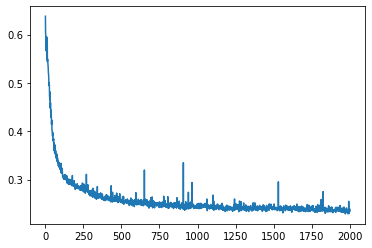

In [9]:
import matplotlib.pyplot as plt
ep=[i for i in range(1,2001)]

plt.plot(ep,mse_list1)

In [8]:
with open('mse_pconcs4_188_2000_file_3.txt', 'w') as f:
    for item in mse_list1:
        f.write("%s\n" % item)

In [17]:
print(model)

GNNNet(
  (mol_conv1): GCNConv(78, 78)
  (mol_conv2): GCNConv(78, 156)
  (mol_conv3): GCNConv(156, 312)
  (mol_fc_g1): Linear(in_features=312, out_features=1024, bias=True)
  (mol_fc_g2): Linear(in_features=1024, out_features=128, bias=True)
  (pro_conv1): GCNConv(54, 54)
  (pro_conv2): GCNConv(54, 108)
  (pro_conv3): GCNConv(108, 216)
  (pro_fc_g1): Linear(in_features=216, out_features=1024, bias=True)
  (pro_fc_g2): Linear(in_features=1024, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=1, bias=True)
)


In [5]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
f

0

In [3]:
torch.cuda.empty_cache()

In [6]:
print(t,r,a,f)

6222839808 0 0 0


In [10]:
print(t,r,a,f)

6222839808 29360128 6777856 22582272


In [11]:
torch.cuda.mem_get_info()

(4563992576, 6222839808)

In [12]:
torch.cuda.memory_stats()

OrderedDict([('active.all.allocated', 203),
             ('active.all.current', 58),
             ('active.all.freed', 145),
             ('active.all.peak', 64),
             ('active.large_pool.allocated', 27),
             ('active.large_pool.current', 11),
             ('active.large_pool.freed', 16),
             ('active.large_pool.peak', 11),
             ('active.small_pool.allocated', 176),
             ('active.small_pool.current', 47),
             ('active.small_pool.freed', 129),
             ('active.small_pool.peak', 55),
             ('active_bytes.all.allocated', 196372992),
             ('active_bytes.all.current', 107735552),
             ('active_bytes.all.freed', 88637440),
             ('active_bytes.all.peak', 107735552),
             ('active_bytes.large_pool.allocated', 177236480),
             ('active_bytes.large_pool.current', 100467200),
             ('active_bytes.large_pool.freed', 76769280),
             ('active_bytes.large_pool.peak', 100467200),
     

In [34]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   34202 KB |    1664 MB |    1652 TB |    1652 TB |\n|       from large pool |   17587 KB |    1646 MB |    1637 TB |    1637 TB |\n|       from small pool |   16615 KB |      22 MB |      14 TB |      14 TB |\n|---------------------------------------------------------------------------|\n| Active memory         |   34202 KB |    1664 MB |    1652 TB |    1652 TB |\n|       from large pool |   17587 KB |    1646 MB |

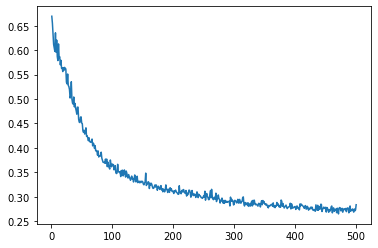

In [9]:
import matplotlib.pyplot as plt
ep=[i for i in range(1,501)]

plt.plot(ep,mse_list1)

In [10]:
with open('mse_alpha_500_file.txt', 'w') as f:
    for item in mse_list1:
        f.write("%s\n" % item)

In [7]:
import os
import sys
import torch
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

from emetrics import get_aupr, get_cindex, get_rm2, get_ci, get_mse, get_rmse, get_pearson, get_spearman
from utils import *
from scipy import stats
from gnn import GNNNet
from data_process import create_dataset_for_test,create_dataset_for_test_bootstrap


def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            # data = data.to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()


def load_model(model_path):
    model = torch.load(model_path)
    return model


def calculate_metrics(Y, P, dataset='davis'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)

    result_file_name = 'results/result_pconcs4_3_188_2000_' + model_st + '_' + dataset + '.txt'
    result_str = ''
    result_str += dataset + '\r\n'
    result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
        pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
    print(result_str)
    open(result_file_name, 'w').writelines(result_str)


def plot_density(Y, P, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    plt.savefig(os.path.join('results', dataset + '_pconcs4_3_188_2000_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')




In [8]:

dataset = ['davis', 'kiba'][1]  # dataset selection
model_st = GNNNet.__name__
print('dataset:', dataset)
cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][0] # gpu selection
print('cuda_name:', cuda_name)

 

dataset: kiba
cuda_name: cuda:0


In [9]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_pconcs4_3_188_2000_GNNNet_kiba_2.model'
result_file_name = 'results/resul_pconsc4_2_188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
test_data = create_dataset_for_test(dataset,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

Y, P = predicting(model, device, test_loader)
calculate_metrics(Y, P, dataset)
    


GNNNet Loaded
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187


/rds/user/co-gora1/hpc-work/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


Make prediction for 15908 samples...


In [10]:
calculate_metrics(Y, P, dataset)
    

metrics for  kiba
cindex: 0.8488401320811053
cindex2 0.8479211928779065
rm2: 0.617775451272561
mse: 0.23830178
pearson 0.805054622990312
kiba
rmse:0.4881616369606743  mse:0.23830178  pearson:0.805054622990312 spearman:0.8100051649135019 ci:0.8488401320811053 rm2:0.617775451272561


In [9]:

def plot_density(Y, P, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(Y, P, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('Experimental', fontsize=30, fontweight='bold')
    plt.ylabel('Predicted', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    #plt.savefig(os.path.join('results', dataset + '_pconcs4_2_188_2000_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


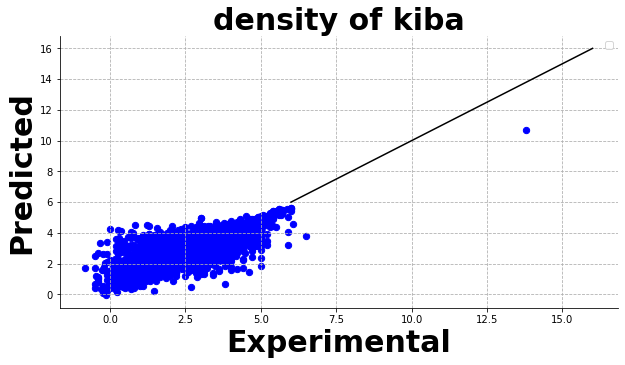

In [12]:
plot_density(Y, P, fold, dataset)

/home/co-gora1/rds/hpc-work/miniconda3/envs/mldd1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


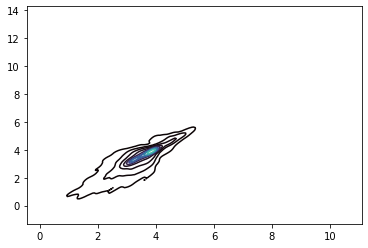

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(P, Y,cmap="mako")
plt.show()

In [16]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_pconcs4_2_188_2000_GNNNet_kiba_3.model'
result_file_name = 'results/resul_pconsc4_2_188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
test_data = create_dataset_for_test(dataset,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

Y, P = predicting(model, device, test_loader)
calculate_metrics(Y, P, dataset)
    


GNNNet Loaded
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 15908 samples...
metrics for  kiba
cindex: 0.8532654741913851
cindex2 0.851183496563325
rm2: 0.6265777031973842
mse: 0.22380354
pearson 0.8201320895666028
kiba
rmse:0.4730787831892252  mse:0.22380354  pearson:0.8201320895666028 spearman:0.8168592685499216 ci:0.8532654741913851 rm2:0.6265777031973842


No handles with labels found to put in legend.


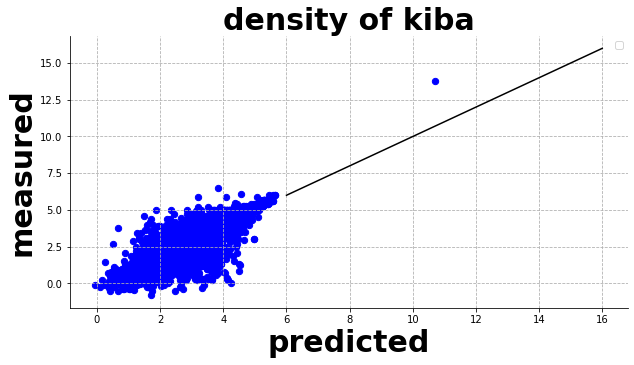

In [18]:
plot_density(Y, P, fold, dataset)

No handles with labels found to put in legend.


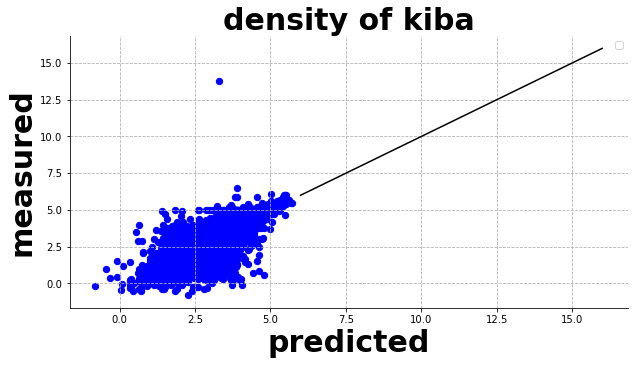

In [15]:
plot_density(Y, P, fold, dataset)

In [18]:
test_loader

In [10]:
Y

array([14.400163, 12.399998, 11.400001, ..., 11.400001, 11.5     ,
       11.5     ], dtype=float32)

In [11]:
P

array([13.495261, 12.662182, 11.396714, ..., 11.395967, 11.504625,
       11.45087 ], dtype=float32)

In [48]:

my_file = open("alpha500_pred_file.txt", "r")
content = my_file.read()
content=content.splitlines()
content=[float(i) for i in content]
print(content)

[13.572652, 12.826997, 11.444092, 10.318037, 11.341069, 11.559343, 11.85205, 11.203673, 10.334731, 11.582762, 13.900543, 12.97712, 11.691866, 12.792691, 14.458044, 11.520013, 12.257853, 11.212511, 12.006573, 11.880769, 11.1070795, 11.378011, 11.148856, 11.216189, 11.134102, 12.008484, 10.905703, 11.242366, 11.19693, 10.343345, 11.86922, 12.26573, 10.585809, 12.672529, 11.919928, 10.658084, 11.237454, 11.279299, 11.310264, 11.870662, 11.057477, 11.480621, 12.106813, 11.613607, 10.156403, 11.307625, 10.7861595, 11.92269, 11.224873, 12.009879, 10.479592, 11.211487, 11.759775, 11.364248, 11.742957, 12.0676775, 12.2011385, 11.140188, 11.8148365, 11.463266, 11.225105, 11.48033, 12.019633, 11.547219, 11.362604, 12.447442, 10.850902, 11.337198, 10.871161, 11.64067, 11.490308, 11.450138, 11.544379, 10.872649, 12.062119, 11.466935, 11.917785, 11.780647, 11.215674, 12.046588, 11.4404955, 10.219847, 11.889244, 11.15485, 11.559784, 12.427896, 12.339859, 10.860705, 12.2455225, 11.580148, 11.404127, 

In [49]:
P1=np.asarray(content)

In [50]:
P1

array([13.572652 , 12.826997 , 11.444092 , ..., 11.422882 , 11.5344305,
       11.544348 ])

In [52]:
plt.scatter(P,color='blue')

TypeError: scatter() missing 1 required positional argument: 'y'

In [37]:
type(content)

str

In [41]:
P

array([13.495261, 12.662182, 11.396714, ..., 11.395967, 11.504625,
       11.45087 ], dtype=float32)

No handles with labels found to put in legend.


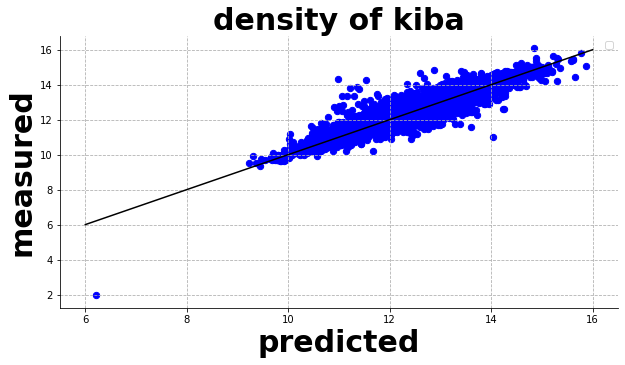

In [53]:
plot_density(P1, P, fold, dataset)

In [12]:
with open('pconsc4_500_gt_file.txt', 'w') as f:
    for item in list(Y):
        f.write("%s\n" % item)

In [13]:
with open('pconsc4_500_pred_file.txt', 'w') as f:
    for item in list(P):
        f.write("%s\n" % item)

No handles with labels found to put in legend.


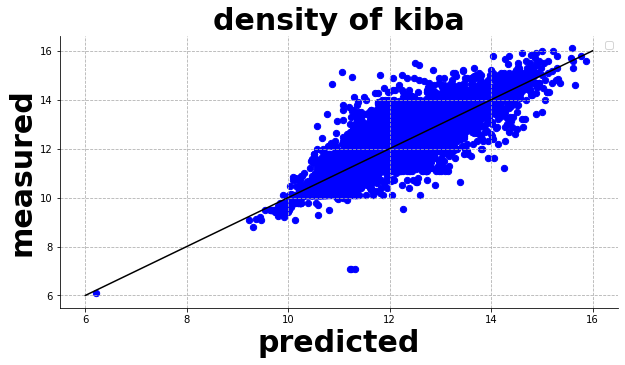

In [54]:
plot_density(Y, P, fold, dataset)

In [58]:
def plot_density1(Y, P,P1, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.scatter(P1, Y, color='green', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    #plt.savefig(os.path.join('results', dataset + 'alpha v/s pconsc4_500_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')


No handles with labels found to put in legend.


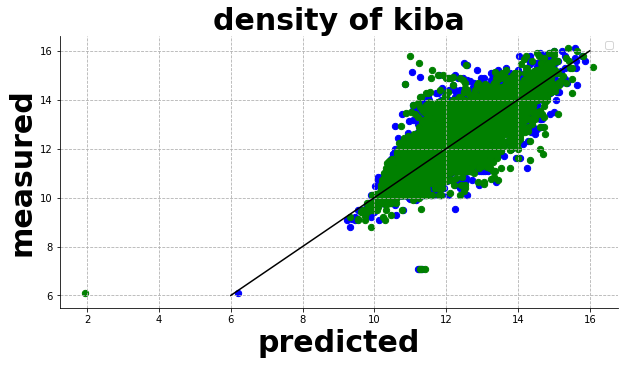

In [59]:
plot_density1(Y, P,P1, fold, dataset)

No handles with labels found to put in legend.


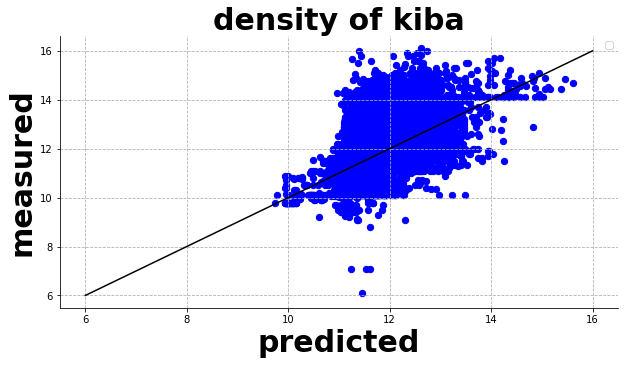

In [13]:
plot_density(Y, P, fold, dataset)

In [ ]:
plot_density(Y, P, fold, dataset)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'

In [8]:

def calculate_metrics1(Y, P, dataset='davis'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)
    return cindex,pearson,rmse
#     result_file_name = 'results/result_pconcs4_188_2000_' + model_st + '_' + dataset + '.txt'
#     result_str = ''
#     result_str += dataset + '\r\n'
#     result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
#         pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
#     print(result_str)
#     open(result_file_name, 'w').writelines(result_str)

In [9]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_pconsc4__188_2000_GNNNet_kiba_1.model'
result_file_name = 'results/resul_pconsc4__188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))


GNNNet Loaded


<All keys matched successfully>

In [10]:
rmse1=[]
pearson1=[]
ci1=[]
niters=20

for i in range(niters):
    print(i)
    test_data = create_dataset_for_test_bootstrap(dataset, method,random=i)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
    Y, P = predicting(model, device, test_loader)
    cindex,pearson,rmse=calculate_metrics1(Y, P, dataset)
    print(cindex,pearson,rmse)
    ci1.append(cindex)
    pearson1.append(pearson)
    rmse1.append(rmse)
    

0
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187


/disk/scratch/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8616694988146936
cindex2 0.8587943619216536
rm2: 0.6752159361477695
mse: 0.20807728
pearson 0.8235589360175168
0.8616694988146936 0.8235589360175168 0.4561548878544279
1
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8511974431511434
cindex2 0.8481224954870757
rm2: 0.577744193184537
mse: 0.22741851
pearson 0.7782227931510187
0.8511974431511434 0.7782227931510187 0.47688417053404253
2
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8559298108454405
cindex2 0.8586343755756322
rm2: 0.6281498485614005
mse: 0.23502246
pearson 0.8055174588394287
0.8559298108454405 0.8055174588394287 0.48479114622058916
3
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective 

In [11]:
data_1 = ci1
data_2 = pearson1
data_3 = rmse1

data = [data_1, data_2, data_3]
data11 = pd.DataFrame(
{'CI':data_1,
 'Pearson': data_2,
 'RMSE': data_3
})


In [21]:
import seaborn as sns
sns.set_theme(style="whitegrid")

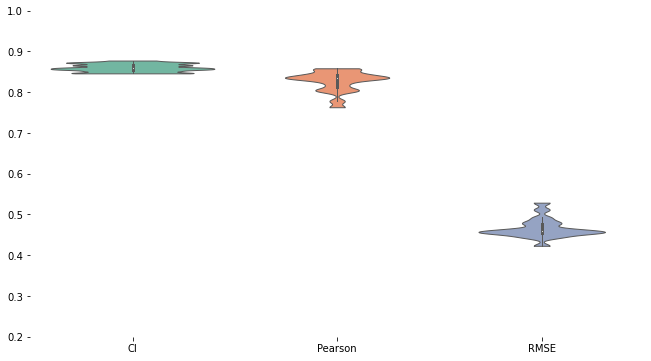

In [13]:
f, ax = plt.subplots(figsize=(11, 6))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=data11, palette="Set2", bw=.2, cut=0, linewidth=1)

# Finalize the figure
ax.set(ylim=(0.2, 1))
sns.despine(left=True, bottom=True)

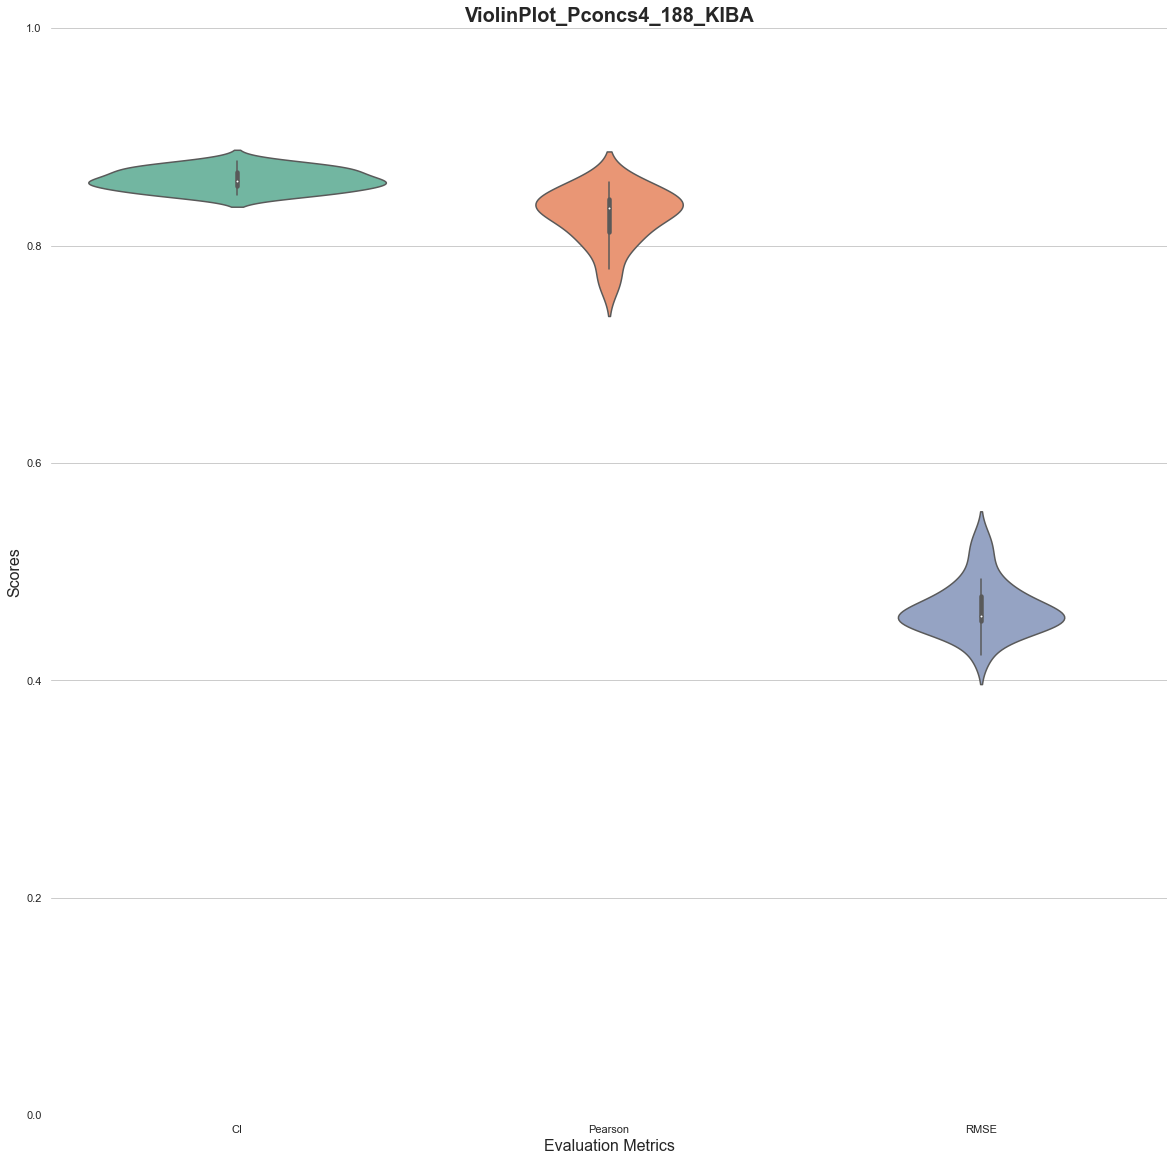

In [50]:
f, ax = plt.subplots(figsize=(20, 20))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=data11, palette="Set2")

# Finalize the figure
ax.set(ylim=(0, 1))
ax.set_title
sns.despine(left=True, bottom=True)

ax.set(ylim=(0, 1))
#ax.margins(x=2, y=2)
ax.set_xlabel('Evaluation Metrics',fontsize=16)
ax.set_ylabel('Scores',fontsize=16)
ax.set_title('ViolinPlot_Pconcs4_188_KIBA',fontsize=20,fontweight='bold')

plt.savefig(os.path.join('results1',  'violinplot_pconcs4_188_2000' + '.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('results1',  'violinplot_pconcs4_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

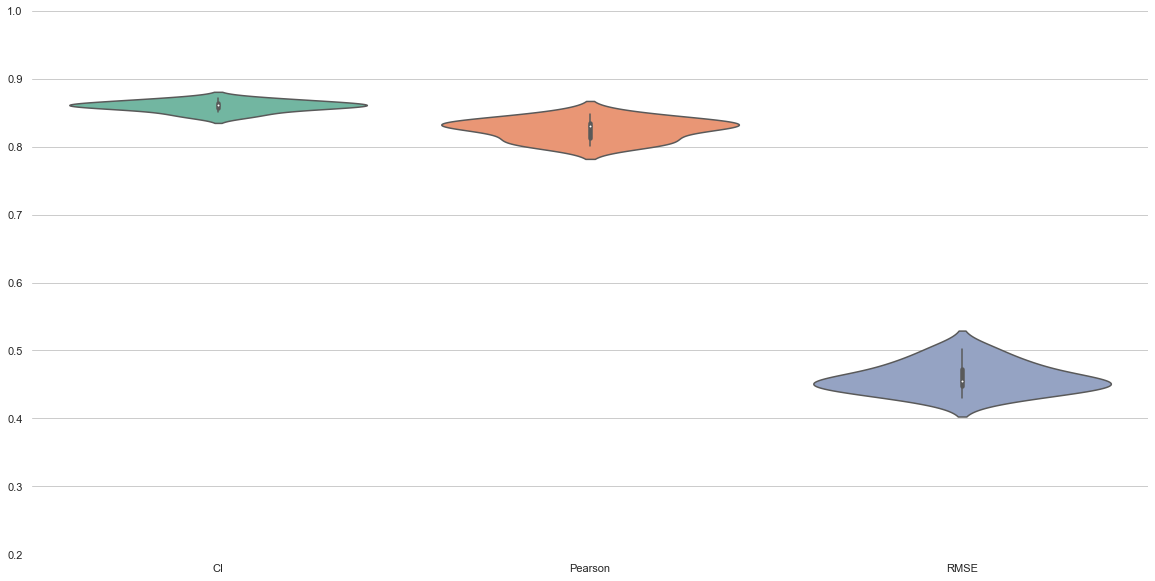

In [62]:
f, ax = plt.subplots(figsize=(20, 10))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=data11, palette="Set2",split=True,scale="width",inner="box")

# Finalize the figure
ax.set(ylim=(0.2, 1))
sns.despine(left=True, bottom=True)

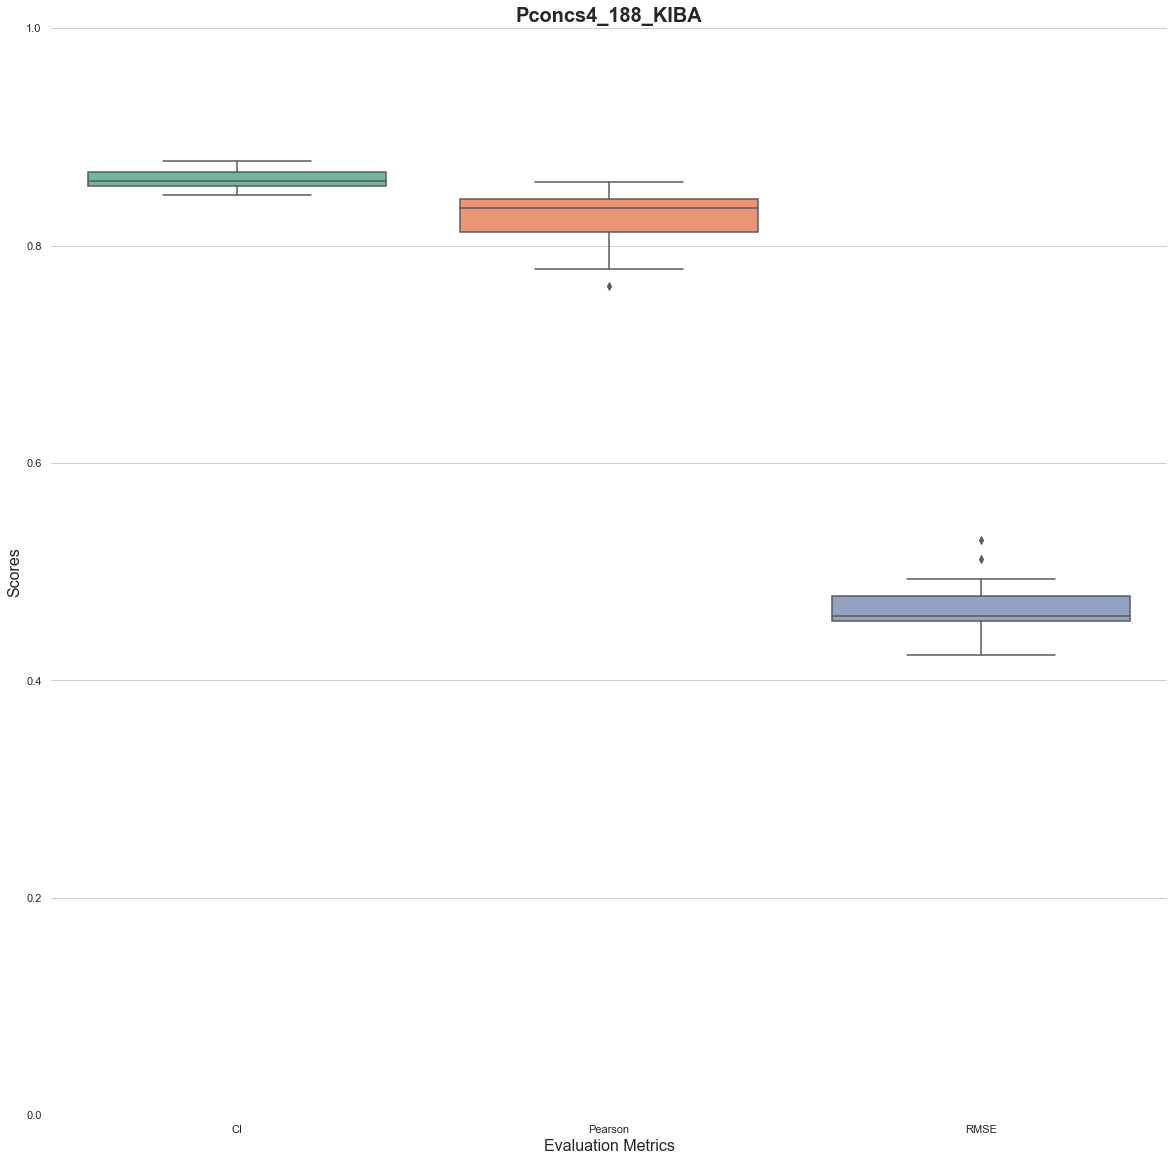

In [48]:
f, ax = plt.subplots(figsize=(20, 20))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(data=data11, palette="Set2")

# Finalize the figure
ax.set(ylim=(0, 1))
ax.margins(x=2, y=2)
ax.set_xlabel('Evaluation Metrics',fontsize=16)
ax.set_ylabel('Scores',fontsize=16)
ax.set_title('Pconcs4_188_KIBA',fontsize=20,fontweight='bold')
sns.despine(left=True, bottom=True)
plt.savefig(os.path.join('results1',  'boxplot_pconcs4_188_2000' + '.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('results1',  'boxplot_pconcs4_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

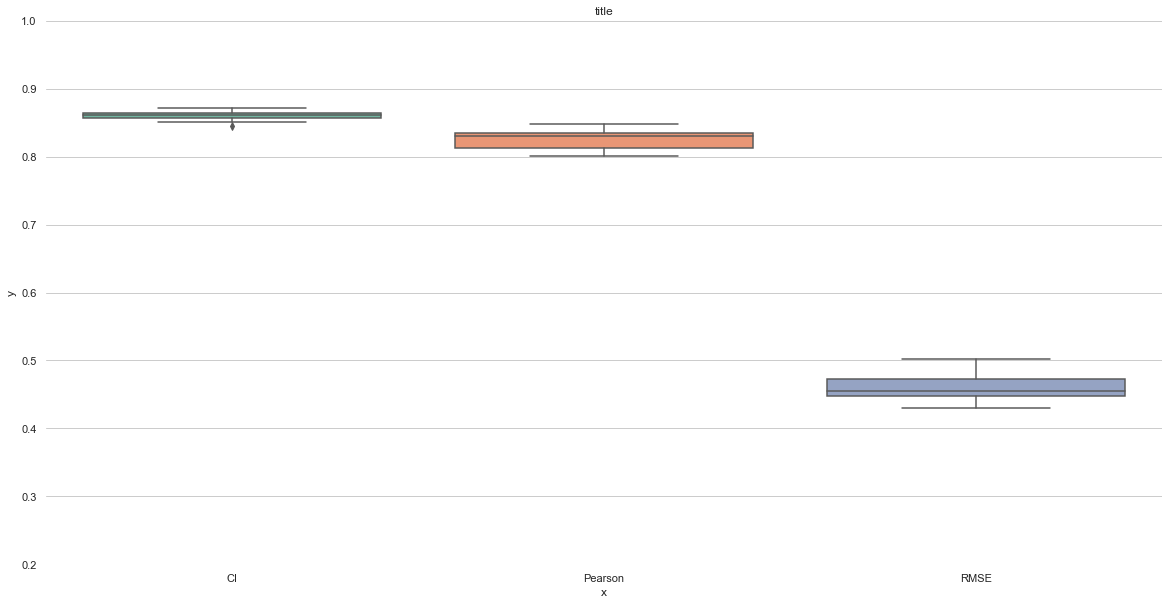

In [43]:
f, ax = plt.subplots(figsize=(20, 10))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(data=data11, palette="Set2")

# Finalize the figure
ax.set(ylim=(0.2, 1))
ax.margins(x=2, y=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('title')
sns.despine(left=True, bottom=True)
#sns.despine(offset=10, trim=True)

/tmp/ipykernel_179503/3511795146.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["",'CI', "",'Pearson',"", 'RMSE'])


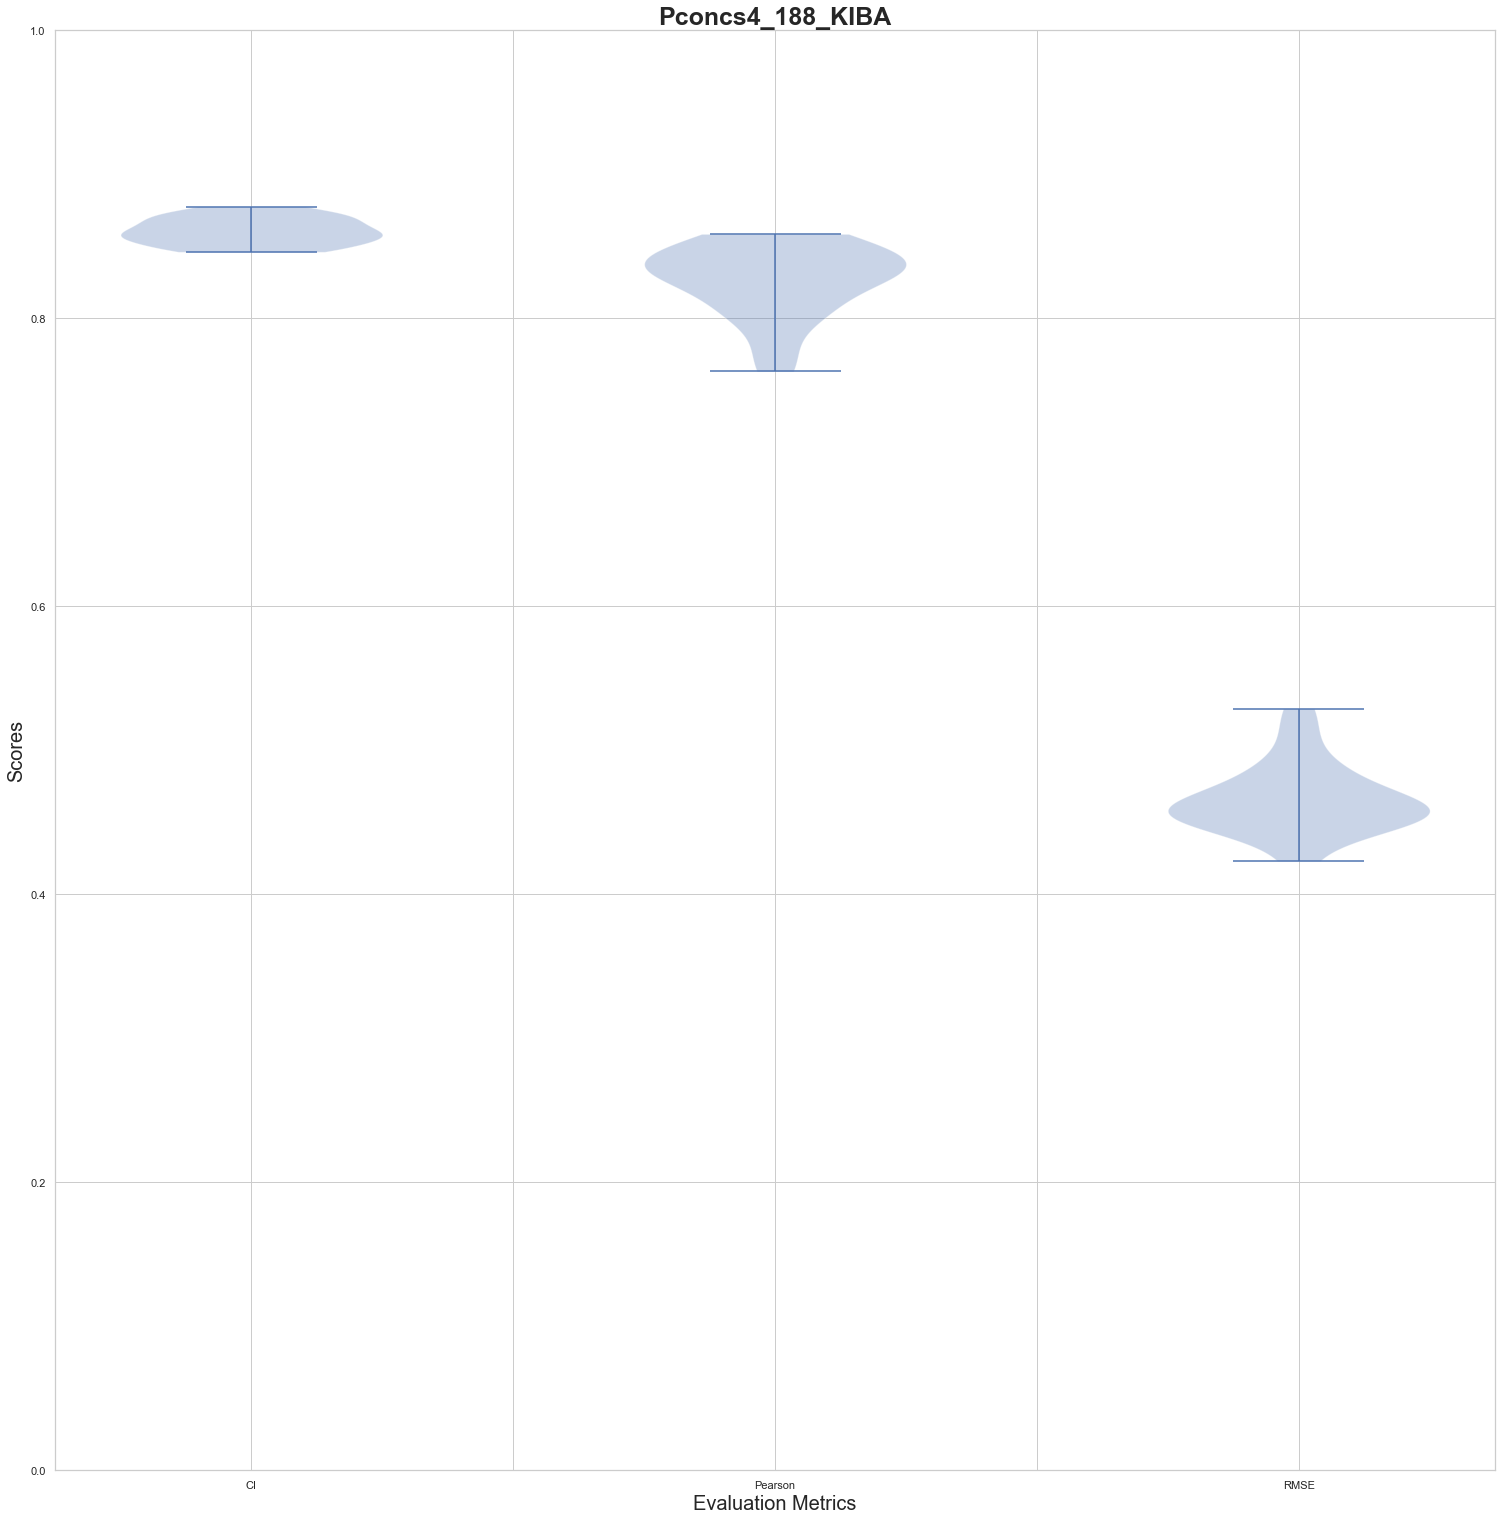

<Figure size 432x288 with 0 Axes>

In [52]:
data_1 = ci1
data_2 = pearson1
data_3 = rmse1

data = [data_1, data_2, data_3]
 
fig = plt.figure(figsize =(20, 20))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1,1])
#ax = fig.add_subplot(111)
ax.set_xticklabels(["",'CI', "",'Pearson',"", 'RMSE'])
#ax.set_ylim([0, 1])
ax.set(ylim=(0, 1))
#ax.margins(x=2, y=2)
ax.set_xlabel('Evaluation Metrics',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('Pconcs4_188_KIBA',fontsize=25,fontweight='bold')

bp = ax.violinplot(data)
plt.show()
plt.savefig(os.path.join('results1',  'box_violin_plot_pconcs4_188_2000' + '.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('results1',  'box_violin_plot_pconcs4_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')
# Creating plot


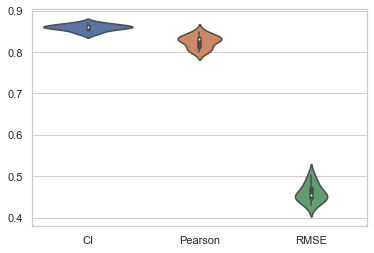

In [65]:
#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots()
# Creating axes instance
#ax = fig.add_axes([0, 0, 1,1])
#ax = fig.add_subplot(111)
#ax.set_xticklabels(['CI', 'Pearson', 'RMSE'])
#ax.set_ylim([0.2, 1])
# Creating plot
.violinplot(data=data11,ax=ax)
plt.show()

/tmp/ipykernel_172230/1480089813.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['CI', 'Pearson', 'RMSE'])


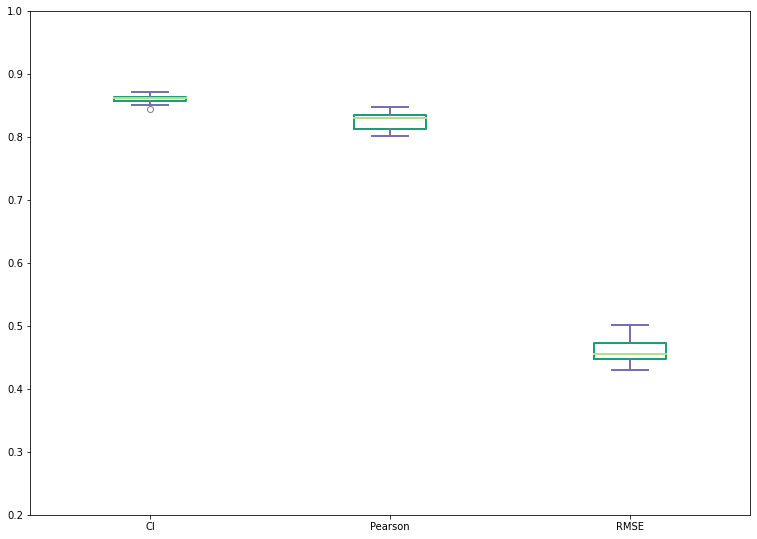

In [17]:
data_1 = ci1
data_2 = pearson1
data_3 = rmse1

data = [data_1, data_2, data_3]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['CI', 'Pearson', 'RMSE'])
ax.set_ylim([0.2, 1])
# Creating plot
bp = ax.boxplot(data)
# bp = ax.boxplot(data, patch_artist=True)
# ax.set_xticklabels(['CI', 'Pearson', 'RMSE'])
## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set(color = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
# show plot
plt.show()

In [8]:
test_data = create_dataset_for_test_bootstrap(dataset, method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187


/disk/scratch/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


In [9]:
test_data

DTADataset(2000)

In [9]:
test_loader

In [ ]:
Y, P = predicting(model, device, test_loader)
calculate_metrics(Y, P, dataset)
    

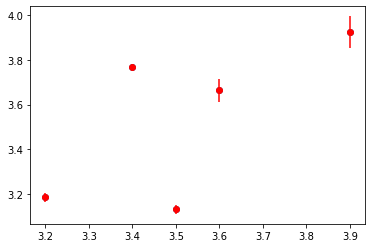

In [20]:
a = [3.199999,3.6,3.4000006,3.8999999,3.50]
b = [3.1865768,3.6635284,3.766081,3.9235876,3.1323996]
plt.scatter(a, b)
d = [0.02, 0.05, 0.01, 0.07,0.02]
  
# you can use color ="r" for red or skip to default as blue
plt.errorbar(a, b, yerr=d, fmt="o", color="r")
  
plt.show()

In [24]:
test_data = create_dataset_for_test_bootstrap(dataset, method,random=30)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
Y, P = predicting(model, device, test_loader)

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...


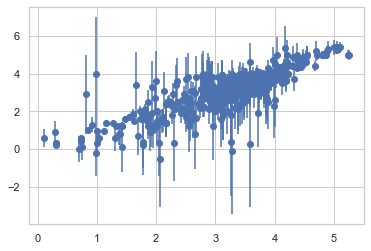

In [30]:
plt.errorbar(P, Y, yerr=Y-P, fmt="o", color="b")
  
plt.show()

In [31]:
type(Y)

numpy.ndarray

In [39]:
n = 200  # for 2 random indices
index = np.random.choice(len(Y), n, replace=False)  

In [40]:
x_random = P[index]
y_random = Y[index]

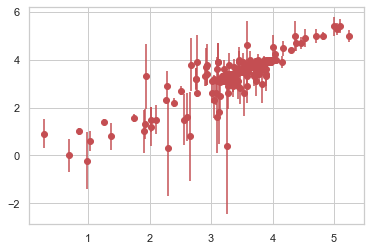

In [41]:
plt.errorbar(x_random, y_random , yerr=y_random -x_random, fmt="o", color="r")
  
plt.show()